In [1]:
%matplotlib inline

# Fitting TESS FFIs

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0.dev0


This tutorial is nearly identical to the :ref:`tess` tutorial with added support for the TESS full frame images using [tesscut](https://mast.stsci.edu/tesscut/).

First, we query the TESS input catalog for the coordinates and properties of this source:

In [3]:
import numpy as np
from astroquery.mast import Catalogs

ticid = 49899799
tic = Catalogs.query_object("TIC {0}".format(ticid), radius=0.2, catalog="TIC")
star = tic[np.argmin(tic["dstArcSec"])]

tic_mass = float(star["mass"]), float(star["e_mass"])
tic_radius = float(star["rad"]), float(star["e_rad"])

Then we download the data from tesscut.
This is similar to what we did in the :ref:`tess` tutorial, but we need to do some background subtraction because the pipeline doesn't seem to do too well for the official TESS FFIs.

In [4]:
from io import BytesIO
from zipfile import ZipFile

from astropy.io import fits
from astropy.utils.data import download_file

# Download the cutout
url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={0[ra]}&dec={0[dec]}&y=15&x=15&units=px&sector=All".format(star)
fn = download_file(url, cache=True)
with ZipFile(fn, "r") as f:
    with fits.open(BytesIO(f.read(f.namelist()[0]))) as hdus:
        tpf = hdus[1].data
        tpf_hdr = hdus[1].header

texp = tpf_hdr["FRAMETIM"] * tpf_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = tpf["TIME"]
flux = tpf["FLUX"]
m = np.any(np.isfinite(flux), axis=(1, 2)) & (tpf["QUALITY"] == 0)
ref_time = 0.5 * (np.min(time[m])+np.max(time[m]))
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)

# Compute the median image
mean_img = np.median(flux, axis=0)

# Sort the pixels by median brightness
order = np.argsort(mean_img.flatten())[::-1]

# Choose a mask for the background
bkg_mask = np.zeros_like(mean_img, dtype=bool)
bkg_mask[np.unravel_index(order[-100:], mean_img.shape)] = True
flux -= np.median(flux[:, bkg_mask], axis=-1)[:, None, None]

Everything below this line is the same as the :ref:`tess` tutorial.

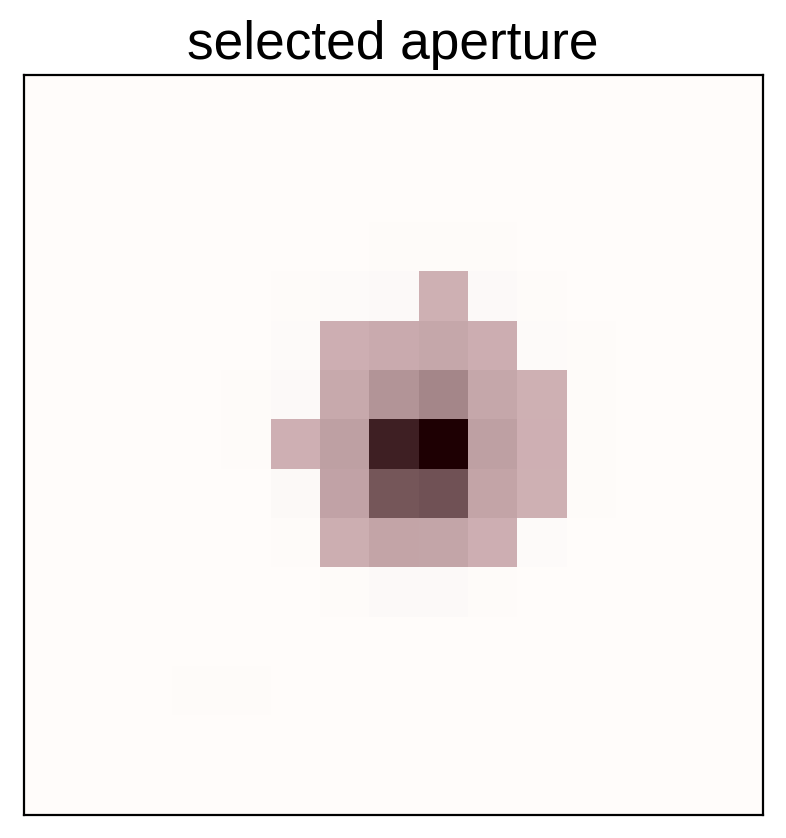

In [5]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# A function to estimate the windowed scatter in a lightcurve
def estimate_scatter_with_mask(mask):
    f = np.sum(flux[:, mask], axis=-1)
    smooth = savgol_filter(f, 1001, polyorder=5)
    return 1e6 * np.sqrt(np.median((f / smooth - 1)**2))

# Loop over pixels ordered by brightness and add them one-by-one
# to the aperture
masks, scatters = [], []
for i in range(1, 100):
    msk = np.zeros_like(mean_img, dtype=bool)
    msk[np.unravel_index(order[:i], mean_img.shape)] = True
    scatter = estimate_scatter_with_mask(msk)
    masks.append(msk)
    scatters.append(scatter)

# Choose the aperture that minimizes the scatter
pix_mask = masks[np.argmin(scatters)]

# Plot the selected aperture
plt.imshow(mean_img.T, cmap="gray_r")
plt.imshow(pix_mask.T, cmap="Reds", alpha=0.3)
plt.title("selected aperture")
plt.xticks([])
plt.yticks([]);

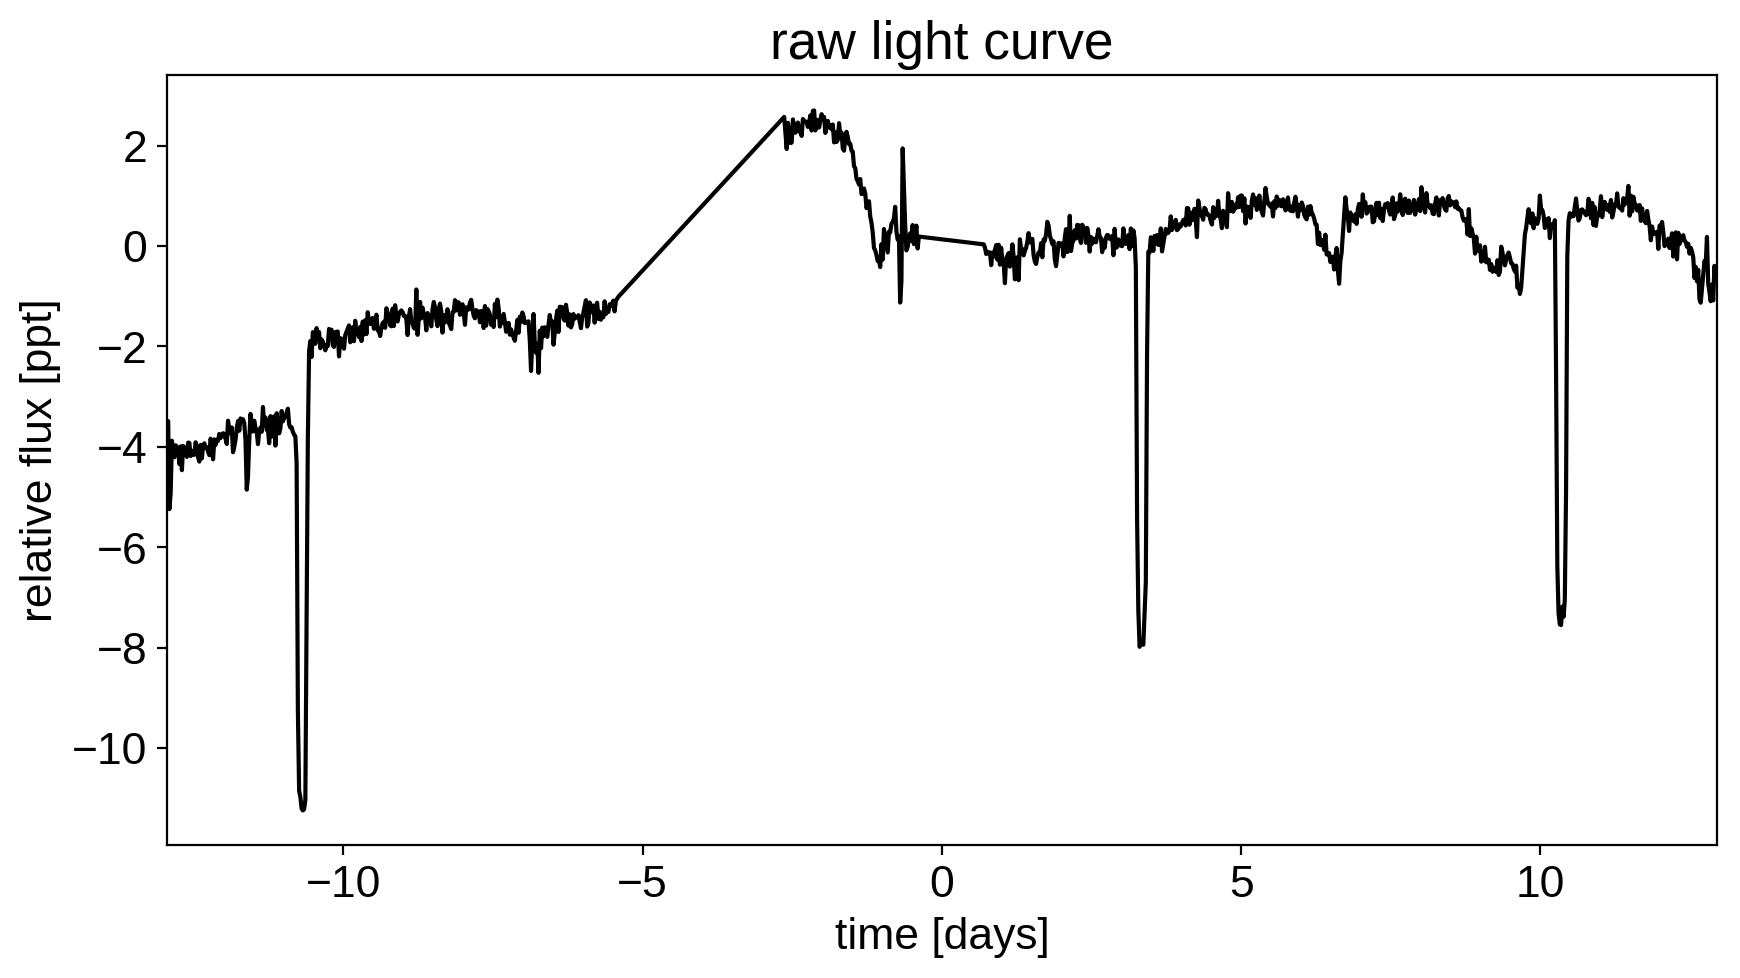

In [6]:
plt.figure(figsize=(10, 5))
sap_flux = np.sum(flux[:, pix_mask], axis=-1)
sap_flux = (sap_flux / np.median(sap_flux) - 1) * 1e3
plt.plot(time, sap_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("raw light curve")
plt.xlim(time.min(), time.max());

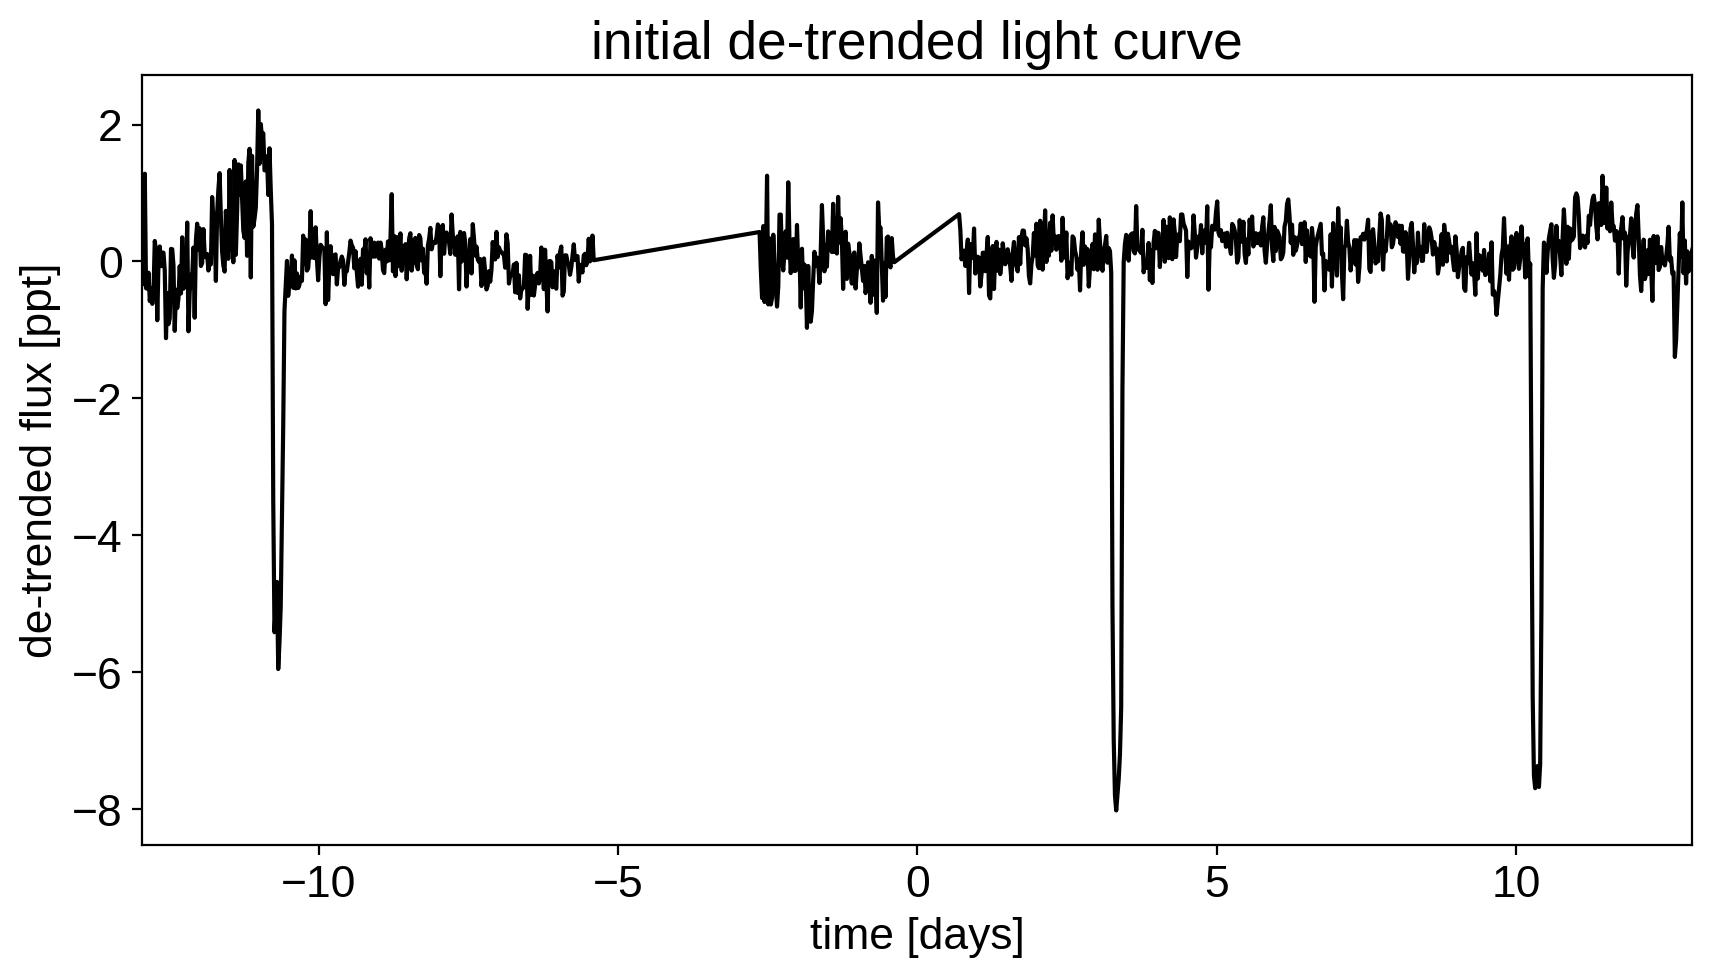

In [7]:
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, :X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, sap_flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(time, sap_flux-pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(time.min(), time.max());

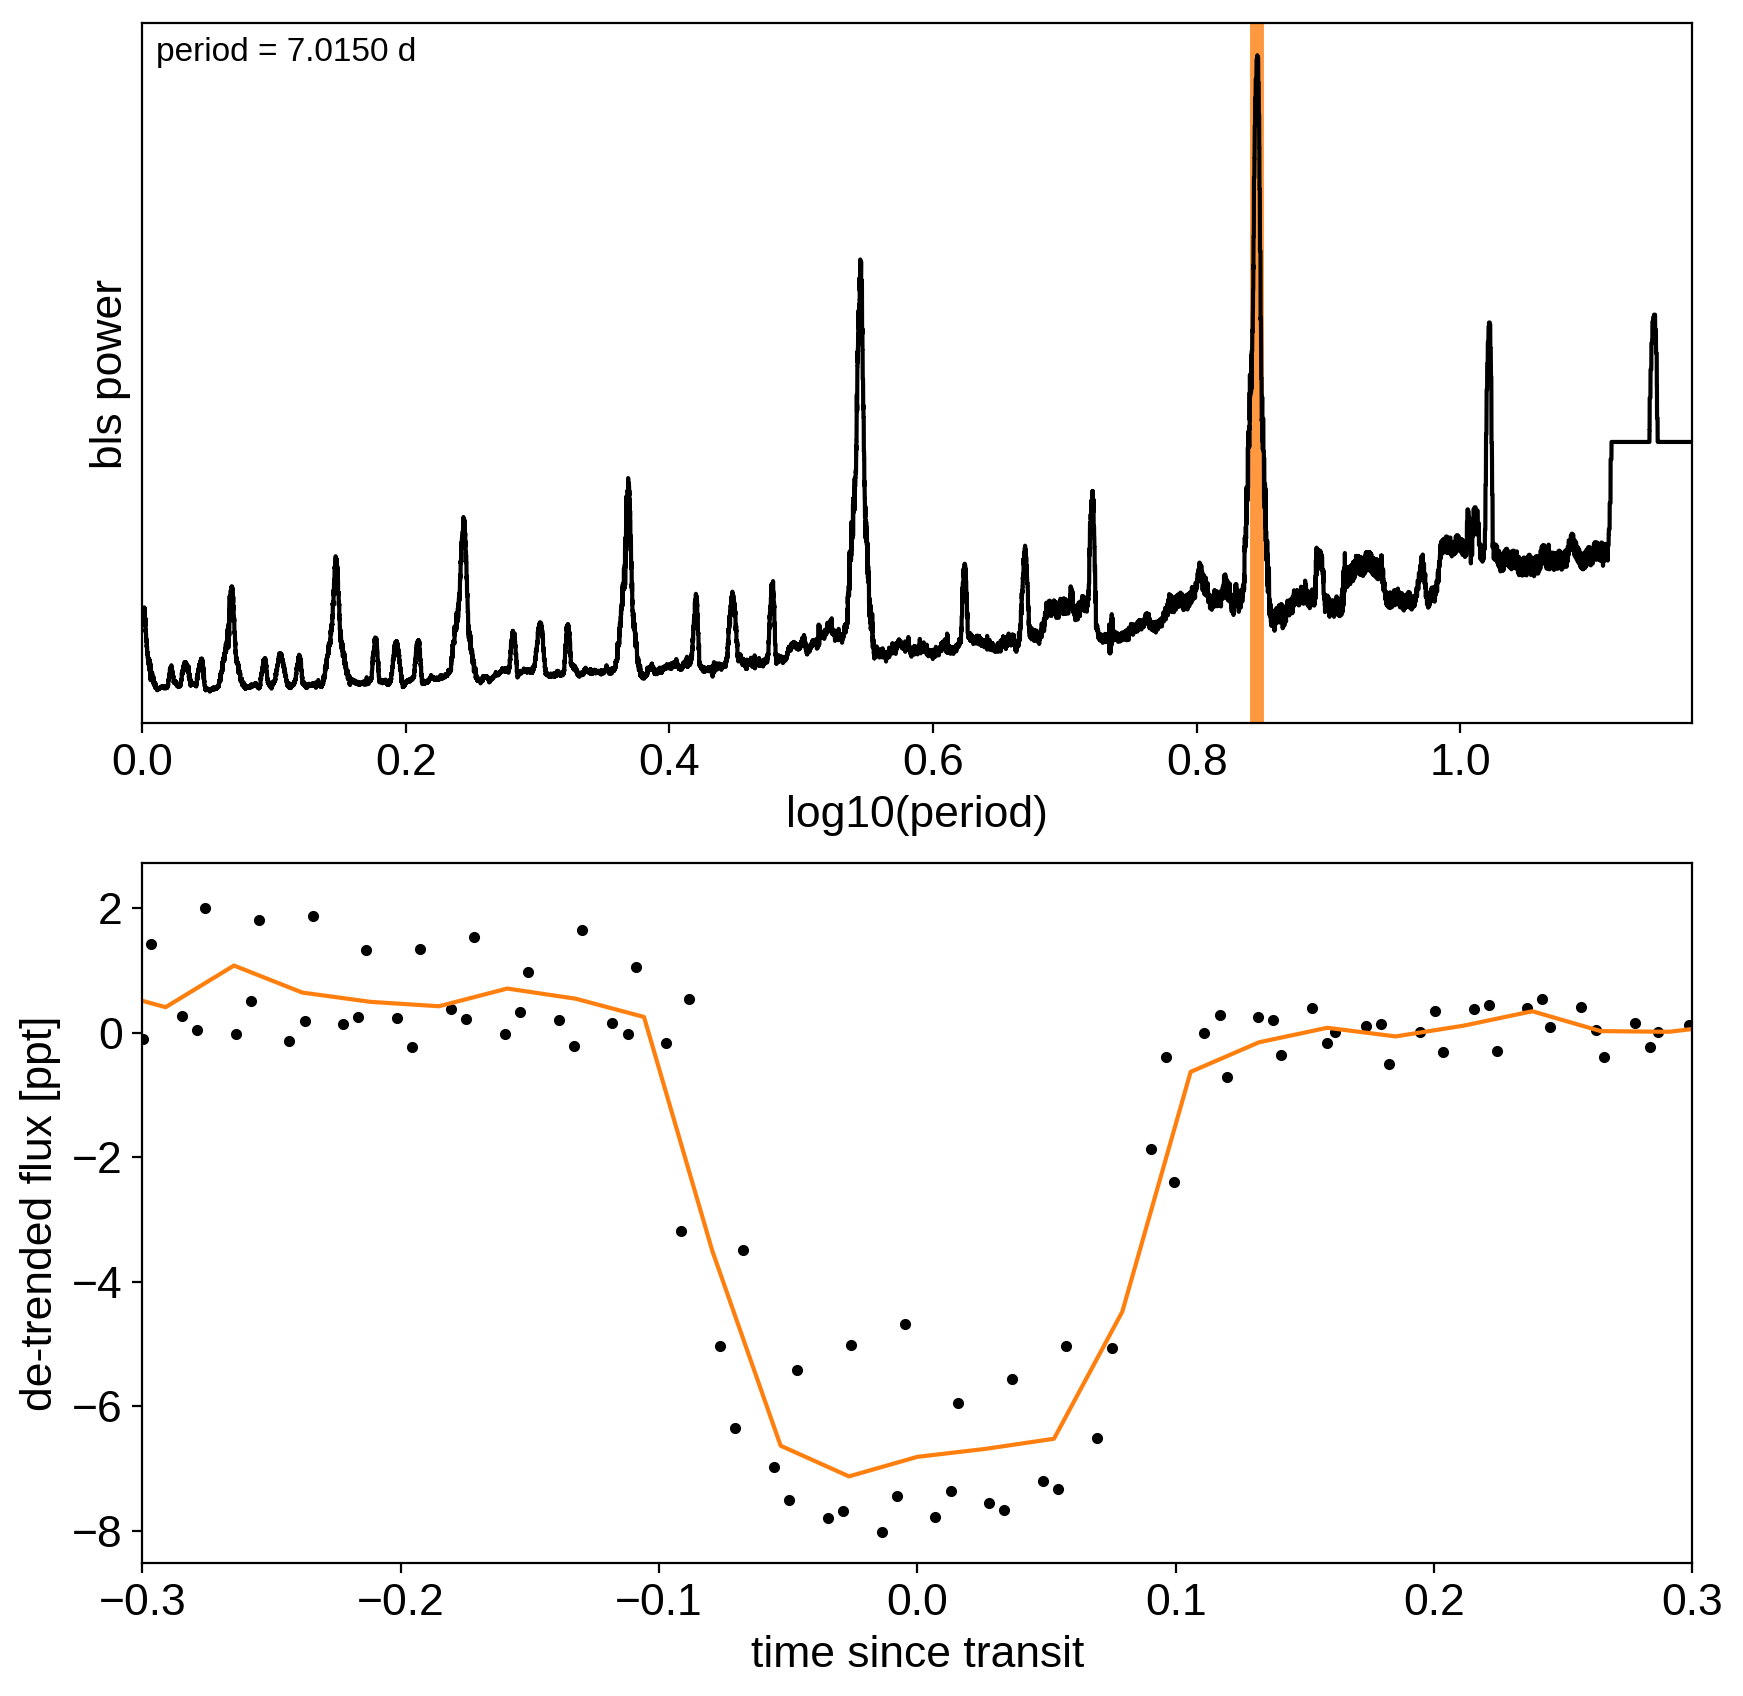

In [8]:
from astropy.stats import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(time, sap_flux - pld_flux)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate("period = {0:.4f} d".format(bls_period),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (time - bls_t0 + 0.5*bls_period)%bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], sap_flux[m] - pld_flux[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=sap_flux - pld_flux)
denom[num == 0] = 1.0
ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
ax.set_xlabel("time since transit");

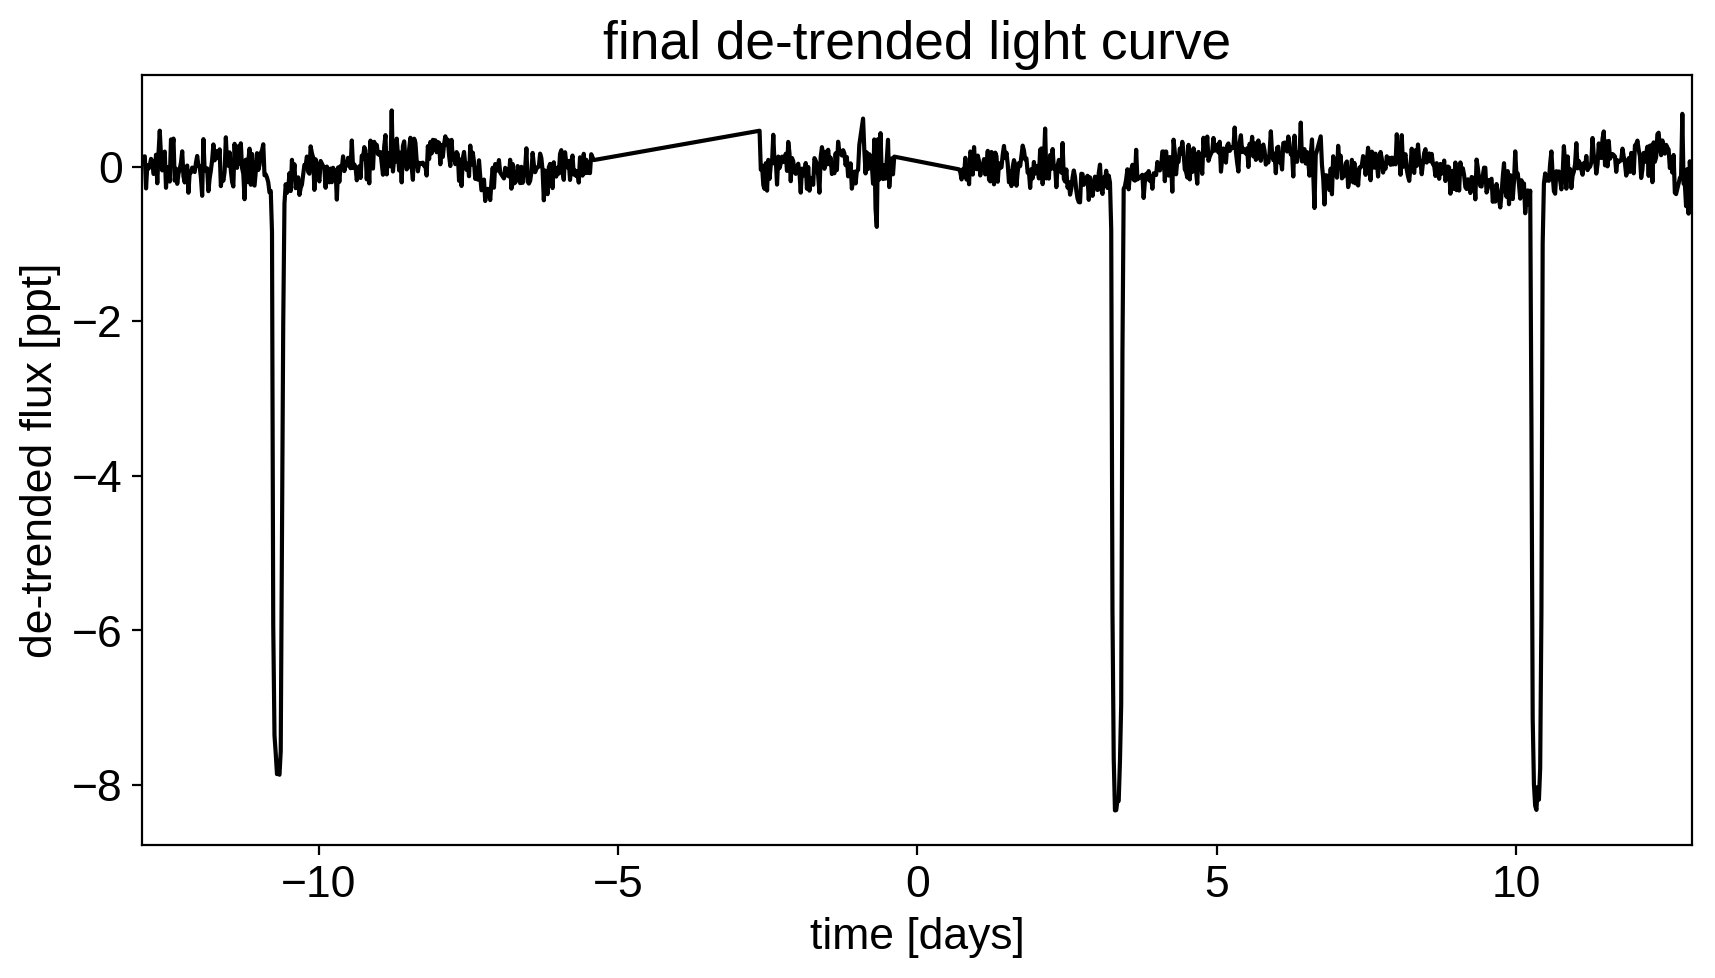

In [9]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, sap_flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(sap_flux-pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(time, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(time.min(), time.max());

In [10]:
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        
        # Stellar parameters from TIC
        M_star_huang = 1.094, 0.039
        R_star_huang = 1.10, 0.023
        m_star = pm.Normal("m_star", mu=tic_mass[0], sd=tic_mass[1])
        r_star = pm.Normal("r_star", mu=tic_radius[0], sd=tic_radius[1])

        # Prior to require physical parameters
        pm.Potential("m_star_prior", tt.switch(m_star > 0, 0, -np.inf))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))

        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_period), sd=1)
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        b = pm.Uniform("b", lower=0, upper=1, testval=0.5)
        logr = pm.Normal("logr", sd=1.0,
                         mu=0.5*np.log(1e-3*np.array(bls_depth))+np.log(tic_radius[0]))
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        
        # This is the eccentricity prior from Kipping (2013):
        # https://arxiv.org/abs/1306.4982
        ecc = pm.Beta("ecc", alpha=0.867, beta=3.03, testval=0.1)
        omega = xo.distributions.Angle("omega")

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega)
        pm.Deterministic("a", orbit.a_planet)
        pm.Deterministic("incl", orbit.incl)

        # Compute the model light curve using starry
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower, logw0])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

optimizing logp for variables: ['b_interval__']


message: Optimization terminated successfully.
logp: -1181.8355629633472 -> -1165.2287368771365


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: -1165.2287368771365 -> 83.7577748952358


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 83.7577748952358 -> 118.92458572614767


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_logodds__', 'logr', 'b_interval__', 't0', 'logP', 'r_star', 'm_star', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 118.9245857261454 -> 344.3805435085546


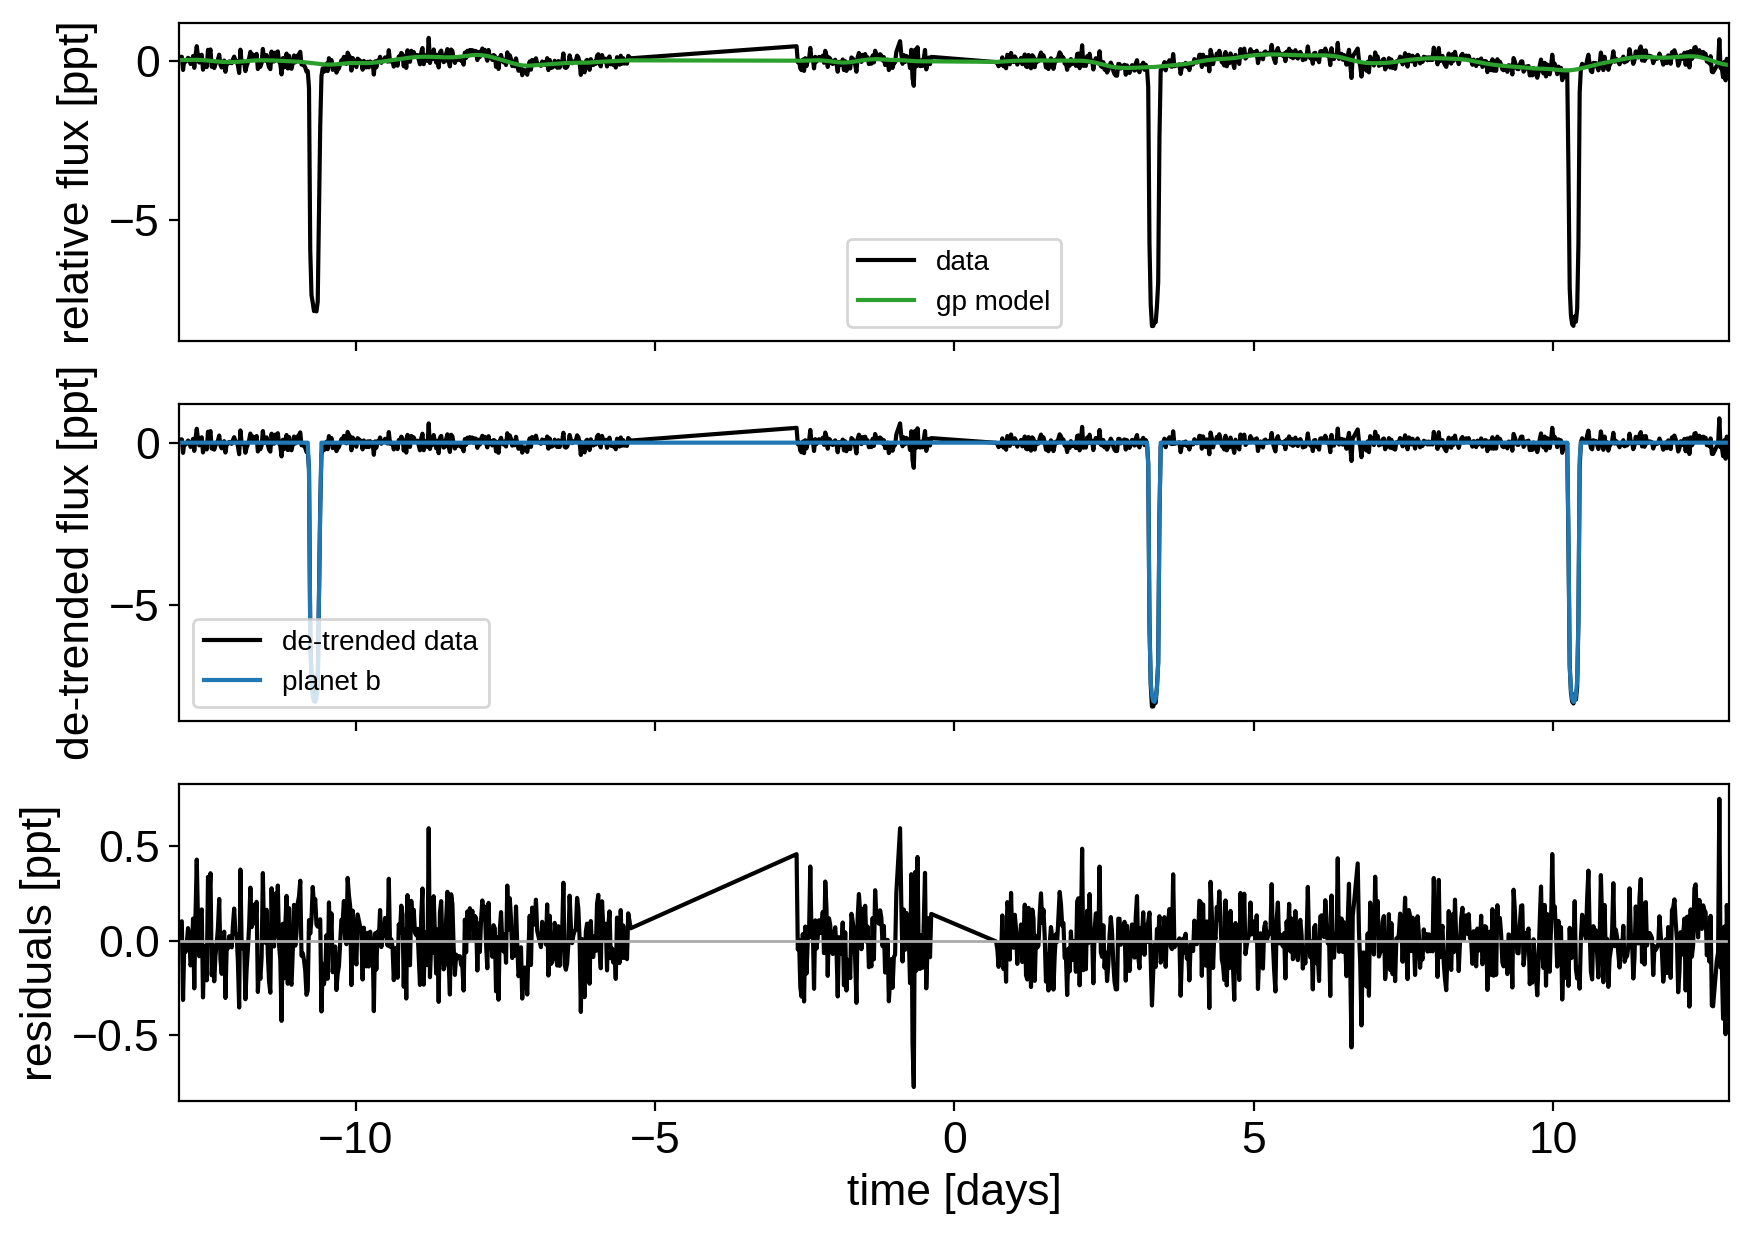

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

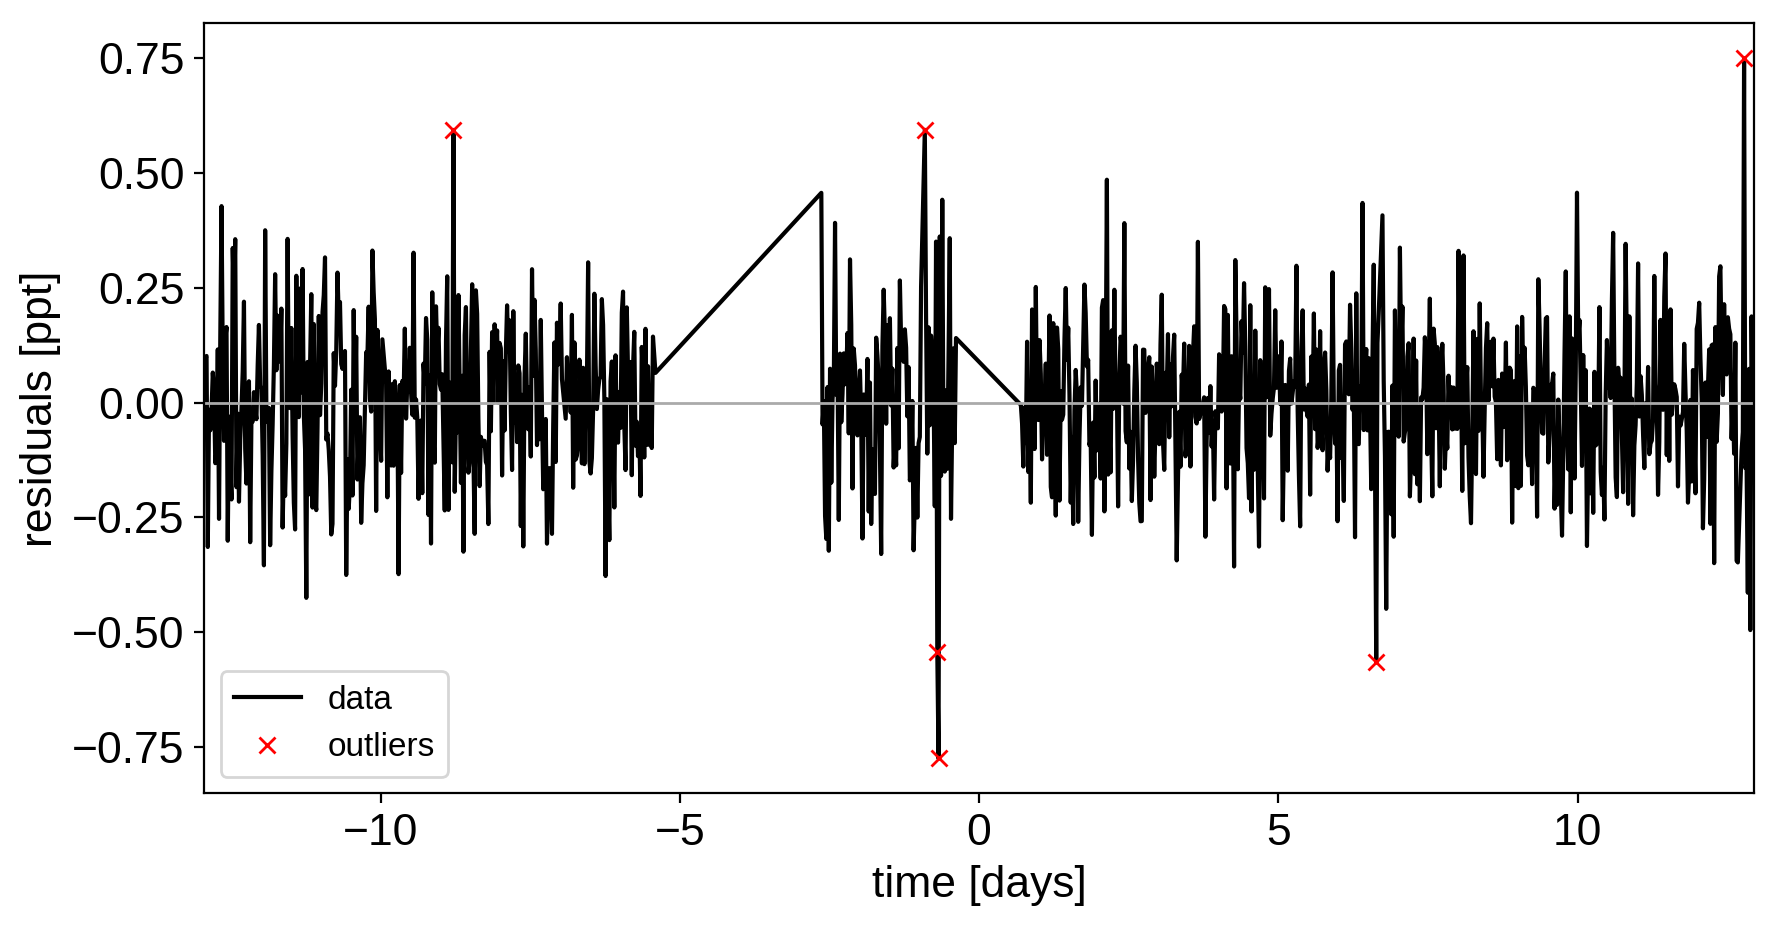

In [12]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

optimizing logp for variables: ['b_interval__']


message: Optimization terminated successfully.
logp: 386.78260185405213 -> 386.7826018553153


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 386.78260185531417 -> 389.6638025172027


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 389.6638025172027 -> 389.68441484311387


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_logodds__', 'logr', 'b_interval__', 't0', 'logP', 'r_star', 'm_star', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 389.68441484311387 -> 389.69489273250457


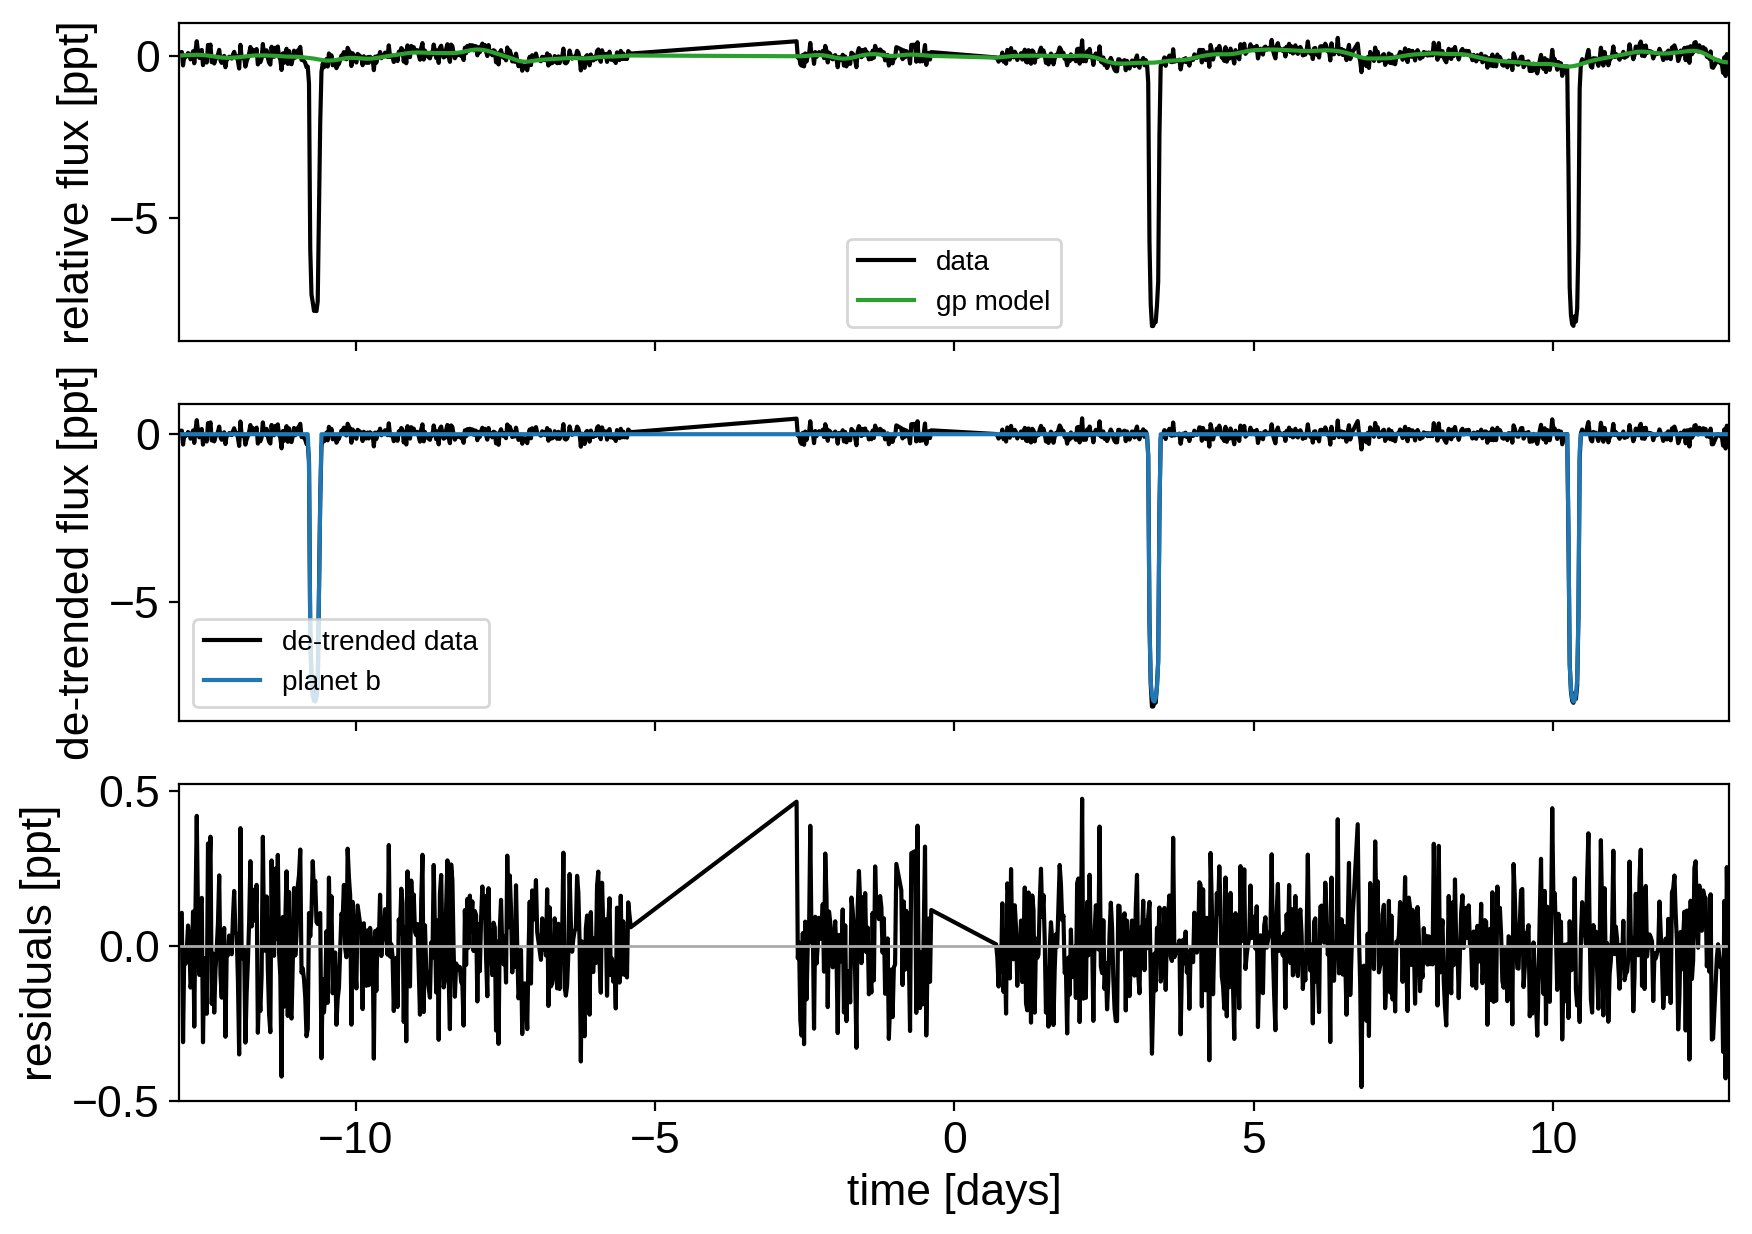

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

In [14]:
np.random.seed(12345)
sampler = xo.PyMC3Sampler(window=100, start=300, finish=500)
with model:
    burnin = sampler.tune(tune=3500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=4)

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|▏         | 18/1208 [00:00<00:19, 61.89draws/s]

Sampling 4 chains:   2%|▏         | 22/1208 [00:00<00:36, 32.48draws/s]

Sampling 4 chains:   2%|▏         | 26/1208 [00:00<00:48, 24.37draws/s]

Sampling 4 chains:   2%|▏         | 30/1208 [00:01<00:56, 20.75draws/s]

Sampling 4 chains:   3%|▎         | 34/1208 [00:01<01:02, 18.80draws/s]

Sampling 4 chains:   3%|▎         | 38/1208 [00:01<01:06, 17.64draws/s]

Sampling 4 chains:   3%|▎         | 42/1208 [00:01<01:08, 16.91draws/s]

Sampling 4 chains:   4%|▍         | 46/1208 [00:02<01:10, 16.42draws/s]

Sampling 4 chains:   4%|▍         | 50/1208 [00:02<01:11, 16.10draws/s]

Sampling 4 chains:   4%|▍         | 54/1208 [00:02<01:12, 15.89draws/s]

Sampling 4 chains:   5%|▍         | 58/1208 [00:02<01:13, 15.74draws/s]

Sampling 4 chains:   5%|▌         | 62/1208 [00:03<01:13, 15.63draws/s]

Sampling 4 chains:   6%|▌         | 68/1208 [00:03<01:05, 17.31draws/s]

Sampling 4 chains:   6%|▌         | 72/1208 [00:03<01:08, 16.69draws/s]

Sampling 4 chains:   6%|▋         | 76/1208 [00:03<00:55, 20.22draws/s]

Sampling 4 chains:   7%|▋         | 79/1208 [00:03<01:04, 17.44draws/s]

Sampling 4 chains:   7%|▋         | 82/1208 [00:04<01:13, 15.22draws/s]

Sampling 4 chains:   7%|▋         | 85/1208 [00:04<01:14, 15.16draws/s]

Sampling 4 chains:   7%|▋         | 88/1208 [00:04<01:03, 17.71draws/s]

Sampling 4 chains:   8%|▊         | 91/1208 [00:04<01:09, 16.01draws/s]

Sampling 4 chains:   8%|▊         | 93/1208 [00:04<01:20, 13.94draws/s]

Sampling 4 chains:   8%|▊         | 96/1208 [00:05<01:07, 16.40draws/s]

Sampling 4 chains:   8%|▊         | 98/1208 [00:05<01:24, 13.11draws/s]

Sampling 4 chains:   8%|▊         | 102/1208 [00:05<01:14, 14.82draws/s]

Sampling 4 chains:   9%|▉         | 106/1208 [00:05<01:01, 17.98draws/s]

Sampling 4 chains:   9%|▉         | 109/1208 [00:05<01:09, 15.76draws/s]

Sampling 4 chains:   9%|▉         | 111/1208 [00:06<01:15, 14.53draws/s]

Sampling 4 chains:   9%|▉         | 113/1208 [00:06<01:09, 15.83draws/s]

Sampling 4 chains:  10%|▉         | 115/1208 [00:06<01:14, 14.66draws/s]

Sampling 4 chains:  10%|▉         | 117/1208 [00:06<01:08, 15.84draws/s]

Sampling 4 chains:  10%|▉         | 120/1208 [00:06<01:05, 16.68draws/s]

Sampling 4 chains:  10%|█         | 122/1208 [00:06<01:02, 17.32draws/s]

Sampling 4 chains:  10%|█         | 124/1208 [00:06<01:08, 15.71draws/s]

Sampling 4 chains:  10%|█         | 126/1208 [00:06<01:05, 16.47draws/s]

Sampling 4 chains:  11%|█         | 128/1208 [00:07<01:10, 15.32draws/s]

Sampling 4 chains:  11%|█         | 130/1208 [00:07<01:07, 16.06draws/s]

Sampling 4 chains:  11%|█         | 133/1208 [00:07<01:13, 14.62draws/s]

Sampling 4 chains:  11%|█▏        | 137/1208 [00:07<01:12, 14.80draws/s]

Sampling 4 chains:  12%|█▏        | 141/1208 [00:07<01:11, 14.93draws/s]

Sampling 4 chains:  12%|█▏        | 145/1208 [00:08<01:10, 14.99draws/s]

Sampling 4 chains:  12%|█▏        | 149/1208 [00:08<01:11, 14.88draws/s]

Sampling 4 chains:  13%|█▎        | 153/1208 [00:08<01:10, 15.02draws/s]

Sampling 4 chains:  13%|█▎        | 157/1208 [00:08<01:09, 15.13draws/s]

Sampling 4 chains:  13%|█▎        | 161/1208 [00:09<01:09, 15.14draws/s]

Sampling 4 chains:  14%|█▎        | 165/1208 [00:09<01:08, 15.18draws/s]

Sampling 4 chains:  14%|█▍        | 169/1208 [00:09<01:09, 15.05draws/s]

Sampling 4 chains:  14%|█▍        | 174/1208 [00:10<01:04, 16.08draws/s]

Sampling 4 chains:  15%|█▍        | 178/1208 [00:10<01:05, 15.81draws/s]

Sampling 4 chains:  15%|█▌        | 182/1208 [00:10<01:05, 15.62draws/s]

Sampling 4 chains:  15%|█▌        | 186/1208 [00:10<01:05, 15.55draws/s]

Sampling 4 chains:  16%|█▌        | 190/1208 [00:11<01:06, 15.22draws/s]

Sampling 4 chains:  16%|█▌        | 194/1208 [00:11<01:06, 15.26draws/s]

Sampling 4 chains:  16%|█▋        | 199/1208 [00:11<01:02, 16.27draws/s]

Sampling 4 chains:  17%|█▋        | 203/1208 [00:11<00:50, 19.74draws/s]

Sampling 4 chains:  17%|█▋        | 206/1208 [00:11<00:57, 17.35draws/s]

Sampling 4 chains:  17%|█▋        | 209/1208 [00:12<01:06, 15.03draws/s]

Sampling 4 chains:  18%|█▊        | 212/1208 [00:12<01:06, 15.03draws/s]

Sampling 4 chains:  18%|█▊        | 214/1208 [00:12<01:02, 15.91draws/s]

Sampling 4 chains:  18%|█▊        | 216/1208 [00:12<01:06, 14.98draws/s]

Sampling 4 chains:  18%|█▊        | 218/1208 [00:12<01:03, 15.69draws/s]

Sampling 4 chains:  18%|█▊        | 220/1208 [00:12<01:06, 14.80draws/s]

Sampling 4 chains:  18%|█▊        | 222/1208 [00:13<01:02, 15.69draws/s]

Sampling 4 chains:  19%|█▊        | 224/1208 [00:13<01:06, 14.90draws/s]

Sampling 4 chains:  19%|█▊        | 226/1208 [00:13<01:02, 15.66draws/s]

Sampling 4 chains:  19%|█▉        | 228/1208 [00:13<01:05, 14.98draws/s]

Sampling 4 chains:  19%|█▉        | 230/1208 [00:13<01:05, 15.04draws/s]

Sampling 4 chains:  19%|█▉        | 233/1208 [00:13<00:58, 16.79draws/s]

Sampling 4 chains:  19%|█▉        | 235/1208 [00:13<01:00, 15.98draws/s]

Sampling 4 chains:  20%|█▉        | 238/1208 [00:13<00:54, 17.82draws/s]

Sampling 4 chains:  20%|█▉        | 240/1208 [00:14<00:58, 16.63draws/s]

Sampling 4 chains:  20%|██        | 242/1208 [00:14<01:00, 16.10draws/s]

Sampling 4 chains:  20%|██        | 244/1208 [00:14<01:00, 15.93draws/s]

Sampling 4 chains:  20%|██        | 246/1208 [00:14<01:03, 15.12draws/s]

Sampling 4 chains:  21%|██        | 248/1208 [00:14<01:01, 15.63draws/s]

Sampling 4 chains:  21%|██        | 250/1208 [00:14<01:03, 15.11draws/s]

Sampling 4 chains:  21%|██        | 252/1208 [00:14<01:01, 15.54draws/s]

Sampling 4 chains:  21%|██        | 254/1208 [00:15<01:03, 15.13draws/s]

Sampling 4 chains:  21%|██        | 256/1208 [00:15<01:01, 15.49draws/s]

Sampling 4 chains:  21%|██▏       | 258/1208 [00:15<01:02, 15.17draws/s]

Sampling 4 chains:  22%|██▏       | 260/1208 [00:15<01:01, 15.34draws/s]

Sampling 4 chains:  22%|██▏       | 262/1208 [00:15<01:03, 14.82draws/s]

Sampling 4 chains:  22%|██▏       | 265/1208 [00:15<00:55, 16.98draws/s]

Sampling 4 chains:  22%|██▏       | 267/1208 [00:15<00:59, 15.93draws/s]

Sampling 4 chains:  22%|██▏       | 269/1208 [00:15<00:57, 16.20draws/s]

Sampling 4 chains:  22%|██▏       | 271/1208 [00:16<01:00, 15.44draws/s]

Sampling 4 chains:  23%|██▎       | 274/1208 [00:16<00:54, 17.02draws/s]

Sampling 4 chains:  23%|██▎       | 276/1208 [00:16<00:56, 16.52draws/s]

Sampling 4 chains:  23%|██▎       | 279/1208 [00:16<00:52, 17.60draws/s]

Sampling 4 chains:  23%|██▎       | 281/1208 [00:16<00:58, 15.89draws/s]

Sampling 4 chains:  23%|██▎       | 283/1208 [00:16<00:55, 16.60draws/s]

Sampling 4 chains:  24%|██▎       | 285/1208 [00:16<00:59, 15.40draws/s]

Sampling 4 chains:  24%|██▍       | 287/1208 [00:17<00:57, 16.12draws/s]

Sampling 4 chains:  24%|██▍       | 289/1208 [00:17<01:00, 15.12draws/s]

Sampling 4 chains:  24%|██▍       | 291/1208 [00:17<00:57, 15.85draws/s]

Sampling 4 chains:  24%|██▍       | 293/1208 [00:17<01:02, 14.75draws/s]

Sampling 4 chains:  24%|██▍       | 295/1208 [00:17<00:57, 15.84draws/s]

Sampling 4 chains:  25%|██▍       | 297/1208 [00:17<01:03, 14.41draws/s]

Sampling 4 chains:  25%|██▍       | 300/1208 [00:17<01:05, 13.81draws/s]

Sampling 4 chains:  25%|██▌       | 303/1208 [00:18<00:56, 15.90draws/s]

Sampling 4 chains:  25%|██▌       | 305/1208 [00:18<01:03, 14.31draws/s]

Sampling 4 chains:  25%|██▌       | 308/1208 [00:18<01:04, 14.00draws/s]

Sampling 4 chains:  26%|██▌       | 311/1208 [00:18<00:56, 15.93draws/s]

Sampling 4 chains:  26%|██▌       | 313/1208 [00:18<01:02, 14.40draws/s]

Sampling 4 chains:  26%|██▌       | 316/1208 [00:19<01:03, 14.12draws/s]

Sampling 4 chains:  26%|██▋       | 319/1208 [00:19<00:55, 15.91draws/s]

Sampling 4 chains:  27%|██▋       | 321/1208 [00:19<01:01, 14.44draws/s]

Sampling 4 chains:  27%|██▋       | 324/1208 [00:19<01:02, 14.11draws/s]

Sampling 4 chains:  27%|██▋       | 326/1208 [00:19<00:58, 15.19draws/s]

Sampling 4 chains:  27%|██▋       | 328/1208 [00:19<01:00, 14.53draws/s]

Sampling 4 chains:  27%|██▋       | 330/1208 [00:19<00:58, 15.07draws/s]

Sampling 4 chains:  27%|██▋       | 332/1208 [00:20<00:58, 14.87draws/s]

Sampling 4 chains:  28%|██▊       | 334/1208 [00:20<00:58, 14.93draws/s]

Sampling 4 chains:  28%|██▊       | 336/1208 [00:20<00:57, 15.15draws/s]

Sampling 4 chains:  28%|██▊       | 338/1208 [00:20<00:59, 14.74draws/s]

Sampling 4 chains:  28%|██▊       | 340/1208 [00:20<00:56, 15.44draws/s]

Sampling 4 chains:  28%|██▊       | 342/1208 [00:20<00:58, 14.71draws/s]

Sampling 4 chains:  28%|██▊       | 344/1208 [00:20<00:55, 15.64draws/s]

Sampling 4 chains:  29%|██▊       | 346/1208 [00:20<00:58, 14.76draws/s]

Sampling 4 chains:  29%|██▉       | 348/1208 [00:21<00:54, 15.78draws/s]

Sampling 4 chains:  29%|██▉       | 350/1208 [00:21<00:58, 14.76draws/s]

Sampling 4 chains:  29%|██▉       | 352/1208 [00:21<00:54, 15.84draws/s]

Sampling 4 chains:  29%|██▉       | 354/1208 [00:21<00:57, 14.74draws/s]

Sampling 4 chains:  29%|██▉       | 356/1208 [00:21<00:53, 15.92draws/s]

Sampling 4 chains:  30%|██▉       | 358/1208 [00:21<00:57, 14.72draws/s]

Sampling 4 chains:  30%|██▉       | 361/1208 [00:21<00:53, 15.74draws/s]

Sampling 4 chains:  30%|███       | 363/1208 [00:22<00:57, 14.72draws/s]

Sampling 4 chains:  30%|███       | 365/1208 [00:22<00:53, 15.80draws/s]

Sampling 4 chains:  30%|███       | 367/1208 [00:22<00:58, 14.43draws/s]

Sampling 4 chains:  31%|███       | 370/1208 [00:22<00:57, 14.58draws/s]

Sampling 4 chains:  31%|███       | 373/1208 [00:22<00:53, 15.73draws/s]

Sampling 4 chains:  31%|███       | 375/1208 [00:22<01:00, 13.80draws/s]

Sampling 4 chains:  31%|███▏      | 378/1208 [00:23<00:57, 14.50draws/s]

Sampling 4 chains:  32%|███▏      | 381/1208 [00:23<00:52, 15.71draws/s]

Sampling 4 chains:  32%|███▏      | 383/1208 [00:23<01:00, 13.54draws/s]

Sampling 4 chains:  32%|███▏      | 386/1208 [00:23<00:56, 14.44draws/s]

Sampling 4 chains:  32%|███▏      | 388/1208 [00:23<00:52, 15.50draws/s]

Sampling 4 chains:  32%|███▏      | 390/1208 [00:23<00:55, 14.61draws/s]

Sampling 4 chains:  32%|███▏      | 392/1208 [00:23<00:53, 15.30draws/s]

Sampling 4 chains:  33%|███▎      | 394/1208 [00:24<00:55, 14.79draws/s]

Sampling 4 chains:  33%|███▎      | 396/1208 [00:24<00:53, 15.12draws/s]

Sampling 4 chains:  33%|███▎      | 398/1208 [00:24<00:54, 14.97draws/s]

Sampling 4 chains:  33%|███▎      | 400/1208 [00:24<00:54, 14.94draws/s]

Sampling 4 chains:  33%|███▎      | 402/1208 [00:24<00:53, 15.14draws/s]

Sampling 4 chains:  33%|███▎      | 404/1208 [00:24<00:54, 14.72draws/s]

Sampling 4 chains:  34%|███▎      | 406/1208 [00:24<00:52, 15.31draws/s]

Sampling 4 chains:  34%|███▍      | 408/1208 [00:25<00:54, 14.56draws/s]

Sampling 4 chains:  34%|███▍      | 410/1208 [00:25<00:51, 15.52draws/s]

Sampling 4 chains:  34%|███▍      | 412/1208 [00:25<00:54, 14.69draws/s]

Sampling 4 chains:  34%|███▍      | 414/1208 [00:25<00:50, 15.62draws/s]

Sampling 4 chains:  34%|███▍      | 416/1208 [00:25<00:54, 14.65draws/s]

Sampling 4 chains:  35%|███▍      | 418/1208 [00:25<00:51, 15.43draws/s]

Sampling 4 chains:  35%|███▍      | 420/1208 [00:25<00:53, 14.81draws/s]

Sampling 4 chains:  35%|███▍      | 422/1208 [00:25<00:50, 15.52draws/s]

Sampling 4 chains:  35%|███▌      | 424/1208 [00:26<00:52, 14.90draws/s]

Sampling 4 chains:  35%|███▌      | 426/1208 [00:26<00:50, 15.55draws/s]

Sampling 4 chains:  35%|███▌      | 428/1208 [00:26<00:52, 14.96draws/s]

Sampling 4 chains:  36%|███▌      | 430/1208 [00:26<00:50, 15.55draws/s]

Sampling 4 chains:  36%|███▌      | 432/1208 [00:26<00:51, 15.00draws/s]

Sampling 4 chains:  36%|███▌      | 434/1208 [00:26<00:49, 15.53draws/s]

Sampling 4 chains:  36%|███▌      | 436/1208 [00:26<00:51, 15.04draws/s]

Sampling 4 chains:  36%|███▋      | 438/1208 [00:27<00:49, 15.52draws/s]

Sampling 4 chains:  36%|███▋      | 440/1208 [00:27<00:50, 15.07draws/s]

Sampling 4 chains:  37%|███▋      | 442/1208 [00:27<00:49, 15.49draws/s]

Sampling 4 chains:  37%|███▋      | 444/1208 [00:27<00:50, 15.10draws/s]

Sampling 4 chains:  37%|███▋      | 446/1208 [00:27<00:49, 15.47draws/s]

Sampling 4 chains:  37%|███▋      | 448/1208 [00:27<00:50, 15.13draws/s]

Sampling 4 chains:  37%|███▋      | 450/1208 [00:27<00:49, 15.44draws/s]

Sampling 4 chains:  37%|███▋      | 452/1208 [00:27<00:50, 15.01draws/s]

Sampling 4 chains:  38%|███▊      | 454/1208 [00:28<00:48, 15.43draws/s]

Sampling 4 chains:  38%|███▊      | 456/1208 [00:28<00:49, 15.05draws/s]

Sampling 4 chains:  38%|███▊      | 458/1208 [00:28<00:48, 15.37draws/s]

Sampling 4 chains:  38%|███▊      | 460/1208 [00:28<00:49, 15.11draws/s]

Sampling 4 chains:  38%|███▊      | 462/1208 [00:28<00:49, 15.06draws/s]

Sampling 4 chains:  38%|███▊      | 464/1208 [00:28<00:48, 15.25draws/s]

Sampling 4 chains:  39%|███▊      | 466/1208 [00:28<00:50, 14.82draws/s]

Sampling 4 chains:  39%|███▊      | 468/1208 [00:29<00:47, 15.43draws/s]

Sampling 4 chains:  39%|███▉      | 470/1208 [00:29<00:50, 14.52draws/s]

Sampling 4 chains:  39%|███▉      | 472/1208 [00:29<00:47, 15.63draws/s]

Sampling 4 chains:  39%|███▉      | 474/1208 [00:29<00:50, 14.47draws/s]

Sampling 4 chains:  39%|███▉      | 477/1208 [00:29<00:52, 14.03draws/s]

Sampling 4 chains:  40%|███▉      | 480/1208 [00:29<00:45, 15.88draws/s]

Sampling 4 chains:  40%|███▉      | 482/1208 [00:29<00:49, 14.72draws/s]

Sampling 4 chains:  40%|████      | 484/1208 [00:30<00:45, 15.91draws/s]

Sampling 4 chains:  40%|████      | 486/1208 [00:30<00:48, 14.78draws/s]

Sampling 4 chains:  40%|████      | 488/1208 [00:30<00:45, 15.92draws/s]

Sampling 4 chains:  41%|████      | 490/1208 [00:30<00:48, 14.83draws/s]

Sampling 4 chains:  41%|████      | 492/1208 [00:30<00:45, 15.86draws/s]

Sampling 4 chains:  41%|████      | 494/1208 [00:30<00:48, 14.87draws/s]

Sampling 4 chains:  41%|████      | 496/1208 [00:30<00:44, 15.85draws/s]

Sampling 4 chains:  41%|████      | 498/1208 [00:30<00:47, 14.91draws/s]

Sampling 4 chains:  41%|████▏     | 500/1208 [00:31<00:44, 15.83draws/s]

Sampling 4 chains:  42%|████▏     | 502/1208 [00:31<00:45, 15.47draws/s]

Sampling 4 chains:  42%|████▏     | 504/1208 [00:31<00:45, 15.64draws/s]

Sampling 4 chains:  42%|████▏     | 506/1208 [00:31<00:45, 15.30draws/s]

Sampling 4 chains:  42%|████▏     | 508/1208 [00:31<00:44, 15.56draws/s]

Sampling 4 chains:  42%|████▏     | 510/1208 [00:31<00:45, 15.20draws/s]

Sampling 4 chains:  42%|████▏     | 513/1208 [00:31<00:40, 17.17draws/s]

Sampling 4 chains:  43%|████▎     | 515/1208 [00:32<00:44, 15.42draws/s]

Sampling 4 chains:  43%|████▎     | 517/1208 [00:32<00:41, 16.54draws/s]

Sampling 4 chains:  43%|████▎     | 519/1208 [00:32<00:45, 15.11draws/s]

Sampling 4 chains:  43%|████▎     | 521/1208 [00:32<00:42, 16.23draws/s]

Sampling 4 chains:  43%|████▎     | 523/1208 [00:32<00:45, 14.98draws/s]

Sampling 4 chains:  43%|████▎     | 525/1208 [00:32<00:42, 16.08draws/s]

Sampling 4 chains:  44%|████▎     | 527/1208 [00:32<00:45, 14.85draws/s]

Sampling 4 chains:  44%|████▍     | 529/1208 [00:32<00:44, 15.41draws/s]

Sampling 4 chains:  44%|████▍     | 531/1208 [00:33<00:45, 15.03draws/s]

Sampling 4 chains:  44%|████▍     | 533/1208 [00:33<00:43, 15.48draws/s]

Sampling 4 chains:  44%|████▍     | 535/1208 [00:33<00:44, 15.07draws/s]

Sampling 4 chains:  44%|████▍     | 537/1208 [00:33<00:43, 15.52draws/s]

Sampling 4 chains:  45%|████▍     | 539/1208 [00:33<00:45, 14.80draws/s]

Sampling 4 chains:  45%|████▍     | 541/1208 [00:33<00:42, 15.65draws/s]

Sampling 4 chains:  45%|████▍     | 543/1208 [00:33<00:45, 14.52draws/s]

Sampling 4 chains:  45%|████▌     | 546/1208 [00:34<00:47, 13.96draws/s]

Sampling 4 chains:  45%|████▌     | 549/1208 [00:34<00:41, 15.92draws/s]

Sampling 4 chains:  46%|████▌     | 551/1208 [00:34<00:46, 14.02draws/s]

Sampling 4 chains:  46%|████▌     | 554/1208 [00:34<00:46, 13.97draws/s]

Sampling 4 chains:  46%|████▌     | 558/1208 [00:34<00:38, 16.75draws/s]

Sampling 4 chains:  46%|████▋     | 560/1208 [00:34<00:45, 14.23draws/s]

Sampling 4 chains:  47%|████▋     | 563/1208 [00:35<00:45, 14.31draws/s]

Sampling 4 chains:  47%|████▋     | 565/1208 [00:35<00:41, 15.54draws/s]

Sampling 4 chains:  47%|████▋     | 567/1208 [00:35<00:43, 14.60draws/s]

Sampling 4 chains:  47%|████▋     | 569/1208 [00:35<00:42, 14.92draws/s]

Sampling 4 chains:  47%|████▋     | 571/1208 [00:35<00:42, 14.98draws/s]

Sampling 4 chains:  47%|████▋     | 573/1208 [00:35<00:41, 15.14draws/s]

Sampling 4 chains:  48%|████▊     | 575/1208 [00:35<00:41, 15.21draws/s]

Sampling 4 chains:  48%|████▊     | 577/1208 [00:36<00:41, 15.23draws/s]

Sampling 4 chains:  48%|████▊     | 579/1208 [00:36<00:40, 15.34draws/s]

Sampling 4 chains:  48%|████▊     | 581/1208 [00:36<00:41, 15.25draws/s]

Sampling 4 chains:  48%|████▊     | 583/1208 [00:36<00:40, 15.42draws/s]

Sampling 4 chains:  48%|████▊     | 585/1208 [00:36<00:40, 15.25draws/s]

Sampling 4 chains:  49%|████▊     | 587/1208 [00:36<00:40, 15.48draws/s]

Sampling 4 chains:  49%|████▉     | 589/1208 [00:36<00:40, 15.24draws/s]

Sampling 4 chains:  49%|████▉     | 591/1208 [00:36<00:39, 15.52draws/s]

Sampling 4 chains:  49%|████▉     | 593/1208 [00:37<00:40, 15.19draws/s]

Sampling 4 chains:  49%|████▉     | 595/1208 [00:37<00:39, 15.57draws/s]

Sampling 4 chains:  49%|████▉     | 597/1208 [00:37<00:40, 15.17draws/s]

Sampling 4 chains:  50%|████▉     | 599/1208 [00:37<00:39, 15.60draws/s]

Sampling 4 chains:  50%|████▉     | 601/1208 [00:37<00:40, 15.10draws/s]

Sampling 4 chains:  50%|████▉     | 603/1208 [00:37<00:38, 15.66draws/s]

Sampling 4 chains:  50%|█████     | 605/1208 [00:37<00:39, 15.08draws/s]

Sampling 4 chains:  50%|█████     | 607/1208 [00:38<00:38, 15.70draws/s]

Sampling 4 chains:  50%|█████     | 609/1208 [00:38<00:39, 15.05draws/s]

Sampling 4 chains:  51%|█████     | 611/1208 [00:38<00:37, 15.74draws/s]

Sampling 4 chains:  51%|█████     | 613/1208 [00:38<00:39, 15.03draws/s]

Sampling 4 chains:  51%|█████     | 615/1208 [00:38<00:38, 15.35draws/s]

Sampling 4 chains:  51%|█████     | 617/1208 [00:38<00:39, 15.12draws/s]

Sampling 4 chains:  51%|█████     | 619/1208 [00:38<00:39, 15.02draws/s]

Sampling 4 chains:  51%|█████▏    | 621/1208 [00:38<00:38, 15.29draws/s]

Sampling 4 chains:  52%|█████▏    | 623/1208 [00:39<00:39, 14.76draws/s]

Sampling 4 chains:  52%|█████▏    | 625/1208 [00:39<00:37, 15.46draws/s]

Sampling 4 chains:  52%|█████▏    | 627/1208 [00:39<00:40, 14.51draws/s]

Sampling 4 chains:  52%|█████▏    | 629/1208 [00:39<00:36, 15.70draws/s]

Sampling 4 chains:  52%|█████▏    | 631/1208 [00:39<00:42, 13.68draws/s]

Sampling 4 chains:  52%|█████▏    | 634/1208 [00:39<00:39, 14.55draws/s]

Sampling 4 chains:  53%|█████▎    | 636/1208 [00:39<00:37, 15.40draws/s]

Sampling 4 chains:  53%|█████▎    | 638/1208 [00:40<00:38, 14.69draws/s]

Sampling 4 chains:  53%|█████▎    | 640/1208 [00:40<00:36, 15.53draws/s]

Sampling 4 chains:  53%|█████▎    | 642/1208 [00:40<00:38, 14.89draws/s]

Sampling 4 chains:  53%|█████▎    | 644/1208 [00:40<00:36, 15.42draws/s]

Sampling 4 chains:  53%|█████▎    | 646/1208 [00:40<00:40, 14.03draws/s]

Sampling 4 chains:  54%|█████▎    | 649/1208 [00:40<00:35, 15.93draws/s]

Sampling 4 chains:  54%|█████▍    | 651/1208 [00:40<00:42, 13.04draws/s]

Sampling 4 chains:  54%|█████▍    | 654/1208 [00:41<00:39, 14.13draws/s]

Sampling 4 chains:  54%|█████▍    | 656/1208 [00:41<00:37, 14.65draws/s]

Sampling 4 chains:  54%|█████▍    | 658/1208 [00:41<00:37, 14.70draws/s]

Sampling 4 chains:  55%|█████▍    | 660/1208 [00:41<00:37, 14.76draws/s]

Sampling 4 chains:  55%|█████▍    | 662/1208 [00:41<00:37, 14.41draws/s]

Sampling 4 chains:  55%|█████▍    | 664/1208 [00:41<00:35, 15.21draws/s]

Sampling 4 chains:  55%|█████▌    | 666/1208 [00:41<00:36, 14.73draws/s]

Sampling 4 chains:  55%|█████▌    | 668/1208 [00:42<00:34, 15.43draws/s]

Sampling 4 chains:  55%|█████▌    | 670/1208 [00:42<00:36, 14.91draws/s]

Sampling 4 chains:  56%|█████▌    | 672/1208 [00:42<00:34, 15.53draws/s]

Sampling 4 chains:  56%|█████▌    | 674/1208 [00:42<00:35, 15.02draws/s]

Sampling 4 chains:  56%|█████▌    | 676/1208 [00:42<00:34, 15.57draws/s]

Sampling 4 chains:  56%|█████▌    | 678/1208 [00:42<00:36, 14.38draws/s]

Sampling 4 chains:  56%|█████▋    | 681/1208 [00:42<00:33, 15.65draws/s]

Sampling 4 chains:  57%|█████▋    | 683/1208 [00:43<00:36, 14.24draws/s]

Sampling 4 chains:  57%|█████▋    | 685/1208 [00:43<00:33, 15.53draws/s]

Sampling 4 chains:  57%|█████▋    | 687/1208 [00:43<00:36, 14.47draws/s]

Sampling 4 chains:  57%|█████▋    | 689/1208 [00:43<00:33, 15.37draws/s]

Sampling 4 chains:  57%|█████▋    | 691/1208 [00:43<00:35, 14.68draws/s]

Sampling 4 chains:  57%|█████▋    | 693/1208 [00:43<00:33, 15.19draws/s]

Sampling 4 chains:  58%|█████▊    | 695/1208 [00:43<00:34, 14.87draws/s]

Sampling 4 chains:  58%|█████▊    | 697/1208 [00:44<00:34, 15.00draws/s]

Sampling 4 chains:  58%|█████▊    | 699/1208 [00:44<00:33, 15.08draws/s]

Sampling 4 chains:  58%|█████▊    | 701/1208 [00:44<00:34, 14.81draws/s]

Sampling 4 chains:  58%|█████▊    | 703/1208 [00:44<00:33, 15.28draws/s]

Sampling 4 chains:  58%|█████▊    | 705/1208 [00:44<00:34, 14.63draws/s]

Sampling 4 chains:  59%|█████▊    | 707/1208 [00:44<00:32, 15.48draws/s]

Sampling 4 chains:  59%|█████▊    | 709/1208 [00:44<00:34, 14.45draws/s]

Sampling 4 chains:  59%|█████▉    | 711/1208 [00:44<00:31, 15.68draws/s]

Sampling 4 chains:  59%|█████▉    | 713/1208 [00:45<00:34, 14.28draws/s]

Sampling 4 chains:  59%|█████▉    | 716/1208 [00:45<00:30, 16.17draws/s]

Sampling 4 chains:  59%|█████▉    | 718/1208 [00:45<00:34, 14.02draws/s]

Sampling 4 chains:  60%|█████▉    | 721/1208 [00:45<00:35, 13.76draws/s]

Sampling 4 chains:  60%|█████▉    | 724/1208 [00:45<00:29, 16.21draws/s]

Sampling 4 chains:  60%|██████    | 726/1208 [00:45<00:35, 13.56draws/s]

Sampling 4 chains:  60%|██████    | 729/1208 [00:46<00:35, 13.39draws/s]

Sampling 4 chains:  61%|██████    | 733/1208 [00:46<00:34, 13.77draws/s]

Sampling 4 chains:  61%|██████    | 737/1208 [00:46<00:33, 14.04draws/s]

Sampling 4 chains:  61%|██████▏   | 741/1208 [00:46<00:32, 14.35draws/s]

Sampling 4 chains:  62%|██████▏   | 745/1208 [00:47<00:31, 14.66draws/s]

Sampling 4 chains:  62%|██████▏   | 749/1208 [00:47<00:30, 14.84draws/s]

Sampling 4 chains:  62%|██████▏   | 753/1208 [00:47<00:30, 15.01draws/s]

Sampling 4 chains:  63%|██████▎   | 757/1208 [00:48<00:30, 14.88draws/s]

Sampling 4 chains:  63%|██████▎   | 761/1208 [00:48<00:29, 15.02draws/s]

Sampling 4 chains:  63%|██████▎   | 765/1208 [00:48<00:29, 15.13draws/s]

Sampling 4 chains:  64%|██████▎   | 769/1208 [00:48<00:28, 15.19draws/s]

Sampling 4 chains:  64%|██████▍   | 773/1208 [00:49<00:28, 15.25draws/s]

Sampling 4 chains:  64%|██████▍   | 777/1208 [00:49<00:28, 15.30draws/s]

Sampling 4 chains:  65%|██████▍   | 780/1208 [00:49<00:23, 17.83draws/s]

Sampling 4 chains:  65%|██████▍   | 782/1208 [00:49<00:30, 14.10draws/s]

Sampling 4 chains:  65%|██████▍   | 785/1208 [00:49<00:29, 14.25draws/s]

Sampling 4 chains:  65%|██████▌   | 788/1208 [00:49<00:25, 16.19draws/s]

Sampling 4 chains:  65%|██████▌   | 790/1208 [00:50<00:30, 13.88draws/s]

Sampling 4 chains:  66%|██████▌   | 793/1208 [00:50<00:31, 12.97draws/s]

Sampling 4 chains:  66%|██████▌   | 795/1208 [00:50<00:38, 10.72draws/s]

Sampling 4 chains:  66%|██████▌   | 797/1208 [00:51<00:49,  8.33draws/s]

Sampling 4 chains:  66%|██████▌   | 799/1208 [00:51<00:43,  9.34draws/s]

Sampling 4 chains:  66%|██████▋   | 801/1208 [00:51<00:54,  7.50draws/s]

Sampling 4 chains:  66%|██████▋   | 802/1208 [00:51<00:54,  7.46draws/s]

Sampling 4 chains:  66%|██████▋   | 803/1208 [00:51<00:54,  7.43draws/s]

Sampling 4 chains:  67%|██████▋   | 804/1208 [00:52<01:15,  5.34draws/s]

Sampling 4 chains:  67%|██████▋   | 806/1208 [00:52<01:28,  4.54draws/s]

Sampling 4 chains:  67%|██████▋   | 807/1208 [00:52<01:23,  4.81draws/s]

Sampling 4 chains:  67%|██████▋   | 808/1208 [00:53<01:29,  4.45draws/s]

Sampling 4 chains:  67%|██████▋   | 810/1208 [00:53<01:38,  4.04draws/s]

Sampling 4 chains:  67%|██████▋   | 811/1208 [00:54<01:34,  4.19draws/s]

Sampling 4 chains:  67%|██████▋   | 812/1208 [00:54<01:32,  4.29draws/s]

Sampling 4 chains:  67%|██████▋   | 814/1208 [00:54<01:39,  3.94draws/s]

Sampling 4 chains:  67%|██████▋   | 815/1208 [00:55<01:40,  3.91draws/s]

Sampling 4 chains:  68%|██████▊   | 816/1208 [00:55<01:30,  4.33draws/s]

Sampling 4 chains:  68%|██████▊   | 817/1208 [00:55<01:15,  5.20draws/s]

Sampling 4 chains:  68%|██████▊   | 818/1208 [00:55<01:36,  4.04draws/s]

Sampling 4 chains:  68%|██████▊   | 819/1208 [00:55<01:22,  4.71draws/s]

Sampling 4 chains:  68%|██████▊   | 820/1208 [00:56<01:51,  3.49draws/s]

Sampling 4 chains:  68%|██████▊   | 822/1208 [00:56<01:47,  3.58draws/s]

Sampling 4 chains:  68%|██████▊   | 824/1208 [00:57<01:44,  3.67draws/s]

Sampling 4 chains:  68%|██████▊   | 826/1208 [00:58<01:46,  3.59draws/s]

Sampling 4 chains:  69%|██████▊   | 828/1208 [00:58<01:39,  3.80draws/s]

Sampling 4 chains:  69%|██████▊   | 829/1208 [00:58<01:21,  4.67draws/s]

Sampling 4 chains:  69%|██████▊   | 830/1208 [00:59<01:52,  3.37draws/s]

Sampling 4 chains:  69%|██████▉   | 832/1208 [00:59<01:43,  3.64draws/s]

Sampling 4 chains:  69%|██████▉   | 833/1208 [00:59<01:24,  4.44draws/s]

Sampling 4 chains:  69%|██████▉   | 834/1208 [01:00<01:53,  3.29draws/s]

Sampling 4 chains:  69%|██████▉   | 835/1208 [01:00<01:32,  4.05draws/s]

Sampling 4 chains:  69%|██████▉   | 836/1208 [01:00<01:40,  3.69draws/s]

Sampling 4 chains:  69%|██████▉   | 837/1208 [01:00<01:23,  4.44draws/s]

Sampling 4 chains:  69%|██████▉   | 838/1208 [01:01<01:51,  3.30draws/s]

Sampling 4 chains:  69%|██████▉   | 839/1208 [01:01<01:37,  3.79draws/s]

Sampling 4 chains:  70%|██████▉   | 840/1208 [01:01<01:36,  3.80draws/s]

Sampling 4 chains:  70%|██████▉   | 841/1208 [01:01<01:21,  4.49draws/s]

Sampling 4 chains:  70%|██████▉   | 842/1208 [01:02<01:50,  3.31draws/s]

Sampling 4 chains:  70%|██████▉   | 843/1208 [01:02<01:42,  3.58draws/s]

Sampling 4 chains:  70%|██████▉   | 844/1208 [01:02<01:32,  3.92draws/s]

Sampling 4 chains:  70%|██████▉   | 845/1208 [01:02<01:19,  4.57draws/s]

Sampling 4 chains:  70%|███████   | 846/1208 [01:03<01:48,  3.35draws/s]

Sampling 4 chains:  70%|███████   | 847/1208 [01:03<01:47,  3.37draws/s]

Sampling 4 chains:  70%|███████   | 848/1208 [01:03<01:28,  4.08draws/s]

Sampling 4 chains:  70%|███████   | 849/1208 [01:03<01:17,  4.65draws/s]

Sampling 4 chains:  70%|███████   | 850/1208 [01:04<01:45,  3.40draws/s]

Sampling 4 chains:  70%|███████   | 851/1208 [01:04<01:52,  3.18draws/s]

Sampling 4 chains:  71%|███████   | 853/1208 [01:04<01:29,  3.99draws/s]

Sampling 4 chains:  71%|███████   | 854/1208 [01:05<01:52,  3.14draws/s]

Sampling 4 chains:  71%|███████   | 855/1208 [01:05<02:01,  2.89draws/s]

Sampling 4 chains:  71%|███████   | 857/1208 [01:05<01:33,  3.76draws/s]

Sampling 4 chains:  71%|███████   | 858/1208 [01:06<01:54,  3.04draws/s]

Sampling 4 chains:  71%|███████   | 859/1208 [01:06<02:02,  2.85draws/s]

Sampling 4 chains:  71%|███████   | 860/1208 [01:06<01:35,  3.63draws/s]

Sampling 4 chains:  71%|███████▏  | 862/1208 [01:07<01:34,  3.65draws/s]

Sampling 4 chains:  71%|███████▏  | 863/1208 [01:07<01:47,  3.21draws/s]

Sampling 4 chains:  72%|███████▏  | 864/1208 [01:07<01:32,  3.71draws/s]

Sampling 4 chains:  72%|███████▏  | 866/1208 [01:08<01:29,  3.84draws/s]

Sampling 4 chains:  72%|███████▏  | 867/1208 [01:08<01:42,  3.32draws/s]

Sampling 4 chains:  72%|███████▏  | 868/1208 [01:09<01:31,  3.72draws/s]

Sampling 4 chains:  72%|███████▏  | 870/1208 [01:09<01:26,  3.90draws/s]

Sampling 4 chains:  72%|███████▏  | 871/1208 [01:09<01:39,  3.39draws/s]

Sampling 4 chains:  72%|███████▏  | 872/1208 [01:10<01:29,  3.74draws/s]

Sampling 4 chains:  72%|███████▏  | 873/1208 [01:10<01:15,  4.44draws/s]

Sampling 4 chains:  72%|███████▏  | 874/1208 [01:10<01:25,  3.91draws/s]

Sampling 4 chains:  72%|███████▏  | 875/1208 [01:10<01:37,  3.42draws/s]

Sampling 4 chains:  73%|███████▎  | 876/1208 [01:11<01:29,  3.72draws/s]

Sampling 4 chains:  73%|███████▎  | 877/1208 [01:11<01:20,  4.13draws/s]

Sampling 4 chains:  73%|███████▎  | 878/1208 [01:11<01:23,  3.97draws/s]

Sampling 4 chains:  73%|███████▎  | 879/1208 [01:11<01:34,  3.48draws/s]

Sampling 4 chains:  73%|███████▎  | 880/1208 [01:12<01:27,  3.74draws/s]

Sampling 4 chains:  73%|███████▎  | 881/1208 [01:12<01:24,  3.85draws/s]

Sampling 4 chains:  73%|███████▎  | 882/1208 [01:12<01:20,  4.07draws/s]

Sampling 4 chains:  73%|███████▎  | 883/1208 [01:12<01:31,  3.57draws/s]

Sampling 4 chains:  73%|███████▎  | 884/1208 [01:13<01:25,  3.77draws/s]

Sampling 4 chains:  73%|███████▎  | 885/1208 [01:13<01:29,  3.61draws/s]

Sampling 4 chains:  73%|███████▎  | 886/1208 [01:13<01:16,  4.18draws/s]

Sampling 4 chains:  73%|███████▎  | 887/1208 [01:14<01:27,  3.66draws/s]

Sampling 4 chains:  74%|███████▎  | 888/1208 [01:14<01:24,  3.81draws/s]

Sampling 4 chains:  74%|███████▎  | 889/1208 [01:14<01:33,  3.43draws/s]

Sampling 4 chains:  74%|███████▍  | 891/1208 [01:15<01:25,  3.70draws/s]

Sampling 4 chains:  74%|███████▍  | 892/1208 [01:15<01:23,  3.80draws/s]

Sampling 4 chains:  74%|███████▍  | 893/1208 [01:15<01:37,  3.23draws/s]

Sampling 4 chains:  74%|███████▍  | 895/1208 [01:16<01:25,  3.67draws/s]

Sampling 4 chains:  74%|███████▍  | 896/1208 [01:16<01:23,  3.74draws/s]

Sampling 4 chains:  74%|███████▍  | 897/1208 [01:16<01:40,  3.10draws/s]

Sampling 4 chains:  74%|███████▍  | 899/1208 [01:17<01:25,  3.63draws/s]

Sampling 4 chains:  75%|███████▍  | 900/1208 [01:17<01:23,  3.68draws/s]

Sampling 4 chains:  75%|███████▍  | 901/1208 [01:17<01:39,  3.08draws/s]

Sampling 4 chains:  75%|███████▍  | 903/1208 [01:18<01:24,  3.62draws/s]

Sampling 4 chains:  75%|███████▍  | 904/1208 [01:18<01:23,  3.63draws/s]

Sampling 4 chains:  75%|███████▍  | 905/1208 [01:18<01:34,  3.20draws/s]

Sampling 4 chains:  75%|███████▌  | 907/1208 [01:19<01:14,  4.05draws/s]

Sampling 4 chains:  75%|███████▌  | 908/1208 [01:19<01:07,  4.43draws/s]

Sampling 4 chains:  75%|███████▌  | 909/1208 [01:19<01:48,  2.75draws/s]

Sampling 4 chains:  75%|███████▌  | 911/1208 [01:20<01:26,  3.43draws/s]

Sampling 4 chains:  75%|███████▌  | 912/1208 [01:20<01:09,  4.24draws/s]

Sampling 4 chains:  76%|███████▌  | 913/1208 [01:20<01:50,  2.68draws/s]

Sampling 4 chains:  76%|███████▌  | 915/1208 [01:21<01:29,  3.28draws/s]

Sampling 4 chains:  76%|███████▌  | 917/1208 [01:21<01:35,  3.06draws/s]

Sampling 4 chains:  76%|███████▌  | 919/1208 [01:22<01:20,  3.59draws/s]

Sampling 4 chains:  76%|███████▌  | 921/1208 [01:23<01:26,  3.31draws/s]

Sampling 4 chains:  76%|███████▋  | 923/1208 [01:23<01:16,  3.74draws/s]

Sampling 4 chains:  77%|███████▋  | 925/1208 [01:24<01:21,  3.47draws/s]

Sampling 4 chains:  77%|███████▋  | 927/1208 [01:24<01:14,  3.79draws/s]

Sampling 4 chains:  77%|███████▋  | 929/1208 [01:25<01:17,  3.58draws/s]

Sampling 4 chains:  77%|███████▋  | 931/1208 [01:25<01:12,  3.83draws/s]

Sampling 4 chains:  77%|███████▋  | 933/1208 [01:26<01:15,  3.65draws/s]

Sampling 4 chains:  77%|███████▋  | 935/1208 [01:26<01:10,  3.85draws/s]

Sampling 4 chains:  78%|███████▊  | 937/1208 [01:27<01:13,  3.69draws/s]

Sampling 4 chains:  78%|███████▊  | 939/1208 [01:27<01:09,  3.85draws/s]

Sampling 4 chains:  78%|███████▊  | 941/1208 [01:28<01:11,  3.72draws/s]

Sampling 4 chains:  78%|███████▊  | 943/1208 [01:28<01:08,  3.84draws/s]

Sampling 4 chains:  78%|███████▊  | 945/1208 [01:29<01:10,  3.75draws/s]

Sampling 4 chains:  78%|███████▊  | 947/1208 [01:29<01:08,  3.83draws/s]

Sampling 4 chains:  78%|███████▊  | 948/1208 [01:29<00:57,  4.54draws/s]

Sampling 4 chains:  79%|███████▊  | 949/1208 [01:30<01:12,  3.55draws/s]

Sampling 4 chains:  79%|███████▊  | 951/1208 [01:30<01:10,  3.66draws/s]

Sampling 4 chains:  79%|███████▉  | 952/1208 [01:31<01:00,  4.20draws/s]

Sampling 4 chains:  79%|███████▉  | 953/1208 [01:31<01:11,  3.55draws/s]

Sampling 4 chains:  79%|███████▉  | 955/1208 [01:31<01:09,  3.63draws/s]

Sampling 4 chains:  79%|███████▉  | 956/1208 [01:32<01:02,  4.04draws/s]

Sampling 4 chains:  79%|███████▉  | 957/1208 [01:32<01:09,  3.63draws/s]

Sampling 4 chains:  79%|███████▉  | 959/1208 [01:32<01:08,  3.64draws/s]

Sampling 4 chains:  79%|███████▉  | 960/1208 [01:33<01:02,  3.97draws/s]

Sampling 4 chains:  80%|███████▉  | 961/1208 [01:33<01:05,  3.75draws/s]

Sampling 4 chains:  80%|███████▉  | 963/1208 [01:34<01:06,  3.68draws/s]

Sampling 4 chains:  80%|███████▉  | 964/1208 [01:34<01:02,  3.90draws/s]

Sampling 4 chains:  80%|███████▉  | 965/1208 [01:34<01:02,  3.89draws/s]

Sampling 4 chains:  80%|████████  | 967/1208 [01:35<01:04,  3.74draws/s]

Sampling 4 chains:  80%|████████  | 968/1208 [01:35<01:02,  3.84draws/s]

Sampling 4 chains:  80%|████████  | 969/1208 [01:35<00:59,  4.04draws/s]

Sampling 4 chains:  80%|████████  | 971/1208 [01:36<01:02,  3.80draws/s]

Sampling 4 chains:  80%|████████  | 972/1208 [01:36<01:02,  3.77draws/s]

Sampling 4 chains:  81%|████████  | 973/1208 [01:36<00:55,  4.20draws/s]

Sampling 4 chains:  81%|████████  | 975/1208 [01:37<01:00,  3.86draws/s]

Sampling 4 chains:  81%|████████  | 976/1208 [01:37<01:02,  3.70draws/s]

Sampling 4 chains:  81%|████████  | 977/1208 [01:37<00:52,  4.37draws/s]

Sampling 4 chains:  81%|████████  | 979/1208 [01:38<00:58,  3.92draws/s]

Sampling 4 chains:  81%|████████  | 980/1208 [01:38<01:03,  3.60draws/s]

Sampling 4 chains:  81%|████████  | 981/1208 [01:38<00:51,  4.44draws/s]

Sampling 4 chains:  81%|████████▏ | 983/1208 [01:39<00:57,  3.94draws/s]

Sampling 4 chains:  81%|████████▏ | 984/1208 [01:39<01:02,  3.57draws/s]

Sampling 4 chains:  82%|████████▏ | 987/1208 [01:40<00:59,  3.73draws/s]

Sampling 4 chains:  82%|████████▏ | 988/1208 [01:40<01:05,  3.36draws/s]

Sampling 4 chains:  82%|████████▏ | 991/1208 [01:41<00:59,  3.63draws/s]

Sampling 4 chains:  82%|████████▏ | 992/1208 [01:41<01:07,  3.21draws/s]

Sampling 4 chains:  82%|████████▏ | 995/1208 [01:42<01:00,  3.51draws/s]

Sampling 4 chains:  82%|████████▏ | 996/1208 [01:42<01:06,  3.20draws/s]

Sampling 4 chains:  83%|████████▎ | 999/1208 [01:43<00:59,  3.49draws/s]

Sampling 4 chains:  83%|████████▎ | 1000/1208 [01:43<01:04,  3.21draws/s]

Sampling 4 chains:  83%|████████▎ | 1003/1208 [01:44<00:58,  3.49draws/s]

Sampling 4 chains:  83%|████████▎ | 1004/1208 [01:45<01:02,  3.26draws/s]

Sampling 4 chains:  83%|████████▎ | 1006/1208 [01:45<00:47,  4.25draws/s]

Sampling 4 chains:  83%|████████▎ | 1007/1208 [01:45<01:07,  2.98draws/s]

Sampling 4 chains:  83%|████████▎ | 1008/1208 [01:46<01:07,  2.97draws/s]

Sampling 4 chains:  84%|████████▎ | 1010/1208 [01:46<00:51,  3.82draws/s]

Sampling 4 chains:  84%|████████▎ | 1011/1208 [01:46<01:08,  2.88draws/s]

Sampling 4 chains:  84%|████████▍ | 1012/1208 [01:47<01:06,  2.95draws/s]

Sampling 4 chains:  84%|████████▍ | 1014/1208 [01:47<00:52,  3.70draws/s]

Sampling 4 chains:  84%|████████▍ | 1015/1208 [01:47<01:06,  2.90draws/s]

Sampling 4 chains:  84%|████████▍ | 1016/1208 [01:48<01:04,  3.00draws/s]

Sampling 4 chains:  84%|████████▍ | 1018/1208 [01:48<00:51,  3.67draws/s]

Sampling 4 chains:  84%|████████▍ | 1019/1208 [01:48<01:03,  2.96draws/s]

Sampling 4 chains:  84%|████████▍ | 1020/1208 [01:49<01:01,  3.07draws/s]

Sampling 4 chains:  85%|████████▍ | 1022/1208 [01:49<00:50,  3.67draws/s]

Sampling 4 chains:  85%|████████▍ | 1023/1208 [01:49<01:01,  3.03draws/s]

Sampling 4 chains:  85%|████████▍ | 1024/1208 [01:50<00:58,  3.17draws/s]

Sampling 4 chains:  85%|████████▍ | 1026/1208 [01:50<00:49,  3.68draws/s]

Sampling 4 chains:  85%|████████▌ | 1027/1208 [01:51<00:58,  3.11draws/s]

Sampling 4 chains:  85%|████████▌ | 1028/1208 [01:51<00:55,  3.27draws/s]

Sampling 4 chains:  85%|████████▌ | 1030/1208 [01:51<00:48,  3.70draws/s]

Sampling 4 chains:  85%|████████▌ | 1031/1208 [01:52<00:55,  3.19draws/s]

Sampling 4 chains:  85%|████████▌ | 1032/1208 [01:52<00:51,  3.39draws/s]

Sampling 4 chains:  86%|████████▌ | 1034/1208 [01:52<00:46,  3.72draws/s]

Sampling 4 chains:  86%|████████▌ | 1035/1208 [01:53<00:52,  3.28draws/s]

Sampling 4 chains:  86%|████████▌ | 1036/1208 [01:53<00:49,  3.50draws/s]

Sampling 4 chains:  86%|████████▌ | 1038/1208 [01:53<00:45,  3.73draws/s]

Sampling 4 chains:  86%|████████▌ | 1039/1208 [01:54<00:50,  3.38draws/s]

Sampling 4 chains:  86%|████████▌ | 1040/1208 [01:54<00:46,  3.63draws/s]

Sampling 4 chains:  86%|████████▋ | 1042/1208 [01:54<00:44,  3.75draws/s]

Sampling 4 chains:  86%|████████▋ | 1043/1208 [01:55<00:47,  3.46draws/s]

Sampling 4 chains:  86%|████████▋ | 1044/1208 [01:55<00:43,  3.77draws/s]

Sampling 4 chains:  87%|████████▋ | 1046/1208 [01:55<00:43,  3.76draws/s]

Sampling 4 chains:  87%|████████▋ | 1047/1208 [01:56<00:45,  3.56draws/s]

Sampling 4 chains:  87%|████████▋ | 1048/1208 [01:56<00:41,  3.90draws/s]

Sampling 4 chains:  87%|████████▋ | 1050/1208 [01:57<00:41,  3.77draws/s]

Sampling 4 chains:  87%|████████▋ | 1051/1208 [01:57<00:43,  3.65draws/s]

Sampling 4 chains:  87%|████████▋ | 1052/1208 [01:57<00:38,  4.07draws/s]

Sampling 4 chains:  87%|████████▋ | 1054/1208 [01:58<00:41,  3.74draws/s]

Sampling 4 chains:  87%|████████▋ | 1055/1208 [01:58<00:38,  3.93draws/s]

Sampling 4 chains:  87%|████████▋ | 1056/1208 [01:58<00:35,  4.27draws/s]

Sampling 4 chains:  88%|████████▊ | 1058/1208 [01:59<00:40,  3.73draws/s]

Sampling 4 chains:  88%|████████▊ | 1059/1208 [01:59<00:35,  4.26draws/s]

Sampling 4 chains:  88%|████████▊ | 1060/1208 [01:59<00:32,  4.50draws/s]

Sampling 4 chains:  88%|████████▊ | 1062/1208 [02:00<00:39,  3.72draws/s]

Sampling 4 chains:  88%|████████▊ | 1064/1208 [02:00<00:33,  4.32draws/s]

Sampling 4 chains:  88%|████████▊ | 1066/1208 [02:01<00:40,  3.53draws/s]

Sampling 4 chains:  88%|████████▊ | 1068/1208 [02:01<00:32,  4.28draws/s]

Sampling 4 chains:  89%|████████▊ | 1070/1208 [02:02<00:39,  3.46draws/s]

Sampling 4 chains:  89%|████████▊ | 1072/1208 [02:02<00:31,  4.28draws/s]

Sampling 4 chains:  89%|████████▉ | 1074/1208 [02:03<00:38,  3.48draws/s]

Sampling 4 chains:  89%|████████▉ | 1076/1208 [02:03<00:30,  4.27draws/s]

Sampling 4 chains:  89%|████████▉ | 1078/1208 [02:04<00:37,  3.49draws/s]

Sampling 4 chains:  89%|████████▉ | 1079/1208 [02:04<00:32,  4.02draws/s]

Sampling 4 chains:  90%|████████▉ | 1082/1208 [02:05<00:32,  3.82draws/s]

Sampling 4 chains:  90%|████████▉ | 1083/1208 [02:05<00:31,  3.97draws/s]

Sampling 4 chains:  90%|████████▉ | 1086/1208 [02:06<00:31,  3.89draws/s]

Sampling 4 chains:  90%|████████▉ | 1087/1208 [02:06<00:30,  3.98draws/s]

Sampling 4 chains:  90%|█████████ | 1090/1208 [02:07<00:30,  3.91draws/s]

Sampling 4 chains:  90%|█████████ | 1091/1208 [02:07<00:29,  3.96draws/s]

Sampling 4 chains:  90%|█████████ | 1093/1208 [02:08<00:22,  5.16draws/s]

Sampling 4 chains:  91%|█████████ | 1094/1208 [02:08<00:38,  2.94draws/s]

Sampling 4 chains:  91%|█████████ | 1095/1208 [02:09<00:35,  3.19draws/s]

Sampling 4 chains:  91%|█████████ | 1097/1208 [02:09<00:27,  4.09draws/s]

Sampling 4 chains:  91%|█████████ | 1098/1208 [02:09<00:39,  2.80draws/s]

Sampling 4 chains:  91%|█████████ | 1099/1208 [02:10<00:35,  3.06draws/s]

Sampling 4 chains:  91%|█████████ | 1101/1208 [02:10<00:28,  3.80draws/s]

Sampling 4 chains:  91%|█████████ | 1102/1208 [02:10<00:37,  2.86draws/s]

Sampling 4 chains:  91%|█████████▏| 1103/1208 [02:11<00:34,  3.08draws/s]

Sampling 4 chains:  91%|█████████▏| 1105/1208 [02:11<00:27,  3.68draws/s]

Sampling 4 chains:  92%|█████████▏| 1106/1208 [02:11<00:33,  3.00draws/s]

Sampling 4 chains:  92%|█████████▏| 1107/1208 [02:12<00:31,  3.18draws/s]

Sampling 4 chains:  92%|█████████▏| 1109/1208 [02:12<00:27,  3.65draws/s]

Sampling 4 chains:  92%|█████████▏| 1110/1208 [02:12<00:30,  3.18draws/s]

Sampling 4 chains:  92%|█████████▏| 1111/1208 [02:13<00:29,  3.29draws/s]

Sampling 4 chains:  92%|█████████▏| 1113/1208 [02:13<00:26,  3.63draws/s]

Sampling 4 chains:  92%|█████████▏| 1114/1208 [02:13<00:27,  3.39draws/s]

Sampling 4 chains:  92%|█████████▏| 1115/1208 [02:14<00:27,  3.41draws/s]

Sampling 4 chains:  92%|█████████▏| 1117/1208 [02:14<00:25,  3.63draws/s]

Sampling 4 chains:  93%|█████████▎| 1118/1208 [02:15<00:24,  3.62draws/s]

Sampling 4 chains:  93%|█████████▎| 1119/1208 [02:15<00:25,  3.53draws/s]

Sampling 4 chains:  93%|█████████▎| 1121/1208 [02:15<00:24,  3.61draws/s]

Sampling 4 chains:  93%|█████████▎| 1122/1208 [02:16<00:22,  3.87draws/s]

Sampling 4 chains:  93%|█████████▎| 1123/1208 [02:16<00:23,  3.67draws/s]

Sampling 4 chains:  93%|█████████▎| 1125/1208 [02:16<00:23,  3.56draws/s]

Sampling 4 chains:  93%|█████████▎| 1126/1208 [02:17<00:19,  4.20draws/s]

Sampling 4 chains:  93%|█████████▎| 1127/1208 [02:17<00:21,  3.79draws/s]

Sampling 4 chains:  93%|█████████▎| 1129/1208 [02:18<00:22,  3.55draws/s]

Sampling 4 chains:  94%|█████████▎| 1131/1208 [02:18<00:19,  3.89draws/s]

Sampling 4 chains:  94%|█████████▍| 1133/1208 [02:19<00:21,  3.50draws/s]

Sampling 4 chains:  94%|█████████▍| 1135/1208 [02:19<00:18,  3.98draws/s]

Sampling 4 chains:  94%|█████████▍| 1137/1208 [02:20<00:19,  3.57draws/s]

Sampling 4 chains:  94%|█████████▍| 1139/1208 [02:20<00:17,  4.02draws/s]

Sampling 4 chains:  94%|█████████▍| 1141/1208 [02:21<00:18,  3.61draws/s]

Sampling 4 chains:  95%|█████████▍| 1142/1208 [02:21<00:15,  4.18draws/s]

Sampling 4 chains:  95%|█████████▍| 1143/1208 [02:21<00:14,  4.34draws/s]

Sampling 4 chains:  95%|█████████▍| 1145/1208 [02:22<00:16,  3.81draws/s]

Sampling 4 chains:  95%|█████████▍| 1146/1208 [02:22<00:15,  4.02draws/s]

Sampling 4 chains:  95%|█████████▍| 1147/1208 [02:22<00:13,  4.53draws/s]

Sampling 4 chains:  95%|█████████▌| 1149/1208 [02:23<00:14,  3.94draws/s]

Sampling 4 chains:  95%|█████████▌| 1150/1208 [02:23<00:15,  3.80draws/s]

Sampling 4 chains:  95%|█████████▌| 1152/1208 [02:23<00:11,  4.95draws/s]

Sampling 4 chains:  95%|█████████▌| 1153/1208 [02:24<00:18,  3.02draws/s]

Sampling 4 chains:  96%|█████████▌| 1154/1208 [02:24<00:18,  2.96draws/s]

Sampling 4 chains:  96%|█████████▌| 1157/1208 [02:25<00:15,  3.28draws/s]

Sampling 4 chains:  96%|█████████▌| 1158/1208 [02:25<00:16,  3.00draws/s]

Sampling 4 chains:  96%|█████████▌| 1161/1208 [02:26<00:13,  3.37draws/s]

Sampling 4 chains:  96%|█████████▌| 1162/1208 [02:26<00:15,  3.02draws/s]

Sampling 4 chains:  96%|█████████▋| 1165/1208 [02:27<00:12,  3.40draws/s]

Sampling 4 chains:  97%|█████████▋| 1166/1208 [02:27<00:13,  3.01draws/s]

Sampling 4 chains:  97%|█████████▋| 1168/1208 [02:28<00:10,  3.96draws/s]

Sampling 4 chains:  97%|█████████▋| 1169/1208 [02:28<00:12,  3.12draws/s]

Sampling 4 chains:  97%|█████████▋| 1170/1208 [02:28<00:13,  2.83draws/s]

Sampling 4 chains:  97%|█████████▋| 1172/1208 [02:29<00:10,  3.58draws/s]

Sampling 4 chains:  97%|█████████▋| 1173/1208 [02:29<00:10,  3.20draws/s]

Sampling 4 chains:  97%|█████████▋| 1174/1208 [02:29<00:11,  2.85draws/s]

Sampling 4 chains:  97%|█████████▋| 1176/1208 [02:30<00:09,  3.49draws/s]

Sampling 4 chains:  97%|█████████▋| 1177/1208 [02:30<00:09,  3.36draws/s]

Sampling 4 chains:  98%|█████████▊| 1178/1208 [02:31<00:10,  2.92draws/s]

Sampling 4 chains:  98%|█████████▊| 1180/1208 [02:31<00:08,  3.45draws/s]

Sampling 4 chains:  98%|█████████▊| 1181/1208 [02:31<00:07,  3.59draws/s]

Sampling 4 chains:  98%|█████████▊| 1182/1208 [02:32<00:08,  3.00draws/s]

Sampling 4 chains:  98%|█████████▊| 1184/1208 [02:32<00:07,  3.41draws/s]

Sampling 4 chains:  98%|█████████▊| 1185/1208 [02:32<00:05,  3.87draws/s]

Sampling 4 chains:  98%|█████████▊| 1186/1208 [02:33<00:07,  3.11draws/s]

Sampling 4 chains:  98%|█████████▊| 1188/1208 [02:33<00:05,  3.40draws/s]

Sampling 4 chains:  98%|█████████▊| 1189/1208 [02:33<00:04,  4.20draws/s]

Sampling 4 chains:  99%|█████████▊| 1190/1208 [02:34<00:05,  3.22draws/s]

Sampling 4 chains:  99%|█████████▊| 1192/1208 [02:34<00:04,  3.39draws/s]

Sampling 4 chains:  99%|█████████▉| 1194/1208 [02:35<00:04,  3.50draws/s]

Sampling 4 chains:  99%|█████████▉| 1196/1208 [02:35<00:03,  3.55draws/s]

Sampling 4 chains:  99%|█████████▉| 1198/1208 [02:36<00:02,  3.66draws/s]

Sampling 4 chains:  99%|█████████▉| 1200/1208 [02:36<00:02,  3.69draws/s]

Sampling 4 chains: 100%|█████████▉| 1202/1208 [02:37<00:01,  3.75draws/s]

Sampling 4 chains: 100%|█████████▉| 1203/1208 [02:37<00:01,  2.59draws/s]

Sampling 4 chains: 100%|█████████▉| 1204/1208 [02:38<00:02,  1.71draws/s]

Sampling 4 chains: 100%|█████████▉| 1205/1208 [02:40<00:02,  1.38draws/s]

Sampling 4 chains: 100%|█████████▉| 1206/1208 [02:41<00:01,  1.22draws/s]

Sampling 4 chains: 100%|█████████▉| 1207/1208 [02:42<00:00,  1.12draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [02:43<00:00,  1.06draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:05, 70.29draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:00<00:11, 34.08draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:00<00:15, 25.06draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:01<00:17, 21.06draws/s]

Sampling 4 chains:   9%|▉         | 38/408 [00:01<00:18, 20.31draws/s]

Sampling 4 chains:  11%|█         | 43/408 [00:01<00:18, 19.95draws/s]

Sampling 4 chains:  12%|█▏        | 47/408 [00:01<00:19, 18.35draws/s]

Sampling 4 chains:  13%|█▎        | 52/408 [00:02<00:19, 18.52draws/s]

Sampling 4 chains:  13%|█▎        | 55/408 [00:02<00:17, 20.28draws/s]

Sampling 4 chains:  14%|█▍        | 58/408 [00:02<00:19, 18.41draws/s]

Sampling 4 chains:  15%|█▍        | 60/408 [00:02<00:20, 16.65draws/s]

Sampling 4 chains:  15%|█▌        | 62/408 [00:02<00:20, 16.58draws/s]

Sampling 4 chains:  16%|█▌        | 65/408 [00:02<00:19, 17.72draws/s]

Sampling 4 chains:  17%|█▋        | 68/408 [00:02<00:18, 18.81draws/s]

Sampling 4 chains:  17%|█▋        | 70/408 [00:03<00:19, 16.93draws/s]

Sampling 4 chains:  18%|█▊        | 72/408 [00:03<00:20, 16.61draws/s]

Sampling 4 chains:  18%|█▊        | 74/408 [00:03<00:21, 15.90draws/s]

Sampling 4 chains:  19%|█▉        | 77/408 [00:03<00:18, 17.58draws/s]

Sampling 4 chains:  19%|█▉        | 79/408 [00:03<00:20, 16.34draws/s]

Sampling 4 chains:  20%|██        | 82/408 [00:03<00:18, 18.06draws/s]

Sampling 4 chains:  21%|██        | 84/408 [00:03<00:19, 16.59draws/s]

Sampling 4 chains:  21%|██        | 86/408 [00:04<00:19, 16.61draws/s]

Sampling 4 chains:  22%|██▏       | 88/408 [00:04<00:18, 17.03draws/s]

Sampling 4 chains:  22%|██▏       | 91/408 [00:04<00:18, 17.58draws/s]

Sampling 4 chains:  23%|██▎       | 93/408 [00:04<00:17, 17.64draws/s]

Sampling 4 chains:  24%|██▎       | 96/408 [00:04<00:17, 17.97draws/s]

Sampling 4 chains:  24%|██▍       | 98/408 [00:04<00:18, 16.44draws/s]

Sampling 4 chains:  25%|██▍       | 100/408 [00:04<00:18, 16.52draws/s]

Sampling 4 chains:  25%|██▌       | 102/408 [00:05<00:19, 15.38draws/s]

Sampling 4 chains:  25%|██▌       | 104/408 [00:05<00:18, 16.02draws/s]

Sampling 4 chains:  26%|██▌       | 106/408 [00:05<00:19, 15.29draws/s]

Sampling 4 chains:  26%|██▋       | 108/408 [00:05<00:19, 15.58draws/s]

Sampling 4 chains:  27%|██▋       | 110/408 [00:05<00:19, 15.22draws/s]

Sampling 4 chains:  27%|██▋       | 112/408 [00:05<00:19, 15.45draws/s]

Sampling 4 chains:  28%|██▊       | 114/408 [00:05<00:18, 15.67draws/s]

Sampling 4 chains:  29%|██▉       | 118/408 [00:05<00:15, 18.13draws/s]

Sampling 4 chains:  29%|██▉       | 120/408 [00:06<00:16, 17.30draws/s]

Sampling 4 chains:  30%|██▉       | 122/408 [00:06<00:17, 16.46draws/s]

Sampling 4 chains:  30%|███       | 124/408 [00:06<00:17, 16.52draws/s]

Sampling 4 chains:  31%|███▏      | 128/408 [00:06<00:14, 18.73draws/s]

Sampling 4 chains:  32%|███▏      | 131/408 [00:06<00:15, 17.73draws/s]

Sampling 4 chains:  33%|███▎      | 133/408 [00:06<00:18, 15.00draws/s]

Sampling 4 chains:  33%|███▎      | 136/408 [00:06<00:17, 15.98draws/s]

Sampling 4 chains:  34%|███▍      | 138/408 [00:07<00:17, 15.78draws/s]

Sampling 4 chains:  34%|███▍      | 140/408 [00:07<00:17, 15.55draws/s]

Sampling 4 chains:  35%|███▍      | 142/408 [00:07<00:17, 15.31draws/s]

Sampling 4 chains:  35%|███▌      | 144/408 [00:07<00:17, 15.40draws/s]

Sampling 4 chains:  36%|███▌      | 146/408 [00:07<00:17, 15.15draws/s]

Sampling 4 chains:  36%|███▋      | 148/408 [00:07<00:17, 15.21draws/s]

Sampling 4 chains:  37%|███▋      | 150/408 [00:07<00:17, 15.10draws/s]

Sampling 4 chains:  37%|███▋      | 152/408 [00:08<00:16, 15.21draws/s]

Sampling 4 chains:  38%|███▊      | 154/408 [00:08<00:16, 15.08draws/s]

Sampling 4 chains:  38%|███▊      | 156/408 [00:08<00:16, 15.23draws/s]

Sampling 4 chains:  39%|███▊      | 158/408 [00:08<00:16, 15.04draws/s]

Sampling 4 chains:  39%|███▉      | 161/408 [00:08<00:14, 16.88draws/s]

Sampling 4 chains:  40%|████      | 164/408 [00:08<00:13, 17.97draws/s]

Sampling 4 chains:  41%|████      | 166/408 [00:08<00:14, 16.91draws/s]

Sampling 4 chains:  41%|████      | 168/408 [00:08<00:14, 16.41draws/s]

Sampling 4 chains:  42%|████▏     | 170/408 [00:09<00:14, 15.95draws/s]

Sampling 4 chains:  42%|████▏     | 172/408 [00:09<00:15, 15.73draws/s]

Sampling 4 chains:  43%|████▎     | 174/408 [00:09<00:15, 15.54draws/s]

Sampling 4 chains:  43%|████▎     | 177/408 [00:09<00:13, 17.16draws/s]

Sampling 4 chains:  44%|████▍     | 179/408 [00:09<00:13, 16.37draws/s]

Sampling 4 chains:  45%|████▍     | 182/408 [00:09<00:12, 17.81draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [00:09<00:13, 16.30draws/s]

Sampling 4 chains:  46%|████▌     | 187/408 [00:10<00:12, 18.26draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [00:10<00:13, 15.98draws/s]

Sampling 4 chains:  47%|████▋     | 191/408 [00:10<00:12, 16.88draws/s]

Sampling 4 chains:  47%|████▋     | 193/408 [00:10<00:13, 16.54draws/s]

Sampling 4 chains:  48%|████▊     | 196/408 [00:10<00:12, 17.52draws/s]

Sampling 4 chains:  49%|████▊     | 198/408 [00:10<00:12, 17.25draws/s]

Sampling 4 chains:  49%|████▉     | 201/408 [00:10<00:11, 18.16draws/s]

Sampling 4 chains:  50%|████▉     | 203/408 [00:10<00:11, 17.23draws/s]

Sampling 4 chains:  50%|█████     | 205/408 [00:11<00:12, 16.11draws/s]

Sampling 4 chains:  51%|█████     | 207/408 [00:11<00:12, 16.34draws/s]

Sampling 4 chains:  51%|█████▏    | 210/408 [00:11<00:11, 16.87draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [00:11<00:10, 18.16draws/s]

Sampling 4 chains:  53%|█████▎    | 216/408 [00:11<00:12, 15.41draws/s]

Sampling 4 chains:  54%|█████▍    | 220/408 [00:11<00:11, 16.85draws/s]

Sampling 4 chains:  55%|█████▍    | 223/408 [00:12<00:10, 17.20draws/s]

Sampling 4 chains:  55%|█████▌    | 225/408 [00:12<00:10, 17.65draws/s]

Sampling 4 chains:  56%|█████▌    | 228/408 [00:12<00:10, 17.90draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [00:12<00:11, 15.92draws/s]

Sampling 4 chains:  57%|█████▋    | 233/408 [00:12<00:11, 15.28draws/s]

Sampling 4 chains:  58%|█████▊    | 236/408 [00:12<00:10, 16.78draws/s]

Sampling 4 chains:  58%|█████▊    | 238/408 [00:13<00:11, 15.12draws/s]

Sampling 4 chains:  59%|█████▉    | 240/408 [00:13<00:10, 16.29draws/s]

Sampling 4 chains:  59%|█████▉    | 242/408 [00:13<00:10, 16.06draws/s]

Sampling 4 chains:  60%|█████▉    | 244/408 [00:13<00:10, 15.88draws/s]

Sampling 4 chains:  60%|██████    | 246/408 [00:13<00:10, 15.49draws/s]

Sampling 4 chains:  61%|██████    | 248/408 [00:13<00:10, 15.79draws/s]

Sampling 4 chains:  61%|██████▏   | 250/408 [00:13<00:10, 15.16draws/s]

Sampling 4 chains:  62%|██████▏   | 252/408 [00:13<00:09, 15.73draws/s]

Sampling 4 chains:  62%|██████▏   | 254/408 [00:14<00:10, 14.90draws/s]

Sampling 4 chains:  63%|██████▎   | 256/408 [00:14<00:09, 15.87draws/s]

Sampling 4 chains:  63%|██████▎   | 259/408 [00:14<00:08, 16.69draws/s]

Sampling 4 chains:  64%|██████▍   | 263/408 [00:14<00:07, 19.11draws/s]

Sampling 4 chains:  65%|██████▌   | 266/408 [00:14<00:08, 17.46draws/s]

Sampling 4 chains:  66%|██████▌   | 269/408 [00:14<00:08, 16.82draws/s]

Sampling 4 chains:  67%|██████▋   | 272/408 [00:15<00:07, 18.12draws/s]

Sampling 4 chains:  67%|██████▋   | 274/408 [00:15<00:07, 17.23draws/s]

Sampling 4 chains:  68%|██████▊   | 277/408 [00:15<00:07, 18.27draws/s]

Sampling 4 chains:  68%|██████▊   | 279/408 [00:15<00:08, 15.00draws/s]

Sampling 4 chains:  69%|██████▉   | 282/408 [00:15<00:08, 15.00draws/s]

Sampling 4 chains:  70%|███████   | 286/408 [00:15<00:06, 17.53draws/s]

Sampling 4 chains:  71%|███████   | 288/408 [00:15<00:07, 15.04draws/s]

Sampling 4 chains:  72%|███████▏  | 292/408 [00:16<00:07, 15.19draws/s]

Sampling 4 chains:  73%|███████▎  | 296/408 [00:16<00:07, 15.27draws/s]

Sampling 4 chains:  73%|███████▎  | 299/408 [00:16<00:06, 17.75draws/s]

Sampling 4 chains:  74%|███████▍  | 302/408 [00:16<00:06, 17.07draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [00:17<00:07, 13.54draws/s]

Sampling 4 chains:  75%|███████▌  | 308/408 [00:17<00:06, 16.53draws/s]

Sampling 4 chains:  76%|███████▌  | 311/408 [00:17<00:05, 16.18draws/s]

Sampling 4 chains:  77%|███████▋  | 314/408 [00:17<00:06, 15.56draws/s]

Sampling 4 chains:  78%|███████▊  | 317/408 [00:17<00:05, 17.46draws/s]

Sampling 4 chains:  78%|███████▊  | 319/408 [00:17<00:06, 14.35draws/s]

Sampling 4 chains:  79%|███████▉  | 323/408 [00:18<00:05, 15.76draws/s]

Sampling 4 chains:  80%|███████▉  | 325/408 [00:18<00:04, 16.76draws/s]

Sampling 4 chains:  80%|████████  | 328/408 [00:18<00:04, 17.34draws/s]

Sampling 4 chains:  81%|████████  | 331/408 [00:18<00:03, 19.36draws/s]

Sampling 4 chains:  82%|████████▏ | 334/408 [00:18<00:04, 17.00draws/s]

Sampling 4 chains:  83%|████████▎ | 337/408 [00:18<00:04, 16.82draws/s]

Sampling 4 chains:  83%|████████▎ | 340/408 [00:18<00:03, 18.73draws/s]

Sampling 4 chains:  84%|████████▍ | 343/408 [00:19<00:04, 16.23draws/s]

Sampling 4 chains:  85%|████████▍ | 346/408 [00:19<00:03, 17.04draws/s]

Sampling 4 chains:  85%|████████▌ | 348/408 [00:19<00:03, 16.57draws/s]

Sampling 4 chains:  86%|████████▌ | 350/408 [00:19<00:03, 16.24draws/s]

Sampling 4 chains:  86%|████████▋ | 352/408 [00:19<00:03, 15.81draws/s]

Sampling 4 chains:  87%|████████▋ | 354/408 [00:19<00:03, 15.96draws/s]

Sampling 4 chains:  87%|████████▋ | 356/408 [00:20<00:03, 15.40draws/s]

Sampling 4 chains:  88%|████████▊ | 359/408 [00:20<00:02, 17.50draws/s]

Sampling 4 chains:  88%|████████▊ | 361/408 [00:20<00:02, 16.14draws/s]

Sampling 4 chains:  89%|████████▉ | 363/408 [00:20<00:02, 16.67draws/s]

Sampling 4 chains:  89%|████████▉ | 365/408 [00:20<00:02, 15.28draws/s]

Sampling 4 chains:  90%|████████▉ | 367/408 [00:20<00:02, 16.39draws/s]

Sampling 4 chains:  90%|█████████ | 369/408 [00:20<00:02, 14.94draws/s]

Sampling 4 chains:  91%|█████████ | 372/408 [00:21<00:02, 13.86draws/s]

Sampling 4 chains:  92%|█████████▏| 375/408 [00:21<00:01, 16.53draws/s]

Sampling 4 chains:  92%|█████████▏| 377/408 [00:21<00:02, 14.64draws/s]

Sampling 4 chains:  93%|█████████▎| 380/408 [00:21<00:02, 13.60draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [00:21<00:01, 14.84draws/s]

Sampling 4 chains:  96%|█████████▌| 390/408 [00:22<00:01, 15.83draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [00:22<00:00, 16.56draws/s]

Sampling 4 chains:  98%|█████████▊| 399/408 [00:22<00:00, 16.11draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [00:22<00:00, 15.84draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [00:23<00:00,  6.05draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [00:23<00:00,  6.54draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:24<00:00, 16.97draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 2/808 [00:00<01:24,  9.57draws/s]

Sampling 4 chains:   1%|          | 7/808 [00:00<01:05, 12.31draws/s]

Sampling 4 chains:   1%|          | 9/808 [00:00<01:01, 13.00draws/s]

Sampling 4 chains:   1%|▏         | 11/808 [00:00<00:58, 13.63draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:00<00:57, 13.85draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:00<00:54, 14.45draws/s]

Sampling 4 chains:   2%|▏         | 18/808 [00:01<00:50, 15.51draws/s]

Sampling 4 chains:   2%|▏         | 20/808 [00:01<00:48, 16.15draws/s]

Sampling 4 chains:   3%|▎         | 22/808 [00:01<00:52, 14.91draws/s]

Sampling 4 chains:   3%|▎         | 24/808 [00:01<00:49, 15.70draws/s]

Sampling 4 chains:   3%|▎         | 26/808 [00:01<00:54, 14.46draws/s]

Sampling 4 chains:   3%|▎         | 28/808 [00:01<00:49, 15.77draws/s]

Sampling 4 chains:   4%|▎         | 30/808 [00:01<00:54, 14.24draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:01<00:50, 15.23draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:02<00:56, 13.70draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:02<00:54, 14.10draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:02<00:46, 16.59draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:02<00:55, 13.77draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:02<00:53, 14.20draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:03<00:45, 16.74draws/s]

Sampling 4 chains:   6%|▋         | 52/808 [00:03<00:46, 16.16draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:03<00:48, 15.42draws/s]

Sampling 4 chains:   7%|▋         | 56/808 [00:03<00:48, 15.66draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:03<00:50, 14.76draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:03<00:47, 15.65draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:03<00:48, 15.44draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:04<00:47, 15.75draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:04<00:41, 17.94draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:04<00:41, 17.77draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:04<00:40, 18.12draws/s]

Sampling 4 chains:   9%|▉         | 75/808 [00:04<00:47, 15.55draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:04<00:45, 16.22draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:04<00:48, 14.97draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:05<00:46, 15.48draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:05<00:43, 16.69draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:05<00:44, 16.34draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:05<00:45, 15.79draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:05<00:41, 17.16draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:05<00:43, 16.50draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:05<00:38, 18.45draws/s]

Sampling 4 chains:  12%|█▏        | 99/808 [00:05<00:40, 17.58draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:06<00:36, 19.22draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:06<00:42, 16.52draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:06<00:47, 14.69draws/s]

Sampling 4 chains:  14%|█▎        | 111/808 [00:06<00:47, 14.75draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:06<00:40, 17.25draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:07<00:47, 14.56draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:07<00:50, 13.66draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:07<00:42, 16.03draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:07<00:43, 15.78draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:07<00:39, 17.38draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:07<00:40, 16.64draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:08<00:41, 16.26draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:08<00:40, 16.63draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:08<00:38, 17.38draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:08<00:39, 16.99draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:08<00:42, 15.79draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:08<00:42, 15.67draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:08<00:44, 15.04draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [00:09<00:42, 15.42draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:09<00:38, 16.84draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:09<00:48, 13.62draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:09<00:45, 14.32draws/s]

Sampling 4 chains:  20%|█▉        | 159/808 [00:09<00:42, 15.16draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:09<00:44, 14.42draws/s]

Sampling 4 chains:  20%|██        | 163/808 [00:10<00:43, 14.94draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:10<00:45, 14.23draws/s]

Sampling 4 chains:  21%|██        | 167/808 [00:10<00:42, 14.94draws/s]

Sampling 4 chains:  21%|██        | 171/808 [00:10<00:37, 17.19draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:10<00:37, 16.76draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [00:10<00:39, 15.83draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:10<00:36, 17.12draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [00:11<00:43, 14.30draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:11<00:43, 14.49draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:11<00:35, 17.42draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:11<00:37, 16.26draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [00:11<00:38, 15.78draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [00:11<00:36, 16.63draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [00:12<00:34, 17.88draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:12<00:29, 20.21draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [00:12<00:33, 17.74draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:12<00:31, 19.04draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [00:12<00:30, 19.54draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [00:12<00:29, 20.11draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:13<00:34, 17.22draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:13<00:31, 18.86draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:13<00:29, 19.78draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [00:13<00:28, 20.56draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [00:13<00:29, 19.66draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:13<00:33, 16.95draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [00:14<00:34, 16.76draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [00:14<00:35, 15.89draws/s]

Sampling 4 chains:  30%|██▉       | 240/808 [00:14<00:35, 16.05draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:14<00:36, 15.35draws/s]

Sampling 4 chains:  30%|███       | 244/808 [00:14<00:35, 15.71draws/s]

Sampling 4 chains:  31%|███       | 247/808 [00:14<00:32, 17.33draws/s]

Sampling 4 chains:  31%|███       | 251/808 [00:14<00:30, 18.31draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [00:15<00:29, 18.91draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [00:15<00:32, 17.16draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:15<00:37, 14.81draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:15<00:35, 15.25draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [00:15<00:30, 17.81draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:15<00:36, 14.90draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [00:16<00:29, 18.17draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:16<00:34, 15.42draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [00:16<00:32, 16.16draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:16<00:31, 16.70draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [00:16<00:28, 18.41draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [00:16<00:30, 17.39draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [00:17<00:29, 17.85draws/s]

Sampling 4 chains:  36%|███▌      | 290/808 [00:17<00:32, 15.87draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:17<00:28, 18.28draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [00:17<00:30, 16.88draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [00:17<00:31, 16.11draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [00:18<00:32, 15.58draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:18<00:28, 17.71draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [00:18<00:28, 17.25draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [00:18<00:32, 15.41draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [00:18<00:32, 15.15draws/s]

Sampling 4 chains:  40%|███▉      | 321/808 [00:19<00:32, 15.07draws/s]

Sampling 4 chains:  40%|████      | 325/808 [00:19<00:32, 15.08draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:19<00:31, 15.10draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:19<00:25, 18.27draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [00:19<00:26, 17.51draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:20<00:24, 19.18draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [00:20<00:26, 17.46draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [00:20<00:25, 18.08draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [00:20<00:25, 18.03draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [00:20<00:21, 21.51draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [00:21<00:23, 19.13draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [00:21<00:26, 17.10draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [00:21<00:25, 17.77draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:21<00:26, 16.81draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [00:21<00:26, 16.56draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [00:21<00:27, 16.18draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [00:21<00:24, 17.51draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [00:22<00:28, 15.42draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [00:22<00:30, 14.22draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [00:22<00:25, 16.48draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:22<00:28, 14.92draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [00:22<00:26, 16.13draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [00:22<00:29, 14.33draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [00:23<00:30, 13.77draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [00:23<00:26, 15.54draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [00:23<00:23, 17.54draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [00:23<00:30, 13.43draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [00:23<00:29, 13.64draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [00:24<00:28, 13.86draws/s]

Sampling 4 chains:  51%|█████     | 411/808 [00:24<00:27, 14.56draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [00:24<00:26, 14.74draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [00:25<00:26, 14.87draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [00:25<00:24, 15.90draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [00:25<00:20, 18.51draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [00:25<00:21, 17.43draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [00:25<00:23, 15.82draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [00:25<00:20, 18.00draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [00:26<00:24, 14.82draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [00:26<00:25, 14.27draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [00:26<00:21, 16.78draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [00:26<00:23, 15.32draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [00:26<00:22, 16.14draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [00:26<00:20, 17.01draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [00:26<00:20, 17.28draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [00:27<00:19, 17.95draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [00:27<00:22, 15.59draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [00:27<00:19, 17.64draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [00:27<00:18, 18.11draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [00:27<00:19, 17.48draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [00:27<00:17, 19.77draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [00:28<00:17, 18.94draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [00:28<00:18, 17.60draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [00:28<00:17, 19.17draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [00:28<00:18, 17.70draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [00:28<00:19, 16.67draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [00:28<00:17, 18.05draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [00:29<00:21, 14.81draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [00:29<00:17, 17.43draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [00:29<00:17, 18.23draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [00:29<00:19, 15.69draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [00:29<00:18, 16.59draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [00:29<00:17, 17.19draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [00:30<00:18, 16.32draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [00:30<00:16, 18.00draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [00:30<00:15, 18.89draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [00:30<00:16, 17.94draws/s]

Sampling 4 chains:  64%|██████▍   | 520/808 [00:30<00:16, 17.94draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [00:30<00:14, 19.58draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [00:30<00:15, 18.07draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [00:31<00:16, 17.35draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [00:31<00:13, 19.76draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [00:31<00:16, 16.66draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [00:31<00:18, 14.48draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [00:31<00:16, 16.41draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [00:32<00:19, 13.28draws/s]

Sampling 4 chains:  68%|██████▊   | 546/808 [00:32<00:18, 14.06draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [00:32<00:16, 15.87draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [00:32<00:19, 12.97draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [00:32<00:15, 16.07draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [00:32<00:16, 14.78draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [00:33<00:17, 14.11draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [00:33<00:15, 16.27draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [00:33<00:15, 15.52draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [00:33<00:15, 15.35draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [00:33<00:13, 17.10draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [00:33<00:14, 15.87draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [00:33<00:12, 17.97draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [00:34<00:15, 15.19draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [00:34<00:13, 17.29draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [00:34<00:15, 14.99draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [00:34<00:13, 16.20draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [00:34<00:15, 14.57draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [00:34<00:14, 15.67draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [00:34<00:13, 16.39draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [00:35<00:11, 18.60draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [00:35<00:11, 18.44draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [00:35<00:11, 18.16draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [00:35<00:11, 18.26draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [00:35<00:12, 15.78draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [00:35<00:13, 15.38draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [00:35<00:10, 18.74draws/s]

Sampling 4 chains:  76%|███████▌  | 614/808 [00:36<00:12, 15.97draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [00:36<00:13, 13.88draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [00:36<00:13, 14.18draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [00:36<00:12, 15.12draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [00:37<00:11, 15.87draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [00:37<00:10, 17.35draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [00:37<00:11, 15.10draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [00:37<00:10, 16.75draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [00:37<00:11, 14.40draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [00:37<00:10, 15.76draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [00:38<00:09, 18.10draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [00:38<00:09, 16.18draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [00:38<00:09, 17.03draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [00:38<00:08, 19.28draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [00:38<00:09, 16.05draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [00:38<00:08, 16.85draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [00:39<00:07, 18.20draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [00:39<00:08, 17.11draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [00:39<00:08, 16.60draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [00:39<00:08, 15.88draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [00:39<00:08, 15.98draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [00:39<00:07, 17.19draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [00:39<00:08, 16.41draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [00:40<00:07, 18.17draws/s]

Sampling 4 chains:  84%|████████▍ | 681/808 [00:40<00:07, 16.66draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [00:40<00:07, 16.15draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [00:40<00:07, 15.78draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [00:40<00:07, 15.23draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [00:40<00:07, 15.46draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [00:40<00:07, 14.72draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [00:41<00:07, 15.08draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [00:41<00:06, 16.23draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [00:41<00:06, 16.22draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [00:41<00:07, 15.19draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [00:41<00:06, 16.09draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [00:41<00:07, 14.59draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [00:41<00:05, 16.95draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [00:42<00:06, 14.23draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [00:42<00:07, 13.59draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [00:42<00:06, 13.87draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [00:42<00:05, 14.94draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [00:42<00:04, 17.29draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [00:43<00:04, 16.81draws/s]

Sampling 4 chains:  90%|█████████ | 730/808 [00:43<00:04, 16.10draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [00:43<00:03, 19.20draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [00:43<00:04, 17.26draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [00:43<00:04, 15.15draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [00:44<00:04, 15.86draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [00:44<00:03, 16.76draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [00:44<00:03, 15.23draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [00:44<00:03, 18.28draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [00:44<00:03, 16.51draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [00:44<00:03, 16.31draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [00:44<00:02, 17.77draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [00:45<00:02, 16.87draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [00:45<00:02, 17.93draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [00:45<00:02, 14.33draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [00:45<00:02, 13.08draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [00:45<00:03, 11.83draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [00:45<00:02, 14.08draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [00:46<00:02, 14.27draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:46<00:01, 14.40draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [00:46<00:01, 14.07draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [00:46<00:01, 14.56draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [00:46<00:02, 10.91draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [00:47<00:02,  9.84draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [00:47<00:02,  8.99draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [00:47<00:01, 10.65draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [00:47<00:01, 11.18draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [00:47<00:00, 12.61draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [00:47<00:00, 12.73draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [00:48<00:00, 10.56draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [00:48<00:00,  9.44draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [00:48<00:00,  8.78draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [00:49<00:00,  5.46draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [00:49<00:00,  5.86draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:49<00:00,  5.36draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 9/1608 [00:00<00:30, 52.94draws/s]

Sampling 4 chains:   1%|          | 13/1608 [00:00<00:36, 43.13draws/s]

Sampling 4 chains:   1%|          | 16/1608 [00:00<00:50, 31.29draws/s]

Sampling 4 chains:   1%|          | 18/1608 [00:00<01:01, 25.93draws/s]

Sampling 4 chains:   1%|          | 20/1608 [00:00<01:20, 19.62draws/s]

Sampling 4 chains:   1%|▏         | 23/1608 [00:00<01:13, 21.59draws/s]

Sampling 4 chains:   2%|▏         | 26/1608 [00:01<01:18, 20.18draws/s]

Sampling 4 chains:   2%|▏         | 28/1608 [00:01<01:26, 18.37draws/s]

Sampling 4 chains:   2%|▏         | 30/1608 [00:01<01:32, 17.11draws/s]

Sampling 4 chains:   2%|▏         | 33/1608 [00:01<01:26, 18.30draws/s]

Sampling 4 chains:   2%|▏         | 36/1608 [00:01<01:19, 19.88draws/s]

Sampling 4 chains:   2%|▏         | 39/1608 [00:01<01:18, 19.88draws/s]

Sampling 4 chains:   3%|▎         | 43/1608 [00:01<01:08, 22.86draws/s]

Sampling 4 chains:   3%|▎         | 46/1608 [00:01<01:12, 21.55draws/s]

Sampling 4 chains:   3%|▎         | 49/1608 [00:02<01:12, 21.65draws/s]

Sampling 4 chains:   3%|▎         | 52/1608 [00:02<01:21, 19.16draws/s]

Sampling 4 chains:   3%|▎         | 55/1608 [00:02<01:30, 17.08draws/s]

Sampling 4 chains:   4%|▎         | 58/1608 [00:02<01:25, 18.06draws/s]

Sampling 4 chains:   4%|▎         | 60/1608 [00:02<01:31, 16.92draws/s]

Sampling 4 chains:   4%|▍         | 63/1608 [00:02<01:24, 18.18draws/s]

Sampling 4 chains:   4%|▍         | 65/1608 [00:03<01:37, 15.82draws/s]

Sampling 4 chains:   4%|▍         | 67/1608 [00:03<01:36, 16.03draws/s]

Sampling 4 chains:   4%|▍         | 69/1608 [00:03<01:41, 15.22draws/s]

Sampling 4 chains:   4%|▍         | 72/1608 [00:03<01:26, 17.68draws/s]

Sampling 4 chains:   5%|▍         | 74/1608 [00:03<01:39, 15.45draws/s]

Sampling 4 chains:   5%|▍         | 76/1608 [00:03<01:33, 16.41draws/s]

Sampling 4 chains:   5%|▍         | 78/1608 [00:03<01:43, 14.84draws/s]

Sampling 4 chains:   5%|▍         | 80/1608 [00:04<01:37, 15.61draws/s]

Sampling 4 chains:   5%|▌         | 83/1608 [00:04<01:31, 16.63draws/s]

Sampling 4 chains:   5%|▌         | 85/1608 [00:04<01:31, 16.66draws/s]

Sampling 4 chains:   5%|▌         | 88/1608 [00:04<01:26, 17.58draws/s]

Sampling 4 chains:   6%|▌         | 90/1608 [00:04<01:29, 16.96draws/s]

Sampling 4 chains:   6%|▌         | 93/1608 [00:04<01:26, 17.48draws/s]

Sampling 4 chains:   6%|▌         | 95/1608 [00:04<01:25, 17.68draws/s]

Sampling 4 chains:   6%|▌         | 97/1608 [00:04<01:34, 16.05draws/s]

Sampling 4 chains:   6%|▌         | 99/1608 [00:05<01:32, 16.29draws/s]

Sampling 4 chains:   6%|▋         | 101/1608 [00:05<01:37, 15.50draws/s]

Sampling 4 chains:   6%|▋         | 103/1608 [00:05<01:37, 15.43draws/s]

Sampling 4 chains:   7%|▋         | 105/1608 [00:05<01:38, 15.29draws/s]

Sampling 4 chains:   7%|▋         | 107/1608 [00:05<01:39, 15.15draws/s]

Sampling 4 chains:   7%|▋         | 109/1608 [00:05<01:37, 15.34draws/s]

Sampling 4 chains:   7%|▋         | 111/1608 [00:05<01:40, 14.90draws/s]

Sampling 4 chains:   7%|▋         | 113/1608 [00:06<01:36, 15.46draws/s]

Sampling 4 chains:   7%|▋         | 116/1608 [00:06<01:24, 17.57draws/s]

Sampling 4 chains:   7%|▋         | 118/1608 [00:06<01:31, 16.20draws/s]

Sampling 4 chains:   7%|▋         | 120/1608 [00:06<01:31, 16.23draws/s]

Sampling 4 chains:   8%|▊         | 122/1608 [00:06<01:35, 15.48draws/s]

Sampling 4 chains:   8%|▊         | 124/1608 [00:06<01:35, 15.53draws/s]

Sampling 4 chains:   8%|▊         | 126/1608 [00:06<01:37, 15.23draws/s]

Sampling 4 chains:   8%|▊         | 128/1608 [00:06<01:37, 15.19draws/s]

Sampling 4 chains:   8%|▊         | 132/1608 [00:07<01:19, 18.55draws/s]

Sampling 4 chains:   8%|▊         | 135/1608 [00:07<01:21, 18.03draws/s]

Sampling 4 chains:   9%|▊         | 138/1608 [00:07<01:36, 15.29draws/s]

Sampling 4 chains:   9%|▉         | 141/1608 [00:07<01:22, 17.82draws/s]

Sampling 4 chains:   9%|▉         | 144/1608 [00:07<01:32, 15.89draws/s]

Sampling 4 chains:   9%|▉         | 146/1608 [00:07<01:26, 16.90draws/s]

Sampling 4 chains:   9%|▉         | 148/1608 [00:08<01:38, 14.85draws/s]

Sampling 4 chains:   9%|▉         | 152/1608 [00:08<01:29, 16.34draws/s]

Sampling 4 chains:  10%|▉         | 154/1608 [00:08<01:26, 16.75draws/s]

Sampling 4 chains:  10%|▉         | 157/1608 [00:08<01:22, 17.60draws/s]

Sampling 4 chains:  10%|▉         | 159/1608 [00:08<01:24, 17.07draws/s]

Sampling 4 chains:  10%|█         | 162/1608 [00:08<01:19, 18.23draws/s]

Sampling 4 chains:  10%|█         | 164/1608 [00:08<01:23, 17.25draws/s]

Sampling 4 chains:  10%|█         | 168/1608 [00:09<01:20, 17.99draws/s]

Sampling 4 chains:  11%|█         | 171/1608 [00:09<01:15, 19.11draws/s]

Sampling 4 chains:  11%|█         | 173/1608 [00:09<01:21, 17.59draws/s]

Sampling 4 chains:  11%|█         | 176/1608 [00:09<01:16, 18.73draws/s]

Sampling 4 chains:  11%|█         | 178/1608 [00:09<01:22, 17.36draws/s]

Sampling 4 chains:  11%|█▏        | 181/1608 [00:09<01:16, 18.56draws/s]

Sampling 4 chains:  11%|█▏        | 183/1608 [00:09<01:22, 17.27draws/s]

Sampling 4 chains:  12%|█▏        | 187/1608 [00:10<01:11, 19.78draws/s]

Sampling 4 chains:  12%|█▏        | 190/1608 [00:10<01:09, 20.51draws/s]

Sampling 4 chains:  12%|█▏        | 193/1608 [00:10<01:07, 21.06draws/s]

Sampling 4 chains:  12%|█▏        | 196/1608 [00:10<01:18, 18.06draws/s]

Sampling 4 chains:  12%|█▏        | 198/1608 [00:10<01:21, 17.36draws/s]

Sampling 4 chains:  12%|█▏        | 200/1608 [00:10<01:26, 16.23draws/s]

Sampling 4 chains:  13%|█▎        | 202/1608 [00:10<01:27, 16.06draws/s]

Sampling 4 chains:  13%|█▎        | 204/1608 [00:11<01:34, 14.93draws/s]

Sampling 4 chains:  13%|█▎        | 207/1608 [00:11<01:21, 17.20draws/s]

Sampling 4 chains:  13%|█▎        | 209/1608 [00:11<01:30, 15.52draws/s]

Sampling 4 chains:  13%|█▎        | 211/1608 [00:11<01:26, 16.20draws/s]

Sampling 4 chains:  13%|█▎        | 213/1608 [00:11<01:28, 15.75draws/s]

Sampling 4 chains:  13%|█▎        | 216/1608 [00:11<01:20, 17.22draws/s]

Sampling 4 chains:  14%|█▎        | 218/1608 [00:11<01:24, 16.47draws/s]

Sampling 4 chains:  14%|█▍        | 222/1608 [00:12<01:16, 18.13draws/s]

Sampling 4 chains:  14%|█▍        | 224/1608 [00:12<01:14, 18.60draws/s]

Sampling 4 chains:  14%|█▍        | 228/1608 [00:12<01:16, 18.12draws/s]

Sampling 4 chains:  14%|█▍        | 231/1608 [00:12<01:08, 20.18draws/s]

Sampling 4 chains:  15%|█▍        | 234/1608 [00:12<01:18, 17.44draws/s]

Sampling 4 chains:  15%|█▍        | 236/1608 [00:12<01:38, 13.99draws/s]

Sampling 4 chains:  15%|█▍        | 239/1608 [00:13<01:25, 16.05draws/s]

Sampling 4 chains:  15%|█▍        | 241/1608 [00:13<01:37, 13.97draws/s]

Sampling 4 chains:  15%|█▌        | 244/1608 [00:13<01:39, 13.69draws/s]

Sampling 4 chains:  15%|█▌        | 248/1608 [00:13<01:23, 16.25draws/s]

Sampling 4 chains:  16%|█▌        | 250/1608 [00:13<01:26, 15.63draws/s]

Sampling 4 chains:  16%|█▌        | 253/1608 [00:13<01:17, 17.43draws/s]

Sampling 4 chains:  16%|█▌        | 255/1608 [00:14<01:25, 15.91draws/s]

Sampling 4 chains:  16%|█▌        | 259/1608 [00:14<01:11, 18.93draws/s]

Sampling 4 chains:  16%|█▋        | 262/1608 [00:14<01:20, 16.74draws/s]

Sampling 4 chains:  16%|█▋        | 264/1608 [00:14<01:17, 17.36draws/s]

Sampling 4 chains:  17%|█▋        | 266/1608 [00:14<01:20, 16.57draws/s]

Sampling 4 chains:  17%|█▋        | 270/1608 [00:14<01:21, 16.40draws/s]

Sampling 4 chains:  17%|█▋        | 274/1608 [00:15<01:23, 15.89draws/s]

Sampling 4 chains:  17%|█▋        | 278/1608 [00:15<01:25, 15.58draws/s]

Sampling 4 chains:  18%|█▊        | 282/1608 [00:15<01:22, 16.06draws/s]

Sampling 4 chains:  18%|█▊        | 284/1608 [00:15<01:24, 15.71draws/s]

Sampling 4 chains:  18%|█▊        | 287/1608 [00:15<01:13, 18.06draws/s]

Sampling 4 chains:  18%|█▊        | 290/1608 [00:16<01:14, 17.70draws/s]

Sampling 4 chains:  18%|█▊        | 293/1608 [00:16<01:13, 18.01draws/s]

Sampling 4 chains:  18%|█▊        | 295/1608 [00:16<01:12, 18.04draws/s]

Sampling 4 chains:  18%|█▊        | 297/1608 [00:16<01:22, 15.92draws/s]

Sampling 4 chains:  19%|█▊        | 299/1608 [00:16<01:18, 16.57draws/s]

Sampling 4 chains:  19%|█▊        | 301/1608 [00:16<01:21, 16.02draws/s]

Sampling 4 chains:  19%|█▉        | 304/1608 [00:16<01:14, 17.50draws/s]

Sampling 4 chains:  19%|█▉        | 306/1608 [00:17<01:18, 16.62draws/s]

Sampling 4 chains:  19%|█▉        | 310/1608 [00:17<01:07, 19.18draws/s]

Sampling 4 chains:  19%|█▉        | 313/1608 [00:17<01:15, 17.07draws/s]

Sampling 4 chains:  20%|█▉        | 317/1608 [00:17<01:10, 18.24draws/s]

Sampling 4 chains:  20%|█▉        | 319/1608 [00:17<01:15, 17.12draws/s]

Sampling 4 chains:  20%|██        | 322/1608 [00:17<01:09, 18.46draws/s]

Sampling 4 chains:  20%|██        | 324/1608 [00:17<01:09, 18.51draws/s]

Sampling 4 chains:  20%|██        | 326/1608 [00:18<01:19, 16.19draws/s]

Sampling 4 chains:  20%|██        | 328/1608 [00:18<01:18, 16.34draws/s]

Sampling 4 chains:  21%|██        | 331/1608 [00:18<01:13, 17.30draws/s]

Sampling 4 chains:  21%|██        | 334/1608 [00:18<01:08, 18.72draws/s]

Sampling 4 chains:  21%|██        | 336/1608 [00:18<01:19, 16.03draws/s]

Sampling 4 chains:  21%|██        | 338/1608 [00:18<01:17, 16.36draws/s]

Sampling 4 chains:  21%|██        | 341/1608 [00:18<01:13, 17.33draws/s]

Sampling 4 chains:  21%|██▏       | 343/1608 [00:19<01:15, 16.71draws/s]

Sampling 4 chains:  22%|██▏       | 346/1608 [00:19<01:12, 17.46draws/s]

Sampling 4 chains:  22%|██▏       | 348/1608 [00:19<01:14, 16.95draws/s]

Sampling 4 chains:  22%|██▏       | 350/1608 [00:19<01:18, 16.08draws/s]

Sampling 4 chains:  22%|██▏       | 352/1608 [00:19<01:15, 16.53draws/s]

Sampling 4 chains:  22%|██▏       | 355/1608 [00:19<01:12, 17.19draws/s]

Sampling 4 chains:  22%|██▏       | 358/1608 [00:19<01:04, 19.48draws/s]

Sampling 4 chains:  22%|██▏       | 361/1608 [00:20<01:01, 20.18draws/s]

Sampling 4 chains:  23%|██▎       | 364/1608 [00:20<00:59, 20.88draws/s]

Sampling 4 chains:  23%|██▎       | 367/1608 [00:20<00:58, 21.35draws/s]

Sampling 4 chains:  23%|██▎       | 370/1608 [00:20<00:57, 21.67draws/s]

Sampling 4 chains:  23%|██▎       | 373/1608 [00:20<00:56, 21.94draws/s]

Sampling 4 chains:  23%|██▎       | 376/1608 [00:20<00:54, 22.64draws/s]

Sampling 4 chains:  24%|██▎       | 379/1608 [00:20<01:05, 18.67draws/s]

Sampling 4 chains:  24%|██▍       | 382/1608 [00:21<01:03, 19.45draws/s]

Sampling 4 chains:  24%|██▍       | 385/1608 [00:21<00:57, 21.38draws/s]

Sampling 4 chains:  24%|██▍       | 388/1608 [00:21<00:53, 22.86draws/s]

Sampling 4 chains:  24%|██▍       | 391/1608 [00:21<00:56, 21.68draws/s]

Sampling 4 chains:  25%|██▍       | 394/1608 [00:21<00:53, 22.73draws/s]

Sampling 4 chains:  25%|██▍       | 397/1608 [00:21<01:01, 19.82draws/s]

Sampling 4 chains:  25%|██▍       | 401/1608 [00:21<00:54, 22.12draws/s]

Sampling 4 chains:  25%|██▌       | 404/1608 [00:22<00:57, 20.78draws/s]

Sampling 4 chains:  25%|██▌       | 408/1608 [00:22<01:05, 18.35draws/s]

Sampling 4 chains:  26%|██▌       | 412/1608 [00:22<01:00, 19.63draws/s]

Sampling 4 chains:  26%|██▌       | 415/1608 [00:22<01:03, 18.70draws/s]

Sampling 4 chains:  26%|██▌       | 419/1608 [00:22<01:04, 18.47draws/s]

Sampling 4 chains:  26%|██▌       | 422/1608 [00:22<00:59, 19.90draws/s]

Sampling 4 chains:  26%|██▋       | 426/1608 [00:23<00:54, 21.80draws/s]

Sampling 4 chains:  27%|██▋       | 429/1608 [00:23<00:55, 21.30draws/s]

Sampling 4 chains:  27%|██▋       | 432/1608 [00:23<00:57, 20.40draws/s]

Sampling 4 chains:  27%|██▋       | 435/1608 [00:23<00:55, 21.06draws/s]

Sampling 4 chains:  27%|██▋       | 438/1608 [00:23<00:52, 22.38draws/s]

Sampling 4 chains:  27%|██▋       | 441/1608 [00:23<00:53, 21.65draws/s]

Sampling 4 chains:  28%|██▊       | 444/1608 [00:23<00:51, 22.64draws/s]

Sampling 4 chains:  28%|██▊       | 448/1608 [00:24<00:47, 24.40draws/s]

Sampling 4 chains:  28%|██▊       | 451/1608 [00:24<00:48, 23.74draws/s]

Sampling 4 chains:  28%|██▊       | 454/1608 [00:24<00:49, 23.20draws/s]

Sampling 4 chains:  28%|██▊       | 457/1608 [00:24<00:52, 21.80draws/s]

Sampling 4 chains:  29%|██▊       | 460/1608 [00:24<00:49, 23.24draws/s]

Sampling 4 chains:  29%|██▉       | 463/1608 [00:24<00:53, 21.38draws/s]

Sampling 4 chains:  29%|██▉       | 466/1608 [00:24<00:54, 21.10draws/s]

Sampling 4 chains:  29%|██▉       | 469/1608 [00:25<01:01, 18.52draws/s]

Sampling 4 chains:  29%|██▉       | 471/1608 [00:25<01:05, 17.33draws/s]

Sampling 4 chains:  29%|██▉       | 474/1608 [00:25<01:06, 17.17draws/s]

Sampling 4 chains:  30%|██▉       | 477/1608 [00:25<01:01, 18.44draws/s]

Sampling 4 chains:  30%|██▉       | 480/1608 [00:25<01:01, 18.48draws/s]

Sampling 4 chains:  30%|██▉       | 482/1608 [00:25<01:01, 18.44draws/s]

Sampling 4 chains:  30%|███       | 485/1608 [00:26<00:58, 19.10draws/s]

Sampling 4 chains:  30%|███       | 487/1608 [00:26<01:02, 18.06draws/s]

Sampling 4 chains:  30%|███       | 490/1608 [00:26<00:58, 19.18draws/s]

Sampling 4 chains:  31%|███       | 493/1608 [00:26<00:55, 20.00draws/s]

Sampling 4 chains:  31%|███       | 496/1608 [00:26<00:53, 20.59draws/s]

Sampling 4 chains:  31%|███       | 499/1608 [00:26<00:56, 19.65draws/s]

Sampling 4 chains:  31%|███       | 502/1608 [00:26<00:54, 20.42draws/s]

Sampling 4 chains:  31%|███▏      | 505/1608 [00:27<00:56, 19.56draws/s]

Sampling 4 chains:  32%|███▏      | 509/1608 [00:27<01:02, 17.71draws/s]

Sampling 4 chains:  32%|███▏      | 513/1608 [00:27<00:56, 19.38draws/s]

Sampling 4 chains:  32%|███▏      | 516/1608 [00:27<00:55, 19.70draws/s]

Sampling 4 chains:  32%|███▏      | 519/1608 [00:27<01:06, 16.38draws/s]

Sampling 4 chains:  32%|███▏      | 522/1608 [00:27<01:00, 17.84draws/s]

Sampling 4 chains:  33%|███▎      | 524/1608 [00:28<01:04, 16.90draws/s]

Sampling 4 chains:  33%|███▎      | 527/1608 [00:28<00:59, 18.25draws/s]

Sampling 4 chains:  33%|███▎      | 529/1608 [00:28<01:02, 17.16draws/s]

Sampling 4 chains:  33%|███▎      | 531/1608 [00:28<01:07, 15.94draws/s]

Sampling 4 chains:  33%|███▎      | 534/1608 [00:28<00:59, 18.01draws/s]

Sampling 4 chains:  33%|███▎      | 536/1608 [00:28<01:08, 15.60draws/s]

Sampling 4 chains:  34%|███▎      | 539/1608 [00:28<01:02, 17.16draws/s]

Sampling 4 chains:  34%|███▎      | 541/1608 [00:29<01:04, 16.44draws/s]

Sampling 4 chains:  34%|███▍      | 546/1608 [00:29<00:53, 19.76draws/s]

Sampling 4 chains:  34%|███▍      | 549/1608 [00:29<00:52, 20.12draws/s]

Sampling 4 chains:  34%|███▍      | 552/1608 [00:29<00:59, 17.66draws/s]

Sampling 4 chains:  35%|███▍      | 555/1608 [00:29<00:54, 19.42draws/s]

Sampling 4 chains:  35%|███▍      | 559/1608 [00:29<00:48, 21.76draws/s]

Sampling 4 chains:  35%|███▍      | 562/1608 [00:29<00:47, 22.07draws/s]

Sampling 4 chains:  35%|███▌      | 566/1608 [00:30<00:48, 21.61draws/s]

Sampling 4 chains:  35%|███▌      | 569/1608 [00:30<00:45, 22.59draws/s]

Sampling 4 chains:  36%|███▌      | 572/1608 [00:30<00:48, 21.31draws/s]

Sampling 4 chains:  36%|███▌      | 575/1608 [00:30<00:46, 22.46draws/s]

Sampling 4 chains:  36%|███▌      | 578/1608 [00:30<00:45, 22.64draws/s]

Sampling 4 chains:  36%|███▌      | 582/1608 [00:30<00:41, 24.45draws/s]

Sampling 4 chains:  36%|███▋      | 585/1608 [00:30<00:42, 23.93draws/s]

Sampling 4 chains:  37%|███▋      | 588/1608 [00:31<00:40, 25.41draws/s]

Sampling 4 chains:  37%|███▋      | 591/1608 [00:31<00:44, 22.99draws/s]

Sampling 4 chains:  37%|███▋      | 594/1608 [00:31<00:47, 21.14draws/s]

Sampling 4 chains:  37%|███▋      | 597/1608 [00:31<00:48, 20.84draws/s]

Sampling 4 chains:  37%|███▋      | 600/1608 [00:31<00:54, 18.38draws/s]

Sampling 4 chains:  38%|███▊      | 604/1608 [00:31<00:53, 18.94draws/s]

Sampling 4 chains:  38%|███▊      | 607/1608 [00:32<00:50, 19.86draws/s]

Sampling 4 chains:  38%|███▊      | 610/1608 [00:32<00:50, 19.77draws/s]

Sampling 4 chains:  38%|███▊      | 613/1608 [00:32<00:53, 18.77draws/s]

Sampling 4 chains:  38%|███▊      | 617/1608 [00:32<00:52, 19.05draws/s]

Sampling 4 chains:  39%|███▊      | 620/1608 [00:32<00:49, 19.77draws/s]

Sampling 4 chains:  39%|███▊      | 623/1608 [00:32<00:52, 18.89draws/s]

Sampling 4 chains:  39%|███▉      | 626/1608 [00:33<00:49, 19.64draws/s]

Sampling 4 chains:  39%|███▉      | 628/1608 [00:33<00:54, 17.85draws/s]

Sampling 4 chains:  39%|███▉      | 631/1608 [00:33<00:48, 20.01draws/s]

Sampling 4 chains:  39%|███▉      | 634/1608 [00:33<00:58, 16.64draws/s]

Sampling 4 chains:  40%|███▉      | 637/1608 [00:33<00:52, 18.41draws/s]

Sampling 4 chains:  40%|███▉      | 641/1608 [00:33<00:46, 20.83draws/s]

Sampling 4 chains:  40%|████      | 644/1608 [00:33<00:50, 19.10draws/s]

Sampling 4 chains:  40%|████      | 647/1608 [00:34<00:55, 17.20draws/s]

Sampling 4 chains:  41%|████      | 653/1608 [00:34<00:53, 17.83draws/s]

Sampling 4 chains:  41%|████      | 657/1608 [00:34<00:56, 16.95draws/s]

Sampling 4 chains:  41%|████      | 661/1608 [00:35<00:57, 16.37draws/s]

Sampling 4 chains:  41%|████▏     | 665/1608 [00:35<00:53, 17.64draws/s]

Sampling 4 chains:  42%|████▏     | 668/1608 [00:35<00:49, 18.86draws/s]

Sampling 4 chains:  42%|████▏     | 671/1608 [00:35<00:48, 19.25draws/s]

Sampling 4 chains:  42%|████▏     | 673/1608 [00:35<00:50, 18.49draws/s]

Sampling 4 chains:  42%|████▏     | 676/1608 [00:35<00:47, 19.56draws/s]

Sampling 4 chains:  42%|████▏     | 679/1608 [00:35<00:48, 19.02draws/s]

Sampling 4 chains:  42%|████▏     | 681/1608 [00:36<00:51, 18.16draws/s]

Sampling 4 chains:  42%|████▏     | 683/1608 [00:36<00:53, 17.29draws/s]

Sampling 4 chains:  43%|████▎     | 685/1608 [00:36<00:55, 16.53draws/s]

Sampling 4 chains:  43%|████▎     | 689/1608 [00:36<00:48, 19.12draws/s]

Sampling 4 chains:  43%|████▎     | 692/1608 [00:36<00:45, 20.03draws/s]

Sampling 4 chains:  43%|████▎     | 696/1608 [00:36<00:41, 21.78draws/s]

Sampling 4 chains:  43%|████▎     | 699/1608 [00:36<00:43, 20.85draws/s]

Sampling 4 chains:  44%|████▎     | 702/1608 [00:36<00:39, 22.68draws/s]

Sampling 4 chains:  44%|████▍     | 705/1608 [00:37<00:44, 20.16draws/s]

Sampling 4 chains:  44%|████▍     | 708/1608 [00:37<00:40, 22.35draws/s]

Sampling 4 chains:  44%|████▍     | 711/1608 [00:37<00:39, 22.48draws/s]

Sampling 4 chains:  44%|████▍     | 714/1608 [00:37<00:37, 23.93draws/s]

Sampling 4 chains:  45%|████▍     | 717/1608 [00:37<00:39, 22.79draws/s]

Sampling 4 chains:  45%|████▍     | 720/1608 [00:37<00:39, 22.33draws/s]

Sampling 4 chains:  45%|████▍     | 723/1608 [00:37<00:39, 22.50draws/s]

Sampling 4 chains:  45%|████▌     | 726/1608 [00:38<00:44, 19.86draws/s]

Sampling 4 chains:  45%|████▌     | 729/1608 [00:38<00:43, 20.29draws/s]

Sampling 4 chains:  46%|████▌     | 732/1608 [00:38<00:42, 20.65draws/s]

Sampling 4 chains:  46%|████▌     | 735/1608 [00:38<00:44, 19.56draws/s]

Sampling 4 chains:  46%|████▌     | 738/1608 [00:38<00:44, 19.37draws/s]

Sampling 4 chains:  46%|████▌     | 740/1608 [00:38<00:45, 19.10draws/s]

Sampling 4 chains:  46%|████▌     | 743/1608 [00:38<00:41, 20.66draws/s]

Sampling 4 chains:  46%|████▋     | 747/1608 [00:39<00:38, 22.57draws/s]

Sampling 4 chains:  47%|████▋     | 750/1608 [00:39<00:38, 22.09draws/s]

Sampling 4 chains:  47%|████▋     | 753/1608 [00:39<00:38, 22.20draws/s]

Sampling 4 chains:  47%|████▋     | 756/1608 [00:39<00:37, 22.54draws/s]

Sampling 4 chains:  47%|████▋     | 761/1608 [00:39<00:31, 26.89draws/s]

Sampling 4 chains:  48%|████▊     | 765/1608 [00:39<00:34, 24.14draws/s]

Sampling 4 chains:  48%|████▊     | 768/1608 [00:39<00:37, 22.34draws/s]

Sampling 4 chains:  48%|████▊     | 771/1608 [00:40<00:39, 21.11draws/s]

Sampling 4 chains:  48%|████▊     | 774/1608 [00:40<00:46, 18.11draws/s]

Sampling 4 chains:  48%|████▊     | 777/1608 [00:40<00:46, 17.88draws/s]

Sampling 4 chains:  48%|████▊     | 779/1608 [00:40<00:48, 17.07draws/s]

Sampling 4 chains:  49%|████▊     | 781/1608 [00:40<00:52, 15.85draws/s]

Sampling 4 chains:  49%|████▉     | 784/1608 [00:40<00:46, 17.57draws/s]

Sampling 4 chains:  49%|████▉     | 786/1608 [00:41<00:51, 15.96draws/s]

Sampling 4 chains:  49%|████▉     | 789/1608 [00:41<00:45, 18.20draws/s]

Sampling 4 chains:  49%|████▉     | 792/1608 [00:41<00:41, 19.78draws/s]

Sampling 4 chains:  49%|████▉     | 795/1608 [00:41<00:43, 18.62draws/s]

Sampling 4 chains:  50%|████▉     | 798/1608 [00:41<00:46, 17.27draws/s]

Sampling 4 chains:  50%|████▉     | 800/1608 [00:41<00:50, 16.07draws/s]

Sampling 4 chains:  50%|████▉     | 802/1608 [00:41<00:49, 16.14draws/s]

Sampling 4 chains:  50%|█████     | 804/1608 [00:42<00:51, 15.72draws/s]

Sampling 4 chains:  50%|█████     | 807/1608 [00:42<00:48, 16.58draws/s]

Sampling 4 chains:  50%|█████     | 809/1608 [00:42<00:47, 16.87draws/s]

Sampling 4 chains:  50%|█████     | 812/1608 [00:42<00:43, 18.19draws/s]

Sampling 4 chains:  51%|█████     | 814/1608 [00:42<00:46, 17.13draws/s]

Sampling 4 chains:  51%|█████     | 816/1608 [00:42<00:47, 16.53draws/s]

Sampling 4 chains:  51%|█████     | 818/1608 [00:42<00:49, 16.10draws/s]

Sampling 4 chains:  51%|█████     | 820/1608 [00:43<00:49, 15.81draws/s]

Sampling 4 chains:  51%|█████     | 822/1608 [00:43<00:50, 15.63draws/s]

Sampling 4 chains:  51%|█████▏    | 826/1608 [00:43<00:42, 18.28draws/s]

Sampling 4 chains:  52%|█████▏    | 829/1608 [00:43<00:40, 19.40draws/s]

Sampling 4 chains:  52%|█████▏    | 832/1608 [00:43<00:38, 20.29draws/s]

Sampling 4 chains:  52%|█████▏    | 835/1608 [00:43<00:37, 20.42draws/s]

Sampling 4 chains:  52%|█████▏    | 838/1608 [00:43<00:42, 17.96draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [00:44<00:44, 17.31draws/s]

Sampling 4 chains:  53%|█████▎    | 846/1608 [00:44<00:41, 18.55draws/s]

Sampling 4 chains:  53%|█████▎    | 848/1608 [00:44<00:41, 18.16draws/s]

Sampling 4 chains:  53%|█████▎    | 851/1608 [00:44<00:40, 18.59draws/s]

Sampling 4 chains:  53%|█████▎    | 853/1608 [00:44<00:41, 18.41draws/s]

Sampling 4 chains:  53%|█████▎    | 856/1608 [00:44<00:40, 18.64draws/s]

Sampling 4 chains:  53%|█████▎    | 858/1608 [00:44<00:40, 18.67draws/s]

Sampling 4 chains:  53%|█████▎    | 860/1608 [00:45<00:40, 18.41draws/s]

Sampling 4 chains:  54%|█████▎    | 862/1608 [00:45<00:45, 16.47draws/s]

Sampling 4 chains:  54%|█████▍    | 865/1608 [00:45<00:43, 16.96draws/s]

Sampling 4 chains:  54%|█████▍    | 867/1608 [00:45<00:45, 16.29draws/s]

Sampling 4 chains:  54%|█████▍    | 869/1608 [00:45<00:56, 12.97draws/s]

Sampling 4 chains:  54%|█████▍    | 872/1608 [00:45<00:49, 14.90draws/s]

Sampling 4 chains:  54%|█████▍    | 875/1608 [00:46<00:43, 17.03draws/s]

Sampling 4 chains:  55%|█████▍    | 877/1608 [00:46<00:44, 16.33draws/s]

Sampling 4 chains:  55%|█████▍    | 881/1608 [00:46<00:42, 16.93draws/s]

Sampling 4 chains:  55%|█████▍    | 884/1608 [00:46<00:39, 18.29draws/s]

Sampling 4 chains:  55%|█████▌    | 886/1608 [00:46<00:47, 15.12draws/s]

Sampling 4 chains:  55%|█████▌    | 890/1608 [00:46<00:44, 16.08draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [00:47<00:40, 17.59draws/s]

Sampling 4 chains:  56%|█████▌    | 895/1608 [00:47<00:47, 15.04draws/s]

Sampling 4 chains:  56%|█████▌    | 899/1608 [00:47<00:44, 15.86draws/s]

Sampling 4 chains:  56%|█████▌    | 902/1608 [00:47<00:40, 17.42draws/s]

Sampling 4 chains:  56%|█████▌    | 904/1608 [00:47<00:42, 16.65draws/s]

Sampling 4 chains:  56%|█████▋    | 907/1608 [00:47<00:38, 18.09draws/s]

Sampling 4 chains:  57%|█████▋    | 910/1608 [00:47<00:36, 19.26draws/s]

Sampling 4 chains:  57%|█████▋    | 913/1608 [00:48<00:37, 18.54draws/s]

Sampling 4 chains:  57%|█████▋    | 915/1608 [00:48<00:44, 15.62draws/s]

Sampling 4 chains:  57%|█████▋    | 917/1608 [00:48<00:41, 16.65draws/s]

Sampling 4 chains:  57%|█████▋    | 919/1608 [00:48<00:50, 13.66draws/s]

Sampling 4 chains:  57%|█████▋    | 923/1608 [00:48<00:45, 15.17draws/s]

Sampling 4 chains:  58%|█████▊    | 926/1608 [00:48<00:41, 16.29draws/s]

Sampling 4 chains:  58%|█████▊    | 928/1608 [00:49<00:41, 16.56draws/s]

Sampling 4 chains:  58%|█████▊    | 931/1608 [00:49<00:39, 17.11draws/s]

Sampling 4 chains:  58%|█████▊    | 933/1608 [00:49<00:38, 17.53draws/s]

Sampling 4 chains:  58%|█████▊    | 936/1608 [00:49<00:40, 16.72draws/s]

Sampling 4 chains:  58%|█████▊    | 938/1608 [00:49<00:39, 17.13draws/s]

Sampling 4 chains:  59%|█████▊    | 941/1608 [00:49<00:36, 18.28draws/s]

Sampling 4 chains:  59%|█████▊    | 944/1608 [00:49<00:35, 18.52draws/s]

Sampling 4 chains:  59%|█████▉    | 947/1608 [00:50<00:33, 19.81draws/s]

Sampling 4 chains:  59%|█████▉    | 950/1608 [00:50<00:32, 20.48draws/s]

Sampling 4 chains:  59%|█████▉    | 953/1608 [00:50<00:31, 21.11draws/s]

Sampling 4 chains:  59%|█████▉    | 956/1608 [00:50<00:30, 21.67draws/s]

Sampling 4 chains:  60%|█████▉    | 960/1608 [00:50<00:29, 21.63draws/s]

Sampling 4 chains:  60%|█████▉    | 964/1608 [00:50<00:27, 23.27draws/s]

Sampling 4 chains:  60%|██████    | 967/1608 [00:50<00:30, 21.29draws/s]

Sampling 4 chains:  60%|██████    | 971/1608 [00:51<00:26, 24.45draws/s]

Sampling 4 chains:  61%|██████    | 974/1608 [00:51<00:28, 22.11draws/s]

Sampling 4 chains:  61%|██████    | 977/1608 [00:51<00:29, 21.28draws/s]

Sampling 4 chains:  61%|██████    | 980/1608 [00:51<00:29, 21.65draws/s]

Sampling 4 chains:  61%|██████    | 983/1608 [00:51<00:28, 21.84draws/s]

Sampling 4 chains:  61%|██████▏   | 986/1608 [00:51<00:33, 18.39draws/s]

Sampling 4 chains:  62%|██████▏   | 990/1608 [00:52<00:28, 21.70draws/s]

Sampling 4 chains:  62%|██████▏   | 993/1608 [00:52<00:35, 17.37draws/s]

Sampling 4 chains:  62%|██████▏   | 996/1608 [00:52<00:33, 18.31draws/s]

Sampling 4 chains:  62%|██████▏   | 1000/1608 [00:52<00:29, 20.78draws/s]

Sampling 4 chains:  62%|██████▏   | 1003/1608 [00:52<00:31, 19.10draws/s]

Sampling 4 chains:  63%|██████▎   | 1008/1608 [00:52<00:29, 20.68draws/s]

Sampling 4 chains:  63%|██████▎   | 1011/1608 [00:53<00:26, 22.31draws/s]

Sampling 4 chains:  63%|██████▎   | 1014/1608 [00:53<00:28, 20.74draws/s]

Sampling 4 chains:  63%|██████▎   | 1017/1608 [00:53<00:32, 18.35draws/s]

Sampling 4 chains:  63%|██████▎   | 1020/1608 [00:53<00:30, 19.34draws/s]

Sampling 4 chains:  64%|██████▎   | 1024/1608 [00:53<00:29, 20.11draws/s]

Sampling 4 chains:  64%|██████▍   | 1027/1608 [00:53<00:28, 20.73draws/s]

Sampling 4 chains:  64%|██████▍   | 1031/1608 [00:53<00:25, 22.46draws/s]

Sampling 4 chains:  64%|██████▍   | 1034/1608 [00:54<00:25, 22.18draws/s]

Sampling 4 chains:  65%|██████▍   | 1038/1608 [00:54<00:24, 23.65draws/s]

Sampling 4 chains:  65%|██████▍   | 1041/1608 [00:54<00:24, 23.17draws/s]

Sampling 4 chains:  65%|██████▌   | 1046/1608 [00:54<00:21, 25.95draws/s]

Sampling 4 chains:  65%|██████▌   | 1049/1608 [00:54<00:23, 23.75draws/s]

Sampling 4 chains:  65%|██████▌   | 1052/1608 [00:54<00:23, 23.44draws/s]

Sampling 4 chains:  66%|██████▌   | 1055/1608 [00:55<00:25, 21.56draws/s]

Sampling 4 chains:  66%|██████▌   | 1058/1608 [00:55<00:23, 23.23draws/s]

Sampling 4 chains:  66%|██████▌   | 1061/1608 [00:55<00:24, 22.73draws/s]

Sampling 4 chains:  66%|██████▌   | 1064/1608 [00:55<00:27, 19.87draws/s]

Sampling 4 chains:  66%|██████▋   | 1067/1608 [00:55<00:28, 18.77draws/s]

Sampling 4 chains:  66%|██████▋   | 1069/1608 [00:55<00:30, 17.58draws/s]

Sampling 4 chains:  67%|██████▋   | 1071/1608 [00:55<00:30, 17.67draws/s]

Sampling 4 chains:  67%|██████▋   | 1073/1608 [00:56<00:33, 16.10draws/s]

Sampling 4 chains:  67%|██████▋   | 1075/1608 [00:56<00:32, 16.31draws/s]

Sampling 4 chains:  67%|██████▋   | 1077/1608 [00:56<00:33, 15.86draws/s]

Sampling 4 chains:  67%|██████▋   | 1080/1608 [00:56<00:30, 17.38draws/s]

Sampling 4 chains:  67%|██████▋   | 1082/1608 [00:56<00:32, 16.42draws/s]

Sampling 4 chains:  67%|██████▋   | 1084/1608 [00:56<00:32, 16.05draws/s]

Sampling 4 chains:  68%|██████▊   | 1087/1608 [00:56<00:28, 18.40draws/s]

Sampling 4 chains:  68%|██████▊   | 1090/1608 [00:57<00:31, 16.60draws/s]

Sampling 4 chains:  68%|██████▊   | 1094/1608 [00:57<00:26, 19.10draws/s]

Sampling 4 chains:  68%|██████▊   | 1097/1608 [00:57<00:32, 15.78draws/s]

Sampling 4 chains:  68%|██████▊   | 1099/1608 [00:57<00:36, 13.83draws/s]

Sampling 4 chains:  69%|██████▊   | 1102/1608 [00:57<00:36, 13.85draws/s]

Sampling 4 chains:  69%|██████▉   | 1106/1608 [00:57<00:30, 16.48draws/s]

Sampling 4 chains:  69%|██████▉   | 1108/1608 [00:58<00:31, 15.95draws/s]

Sampling 4 chains:  69%|██████▉   | 1110/1608 [00:58<00:31, 15.64draws/s]

Sampling 4 chains:  69%|██████▉   | 1113/1608 [00:58<00:30, 16.24draws/s]

Sampling 4 chains:  69%|██████▉   | 1116/1608 [00:58<00:29, 16.78draws/s]

Sampling 4 chains:  70%|██████▉   | 1119/1608 [00:58<00:26, 18.19draws/s]

Sampling 4 chains:  70%|██████▉   | 1121/1608 [00:58<00:31, 15.28draws/s]

Sampling 4 chains:  70%|██████▉   | 1124/1608 [00:58<00:27, 17.63draws/s]

Sampling 4 chains:  70%|███████   | 1126/1608 [00:59<00:28, 16.87draws/s]

Sampling 4 chains:  70%|███████   | 1128/1608 [00:59<00:37, 12.76draws/s]

Sampling 4 chains:  70%|███████   | 1131/1608 [00:59<00:32, 14.75draws/s]

Sampling 4 chains:  71%|███████   | 1134/1608 [00:59<00:28, 16.35draws/s]

Sampling 4 chains:  71%|███████   | 1136/1608 [00:59<00:29, 15.92draws/s]

Sampling 4 chains:  71%|███████   | 1139/1608 [00:59<00:26, 17.46draws/s]

Sampling 4 chains:  71%|███████   | 1142/1608 [01:00<00:24, 18.73draws/s]

Sampling 4 chains:  71%|███████   | 1145/1608 [01:00<00:23, 19.76draws/s]

Sampling 4 chains:  71%|███████▏  | 1148/1608 [01:00<00:22, 20.09draws/s]

Sampling 4 chains:  72%|███████▏  | 1151/1608 [01:00<00:26, 17.09draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [01:00<00:28, 16.12draws/s]

Sampling 4 chains:  72%|███████▏  | 1159/1608 [01:00<00:24, 18.54draws/s]

Sampling 4 chains:  72%|███████▏  | 1162/1608 [01:01<00:22, 19.41draws/s]

Sampling 4 chains:  72%|███████▏  | 1165/1608 [01:01<00:27, 16.17draws/s]

Sampling 4 chains:  73%|███████▎  | 1168/1608 [01:01<00:26, 16.86draws/s]

Sampling 4 chains:  73%|███████▎  | 1170/1608 [01:01<00:24, 17.61draws/s]

Sampling 4 chains:  73%|███████▎  | 1173/1608 [01:01<00:22, 19.30draws/s]

Sampling 4 chains:  73%|███████▎  | 1176/1608 [01:01<00:21, 20.08draws/s]

Sampling 4 chains:  73%|███████▎  | 1179/1608 [01:02<00:21, 19.99draws/s]

Sampling 4 chains:  74%|███████▎  | 1182/1608 [01:02<00:20, 20.45draws/s]

Sampling 4 chains:  74%|███████▎  | 1185/1608 [01:02<00:19, 21.38draws/s]

Sampling 4 chains:  74%|███████▍  | 1188/1608 [01:02<00:21, 19.22draws/s]

Sampling 4 chains:  74%|███████▍  | 1190/1608 [01:02<00:28, 14.60draws/s]

Sampling 4 chains:  74%|███████▍  | 1192/1608 [01:02<00:26, 15.85draws/s]

Sampling 4 chains:  74%|███████▍  | 1194/1608 [01:02<00:26, 15.64draws/s]

Sampling 4 chains:  74%|███████▍  | 1196/1608 [01:03<00:24, 16.51draws/s]

Sampling 4 chains:  75%|███████▍  | 1199/1608 [01:03<00:23, 17.77draws/s]

Sampling 4 chains:  75%|███████▍  | 1202/1608 [01:03<00:21, 18.78draws/s]

Sampling 4 chains:  75%|███████▍  | 1205/1608 [01:03<00:20, 19.50draws/s]

Sampling 4 chains:  75%|███████▌  | 1208/1608 [01:03<00:19, 20.28draws/s]

Sampling 4 chains:  75%|███████▌  | 1211/1608 [01:03<00:18, 21.03draws/s]

Sampling 4 chains:  75%|███████▌  | 1214/1608 [01:03<00:18, 21.63draws/s]

Sampling 4 chains:  76%|███████▌  | 1218/1608 [01:03<00:16, 23.43draws/s]

Sampling 4 chains:  76%|███████▌  | 1221/1608 [01:04<00:16, 23.15draws/s]

Sampling 4 chains:  76%|███████▌  | 1225/1608 [01:04<00:17, 22.36draws/s]

Sampling 4 chains:  76%|███████▋  | 1228/1608 [01:04<00:17, 22.34draws/s]

Sampling 4 chains:  77%|███████▋  | 1231/1608 [01:04<00:16, 22.33draws/s]

Sampling 4 chains:  77%|███████▋  | 1234/1608 [01:04<00:15, 23.38draws/s]

Sampling 4 chains:  77%|███████▋  | 1238/1608 [01:04<00:15, 23.96draws/s]

Sampling 4 chains:  77%|███████▋  | 1241/1608 [01:04<00:15, 23.34draws/s]

Sampling 4 chains:  77%|███████▋  | 1245/1608 [01:05<00:14, 24.91draws/s]

Sampling 4 chains:  78%|███████▊  | 1248/1608 [01:05<00:14, 24.02draws/s]

Sampling 4 chains:  78%|███████▊  | 1251/1608 [01:05<00:16, 22.30draws/s]

Sampling 4 chains:  78%|███████▊  | 1254/1608 [01:05<00:15, 23.36draws/s]

Sampling 4 chains:  78%|███████▊  | 1257/1608 [01:05<00:15, 23.01draws/s]

Sampling 4 chains:  78%|███████▊  | 1260/1608 [01:05<00:15, 22.76draws/s]

Sampling 4 chains:  79%|███████▊  | 1263/1608 [01:05<00:15, 22.58draws/s]

Sampling 4 chains:  79%|███████▉  | 1267/1608 [01:06<00:15, 21.57draws/s]

Sampling 4 chains:  79%|███████▉  | 1270/1608 [01:06<00:15, 21.98draws/s]

Sampling 4 chains:  79%|███████▉  | 1273/1608 [01:06<00:17, 19.04draws/s]

Sampling 4 chains:  79%|███████▉  | 1275/1608 [01:06<00:17, 18.89draws/s]

Sampling 4 chains:  79%|███████▉  | 1277/1608 [01:06<00:18, 17.52draws/s]

Sampling 4 chains:  80%|███████▉  | 1281/1608 [01:06<00:17, 18.62draws/s]

Sampling 4 chains:  80%|███████▉  | 1284/1608 [01:06<00:15, 20.37draws/s]

Sampling 4 chains:  80%|████████  | 1287/1608 [01:07<00:16, 19.84draws/s]

Sampling 4 chains:  80%|████████  | 1290/1608 [01:07<00:14, 21.62draws/s]

Sampling 4 chains:  80%|████████  | 1293/1608 [01:07<00:15, 20.66draws/s]

Sampling 4 chains:  81%|████████  | 1296/1608 [01:07<00:14, 20.88draws/s]

Sampling 4 chains:  81%|████████  | 1299/1608 [01:07<00:18, 16.62draws/s]

Sampling 4 chains:  81%|████████  | 1301/1608 [01:07<00:18, 16.74draws/s]

Sampling 4 chains:  81%|████████  | 1303/1608 [01:08<00:24, 12.32draws/s]

Sampling 4 chains:  81%|████████  | 1306/1608 [01:08<00:21, 13.86draws/s]

Sampling 4 chains:  81%|████████▏ | 1308/1608 [01:08<00:27, 11.01draws/s]

Sampling 4 chains:  81%|████████▏ | 1310/1608 [01:08<00:24, 12.25draws/s]

Sampling 4 chains:  82%|████████▏ | 1312/1608 [01:08<00:21, 13.59draws/s]

Sampling 4 chains:  82%|████████▏ | 1314/1608 [01:08<00:20, 14.06draws/s]

Sampling 4 chains:  82%|████████▏ | 1316/1608 [01:09<00:21, 13.30draws/s]

Sampling 4 chains:  82%|████████▏ | 1318/1608 [01:09<00:23, 12.27draws/s]

Sampling 4 chains:  82%|████████▏ | 1321/1608 [01:09<00:20, 13.68draws/s]

Sampling 4 chains:  82%|████████▏ | 1323/1608 [01:09<00:22, 12.86draws/s]

Sampling 4 chains:  82%|████████▏ | 1325/1608 [01:09<00:19, 14.28draws/s]

Sampling 4 chains:  83%|████████▎ | 1327/1608 [01:09<00:18, 15.32draws/s]

Sampling 4 chains:  83%|████████▎ | 1330/1608 [01:10<00:17, 15.58draws/s]

Sampling 4 chains:  83%|████████▎ | 1332/1608 [01:10<00:16, 16.64draws/s]

Sampling 4 chains:  83%|████████▎ | 1335/1608 [01:10<00:15, 17.57draws/s]

Sampling 4 chains:  83%|████████▎ | 1337/1608 [01:10<00:15, 17.60draws/s]

Sampling 4 chains:  83%|████████▎ | 1339/1608 [01:10<00:16, 16.50draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [01:10<00:14, 18.19draws/s]

Sampling 4 chains:  84%|████████▎ | 1345/1608 [01:10<00:14, 18.43draws/s]

Sampling 4 chains:  84%|████████▍ | 1347/1608 [01:10<00:14, 18.60draws/s]

Sampling 4 chains:  84%|████████▍ | 1349/1608 [01:11<00:16, 15.88draws/s]

Sampling 4 chains:  84%|████████▍ | 1352/1608 [01:11<00:15, 16.32draws/s]

Sampling 4 chains:  84%|████████▍ | 1354/1608 [01:11<00:15, 16.61draws/s]

Sampling 4 chains:  84%|████████▍ | 1357/1608 [01:11<00:14, 17.36draws/s]

Sampling 4 chains:  85%|████████▍ | 1359/1608 [01:11<00:14, 17.63draws/s]

Sampling 4 chains:  85%|████████▍ | 1361/1608 [01:11<00:15, 15.69draws/s]

Sampling 4 chains:  85%|████████▍ | 1363/1608 [01:11<00:15, 16.21draws/s]

Sampling 4 chains:  85%|████████▍ | 1365/1608 [01:12<00:16, 14.95draws/s]

Sampling 4 chains:  85%|████████▌ | 1367/1608 [01:12<00:16, 14.92draws/s]

Sampling 4 chains:  85%|████████▌ | 1369/1608 [01:12<00:16, 14.89draws/s]

Sampling 4 chains:  85%|████████▌ | 1371/1608 [01:12<00:15, 15.24draws/s]

Sampling 4 chains:  85%|████████▌ | 1374/1608 [01:12<00:14, 16.50draws/s]

Sampling 4 chains:  86%|████████▌ | 1376/1608 [01:12<00:14, 16.22draws/s]

Sampling 4 chains:  86%|████████▌ | 1378/1608 [01:12<00:14, 15.54draws/s]

Sampling 4 chains:  86%|████████▌ | 1381/1608 [01:13<00:13, 17.08draws/s]

Sampling 4 chains:  86%|████████▌ | 1384/1608 [01:13<00:12, 18.41draws/s]

Sampling 4 chains:  86%|████████▋ | 1387/1608 [01:13<00:11, 19.51draws/s]

Sampling 4 chains:  86%|████████▋ | 1390/1608 [01:13<00:10, 20.09draws/s]

Sampling 4 chains:  87%|████████▋ | 1393/1608 [01:13<00:10, 21.11draws/s]

Sampling 4 chains:  87%|████████▋ | 1396/1608 [01:13<00:11, 18.31draws/s]

Sampling 4 chains:  87%|████████▋ | 1400/1608 [01:13<00:10, 19.88draws/s]

Sampling 4 chains:  87%|████████▋ | 1403/1608 [01:14<00:10, 19.99draws/s]

Sampling 4 chains:  87%|████████▋ | 1406/1608 [01:14<00:09, 20.80draws/s]

Sampling 4 chains:  88%|████████▊ | 1409/1608 [01:14<00:12, 15.75draws/s]

Sampling 4 chains:  88%|████████▊ | 1411/1608 [01:14<00:15, 12.85draws/s]

Sampling 4 chains:  88%|████████▊ | 1413/1608 [01:14<00:13, 14.00draws/s]

Sampling 4 chains:  88%|████████▊ | 1415/1608 [01:15<00:14, 13.76draws/s]

Sampling 4 chains:  88%|████████▊ | 1417/1608 [01:15<00:13, 14.24draws/s]

Sampling 4 chains:  88%|████████▊ | 1419/1608 [01:15<00:13, 14.48draws/s]

Sampling 4 chains:  88%|████████▊ | 1421/1608 [01:15<00:12, 14.64draws/s]

Sampling 4 chains:  88%|████████▊ | 1423/1608 [01:15<00:12, 14.89draws/s]

Sampling 4 chains:  89%|████████▊ | 1427/1608 [01:15<00:10, 17.35draws/s]

Sampling 4 chains:  89%|████████▉ | 1429/1608 [01:15<00:10, 16.75draws/s]

Sampling 4 chains:  89%|████████▉ | 1431/1608 [01:15<00:10, 16.21draws/s]

Sampling 4 chains:  89%|████████▉ | 1434/1608 [01:16<00:09, 17.72draws/s]

Sampling 4 chains:  89%|████████▉ | 1438/1608 [01:16<00:08, 20.26draws/s]

Sampling 4 chains:  90%|████████▉ | 1441/1608 [01:16<00:07, 20.96draws/s]

Sampling 4 chains:  90%|████████▉ | 1444/1608 [01:16<00:07, 21.51draws/s]

Sampling 4 chains:  90%|████████▉ | 1447/1608 [01:16<00:08, 18.08draws/s]

Sampling 4 chains:  90%|█████████ | 1450/1608 [01:16<00:08, 19.12draws/s]

Sampling 4 chains:  90%|█████████ | 1453/1608 [01:17<00:08, 19.04draws/s]

Sampling 4 chains:  90%|█████████ | 1455/1608 [01:17<00:10, 15.24draws/s]

Sampling 4 chains:  91%|█████████ | 1457/1608 [01:17<00:12, 12.41draws/s]

Sampling 4 chains:  91%|█████████ | 1459/1608 [01:17<00:11, 13.16draws/s]

Sampling 4 chains:  91%|█████████ | 1462/1608 [01:17<00:10, 14.32draws/s]

Sampling 4 chains:  91%|█████████ | 1464/1608 [01:17<00:09, 15.25draws/s]

Sampling 4 chains:  91%|█████████ | 1466/1608 [01:18<00:09, 14.49draws/s]

Sampling 4 chains:  91%|█████████▏| 1468/1608 [01:18<00:09, 14.97draws/s]

Sampling 4 chains:  91%|█████████▏| 1470/1608 [01:18<00:09, 14.74draws/s]

Sampling 4 chains:  92%|█████████▏| 1472/1608 [01:18<00:09, 14.80draws/s]

Sampling 4 chains:  92%|█████████▏| 1475/1608 [01:18<00:08, 15.11draws/s]

Sampling 4 chains:  92%|█████████▏| 1477/1608 [01:18<00:08, 15.97draws/s]

Sampling 4 chains:  92%|█████████▏| 1479/1608 [01:18<00:07, 16.16draws/s]

Sampling 4 chains:  92%|█████████▏| 1483/1608 [01:18<00:06, 18.60draws/s]

Sampling 4 chains:  92%|█████████▏| 1486/1608 [01:19<00:06, 19.34draws/s]

Sampling 4 chains:  93%|█████████▎| 1489/1608 [01:19<00:05, 19.91draws/s]

Sampling 4 chains:  93%|█████████▎| 1492/1608 [01:19<00:06, 19.24draws/s]

Sampling 4 chains:  93%|█████████▎| 1494/1608 [01:19<00:06, 18.76draws/s]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [01:19<00:06, 17.44draws/s]

Sampling 4 chains:  93%|█████████▎| 1500/1608 [01:19<00:05, 19.78draws/s]

Sampling 4 chains:  93%|█████████▎| 1503/1608 [01:19<00:05, 20.32draws/s]

Sampling 4 chains:  94%|█████████▎| 1506/1608 [01:20<00:04, 20.60draws/s]

Sampling 4 chains:  94%|█████████▍| 1509/1608 [01:20<00:04, 21.68draws/s]

Sampling 4 chains:  94%|█████████▍| 1512/1608 [01:20<00:04, 20.84draws/s]

Sampling 4 chains:  94%|█████████▍| 1515/1608 [01:20<00:04, 21.14draws/s]

Sampling 4 chains:  94%|█████████▍| 1518/1608 [01:20<00:04, 21.21draws/s]

Sampling 4 chains:  95%|█████████▍| 1521/1608 [01:20<00:05, 16.90draws/s]

Sampling 4 chains:  95%|█████████▍| 1523/1608 [01:21<00:04, 17.49draws/s]

Sampling 4 chains:  95%|█████████▍| 1526/1608 [01:21<00:05, 15.07draws/s]

Sampling 4 chains:  95%|█████████▌| 1528/1608 [01:21<00:05, 15.74draws/s]

Sampling 4 chains:  95%|█████████▌| 1530/1608 [01:21<00:05, 15.00draws/s]

Sampling 4 chains:  95%|█████████▌| 1532/1608 [01:21<00:05, 15.06draws/s]

Sampling 4 chains:  95%|█████████▌| 1534/1608 [01:21<00:04, 15.11draws/s]

Sampling 4 chains:  96%|█████████▌| 1537/1608 [01:21<00:04, 16.64draws/s]

Sampling 4 chains:  96%|█████████▌| 1539/1608 [01:22<00:04, 16.50draws/s]

Sampling 4 chains:  96%|█████████▌| 1541/1608 [01:22<00:03, 17.40draws/s]

Sampling 4 chains:  96%|█████████▌| 1543/1608 [01:22<00:04, 15.48draws/s]

Sampling 4 chains:  96%|█████████▌| 1545/1608 [01:22<00:04, 15.36draws/s]

Sampling 4 chains:  96%|█████████▌| 1547/1608 [01:22<00:03, 15.30draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [01:22<00:05, 11.73draws/s]

Sampling 4 chains:  96%|█████████▋| 1551/1608 [01:22<00:04, 12.47draws/s]

Sampling 4 chains:  97%|█████████▋| 1553/1608 [01:23<00:05, 10.59draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [01:23<00:05,  9.49draws/s]

Sampling 4 chains:  97%|█████████▋| 1557/1608 [01:23<00:05,  8.85draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [01:23<00:05,  8.43draws/s]

Sampling 4 chains:  97%|█████████▋| 1560/1608 [01:24<00:04,  9.87draws/s]

Sampling 4 chains:  97%|█████████▋| 1562/1608 [01:24<00:05,  8.94draws/s]

Sampling 4 chains:  97%|█████████▋| 1564/1608 [01:24<00:05,  8.46draws/s]

Sampling 4 chains:  97%|█████████▋| 1566/1608 [01:24<00:05,  7.88draws/s]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [01:25<00:07,  5.83draws/s]

Sampling 4 chains:  98%|█████████▊| 1568/1608 [01:25<00:11,  3.52draws/s]

Sampling 4 chains:  98%|█████████▊| 1569/1608 [01:26<00:14,  2.75draws/s]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [01:26<00:12,  2.96draws/s]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [01:27<00:14,  2.49draws/s]

Sampling 4 chains:  98%|█████████▊| 1572/1608 [01:27<00:13,  2.62draws/s]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [01:27<00:15,  2.32draws/s]

Sampling 4 chains:  98%|█████████▊| 1574/1608 [01:28<00:11,  2.91draws/s]

Sampling 4 chains:  98%|█████████▊| 1575/1608 [01:28<00:10,  3.10draws/s]

Sampling 4 chains:  98%|█████████▊| 1576/1608 [01:28<00:09,  3.24draws/s]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [01:28<00:07,  3.89draws/s]

Sampling 4 chains:  98%|█████████▊| 1578/1608 [01:29<00:07,  3.81draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [01:29<00:07,  3.75draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [01:29<00:09,  2.84draws/s]

Sampling 4 chains:  98%|█████████▊| 1581/1608 [01:30<00:08,  3.04draws/s]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [01:30<00:08,  3.20draws/s]

Sampling 4 chains:  98%|█████████▊| 1583/1608 [01:30<00:09,  2.61draws/s]

Sampling 4 chains:  99%|█████████▊| 1584/1608 [01:31<00:08,  2.85draws/s]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [01:31<00:07,  3.05draws/s]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [01:31<00:06,  3.21draws/s]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [01:32<00:06,  3.33draws/s]

Sampling 4 chains:  99%|█████████▉| 1588/1608 [01:32<00:05,  3.42draws/s]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [01:32<00:05,  3.43draws/s]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [01:32<00:05,  3.52draws/s]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [01:33<00:06,  2.78draws/s]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [01:33<00:05,  3.01draws/s]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [01:33<00:04,  3.19draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [01:34<00:04,  3.34draws/s]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [01:34<00:03,  4.01draws/s]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [01:34<00:03,  3.83draws/s]

Sampling 4 chains:  99%|█████████▉| 1597/1608 [01:34<00:02,  3.78draws/s]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [01:35<00:03,  2.86draws/s]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [01:36<00:05,  1.74draws/s]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [01:37<00:05,  1.37draws/s]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [01:38<00:04,  1.48draws/s]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [01:39<00:04,  1.25draws/s]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [01:39<00:03,  1.55draws/s]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [01:40<00:02,  1.43draws/s]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [01:40<00:01,  1.53draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [01:42<00:01,  1.27draws/s]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [01:42<00:00,  1.25draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [01:43<00:00,  1.67draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/3208 [00:00<00:59, 54.22draws/s]

Sampling 4 chains:   0%|          | 13/3208 [00:00<01:45, 30.27draws/s]

Sampling 4 chains:   1%|          | 17/3208 [00:00<02:17, 23.17draws/s]

Sampling 4 chains:   1%|          | 20/3208 [00:00<02:10, 24.34draws/s]

Sampling 4 chains:   1%|          | 22/3208 [00:00<02:52, 18.49draws/s]

Sampling 4 chains:   1%|          | 24/3208 [00:01<02:51, 18.59draws/s]

Sampling 4 chains:   1%|          | 26/3208 [00:01<03:14, 16.35draws/s]

Sampling 4 chains:   1%|          | 28/3208 [00:01<03:12, 16.51draws/s]

Sampling 4 chains:   1%|          | 30/3208 [00:01<03:23, 15.64draws/s]

Sampling 4 chains:   1%|          | 34/3208 [00:01<03:09, 16.71draws/s]

Sampling 4 chains:   1%|          | 38/3208 [00:01<03:00, 17.60draws/s]

Sampling 4 chains:   1%|          | 40/3208 [00:02<03:05, 17.11draws/s]

Sampling 4 chains:   1%|▏         | 43/3208 [00:02<03:15, 16.16draws/s]

Sampling 4 chains:   1%|▏         | 47/3208 [00:02<02:49, 18.66draws/s]

Sampling 4 chains:   2%|▏         | 50/3208 [00:02<02:55, 17.97draws/s]

Sampling 4 chains:   2%|▏         | 52/3208 [00:02<03:46, 13.92draws/s]

Sampling 4 chains:   2%|▏         | 57/3208 [00:02<03:14, 16.24draws/s]

Sampling 4 chains:   2%|▏         | 60/3208 [00:03<02:50, 18.48draws/s]

Sampling 4 chains:   2%|▏         | 64/3208 [00:03<03:00, 17.40draws/s]

Sampling 4 chains:   2%|▏         | 68/3208 [00:03<03:07, 16.71draws/s]

Sampling 4 chains:   2%|▏         | 72/3208 [00:03<02:49, 18.54draws/s]

Sampling 4 chains:   2%|▏         | 75/3208 [00:03<02:40, 19.53draws/s]

Sampling 4 chains:   2%|▏         | 78/3208 [00:04<02:44, 19.08draws/s]

Sampling 4 chains:   3%|▎         | 82/3208 [00:04<02:33, 20.36draws/s]

Sampling 4 chains:   3%|▎         | 85/3208 [00:04<02:22, 21.86draws/s]

Sampling 4 chains:   3%|▎         | 88/3208 [00:04<03:05, 16.82draws/s]

Sampling 4 chains:   3%|▎         | 90/3208 [00:04<03:20, 15.57draws/s]

Sampling 4 chains:   3%|▎         | 92/3208 [00:04<03:14, 16.05draws/s]

Sampling 4 chains:   3%|▎         | 94/3208 [00:05<03:25, 15.16draws/s]

Sampling 4 chains:   3%|▎         | 97/3208 [00:05<03:03, 16.97draws/s]

Sampling 4 chains:   3%|▎         | 100/3208 [00:05<02:42, 19.13draws/s]

Sampling 4 chains:   3%|▎         | 103/3208 [00:05<02:42, 19.06draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:05<02:18, 22.31draws/s]

Sampling 4 chains:   3%|▎         | 111/3208 [00:05<02:45, 18.76draws/s]

Sampling 4 chains:   4%|▎         | 115/3208 [00:05<02:21, 21.88draws/s]

Sampling 4 chains:   4%|▎         | 118/3208 [00:06<02:30, 20.55draws/s]

Sampling 4 chains:   4%|▍         | 121/3208 [00:06<02:36, 19.69draws/s]

Sampling 4 chains:   4%|▍         | 124/3208 [00:06<02:23, 21.53draws/s]

Sampling 4 chains:   4%|▍         | 127/3208 [00:06<02:28, 20.77draws/s]

Sampling 4 chains:   4%|▍         | 130/3208 [00:06<02:47, 18.35draws/s]

Sampling 4 chains:   4%|▍         | 133/3208 [00:06<02:45, 18.59draws/s]

Sampling 4 chains:   4%|▍         | 136/3208 [00:06<02:28, 20.73draws/s]

Sampling 4 chains:   4%|▍         | 139/3208 [00:07<02:43, 18.73draws/s]

Sampling 4 chains:   4%|▍         | 142/3208 [00:07<02:35, 19.72draws/s]

Sampling 4 chains:   5%|▍         | 145/3208 [00:07<02:19, 21.90draws/s]

Sampling 4 chains:   5%|▍         | 149/3208 [00:07<02:15, 22.52draws/s]

Sampling 4 chains:   5%|▍         | 152/3208 [00:07<02:18, 22.11draws/s]

Sampling 4 chains:   5%|▍         | 155/3208 [00:07<02:14, 22.68draws/s]

Sampling 4 chains:   5%|▍         | 158/3208 [00:08<02:52, 17.72draws/s]

Sampling 4 chains:   5%|▍         | 160/3208 [00:08<02:52, 17.65draws/s]

Sampling 4 chains:   5%|▌         | 162/3208 [00:08<03:08, 16.17draws/s]

Sampling 4 chains:   5%|▌         | 164/3208 [00:08<03:05, 16.40draws/s]

Sampling 4 chains:   5%|▌         | 166/3208 [00:08<03:17, 15.43draws/s]

Sampling 4 chains:   5%|▌         | 168/3208 [00:08<03:12, 15.81draws/s]

Sampling 4 chains:   5%|▌         | 170/3208 [00:08<03:19, 15.25draws/s]

Sampling 4 chains:   5%|▌         | 174/3208 [00:08<02:48, 18.02draws/s]

Sampling 4 chains:   6%|▌         | 177/3208 [00:09<03:05, 16.35draws/s]

Sampling 4 chains:   6%|▌         | 179/3208 [00:09<03:36, 13.96draws/s]

Sampling 4 chains:   6%|▌         | 182/3208 [00:09<03:05, 16.27draws/s]

Sampling 4 chains:   6%|▌         | 184/3208 [00:09<02:58, 16.93draws/s]

Sampling 4 chains:   6%|▌         | 186/3208 [00:09<03:07, 16.12draws/s]

Sampling 4 chains:   6%|▌         | 189/3208 [00:09<02:52, 17.48draws/s]

Sampling 4 chains:   6%|▌         | 191/3208 [00:10<03:07, 16.05draws/s]

Sampling 4 chains:   6%|▌         | 194/3208 [00:10<02:59, 16.84draws/s]

Sampling 4 chains:   6%|▌         | 196/3208 [00:10<02:53, 17.40draws/s]

Sampling 4 chains:   6%|▌         | 199/3208 [00:10<02:57, 16.92draws/s]

Sampling 4 chains:   6%|▋         | 201/3208 [00:10<02:50, 17.62draws/s]

Sampling 4 chains:   6%|▋         | 203/3208 [00:10<03:12, 15.65draws/s]

Sampling 4 chains:   6%|▋         | 205/3208 [00:10<03:01, 16.55draws/s]

Sampling 4 chains:   6%|▋         | 207/3208 [00:11<03:18, 15.15draws/s]

Sampling 4 chains:   7%|▋         | 209/3208 [00:11<03:07, 16.01draws/s]

Sampling 4 chains:   7%|▋         | 211/3208 [00:11<03:20, 14.97draws/s]

Sampling 4 chains:   7%|▋         | 213/3208 [00:11<03:10, 15.75draws/s]

Sampling 4 chains:   7%|▋         | 216/3208 [00:11<02:58, 16.77draws/s]

Sampling 4 chains:   7%|▋         | 219/3208 [00:11<02:38, 18.88draws/s]

Sampling 4 chains:   7%|▋         | 222/3208 [00:11<02:30, 19.87draws/s]

Sampling 4 chains:   7%|▋         | 225/3208 [00:11<02:16, 21.84draws/s]

Sampling 4 chains:   7%|▋         | 228/3208 [00:12<02:32, 19.58draws/s]

Sampling 4 chains:   7%|▋         | 231/3208 [00:12<02:32, 19.58draws/s]

Sampling 4 chains:   7%|▋         | 234/3208 [00:12<02:22, 20.89draws/s]

Sampling 4 chains:   7%|▋         | 237/3208 [00:12<02:34, 19.29draws/s]

Sampling 4 chains:   7%|▋         | 240/3208 [00:12<02:54, 17.03draws/s]

Sampling 4 chains:   8%|▊         | 243/3208 [00:12<02:33, 19.37draws/s]

Sampling 4 chains:   8%|▊         | 246/3208 [00:13<02:54, 16.95draws/s]

Sampling 4 chains:   8%|▊         | 249/3208 [00:13<03:20, 14.77draws/s]

Sampling 4 chains:   8%|▊         | 253/3208 [00:13<02:51, 17.25draws/s]

Sampling 4 chains:   8%|▊         | 256/3208 [00:13<02:44, 17.99draws/s]

Sampling 4 chains:   8%|▊         | 259/3208 [00:13<02:31, 19.41draws/s]

Sampling 4 chains:   8%|▊         | 262/3208 [00:13<02:24, 20.33draws/s]

Sampling 4 chains:   8%|▊         | 265/3208 [00:14<02:23, 20.44draws/s]

Sampling 4 chains:   8%|▊         | 268/3208 [00:14<02:29, 19.69draws/s]

Sampling 4 chains:   8%|▊         | 271/3208 [00:14<02:49, 17.28draws/s]

Sampling 4 chains:   9%|▊         | 274/3208 [00:14<03:15, 15.04draws/s]

Sampling 4 chains:   9%|▊         | 278/3208 [00:14<02:55, 16.70draws/s]

Sampling 4 chains:   9%|▉         | 281/3208 [00:15<02:43, 17.86draws/s]

Sampling 4 chains:   9%|▉         | 283/3208 [00:15<03:24, 14.30draws/s]

Sampling 4 chains:   9%|▉         | 286/3208 [00:15<03:23, 14.37draws/s]

Sampling 4 chains:   9%|▉         | 289/3208 [00:15<02:56, 16.54draws/s]

Sampling 4 chains:   9%|▉         | 291/3208 [00:15<03:31, 13.82draws/s]

Sampling 4 chains:   9%|▉         | 294/3208 [00:16<03:35, 13.53draws/s]

Sampling 4 chains:   9%|▉         | 298/3208 [00:16<03:30, 13.81draws/s]

Sampling 4 chains:   9%|▉         | 302/3208 [00:16<03:28, 13.97draws/s]

Sampling 4 chains:  10%|▉         | 306/3208 [00:16<03:01, 16.00draws/s]

Sampling 4 chains:  10%|▉         | 309/3208 [00:16<02:41, 18.00draws/s]

Sampling 4 chains:  10%|▉         | 312/3208 [00:17<02:50, 16.98draws/s]

Sampling 4 chains:  10%|▉         | 315/3208 [00:17<02:35, 18.57draws/s]

Sampling 4 chains:  10%|▉         | 318/3208 [00:17<02:39, 18.13draws/s]

Sampling 4 chains:  10%|█         | 322/3208 [00:17<02:48, 17.17draws/s]

Sampling 4 chains:  10%|█         | 325/3208 [00:17<02:26, 19.69draws/s]

Sampling 4 chains:  10%|█         | 328/3208 [00:17<02:39, 18.05draws/s]

Sampling 4 chains:  10%|█         | 330/3208 [00:18<03:10, 15.14draws/s]

Sampling 4 chains:  10%|█         | 334/3208 [00:18<02:42, 17.65draws/s]

Sampling 4 chains:  11%|█         | 337/3208 [00:18<02:54, 16.42draws/s]

Sampling 4 chains:  11%|█         | 340/3208 [00:18<02:58, 16.06draws/s]

Sampling 4 chains:  11%|█         | 344/3208 [00:18<02:37, 18.13draws/s]

Sampling 4 chains:  11%|█         | 347/3208 [00:18<02:27, 19.45draws/s]

Sampling 4 chains:  11%|█         | 350/3208 [00:19<02:21, 20.19draws/s]

Sampling 4 chains:  11%|█         | 354/3208 [00:19<02:07, 22.43draws/s]

Sampling 4 chains:  11%|█         | 358/3208 [00:19<01:56, 24.41draws/s]

Sampling 4 chains:  11%|█▏        | 362/3208 [00:19<02:02, 23.30draws/s]

Sampling 4 chains:  11%|█▏        | 366/3208 [00:19<01:53, 24.98draws/s]

Sampling 4 chains:  12%|█▏        | 369/3208 [00:19<01:57, 24.11draws/s]

Sampling 4 chains:  12%|█▏        | 372/3208 [00:19<01:59, 23.70draws/s]

Sampling 4 chains:  12%|█▏        | 375/3208 [00:20<02:05, 22.62draws/s]

Sampling 4 chains:  12%|█▏        | 378/3208 [00:20<02:36, 18.11draws/s]

Sampling 4 chains:  12%|█▏        | 382/3208 [00:20<02:16, 20.64draws/s]

Sampling 4 chains:  12%|█▏        | 385/3208 [00:20<02:38, 17.81draws/s]

Sampling 4 chains:  12%|█▏        | 389/3208 [00:20<02:30, 18.77draws/s]

Sampling 4 chains:  12%|█▏        | 392/3208 [00:20<02:17, 20.52draws/s]

Sampling 4 chains:  12%|█▏        | 395/3208 [00:21<02:46, 16.91draws/s]

Sampling 4 chains:  12%|█▏        | 399/3208 [00:21<02:24, 19.39draws/s]

Sampling 4 chains:  13%|█▎        | 402/3208 [00:21<02:31, 18.51draws/s]

Sampling 4 chains:  13%|█▎        | 405/3208 [00:21<02:49, 16.58draws/s]

Sampling 4 chains:  13%|█▎        | 408/3208 [00:21<02:31, 18.53draws/s]

Sampling 4 chains:  13%|█▎        | 411/3208 [00:22<02:43, 17.14draws/s]

Sampling 4 chains:  13%|█▎        | 414/3208 [00:22<02:22, 19.58draws/s]

Sampling 4 chains:  13%|█▎        | 417/3208 [00:22<02:44, 16.96draws/s]

Sampling 4 chains:  13%|█▎        | 421/3208 [00:22<02:18, 20.10draws/s]

Sampling 4 chains:  13%|█▎        | 424/3208 [00:22<02:38, 17.56draws/s]

Sampling 4 chains:  13%|█▎        | 427/3208 [00:22<02:45, 16.77draws/s]

Sampling 4 chains:  13%|█▎        | 431/3208 [00:23<02:51, 16.21draws/s]

Sampling 4 chains:  14%|█▎        | 435/3208 [00:23<02:33, 18.07draws/s]

Sampling 4 chains:  14%|█▎        | 437/3208 [00:23<02:41, 17.12draws/s]

Sampling 4 chains:  14%|█▎        | 441/3208 [00:23<02:39, 17.38draws/s]

Sampling 4 chains:  14%|█▍        | 444/3208 [00:23<02:19, 19.81draws/s]

Sampling 4 chains:  14%|█▍        | 447/3208 [00:23<02:27, 18.67draws/s]

Sampling 4 chains:  14%|█▍        | 450/3208 [00:24<02:13, 20.60draws/s]

Sampling 4 chains:  14%|█▍        | 453/3208 [00:24<02:27, 18.65draws/s]

Sampling 4 chains:  14%|█▍        | 456/3208 [00:24<02:13, 20.69draws/s]

Sampling 4 chains:  14%|█▍        | 459/3208 [00:24<02:42, 16.87draws/s]

Sampling 4 chains:  14%|█▍        | 461/3208 [00:24<03:00, 15.24draws/s]

Sampling 4 chains:  14%|█▍        | 463/3208 [00:24<02:51, 16.05draws/s]

Sampling 4 chains:  14%|█▍        | 465/3208 [00:25<03:02, 15.01draws/s]

Sampling 4 chains:  15%|█▍        | 467/3208 [00:25<02:55, 15.65draws/s]

Sampling 4 chains:  15%|█▍        | 469/3208 [00:25<02:57, 15.43draws/s]

Sampling 4 chains:  15%|█▍        | 473/3208 [00:25<02:31, 18.04draws/s]

Sampling 4 chains:  15%|█▍        | 476/3208 [00:25<02:25, 18.83draws/s]

Sampling 4 chains:  15%|█▍        | 479/3208 [00:25<02:38, 17.24draws/s]

Sampling 4 chains:  15%|█▌        | 483/3208 [00:26<02:46, 16.32draws/s]

Sampling 4 chains:  15%|█▌        | 487/3208 [00:26<02:24, 18.78draws/s]

Sampling 4 chains:  15%|█▌        | 490/3208 [00:26<02:25, 18.65draws/s]

Sampling 4 chains:  15%|█▌        | 493/3208 [00:26<02:19, 19.52draws/s]

Sampling 4 chains:  15%|█▌        | 496/3208 [00:26<02:28, 18.26draws/s]

Sampling 4 chains:  16%|█▌        | 500/3208 [00:26<02:13, 20.34draws/s]

Sampling 4 chains:  16%|█▌        | 503/3208 [00:27<02:23, 18.89draws/s]

Sampling 4 chains:  16%|█▌        | 506/3208 [00:27<02:15, 19.96draws/s]

Sampling 4 chains:  16%|█▌        | 510/3208 [00:27<02:00, 22.31draws/s]

Sampling 4 chains:  16%|█▌        | 513/3208 [00:27<02:07, 21.22draws/s]

Sampling 4 chains:  16%|█▌        | 516/3208 [00:27<02:21, 19.07draws/s]

Sampling 4 chains:  16%|█▌        | 520/3208 [00:27<02:08, 20.98draws/s]

Sampling 4 chains:  16%|█▋        | 523/3208 [00:27<02:21, 19.03draws/s]

Sampling 4 chains:  16%|█▋        | 527/3208 [00:28<02:05, 21.39draws/s]

Sampling 4 chains:  17%|█▋        | 530/3208 [00:28<02:28, 18.06draws/s]

Sampling 4 chains:  17%|█▋        | 533/3208 [00:28<02:38, 16.86draws/s]

Sampling 4 chains:  17%|█▋        | 535/3208 [00:28<02:32, 17.58draws/s]

Sampling 4 chains:  17%|█▋        | 537/3208 [00:28<02:55, 15.24draws/s]

Sampling 4 chains:  17%|█▋        | 540/3208 [00:28<02:30, 17.70draws/s]

Sampling 4 chains:  17%|█▋        | 543/3208 [00:29<02:39, 16.74draws/s]

Sampling 4 chains:  17%|█▋        | 546/3208 [00:29<02:25, 18.23draws/s]

Sampling 4 chains:  17%|█▋        | 548/3208 [00:29<02:39, 16.63draws/s]

Sampling 4 chains:  17%|█▋        | 550/3208 [00:29<02:37, 16.85draws/s]

Sampling 4 chains:  17%|█▋        | 552/3208 [00:29<02:42, 16.35draws/s]

Sampling 4 chains:  17%|█▋        | 555/3208 [00:29<02:28, 17.88draws/s]

Sampling 4 chains:  17%|█▋        | 557/3208 [00:29<02:35, 17.04draws/s]

Sampling 4 chains:  17%|█▋        | 560/3208 [00:30<02:29, 17.68draws/s]

Sampling 4 chains:  18%|█▊        | 562/3208 [00:30<02:26, 18.07draws/s]

Sampling 4 chains:  18%|█▊        | 565/3208 [00:30<02:09, 20.45draws/s]

Sampling 4 chains:  18%|█▊        | 568/3208 [00:30<02:12, 19.93draws/s]

Sampling 4 chains:  18%|█▊        | 571/3208 [00:30<02:06, 20.78draws/s]

Sampling 4 chains:  18%|█▊        | 574/3208 [00:30<02:20, 18.76draws/s]

Sampling 4 chains:  18%|█▊        | 578/3208 [00:30<02:12, 19.87draws/s]

Sampling 4 chains:  18%|█▊        | 581/3208 [00:31<02:03, 21.19draws/s]

Sampling 4 chains:  18%|█▊        | 584/3208 [00:31<02:04, 21.03draws/s]

Sampling 4 chains:  18%|█▊        | 587/3208 [00:31<02:05, 20.82draws/s]

Sampling 4 chains:  18%|█▊        | 590/3208 [00:31<02:02, 21.44draws/s]

Sampling 4 chains:  18%|█▊        | 593/3208 [00:31<02:03, 21.21draws/s]

Sampling 4 chains:  19%|█▊        | 596/3208 [00:31<02:30, 17.39draws/s]

Sampling 4 chains:  19%|█▊        | 599/3208 [00:32<02:17, 18.97draws/s]

Sampling 4 chains:  19%|█▉        | 602/3208 [00:32<02:18, 18.79draws/s]

Sampling 4 chains:  19%|█▉        | 604/3208 [00:32<03:08, 13.78draws/s]

Sampling 4 chains:  19%|█▉        | 608/3208 [00:32<02:37, 16.46draws/s]

Sampling 4 chains:  19%|█▉        | 611/3208 [00:32<02:29, 17.34draws/s]

Sampling 4 chains:  19%|█▉        | 614/3208 [00:32<02:18, 18.75draws/s]

Sampling 4 chains:  19%|█▉        | 617/3208 [00:32<02:21, 18.35draws/s]

Sampling 4 chains:  19%|█▉        | 620/3208 [00:33<02:05, 20.69draws/s]

Sampling 4 chains:  19%|█▉        | 623/3208 [00:33<02:26, 17.60draws/s]

Sampling 4 chains:  20%|█▉        | 626/3208 [00:33<02:21, 18.30draws/s]

Sampling 4 chains:  20%|█▉        | 628/3208 [00:33<02:21, 18.18draws/s]

Sampling 4 chains:  20%|█▉        | 633/3208 [00:33<02:15, 19.07draws/s]

Sampling 4 chains:  20%|█▉        | 637/3208 [00:33<02:00, 21.26draws/s]

Sampling 4 chains:  20%|█▉        | 641/3208 [00:34<01:59, 21.55draws/s]

Sampling 4 chains:  20%|██        | 644/3208 [00:34<01:56, 22.05draws/s]

Sampling 4 chains:  20%|██        | 647/3208 [00:34<02:00, 21.27draws/s]

Sampling 4 chains:  20%|██        | 650/3208 [00:34<02:10, 19.57draws/s]

Sampling 4 chains:  20%|██        | 654/3208 [00:34<01:56, 21.90draws/s]

Sampling 4 chains:  20%|██        | 657/3208 [00:34<02:15, 18.79draws/s]

Sampling 4 chains:  21%|██        | 660/3208 [00:35<02:13, 19.10draws/s]

Sampling 4 chains:  21%|██        | 663/3208 [00:35<02:02, 20.85draws/s]

Sampling 4 chains:  21%|██        | 666/3208 [00:35<02:07, 20.01draws/s]

Sampling 4 chains:  21%|██        | 670/3208 [00:35<02:20, 18.08draws/s]

Sampling 4 chains:  21%|██        | 675/3208 [00:35<01:59, 21.16draws/s]

Sampling 4 chains:  21%|██        | 678/3208 [00:35<02:14, 18.76draws/s]

Sampling 4 chains:  21%|██        | 681/3208 [00:36<02:22, 17.69draws/s]

Sampling 4 chains:  21%|██▏       | 684/3208 [00:36<02:35, 16.22draws/s]

Sampling 4 chains:  21%|██▏       | 687/3208 [00:36<02:21, 17.85draws/s]

Sampling 4 chains:  22%|██▏       | 690/3208 [00:36<02:22, 17.62draws/s]

Sampling 4 chains:  22%|██▏       | 692/3208 [00:36<02:20, 17.96draws/s]

Sampling 4 chains:  22%|██▏       | 695/3208 [00:37<02:39, 15.71draws/s]

Sampling 4 chains:  22%|██▏       | 699/3208 [00:37<02:41, 15.49draws/s]

Sampling 4 chains:  22%|██▏       | 703/3208 [00:37<02:43, 15.37draws/s]

Sampling 4 chains:  22%|██▏       | 707/3208 [00:37<02:43, 15.29draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [00:37<02:18, 18.02draws/s]

Sampling 4 chains:  22%|██▏       | 714/3208 [00:38<02:22, 17.56draws/s]

Sampling 4 chains:  22%|██▏       | 717/3208 [00:38<02:18, 18.04draws/s]

Sampling 4 chains:  22%|██▏       | 719/3208 [00:38<02:15, 18.40draws/s]

Sampling 4 chains:  22%|██▏       | 721/3208 [00:38<02:23, 17.36draws/s]

Sampling 4 chains:  23%|██▎       | 725/3208 [00:38<02:20, 17.65draws/s]

Sampling 4 chains:  23%|██▎       | 728/3208 [00:38<02:12, 18.78draws/s]

Sampling 4 chains:  23%|██▎       | 730/3208 [00:39<02:33, 16.13draws/s]

Sampling 4 chains:  23%|██▎       | 733/3208 [00:39<02:19, 17.72draws/s]

Sampling 4 chains:  23%|██▎       | 736/3208 [00:39<02:09, 19.06draws/s]

Sampling 4 chains:  23%|██▎       | 739/3208 [00:39<02:26, 16.85draws/s]

Sampling 4 chains:  23%|██▎       | 741/3208 [00:39<02:32, 16.17draws/s]

Sampling 4 chains:  23%|██▎       | 743/3208 [00:39<02:33, 16.07draws/s]

Sampling 4 chains:  23%|██▎       | 745/3208 [00:39<02:41, 15.22draws/s]

Sampling 4 chains:  23%|██▎       | 747/3208 [00:40<02:35, 15.82draws/s]

Sampling 4 chains:  23%|██▎       | 752/3208 [00:40<02:11, 18.62draws/s]

Sampling 4 chains:  24%|██▎       | 755/3208 [00:40<02:04, 19.73draws/s]

Sampling 4 chains:  24%|██▎       | 758/3208 [00:40<02:31, 16.20draws/s]

Sampling 4 chains:  24%|██▎       | 760/3208 [00:40<02:31, 16.17draws/s]

Sampling 4 chains:  24%|██▍       | 762/3208 [00:40<02:33, 15.91draws/s]

Sampling 4 chains:  24%|██▍       | 764/3208 [00:41<03:19, 12.23draws/s]

Sampling 4 chains:  24%|██▍       | 767/3208 [00:41<02:52, 14.12draws/s]

Sampling 4 chains:  24%|██▍       | 769/3208 [00:41<02:53, 14.08draws/s]

Sampling 4 chains:  24%|██▍       | 771/3208 [00:41<02:49, 14.38draws/s]

Sampling 4 chains:  24%|██▍       | 773/3208 [00:41<02:47, 14.54draws/s]

Sampling 4 chains:  24%|██▍       | 775/3208 [00:41<02:37, 15.49draws/s]

Sampling 4 chains:  24%|██▍       | 777/3208 [00:41<02:45, 14.72draws/s]

Sampling 4 chains:  24%|██▍       | 779/3208 [00:42<02:51, 14.19draws/s]

Sampling 4 chains:  24%|██▍       | 781/3208 [00:42<02:40, 15.12draws/s]

Sampling 4 chains:  24%|██▍       | 783/3208 [00:42<02:51, 14.17draws/s]

Sampling 4 chains:  24%|██▍       | 785/3208 [00:42<02:36, 15.43draws/s]

Sampling 4 chains:  25%|██▍       | 787/3208 [00:42<03:23, 11.88draws/s]

Sampling 4 chains:  25%|██▍       | 791/3208 [00:42<03:11, 12.62draws/s]

Sampling 4 chains:  25%|██▍       | 795/3208 [00:43<02:42, 14.86draws/s]

Sampling 4 chains:  25%|██▍       | 797/3208 [00:43<02:54, 13.80draws/s]

Sampling 4 chains:  25%|██▍       | 800/3208 [00:43<02:53, 13.90draws/s]

Sampling 4 chains:  25%|██▌       | 804/3208 [00:43<02:27, 16.29draws/s]

Sampling 4 chains:  25%|██▌       | 806/3208 [00:43<02:30, 15.95draws/s]

Sampling 4 chains:  25%|██▌       | 810/3208 [00:44<02:19, 17.24draws/s]

Sampling 4 chains:  25%|██▌       | 812/3208 [00:44<02:24, 16.63draws/s]

Sampling 4 chains:  25%|██▌       | 815/3208 [00:44<02:22, 16.83draws/s]

Sampling 4 chains:  25%|██▌       | 818/3208 [00:44<02:05, 18.99draws/s]

Sampling 4 chains:  26%|██▌       | 821/3208 [00:44<02:11, 18.20draws/s]

Sampling 4 chains:  26%|██▌       | 823/3208 [00:44<02:17, 17.29draws/s]

Sampling 4 chains:  26%|██▌       | 825/3208 [00:44<02:22, 16.67draws/s]

Sampling 4 chains:  26%|██▌       | 827/3208 [00:44<02:21, 16.88draws/s]

Sampling 4 chains:  26%|██▌       | 829/3208 [00:45<02:30, 15.81draws/s]

Sampling 4 chains:  26%|██▌       | 831/3208 [00:45<02:30, 15.76draws/s]

Sampling 4 chains:  26%|██▌       | 833/3208 [00:45<02:22, 16.65draws/s]

Sampling 4 chains:  26%|██▌       | 835/3208 [00:45<02:22, 16.61draws/s]

Sampling 4 chains:  26%|██▌       | 837/3208 [00:45<02:34, 15.38draws/s]

Sampling 4 chains:  26%|██▌       | 839/3208 [00:45<02:27, 16.05draws/s]

Sampling 4 chains:  26%|██▋       | 843/3208 [00:45<02:06, 18.69draws/s]

Sampling 4 chains:  26%|██▋       | 846/3208 [00:46<02:07, 18.48draws/s]

Sampling 4 chains:  26%|██▋       | 849/3208 [00:46<02:01, 19.37draws/s]

Sampling 4 chains:  27%|██▋       | 852/3208 [00:46<01:57, 20.04draws/s]

Sampling 4 chains:  27%|██▋       | 855/3208 [00:46<02:17, 17.05draws/s]

Sampling 4 chains:  27%|██▋       | 857/3208 [00:46<02:23, 16.41draws/s]

Sampling 4 chains:  27%|██▋       | 859/3208 [00:46<02:29, 15.66draws/s]

Sampling 4 chains:  27%|██▋       | 862/3208 [00:46<02:13, 17.61draws/s]

Sampling 4 chains:  27%|██▋       | 864/3208 [00:47<02:21, 16.58draws/s]

Sampling 4 chains:  27%|██▋       | 866/3208 [00:47<02:19, 16.84draws/s]

Sampling 4 chains:  27%|██▋       | 868/3208 [00:47<02:25, 16.11draws/s]

Sampling 4 chains:  27%|██▋       | 872/3208 [00:47<02:05, 18.63draws/s]

Sampling 4 chains:  27%|██▋       | 875/3208 [00:47<01:59, 19.49draws/s]

Sampling 4 chains:  27%|██▋       | 878/3208 [00:47<01:56, 20.08draws/s]

Sampling 4 chains:  27%|██▋       | 881/3208 [00:47<02:06, 18.36draws/s]

Sampling 4 chains:  28%|██▊       | 883/3208 [00:48<02:14, 17.28draws/s]

Sampling 4 chains:  28%|██▊       | 885/3208 [00:48<02:19, 16.60draws/s]

Sampling 4 chains:  28%|██▊       | 887/3208 [00:48<02:23, 16.13draws/s]

Sampling 4 chains:  28%|██▊       | 890/3208 [00:48<02:11, 17.67draws/s]

Sampling 4 chains:  28%|██▊       | 892/3208 [00:48<02:17, 16.83draws/s]

Sampling 4 chains:  28%|██▊       | 894/3208 [00:48<02:34, 14.96draws/s]

Sampling 4 chains:  28%|██▊       | 896/3208 [00:48<02:32, 15.17draws/s]

Sampling 4 chains:  28%|██▊       | 898/3208 [00:49<02:36, 14.75draws/s]

Sampling 4 chains:  28%|██▊       | 900/3208 [00:49<03:05, 12.47draws/s]

Sampling 4 chains:  28%|██▊       | 902/3208 [00:49<03:03, 12.57draws/s]

Sampling 4 chains:  28%|██▊       | 904/3208 [00:49<03:07, 12.29draws/s]

Sampling 4 chains:  28%|██▊       | 906/3208 [00:49<03:26, 11.15draws/s]

Sampling 4 chains:  28%|██▊       | 909/3208 [00:49<03:09, 12.14draws/s]

Sampling 4 chains:  28%|██▊       | 911/3208 [00:50<02:59, 12.83draws/s]

Sampling 4 chains:  28%|██▊       | 913/3208 [00:50<02:52, 13.29draws/s]

Sampling 4 chains:  29%|██▊       | 915/3208 [00:50<02:48, 13.63draws/s]

Sampling 4 chains:  29%|██▊       | 917/3208 [00:50<02:44, 13.89draws/s]

Sampling 4 chains:  29%|██▊       | 919/3208 [00:50<02:30, 15.17draws/s]

Sampling 4 chains:  29%|██▊       | 921/3208 [00:50<02:44, 13.94draws/s]

Sampling 4 chains:  29%|██▉       | 924/3208 [00:50<02:25, 15.65draws/s]

Sampling 4 chains:  29%|██▉       | 927/3208 [00:51<02:20, 16.23draws/s]

Sampling 4 chains:  29%|██▉       | 929/3208 [00:51<02:14, 16.99draws/s]

Sampling 4 chains:  29%|██▉       | 931/3208 [00:51<02:20, 16.22draws/s]

Sampling 4 chains:  29%|██▉       | 933/3208 [00:51<02:24, 15.73draws/s]

Sampling 4 chains:  29%|██▉       | 935/3208 [00:51<02:31, 14.96draws/s]

Sampling 4 chains:  29%|██▉       | 937/3208 [00:51<03:15, 11.64draws/s]

Sampling 4 chains:  29%|██▉       | 939/3208 [00:52<03:13, 11.72draws/s]

Sampling 4 chains:  29%|██▉       | 942/3208 [00:52<02:39, 14.21draws/s]

Sampling 4 chains:  29%|██▉       | 944/3208 [00:52<03:17, 11.46draws/s]

Sampling 4 chains:  29%|██▉       | 946/3208 [00:52<03:11, 11.78draws/s]

Sampling 4 chains:  30%|██▉       | 948/3208 [00:52<03:01, 12.45draws/s]

Sampling 4 chains:  30%|██▉       | 950/3208 [00:52<02:53, 13.01draws/s]

Sampling 4 chains:  30%|██▉       | 952/3208 [00:53<02:48, 13.36draws/s]

Sampling 4 chains:  30%|██▉       | 954/3208 [00:53<02:44, 13.67draws/s]

Sampling 4 chains:  30%|██▉       | 957/3208 [00:53<02:45, 13.58draws/s]

Sampling 4 chains:  30%|██▉       | 959/3208 [00:53<03:23, 11.05draws/s]

Sampling 4 chains:  30%|██▉       | 961/3208 [00:53<03:02, 12.34draws/s]

Sampling 4 chains:  30%|███       | 963/3208 [00:53<03:21, 11.12draws/s]

Sampling 4 chains:  30%|███       | 966/3208 [00:54<03:14, 11.55draws/s]

Sampling 4 chains:  30%|███       | 970/3208 [00:54<02:59, 12.44draws/s]

Sampling 4 chains:  30%|███       | 973/3208 [00:54<03:17, 11.30draws/s]

Sampling 4 chains:  30%|███       | 976/3208 [00:55<03:04, 12.11draws/s]

Sampling 4 chains:  31%|███       | 980/3208 [00:55<02:41, 13.78draws/s]

Sampling 4 chains:  31%|███       | 983/3208 [00:55<02:24, 15.38draws/s]

Sampling 4 chains:  31%|███       | 985/3208 [00:55<02:31, 14.64draws/s]

Sampling 4 chains:  31%|███       | 987/3208 [00:55<03:11, 11.57draws/s]

Sampling 4 chains:  31%|███       | 989/3208 [00:55<02:59, 12.34draws/s]

Sampling 4 chains:  31%|███       | 991/3208 [00:56<02:47, 13.25draws/s]

Sampling 4 chains:  31%|███       | 993/3208 [00:56<02:32, 14.48draws/s]

Sampling 4 chains:  31%|███       | 995/3208 [00:56<02:37, 14.07draws/s]

Sampling 4 chains:  31%|███       | 998/3208 [00:56<02:18, 15.94draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [00:56<02:19, 15.79draws/s]

Sampling 4 chains:  31%|███       | 1002/3208 [00:56<02:16, 16.17draws/s]

Sampling 4 chains:  31%|███▏      | 1005/3208 [00:56<02:11, 16.79draws/s]

Sampling 4 chains:  31%|███▏      | 1007/3208 [00:56<02:05, 17.60draws/s]

Sampling 4 chains:  31%|███▏      | 1010/3208 [00:57<02:12, 16.60draws/s]

Sampling 4 chains:  32%|███▏      | 1012/3208 [00:57<02:07, 17.24draws/s]

Sampling 4 chains:  32%|███▏      | 1014/3208 [00:57<02:22, 15.38draws/s]

Sampling 4 chains:  32%|███▏      | 1016/3208 [00:57<02:16, 16.06draws/s]

Sampling 4 chains:  32%|███▏      | 1018/3208 [00:57<02:42, 13.44draws/s]

Sampling 4 chains:  32%|███▏      | 1021/3208 [00:57<02:22, 15.30draws/s]

Sampling 4 chains:  32%|███▏      | 1024/3208 [00:58<02:22, 15.34draws/s]

Sampling 4 chains:  32%|███▏      | 1027/3208 [00:58<02:08, 17.04draws/s]

Sampling 4 chains:  32%|███▏      | 1030/3208 [00:58<01:57, 18.48draws/s]

Sampling 4 chains:  32%|███▏      | 1032/3208 [00:58<02:05, 17.41draws/s]

Sampling 4 chains:  32%|███▏      | 1034/3208 [00:58<02:09, 16.74draws/s]

Sampling 4 chains:  32%|███▏      | 1037/3208 [00:58<01:59, 18.20draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [00:58<02:03, 17.53draws/s]

Sampling 4 chains:  32%|███▏      | 1042/3208 [00:59<02:14, 16.07draws/s]

Sampling 4 chains:  33%|███▎      | 1044/3208 [00:59<02:34, 13.98draws/s]

Sampling 4 chains:  33%|███▎      | 1047/3208 [00:59<02:16, 15.85draws/s]

Sampling 4 chains:  33%|███▎      | 1050/3208 [00:59<02:06, 17.08draws/s]

Sampling 4 chains:  33%|███▎      | 1052/3208 [00:59<02:05, 17.18draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [00:59<02:51, 12.56draws/s]

Sampling 4 chains:  33%|███▎      | 1056/3208 [00:59<02:41, 13.29draws/s]

Sampling 4 chains:  33%|███▎      | 1059/3208 [01:00<02:21, 15.21draws/s]

Sampling 4 chains:  33%|███▎      | 1061/3208 [01:00<02:18, 15.47draws/s]

Sampling 4 chains:  33%|███▎      | 1065/3208 [01:00<02:20, 15.20draws/s]

Sampling 4 chains:  33%|███▎      | 1068/3208 [01:00<02:37, 13.62draws/s]

Sampling 4 chains:  33%|███▎      | 1071/3208 [01:00<02:27, 14.46draws/s]

Sampling 4 chains:  33%|███▎      | 1074/3208 [01:01<02:11, 16.28draws/s]

Sampling 4 chains:  34%|███▎      | 1076/3208 [01:01<02:48, 12.67draws/s]

Sampling 4 chains:  34%|███▎      | 1079/3208 [01:01<02:38, 13.44draws/s]

Sampling 4 chains:  34%|███▎      | 1082/3208 [01:01<02:18, 15.30draws/s]

Sampling 4 chains:  34%|███▍      | 1084/3208 [01:01<02:48, 12.60draws/s]

Sampling 4 chains:  34%|███▍      | 1086/3208 [01:02<03:18, 10.68draws/s]

Sampling 4 chains:  34%|███▍      | 1090/3208 [01:02<03:00, 11.74draws/s]

Sampling 4 chains:  34%|███▍      | 1092/3208 [01:02<03:00, 11.74draws/s]

Sampling 4 chains:  34%|███▍      | 1094/3208 [01:02<02:49, 12.46draws/s]

Sampling 4 chains:  34%|███▍      | 1097/3208 [01:02<02:27, 14.29draws/s]

Sampling 4 chains:  34%|███▍      | 1099/3208 [01:02<02:26, 14.38draws/s]

Sampling 4 chains:  34%|███▍      | 1101/3208 [01:03<02:25, 14.44draws/s]

Sampling 4 chains:  34%|███▍      | 1103/3208 [01:03<02:25, 14.48draws/s]

Sampling 4 chains:  34%|███▍      | 1106/3208 [01:03<02:12, 15.91draws/s]

Sampling 4 chains:  35%|███▍      | 1108/3208 [01:03<02:20, 14.96draws/s]

Sampling 4 chains:  35%|███▍      | 1111/3208 [01:03<02:28, 14.10draws/s]

Sampling 4 chains:  35%|███▍      | 1115/3208 [01:03<02:05, 16.70draws/s]

Sampling 4 chains:  35%|███▍      | 1117/3208 [01:04<02:18, 15.05draws/s]

Sampling 4 chains:  35%|███▍      | 1119/3208 [01:04<02:11, 15.87draws/s]

Sampling 4 chains:  35%|███▍      | 1121/3208 [01:04<02:15, 15.42draws/s]

Sampling 4 chains:  35%|███▌      | 1124/3208 [01:04<02:04, 16.80draws/s]

Sampling 4 chains:  35%|███▌      | 1126/3208 [01:04<02:48, 12.38draws/s]

Sampling 4 chains:  35%|███▌      | 1128/3208 [01:04<02:36, 13.27draws/s]

Sampling 4 chains:  35%|███▌      | 1130/3208 [01:05<02:31, 13.71draws/s]

Sampling 4 chains:  35%|███▌      | 1132/3208 [01:05<02:38, 13.10draws/s]

Sampling 4 chains:  35%|███▌      | 1134/3208 [01:05<03:01, 11.45draws/s]

Sampling 4 chains:  35%|███▌      | 1136/3208 [01:05<03:26, 10.02draws/s]

Sampling 4 chains:  35%|███▌      | 1138/3208 [01:05<03:04, 11.24draws/s]

Sampling 4 chains:  36%|███▌      | 1140/3208 [01:05<02:53, 11.94draws/s]

Sampling 4 chains:  36%|███▌      | 1143/3208 [01:06<02:52, 12.01draws/s]

Sampling 4 chains:  36%|███▌      | 1145/3208 [01:06<03:20, 10.30draws/s]

Sampling 4 chains:  36%|███▌      | 1149/3208 [01:06<03:08, 10.93draws/s]

Sampling 4 chains:  36%|███▌      | 1151/3208 [01:06<02:54, 11.80draws/s]

Sampling 4 chains:  36%|███▌      | 1153/3208 [01:07<02:40, 12.81draws/s]

Sampling 4 chains:  36%|███▌      | 1156/3208 [01:07<02:19, 14.75draws/s]

Sampling 4 chains:  36%|███▌      | 1158/3208 [01:07<02:17, 14.91draws/s]

Sampling 4 chains:  36%|███▌      | 1160/3208 [01:07<02:36, 13.07draws/s]

Sampling 4 chains:  36%|███▋      | 1163/3208 [01:07<02:42, 12.58draws/s]

Sampling 4 chains:  36%|███▋      | 1166/3208 [01:07<02:16, 14.94draws/s]

Sampling 4 chains:  36%|███▋      | 1168/3208 [01:08<02:52, 11.80draws/s]

Sampling 4 chains:  36%|███▋      | 1170/3208 [01:08<02:47, 12.15draws/s]

Sampling 4 chains:  37%|███▋      | 1172/3208 [01:08<02:39, 12.75draws/s]

Sampling 4 chains:  37%|███▋      | 1174/3208 [01:08<02:33, 13.27draws/s]

Sampling 4 chains:  37%|███▋      | 1176/3208 [01:08<03:10, 10.67draws/s]

Sampling 4 chains:  37%|███▋      | 1179/3208 [01:09<02:57, 11.40draws/s]

Sampling 4 chains:  37%|███▋      | 1181/3208 [01:09<03:24,  9.90draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [01:09<03:16, 10.30draws/s]

Sampling 4 chains:  37%|███▋      | 1187/3208 [01:09<03:10, 10.60draws/s]

Sampling 4 chains:  37%|███▋      | 1189/3208 [01:09<02:50, 11.83draws/s]

Sampling 4 chains:  37%|███▋      | 1191/3208 [01:10<02:41, 12.45draws/s]

Sampling 4 chains:  37%|███▋      | 1193/3208 [01:10<03:02, 11.01draws/s]

Sampling 4 chains:  37%|███▋      | 1196/3208 [01:10<03:00, 11.12draws/s]

Sampling 4 chains:  37%|███▋      | 1199/3208 [01:10<02:33, 13.13draws/s]

Sampling 4 chains:  37%|███▋      | 1201/3208 [01:10<02:36, 12.86draws/s]

Sampling 4 chains:  38%|███▊      | 1203/3208 [01:10<02:25, 13.78draws/s]

Sampling 4 chains:  38%|███▊      | 1205/3208 [01:11<03:04, 10.88draws/s]

Sampling 4 chains:  38%|███▊      | 1207/3208 [01:11<02:49, 11.79draws/s]

Sampling 4 chains:  38%|███▊      | 1209/3208 [01:11<03:05, 10.79draws/s]

Sampling 4 chains:  38%|███▊      | 1211/3208 [01:11<03:00, 11.08draws/s]

Sampling 4 chains:  38%|███▊      | 1214/3208 [01:11<02:33, 13.00draws/s]

Sampling 4 chains:  38%|███▊      | 1216/3208 [01:12<02:33, 12.97draws/s]

Sampling 4 chains:  38%|███▊      | 1218/3208 [01:12<03:04, 10.79draws/s]

Sampling 4 chains:  38%|███▊      | 1221/3208 [01:12<03:01, 10.93draws/s]

Sampling 4 chains:  38%|███▊      | 1223/3208 [01:12<02:40, 12.35draws/s]

Sampling 4 chains:  38%|███▊      | 1225/3208 [01:12<02:47, 11.84draws/s]

Sampling 4 chains:  38%|███▊      | 1227/3208 [01:13<02:30, 13.14draws/s]

Sampling 4 chains:  38%|███▊      | 1229/3208 [01:13<02:29, 13.21draws/s]

Sampling 4 chains:  38%|███▊      | 1231/3208 [01:13<02:19, 14.18draws/s]

Sampling 4 chains:  38%|███▊      | 1233/3208 [01:13<02:28, 13.34draws/s]

Sampling 4 chains:  38%|███▊      | 1235/3208 [01:13<02:39, 12.33draws/s]

Sampling 4 chains:  39%|███▊      | 1239/3208 [01:13<02:14, 14.63draws/s]

Sampling 4 chains:  39%|███▊      | 1241/3208 [01:13<02:13, 14.76draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [01:14<02:15, 14.50draws/s]

Sampling 4 chains:  39%|███▉      | 1246/3208 [01:14<02:14, 14.59draws/s]

Sampling 4 chains:  39%|███▉      | 1248/3208 [01:14<02:11, 14.86draws/s]

Sampling 4 chains:  39%|███▉      | 1250/3208 [01:14<02:19, 14.08draws/s]

Sampling 4 chains:  39%|███▉      | 1252/3208 [01:14<02:17, 14.24draws/s]

Sampling 4 chains:  39%|███▉      | 1254/3208 [01:14<02:11, 14.84draws/s]

Sampling 4 chains:  39%|███▉      | 1256/3208 [01:14<02:12, 14.78draws/s]

Sampling 4 chains:  39%|███▉      | 1258/3208 [01:15<02:40, 12.13draws/s]

Sampling 4 chains:  39%|███▉      | 1262/3208 [01:15<02:33, 12.70draws/s]

Sampling 4 chains:  39%|███▉      | 1265/3208 [01:15<02:20, 13.83draws/s]

Sampling 4 chains:  39%|███▉      | 1267/3208 [01:15<02:08, 15.07draws/s]

Sampling 4 chains:  40%|███▉      | 1269/3208 [01:15<02:04, 15.61draws/s]

Sampling 4 chains:  40%|███▉      | 1273/3208 [01:16<02:04, 15.49draws/s]

Sampling 4 chains:  40%|███▉      | 1278/3208 [01:16<01:58, 16.29draws/s]

Sampling 4 chains:  40%|███▉      | 1282/3208 [01:16<01:45, 18.23draws/s]

Sampling 4 chains:  40%|████      | 1284/3208 [01:16<02:05, 15.29draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [01:16<01:55, 16.70draws/s]

Sampling 4 chains:  40%|████      | 1290/3208 [01:17<01:44, 18.44draws/s]

Sampling 4 chains:  40%|████      | 1294/3208 [01:17<01:34, 20.28draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [01:17<01:45, 18.19draws/s]

Sampling 4 chains:  40%|████      | 1299/3208 [01:17<02:11, 14.51draws/s]

Sampling 4 chains:  41%|████      | 1302/3208 [01:17<01:56, 16.38draws/s]

Sampling 4 chains:  41%|████      | 1305/3208 [01:17<01:49, 17.40draws/s]

Sampling 4 chains:  41%|████      | 1307/3208 [01:17<01:47, 17.62draws/s]

Sampling 4 chains:  41%|████      | 1310/3208 [01:18<01:59, 15.85draws/s]

Sampling 4 chains:  41%|████      | 1312/3208 [01:18<02:02, 15.44draws/s]

Sampling 4 chains:  41%|████      | 1314/3208 [01:18<02:04, 15.15draws/s]

Sampling 4 chains:  41%|████      | 1316/3208 [01:18<02:45, 11.45draws/s]

Sampling 4 chains:  41%|████      | 1318/3208 [01:18<02:34, 12.22draws/s]

Sampling 4 chains:  41%|████      | 1320/3208 [01:18<02:19, 13.49draws/s]

Sampling 4 chains:  41%|████      | 1322/3208 [01:19<02:11, 14.33draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [01:19<02:23, 13.17draws/s]

Sampling 4 chains:  41%|████▏     | 1326/3208 [01:19<02:18, 13.56draws/s]

Sampling 4 chains:  41%|████▏     | 1329/3208 [01:19<02:16, 13.79draws/s]

Sampling 4 chains:  41%|████▏     | 1331/3208 [01:19<02:08, 14.62draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [01:19<02:10, 14.33draws/s]

Sampling 4 chains:  42%|████▏     | 1335/3208 [01:20<02:04, 14.99draws/s]

Sampling 4 chains:  42%|████▏     | 1337/3208 [01:20<02:14, 13.88draws/s]

Sampling 4 chains:  42%|████▏     | 1340/3208 [01:20<01:59, 15.59draws/s]

Sampling 4 chains:  42%|████▏     | 1342/3208 [01:20<02:01, 15.30draws/s]

Sampling 4 chains:  42%|████▏     | 1345/3208 [01:20<01:50, 16.82draws/s]

Sampling 4 chains:  42%|████▏     | 1347/3208 [01:20<02:06, 14.66draws/s]

Sampling 4 chains:  42%|████▏     | 1349/3208 [01:20<02:24, 12.87draws/s]

Sampling 4 chains:  42%|████▏     | 1352/3208 [01:21<02:00, 15.46draws/s]

Sampling 4 chains:  42%|████▏     | 1354/3208 [01:21<02:08, 14.37draws/s]

Sampling 4 chains:  42%|████▏     | 1357/3208 [01:21<02:03, 15.03draws/s]

Sampling 4 chains:  42%|████▏     | 1360/3208 [01:21<01:51, 16.65draws/s]

Sampling 4 chains:  42%|████▏     | 1363/3208 [01:21<01:50, 16.77draws/s]

Sampling 4 chains:  43%|████▎     | 1366/3208 [01:21<02:07, 14.50draws/s]

Sampling 4 chains:  43%|████▎     | 1369/3208 [01:22<01:53, 16.14draws/s]

Sampling 4 chains:  43%|████▎     | 1371/3208 [01:22<02:13, 13.74draws/s]

Sampling 4 chains:  43%|████▎     | 1373/3208 [01:22<02:36, 11.76draws/s]

Sampling 4 chains:  43%|████▎     | 1375/3208 [01:22<02:17, 13.31draws/s]

Sampling 4 chains:  43%|████▎     | 1377/3208 [01:22<02:18, 13.18draws/s]

Sampling 4 chains:  43%|████▎     | 1380/3208 [01:22<01:57, 15.59draws/s]

Sampling 4 chains:  43%|████▎     | 1382/3208 [01:23<02:05, 14.55draws/s]

Sampling 4 chains:  43%|████▎     | 1385/3208 [01:23<01:46, 17.04draws/s]

Sampling 4 chains:  43%|████▎     | 1388/3208 [01:23<01:43, 17.55draws/s]

Sampling 4 chains:  43%|████▎     | 1391/3208 [01:23<01:31, 19.82draws/s]

Sampling 4 chains:  43%|████▎     | 1395/3208 [01:23<01:25, 21.16draws/s]

Sampling 4 chains:  44%|████▎     | 1398/3208 [01:23<01:19, 22.90draws/s]

Sampling 4 chains:  44%|████▎     | 1401/3208 [01:23<01:37, 18.61draws/s]

Sampling 4 chains:  44%|████▍     | 1404/3208 [01:24<01:32, 19.50draws/s]

Sampling 4 chains:  44%|████▍     | 1408/3208 [01:24<01:23, 21.64draws/s]

Sampling 4 chains:  44%|████▍     | 1411/3208 [01:24<01:26, 20.85draws/s]

Sampling 4 chains:  44%|████▍     | 1414/3208 [01:24<01:29, 20.09draws/s]

Sampling 4 chains:  44%|████▍     | 1417/3208 [01:24<01:24, 21.22draws/s]

Sampling 4 chains:  44%|████▍     | 1420/3208 [01:24<01:24, 21.17draws/s]

Sampling 4 chains:  44%|████▍     | 1423/3208 [01:24<01:22, 21.59draws/s]

Sampling 4 chains:  44%|████▍     | 1426/3208 [01:25<01:41, 17.62draws/s]

Sampling 4 chains:  45%|████▍     | 1428/3208 [01:25<01:46, 16.69draws/s]

Sampling 4 chains:  45%|████▍     | 1430/3208 [01:25<01:48, 16.44draws/s]

Sampling 4 chains:  45%|████▍     | 1432/3208 [01:25<01:54, 15.45draws/s]

Sampling 4 chains:  45%|████▍     | 1434/3208 [01:25<01:50, 16.12draws/s]

Sampling 4 chains:  45%|████▍     | 1436/3208 [01:25<01:59, 14.80draws/s]

Sampling 4 chains:  45%|████▍     | 1438/3208 [01:25<01:50, 16.05draws/s]

Sampling 4 chains:  45%|████▍     | 1441/3208 [01:26<01:45, 16.67draws/s]

Sampling 4 chains:  45%|████▌     | 1444/3208 [01:26<01:33, 18.79draws/s]

Sampling 4 chains:  45%|████▌     | 1447/3208 [01:26<01:32, 19.09draws/s]

Sampling 4 chains:  45%|████▌     | 1450/3208 [01:26<01:24, 20.82draws/s]

Sampling 4 chains:  45%|████▌     | 1453/3208 [01:26<01:25, 20.58draws/s]

Sampling 4 chains:  45%|████▌     | 1456/3208 [01:26<01:22, 21.22draws/s]

Sampling 4 chains:  45%|████▌     | 1459/3208 [01:26<01:29, 19.63draws/s]

Sampling 4 chains:  46%|████▌     | 1462/3208 [01:27<01:31, 19.02draws/s]

Sampling 4 chains:  46%|████▌     | 1464/3208 [01:27<02:13, 13.05draws/s]

Sampling 4 chains:  46%|████▌     | 1466/3208 [01:27<02:02, 14.18draws/s]

Sampling 4 chains:  46%|████▌     | 1469/3208 [01:27<01:52, 15.49draws/s]

Sampling 4 chains:  46%|████▌     | 1471/3208 [01:27<01:48, 15.99draws/s]

Sampling 4 chains:  46%|████▌     | 1474/3208 [01:28<02:01, 14.29draws/s]

Sampling 4 chains:  46%|████▌     | 1477/3208 [01:28<01:51, 15.55draws/s]

Sampling 4 chains:  46%|████▌     | 1479/3208 [01:28<01:53, 15.29draws/s]

Sampling 4 chains:  46%|████▌     | 1481/3208 [01:28<02:18, 12.44draws/s]

Sampling 4 chains:  46%|████▋     | 1484/3208 [01:28<02:04, 13.81draws/s]

Sampling 4 chains:  46%|████▋     | 1486/3208 [01:28<02:07, 13.55draws/s]

Sampling 4 chains:  46%|████▋     | 1488/3208 [01:29<02:21, 12.17draws/s]

Sampling 4 chains:  47%|████▋     | 1492/3208 [01:29<02:00, 14.19draws/s]

Sampling 4 chains:  47%|████▋     | 1494/3208 [01:29<01:58, 14.44draws/s]

Sampling 4 chains:  47%|████▋     | 1496/3208 [01:29<02:31, 11.33draws/s]

Sampling 4 chains:  47%|████▋     | 1499/3208 [01:29<02:16, 12.51draws/s]

Sampling 4 chains:  47%|████▋     | 1501/3208 [01:29<02:02, 13.95draws/s]

Sampling 4 chains:  47%|████▋     | 1503/3208 [01:30<02:05, 13.60draws/s]

Sampling 4 chains:  47%|████▋     | 1505/3208 [01:30<02:24, 11.76draws/s]

Sampling 4 chains:  47%|████▋     | 1507/3208 [01:30<02:15, 12.59draws/s]

Sampling 4 chains:  47%|████▋     | 1510/3208 [01:30<02:02, 13.88draws/s]

Sampling 4 chains:  47%|████▋     | 1512/3208 [01:30<02:08, 13.17draws/s]

Sampling 4 chains:  47%|████▋     | 1516/3208 [01:30<01:54, 14.73draws/s]

Sampling 4 chains:  47%|████▋     | 1518/3208 [01:31<01:54, 14.81draws/s]

Sampling 4 chains:  47%|████▋     | 1522/3208 [01:31<01:44, 16.08draws/s]

Sampling 4 chains:  48%|████▊     | 1525/3208 [01:31<01:30, 18.67draws/s]

Sampling 4 chains:  48%|████▊     | 1528/3208 [01:31<01:34, 17.71draws/s]

Sampling 4 chains:  48%|████▊     | 1530/3208 [01:31<01:33, 18.00draws/s]

Sampling 4 chains:  48%|████▊     | 1532/3208 [01:31<01:57, 14.22draws/s]

Sampling 4 chains:  48%|████▊     | 1535/3208 [01:32<01:44, 16.06draws/s]

Sampling 4 chains:  48%|████▊     | 1539/3208 [01:32<01:32, 18.01draws/s]

Sampling 4 chains:  48%|████▊     | 1542/3208 [01:32<01:34, 17.60draws/s]

Sampling 4 chains:  48%|████▊     | 1544/3208 [01:32<01:56, 14.26draws/s]

Sampling 4 chains:  48%|████▊     | 1547/3208 [01:32<01:45, 15.73draws/s]

Sampling 4 chains:  48%|████▊     | 1549/3208 [01:32<02:14, 12.32draws/s]

Sampling 4 chains:  48%|████▊     | 1552/3208 [01:33<02:11, 12.57draws/s]

Sampling 4 chains:  48%|████▊     | 1554/3208 [01:33<02:26, 11.26draws/s]

Sampling 4 chains:  49%|████▊     | 1558/3208 [01:33<02:06, 13.08draws/s]

Sampling 4 chains:  49%|████▊     | 1561/3208 [01:33<01:51, 14.78draws/s]

Sampling 4 chains:  49%|████▊     | 1563/3208 [01:33<02:05, 13.08draws/s]

Sampling 4 chains:  49%|████▉     | 1567/3208 [01:34<01:52, 14.58draws/s]

Sampling 4 chains:  49%|████▉     | 1570/3208 [01:34<02:01, 13.49draws/s]

Sampling 4 chains:  49%|████▉     | 1573/3208 [01:34<01:46, 15.37draws/s]

Sampling 4 chains:  49%|████▉     | 1575/3208 [01:34<01:45, 15.42draws/s]

Sampling 4 chains:  49%|████▉     | 1577/3208 [01:34<01:47, 15.22draws/s]

Sampling 4 chains:  49%|████▉     | 1580/3208 [01:34<01:35, 17.04draws/s]

Sampling 4 chains:  49%|████▉     | 1582/3208 [01:35<01:40, 16.23draws/s]

Sampling 4 chains:  49%|████▉     | 1585/3208 [01:35<01:39, 16.30draws/s]

Sampling 4 chains:  50%|████▉     | 1588/3208 [01:35<01:26, 18.78draws/s]

Sampling 4 chains:  50%|████▉     | 1591/3208 [01:35<01:39, 16.24draws/s]

Sampling 4 chains:  50%|████▉     | 1594/3208 [01:35<01:36, 16.70draws/s]

Sampling 4 chains:  50%|████▉     | 1598/3208 [01:35<01:19, 20.14draws/s]

Sampling 4 chains:  50%|████▉     | 1601/3208 [01:36<01:33, 17.18draws/s]

Sampling 4 chains:  50%|█████     | 1604/3208 [01:36<01:30, 17.72draws/s]

Sampling 4 chains:  50%|█████     | 1607/3208 [01:36<01:50, 14.54draws/s]

Sampling 4 chains:  50%|█████     | 1610/3208 [01:36<01:50, 14.48draws/s]

Sampling 4 chains:  50%|█████     | 1613/3208 [01:36<01:38, 16.24draws/s]

Sampling 4 chains:  50%|█████     | 1615/3208 [01:37<01:47, 14.80draws/s]

Sampling 4 chains:  50%|█████     | 1617/3208 [01:37<01:39, 15.98draws/s]

Sampling 4 chains:  50%|█████     | 1619/3208 [01:37<02:12, 12.02draws/s]

Sampling 4 chains:  51%|█████     | 1621/3208 [01:37<02:30, 10.53draws/s]

Sampling 4 chains:  51%|█████     | 1624/3208 [01:37<02:09, 12.26draws/s]

Sampling 4 chains:  51%|█████     | 1626/3208 [01:37<01:54, 13.76draws/s]

Sampling 4 chains:  51%|█████     | 1629/3208 [01:38<01:41, 15.56draws/s]

Sampling 4 chains:  51%|█████     | 1631/3208 [01:38<01:44, 15.16draws/s]

Sampling 4 chains:  51%|█████     | 1633/3208 [01:38<01:47, 14.70draws/s]

Sampling 4 chains:  51%|█████     | 1635/3208 [01:38<01:45, 14.93draws/s]

Sampling 4 chains:  51%|█████     | 1638/3208 [01:38<01:29, 17.45draws/s]

Sampling 4 chains:  51%|█████     | 1640/3208 [01:38<01:57, 13.33draws/s]

Sampling 4 chains:  51%|█████     | 1643/3208 [01:39<01:55, 13.57draws/s]

Sampling 4 chains:  51%|█████▏    | 1645/3208 [01:39<01:46, 14.62draws/s]

Sampling 4 chains:  51%|█████▏    | 1647/3208 [01:39<02:07, 12.24draws/s]

Sampling 4 chains:  51%|█████▏    | 1649/3208 [01:39<02:17, 11.33draws/s]

Sampling 4 chains:  52%|█████▏    | 1653/3208 [01:39<01:57, 13.22draws/s]

Sampling 4 chains:  52%|█████▏    | 1655/3208 [01:39<02:03, 12.58draws/s]

Sampling 4 chains:  52%|█████▏    | 1657/3208 [01:40<02:08, 12.06draws/s]

Sampling 4 chains:  52%|█████▏    | 1661/3208 [01:40<02:01, 12.71draws/s]

Sampling 4 chains:  52%|█████▏    | 1664/3208 [01:40<02:07, 12.09draws/s]

Sampling 4 chains:  52%|█████▏    | 1667/3208 [01:40<02:10, 11.85draws/s]

Sampling 4 chains:  52%|█████▏    | 1670/3208 [01:41<02:11, 11.73draws/s]

Sampling 4 chains:  52%|█████▏    | 1674/3208 [01:41<02:01, 12.61draws/s]

Sampling 4 chains:  52%|█████▏    | 1678/3208 [01:41<01:54, 13.32draws/s]

Sampling 4 chains:  52%|█████▏    | 1682/3208 [01:41<01:50, 13.86draws/s]

Sampling 4 chains:  52%|█████▏    | 1684/3208 [01:42<02:16, 11.15draws/s]

Sampling 4 chains:  53%|█████▎    | 1688/3208 [01:42<01:55, 13.19draws/s]

Sampling 4 chains:  53%|█████▎    | 1690/3208 [01:42<01:50, 13.74draws/s]

Sampling 4 chains:  53%|█████▎    | 1693/3208 [01:42<01:37, 15.58draws/s]

Sampling 4 chains:  53%|█████▎    | 1696/3208 [01:42<01:32, 16.32draws/s]

Sampling 4 chains:  53%|█████▎    | 1698/3208 [01:42<01:40, 15.06draws/s]

Sampling 4 chains:  53%|█████▎    | 1700/3208 [01:43<01:40, 14.94draws/s]

Sampling 4 chains:  53%|█████▎    | 1702/3208 [01:43<01:44, 14.47draws/s]

Sampling 4 chains:  53%|█████▎    | 1704/3208 [01:43<01:41, 14.86draws/s]

Sampling 4 chains:  53%|█████▎    | 1706/3208 [01:43<01:40, 14.93draws/s]

Sampling 4 chains:  53%|█████▎    | 1708/3208 [01:43<01:51, 13.42draws/s]

Sampling 4 chains:  53%|█████▎    | 1711/3208 [01:43<01:52, 13.29draws/s]

Sampling 4 chains:  53%|█████▎    | 1713/3208 [01:44<02:20, 10.67draws/s]

Sampling 4 chains:  53%|█████▎    | 1716/3208 [01:44<02:18, 10.77draws/s]

Sampling 4 chains:  54%|█████▎    | 1719/3208 [01:44<02:00, 12.33draws/s]

Sampling 4 chains:  54%|█████▎    | 1721/3208 [01:44<02:00, 12.39draws/s]

Sampling 4 chains:  54%|█████▎    | 1723/3208 [01:44<01:51, 13.31draws/s]

Sampling 4 chains:  54%|█████▍    | 1725/3208 [01:45<01:49, 13.59draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [01:45<01:43, 14.31draws/s]

Sampling 4 chains:  54%|█████▍    | 1729/3208 [01:45<01:47, 13.82draws/s]

Sampling 4 chains:  54%|█████▍    | 1731/3208 [01:45<01:43, 14.22draws/s]

Sampling 4 chains:  54%|█████▍    | 1733/3208 [01:45<01:41, 14.50draws/s]

Sampling 4 chains:  54%|█████▍    | 1735/3208 [01:45<01:40, 14.72draws/s]

Sampling 4 chains:  54%|█████▍    | 1737/3208 [01:45<01:34, 15.64draws/s]

Sampling 4 chains:  54%|█████▍    | 1739/3208 [01:46<01:39, 14.77draws/s]

Sampling 4 chains:  54%|█████▍    | 1741/3208 [01:46<01:38, 14.88draws/s]

Sampling 4 chains:  54%|█████▍    | 1743/3208 [01:46<01:50, 13.22draws/s]

Sampling 4 chains:  54%|█████▍    | 1747/3208 [01:46<01:45, 13.79draws/s]

Sampling 4 chains:  55%|█████▍    | 1751/3208 [01:46<01:28, 16.52draws/s]

Sampling 4 chains:  55%|█████▍    | 1753/3208 [01:46<01:58, 12.28draws/s]

Sampling 4 chains:  55%|█████▍    | 1755/3208 [01:47<02:15, 10.70draws/s]

Sampling 4 chains:  55%|█████▍    | 1758/3208 [01:47<02:08, 11.30draws/s]

Sampling 4 chains:  55%|█████▍    | 1761/3208 [01:47<02:07, 11.34draws/s]

Sampling 4 chains:  55%|█████▍    | 1764/3208 [01:47<01:47, 13.39draws/s]

Sampling 4 chains:  55%|█████▌    | 1766/3208 [01:48<01:54, 12.64draws/s]

Sampling 4 chains:  55%|█████▌    | 1769/3208 [01:48<01:51, 12.93draws/s]

Sampling 4 chains:  55%|█████▌    | 1772/3208 [01:48<01:36, 14.86draws/s]

Sampling 4 chains:  55%|█████▌    | 1774/3208 [01:48<01:44, 13.73draws/s]

Sampling 4 chains:  55%|█████▌    | 1778/3208 [01:48<01:40, 14.17draws/s]

Sampling 4 chains:  56%|█████▌    | 1781/3208 [01:48<01:27, 16.25draws/s]

Sampling 4 chains:  56%|█████▌    | 1783/3208 [01:49<01:47, 13.29draws/s]

Sampling 4 chains:  56%|█████▌    | 1787/3208 [01:49<01:29, 15.87draws/s]

Sampling 4 chains:  56%|█████▌    | 1789/3208 [01:49<01:31, 15.44draws/s]

Sampling 4 chains:  56%|█████▌    | 1793/3208 [01:49<01:22, 17.22draws/s]

Sampling 4 chains:  56%|█████▌    | 1795/3208 [01:49<01:19, 17.75draws/s]

Sampling 4 chains:  56%|█████▌    | 1798/3208 [01:49<01:18, 17.96draws/s]

Sampling 4 chains:  56%|█████▌    | 1800/3208 [01:49<01:18, 17.92draws/s]

Sampling 4 chains:  56%|█████▌    | 1802/3208 [01:50<01:23, 16.81draws/s]

Sampling 4 chains:  56%|█████▌    | 1804/3208 [01:50<01:27, 16.06draws/s]

Sampling 4 chains:  56%|█████▋    | 1807/3208 [01:50<01:20, 17.45draws/s]

Sampling 4 chains:  56%|█████▋    | 1809/3208 [01:50<01:20, 17.30draws/s]

Sampling 4 chains:  57%|█████▋    | 1813/3208 [01:50<01:10, 19.82draws/s]

Sampling 4 chains:  57%|█████▋    | 1816/3208 [01:50<01:07, 20.58draws/s]

Sampling 4 chains:  57%|█████▋    | 1820/3208 [01:50<01:01, 22.74draws/s]

Sampling 4 chains:  57%|█████▋    | 1823/3208 [01:51<01:03, 21.95draws/s]

Sampling 4 chains:  57%|█████▋    | 1826/3208 [01:51<01:00, 22.97draws/s]

Sampling 4 chains:  57%|█████▋    | 1829/3208 [01:51<01:05, 20.97draws/s]

Sampling 4 chains:  57%|█████▋    | 1833/3208 [01:51<01:00, 22.88draws/s]

Sampling 4 chains:  57%|█████▋    | 1836/3208 [01:51<01:05, 20.85draws/s]

Sampling 4 chains:  57%|█████▋    | 1839/3208 [01:51<01:04, 21.17draws/s]

Sampling 4 chains:  57%|█████▋    | 1842/3208 [01:51<01:03, 21.40draws/s]

Sampling 4 chains:  58%|█████▊    | 1845/3208 [01:52<01:16, 17.71draws/s]

Sampling 4 chains:  58%|█████▊    | 1848/3208 [01:52<01:09, 19.61draws/s]

Sampling 4 chains:  58%|█████▊    | 1851/3208 [01:52<01:14, 18.14draws/s]

Sampling 4 chains:  58%|█████▊    | 1854/3208 [01:52<01:22, 16.44draws/s]

Sampling 4 chains:  58%|█████▊    | 1857/3208 [01:52<01:11, 18.85draws/s]

Sampling 4 chains:  58%|█████▊    | 1860/3208 [01:53<01:19, 16.86draws/s]

Sampling 4 chains:  58%|█████▊    | 1862/3208 [01:53<01:36, 13.92draws/s]

Sampling 4 chains:  58%|█████▊    | 1867/3208 [01:53<01:28, 15.14draws/s]

Sampling 4 chains:  58%|█████▊    | 1870/3208 [01:53<01:37, 13.78draws/s]

Sampling 4 chains:  58%|█████▊    | 1874/3208 [01:54<01:34, 14.17draws/s]

Sampling 4 chains:  58%|█████▊    | 1876/3208 [01:54<01:26, 15.34draws/s]

Sampling 4 chains:  59%|█████▊    | 1878/3208 [01:54<01:28, 15.08draws/s]

Sampling 4 chains:  59%|█████▊    | 1881/3208 [01:54<01:15, 17.63draws/s]

Sampling 4 chains:  59%|█████▊    | 1883/3208 [01:54<01:26, 15.31draws/s]

Sampling 4 chains:  59%|█████▉    | 1888/3208 [01:54<01:22, 15.92draws/s]

Sampling 4 chains:  59%|█████▉    | 1892/3208 [01:55<01:23, 15.72draws/s]

Sampling 4 chains:  59%|█████▉    | 1896/3208 [01:55<01:10, 18.66draws/s]

Sampling 4 chains:  59%|█████▉    | 1899/3208 [01:55<01:15, 17.44draws/s]

Sampling 4 chains:  59%|█████▉    | 1901/3208 [01:55<01:16, 17.07draws/s]

Sampling 4 chains:  59%|█████▉    | 1903/3208 [01:55<01:23, 15.66draws/s]

Sampling 4 chains:  59%|█████▉    | 1905/3208 [01:55<01:20, 16.26draws/s]

Sampling 4 chains:  60%|█████▉    | 1909/3208 [01:55<01:11, 18.10draws/s]

Sampling 4 chains:  60%|█████▉    | 1911/3208 [01:56<01:16, 16.99draws/s]

Sampling 4 chains:  60%|█████▉    | 1914/3208 [01:56<01:11, 18.14draws/s]

Sampling 4 chains:  60%|█████▉    | 1917/3208 [01:56<01:07, 19.09draws/s]

Sampling 4 chains:  60%|█████▉    | 1920/3208 [01:56<01:11, 18.13draws/s]

Sampling 4 chains:  60%|█████▉    | 1924/3208 [01:56<01:15, 17.10draws/s]

Sampling 4 chains:  60%|██████    | 1927/3208 [01:56<01:05, 19.54draws/s]

Sampling 4 chains:  60%|██████    | 1930/3208 [01:57<01:06, 19.27draws/s]

Sampling 4 chains:  60%|██████    | 1933/3208 [01:57<01:00, 20.91draws/s]

Sampling 4 chains:  60%|██████    | 1936/3208 [01:57<01:00, 20.89draws/s]

Sampling 4 chains:  60%|██████    | 1939/3208 [01:57<00:59, 21.17draws/s]

Sampling 4 chains:  61%|██████    | 1942/3208 [01:57<00:58, 21.60draws/s]

Sampling 4 chains:  61%|██████    | 1946/3208 [01:57<00:54, 23.18draws/s]

Sampling 4 chains:  61%|██████    | 1949/3208 [01:57<00:54, 23.11draws/s]

Sampling 4 chains:  61%|██████    | 1952/3208 [01:58<00:54, 23.09draws/s]

Sampling 4 chains:  61%|██████    | 1955/3208 [01:58<00:50, 24.78draws/s]

Sampling 4 chains:  61%|██████    | 1958/3208 [01:58<00:53, 23.16draws/s]

Sampling 4 chains:  61%|██████    | 1961/3208 [01:58<00:54, 22.68draws/s]

Sampling 4 chains:  61%|██████    | 1964/3208 [01:58<00:54, 22.64draws/s]

Sampling 4 chains:  61%|██████▏   | 1967/3208 [01:58<00:54, 22.77draws/s]

Sampling 4 chains:  61%|██████▏   | 1970/3208 [01:58<01:10, 17.48draws/s]

Sampling 4 chains:  61%|██████▏   | 1972/3208 [01:59<01:18, 15.72draws/s]

Sampling 4 chains:  62%|██████▏   | 1975/3208 [01:59<01:11, 17.19draws/s]

Sampling 4 chains:  62%|██████▏   | 1977/3208 [01:59<01:15, 16.35draws/s]

Sampling 4 chains:  62%|██████▏   | 1981/3208 [01:59<01:17, 15.79draws/s]

Sampling 4 chains:  62%|██████▏   | 1985/3208 [01:59<01:06, 18.31draws/s]

Sampling 4 chains:  62%|██████▏   | 1988/3208 [01:59<01:10, 17.32draws/s]

Sampling 4 chains:  62%|██████▏   | 1992/3208 [02:00<01:01, 19.92draws/s]

Sampling 4 chains:  62%|██████▏   | 1995/3208 [02:00<01:14, 16.35draws/s]

Sampling 4 chains:  62%|██████▏   | 1997/3208 [02:00<01:22, 14.68draws/s]

Sampling 4 chains:  62%|██████▏   | 2000/3208 [02:00<01:28, 13.59draws/s]

Sampling 4 chains:  62%|██████▏   | 2004/3208 [02:00<01:20, 14.99draws/s]

Sampling 4 chains:  63%|██████▎   | 2006/3208 [02:01<01:23, 14.36draws/s]

Sampling 4 chains:  63%|██████▎   | 2008/3208 [02:01<01:30, 13.31draws/s]

Sampling 4 chains:  63%|██████▎   | 2011/3208 [02:01<01:26, 13.82draws/s]

Sampling 4 chains:  63%|██████▎   | 2013/3208 [02:01<01:27, 13.68draws/s]

Sampling 4 chains:  63%|██████▎   | 2015/3208 [02:01<01:34, 12.67draws/s]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [02:02<01:28, 13.50draws/s]

Sampling 4 chains:  63%|██████▎   | 2020/3208 [02:02<01:24, 14.10draws/s]

Sampling 4 chains:  63%|██████▎   | 2022/3208 [02:02<01:22, 14.32draws/s]

Sampling 4 chains:  63%|██████▎   | 2024/3208 [02:02<01:22, 14.35draws/s]

Sampling 4 chains:  63%|██████▎   | 2026/3208 [02:02<01:19, 14.86draws/s]

Sampling 4 chains:  63%|██████▎   | 2029/3208 [02:02<01:12, 16.17draws/s]

Sampling 4 chains:  63%|██████▎   | 2031/3208 [02:02<01:15, 15.60draws/s]

Sampling 4 chains:  63%|██████▎   | 2033/3208 [02:03<01:35, 12.36draws/s]

Sampling 4 chains:  63%|██████▎   | 2037/3208 [02:03<01:15, 15.42draws/s]

Sampling 4 chains:  64%|██████▎   | 2040/3208 [02:03<01:22, 14.18draws/s]

Sampling 4 chains:  64%|██████▎   | 2042/3208 [02:03<01:44, 11.21draws/s]

Sampling 4 chains:  64%|██████▎   | 2045/3208 [02:03<01:39, 11.71draws/s]

Sampling 4 chains:  64%|██████▍   | 2047/3208 [02:04<01:33, 12.45draws/s]

Sampling 4 chains:  64%|██████▍   | 2049/3208 [02:04<01:33, 12.34draws/s]

Sampling 4 chains:  64%|██████▍   | 2051/3208 [02:04<01:24, 13.71draws/s]

Sampling 4 chains:  64%|██████▍   | 2053/3208 [02:04<01:24, 13.66draws/s]

Sampling 4 chains:  64%|██████▍   | 2055/3208 [02:04<01:20, 14.28draws/s]

Sampling 4 chains:  64%|██████▍   | 2057/3208 [02:04<01:19, 14.46draws/s]

Sampling 4 chains:  64%|██████▍   | 2059/3208 [02:04<01:20, 14.19draws/s]

Sampling 4 chains:  64%|██████▍   | 2061/3208 [02:05<01:19, 14.46draws/s]

Sampling 4 chains:  64%|██████▍   | 2063/3208 [02:05<01:36, 11.84draws/s]

Sampling 4 chains:  64%|██████▍   | 2065/3208 [02:05<01:35, 11.91draws/s]

Sampling 4 chains:  64%|██████▍   | 2067/3208 [02:05<01:25, 13.40draws/s]

Sampling 4 chains:  64%|██████▍   | 2069/3208 [02:05<01:24, 13.41draws/s]

Sampling 4 chains:  65%|██████▍   | 2071/3208 [02:05<01:44, 10.87draws/s]

Sampling 4 chains:  65%|██████▍   | 2074/3208 [02:06<01:25, 13.26draws/s]

Sampling 4 chains:  65%|██████▍   | 2076/3208 [02:06<01:26, 13.13draws/s]

Sampling 4 chains:  65%|██████▍   | 2079/3208 [02:06<01:22, 13.66draws/s]

Sampling 4 chains:  65%|██████▍   | 2081/3208 [02:06<01:21, 13.82draws/s]

Sampling 4 chains:  65%|██████▍   | 2083/3208 [02:06<01:17, 14.42draws/s]

Sampling 4 chains:  65%|██████▍   | 2085/3208 [02:06<01:17, 14.57draws/s]

Sampling 4 chains:  65%|██████▌   | 2087/3208 [02:07<01:36, 11.60draws/s]

Sampling 4 chains:  65%|██████▌   | 2090/3208 [02:07<01:23, 13.38draws/s]

Sampling 4 chains:  65%|██████▌   | 2092/3208 [02:07<01:19, 13.97draws/s]

Sampling 4 chains:  65%|██████▌   | 2094/3208 [02:07<01:37, 11.39draws/s]

Sampling 4 chains:  65%|██████▌   | 2097/3208 [02:07<01:24, 13.07draws/s]

Sampling 4 chains:  65%|██████▌   | 2099/3208 [02:07<01:17, 14.30draws/s]

Sampling 4 chains:  65%|██████▌   | 2101/3208 [02:08<01:20, 13.82draws/s]

Sampling 4 chains:  66%|██████▌   | 2103/3208 [02:08<01:20, 13.69draws/s]

Sampling 4 chains:  66%|██████▌   | 2105/3208 [02:08<01:19, 13.85draws/s]

Sampling 4 chains:  66%|██████▌   | 2107/3208 [02:08<01:40, 10.92draws/s]

Sampling 4 chains:  66%|██████▌   | 2109/3208 [02:08<01:41, 10.81draws/s]

Sampling 4 chains:  66%|██████▌   | 2112/3208 [02:09<01:44, 10.49draws/s]

Sampling 4 chains:  66%|██████▌   | 2114/3208 [02:09<01:34, 11.55draws/s]

Sampling 4 chains:  66%|██████▌   | 2117/3208 [02:09<01:27, 12.53draws/s]

Sampling 4 chains:  66%|██████▌   | 2120/3208 [02:09<01:23, 13.09draws/s]

Sampling 4 chains:  66%|██████▌   | 2122/3208 [02:09<01:19, 13.64draws/s]

Sampling 4 chains:  66%|██████▌   | 2124/3208 [02:09<01:30, 12.04draws/s]

Sampling 4 chains:  66%|██████▋   | 2127/3208 [02:10<01:15, 14.36draws/s]

Sampling 4 chains:  66%|██████▋   | 2130/3208 [02:10<01:14, 14.48draws/s]

Sampling 4 chains:  66%|██████▋   | 2133/3208 [02:10<01:06, 16.23draws/s]

Sampling 4 chains:  67%|██████▋   | 2136/3208 [02:10<00:59, 17.96draws/s]

Sampling 4 chains:  67%|██████▋   | 2138/3208 [02:10<01:12, 14.85draws/s]

Sampling 4 chains:  67%|██████▋   | 2141/3208 [02:10<01:04, 16.57draws/s]

Sampling 4 chains:  67%|██████▋   | 2143/3208 [02:10<01:05, 16.28draws/s]

Sampling 4 chains:  67%|██████▋   | 2146/3208 [02:11<01:00, 17.60draws/s]

Sampling 4 chains:  67%|██████▋   | 2148/3208 [02:11<01:01, 17.25draws/s]

Sampling 4 chains:  67%|██████▋   | 2150/3208 [02:11<01:05, 16.06draws/s]

Sampling 4 chains:  67%|██████▋   | 2152/3208 [02:11<01:04, 16.46draws/s]

Sampling 4 chains:  67%|██████▋   | 2155/3208 [02:11<01:00, 17.35draws/s]

Sampling 4 chains:  67%|██████▋   | 2157/3208 [02:11<00:59, 17.71draws/s]

Sampling 4 chains:  67%|██████▋   | 2159/3208 [02:12<01:22, 12.77draws/s]

Sampling 4 chains:  67%|██████▋   | 2163/3208 [02:12<01:08, 15.36draws/s]

Sampling 4 chains:  67%|██████▋   | 2165/3208 [02:12<01:06, 15.62draws/s]

Sampling 4 chains:  68%|██████▊   | 2167/3208 [02:12<01:10, 14.81draws/s]

Sampling 4 chains:  68%|██████▊   | 2169/3208 [02:12<01:05, 15.78draws/s]

Sampling 4 chains:  68%|██████▊   | 2172/3208 [02:12<00:59, 17.45draws/s]

Sampling 4 chains:  68%|██████▊   | 2175/3208 [02:12<00:54, 18.85draws/s]

Sampling 4 chains:  68%|██████▊   | 2178/3208 [02:12<00:57, 18.02draws/s]

Sampling 4 chains:  68%|██████▊   | 2180/3208 [02:13<01:06, 15.46draws/s]

Sampling 4 chains:  68%|██████▊   | 2182/3208 [02:13<01:02, 16.50draws/s]

Sampling 4 chains:  68%|██████▊   | 2185/3208 [02:13<01:02, 16.28draws/s]

Sampling 4 chains:  68%|██████▊   | 2187/3208 [02:13<01:00, 16.76draws/s]

Sampling 4 chains:  68%|██████▊   | 2189/3208 [02:13<01:00, 16.71draws/s]

Sampling 4 chains:  68%|██████▊   | 2192/3208 [02:13<00:55, 18.25draws/s]

Sampling 4 chains:  68%|██████▊   | 2194/3208 [02:13<01:03, 16.09draws/s]

Sampling 4 chains:  68%|██████▊   | 2196/3208 [02:14<01:02, 16.21draws/s]

Sampling 4 chains:  69%|██████▊   | 2198/3208 [02:14<01:00, 16.62draws/s]

Sampling 4 chains:  69%|██████▊   | 2201/3208 [02:14<00:57, 17.48draws/s]

Sampling 4 chains:  69%|██████▊   | 2203/3208 [02:14<01:00, 16.71draws/s]

Sampling 4 chains:  69%|██████▊   | 2205/3208 [02:14<01:01, 16.20draws/s]

Sampling 4 chains:  69%|██████▉   | 2208/3208 [02:14<00:54, 18.46draws/s]

Sampling 4 chains:  69%|██████▉   | 2210/3208 [02:14<01:00, 16.48draws/s]

Sampling 4 chains:  69%|██████▉   | 2213/3208 [02:15<01:00, 16.42draws/s]

Sampling 4 chains:  69%|██████▉   | 2215/3208 [02:15<01:02, 15.82draws/s]

Sampling 4 chains:  69%|██████▉   | 2217/3208 [02:15<01:13, 13.51draws/s]

Sampling 4 chains:  69%|██████▉   | 2220/3208 [02:15<01:17, 12.83draws/s]

Sampling 4 chains:  69%|██████▉   | 2222/3208 [02:15<01:10, 14.08draws/s]

Sampling 4 chains:  69%|██████▉   | 2224/3208 [02:15<01:13, 13.37draws/s]

Sampling 4 chains:  69%|██████▉   | 2226/3208 [02:16<01:27, 11.24draws/s]

Sampling 4 chains:  69%|██████▉   | 2228/3208 [02:16<01:18, 12.54draws/s]

Sampling 4 chains:  70%|██████▉   | 2230/3208 [02:16<01:14, 13.13draws/s]

Sampling 4 chains:  70%|██████▉   | 2233/3208 [02:16<01:05, 14.87draws/s]

Sampling 4 chains:  70%|██████▉   | 2235/3208 [02:16<01:23, 11.63draws/s]

Sampling 4 chains:  70%|██████▉   | 2237/3208 [02:16<01:21, 11.86draws/s]

Sampling 4 chains:  70%|██████▉   | 2239/3208 [02:17<01:19, 12.26draws/s]

Sampling 4 chains:  70%|██████▉   | 2241/3208 [02:17<01:11, 13.49draws/s]

Sampling 4 chains:  70%|██████▉   | 2244/3208 [02:17<01:11, 13.45draws/s]

Sampling 4 chains:  70%|███████   | 2246/3208 [02:17<01:07, 14.19draws/s]

Sampling 4 chains:  70%|███████   | 2248/3208 [02:17<01:06, 14.34draws/s]

Sampling 4 chains:  70%|███████   | 2251/3208 [02:17<00:58, 16.27draws/s]

Sampling 4 chains:  70%|███████   | 2253/3208 [02:17<01:00, 15.86draws/s]

Sampling 4 chains:  70%|███████   | 2256/3208 [02:18<00:54, 17.57draws/s]

Sampling 4 chains:  70%|███████   | 2258/3208 [02:18<01:05, 14.44draws/s]

Sampling 4 chains:  70%|███████   | 2260/3208 [02:18<01:32, 10.26draws/s]

Sampling 4 chains:  71%|███████   | 2263/3208 [02:18<01:22, 11.47draws/s]

Sampling 4 chains:  71%|███████   | 2265/3208 [02:19<01:44,  8.99draws/s]

Sampling 4 chains:  71%|███████   | 2268/3208 [02:19<01:30, 10.39draws/s]

Sampling 4 chains:  71%|███████   | 2270/3208 [02:19<01:39,  9.42draws/s]

Sampling 4 chains:  71%|███████   | 2272/3208 [02:19<01:27, 10.71draws/s]

Sampling 4 chains:  71%|███████   | 2274/3208 [02:19<01:19, 11.74draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [02:19<01:07, 13.73draws/s]

Sampling 4 chains:  71%|███████   | 2279/3208 [02:20<01:05, 14.25draws/s]

Sampling 4 chains:  71%|███████   | 2281/3208 [02:20<01:04, 14.34draws/s]

Sampling 4 chains:  71%|███████   | 2283/3208 [02:20<01:14, 12.45draws/s]

Sampling 4 chains:  71%|███████   | 2285/3208 [02:20<01:10, 13.07draws/s]

Sampling 4 chains:  71%|███████▏  | 2288/3208 [02:20<01:00, 15.09draws/s]

Sampling 4 chains:  71%|███████▏  | 2290/3208 [02:20<01:02, 14.65draws/s]

Sampling 4 chains:  71%|███████▏  | 2293/3208 [02:21<00:54, 16.82draws/s]

Sampling 4 chains:  72%|███████▏  | 2295/3208 [02:21<01:00, 15.13draws/s]

Sampling 4 chains:  72%|███████▏  | 2297/3208 [02:21<01:04, 14.15draws/s]

Sampling 4 chains:  72%|███████▏  | 2299/3208 [02:21<01:03, 14.40draws/s]

Sampling 4 chains:  72%|███████▏  | 2301/3208 [02:21<01:20, 11.28draws/s]

Sampling 4 chains:  72%|███████▏  | 2304/3208 [02:21<01:08, 13.28draws/s]

Sampling 4 chains:  72%|███████▏  | 2306/3208 [02:22<01:13, 12.20draws/s]

Sampling 4 chains:  72%|███████▏  | 2308/3208 [02:22<01:27, 10.30draws/s]

Sampling 4 chains:  72%|███████▏  | 2311/3208 [02:22<01:19, 11.32draws/s]

Sampling 4 chains:  72%|███████▏  | 2315/3208 [02:22<01:04, 13.90draws/s]

Sampling 4 chains:  72%|███████▏  | 2317/3208 [02:22<01:03, 14.07draws/s]

Sampling 4 chains:  72%|███████▏  | 2319/3208 [02:23<01:18, 11.26draws/s]

Sampling 4 chains:  72%|███████▏  | 2323/3208 [02:23<01:08, 12.96draws/s]

Sampling 4 chains:  72%|███████▏  | 2325/3208 [02:23<01:03, 13.91draws/s]

Sampling 4 chains:  73%|███████▎  | 2327/3208 [02:23<01:16, 11.57draws/s]

Sampling 4 chains:  73%|███████▎  | 2330/3208 [02:23<01:07, 12.95draws/s]

Sampling 4 chains:  73%|███████▎  | 2332/3208 [02:23<01:03, 13.87draws/s]

Sampling 4 chains:  73%|███████▎  | 2334/3208 [02:24<01:08, 12.79draws/s]

Sampling 4 chains:  73%|███████▎  | 2338/3208 [02:24<01:04, 13.45draws/s]

Sampling 4 chains:  73%|███████▎  | 2342/3208 [02:24<01:01, 13.98draws/s]

Sampling 4 chains:  73%|███████▎  | 2344/3208 [02:24<00:56, 15.33draws/s]

Sampling 4 chains:  73%|███████▎  | 2347/3208 [02:24<00:57, 15.10draws/s]

Sampling 4 chains:  73%|███████▎  | 2350/3208 [02:25<00:56, 15.17draws/s]

Sampling 4 chains:  73%|███████▎  | 2353/3208 [02:25<00:50, 16.83draws/s]

Sampling 4 chains:  73%|███████▎  | 2356/3208 [02:25<00:45, 18.89draws/s]

Sampling 4 chains:  74%|███████▎  | 2359/3208 [02:25<00:46, 18.39draws/s]

Sampling 4 chains:  74%|███████▎  | 2361/3208 [02:25<00:49, 17.15draws/s]

Sampling 4 chains:  74%|███████▎  | 2364/3208 [02:25<00:56, 14.88draws/s]

Sampling 4 chains:  74%|███████▍  | 2366/3208 [02:26<00:56, 14.91draws/s]

Sampling 4 chains:  74%|███████▍  | 2368/3208 [02:26<00:53, 15.81draws/s]

Sampling 4 chains:  74%|███████▍  | 2372/3208 [02:26<00:46, 17.89draws/s]

Sampling 4 chains:  74%|███████▍  | 2374/3208 [02:26<00:51, 16.30draws/s]

Sampling 4 chains:  74%|███████▍  | 2376/3208 [02:26<01:02, 13.26draws/s]

Sampling 4 chains:  74%|███████▍  | 2379/3208 [02:26<00:56, 14.56draws/s]

Sampling 4 chains:  74%|███████▍  | 2381/3208 [02:27<00:58, 14.10draws/s]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [02:27<01:07, 12.31draws/s]

Sampling 4 chains:  74%|███████▍  | 2385/3208 [02:27<00:59, 13.88draws/s]

Sampling 4 chains:  74%|███████▍  | 2387/3208 [02:27<01:01, 13.45draws/s]

Sampling 4 chains:  74%|███████▍  | 2389/3208 [02:27<01:01, 13.27draws/s]

Sampling 4 chains:  75%|███████▍  | 2391/3208 [02:27<00:55, 14.62draws/s]

Sampling 4 chains:  75%|███████▍  | 2393/3208 [02:27<00:58, 13.91draws/s]

Sampling 4 chains:  75%|███████▍  | 2395/3208 [02:27<00:53, 15.20draws/s]

Sampling 4 chains:  75%|███████▍  | 2397/3208 [02:28<00:58, 13.87draws/s]

Sampling 4 chains:  75%|███████▍  | 2399/3208 [02:28<00:56, 14.22draws/s]

Sampling 4 chains:  75%|███████▍  | 2401/3208 [02:28<00:54, 14.80draws/s]

Sampling 4 chains:  75%|███████▍  | 2404/3208 [02:28<00:49, 16.26draws/s]

Sampling 4 chains:  75%|███████▌  | 2406/3208 [02:28<00:49, 16.27draws/s]

Sampling 4 chains:  75%|███████▌  | 2408/3208 [02:28<00:51, 15.61draws/s]

Sampling 4 chains:  75%|███████▌  | 2410/3208 [02:28<00:50, 15.66draws/s]

Sampling 4 chains:  75%|███████▌  | 2413/3208 [02:29<00:46, 17.16draws/s]

Sampling 4 chains:  75%|███████▌  | 2415/3208 [02:29<00:47, 16.60draws/s]

Sampling 4 chains:  75%|███████▌  | 2418/3208 [02:29<00:43, 18.07draws/s]

Sampling 4 chains:  75%|███████▌  | 2420/3208 [02:29<00:49, 16.07draws/s]

Sampling 4 chains:  75%|███████▌  | 2422/3208 [02:29<01:02, 12.54draws/s]

Sampling 4 chains:  76%|███████▌  | 2425/3208 [02:29<00:54, 14.49draws/s]

Sampling 4 chains:  76%|███████▌  | 2427/3208 [02:30<00:56, 13.77draws/s]

Sampling 4 chains:  76%|███████▌  | 2429/3208 [02:30<00:51, 15.13draws/s]

Sampling 4 chains:  76%|███████▌  | 2431/3208 [02:30<00:51, 15.01draws/s]

Sampling 4 chains:  76%|███████▌  | 2434/3208 [02:30<00:46, 16.81draws/s]

Sampling 4 chains:  76%|███████▌  | 2436/3208 [02:30<00:48, 16.04draws/s]

Sampling 4 chains:  76%|███████▌  | 2439/3208 [02:30<00:43, 17.80draws/s]

Sampling 4 chains:  76%|███████▌  | 2441/3208 [02:30<00:45, 16.95draws/s]

Sampling 4 chains:  76%|███████▌  | 2444/3208 [02:30<00:41, 18.36draws/s]

Sampling 4 chains:  76%|███████▌  | 2446/3208 [02:31<00:45, 16.81draws/s]

Sampling 4 chains:  76%|███████▋  | 2449/3208 [02:31<00:40, 18.62draws/s]

Sampling 4 chains:  76%|███████▋  | 2451/3208 [02:31<00:43, 17.44draws/s]

Sampling 4 chains:  76%|███████▋  | 2454/3208 [02:31<00:50, 15.08draws/s]

Sampling 4 chains:  77%|███████▋  | 2458/3208 [02:31<00:42, 17.77draws/s]

Sampling 4 chains:  77%|███████▋  | 2461/3208 [02:31<00:40, 18.37draws/s]

Sampling 4 chains:  77%|███████▋  | 2464/3208 [02:32<00:38, 19.47draws/s]

Sampling 4 chains:  77%|███████▋  | 2467/3208 [02:32<00:36, 20.31draws/s]

Sampling 4 chains:  77%|███████▋  | 2470/3208 [02:32<00:43, 17.07draws/s]

Sampling 4 chains:  77%|███████▋  | 2473/3208 [02:32<00:39, 18.57draws/s]

Sampling 4 chains:  77%|███████▋  | 2476/3208 [02:32<00:37, 19.49draws/s]

Sampling 4 chains:  77%|███████▋  | 2479/3208 [02:32<00:36, 20.22draws/s]

Sampling 4 chains:  77%|███████▋  | 2482/3208 [02:32<00:34, 21.14draws/s]

Sampling 4 chains:  77%|███████▋  | 2485/3208 [02:33<00:41, 17.22draws/s]

Sampling 4 chains:  78%|███████▊  | 2488/3208 [02:33<00:41, 17.43draws/s]

Sampling 4 chains:  78%|███████▊  | 2491/3208 [02:33<00:36, 19.61draws/s]

Sampling 4 chains:  78%|███████▊  | 2494/3208 [02:33<00:42, 16.68draws/s]

Sampling 4 chains:  78%|███████▊  | 2498/3208 [02:33<00:37, 18.76draws/s]

Sampling 4 chains:  78%|███████▊  | 2501/3208 [02:33<00:34, 20.72draws/s]

Sampling 4 chains:  78%|███████▊  | 2504/3208 [02:34<00:32, 21.37draws/s]

Sampling 4 chains:  78%|███████▊  | 2508/3208 [02:34<00:33, 20.99draws/s]

Sampling 4 chains:  78%|███████▊  | 2511/3208 [02:34<00:32, 21.48draws/s]

Sampling 4 chains:  78%|███████▊  | 2514/3208 [02:34<00:31, 21.86draws/s]

Sampling 4 chains:  78%|███████▊  | 2517/3208 [02:34<00:38, 18.07draws/s]

Sampling 4 chains:  79%|███████▊  | 2520/3208 [02:34<00:34, 19.77draws/s]

Sampling 4 chains:  79%|███████▊  | 2523/3208 [02:35<00:34, 19.68draws/s]

Sampling 4 chains:  79%|███████▊  | 2526/3208 [02:35<00:42, 15.89draws/s]

Sampling 4 chains:  79%|███████▉  | 2528/3208 [02:35<00:44, 15.20draws/s]

Sampling 4 chains:  79%|███████▉  | 2530/3208 [02:35<00:48, 13.96draws/s]

Sampling 4 chains:  79%|███████▉  | 2533/3208 [02:35<00:49, 13.68draws/s]

Sampling 4 chains:  79%|███████▉  | 2536/3208 [02:35<00:43, 15.62draws/s]

Sampling 4 chains:  79%|███████▉  | 2538/3208 [02:36<00:51, 12.97draws/s]

Sampling 4 chains:  79%|███████▉  | 2541/3208 [02:36<00:53, 12.48draws/s]

Sampling 4 chains:  79%|███████▉  | 2544/3208 [02:36<00:51, 12.98draws/s]

Sampling 4 chains:  79%|███████▉  | 2546/3208 [02:36<00:49, 13.45draws/s]

Sampling 4 chains:  79%|███████▉  | 2548/3208 [02:36<00:47, 13.79draws/s]

Sampling 4 chains:  80%|███████▉  | 2551/3208 [02:37<00:48, 13.43draws/s]

Sampling 4 chains:  80%|███████▉  | 2553/3208 [02:37<00:44, 14.77draws/s]

Sampling 4 chains:  80%|███████▉  | 2555/3208 [02:37<00:44, 14.74draws/s]

Sampling 4 chains:  80%|███████▉  | 2558/3208 [02:37<00:39, 16.37draws/s]

Sampling 4 chains:  80%|███████▉  | 2560/3208 [02:37<00:41, 15.58draws/s]

Sampling 4 chains:  80%|███████▉  | 2562/3208 [02:37<00:41, 15.55draws/s]

Sampling 4 chains:  80%|███████▉  | 2564/3208 [02:37<00:41, 15.51draws/s]

Sampling 4 chains:  80%|███████▉  | 2566/3208 [02:38<00:42, 15.12draws/s]

Sampling 4 chains:  80%|████████  | 2568/3208 [02:38<00:41, 15.59draws/s]

Sampling 4 chains:  80%|████████  | 2572/3208 [02:38<00:35, 17.93draws/s]

Sampling 4 chains:  80%|████████  | 2574/3208 [02:38<00:45, 13.94draws/s]

Sampling 4 chains:  80%|████████  | 2576/3208 [02:38<00:50, 12.41draws/s]

Sampling 4 chains:  80%|████████  | 2579/3208 [02:38<00:43, 14.35draws/s]

Sampling 4 chains:  80%|████████  | 2582/3208 [02:39<00:38, 16.10draws/s]

Sampling 4 chains:  81%|████████  | 2585/3208 [02:39<00:35, 17.62draws/s]

Sampling 4 chains:  81%|████████  | 2587/3208 [02:39<00:44, 13.89draws/s]

Sampling 4 chains:  81%|████████  | 2589/3208 [02:39<00:41, 14.83draws/s]

Sampling 4 chains:  81%|████████  | 2592/3208 [02:39<00:35, 17.17draws/s]

Sampling 4 chains:  81%|████████  | 2594/3208 [02:39<00:37, 16.50draws/s]

Sampling 4 chains:  81%|████████  | 2596/3208 [02:39<00:38, 16.04draws/s]

Sampling 4 chains:  81%|████████  | 2598/3208 [02:40<00:39, 15.33draws/s]

Sampling 4 chains:  81%|████████  | 2600/3208 [02:40<00:38, 15.68draws/s]

Sampling 4 chains:  81%|████████  | 2602/3208 [02:40<00:39, 15.25draws/s]

Sampling 4 chains:  81%|████████  | 2604/3208 [02:40<00:39, 15.48draws/s]

Sampling 4 chains:  81%|████████  | 2606/3208 [02:40<00:39, 15.38draws/s]

Sampling 4 chains:  81%|████████▏ | 2608/3208 [02:40<00:42, 14.24draws/s]

Sampling 4 chains:  81%|████████▏ | 2611/3208 [02:40<00:35, 16.89draws/s]

Sampling 4 chains:  81%|████████▏ | 2613/3208 [02:41<00:44, 13.39draws/s]

Sampling 4 chains:  82%|████████▏ | 2617/3208 [02:41<00:36, 15.98draws/s]

Sampling 4 chains:  82%|████████▏ | 2620/3208 [02:41<00:35, 16.68draws/s]

Sampling 4 chains:  82%|████████▏ | 2622/3208 [02:41<00:34, 17.01draws/s]

Sampling 4 chains:  82%|████████▏ | 2624/3208 [02:41<00:36, 15.86draws/s]

Sampling 4 chains:  82%|████████▏ | 2627/3208 [02:41<00:33, 17.59draws/s]

Sampling 4 chains:  82%|████████▏ | 2629/3208 [02:41<00:34, 16.58draws/s]

Sampling 4 chains:  82%|████████▏ | 2632/3208 [02:41<00:32, 17.94draws/s]

Sampling 4 chains:  82%|████████▏ | 2634/3208 [02:42<00:34, 16.75draws/s]

Sampling 4 chains:  82%|████████▏ | 2638/3208 [02:42<00:29, 19.57draws/s]

Sampling 4 chains:  82%|████████▏ | 2641/3208 [02:42<00:27, 20.46draws/s]

Sampling 4 chains:  82%|████████▏ | 2644/3208 [02:42<00:31, 17.98draws/s]

Sampling 4 chains:  83%|████████▎ | 2647/3208 [02:42<00:29, 18.99draws/s]

Sampling 4 chains:  83%|████████▎ | 2650/3208 [02:42<00:29, 19.09draws/s]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [02:43<00:28, 19.25draws/s]

Sampling 4 chains:  83%|████████▎ | 2655/3208 [02:43<00:28, 19.44draws/s]

Sampling 4 chains:  83%|████████▎ | 2658/3208 [02:43<00:33, 16.22draws/s]

Sampling 4 chains:  83%|████████▎ | 2662/3208 [02:43<00:34, 15.83draws/s]

Sampling 4 chains:  83%|████████▎ | 2666/3208 [02:43<00:30, 17.53draws/s]

Sampling 4 chains:  83%|████████▎ | 2668/3208 [02:43<00:32, 16.76draws/s]

Sampling 4 chains:  83%|████████▎ | 2670/3208 [02:44<00:33, 16.27draws/s]

Sampling 4 chains:  83%|████████▎ | 2672/3208 [02:44<00:33, 15.99draws/s]

Sampling 4 chains:  83%|████████▎ | 2674/3208 [02:44<00:33, 15.77draws/s]

Sampling 4 chains:  83%|████████▎ | 2676/3208 [02:44<00:35, 14.83draws/s]

Sampling 4 chains:  83%|████████▎ | 2678/3208 [02:44<00:33, 15.72draws/s]

Sampling 4 chains:  84%|████████▎ | 2681/3208 [02:44<00:30, 17.31draws/s]

Sampling 4 chains:  84%|████████▎ | 2683/3208 [02:44<00:31, 16.60draws/s]

Sampling 4 chains:  84%|████████▎ | 2685/3208 [02:45<00:35, 14.76draws/s]

Sampling 4 chains:  84%|████████▍ | 2688/3208 [02:45<00:31, 16.31draws/s]

Sampling 4 chains:  84%|████████▍ | 2690/3208 [02:45<00:32, 15.74draws/s]

Sampling 4 chains:  84%|████████▍ | 2692/3208 [02:45<00:34, 14.93draws/s]

Sampling 4 chains:  84%|████████▍ | 2695/3208 [02:45<00:29, 17.52draws/s]

Sampling 4 chains:  84%|████████▍ | 2698/3208 [02:45<00:27, 18.79draws/s]

Sampling 4 chains:  84%|████████▍ | 2701/3208 [02:45<00:27, 18.63draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [02:45<00:26, 19.02draws/s]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [02:46<00:29, 17.26draws/s]

Sampling 4 chains:  84%|████████▍ | 2707/3208 [02:46<00:30, 16.58draws/s]

Sampling 4 chains:  84%|████████▍ | 2710/3208 [02:46<00:27, 18.01draws/s]

Sampling 4 chains:  85%|████████▍ | 2712/3208 [02:46<00:34, 14.33draws/s]

Sampling 4 chains:  85%|████████▍ | 2714/3208 [02:46<00:32, 15.24draws/s]

Sampling 4 chains:  85%|████████▍ | 2716/3208 [02:46<00:32, 15.04draws/s]

Sampling 4 chains:  85%|████████▍ | 2720/3208 [02:46<00:28, 17.38draws/s]

Sampling 4 chains:  85%|████████▍ | 2722/3208 [02:47<00:33, 14.50draws/s]

Sampling 4 chains:  85%|████████▍ | 2724/3208 [02:47<00:38, 12.55draws/s]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [02:47<00:36, 13.39draws/s]

Sampling 4 chains:  85%|████████▌ | 2728/3208 [02:47<00:35, 13.43draws/s]

Sampling 4 chains:  85%|████████▌ | 2730/3208 [02:47<00:40, 11.70draws/s]

Sampling 4 chains:  85%|████████▌ | 2734/3208 [02:48<00:33, 13.99draws/s]

Sampling 4 chains:  85%|████████▌ | 2736/3208 [02:48<00:35, 13.16draws/s]

Sampling 4 chains:  85%|████████▌ | 2738/3208 [02:48<00:34, 13.55draws/s]

Sampling 4 chains:  85%|████████▌ | 2741/3208 [02:48<00:31, 14.83draws/s]

Sampling 4 chains:  86%|████████▌ | 2744/3208 [02:48<00:27, 17.01draws/s]

Sampling 4 chains:  86%|████████▌ | 2747/3208 [02:48<00:25, 18.22draws/s]

Sampling 4 chains:  86%|████████▌ | 2749/3208 [02:48<00:27, 16.94draws/s]

Sampling 4 chains:  86%|████████▌ | 2752/3208 [02:49<00:28, 16.18draws/s]

Sampling 4 chains:  86%|████████▌ | 2756/3208 [02:49<00:24, 18.82draws/s]

Sampling 4 chains:  86%|████████▌ | 2759/3208 [02:49<00:26, 17.13draws/s]

Sampling 4 chains:  86%|████████▌ | 2762/3208 [02:49<00:26, 16.75draws/s]

Sampling 4 chains:  86%|████████▌ | 2765/3208 [02:49<00:24, 18.45draws/s]

Sampling 4 chains:  86%|████████▋ | 2767/3208 [02:49<00:25, 16.97draws/s]

Sampling 4 chains:  86%|████████▋ | 2771/3208 [02:50<00:22, 19.53draws/s]

Sampling 4 chains:  86%|████████▋ | 2774/3208 [02:50<00:27, 16.06draws/s]

Sampling 4 chains:  87%|████████▋ | 2776/3208 [02:50<00:30, 14.08draws/s]

Sampling 4 chains:  87%|████████▋ | 2780/3208 [02:50<00:26, 15.93draws/s]

Sampling 4 chains:  87%|████████▋ | 2782/3208 [02:50<00:29, 14.61draws/s]

Sampling 4 chains:  87%|████████▋ | 2785/3208 [02:51<00:27, 15.13draws/s]

Sampling 4 chains:  87%|████████▋ | 2788/3208 [02:51<00:26, 15.62draws/s]

Sampling 4 chains:  87%|████████▋ | 2791/3208 [02:51<00:26, 15.87draws/s]

Sampling 4 chains:  87%|████████▋ | 2794/3208 [02:51<00:23, 17.45draws/s]

Sampling 4 chains:  87%|████████▋ | 2796/3208 [02:51<00:29, 13.98draws/s]

Sampling 4 chains:  87%|████████▋ | 2800/3208 [02:51<00:26, 15.59draws/s]

Sampling 4 chains:  87%|████████▋ | 2802/3208 [02:52<00:28, 14.43draws/s]

Sampling 4 chains:  87%|████████▋ | 2805/3208 [02:52<00:29, 13.68draws/s]

Sampling 4 chains:  88%|████████▊ | 2810/3208 [02:52<00:26, 14.97draws/s]

Sampling 4 chains:  88%|████████▊ | 2814/3208 [02:52<00:25, 15.72draws/s]

Sampling 4 chains:  88%|████████▊ | 2817/3208 [02:52<00:22, 17.61draws/s]

Sampling 4 chains:  88%|████████▊ | 2819/3208 [02:53<00:23, 16.29draws/s]

Sampling 4 chains:  88%|████████▊ | 2822/3208 [02:53<00:26, 14.40draws/s]

Sampling 4 chains:  88%|████████▊ | 2824/3208 [02:53<00:24, 15.63draws/s]

Sampling 4 chains:  88%|████████▊ | 2826/3208 [02:53<00:25, 15.15draws/s]

Sampling 4 chains:  88%|████████▊ | 2829/3208 [02:53<00:27, 13.60draws/s]

Sampling 4 chains:  88%|████████▊ | 2832/3208 [02:54<00:29, 12.70draws/s]

Sampling 4 chains:  88%|████████▊ | 2835/3208 [02:54<00:25, 14.43draws/s]

Sampling 4 chains:  88%|████████▊ | 2837/3208 [02:54<00:25, 14.66draws/s]

Sampling 4 chains:  88%|████████▊ | 2839/3208 [02:54<00:24, 14.98draws/s]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [02:54<00:22, 16.31draws/s]

Sampling 4 chains:  89%|████████▊ | 2844/3208 [02:54<00:24, 14.80draws/s]

Sampling 4 chains:  89%|████████▊ | 2846/3208 [02:54<00:24, 14.90draws/s]

Sampling 4 chains:  89%|████████▉ | 2848/3208 [02:55<00:22, 15.69draws/s]

Sampling 4 chains:  89%|████████▉ | 2850/3208 [02:55<00:27, 12.84draws/s]

Sampling 4 chains:  89%|████████▉ | 2853/3208 [02:55<00:26, 13.49draws/s]

Sampling 4 chains:  89%|████████▉ | 2857/3208 [02:55<00:25, 13.72draws/s]

Sampling 4 chains:  89%|████████▉ | 2859/3208 [02:56<00:30, 11.37draws/s]

Sampling 4 chains:  89%|████████▉ | 2863/3208 [02:56<00:28, 12.29draws/s]

Sampling 4 chains:  89%|████████▉ | 2865/3208 [02:56<00:35,  9.73draws/s]

Sampling 4 chains:  89%|████████▉ | 2869/3208 [02:56<00:30, 11.29draws/s]

Sampling 4 chains:  90%|████████▉ | 2872/3208 [02:56<00:24, 13.84draws/s]

Sampling 4 chains:  90%|████████▉ | 2874/3208 [02:57<00:29, 11.19draws/s]

Sampling 4 chains:  90%|████████▉ | 2876/3208 [02:57<00:32, 10.21draws/s]

Sampling 4 chains:  90%|████████▉ | 2880/3208 [02:57<00:27, 12.01draws/s]

Sampling 4 chains:  90%|████████▉ | 2884/3208 [02:57<00:24, 13.43draws/s]

Sampling 4 chains:  90%|████████▉ | 2886/3208 [02:57<00:22, 14.06draws/s]

Sampling 4 chains:  90%|█████████ | 2888/3208 [02:58<00:23, 13.89draws/s]

Sampling 4 chains:  90%|█████████ | 2890/3208 [02:58<00:20, 15.19draws/s]

Sampling 4 chains:  90%|█████████ | 2892/3208 [02:58<00:22, 13.94draws/s]

Sampling 4 chains:  90%|█████████ | 2894/3208 [02:58<00:22, 14.15draws/s]

Sampling 4 chains:  90%|█████████ | 2896/3208 [02:58<00:22, 13.74draws/s]

Sampling 4 chains:  90%|█████████ | 2899/3208 [02:58<00:23, 13.11draws/s]

Sampling 4 chains:  90%|█████████ | 2903/3208 [02:59<00:22, 13.54draws/s]

Sampling 4 chains:  91%|█████████ | 2907/3208 [02:59<00:19, 15.25draws/s]

Sampling 4 chains:  91%|█████████ | 2910/3208 [02:59<00:17, 16.59draws/s]

Sampling 4 chains:  91%|█████████ | 2913/3208 [02:59<00:15, 18.61draws/s]

Sampling 4 chains:  91%|█████████ | 2916/3208 [02:59<00:17, 16.81draws/s]

Sampling 4 chains:  91%|█████████ | 2919/3208 [02:59<00:15, 18.22draws/s]

Sampling 4 chains:  91%|█████████ | 2922/3208 [03:00<00:14, 19.36draws/s]

Sampling 4 chains:  91%|█████████ | 2925/3208 [03:00<00:15, 18.11draws/s]

Sampling 4 chains:  91%|█████████ | 2927/3208 [03:00<00:15, 18.29draws/s]

Sampling 4 chains:  91%|█████████▏| 2930/3208 [03:00<00:14, 19.12draws/s]

Sampling 4 chains:  91%|█████████▏| 2932/3208 [03:00<00:15, 18.34draws/s]

Sampling 4 chains:  91%|█████████▏| 2934/3208 [03:00<00:14, 18.64draws/s]

Sampling 4 chains:  92%|█████████▏| 2937/3208 [03:00<00:14, 18.79draws/s]

Sampling 4 chains:  92%|█████████▏| 2939/3208 [03:01<00:14, 18.73draws/s]

Sampling 4 chains:  92%|█████████▏| 2941/3208 [03:01<00:14, 18.27draws/s]

Sampling 4 chains:  92%|█████████▏| 2945/3208 [03:01<00:13, 19.64draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [03:01<00:12, 20.57draws/s]

Sampling 4 chains:  92%|█████████▏| 2951/3208 [03:01<00:12, 19.79draws/s]

Sampling 4 chains:  92%|█████████▏| 2955/3208 [03:01<00:11, 22.13draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [03:01<00:13, 18.28draws/s]

Sampling 4 chains:  92%|█████████▏| 2961/3208 [03:02<00:15, 16.33draws/s]

Sampling 4 chains:  92%|█████████▏| 2965/3208 [03:02<00:13, 18.33draws/s]

Sampling 4 chains:  93%|█████████▎| 2968/3208 [03:02<00:13, 18.37draws/s]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [03:02<00:11, 20.74draws/s]

Sampling 4 chains:  93%|█████████▎| 2975/3208 [03:02<00:13, 17.83draws/s]

Sampling 4 chains:  93%|█████████▎| 2977/3208 [03:02<00:13, 16.98draws/s]

Sampling 4 chains:  93%|█████████▎| 2979/3208 [03:03<00:13, 16.42draws/s]

Sampling 4 chains:  93%|█████████▎| 2981/3208 [03:03<00:13, 16.75draws/s]

Sampling 4 chains:  93%|█████████▎| 2984/3208 [03:03<00:13, 16.58draws/s]

Sampling 4 chains:  93%|█████████▎| 2987/3208 [03:03<00:11, 18.79draws/s]

Sampling 4 chains:  93%|█████████▎| 2990/3208 [03:03<00:11, 19.05draws/s]

Sampling 4 chains:  93%|█████████▎| 2993/3208 [03:03<00:13, 15.88draws/s]

Sampling 4 chains:  93%|█████████▎| 2996/3208 [03:04<00:11, 17.69draws/s]

Sampling 4 chains:  93%|█████████▎| 2998/3208 [03:04<00:12, 16.58draws/s]

Sampling 4 chains:  94%|█████████▎| 3001/3208 [03:04<00:13, 15.56draws/s]

Sampling 4 chains:  94%|█████████▎| 3003/3208 [03:04<00:13, 15.67draws/s]

Sampling 4 chains:  94%|█████████▎| 3005/3208 [03:04<00:13, 15.37draws/s]

Sampling 4 chains:  94%|█████████▎| 3007/3208 [03:04<00:17, 11.40draws/s]

Sampling 4 chains:  94%|█████████▍| 3009/3208 [03:05<00:15, 12.69draws/s]

Sampling 4 chains:  94%|█████████▍| 3011/3208 [03:05<00:18, 10.62draws/s]

Sampling 4 chains:  94%|█████████▍| 3013/3208 [03:05<00:18, 10.42draws/s]

Sampling 4 chains:  94%|█████████▍| 3016/3208 [03:05<00:19, 10.00draws/s]

Sampling 4 chains:  94%|█████████▍| 3018/3208 [03:06<00:18, 10.55draws/s]

Sampling 4 chains:  94%|█████████▍| 3020/3208 [03:06<00:15, 12.27draws/s]

Sampling 4 chains:  94%|█████████▍| 3022/3208 [03:06<00:17, 10.40draws/s]

Sampling 4 chains:  94%|█████████▍| 3024/3208 [03:06<00:16, 10.88draws/s]

Sampling 4 chains:  94%|█████████▍| 3026/3208 [03:06<00:15, 11.92draws/s]

Sampling 4 chains:  94%|█████████▍| 3028/3208 [03:06<00:17, 10.20draws/s]

Sampling 4 chains:  94%|█████████▍| 3030/3208 [03:07<00:18,  9.43draws/s]

Sampling 4 chains:  95%|█████████▍| 3033/3208 [03:07<00:17,  9.92draws/s]

Sampling 4 chains:  95%|█████████▍| 3035/3208 [03:07<00:19,  9.05draws/s]

Sampling 4 chains:  95%|█████████▍| 3037/3208 [03:07<00:16, 10.59draws/s]

Sampling 4 chains:  95%|█████████▍| 3039/3208 [03:08<00:14, 11.27draws/s]

Sampling 4 chains:  95%|█████████▍| 3041/3208 [03:08<00:13, 12.14draws/s]

Sampling 4 chains:  95%|█████████▍| 3043/3208 [03:08<00:16, 10.31draws/s]

Sampling 4 chains:  95%|█████████▍| 3046/3208 [03:08<00:15, 10.62draws/s]

Sampling 4 chains:  95%|█████████▌| 3049/3208 [03:08<00:12, 12.64draws/s]

Sampling 4 chains:  95%|█████████▌| 3051/3208 [03:08<00:11, 13.20draws/s]

Sampling 4 chains:  95%|█████████▌| 3053/3208 [03:09<00:14, 10.84draws/s]

Sampling 4 chains:  95%|█████████▌| 3057/3208 [03:09<00:11, 12.58draws/s]

Sampling 4 chains:  95%|█████████▌| 3059/3208 [03:09<00:11, 13.25draws/s]

Sampling 4 chains:  95%|█████████▌| 3061/3208 [03:09<00:10, 13.74draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [03:09<00:10, 14.12draws/s]

Sampling 4 chains:  96%|█████████▌| 3065/3208 [03:09<00:11, 12.80draws/s]

Sampling 4 chains:  96%|█████████▌| 3068/3208 [03:10<00:09, 14.37draws/s]

Sampling 4 chains:  96%|█████████▌| 3070/3208 [03:10<00:09, 15.26draws/s]

Sampling 4 chains:  96%|█████████▌| 3072/3208 [03:10<00:09, 14.85draws/s]

Sampling 4 chains:  96%|█████████▌| 3074/3208 [03:10<00:08, 15.41draws/s]

Sampling 4 chains:  96%|█████████▌| 3076/3208 [03:10<00:09, 13.48draws/s]

Sampling 4 chains:  96%|█████████▌| 3078/3208 [03:10<00:09, 13.92draws/s]

Sampling 4 chains:  96%|█████████▌| 3080/3208 [03:10<00:09, 13.83draws/s]

Sampling 4 chains:  96%|█████████▌| 3082/3208 [03:11<00:08, 14.21draws/s]

Sampling 4 chains:  96%|█████████▌| 3084/3208 [03:11<00:08, 14.84draws/s]

Sampling 4 chains:  96%|█████████▌| 3086/3208 [03:11<00:08, 14.48draws/s]

Sampling 4 chains:  96%|█████████▋| 3088/3208 [03:11<00:08, 14.65draws/s]

Sampling 4 chains:  96%|█████████▋| 3090/3208 [03:11<00:08, 13.43draws/s]

Sampling 4 chains:  96%|█████████▋| 3093/3208 [03:11<00:08, 13.51draws/s]

Sampling 4 chains:  96%|█████████▋| 3095/3208 [03:12<00:08, 13.42draws/s]

Sampling 4 chains:  97%|█████████▋| 3097/3208 [03:12<00:08, 13.30draws/s]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [03:12<00:07, 13.85draws/s]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [03:12<00:07, 13.38draws/s]

Sampling 4 chains:  97%|█████████▋| 3103/3208 [03:12<00:09, 11.44draws/s]

Sampling 4 chains:  97%|█████████▋| 3105/3208 [03:12<00:09, 11.36draws/s]

Sampling 4 chains:  97%|█████████▋| 3107/3208 [03:13<00:08, 12.62draws/s]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [03:13<00:07, 12.40draws/s]

Sampling 4 chains:  97%|█████████▋| 3112/3208 [03:13<00:07, 13.27draws/s]

Sampling 4 chains:  97%|█████████▋| 3114/3208 [03:13<00:08, 10.87draws/s]

Sampling 4 chains:  97%|█████████▋| 3116/3208 [03:13<00:08, 11.09draws/s]

Sampling 4 chains:  97%|█████████▋| 3118/3208 [03:14<00:08, 10.39draws/s]

Sampling 4 chains:  97%|█████████▋| 3121/3208 [03:14<00:07, 12.42draws/s]

Sampling 4 chains:  97%|█████████▋| 3123/3208 [03:14<00:06, 13.15draws/s]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [03:14<00:06, 13.72draws/s]

Sampling 4 chains:  97%|█████████▋| 3127/3208 [03:14<00:05, 13.83draws/s]

Sampling 4 chains:  98%|█████████▊| 3129/3208 [03:14<00:06, 11.92draws/s]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [03:14<00:06, 12.05draws/s]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [03:15<00:06, 11.74draws/s]

Sampling 4 chains:  98%|█████████▊| 3135/3208 [03:15<00:06, 11.43draws/s]

Sampling 4 chains:  98%|█████████▊| 3137/3208 [03:15<00:07,  9.89draws/s]

Sampling 4 chains:  98%|█████████▊| 3139/3208 [03:15<00:07,  9.04draws/s]

Sampling 4 chains:  98%|█████████▊| 3140/3208 [03:15<00:07,  9.17draws/s]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [03:16<00:08,  8.05draws/s]

Sampling 4 chains:  98%|█████████▊| 3142/3208 [03:16<00:07,  8.25draws/s]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [03:16<00:08,  7.93draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [03:16<00:08,  7.73draws/s]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [03:16<00:06,  9.00draws/s]

Sampling 4 chains:  98%|█████████▊| 3148/3208 [03:16<00:07,  8.44draws/s]

Sampling 4 chains:  98%|█████████▊| 3149/3208 [03:17<00:07,  8.04draws/s]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [03:17<00:07,  7.99draws/s]

Sampling 4 chains:  98%|█████████▊| 3151/3208 [03:17<00:07,  7.59draws/s]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [03:17<00:07,  7.49draws/s]

Sampling 4 chains:  98%|█████████▊| 3153/3208 [03:17<00:09,  5.98draws/s]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [03:17<00:08,  6.38draws/s]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [03:18<00:07,  6.69draws/s]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [03:18<00:06,  7.30draws/s]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [03:18<00:05,  8.06draws/s]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [03:18<00:05,  8.00draws/s]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [03:18<00:05,  7.62draws/s]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [03:19<00:05,  7.84draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [03:19<00:05,  7.36draws/s]

Sampling 4 chains:  99%|█████████▊| 3166/3208 [03:19<00:05,  7.80draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [03:19<00:05,  7.20draws/s]

Sampling 4 chains:  99%|█████████▉| 3168/3208 [03:19<00:05,  7.82draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [03:19<00:05,  7.11draws/s]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [03:20<00:05,  7.17draws/s]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [03:20<00:04,  7.67draws/s]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [03:20<00:05,  6.71draws/s]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [03:20<00:04,  7.99draws/s]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [03:20<00:03,  9.29draws/s]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [03:20<00:03,  8.58draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [03:21<00:03,  8.35draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [03:21<00:03,  7.99draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [03:21<00:02,  9.26draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [03:21<00:02,  8.56draws/s]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [03:21<00:02,  8.12draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [03:22<00:03,  5.93draws/s]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [03:22<00:02,  6.34draws/s]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [03:22<00:02,  6.67draws/s]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [03:22<00:01,  7.75draws/s]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [03:23<00:02,  5.75draws/s]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [03:23<00:01,  5.73draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [03:23<00:01,  4.98draws/s]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [03:24<00:01,  4.55draws/s]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [03:24<00:01,  4.33draws/s]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [03:24<00:01,  4.15draws/s]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [03:24<00:00,  4.92draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [03:24<00:00,  5.50draws/s]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [03:25<00:00,  5.36draws/s]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [03:25<00:00,  5.89draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [03:25<00:00,  5.03draws/s]

Sampling 4 chains:   0%|          | 0/6808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/6808 [00:00<02:25, 46.80draws/s]

Sampling 4 chains:   0%|          | 11/6808 [00:00<03:37, 31.29draws/s]

Sampling 4 chains:   0%|          | 13/6808 [00:00<05:12, 21.77draws/s]

Sampling 4 chains:   0%|          | 15/6808 [00:00<05:37, 20.15draws/s]

Sampling 4 chains:   0%|          | 17/6808 [00:00<05:57, 18.98draws/s]

Sampling 4 chains:   0%|          | 19/6808 [00:00<06:45, 16.74draws/s]

Sampling 4 chains:   0%|          | 21/6808 [00:00<06:43, 16.82draws/s]

Sampling 4 chains:   0%|          | 23/6808 [00:01<07:23, 15.30draws/s]

Sampling 4 chains:   0%|          | 26/6808 [00:01<06:27, 17.50draws/s]

Sampling 4 chains:   0%|          | 28/6808 [00:01<07:26, 15.18draws/s]

Sampling 4 chains:   0%|          | 31/6808 [00:01<07:51, 14.37draws/s]

Sampling 4 chains:   0%|          | 33/6808 [00:01<07:15, 15.54draws/s]

Sampling 4 chains:   1%|          | 35/6808 [00:01<07:22, 15.30draws/s]

Sampling 4 chains:   1%|          | 38/6808 [00:02<06:44, 16.73draws/s]

Sampling 4 chains:   1%|          | 40/6808 [00:02<06:52, 16.42draws/s]

Sampling 4 chains:   1%|          | 42/6808 [00:02<07:10, 15.70draws/s]

Sampling 4 chains:   1%|          | 44/6808 [00:02<07:21, 15.31draws/s]

Sampling 4 chains:   1%|          | 46/6808 [00:02<07:26, 15.15draws/s]

Sampling 4 chains:   1%|          | 49/6808 [00:02<06:45, 16.67draws/s]

Sampling 4 chains:   1%|          | 51/6808 [00:02<07:13, 15.57draws/s]

Sampling 4 chains:   1%|          | 54/6808 [00:02<06:22, 17.67draws/s]

Sampling 4 chains:   1%|          | 56/6808 [00:03<06:41, 16.81draws/s]

Sampling 4 chains:   1%|          | 60/6808 [00:03<06:08, 18.30draws/s]

Sampling 4 chains:   1%|          | 64/6808 [00:03<05:45, 19.53draws/s]

Sampling 4 chains:   1%|          | 67/6808 [00:03<05:11, 21.67draws/s]

Sampling 4 chains:   1%|          | 70/6808 [00:03<06:38, 16.91draws/s]

Sampling 4 chains:   1%|          | 73/6808 [00:03<05:53, 19.04draws/s]

Sampling 4 chains:   1%|          | 76/6808 [00:04<06:13, 18.03draws/s]

Sampling 4 chains:   1%|          | 79/6808 [00:04<06:28, 17.31draws/s]

Sampling 4 chains:   1%|          | 83/6808 [00:04<05:40, 19.78draws/s]

Sampling 4 chains:   1%|▏         | 86/6808 [00:04<06:15, 17.88draws/s]

Sampling 4 chains:   1%|▏         | 88/6808 [00:04<07:46, 14.40draws/s]

Sampling 4 chains:   1%|▏         | 92/6808 [00:05<06:51, 16.32draws/s]

Sampling 4 chains:   1%|▏         | 94/6808 [00:05<07:25, 15.07draws/s]

Sampling 4 chains:   1%|▏         | 97/6808 [00:05<06:27, 17.30draws/s]

Sampling 4 chains:   1%|▏         | 99/6808 [00:05<07:31, 14.87draws/s]

Sampling 4 chains:   1%|▏         | 102/6808 [00:05<06:48, 16.43draws/s]

Sampling 4 chains:   2%|▏         | 105/6808 [00:05<06:51, 16.28draws/s]

Sampling 4 chains:   2%|▏         | 107/6808 [00:05<07:19, 15.25draws/s]

Sampling 4 chains:   2%|▏         | 109/6808 [00:06<07:07, 15.67draws/s]

Sampling 4 chains:   2%|▏         | 112/6808 [00:06<06:40, 16.70draws/s]

Sampling 4 chains:   2%|▏         | 114/6808 [00:06<06:36, 16.89draws/s]

Sampling 4 chains:   2%|▏         | 116/6808 [00:06<06:50, 16.29draws/s]

Sampling 4 chains:   2%|▏         | 119/6808 [00:06<06:52, 16.22draws/s]

Sampling 4 chains:   2%|▏         | 121/6808 [00:06<06:37, 16.82draws/s]

Sampling 4 chains:   2%|▏         | 123/6808 [00:06<06:49, 16.34draws/s]

Sampling 4 chains:   2%|▏         | 125/6808 [00:07<07:09, 15.55draws/s]

Sampling 4 chains:   2%|▏         | 127/6808 [00:07<07:06, 15.68draws/s]

Sampling 4 chains:   2%|▏         | 129/6808 [00:07<07:15, 15.33draws/s]

Sampling 4 chains:   2%|▏         | 131/6808 [00:07<07:14, 15.35draws/s]

Sampling 4 chains:   2%|▏         | 133/6808 [00:07<07:16, 15.29draws/s]

Sampling 4 chains:   2%|▏         | 135/6808 [00:07<07:30, 14.82draws/s]

Sampling 4 chains:   2%|▏         | 137/6808 [00:07<07:18, 15.23draws/s]

Sampling 4 chains:   2%|▏         | 139/6808 [00:07<07:34, 14.66draws/s]

Sampling 4 chains:   2%|▏         | 141/6808 [00:08<07:12, 15.40draws/s]

Sampling 4 chains:   2%|▏         | 143/6808 [00:08<07:37, 14.58draws/s]

Sampling 4 chains:   2%|▏         | 147/6808 [00:08<06:13, 17.83draws/s]

Sampling 4 chains:   2%|▏         | 150/6808 [00:08<06:07, 18.10draws/s]

Sampling 4 chains:   2%|▏         | 153/6808 [00:08<05:46, 19.20draws/s]

Sampling 4 chains:   2%|▏         | 156/6808 [00:08<05:57, 18.59draws/s]

Sampling 4 chains:   2%|▏         | 159/6808 [00:09<06:29, 17.08draws/s]

Sampling 4 chains:   2%|▏         | 162/6808 [00:09<06:17, 17.59draws/s]

Sampling 4 chains:   2%|▏         | 164/6808 [00:09<07:17, 15.19draws/s]

Sampling 4 chains:   2%|▏         | 167/6808 [00:09<07:16, 15.23draws/s]

Sampling 4 chains:   2%|▏         | 170/6808 [00:09<07:00, 15.79draws/s]

Sampling 4 chains:   3%|▎         | 172/6808 [00:09<07:48, 14.16draws/s]

Sampling 4 chains:   3%|▎         | 175/6808 [00:10<07:34, 14.61draws/s]

Sampling 4 chains:   3%|▎         | 179/6808 [00:10<07:28, 14.79draws/s]

Sampling 4 chains:   3%|▎         | 183/6808 [00:10<06:18, 17.50draws/s]

Sampling 4 chains:   3%|▎         | 186/6808 [00:10<06:23, 17.25draws/s]

Sampling 4 chains:   3%|▎         | 189/6808 [00:10<05:56, 18.55draws/s]

Sampling 4 chains:   3%|▎         | 191/6808 [00:10<06:37, 16.65draws/s]

Sampling 4 chains:   3%|▎         | 193/6808 [00:11<06:36, 16.67draws/s]

Sampling 4 chains:   3%|▎         | 196/6808 [00:11<06:18, 17.47draws/s]

Sampling 4 chains:   3%|▎         | 199/6808 [00:11<05:48, 18.97draws/s]

Sampling 4 chains:   3%|▎         | 201/6808 [00:11<06:21, 17.33draws/s]

Sampling 4 chains:   3%|▎         | 203/6808 [00:11<06:37, 16.63draws/s]

Sampling 4 chains:   3%|▎         | 207/6808 [00:11<05:43, 19.21draws/s]

Sampling 4 chains:   3%|▎         | 210/6808 [00:11<05:55, 18.57draws/s]

Sampling 4 chains:   3%|▎         | 212/6808 [00:12<07:51, 14.00draws/s]

Sampling 4 chains:   3%|▎         | 216/6808 [00:12<06:51, 16.00draws/s]

Sampling 4 chains:   3%|▎         | 220/6808 [00:12<06:02, 18.17draws/s]

Sampling 4 chains:   3%|▎         | 223/6808 [00:12<06:35, 16.65draws/s]

Sampling 4 chains:   3%|▎         | 225/6808 [00:12<07:22, 14.87draws/s]

Sampling 4 chains:   3%|▎         | 229/6808 [00:13<06:39, 16.47draws/s]

Sampling 4 chains:   3%|▎         | 231/6808 [00:13<06:21, 17.22draws/s]

Sampling 4 chains:   3%|▎         | 233/6808 [00:13<06:39, 16.46draws/s]

Sampling 4 chains:   3%|▎         | 235/6808 [00:13<06:34, 16.67draws/s]

Sampling 4 chains:   3%|▎         | 237/6808 [00:13<07:09, 15.30draws/s]

Sampling 4 chains:   4%|▎         | 240/6808 [00:13<06:12, 17.64draws/s]

Sampling 4 chains:   4%|▎         | 243/6808 [00:13<06:24, 17.06draws/s]

Sampling 4 chains:   4%|▎         | 246/6808 [00:13<05:39, 19.32draws/s]

Sampling 4 chains:   4%|▎         | 249/6808 [00:14<06:28, 16.86draws/s]

Sampling 4 chains:   4%|▎         | 251/6808 [00:14<06:54, 15.80draws/s]

Sampling 4 chains:   4%|▎         | 254/6808 [00:14<06:08, 17.81draws/s]

Sampling 4 chains:   4%|▍         | 256/6808 [00:14<07:15, 15.05draws/s]

Sampling 4 chains:   4%|▍         | 259/6808 [00:14<07:37, 14.33draws/s]

Sampling 4 chains:   4%|▍         | 262/6808 [00:14<06:36, 16.51draws/s]

Sampling 4 chains:   4%|▍         | 264/6808 [00:15<07:46, 14.03draws/s]

Sampling 4 chains:   4%|▍         | 268/6808 [00:15<07:37, 14.28draws/s]

Sampling 4 chains:   4%|▍         | 272/6808 [00:15<06:25, 16.96draws/s]

Sampling 4 chains:   4%|▍         | 275/6808 [00:15<05:58, 18.22draws/s]

Sampling 4 chains:   4%|▍         | 278/6808 [00:15<05:42, 19.08draws/s]

Sampling 4 chains:   4%|▍         | 281/6808 [00:15<05:25, 20.07draws/s]

Sampling 4 chains:   4%|▍         | 284/6808 [00:16<06:41, 16.25draws/s]

Sampling 4 chains:   4%|▍         | 286/6808 [00:16<06:51, 15.84draws/s]

Sampling 4 chains:   4%|▍         | 288/6808 [00:16<07:01, 15.48draws/s]

Sampling 4 chains:   4%|▍         | 290/6808 [00:16<06:59, 15.52draws/s]

Sampling 4 chains:   4%|▍         | 292/6808 [00:16<07:12, 15.07draws/s]

Sampling 4 chains:   4%|▍         | 294/6808 [00:16<07:02, 15.42draws/s]

Sampling 4 chains:   4%|▍         | 296/6808 [00:17<07:19, 14.81draws/s]

Sampling 4 chains:   4%|▍         | 298/6808 [00:17<07:02, 15.40draws/s]

Sampling 4 chains:   4%|▍         | 300/6808 [00:17<07:27, 14.54draws/s]

Sampling 4 chains:   4%|▍         | 302/6808 [00:17<07:00, 15.46draws/s]

Sampling 4 chains:   4%|▍         | 304/6808 [00:17<07:29, 14.48draws/s]

Sampling 4 chains:   4%|▍         | 306/6808 [00:17<06:59, 15.49draws/s]

Sampling 4 chains:   5%|▍         | 309/6808 [00:17<06:39, 16.27draws/s]

Sampling 4 chains:   5%|▍         | 311/6808 [00:17<06:24, 16.91draws/s]

Sampling 4 chains:   5%|▍         | 313/6808 [00:18<06:39, 16.25draws/s]

Sampling 4 chains:   5%|▍         | 316/6808 [00:18<06:47, 15.95draws/s]

Sampling 4 chains:   5%|▍         | 318/6808 [00:18<06:22, 16.95draws/s]

Sampling 4 chains:   5%|▍         | 320/6808 [00:18<07:07, 15.17draws/s]

Sampling 4 chains:   5%|▍         | 322/6808 [00:18<06:41, 16.15draws/s]

Sampling 4 chains:   5%|▍         | 324/6808 [00:18<07:16, 14.86draws/s]

Sampling 4 chains:   5%|▍         | 326/6808 [00:18<06:52, 15.69draws/s]

Sampling 4 chains:   5%|▍         | 328/6808 [00:19<07:22, 14.65draws/s]

Sampling 4 chains:   5%|▍         | 330/6808 [00:19<06:55, 15.58draws/s]

Sampling 4 chains:   5%|▍         | 332/6808 [00:19<07:19, 14.73draws/s]

Sampling 4 chains:   5%|▍         | 334/6808 [00:19<06:59, 15.43draws/s]

Sampling 4 chains:   5%|▍         | 336/6808 [00:19<07:03, 15.27draws/s]

Sampling 4 chains:   5%|▍         | 339/6808 [00:19<06:32, 16.49draws/s]

Sampling 4 chains:   5%|▌         | 341/6808 [00:19<06:37, 16.26draws/s]

Sampling 4 chains:   5%|▌         | 343/6808 [00:20<06:56, 15.51draws/s]

Sampling 4 chains:   5%|▌         | 345/6808 [00:20<06:48, 15.83draws/s]

Sampling 4 chains:   5%|▌         | 348/6808 [00:20<06:22, 16.88draws/s]

Sampling 4 chains:   5%|▌         | 350/6808 [00:20<06:19, 17.01draws/s]

Sampling 4 chains:   5%|▌         | 352/6808 [00:20<06:54, 15.59draws/s]

Sampling 4 chains:   5%|▌         | 354/6808 [00:20<06:40, 16.12draws/s]

Sampling 4 chains:   5%|▌         | 356/6808 [00:20<06:50, 15.72draws/s]

Sampling 4 chains:   5%|▌         | 358/6808 [00:20<06:43, 15.99draws/s]

Sampling 4 chains:   5%|▌         | 360/6808 [00:21<07:09, 15.00draws/s]

Sampling 4 chains:   5%|▌         | 362/6808 [00:21<06:49, 15.73draws/s]

Sampling 4 chains:   5%|▌         | 364/6808 [00:21<07:18, 14.68draws/s]

Sampling 4 chains:   5%|▌         | 366/6808 [00:21<06:50, 15.70draws/s]

Sampling 4 chains:   5%|▌         | 368/6808 [00:21<07:23, 14.52draws/s]

Sampling 4 chains:   5%|▌         | 372/6808 [00:21<06:59, 15.35draws/s]

Sampling 4 chains:   6%|▌         | 375/6808 [00:21<05:58, 17.94draws/s]

Sampling 4 chains:   6%|▌         | 377/6808 [00:22<07:54, 13.56draws/s]

Sampling 4 chains:   6%|▌         | 381/6808 [00:22<06:37, 16.17draws/s]

Sampling 4 chains:   6%|▌         | 384/6808 [00:22<06:44, 15.87draws/s]

Sampling 4 chains:   6%|▌         | 386/6808 [00:22<06:27, 16.56draws/s]

Sampling 4 chains:   6%|▌         | 389/6808 [00:22<06:12, 17.24draws/s]

Sampling 4 chains:   6%|▌         | 392/6808 [00:22<05:32, 19.31draws/s]

Sampling 4 chains:   6%|▌         | 395/6808 [00:23<05:37, 18.99draws/s]

Sampling 4 chains:   6%|▌         | 398/6808 [00:23<05:22, 19.85draws/s]

Sampling 4 chains:   6%|▌         | 401/6808 [00:23<06:18, 16.92draws/s]

Sampling 4 chains:   6%|▌         | 403/6808 [00:23<06:50, 15.62draws/s]

Sampling 4 chains:   6%|▌         | 406/6808 [00:23<06:01, 17.69draws/s]

Sampling 4 chains:   6%|▌         | 408/6808 [00:23<06:51, 15.54draws/s]

Sampling 4 chains:   6%|▌         | 410/6808 [00:23<06:26, 16.57draws/s]

Sampling 4 chains:   6%|▌         | 412/6808 [00:24<06:50, 15.57draws/s]

Sampling 4 chains:   6%|▌         | 415/6808 [00:24<06:03, 17.59draws/s]

Sampling 4 chains:   6%|▌         | 417/6808 [00:24<06:36, 16.10draws/s]

Sampling 4 chains:   6%|▌         | 421/6808 [00:24<05:34, 19.11draws/s]

Sampling 4 chains:   6%|▌         | 424/6808 [00:24<05:28, 19.46draws/s]

Sampling 4 chains:   6%|▋         | 427/6808 [00:24<05:14, 20.27draws/s]

Sampling 4 chains:   6%|▋         | 430/6808 [00:25<06:22, 16.67draws/s]

Sampling 4 chains:   6%|▋         | 433/6808 [00:25<05:33, 19.13draws/s]

Sampling 4 chains:   6%|▋         | 436/6808 [00:25<05:43, 18.53draws/s]

Sampling 4 chains:   6%|▋         | 439/6808 [00:25<06:48, 15.60draws/s]

Sampling 4 chains:   6%|▋         | 441/6808 [00:25<06:22, 16.63draws/s]

Sampling 4 chains:   7%|▋         | 443/6808 [00:25<07:05, 14.96draws/s]

Sampling 4 chains:   7%|▋         | 445/6808 [00:25<06:35, 16.09draws/s]

Sampling 4 chains:   7%|▋         | 447/6808 [00:26<06:57, 15.24draws/s]

Sampling 4 chains:   7%|▋         | 449/6808 [00:26<06:46, 15.63draws/s]

Sampling 4 chains:   7%|▋         | 452/6808 [00:26<06:17, 16.86draws/s]

Sampling 4 chains:   7%|▋         | 455/6808 [00:26<05:42, 18.52draws/s]

Sampling 4 chains:   7%|▋         | 458/6808 [00:26<05:10, 20.48draws/s]

Sampling 4 chains:   7%|▋         | 461/6808 [00:26<05:17, 19.98draws/s]

Sampling 4 chains:   7%|▋         | 464/6808 [00:26<05:30, 19.21draws/s]

Sampling 4 chains:   7%|▋         | 467/6808 [00:27<05:08, 20.53draws/s]

Sampling 4 chains:   7%|▋         | 470/6808 [00:27<05:10, 20.43draws/s]

Sampling 4 chains:   7%|▋         | 473/6808 [00:27<06:23, 16.54draws/s]

Sampling 4 chains:   7%|▋         | 475/6808 [00:27<06:06, 17.26draws/s]

Sampling 4 chains:   7%|▋         | 477/6808 [00:27<06:49, 15.46draws/s]

Sampling 4 chains:   7%|▋         | 479/6808 [00:27<06:29, 16.23draws/s]

Sampling 4 chains:   7%|▋         | 481/6808 [00:27<06:58, 15.12draws/s]

Sampling 4 chains:   7%|▋         | 483/6808 [00:28<06:42, 15.73draws/s]

Sampling 4 chains:   7%|▋         | 486/6808 [00:28<06:15, 16.85draws/s]

Sampling 4 chains:   7%|▋         | 488/6808 [00:28<06:15, 16.81draws/s]

Sampling 4 chains:   7%|▋         | 491/6808 [00:28<05:55, 17.77draws/s]

Sampling 4 chains:   7%|▋         | 493/6808 [00:28<06:18, 16.67draws/s]

Sampling 4 chains:   7%|▋         | 495/6808 [00:28<06:24, 16.42draws/s]

Sampling 4 chains:   7%|▋         | 498/6808 [00:28<05:51, 17.95draws/s]

Sampling 4 chains:   7%|▋         | 500/6808 [00:29<06:13, 16.88draws/s]

Sampling 4 chains:   7%|▋         | 504/6808 [00:29<06:28, 16.24draws/s]

Sampling 4 chains:   7%|▋         | 508/6808 [00:29<05:49, 18.04draws/s]

Sampling 4 chains:   7%|▋         | 510/6808 [00:29<05:46, 18.18draws/s]

Sampling 4 chains:   8%|▊         | 512/6808 [00:29<06:33, 16.00draws/s]

Sampling 4 chains:   8%|▊         | 514/6808 [00:29<06:16, 16.71draws/s]

Sampling 4 chains:   8%|▊         | 517/6808 [00:29<05:38, 18.61draws/s]

Sampling 4 chains:   8%|▊         | 520/6808 [00:30<05:05, 20.60draws/s]

Sampling 4 chains:   8%|▊         | 523/6808 [00:30<05:10, 20.23draws/s]

Sampling 4 chains:   8%|▊         | 526/6808 [00:30<05:19, 19.67draws/s]

Sampling 4 chains:   8%|▊         | 529/6808 [00:30<05:35, 18.69draws/s]

Sampling 4 chains:   8%|▊         | 532/6808 [00:30<05:24, 19.31draws/s]

Sampling 4 chains:   8%|▊         | 534/6808 [00:30<06:22, 16.38draws/s]

Sampling 4 chains:   8%|▊         | 536/6808 [00:30<06:03, 17.26draws/s]

Sampling 4 chains:   8%|▊         | 538/6808 [00:31<06:03, 17.25draws/s]

Sampling 4 chains:   8%|▊         | 540/6808 [00:31<06:36, 15.82draws/s]

Sampling 4 chains:   8%|▊         | 542/6808 [00:31<06:23, 16.32draws/s]

Sampling 4 chains:   8%|▊         | 545/6808 [00:31<05:37, 18.54draws/s]

Sampling 4 chains:   8%|▊         | 547/6808 [00:31<06:41, 15.61draws/s]

Sampling 4 chains:   8%|▊         | 550/6808 [00:31<07:11, 14.50draws/s]

Sampling 4 chains:   8%|▊         | 553/6808 [00:32<06:19, 16.47draws/s]

Sampling 4 chains:   8%|▊         | 555/6808 [00:32<07:03, 14.76draws/s]

Sampling 4 chains:   8%|▊         | 557/6808 [00:32<06:32, 15.94draws/s]

Sampling 4 chains:   8%|▊         | 559/6808 [00:32<06:36, 15.75draws/s]

Sampling 4 chains:   8%|▊         | 562/6808 [00:32<06:49, 15.25draws/s]

Sampling 4 chains:   8%|▊         | 565/6808 [00:32<06:07, 16.99draws/s]

Sampling 4 chains:   8%|▊         | 567/6808 [00:32<07:11, 14.46draws/s]

Sampling 4 chains:   8%|▊         | 570/6808 [00:33<07:22, 14.10draws/s]

Sampling 4 chains:   8%|▊         | 573/6808 [00:33<06:26, 16.15draws/s]

Sampling 4 chains:   8%|▊         | 575/6808 [00:33<07:17, 14.26draws/s]

Sampling 4 chains:   8%|▊         | 578/6808 [00:33<06:35, 15.74draws/s]

Sampling 4 chains:   9%|▊         | 580/6808 [00:33<07:18, 14.21draws/s]

Sampling 4 chains:   9%|▊         | 583/6808 [00:33<06:30, 15.95draws/s]

Sampling 4 chains:   9%|▊         | 585/6808 [00:34<06:37, 15.64draws/s]

Sampling 4 chains:   9%|▊         | 589/6808 [00:34<06:15, 16.58draws/s]

Sampling 4 chains:   9%|▊         | 593/6808 [00:34<05:36, 18.47draws/s]

Sampling 4 chains:   9%|▊         | 595/6808 [00:34<06:50, 15.12draws/s]

Sampling 4 chains:   9%|▉         | 598/6808 [00:34<06:42, 15.43draws/s]

Sampling 4 chains:   9%|▉         | 601/6808 [00:34<06:21, 16.25draws/s]

Sampling 4 chains:   9%|▉         | 603/6808 [00:35<07:23, 13.99draws/s]

Sampling 4 chains:   9%|▉         | 606/6808 [00:35<06:59, 14.79draws/s]

Sampling 4 chains:   9%|▉         | 608/6808 [00:35<06:35, 15.68draws/s]

Sampling 4 chains:   9%|▉         | 611/6808 [00:35<06:12, 16.64draws/s]

Sampling 4 chains:   9%|▉         | 614/6808 [00:35<05:31, 18.68draws/s]

Sampling 4 chains:   9%|▉         | 617/6808 [00:35<06:24, 16.10draws/s]

Sampling 4 chains:   9%|▉         | 620/6808 [00:36<05:51, 17.60draws/s]

Sampling 4 chains:   9%|▉         | 622/6808 [00:36<06:09, 16.76draws/s]

Sampling 4 chains:   9%|▉         | 626/6808 [00:36<05:19, 19.36draws/s]

Sampling 4 chains:   9%|▉         | 630/6808 [00:36<04:58, 20.67draws/s]

Sampling 4 chains:   9%|▉         | 633/6808 [00:36<05:28, 18.82draws/s]

Sampling 4 chains:   9%|▉         | 637/6808 [00:36<05:10, 19.90draws/s]

Sampling 4 chains:   9%|▉         | 640/6808 [00:37<05:16, 19.51draws/s]

Sampling 4 chains:   9%|▉         | 643/6808 [00:37<05:09, 19.89draws/s]

Sampling 4 chains:   9%|▉         | 646/6808 [00:37<06:09, 16.68draws/s]

Sampling 4 chains:  10%|▉         | 648/6808 [00:37<06:00, 17.10draws/s]

Sampling 4 chains:  10%|▉         | 652/6808 [00:37<05:22, 19.08draws/s]

Sampling 4 chains:  10%|▉         | 655/6808 [00:37<05:28, 18.73draws/s]

Sampling 4 chains:  10%|▉         | 657/6808 [00:38<07:04, 14.48draws/s]

Sampling 4 chains:  10%|▉         | 660/6808 [00:38<06:28, 15.85draws/s]

Sampling 4 chains:  10%|▉         | 662/6808 [00:38<06:33, 15.63draws/s]

Sampling 4 chains:  10%|▉         | 665/6808 [00:38<05:55, 17.26draws/s]

Sampling 4 chains:  10%|▉         | 667/6808 [00:38<06:41, 15.30draws/s]

Sampling 4 chains:  10%|▉         | 670/6808 [00:38<06:58, 14.68draws/s]

Sampling 4 chains:  10%|▉         | 673/6808 [00:39<06:16, 16.30draws/s]

Sampling 4 chains:  10%|▉         | 675/6808 [00:39<07:05, 14.42draws/s]

Sampling 4 chains:  10%|▉         | 678/6808 [00:39<07:17, 14.01draws/s]

Sampling 4 chains:  10%|█         | 681/6808 [00:39<06:19, 16.13draws/s]

Sampling 4 chains:  10%|█         | 684/6808 [00:39<05:55, 17.22draws/s]

Sampling 4 chains:  10%|█         | 686/6808 [00:39<05:54, 17.26draws/s]

Sampling 4 chains:  10%|█         | 688/6808 [00:39<06:27, 15.78draws/s]

Sampling 4 chains:  10%|█         | 690/6808 [00:40<06:14, 16.34draws/s]

Sampling 4 chains:  10%|█         | 692/6808 [00:40<06:42, 15.18draws/s]

Sampling 4 chains:  10%|█         | 694/6808 [00:40<06:22, 15.97draws/s]

Sampling 4 chains:  10%|█         | 696/6808 [00:40<06:50, 14.87draws/s]

Sampling 4 chains:  10%|█         | 698/6808 [00:40<06:25, 15.87draws/s]

Sampling 4 chains:  10%|█         | 701/6808 [00:40<05:33, 18.33draws/s]

Sampling 4 chains:  10%|█         | 705/6808 [00:40<04:41, 21.69draws/s]

Sampling 4 chains:  10%|█         | 708/6808 [00:41<05:47, 17.53draws/s]

Sampling 4 chains:  10%|█         | 711/6808 [00:41<06:04, 16.73draws/s]

Sampling 4 chains:  11%|█         | 715/6808 [00:41<06:15, 16.23draws/s]

Sampling 4 chains:  11%|█         | 719/6808 [00:41<05:52, 17.27draws/s]

Sampling 4 chains:  11%|█         | 721/6808 [00:41<06:37, 15.32draws/s]

Sampling 4 chains:  11%|█         | 724/6808 [00:42<06:57, 14.59draws/s]

Sampling 4 chains:  11%|█         | 728/6808 [00:42<05:51, 17.28draws/s]

Sampling 4 chains:  11%|█         | 731/6808 [00:42<05:48, 17.45draws/s]

Sampling 4 chains:  11%|█         | 733/6808 [00:42<06:17, 16.10draws/s]

Sampling 4 chains:  11%|█         | 735/6808 [00:42<06:13, 16.25draws/s]

Sampling 4 chains:  11%|█         | 737/6808 [00:42<06:37, 15.28draws/s]

Sampling 4 chains:  11%|█         | 739/6808 [00:42<06:27, 15.65draws/s]

Sampling 4 chains:  11%|█         | 741/6808 [00:43<06:47, 14.90draws/s]

Sampling 4 chains:  11%|█         | 743/6808 [00:43<06:35, 15.32draws/s]

Sampling 4 chains:  11%|█         | 745/6808 [00:43<06:53, 14.66draws/s]

Sampling 4 chains:  11%|█         | 747/6808 [00:43<06:39, 15.16draws/s]

Sampling 4 chains:  11%|█         | 749/6808 [00:43<06:25, 15.70draws/s]

Sampling 4 chains:  11%|█         | 751/6808 [00:43<06:31, 15.48draws/s]

Sampling 4 chains:  11%|█         | 755/6808 [00:43<05:50, 17.27draws/s]

Sampling 4 chains:  11%|█         | 757/6808 [00:44<06:31, 15.45draws/s]

Sampling 4 chains:  11%|█         | 759/6808 [00:44<06:12, 16.25draws/s]

Sampling 4 chains:  11%|█         | 761/6808 [00:44<06:42, 15.02draws/s]

Sampling 4 chains:  11%|█         | 763/6808 [00:44<06:24, 15.73draws/s]

Sampling 4 chains:  11%|█         | 765/6808 [00:44<06:46, 14.86draws/s]

Sampling 4 chains:  11%|█▏        | 767/6808 [00:44<06:31, 15.44draws/s]

Sampling 4 chains:  11%|█▏        | 769/6808 [00:44<06:46, 14.85draws/s]

Sampling 4 chains:  11%|█▏        | 771/6808 [00:44<06:17, 16.01draws/s]

Sampling 4 chains:  11%|█▏        | 773/6808 [00:45<06:50, 14.72draws/s]

Sampling 4 chains:  11%|█▏        | 775/6808 [00:45<06:24, 15.68draws/s]

Sampling 4 chains:  11%|█▏        | 778/6808 [00:45<06:03, 16.57draws/s]

Sampling 4 chains:  11%|█▏        | 780/6808 [00:45<06:11, 16.24draws/s]

Sampling 4 chains:  11%|█▏        | 782/6808 [00:45<06:10, 16.25draws/s]

Sampling 4 chains:  12%|█▏        | 784/6808 [00:45<06:16, 16.01draws/s]

Sampling 4 chains:  12%|█▏        | 787/6808 [00:45<06:23, 15.71draws/s]

Sampling 4 chains:  12%|█▏        | 790/6808 [00:46<07:06, 14.10draws/s]

Sampling 4 chains:  12%|█▏        | 793/6808 [00:46<06:12, 16.15draws/s]

Sampling 4 chains:  12%|█▏        | 795/6808 [00:46<07:41, 13.04draws/s]

Sampling 4 chains:  12%|█▏        | 797/6808 [00:46<08:06, 12.35draws/s]

Sampling 4 chains:  12%|█▏        | 800/6808 [00:46<06:59, 14.33draws/s]

Sampling 4 chains:  12%|█▏        | 802/6808 [00:47<06:57, 14.40draws/s]

Sampling 4 chains:  12%|█▏        | 804/6808 [00:47<06:48, 14.71draws/s]

Sampling 4 chains:  12%|█▏        | 807/6808 [00:47<06:09, 16.24draws/s]

Sampling 4 chains:  12%|█▏        | 809/6808 [00:47<06:10, 16.17draws/s]

Sampling 4 chains:  12%|█▏        | 811/6808 [00:47<06:28, 15.42draws/s]

Sampling 4 chains:  12%|█▏        | 813/6808 [00:47<06:21, 15.71draws/s]

Sampling 4 chains:  12%|█▏        | 815/6808 [00:47<06:39, 15.00draws/s]

Sampling 4 chains:  12%|█▏        | 817/6808 [00:47<06:27, 15.46draws/s]

Sampling 4 chains:  12%|█▏        | 820/6808 [00:48<06:00, 16.63draws/s]

Sampling 4 chains:  12%|█▏        | 822/6808 [00:48<06:19, 15.79draws/s]

Sampling 4 chains:  12%|█▏        | 824/6808 [00:48<07:59, 12.48draws/s]

Sampling 4 chains:  12%|█▏        | 827/6808 [00:48<07:09, 13.93draws/s]

Sampling 4 chains:  12%|█▏        | 829/6808 [00:48<07:13, 13.79draws/s]

Sampling 4 chains:  12%|█▏        | 831/6808 [00:49<08:24, 11.85draws/s]

Sampling 4 chains:  12%|█▏        | 834/6808 [00:49<08:52, 11.21draws/s]

Sampling 4 chains:  12%|█▏        | 836/6808 [00:49<08:16, 12.03draws/s]

Sampling 4 chains:  12%|█▏        | 838/6808 [00:49<09:45, 10.20draws/s]

Sampling 4 chains:  12%|█▏        | 840/6808 [00:49<08:45, 11.35draws/s]

Sampling 4 chains:  12%|█▏        | 842/6808 [00:50<10:07,  9.81draws/s]

Sampling 4 chains:  12%|█▏        | 844/6808 [00:50<09:58,  9.97draws/s]

Sampling 4 chains:  12%|█▏        | 847/6808 [00:50<08:23, 11.84draws/s]

Sampling 4 chains:  12%|█▏        | 849/6808 [00:50<08:51, 11.21draws/s]

Sampling 4 chains:  12%|█▎        | 851/6808 [00:50<09:25, 10.53draws/s]

Sampling 4 chains:  13%|█▎        | 853/6808 [00:50<08:24, 11.82draws/s]

Sampling 4 chains:  13%|█▎        | 855/6808 [00:51<08:45, 11.32draws/s]

Sampling 4 chains:  13%|█▎        | 858/6808 [00:51<08:18, 11.93draws/s]

Sampling 4 chains:  13%|█▎        | 861/6808 [00:51<07:02, 14.06draws/s]

Sampling 4 chains:  13%|█▎        | 863/6808 [00:51<06:43, 14.74draws/s]

Sampling 4 chains:  13%|█▎        | 866/6808 [00:51<07:09, 13.85draws/s]

Sampling 4 chains:  13%|█▎        | 868/6808 [00:52<07:31, 13.16draws/s]

Sampling 4 chains:  13%|█▎        | 870/6808 [00:52<07:16, 13.62draws/s]

Sampling 4 chains:  13%|█▎        | 873/6808 [00:52<06:25, 15.41draws/s]

Sampling 4 chains:  13%|█▎        | 876/6808 [00:52<07:08, 13.84draws/s]

Sampling 4 chains:  13%|█▎        | 879/6808 [00:52<07:39, 12.91draws/s]

Sampling 4 chains:  13%|█▎        | 882/6808 [00:53<08:00, 12.34draws/s]

Sampling 4 chains:  13%|█▎        | 885/6808 [00:53<06:54, 14.29draws/s]

Sampling 4 chains:  13%|█▎        | 887/6808 [00:53<07:45, 12.73draws/s]

Sampling 4 chains:  13%|█▎        | 889/6808 [00:53<07:41, 12.83draws/s]

Sampling 4 chains:  13%|█▎        | 891/6808 [00:53<07:00, 14.07draws/s]

Sampling 4 chains:  13%|█▎        | 895/6808 [00:53<06:29, 15.17draws/s]

Sampling 4 chains:  13%|█▎        | 898/6808 [00:54<05:56, 16.57draws/s]

Sampling 4 chains:  13%|█▎        | 900/6808 [00:54<06:08, 16.03draws/s]

Sampling 4 chains:  13%|█▎        | 902/6808 [00:54<06:02, 16.29draws/s]

Sampling 4 chains:  13%|█▎        | 904/6808 [00:54<06:21, 15.47draws/s]

Sampling 4 chains:  13%|█▎        | 907/6808 [00:54<05:46, 17.05draws/s]

Sampling 4 chains:  13%|█▎        | 909/6808 [00:54<06:01, 16.34draws/s]

Sampling 4 chains:  13%|█▎        | 912/6808 [00:54<05:23, 18.21draws/s]

Sampling 4 chains:  13%|█▎        | 914/6808 [00:55<05:56, 16.53draws/s]

Sampling 4 chains:  13%|█▎        | 917/6808 [00:55<06:47, 14.45draws/s]

Sampling 4 chains:  13%|█▎        | 919/6808 [00:55<06:30, 15.08draws/s]

Sampling 4 chains:  14%|█▎        | 921/6808 [00:55<06:43, 14.58draws/s]

Sampling 4 chains:  14%|█▎        | 923/6808 [00:55<06:28, 15.14draws/s]

Sampling 4 chains:  14%|█▎        | 925/6808 [00:55<06:06, 16.05draws/s]

Sampling 4 chains:  14%|█▎        | 927/6808 [00:55<06:12, 15.78draws/s]

Sampling 4 chains:  14%|█▎        | 929/6808 [00:56<07:04, 13.84draws/s]

Sampling 4 chains:  14%|█▎        | 931/6808 [00:56<06:34, 14.90draws/s]

Sampling 4 chains:  14%|█▎        | 933/6808 [00:56<06:57, 14.06draws/s]

Sampling 4 chains:  14%|█▎        | 935/6808 [00:56<07:46, 12.59draws/s]

Sampling 4 chains:  14%|█▍        | 938/6808 [00:56<06:44, 14.53draws/s]

Sampling 4 chains:  14%|█▍        | 940/6808 [00:56<07:44, 12.64draws/s]

Sampling 4 chains:  14%|█▍        | 942/6808 [00:57<06:55, 14.11draws/s]

Sampling 4 chains:  14%|█▍        | 944/6808 [00:57<07:01, 13.93draws/s]

Sampling 4 chains:  14%|█▍        | 946/6808 [00:57<06:39, 14.68draws/s]

Sampling 4 chains:  14%|█▍        | 949/6808 [00:57<06:44, 14.49draws/s]

Sampling 4 chains:  14%|█▍        | 951/6808 [00:57<06:37, 14.72draws/s]

Sampling 4 chains:  14%|█▍        | 955/6808 [00:57<06:00, 16.24draws/s]

Sampling 4 chains:  14%|█▍        | 958/6808 [00:58<06:47, 14.35draws/s]

Sampling 4 chains:  14%|█▍        | 961/6808 [00:58<06:18, 15.45draws/s]

Sampling 4 chains:  14%|█▍        | 963/6808 [00:58<06:19, 15.41draws/s]

Sampling 4 chains:  14%|█▍        | 965/6808 [00:58<06:58, 13.95draws/s]

Sampling 4 chains:  14%|█▍        | 967/6808 [00:58<06:52, 14.15draws/s]

Sampling 4 chains:  14%|█▍        | 969/6808 [00:58<06:41, 14.55draws/s]

Sampling 4 chains:  14%|█▍        | 971/6808 [00:58<06:41, 14.55draws/s]

Sampling 4 chains:  14%|█▍        | 973/6808 [00:59<06:36, 14.71draws/s]

Sampling 4 chains:  14%|█▍        | 975/6808 [00:59<08:24, 11.57draws/s]

Sampling 4 chains:  14%|█▍        | 977/6808 [00:59<07:31, 12.91draws/s]

Sampling 4 chains:  14%|█▍        | 979/6808 [00:59<07:28, 13.01draws/s]

Sampling 4 chains:  14%|█▍        | 981/6808 [00:59<07:16, 13.34draws/s]

Sampling 4 chains:  14%|█▍        | 983/6808 [00:59<06:33, 14.81draws/s]

Sampling 4 chains:  14%|█▍        | 985/6808 [00:59<06:28, 14.98draws/s]

Sampling 4 chains:  14%|█▍        | 987/6808 [01:00<06:26, 15.06draws/s]

Sampling 4 chains:  15%|█▍        | 989/6808 [01:00<08:20, 11.63draws/s]

Sampling 4 chains:  15%|█▍        | 991/6808 [01:00<08:07, 11.92draws/s]

Sampling 4 chains:  15%|█▍        | 993/6808 [01:00<07:43, 12.54draws/s]

Sampling 4 chains:  15%|█▍        | 995/6808 [01:00<08:40, 11.16draws/s]

Sampling 4 chains:  15%|█▍        | 998/6808 [01:01<07:45, 12.49draws/s]

Sampling 4 chains:  15%|█▍        | 1001/6808 [01:01<08:01, 12.06draws/s]

Sampling 4 chains:  15%|█▍        | 1004/6808 [01:01<07:42, 12.56draws/s]

Sampling 4 chains:  15%|█▍        | 1007/6808 [01:01<07:09, 13.51draws/s]

Sampling 4 chains:  15%|█▍        | 1009/6808 [01:01<08:06, 11.91draws/s]

Sampling 4 chains:  15%|█▍        | 1012/6808 [01:02<06:57, 13.89draws/s]

Sampling 4 chains:  15%|█▍        | 1014/6808 [01:02<06:46, 14.24draws/s]

Sampling 4 chains:  15%|█▍        | 1016/6808 [01:02<07:22, 13.08draws/s]

Sampling 4 chains:  15%|█▍        | 1018/6808 [01:02<07:33, 12.77draws/s]

Sampling 4 chains:  15%|█▍        | 1020/6808 [01:02<07:02, 13.69draws/s]

Sampling 4 chains:  15%|█▌        | 1022/6808 [01:02<07:00, 13.77draws/s]

Sampling 4 chains:  15%|█▌        | 1024/6808 [01:03<08:19, 11.59draws/s]

Sampling 4 chains:  15%|█▌        | 1026/6808 [01:03<08:07, 11.87draws/s]

Sampling 4 chains:  15%|█▌        | 1028/6808 [01:03<07:35, 12.68draws/s]

Sampling 4 chains:  15%|█▌        | 1030/6808 [01:03<08:47, 10.96draws/s]

Sampling 4 chains:  15%|█▌        | 1032/6808 [01:03<08:33, 11.24draws/s]

Sampling 4 chains:  15%|█▌        | 1035/6808 [01:03<08:12, 11.72draws/s]

Sampling 4 chains:  15%|█▌        | 1037/6808 [01:04<07:54, 12.17draws/s]

Sampling 4 chains:  15%|█▌        | 1039/6808 [01:04<07:46, 12.36draws/s]

Sampling 4 chains:  15%|█▌        | 1041/6808 [01:04<07:05, 13.54draws/s]

Sampling 4 chains:  15%|█▌        | 1043/6808 [01:04<08:43, 11.02draws/s]

Sampling 4 chains:  15%|█▌        | 1045/6808 [01:04<07:44, 12.40draws/s]

Sampling 4 chains:  15%|█▌        | 1047/6808 [01:04<07:38, 12.56draws/s]

Sampling 4 chains:  15%|█▌        | 1049/6808 [01:05<09:07, 10.51draws/s]

Sampling 4 chains:  15%|█▌        | 1051/6808 [01:05<08:04, 11.88draws/s]

Sampling 4 chains:  15%|█▌        | 1053/6808 [01:05<07:46, 12.34draws/s]

Sampling 4 chains:  15%|█▌        | 1055/6808 [01:05<07:20, 13.05draws/s]

Sampling 4 chains:  16%|█▌        | 1057/6808 [01:05<07:00, 13.66draws/s]

Sampling 4 chains:  16%|█▌        | 1059/6808 [01:05<06:49, 14.03draws/s]

Sampling 4 chains:  16%|█▌        | 1061/6808 [01:06<08:28, 11.31draws/s]

Sampling 4 chains:  16%|█▌        | 1064/6808 [01:06<07:12, 13.27draws/s]

Sampling 4 chains:  16%|█▌        | 1067/6808 [01:06<06:21, 15.05draws/s]

Sampling 4 chains:  16%|█▌        | 1069/6808 [01:06<06:20, 15.09draws/s]

Sampling 4 chains:  16%|█▌        | 1071/6808 [01:06<06:23, 14.98draws/s]

Sampling 4 chains:  16%|█▌        | 1073/6808 [01:06<06:13, 15.37draws/s]

Sampling 4 chains:  16%|█▌        | 1075/6808 [01:07<08:08, 11.73draws/s]

Sampling 4 chains:  16%|█▌        | 1077/6808 [01:07<07:51, 12.16draws/s]

Sampling 4 chains:  16%|█▌        | 1079/6808 [01:07<07:06, 13.43draws/s]

Sampling 4 chains:  16%|█▌        | 1081/6808 [01:07<07:13, 13.21draws/s]

Sampling 4 chains:  16%|█▌        | 1083/6808 [01:07<08:44, 10.92draws/s]

Sampling 4 chains:  16%|█▌        | 1085/6808 [01:07<07:41, 12.40draws/s]

Sampling 4 chains:  16%|█▌        | 1087/6808 [01:07<07:46, 12.27draws/s]

Sampling 4 chains:  16%|█▌        | 1090/6808 [01:08<08:00, 11.89draws/s]

Sampling 4 chains:  16%|█▌        | 1093/6808 [01:08<07:42, 12.35draws/s]

Sampling 4 chains:  16%|█▌        | 1096/6808 [01:08<07:54, 12.03draws/s]

Sampling 4 chains:  16%|█▌        | 1098/6808 [01:09<09:43,  9.78draws/s]

Sampling 4 chains:  16%|█▌        | 1101/6808 [01:09<09:00, 10.55draws/s]

Sampling 4 chains:  16%|█▌        | 1104/6808 [01:09<08:48, 10.80draws/s]

Sampling 4 chains:  16%|█▋        | 1108/6808 [01:09<07:35, 12.50draws/s]

Sampling 4 chains:  16%|█▋        | 1110/6808 [01:09<07:09, 13.27draws/s]

Sampling 4 chains:  16%|█▋        | 1112/6808 [01:10<06:58, 13.60draws/s]

Sampling 4 chains:  16%|█▋        | 1114/6808 [01:10<06:44, 14.07draws/s]

Sampling 4 chains:  16%|█▋        | 1116/6808 [01:10<07:26, 12.76draws/s]

Sampling 4 chains:  16%|█▋        | 1118/6808 [01:10<08:11, 11.58draws/s]

Sampling 4 chains:  16%|█▋        | 1121/6808 [01:10<06:59, 13.55draws/s]

Sampling 4 chains:  16%|█▋        | 1123/6808 [01:10<08:07, 11.67draws/s]

Sampling 4 chains:  17%|█▋        | 1127/6808 [01:11<07:34, 12.51draws/s]

Sampling 4 chains:  17%|█▋        | 1131/6808 [01:11<06:35, 14.35draws/s]

Sampling 4 chains:  17%|█▋        | 1133/6808 [01:11<06:25, 14.70draws/s]

Sampling 4 chains:  17%|█▋        | 1135/6808 [01:11<07:46, 12.16draws/s]

Sampling 4 chains:  17%|█▋        | 1137/6808 [01:11<07:59, 11.81draws/s]

Sampling 4 chains:  17%|█▋        | 1139/6808 [01:12<07:22, 12.82draws/s]

Sampling 4 chains:  17%|█▋        | 1141/6808 [01:12<07:12, 13.09draws/s]

Sampling 4 chains:  17%|█▋        | 1144/6808 [01:12<06:58, 13.54draws/s]

Sampling 4 chains:  17%|█▋        | 1147/6808 [01:12<06:07, 15.42draws/s]

Sampling 4 chains:  17%|█▋        | 1149/6808 [01:12<07:00, 13.45draws/s]

Sampling 4 chains:  17%|█▋        | 1153/6808 [01:12<05:51, 16.10draws/s]

Sampling 4 chains:  17%|█▋        | 1155/6808 [01:12<06:13, 15.14draws/s]

Sampling 4 chains:  17%|█▋        | 1159/6808 [01:13<05:53, 15.97draws/s]

Sampling 4 chains:  17%|█▋        | 1162/6808 [01:13<05:09, 18.26draws/s]

Sampling 4 chains:  17%|█▋        | 1165/6808 [01:13<05:35, 16.80draws/s]

Sampling 4 chains:  17%|█▋        | 1167/6808 [01:13<06:03, 15.52draws/s]

Sampling 4 chains:  17%|█▋        | 1169/6808 [01:13<06:15, 15.00draws/s]

Sampling 4 chains:  17%|█▋        | 1171/6808 [01:13<05:56, 15.82draws/s]

Sampling 4 chains:  17%|█▋        | 1173/6808 [01:14<06:18, 14.87draws/s]

Sampling 4 chains:  17%|█▋        | 1175/6808 [01:14<06:04, 15.46draws/s]

Sampling 4 chains:  17%|█▋        | 1177/6808 [01:14<06:18, 14.86draws/s]

Sampling 4 chains:  17%|█▋        | 1179/6808 [01:14<06:18, 14.86draws/s]

Sampling 4 chains:  17%|█▋        | 1181/6808 [01:14<08:02, 11.66draws/s]

Sampling 4 chains:  17%|█▋        | 1183/6808 [01:14<07:29, 12.50draws/s]

Sampling 4 chains:  17%|█▋        | 1185/6808 [01:14<07:08, 13.13draws/s]

Sampling 4 chains:  17%|█▋        | 1187/6808 [01:15<06:47, 13.78draws/s]

Sampling 4 chains:  17%|█▋        | 1190/6808 [01:15<06:04, 15.43draws/s]

Sampling 4 chains:  18%|█▊        | 1192/6808 [01:15<06:11, 15.11draws/s]

Sampling 4 chains:  18%|█▊        | 1194/6808 [01:15<08:05, 11.57draws/s]

Sampling 4 chains:  18%|█▊        | 1196/6808 [01:15<07:32, 12.40draws/s]

Sampling 4 chains:  18%|█▊        | 1198/6808 [01:15<07:08, 13.09draws/s]

Sampling 4 chains:  18%|█▊        | 1200/6808 [01:16<08:48, 10.60draws/s]

Sampling 4 chains:  18%|█▊        | 1202/6808 [01:16<08:03, 11.58draws/s]

Sampling 4 chains:  18%|█▊        | 1204/6808 [01:16<09:26,  9.90draws/s]

Sampling 4 chains:  18%|█▊        | 1206/6808 [01:16<08:16, 11.29draws/s]

Sampling 4 chains:  18%|█▊        | 1208/6808 [01:16<07:16, 12.84draws/s]

Sampling 4 chains:  18%|█▊        | 1211/6808 [01:17<06:39, 14.02draws/s]

Sampling 4 chains:  18%|█▊        | 1213/6808 [01:17<06:45, 13.80draws/s]

Sampling 4 chains:  18%|█▊        | 1215/6808 [01:17<06:14, 14.94draws/s]

Sampling 4 chains:  18%|█▊        | 1217/6808 [01:17<06:36, 14.09draws/s]

Sampling 4 chains:  18%|█▊        | 1219/6808 [01:17<06:15, 14.90draws/s]

Sampling 4 chains:  18%|█▊        | 1221/6808 [01:17<06:31, 14.27draws/s]

Sampling 4 chains:  18%|█▊        | 1223/6808 [01:17<06:09, 15.12draws/s]

Sampling 4 chains:  18%|█▊        | 1225/6808 [01:17<06:27, 14.40draws/s]

Sampling 4 chains:  18%|█▊        | 1227/6808 [01:18<06:05, 15.27draws/s]

Sampling 4 chains:  18%|█▊        | 1229/6808 [01:18<06:15, 14.85draws/s]

Sampling 4 chains:  18%|█▊        | 1231/6808 [01:18<06:06, 15.20draws/s]

Sampling 4 chains:  18%|█▊        | 1233/6808 [01:18<05:52, 15.82draws/s]

Sampling 4 chains:  18%|█▊        | 1236/6808 [01:18<05:34, 16.68draws/s]

Sampling 4 chains:  18%|█▊        | 1238/6808 [01:18<05:23, 17.24draws/s]

Sampling 4 chains:  18%|█▊        | 1240/6808 [01:18<05:36, 16.53draws/s]

Sampling 4 chains:  18%|█▊        | 1243/6808 [01:19<06:23, 14.52draws/s]

Sampling 4 chains:  18%|█▊        | 1246/6808 [01:19<05:52, 15.79draws/s]

Sampling 4 chains:  18%|█▊        | 1248/6808 [01:19<05:42, 16.24draws/s]

Sampling 4 chains:  18%|█▊        | 1250/6808 [01:19<06:29, 14.27draws/s]

Sampling 4 chains:  18%|█▊        | 1253/6808 [01:19<06:51, 13.50draws/s]

Sampling 4 chains:  18%|█▊        | 1255/6808 [01:19<06:12, 14.89draws/s]

Sampling 4 chains:  18%|█▊        | 1257/6808 [01:20<06:44, 13.72draws/s]

Sampling 4 chains:  19%|█▊        | 1260/6808 [01:20<07:08, 12.95draws/s]

Sampling 4 chains:  19%|█▊        | 1263/6808 [01:20<06:34, 14.05draws/s]

Sampling 4 chains:  19%|█▊        | 1265/6808 [01:20<07:16, 12.70draws/s]

Sampling 4 chains:  19%|█▊        | 1267/6808 [01:20<07:25, 12.44draws/s]

Sampling 4 chains:  19%|█▊        | 1270/6808 [01:21<06:49, 13.52draws/s]

Sampling 4 chains:  19%|█▊        | 1273/6808 [01:21<06:31, 14.14draws/s]

Sampling 4 chains:  19%|█▊        | 1275/6808 [01:21<06:47, 13.56draws/s]

Sampling 4 chains:  19%|█▉        | 1278/6808 [01:21<05:43, 16.10draws/s]

Sampling 4 chains:  19%|█▉        | 1280/6808 [01:21<06:53, 13.36draws/s]

Sampling 4 chains:  19%|█▉        | 1282/6808 [01:21<06:38, 13.87draws/s]

Sampling 4 chains:  19%|█▉        | 1284/6808 [01:22<06:39, 13.83draws/s]

Sampling 4 chains:  19%|█▉        | 1286/6808 [01:22<06:17, 14.64draws/s]

Sampling 4 chains:  19%|█▉        | 1288/6808 [01:22<06:13, 14.80draws/s]

Sampling 4 chains:  19%|█▉        | 1292/6808 [01:22<06:10, 14.90draws/s]

Sampling 4 chains:  19%|█▉        | 1296/6808 [01:22<06:08, 14.97draws/s]

Sampling 4 chains:  19%|█▉        | 1299/6808 [01:23<06:43, 13.66draws/s]

Sampling 4 chains:  19%|█▉        | 1304/6808 [01:23<05:47, 15.83draws/s]

Sampling 4 chains:  19%|█▉        | 1306/6808 [01:23<05:32, 16.56draws/s]

Sampling 4 chains:  19%|█▉        | 1309/6808 [01:23<05:08, 17.80draws/s]

Sampling 4 chains:  19%|█▉        | 1311/6808 [01:23<05:24, 16.96draws/s]

Sampling 4 chains:  19%|█▉        | 1313/6808 [01:23<05:35, 16.39draws/s]

Sampling 4 chains:  19%|█▉        | 1315/6808 [01:23<06:06, 14.98draws/s]

Sampling 4 chains:  19%|█▉        | 1317/6808 [01:24<05:40, 16.12draws/s]

Sampling 4 chains:  19%|█▉        | 1319/6808 [01:24<06:12, 14.73draws/s]

Sampling 4 chains:  19%|█▉        | 1321/6808 [01:24<05:55, 15.45draws/s]

Sampling 4 chains:  19%|█▉        | 1323/6808 [01:24<06:07, 14.91draws/s]

Sampling 4 chains:  19%|█▉        | 1325/6808 [01:24<06:00, 15.21draws/s]

Sampling 4 chains:  19%|█▉        | 1327/6808 [01:24<06:32, 13.97draws/s]

Sampling 4 chains:  20%|█▉        | 1330/6808 [01:24<05:31, 16.53draws/s]

Sampling 4 chains:  20%|█▉        | 1332/6808 [01:25<06:06, 14.94draws/s]

Sampling 4 chains:  20%|█▉        | 1335/6808 [01:25<06:07, 14.88draws/s]

Sampling 4 chains:  20%|█▉        | 1337/6808 [01:25<06:01, 15.13draws/s]

Sampling 4 chains:  20%|█▉        | 1339/6808 [01:25<06:07, 14.90draws/s]

Sampling 4 chains:  20%|█▉        | 1342/6808 [01:25<05:48, 15.70draws/s]

Sampling 4 chains:  20%|█▉        | 1344/6808 [01:25<07:00, 12.99draws/s]

Sampling 4 chains:  20%|█▉        | 1346/6808 [01:26<06:56, 13.12draws/s]

Sampling 4 chains:  20%|█▉        | 1348/6808 [01:26<07:13, 12.58draws/s]

Sampling 4 chains:  20%|█▉        | 1350/6808 [01:26<06:53, 13.19draws/s]

Sampling 4 chains:  20%|█▉        | 1352/6808 [01:26<07:49, 11.62draws/s]

Sampling 4 chains:  20%|█▉        | 1356/6808 [01:26<07:16, 12.49draws/s]

Sampling 4 chains:  20%|█▉        | 1359/6808 [01:27<07:28, 12.14draws/s]

Sampling 4 chains:  20%|██        | 1362/6808 [01:27<07:36, 11.93draws/s]

Sampling 4 chains:  20%|██        | 1366/6808 [01:27<06:14, 14.51draws/s]

Sampling 4 chains:  20%|██        | 1368/6808 [01:27<06:11, 14.65draws/s]

Sampling 4 chains:  20%|██        | 1371/6808 [01:27<05:32, 16.37draws/s]

Sampling 4 chains:  20%|██        | 1373/6808 [01:27<06:47, 13.33draws/s]

Sampling 4 chains:  20%|██        | 1375/6808 [01:28<07:14, 12.50draws/s]

Sampling 4 chains:  20%|██        | 1379/6808 [01:28<06:52, 13.17draws/s]

Sampling 4 chains:  20%|██        | 1383/6808 [01:28<06:18, 14.33draws/s]

Sampling 4 chains:  20%|██        | 1385/6808 [01:28<06:46, 13.34draws/s]

Sampling 4 chains:  20%|██        | 1388/6808 [01:28<05:56, 15.21draws/s]

Sampling 4 chains:  20%|██        | 1391/6808 [01:29<06:12, 14.52draws/s]

Sampling 4 chains:  20%|██        | 1393/6808 [01:29<06:36, 13.67draws/s]

Sampling 4 chains:  20%|██        | 1395/6808 [01:29<06:26, 13.99draws/s]

Sampling 4 chains:  21%|██        | 1397/6808 [01:29<07:42, 11.69draws/s]

Sampling 4 chains:  21%|██        | 1399/6808 [01:29<06:46, 13.31draws/s]

Sampling 4 chains:  21%|██        | 1402/6808 [01:29<06:27, 13.95draws/s]

Sampling 4 chains:  21%|██        | 1406/6808 [01:30<05:39, 15.91draws/s]

Sampling 4 chains:  21%|██        | 1408/6808 [01:30<06:32, 13.77draws/s]

Sampling 4 chains:  21%|██        | 1410/6808 [01:30<06:13, 14.46draws/s]

Sampling 4 chains:  21%|██        | 1412/6808 [01:30<06:09, 14.59draws/s]

Sampling 4 chains:  21%|██        | 1414/6808 [01:30<06:42, 13.40draws/s]

Sampling 4 chains:  21%|██        | 1416/6808 [01:30<06:50, 13.14draws/s]

Sampling 4 chains:  21%|██        | 1418/6808 [01:31<07:46, 11.55draws/s]

Sampling 4 chains:  21%|██        | 1420/6808 [01:31<07:14, 12.39draws/s]

Sampling 4 chains:  21%|██        | 1422/6808 [01:31<06:55, 12.96draws/s]

Sampling 4 chains:  21%|██        | 1424/6808 [01:31<09:04,  9.88draws/s]

Sampling 4 chains:  21%|██        | 1426/6808 [01:31<08:56, 10.02draws/s]

Sampling 4 chains:  21%|██        | 1429/6808 [01:32<08:38, 10.36draws/s]

Sampling 4 chains:  21%|██        | 1432/6808 [01:32<07:14, 12.38draws/s]

Sampling 4 chains:  21%|██        | 1435/6808 [01:32<06:34, 13.61draws/s]

Sampling 4 chains:  21%|██        | 1437/6808 [01:32<07:02, 12.72draws/s]

Sampling 4 chains:  21%|██        | 1439/6808 [01:32<07:22, 12.13draws/s]

Sampling 4 chains:  21%|██        | 1442/6808 [01:33<06:42, 13.34draws/s]

Sampling 4 chains:  21%|██        | 1445/6808 [01:33<05:39, 15.82draws/s]

Sampling 4 chains:  21%|██▏       | 1447/6808 [01:33<06:06, 14.61draws/s]

Sampling 4 chains:  21%|██▏       | 1449/6808 [01:33<06:45, 13.23draws/s]

Sampling 4 chains:  21%|██▏       | 1451/6808 [01:33<06:32, 13.66draws/s]

Sampling 4 chains:  21%|██▏       | 1454/6808 [01:33<05:46, 15.46draws/s]

Sampling 4 chains:  21%|██▏       | 1456/6808 [01:33<06:23, 13.96draws/s]

Sampling 4 chains:  21%|██▏       | 1458/6808 [01:34<05:55, 15.05draws/s]

Sampling 4 chains:  21%|██▏       | 1460/6808 [01:34<06:14, 14.29draws/s]

Sampling 4 chains:  21%|██▏       | 1462/6808 [01:34<05:55, 15.06draws/s]

Sampling 4 chains:  22%|██▏       | 1464/6808 [01:34<06:03, 14.69draws/s]

Sampling 4 chains:  22%|██▏       | 1466/6808 [01:34<07:43, 11.52draws/s]

Sampling 4 chains:  22%|██▏       | 1469/6808 [01:34<06:26, 13.83draws/s]

Sampling 4 chains:  22%|██▏       | 1471/6808 [01:34<06:32, 13.61draws/s]

Sampling 4 chains:  22%|██▏       | 1473/6808 [01:35<08:03, 11.03draws/s]

Sampling 4 chains:  22%|██▏       | 1476/6808 [01:35<06:45, 13.16draws/s]

Sampling 4 chains:  22%|██▏       | 1478/6808 [01:35<06:13, 14.28draws/s]

Sampling 4 chains:  22%|██▏       | 1481/6808 [01:35<06:42, 13.22draws/s]

Sampling 4 chains:  22%|██▏       | 1485/6808 [01:35<05:51, 15.14draws/s]

Sampling 4 chains:  22%|██▏       | 1488/6808 [01:36<05:05, 17.42draws/s]

Sampling 4 chains:  22%|██▏       | 1491/6808 [01:36<04:58, 17.83draws/s]

Sampling 4 chains:  22%|██▏       | 1493/6808 [01:36<05:18, 16.70draws/s]

Sampling 4 chains:  22%|██▏       | 1495/6808 [01:36<05:24, 16.38draws/s]

Sampling 4 chains:  22%|██▏       | 1497/6808 [01:36<05:32, 15.96draws/s]

Sampling 4 chains:  22%|██▏       | 1500/6808 [01:36<05:06, 17.30draws/s]

Sampling 4 chains:  22%|██▏       | 1502/6808 [01:36<05:16, 16.74draws/s]

Sampling 4 chains:  22%|██▏       | 1504/6808 [01:37<07:10, 12.31draws/s]

Sampling 4 chains:  22%|██▏       | 1508/6808 [01:37<06:46, 13.04draws/s]

Sampling 4 chains:  22%|██▏       | 1513/6808 [01:37<05:23, 16.39draws/s]

Sampling 4 chains:  22%|██▏       | 1516/6808 [01:37<05:07, 17.20draws/s]

Sampling 4 chains:  22%|██▏       | 1519/6808 [01:37<05:48, 15.19draws/s]

Sampling 4 chains:  22%|██▏       | 1521/6808 [01:38<05:43, 15.39draws/s]

Sampling 4 chains:  22%|██▏       | 1523/6808 [01:38<06:05, 14.45draws/s]

Sampling 4 chains:  22%|██▏       | 1525/6808 [01:38<05:39, 15.56draws/s]

Sampling 4 chains:  22%|██▏       | 1527/6808 [01:38<06:06, 14.42draws/s]

Sampling 4 chains:  22%|██▏       | 1529/6808 [01:38<06:18, 13.93draws/s]

Sampling 4 chains:  23%|██▎       | 1532/6808 [01:38<05:24, 16.24draws/s]

Sampling 4 chains:  23%|██▎       | 1534/6808 [01:38<05:51, 15.00draws/s]

Sampling 4 chains:  23%|██▎       | 1536/6808 [01:39<05:35, 15.73draws/s]

Sampling 4 chains:  23%|██▎       | 1538/6808 [01:39<05:58, 14.68draws/s]

Sampling 4 chains:  23%|██▎       | 1540/6808 [01:39<06:53, 12.75draws/s]

Sampling 4 chains:  23%|██▎       | 1543/6808 [01:39<06:22, 13.77draws/s]

Sampling 4 chains:  23%|██▎       | 1545/6808 [01:39<06:05, 14.41draws/s]

Sampling 4 chains:  23%|██▎       | 1548/6808 [01:39<06:25, 13.63draws/s]

Sampling 4 chains:  23%|██▎       | 1550/6808 [01:40<05:55, 14.80draws/s]

Sampling 4 chains:  23%|██▎       | 1552/6808 [01:40<06:28, 13.52draws/s]

Sampling 4 chains:  23%|██▎       | 1555/6808 [01:40<05:46, 15.17draws/s]

Sampling 4 chains:  23%|██▎       | 1557/6808 [01:40<06:07, 14.27draws/s]

Sampling 4 chains:  23%|██▎       | 1559/6808 [01:40<05:43, 15.27draws/s]

Sampling 4 chains:  23%|██▎       | 1561/6808 [01:40<05:36, 15.61draws/s]

Sampling 4 chains:  23%|██▎       | 1564/6808 [01:40<05:04, 17.20draws/s]

Sampling 4 chains:  23%|██▎       | 1566/6808 [01:41<06:22, 13.70draws/s]

Sampling 4 chains:  23%|██▎       | 1569/6808 [01:41<05:37, 15.55draws/s]

Sampling 4 chains:  23%|██▎       | 1572/6808 [01:41<05:55, 14.74draws/s]

Sampling 4 chains:  23%|██▎       | 1575/6808 [01:41<05:05, 17.14draws/s]

Sampling 4 chains:  23%|██▎       | 1577/6808 [01:41<05:39, 15.41draws/s]

Sampling 4 chains:  23%|██▎       | 1580/6808 [01:41<04:53, 17.81draws/s]

Sampling 4 chains:  23%|██▎       | 1583/6808 [01:42<05:02, 17.26draws/s]

Sampling 4 chains:  23%|██▎       | 1586/6808 [01:42<04:40, 18.60draws/s]

Sampling 4 chains:  23%|██▎       | 1589/6808 [01:42<04:58, 17.48draws/s]

Sampling 4 chains:  23%|██▎       | 1591/6808 [01:42<05:11, 16.75draws/s]

Sampling 4 chains:  23%|██▎       | 1593/6808 [01:42<05:22, 16.16draws/s]

Sampling 4 chains:  23%|██▎       | 1596/6808 [01:42<04:54, 17.68draws/s]

Sampling 4 chains:  23%|██▎       | 1599/6808 [01:42<04:35, 18.92draws/s]

Sampling 4 chains:  24%|██▎       | 1602/6808 [01:43<04:22, 19.85draws/s]

Sampling 4 chains:  24%|██▎       | 1606/6808 [01:43<03:56, 21.97draws/s]

Sampling 4 chains:  24%|██▎       | 1609/6808 [01:43<04:27, 19.42draws/s]

Sampling 4 chains:  24%|██▎       | 1612/6808 [01:43<05:07, 16.89draws/s]

Sampling 4 chains:  24%|██▎       | 1614/6808 [01:43<06:41, 12.92draws/s]

Sampling 4 chains:  24%|██▍       | 1617/6808 [01:43<05:54, 14.65draws/s]

Sampling 4 chains:  24%|██▍       | 1619/6808 [01:44<05:42, 15.16draws/s]

Sampling 4 chains:  24%|██▍       | 1621/6808 [01:44<05:53, 14.66draws/s]

Sampling 4 chains:  24%|██▍       | 1623/6808 [01:44<05:37, 15.37draws/s]

Sampling 4 chains:  24%|██▍       | 1625/6808 [01:44<05:54, 14.61draws/s]

Sampling 4 chains:  24%|██▍       | 1627/6808 [01:44<06:16, 13.78draws/s]

Sampling 4 chains:  24%|██▍       | 1629/6808 [01:44<06:20, 13.61draws/s]

Sampling 4 chains:  24%|██▍       | 1631/6808 [01:44<05:59, 14.42draws/s]

Sampling 4 chains:  24%|██▍       | 1633/6808 [01:45<06:03, 14.23draws/s]

Sampling 4 chains:  24%|██▍       | 1636/6808 [01:45<05:19, 16.21draws/s]

Sampling 4 chains:  24%|██▍       | 1638/6808 [01:45<05:32, 15.57draws/s]

Sampling 4 chains:  24%|██▍       | 1641/6808 [01:45<04:58, 17.31draws/s]

Sampling 4 chains:  24%|██▍       | 1644/6808 [01:45<04:38, 18.55draws/s]

Sampling 4 chains:  24%|██▍       | 1646/6808 [01:45<04:59, 17.25draws/s]

Sampling 4 chains:  24%|██▍       | 1649/6808 [01:45<04:38, 18.55draws/s]

Sampling 4 chains:  24%|██▍       | 1651/6808 [01:46<05:37, 15.28draws/s]

Sampling 4 chains:  24%|██▍       | 1654/6808 [01:46<05:49, 14.73draws/s]

Sampling 4 chains:  24%|██▍       | 1657/6808 [01:46<05:10, 16.58draws/s]

Sampling 4 chains:  24%|██▍       | 1659/6808 [01:46<05:25, 15.80draws/s]

Sampling 4 chains:  24%|██▍       | 1662/6808 [01:46<06:00, 14.29draws/s]

Sampling 4 chains:  24%|██▍       | 1666/6808 [01:46<05:07, 16.72draws/s]

Sampling 4 chains:  25%|██▍       | 1668/6808 [01:47<05:47, 14.81draws/s]

Sampling 4 chains:  25%|██▍       | 1670/6808 [01:47<07:26, 11.51draws/s]

Sampling 4 chains:  25%|██▍       | 1672/6808 [01:47<06:31, 13.12draws/s]

Sampling 4 chains:  25%|██▍       | 1674/6808 [01:47<06:38, 12.88draws/s]

Sampling 4 chains:  25%|██▍       | 1676/6808 [01:47<07:30, 11.38draws/s]

Sampling 4 chains:  25%|██▍       | 1679/6808 [01:48<06:33, 13.03draws/s]

Sampling 4 chains:  25%|██▍       | 1681/6808 [01:48<07:20, 11.64draws/s]

Sampling 4 chains:  25%|██▍       | 1684/6808 [01:48<06:32, 13.04draws/s]

Sampling 4 chains:  25%|██▍       | 1686/6808 [01:48<05:54, 14.44draws/s]

Sampling 4 chains:  25%|██▍       | 1688/6808 [01:48<06:13, 13.71draws/s]

Sampling 4 chains:  25%|██▍       | 1691/6808 [01:48<06:19, 13.50draws/s]

Sampling 4 chains:  25%|██▍       | 1695/6808 [01:49<06:08, 13.86draws/s]

Sampling 4 chains:  25%|██▍       | 1698/6808 [01:49<05:44, 14.83draws/s]

Sampling 4 chains:  25%|██▍       | 1700/6808 [01:49<05:20, 15.93draws/s]

Sampling 4 chains:  25%|██▌       | 1702/6808 [01:49<05:44, 14.81draws/s]

Sampling 4 chains:  25%|██▌       | 1704/6808 [01:49<05:26, 15.62draws/s]

Sampling 4 chains:  25%|██▌       | 1706/6808 [01:49<07:11, 11.83draws/s]

Sampling 4 chains:  25%|██▌       | 1710/6808 [01:50<05:54, 14.37draws/s]

Sampling 4 chains:  25%|██▌       | 1712/6808 [01:50<05:45, 14.74draws/s]

Sampling 4 chains:  25%|██▌       | 1716/6808 [01:50<05:01, 16.90draws/s]

Sampling 4 chains:  25%|██▌       | 1718/6808 [01:50<05:02, 16.80draws/s]

Sampling 4 chains:  25%|██▌       | 1720/6808 [01:50<05:15, 16.14draws/s]

Sampling 4 chains:  25%|██▌       | 1722/6808 [01:50<05:14, 16.19draws/s]

Sampling 4 chains:  25%|██▌       | 1724/6808 [01:50<05:01, 16.87draws/s]

Sampling 4 chains:  25%|██▌       | 1727/6808 [01:51<04:59, 16.98draws/s]

Sampling 4 chains:  25%|██▌       | 1730/6808 [01:51<04:39, 18.15draws/s]

Sampling 4 chains:  25%|██▌       | 1732/6808 [01:51<05:05, 16.62draws/s]

Sampling 4 chains:  25%|██▌       | 1734/6808 [01:51<05:06, 16.54draws/s]

Sampling 4 chains:  26%|██▌       | 1737/6808 [01:51<04:46, 17.67draws/s]

Sampling 4 chains:  26%|██▌       | 1739/6808 [01:51<04:58, 16.96draws/s]

Sampling 4 chains:  26%|██▌       | 1741/6808 [01:51<05:10, 16.30draws/s]

Sampling 4 chains:  26%|██▌       | 1744/6808 [01:52<05:20, 15.81draws/s]

Sampling 4 chains:  26%|██▌       | 1748/6808 [01:52<04:58, 16.97draws/s]

Sampling 4 chains:  26%|██▌       | 1750/6808 [01:52<05:09, 16.34draws/s]

Sampling 4 chains:  26%|██▌       | 1753/6808 [01:52<04:43, 17.84draws/s]

Sampling 4 chains:  26%|██▌       | 1756/6808 [01:52<04:26, 18.96draws/s]

Sampling 4 chains:  26%|██▌       | 1758/6808 [01:52<04:44, 17.76draws/s]

Sampling 4 chains:  26%|██▌       | 1760/6808 [01:52<04:58, 16.90draws/s]

Sampling 4 chains:  26%|██▌       | 1762/6808 [01:53<05:26, 15.45draws/s]

Sampling 4 chains:  26%|██▌       | 1764/6808 [01:53<05:10, 16.26draws/s]

Sampling 4 chains:  26%|██▌       | 1766/6808 [01:53<05:16, 15.93draws/s]

Sampling 4 chains:  26%|██▌       | 1769/6808 [01:53<04:47, 17.51draws/s]

Sampling 4 chains:  26%|██▌       | 1771/6808 [01:53<05:00, 16.77draws/s]

Sampling 4 chains:  26%|██▌       | 1773/6808 [01:53<04:46, 17.58draws/s]

Sampling 4 chains:  26%|██▌       | 1777/6808 [01:53<04:22, 19.19draws/s]

Sampling 4 chains:  26%|██▌       | 1780/6808 [01:53<03:56, 21.23draws/s]

Sampling 4 chains:  26%|██▌       | 1783/6808 [01:54<04:12, 19.90draws/s]

Sampling 4 chains:  26%|██▌       | 1786/6808 [01:54<03:55, 21.30draws/s]

Sampling 4 chains:  26%|██▋       | 1789/6808 [01:54<03:59, 20.94draws/s]

Sampling 4 chains:  26%|██▋       | 1792/6808 [01:54<04:06, 20.37draws/s]

Sampling 4 chains:  26%|██▋       | 1795/6808 [01:54<04:40, 17.89draws/s]

Sampling 4 chains:  26%|██▋       | 1798/6808 [01:54<04:37, 18.08draws/s]

Sampling 4 chains:  26%|██▋       | 1800/6808 [01:55<05:14, 15.93draws/s]

Sampling 4 chains:  26%|██▋       | 1802/6808 [01:55<04:59, 16.69draws/s]

Sampling 4 chains:  26%|██▋       | 1804/6808 [01:55<04:53, 17.07draws/s]

Sampling 4 chains:  27%|██▋       | 1806/6808 [01:55<04:59, 16.73draws/s]

Sampling 4 chains:  27%|██▋       | 1809/6808 [01:55<04:35, 18.17draws/s]

Sampling 4 chains:  27%|██▋       | 1811/6808 [01:55<05:15, 15.86draws/s]

Sampling 4 chains:  27%|██▋       | 1813/6808 [01:55<04:55, 16.90draws/s]

Sampling 4 chains:  27%|██▋       | 1816/6808 [01:55<04:32, 18.30draws/s]

Sampling 4 chains:  27%|██▋       | 1819/6808 [01:56<04:17, 19.41draws/s]

Sampling 4 chains:  27%|██▋       | 1822/6808 [01:56<04:21, 19.04draws/s]

Sampling 4 chains:  27%|██▋       | 1824/6808 [01:56<04:38, 17.91draws/s]

Sampling 4 chains:  27%|██▋       | 1826/6808 [01:56<04:59, 16.65draws/s]

Sampling 4 chains:  27%|██▋       | 1828/6808 [01:56<05:06, 16.26draws/s]

Sampling 4 chains:  27%|██▋       | 1830/6808 [01:56<05:15, 15.77draws/s]

Sampling 4 chains:  27%|██▋       | 1833/6808 [01:56<04:35, 18.03draws/s]

Sampling 4 chains:  27%|██▋       | 1835/6808 [01:57<04:54, 16.89draws/s]

Sampling 4 chains:  27%|██▋       | 1839/6808 [01:57<04:16, 19.39draws/s]

Sampling 4 chains:  27%|██▋       | 1842/6808 [01:57<04:05, 20.21draws/s]

Sampling 4 chains:  27%|██▋       | 1845/6808 [01:57<04:06, 20.12draws/s]

Sampling 4 chains:  27%|██▋       | 1848/6808 [01:57<03:58, 20.80draws/s]

Sampling 4 chains:  27%|██▋       | 1851/6808 [01:57<03:52, 21.28draws/s]

Sampling 4 chains:  27%|██▋       | 1854/6808 [01:57<04:08, 19.96draws/s]

Sampling 4 chains:  27%|██▋       | 1857/6808 [01:58<04:40, 17.62draws/s]

Sampling 4 chains:  27%|██▋       | 1859/6808 [01:58<04:43, 17.46draws/s]

Sampling 4 chains:  27%|██▋       | 1862/6808 [01:58<04:23, 18.75draws/s]

Sampling 4 chains:  27%|██▋       | 1864/6808 [01:58<05:01, 16.41draws/s]

Sampling 4 chains:  27%|██▋       | 1866/6808 [01:58<05:06, 16.14draws/s]

Sampling 4 chains:  27%|██▋       | 1869/6808 [01:58<05:33, 14.81draws/s]

Sampling 4 chains:  27%|██▋       | 1872/6808 [01:59<05:13, 15.74draws/s]

Sampling 4 chains:  28%|██▊       | 1874/6808 [01:59<05:18, 15.47draws/s]

Sampling 4 chains:  28%|██▊       | 1877/6808 [01:59<05:53, 13.94draws/s]

Sampling 4 chains:  28%|██▊       | 1881/6808 [01:59<04:58, 16.49draws/s]

Sampling 4 chains:  28%|██▊       | 1883/6808 [01:59<05:37, 14.60draws/s]

Sampling 4 chains:  28%|██▊       | 1885/6808 [02:00<07:13, 11.35draws/s]

Sampling 4 chains:  28%|██▊       | 1887/6808 [02:00<07:13, 11.36draws/s]

Sampling 4 chains:  28%|██▊       | 1890/6808 [02:00<06:36, 12.40draws/s]

Sampling 4 chains:  28%|██▊       | 1892/6808 [02:00<07:56, 10.31draws/s]

Sampling 4 chains:  28%|██▊       | 1895/6808 [02:00<06:28, 12.65draws/s]

Sampling 4 chains:  28%|██▊       | 1898/6808 [02:00<06:11, 13.20draws/s]

Sampling 4 chains:  28%|██▊       | 1900/6808 [02:01<05:48, 14.08draws/s]

Sampling 4 chains:  28%|██▊       | 1902/6808 [02:01<05:59, 13.63draws/s]

Sampling 4 chains:  28%|██▊       | 1904/6808 [02:01<05:32, 14.74draws/s]

Sampling 4 chains:  28%|██▊       | 1907/6808 [02:01<04:49, 16.92draws/s]

Sampling 4 chains:  28%|██▊       | 1909/6808 [02:01<05:28, 14.93draws/s]

Sampling 4 chains:  28%|██▊       | 1912/6808 [02:01<05:16, 15.48draws/s]

Sampling 4 chains:  28%|██▊       | 1914/6808 [02:01<05:11, 15.72draws/s]

Sampling 4 chains:  28%|██▊       | 1916/6808 [02:02<05:21, 15.21draws/s]

Sampling 4 chains:  28%|██▊       | 1919/6808 [02:02<04:48, 16.96draws/s]

Sampling 4 chains:  28%|██▊       | 1921/6808 [02:02<06:02, 13.49draws/s]

Sampling 4 chains:  28%|██▊       | 1924/6808 [02:02<05:49, 13.98draws/s]

Sampling 4 chains:  28%|██▊       | 1926/6808 [02:02<05:33, 14.62draws/s]

Sampling 4 chains:  28%|██▊       | 1928/6808 [02:03<07:10, 11.32draws/s]

Sampling 4 chains:  28%|██▊       | 1930/6808 [02:03<06:40, 12.17draws/s]

Sampling 4 chains:  28%|██▊       | 1932/6808 [02:03<06:19, 12.86draws/s]

Sampling 4 chains:  28%|██▊       | 1934/6808 [02:03<06:04, 13.36draws/s]

Sampling 4 chains:  28%|██▊       | 1936/6808 [02:03<05:52, 13.82draws/s]

Sampling 4 chains:  28%|██▊       | 1938/6808 [02:03<06:21, 12.77draws/s]

Sampling 4 chains:  28%|██▊       | 1940/6808 [02:03<06:02, 13.42draws/s]

Sampling 4 chains:  29%|██▊       | 1943/6808 [02:04<06:21, 12.75draws/s]

Sampling 4 chains:  29%|██▊       | 1947/6808 [02:04<05:14, 15.44draws/s]

Sampling 4 chains:  29%|██▊       | 1949/6808 [02:04<06:23, 12.65draws/s]

Sampling 4 chains:  29%|██▊       | 1951/6808 [02:04<06:32, 12.37draws/s]

Sampling 4 chains:  29%|██▊       | 1954/6808 [02:04<05:26, 14.87draws/s]

Sampling 4 chains:  29%|██▊       | 1956/6808 [02:04<05:43, 14.14draws/s]

Sampling 4 chains:  29%|██▉       | 1958/6808 [02:05<05:20, 15.11draws/s]

Sampling 4 chains:  29%|██▉       | 1960/6808 [02:05<06:53, 11.71draws/s]

Sampling 4 chains:  29%|██▉       | 1962/6808 [02:05<06:41, 12.06draws/s]

Sampling 4 chains:  29%|██▉       | 1964/6808 [02:05<06:03, 13.32draws/s]

Sampling 4 chains:  29%|██▉       | 1966/6808 [02:05<05:51, 13.78draws/s]

Sampling 4 chains:  29%|██▉       | 1968/6808 [02:05<07:18, 11.04draws/s]

Sampling 4 chains:  29%|██▉       | 1970/6808 [02:06<06:30, 12.40draws/s]

Sampling 4 chains:  29%|██▉       | 1972/6808 [02:06<06:22, 12.63draws/s]

Sampling 4 chains:  29%|██▉       | 1974/6808 [02:06<06:15, 12.88draws/s]

Sampling 4 chains:  29%|██▉       | 1976/6808 [02:06<05:52, 13.69draws/s]

Sampling 4 chains:  29%|██▉       | 1978/6808 [02:06<05:51, 13.73draws/s]

Sampling 4 chains:  29%|██▉       | 1980/6808 [02:06<05:33, 14.46draws/s]

Sampling 4 chains:  29%|██▉       | 1982/6808 [02:07<07:01, 11.44draws/s]

Sampling 4 chains:  29%|██▉       | 1984/6808 [02:07<06:30, 12.36draws/s]

Sampling 4 chains:  29%|██▉       | 1986/6808 [02:07<06:10, 13.00draws/s]

Sampling 4 chains:  29%|██▉       | 1988/6808 [02:07<05:51, 13.70draws/s]

Sampling 4 chains:  29%|██▉       | 1991/6808 [02:07<05:26, 14.73draws/s]

Sampling 4 chains:  29%|██▉       | 1993/6808 [02:07<05:04, 15.81draws/s]

Sampling 4 chains:  29%|██▉       | 1995/6808 [02:07<06:34, 12.20draws/s]

Sampling 4 chains:  29%|██▉       | 1997/6808 [02:08<06:34, 12.20draws/s]

Sampling 4 chains:  29%|██▉       | 1999/6808 [02:08<06:02, 13.27draws/s]

Sampling 4 chains:  29%|██▉       | 2001/6808 [02:08<05:50, 13.73draws/s]

Sampling 4 chains:  29%|██▉       | 2003/6808 [02:08<05:27, 14.67draws/s]

Sampling 4 chains:  29%|██▉       | 2006/6808 [02:08<05:18, 15.05draws/s]

Sampling 4 chains:  29%|██▉       | 2008/6808 [02:08<05:20, 14.97draws/s]

Sampling 4 chains:  30%|██▉       | 2010/6808 [02:09<06:14, 12.80draws/s]

Sampling 4 chains:  30%|██▉       | 2012/6808 [02:09<06:56, 11.52draws/s]

Sampling 4 chains:  30%|██▉       | 2014/6808 [02:09<06:14, 12.80draws/s]

Sampling 4 chains:  30%|██▉       | 2016/6808 [02:09<06:47, 11.75draws/s]

Sampling 4 chains:  30%|██▉       | 2019/6808 [02:09<06:29, 12.31draws/s]

Sampling 4 chains:  30%|██▉       | 2021/6808 [02:09<05:58, 13.36draws/s]

Sampling 4 chains:  30%|██▉       | 2023/6808 [02:10<05:47, 13.77draws/s]

Sampling 4 chains:  30%|██▉       | 2027/6808 [02:10<04:55, 16.17draws/s]

Sampling 4 chains:  30%|██▉       | 2029/6808 [02:10<05:02, 15.79draws/s]

Sampling 4 chains:  30%|██▉       | 2031/6808 [02:10<05:07, 15.53draws/s]

Sampling 4 chains:  30%|██▉       | 2033/6808 [02:10<05:40, 14.01draws/s]

Sampling 4 chains:  30%|██▉       | 2036/6808 [02:10<05:42, 13.92draws/s]

Sampling 4 chains:  30%|██▉       | 2038/6808 [02:11<07:39, 10.39draws/s]

Sampling 4 chains:  30%|██▉       | 2040/6808 [02:11<06:33, 12.13draws/s]

Sampling 4 chains:  30%|██▉       | 2042/6808 [02:11<06:31, 12.16draws/s]

Sampling 4 chains:  30%|███       | 2044/6808 [02:11<07:23, 10.73draws/s]

Sampling 4 chains:  30%|███       | 2046/6808 [02:11<06:45, 11.74draws/s]

Sampling 4 chains:  30%|███       | 2048/6808 [02:11<06:34, 12.06draws/s]

Sampling 4 chains:  30%|███       | 2050/6808 [02:12<07:33, 10.49draws/s]

Sampling 4 chains:  30%|███       | 2052/6808 [02:12<06:31, 12.16draws/s]

Sampling 4 chains:  30%|███       | 2055/6808 [02:12<05:52, 13.49draws/s]

Sampling 4 chains:  30%|███       | 2058/6808 [02:12<04:54, 16.14draws/s]

Sampling 4 chains:  30%|███       | 2060/6808 [02:12<06:35, 12.00draws/s]

Sampling 4 chains:  30%|███       | 2062/6808 [02:12<06:00, 13.16draws/s]

Sampling 4 chains:  30%|███       | 2064/6808 [02:13<05:58, 13.24draws/s]

Sampling 4 chains:  30%|███       | 2066/6808 [02:13<06:12, 12.73draws/s]

Sampling 4 chains:  30%|███       | 2069/6808 [02:13<05:18, 14.87draws/s]

Sampling 4 chains:  30%|███       | 2071/6808 [02:13<05:23, 14.65draws/s]

Sampling 4 chains:  30%|███       | 2073/6808 [02:13<06:14, 12.63draws/s]

Sampling 4 chains:  30%|███       | 2075/6808 [02:13<06:07, 12.89draws/s]

Sampling 4 chains:  31%|███       | 2077/6808 [02:13<05:43, 13.77draws/s]

Sampling 4 chains:  31%|███       | 2079/6808 [02:14<06:06, 12.90draws/s]

Sampling 4 chains:  31%|███       | 2081/6808 [02:14<05:47, 13.59draws/s]

Sampling 4 chains:  31%|███       | 2083/6808 [02:14<05:14, 15.01draws/s]

Sampling 4 chains:  31%|███       | 2085/6808 [02:14<05:11, 15.16draws/s]

Sampling 4 chains:  31%|███       | 2088/6808 [02:14<04:41, 16.77draws/s]

Sampling 4 chains:  31%|███       | 2090/6808 [02:14<05:38, 13.94draws/s]

Sampling 4 chains:  31%|███       | 2092/6808 [02:14<05:09, 15.23draws/s]

Sampling 4 chains:  31%|███       | 2094/6808 [02:15<05:31, 14.22draws/s]

Sampling 4 chains:  31%|███       | 2096/6808 [02:15<06:25, 12.23draws/s]

Sampling 4 chains:  31%|███       | 2098/6808 [02:15<05:58, 13.15draws/s]

Sampling 4 chains:  31%|███       | 2101/6808 [02:15<05:16, 14.89draws/s]

Sampling 4 chains:  31%|███       | 2103/6808 [02:15<05:49, 13.45draws/s]

Sampling 4 chains:  31%|███       | 2106/6808 [02:16<05:57, 13.15draws/s]

Sampling 4 chains:  31%|███       | 2108/6808 [02:16<05:23, 14.55draws/s]

Sampling 4 chains:  31%|███       | 2110/6808 [02:16<05:56, 13.16draws/s]

Sampling 4 chains:  31%|███       | 2113/6808 [02:16<05:47, 13.52draws/s]

Sampling 4 chains:  31%|███       | 2116/6808 [02:16<05:15, 14.89draws/s]

Sampling 4 chains:  31%|███       | 2118/6808 [02:16<04:57, 15.77draws/s]

Sampling 4 chains:  31%|███       | 2120/6808 [02:16<04:57, 15.78draws/s]

Sampling 4 chains:  31%|███       | 2122/6808 [02:17<05:02, 15.50draws/s]

Sampling 4 chains:  31%|███       | 2124/6808 [02:17<05:06, 15.31draws/s]

Sampling 4 chains:  31%|███       | 2126/6808 [02:17<05:05, 15.31draws/s]

Sampling 4 chains:  31%|███▏      | 2129/6808 [02:17<04:39, 16.76draws/s]

Sampling 4 chains:  31%|███▏      | 2131/6808 [02:17<04:58, 15.65draws/s]

Sampling 4 chains:  31%|███▏      | 2133/6808 [02:17<04:42, 16.55draws/s]

Sampling 4 chains:  31%|███▏      | 2135/6808 [02:17<04:57, 15.70draws/s]

Sampling 4 chains:  31%|███▏      | 2137/6808 [02:17<04:51, 16.03draws/s]

Sampling 4 chains:  31%|███▏      | 2139/6808 [02:18<05:19, 14.63draws/s]

Sampling 4 chains:  31%|███▏      | 2142/6808 [02:18<04:38, 16.75draws/s]

Sampling 4 chains:  31%|███▏      | 2144/6808 [02:18<04:49, 16.13draws/s]

Sampling 4 chains:  32%|███▏      | 2146/6808 [02:18<04:56, 15.74draws/s]

Sampling 4 chains:  32%|███▏      | 2148/6808 [02:18<05:31, 14.06draws/s]

Sampling 4 chains:  32%|███▏      | 2152/6808 [02:18<05:09, 15.03draws/s]

Sampling 4 chains:  32%|███▏      | 2154/6808 [02:19<05:13, 14.85draws/s]

Sampling 4 chains:  32%|███▏      | 2156/6808 [02:19<05:09, 15.02draws/s]

Sampling 4 chains:  32%|███▏      | 2159/6808 [02:19<04:39, 16.61draws/s]

Sampling 4 chains:  32%|███▏      | 2161/6808 [02:19<05:15, 14.75draws/s]

Sampling 4 chains:  32%|███▏      | 2164/6808 [02:19<05:26, 14.24draws/s]

Sampling 4 chains:  32%|███▏      | 2166/6808 [02:19<06:52, 11.25draws/s]

Sampling 4 chains:  32%|███▏      | 2170/6808 [02:20<06:20, 12.19draws/s]

Sampling 4 chains:  32%|███▏      | 2172/6808 [02:20<06:53, 11.22draws/s]

Sampling 4 chains:  32%|███▏      | 2174/6808 [02:20<07:58,  9.69draws/s]

Sampling 4 chains:  32%|███▏      | 2176/6808 [02:21<08:39,  8.92draws/s]

Sampling 4 chains:  32%|███▏      | 2180/6808 [02:21<07:36, 10.15draws/s]

Sampling 4 chains:  32%|███▏      | 2183/6808 [02:21<07:23, 10.44draws/s]

Sampling 4 chains:  32%|███▏      | 2185/6808 [02:21<08:16,  9.31draws/s]

Sampling 4 chains:  32%|███▏      | 2188/6808 [02:22<08:06,  9.49draws/s]

Sampling 4 chains:  32%|███▏      | 2192/6808 [02:22<07:12, 10.68draws/s]

Sampling 4 chains:  32%|███▏      | 2194/6808 [02:22<08:11,  9.38draws/s]

Sampling 4 chains:  32%|███▏      | 2196/6808 [02:22<06:53, 11.15draws/s]

Sampling 4 chains:  32%|███▏      | 2198/6808 [02:23<07:56,  9.68draws/s]

Sampling 4 chains:  32%|███▏      | 2200/6808 [02:23<07:18, 10.50draws/s]

Sampling 4 chains:  32%|███▏      | 2203/6808 [02:23<07:10, 10.71draws/s]

Sampling 4 chains:  32%|███▏      | 2205/6808 [02:23<07:56,  9.65draws/s]

Sampling 4 chains:  32%|███▏      | 2208/6808 [02:23<07:40,  9.99draws/s]

Sampling 4 chains:  32%|███▏      | 2210/6808 [02:24<08:13,  9.32draws/s]

Sampling 4 chains:  33%|███▎      | 2213/6808 [02:24<06:54, 11.10draws/s]

Sampling 4 chains:  33%|███▎      | 2215/6808 [02:24<07:57,  9.62draws/s]

Sampling 4 chains:  33%|███▎      | 2217/6808 [02:24<07:00, 10.92draws/s]

Sampling 4 chains:  33%|███▎      | 2219/6808 [02:24<06:33, 11.65draws/s]

Sampling 4 chains:  33%|███▎      | 2221/6808 [02:25<05:58, 12.79draws/s]

Sampling 4 chains:  33%|███▎      | 2223/6808 [02:25<07:12, 10.59draws/s]

Sampling 4 chains:  33%|███▎      | 2225/6808 [02:25<06:49, 11.20draws/s]

Sampling 4 chains:  33%|███▎      | 2227/6808 [02:25<06:04, 12.56draws/s]

Sampling 4 chains:  33%|███▎      | 2229/6808 [02:25<06:52, 11.11draws/s]

Sampling 4 chains:  33%|███▎      | 2231/6808 [02:25<07:03, 10.81draws/s]

Sampling 4 chains:  33%|███▎      | 2233/6808 [02:26<08:01,  9.51draws/s]

Sampling 4 chains:  33%|███▎      | 2235/6808 [02:26<07:31, 10.13draws/s]

Sampling 4 chains:  33%|███▎      | 2237/6808 [02:26<07:01, 10.83draws/s]

Sampling 4 chains:  33%|███▎      | 2239/6808 [02:26<07:22, 10.32draws/s]

Sampling 4 chains:  33%|███▎      | 2241/6808 [02:26<07:00, 10.85draws/s]

Sampling 4 chains:  33%|███▎      | 2243/6808 [02:27<06:36, 11.52draws/s]

Sampling 4 chains:  33%|███▎      | 2245/6808 [02:27<07:37,  9.98draws/s]

Sampling 4 chains:  33%|███▎      | 2247/6808 [02:27<06:43, 11.29draws/s]

Sampling 4 chains:  33%|███▎      | 2249/6808 [02:27<06:18, 12.06draws/s]

Sampling 4 chains:  33%|███▎      | 2251/6808 [02:27<05:54, 12.86draws/s]

Sampling 4 chains:  33%|███▎      | 2253/6808 [02:27<06:11, 12.25draws/s]

Sampling 4 chains:  33%|███▎      | 2255/6808 [02:28<05:45, 13.17draws/s]

Sampling 4 chains:  33%|███▎      | 2257/6808 [02:28<07:05, 10.70draws/s]

Sampling 4 chains:  33%|███▎      | 2259/6808 [02:28<07:24, 10.23draws/s]

Sampling 4 chains:  33%|███▎      | 2262/6808 [02:28<06:35, 11.49draws/s]

Sampling 4 chains:  33%|███▎      | 2264/6808 [02:29<07:40,  9.86draws/s]

Sampling 4 chains:  33%|███▎      | 2267/6808 [02:29<07:22, 10.27draws/s]

Sampling 4 chains:  33%|███▎      | 2270/6808 [02:29<07:10, 10.54draws/s]

Sampling 4 chains:  33%|███▎      | 2274/6808 [02:29<06:07, 12.33draws/s]

Sampling 4 chains:  33%|███▎      | 2276/6808 [02:29<06:00, 12.56draws/s]

Sampling 4 chains:  33%|███▎      | 2278/6808 [02:30<06:15, 12.07draws/s]

Sampling 4 chains:  34%|███▎      | 2281/6808 [02:30<05:49, 12.95draws/s]

Sampling 4 chains:  34%|███▎      | 2283/6808 [02:30<05:53, 12.79draws/s]

Sampling 4 chains:  34%|███▎      | 2285/6808 [02:30<06:07, 12.30draws/s]

Sampling 4 chains:  34%|███▎      | 2289/6808 [02:30<05:21, 14.06draws/s]

Sampling 4 chains:  34%|███▎      | 2291/6808 [02:30<05:40, 13.25draws/s]

Sampling 4 chains:  34%|███▎      | 2294/6808 [02:31<05:15, 14.32draws/s]

Sampling 4 chains:  34%|███▎      | 2296/6808 [02:31<05:27, 13.77draws/s]

Sampling 4 chains:  34%|███▍      | 2298/6808 [02:31<05:01, 14.95draws/s]

Sampling 4 chains:  34%|███▍      | 2301/6808 [02:31<04:43, 15.89draws/s]

Sampling 4 chains:  34%|███▍      | 2303/6808 [02:31<04:29, 16.70draws/s]

Sampling 4 chains:  34%|███▍      | 2305/6808 [02:31<04:58, 15.07draws/s]

Sampling 4 chains:  34%|███▍      | 2308/6808 [02:31<04:15, 17.62draws/s]

Sampling 4 chains:  34%|███▍      | 2310/6808 [02:32<04:50, 15.49draws/s]

Sampling 4 chains:  34%|███▍      | 2313/6808 [02:32<04:53, 15.33draws/s]

Sampling 4 chains:  34%|███▍      | 2316/6808 [02:32<04:39, 16.10draws/s]

Sampling 4 chains:  34%|███▍      | 2318/6808 [02:32<04:24, 17.00draws/s]

Sampling 4 chains:  34%|███▍      | 2320/6808 [02:32<04:55, 15.20draws/s]

Sampling 4 chains:  34%|███▍      | 2322/6808 [02:32<04:36, 16.22draws/s]

Sampling 4 chains:  34%|███▍      | 2324/6808 [02:32<05:03, 14.76draws/s]

Sampling 4 chains:  34%|███▍      | 2326/6808 [02:33<04:42, 15.84draws/s]

Sampling 4 chains:  34%|███▍      | 2328/6808 [02:33<05:06, 14.61draws/s]

Sampling 4 chains:  34%|███▍      | 2331/6808 [02:33<04:21, 17.12draws/s]

Sampling 4 chains:  34%|███▍      | 2334/6808 [02:33<04:14, 17.56draws/s]

Sampling 4 chains:  34%|███▍      | 2336/6808 [02:33<04:09, 17.91draws/s]

Sampling 4 chains:  34%|███▍      | 2338/6808 [02:33<04:24, 16.93draws/s]

Sampling 4 chains:  34%|███▍      | 2341/6808 [02:33<04:38, 16.02draws/s]

Sampling 4 chains:  34%|███▍      | 2346/6808 [02:34<04:08, 17.92draws/s]

Sampling 4 chains:  34%|███▍      | 2348/6808 [02:34<04:29, 16.58draws/s]

Sampling 4 chains:  35%|███▍      | 2350/6808 [02:34<05:16, 14.09draws/s]

Sampling 4 chains:  35%|███▍      | 2354/6808 [02:34<04:22, 16.97draws/s]

Sampling 4 chains:  35%|███▍      | 2357/6808 [02:34<04:39, 15.93draws/s]

Sampling 4 chains:  35%|███▍      | 2359/6808 [02:35<05:22, 13.82draws/s]

Sampling 4 chains:  35%|███▍      | 2362/6808 [02:35<04:41, 15.80draws/s]

Sampling 4 chains:  35%|███▍      | 2364/6808 [02:35<04:48, 15.38draws/s]

Sampling 4 chains:  35%|███▍      | 2366/6808 [02:35<04:47, 15.47draws/s]

Sampling 4 chains:  35%|███▍      | 2368/6808 [02:35<05:39, 13.06draws/s]

Sampling 4 chains:  35%|███▍      | 2372/6808 [02:35<05:26, 13.58draws/s]

Sampling 4 chains:  35%|███▍      | 2375/6808 [02:36<05:09, 14.31draws/s]

Sampling 4 chains:  35%|███▍      | 2377/6808 [02:36<04:44, 15.58draws/s]

Sampling 4 chains:  35%|███▍      | 2379/6808 [02:36<06:05, 12.12draws/s]

Sampling 4 chains:  35%|███▍      | 2382/6808 [02:36<05:52, 12.54draws/s]

Sampling 4 chains:  35%|███▌      | 2384/6808 [02:36<05:35, 13.18draws/s]

Sampling 4 chains:  35%|███▌      | 2386/6808 [02:37<06:09, 11.98draws/s]

Sampling 4 chains:  35%|███▌      | 2388/6808 [02:37<05:52, 12.54draws/s]

Sampling 4 chains:  35%|███▌      | 2390/6808 [02:37<05:30, 13.35draws/s]

Sampling 4 chains:  35%|███▌      | 2392/6808 [02:37<06:38, 11.09draws/s]

Sampling 4 chains:  35%|███▌      | 2395/6808 [02:37<05:43, 12.84draws/s]

Sampling 4 chains:  35%|███▌      | 2397/6808 [02:37<05:31, 13.29draws/s]

Sampling 4 chains:  35%|███▌      | 2399/6808 [02:38<06:48, 10.80draws/s]

Sampling 4 chains:  35%|███▌      | 2401/6808 [02:38<06:08, 11.97draws/s]

Sampling 4 chains:  35%|███▌      | 2403/6808 [02:38<05:39, 12.96draws/s]

Sampling 4 chains:  35%|███▌      | 2405/6808 [02:38<05:39, 12.96draws/s]

Sampling 4 chains:  35%|███▌      | 2407/6808 [02:38<05:55, 12.38draws/s]

Sampling 4 chains:  35%|███▌      | 2410/6808 [02:38<05:12, 14.06draws/s]

Sampling 4 chains:  35%|███▌      | 2412/6808 [02:38<05:44, 12.76draws/s]

Sampling 4 chains:  35%|███▌      | 2415/6808 [02:39<04:56, 14.81draws/s]

Sampling 4 chains:  36%|███▌      | 2417/6808 [02:39<06:21, 11.50draws/s]

Sampling 4 chains:  36%|███▌      | 2419/6808 [02:39<05:56, 12.30draws/s]

Sampling 4 chains:  36%|███▌      | 2421/6808 [02:39<05:34, 13.12draws/s]

Sampling 4 chains:  36%|███▌      | 2423/6808 [02:39<05:22, 13.58draws/s]

Sampling 4 chains:  36%|███▌      | 2425/6808 [02:39<05:11, 14.06draws/s]

Sampling 4 chains:  36%|███▌      | 2427/6808 [02:40<05:29, 13.31draws/s]

Sampling 4 chains:  36%|███▌      | 2429/6808 [02:40<06:18, 11.56draws/s]

Sampling 4 chains:  36%|███▌      | 2431/6808 [02:40<05:55, 12.32draws/s]

Sampling 4 chains:  36%|███▌      | 2434/6808 [02:40<05:49, 12.53draws/s]

Sampling 4 chains:  36%|███▌      | 2436/6808 [02:40<05:32, 13.14draws/s]

Sampling 4 chains:  36%|███▌      | 2439/6808 [02:41<05:36, 12.98draws/s]

Sampling 4 chains:  36%|███▌      | 2441/6808 [02:41<05:42, 12.74draws/s]

Sampling 4 chains:  36%|███▌      | 2443/6808 [02:41<05:33, 13.07draws/s]

Sampling 4 chains:  36%|███▌      | 2445/6808 [02:41<05:14, 13.86draws/s]

Sampling 4 chains:  36%|███▌      | 2447/6808 [02:41<05:10, 14.04draws/s]

Sampling 4 chains:  36%|███▌      | 2449/6808 [02:41<06:09, 11.79draws/s]

Sampling 4 chains:  36%|███▌      | 2451/6808 [02:41<05:27, 13.30draws/s]

Sampling 4 chains:  36%|███▌      | 2454/6808 [02:42<04:59, 14.55draws/s]

Sampling 4 chains:  36%|███▌      | 2456/6808 [02:42<05:12, 13.94draws/s]

Sampling 4 chains:  36%|███▌      | 2458/6808 [02:42<06:16, 11.54draws/s]

Sampling 4 chains:  36%|███▌      | 2461/6808 [02:42<06:18, 11.48draws/s]

Sampling 4 chains:  36%|███▌      | 2463/6808 [02:42<06:15, 11.56draws/s]

Sampling 4 chains:  36%|███▌      | 2465/6808 [02:43<05:33, 13.02draws/s]

Sampling 4 chains:  36%|███▌      | 2467/6808 [02:43<06:18, 11.48draws/s]

Sampling 4 chains:  36%|███▋      | 2470/6808 [02:43<05:35, 12.94draws/s]

Sampling 4 chains:  36%|███▋      | 2472/6808 [02:43<05:27, 13.22draws/s]

Sampling 4 chains:  36%|███▋      | 2474/6808 [02:43<05:15, 13.74draws/s]

Sampling 4 chains:  36%|███▋      | 2477/6808 [02:43<04:37, 15.61draws/s]

Sampling 4 chains:  36%|███▋      | 2479/6808 [02:43<04:40, 15.44draws/s]

Sampling 4 chains:  36%|███▋      | 2481/6808 [02:44<06:03, 11.91draws/s]

Sampling 4 chains:  36%|███▋      | 2483/6808 [02:44<05:25, 13.27draws/s]

Sampling 4 chains:  37%|███▋      | 2485/6808 [02:44<05:33, 12.96draws/s]

Sampling 4 chains:  37%|███▋      | 2487/6808 [02:44<06:41, 10.77draws/s]

Sampling 4 chains:  37%|███▋      | 2489/6808 [02:44<05:55, 12.13draws/s]

Sampling 4 chains:  37%|███▋      | 2491/6808 [02:45<05:51, 12.27draws/s]

Sampling 4 chains:  37%|███▋      | 2493/6808 [02:45<05:27, 13.16draws/s]

Sampling 4 chains:  37%|███▋      | 2495/6808 [02:45<05:56, 12.08draws/s]

Sampling 4 chains:  37%|███▋      | 2498/6808 [02:45<05:08, 13.97draws/s]

Sampling 4 chains:  37%|███▋      | 2500/6808 [02:45<05:37, 12.77draws/s]

Sampling 4 chains:  37%|███▋      | 2503/6808 [02:45<05:02, 14.21draws/s]

Sampling 4 chains:  37%|███▋      | 2505/6808 [02:45<04:58, 14.40draws/s]

Sampling 4 chains:  37%|███▋      | 2507/6808 [02:46<06:09, 11.65draws/s]

Sampling 4 chains:  37%|███▋      | 2510/6808 [02:46<06:14, 11.49draws/s]

Sampling 4 chains:  37%|███▋      | 2514/6808 [02:46<05:48, 12.33draws/s]

Sampling 4 chains:  37%|███▋      | 2517/6808 [02:47<05:59, 11.94draws/s]

Sampling 4 chains:  37%|███▋      | 2521/6808 [02:47<05:36, 12.74draws/s]

Sampling 4 chains:  37%|███▋      | 2523/6808 [02:47<06:28, 11.03draws/s]

Sampling 4 chains:  37%|███▋      | 2527/6808 [02:47<05:58, 11.95draws/s]

Sampling 4 chains:  37%|███▋      | 2531/6808 [02:48<05:41, 12.51draws/s]

Sampling 4 chains:  37%|███▋      | 2534/6808 [02:48<05:48, 12.28draws/s]

Sampling 4 chains:  37%|███▋      | 2537/6808 [02:48<06:00, 11.85draws/s]

Sampling 4 chains:  37%|███▋      | 2539/6808 [02:48<07:03, 10.09draws/s]

Sampling 4 chains:  37%|███▋      | 2542/6808 [02:49<06:47, 10.48draws/s]

Sampling 4 chains:  37%|███▋      | 2544/6808 [02:49<06:32, 10.87draws/s]

Sampling 4 chains:  37%|███▋      | 2546/6808 [02:49<05:45, 12.34draws/s]

Sampling 4 chains:  37%|███▋      | 2548/6808 [02:49<05:17, 13.40draws/s]

Sampling 4 chains:  37%|███▋      | 2550/6808 [02:49<06:30, 10.89draws/s]

Sampling 4 chains:  37%|███▋      | 2552/6808 [02:49<05:58, 11.89draws/s]

Sampling 4 chains:  38%|███▊      | 2555/6808 [02:50<05:06, 13.86draws/s]

Sampling 4 chains:  38%|███▊      | 2557/6808 [02:50<07:11,  9.86draws/s]

Sampling 4 chains:  38%|███▊      | 2559/6808 [02:50<06:14, 11.36draws/s]

Sampling 4 chains:  38%|███▊      | 2561/6808 [02:50<07:12,  9.81draws/s]

Sampling 4 chains:  38%|███▊      | 2563/6808 [02:51<07:41,  9.20draws/s]

Sampling 4 chains:  38%|███▊      | 2565/6808 [02:51<07:06,  9.96draws/s]

Sampling 4 chains:  38%|███▊      | 2567/6808 [02:51<07:46,  9.09draws/s]

Sampling 4 chains:  38%|███▊      | 2569/6808 [02:51<06:36, 10.69draws/s]

Sampling 4 chains:  38%|███▊      | 2571/6808 [02:51<06:15, 11.28draws/s]

Sampling 4 chains:  38%|███▊      | 2573/6808 [02:51<05:46, 12.22draws/s]

Sampling 4 chains:  38%|███▊      | 2575/6808 [02:52<06:33, 10.75draws/s]

Sampling 4 chains:  38%|███▊      | 2578/6808 [02:52<05:41, 12.40draws/s]

Sampling 4 chains:  38%|███▊      | 2580/6808 [02:52<05:24, 13.01draws/s]

Sampling 4 chains:  38%|███▊      | 2582/6808 [02:52<06:18, 11.16draws/s]

Sampling 4 chains:  38%|███▊      | 2584/6808 [02:52<06:06, 11.52draws/s]

Sampling 4 chains:  38%|███▊      | 2586/6808 [02:52<05:30, 12.76draws/s]

Sampling 4 chains:  38%|███▊      | 2588/6808 [02:53<05:26, 12.93draws/s]

Sampling 4 chains:  38%|███▊      | 2590/6808 [02:53<04:59, 14.09draws/s]

Sampling 4 chains:  38%|███▊      | 2592/6808 [02:53<06:12, 11.32draws/s]

Sampling 4 chains:  38%|███▊      | 2595/6808 [02:53<05:30, 12.76draws/s]

Sampling 4 chains:  38%|███▊      | 2597/6808 [02:53<04:55, 14.27draws/s]

Sampling 4 chains:  38%|███▊      | 2599/6808 [02:53<06:12, 11.29draws/s]

Sampling 4 chains:  38%|███▊      | 2601/6808 [02:54<07:03,  9.94draws/s]

Sampling 4 chains:  38%|███▊      | 2603/6808 [02:54<06:49, 10.28draws/s]

Sampling 4 chains:  38%|███▊      | 2606/6808 [02:54<07:15,  9.65draws/s]

Sampling 4 chains:  38%|███▊      | 2608/6808 [02:54<06:57, 10.05draws/s]

Sampling 4 chains:  38%|███▊      | 2611/6808 [02:55<05:53, 11.89draws/s]

Sampling 4 chains:  38%|███▊      | 2613/6808 [02:55<06:06, 11.43draws/s]

Sampling 4 chains:  38%|███▊      | 2616/6808 [02:55<05:41, 12.28draws/s]

Sampling 4 chains:  38%|███▊      | 2619/6808 [02:55<05:50, 11.95draws/s]

Sampling 4 chains:  39%|███▊      | 2622/6808 [02:55<05:07, 13.62draws/s]

Sampling 4 chains:  39%|███▊      | 2624/6808 [02:56<05:23, 12.94draws/s]

Sampling 4 chains:  39%|███▊      | 2626/6808 [02:56<05:22, 12.96draws/s]

Sampling 4 chains:  39%|███▊      | 2628/6808 [02:56<05:59, 11.63draws/s]

Sampling 4 chains:  39%|███▊      | 2631/6808 [02:56<04:57, 14.02draws/s]

Sampling 4 chains:  39%|███▊      | 2633/6808 [02:56<05:37, 12.36draws/s]

Sampling 4 chains:  39%|███▊      | 2635/6808 [02:56<05:01, 13.84draws/s]

Sampling 4 chains:  39%|███▊      | 2637/6808 [02:56<04:42, 14.76draws/s]

Sampling 4 chains:  39%|███▉      | 2639/6808 [02:57<04:25, 15.70draws/s]

Sampling 4 chains:  39%|███▉      | 2641/6808 [02:57<04:46, 14.52draws/s]

Sampling 4 chains:  39%|███▉      | 2643/6808 [02:57<04:28, 15.53draws/s]

Sampling 4 chains:  39%|███▉      | 2646/6808 [02:57<04:13, 16.42draws/s]

Sampling 4 chains:  39%|███▉      | 2648/6808 [02:57<04:25, 15.68draws/s]

Sampling 4 chains:  39%|███▉      | 2650/6808 [02:57<04:24, 15.72draws/s]

Sampling 4 chains:  39%|███▉      | 2652/6808 [02:57<04:30, 15.36draws/s]

Sampling 4 chains:  39%|███▉      | 2654/6808 [02:58<04:30, 15.34draws/s]

Sampling 4 chains:  39%|███▉      | 2656/6808 [02:58<04:33, 15.19draws/s]

Sampling 4 chains:  39%|███▉      | 2658/6808 [02:58<04:42, 14.71draws/s]

Sampling 4 chains:  39%|███▉      | 2660/6808 [02:58<05:01, 13.74draws/s]

Sampling 4 chains:  39%|███▉      | 2663/6808 [02:58<04:58, 13.87draws/s]

Sampling 4 chains:  39%|███▉      | 2665/6808 [02:58<04:59, 13.85draws/s]

Sampling 4 chains:  39%|███▉      | 2667/6808 [02:58<04:42, 14.67draws/s]

Sampling 4 chains:  39%|███▉      | 2669/6808 [02:59<04:51, 14.21draws/s]

Sampling 4 chains:  39%|███▉      | 2671/6808 [02:59<04:33, 15.14draws/s]

Sampling 4 chains:  39%|███▉      | 2673/6808 [02:59<04:47, 14.37draws/s]

Sampling 4 chains:  39%|███▉      | 2675/6808 [02:59<04:27, 15.44draws/s]

Sampling 4 chains:  39%|███▉      | 2677/6808 [02:59<04:47, 14.39draws/s]

Sampling 4 chains:  39%|███▉      | 2679/6808 [02:59<04:23, 15.67draws/s]

Sampling 4 chains:  39%|███▉      | 2681/6808 [02:59<04:25, 15.54draws/s]

Sampling 4 chains:  39%|███▉      | 2684/6808 [03:00<04:54, 14.02draws/s]

Sampling 4 chains:  39%|███▉      | 2687/6808 [03:00<04:28, 15.37draws/s]

Sampling 4 chains:  40%|███▉      | 2690/6808 [03:00<04:47, 14.31draws/s]

Sampling 4 chains:  40%|███▉      | 2694/6808 [03:00<04:42, 14.55draws/s]

Sampling 4 chains:  40%|███▉      | 2696/6808 [03:00<04:22, 15.65draws/s]

Sampling 4 chains:  40%|███▉      | 2698/6808 [03:01<04:57, 13.83draws/s]

Sampling 4 chains:  40%|███▉      | 2701/6808 [03:01<05:05, 13.44draws/s]

Sampling 4 chains:  40%|███▉      | 2704/6808 [03:01<04:21, 15.69draws/s]

Sampling 4 chains:  40%|███▉      | 2706/6808 [03:01<04:52, 14.01draws/s]

Sampling 4 chains:  40%|███▉      | 2709/6808 [03:01<04:59, 13.71draws/s]

Sampling 4 chains:  40%|███▉      | 2712/6808 [03:01<04:22, 15.62draws/s]

Sampling 4 chains:  40%|███▉      | 2714/6808 [03:02<04:49, 14.13draws/s]

Sampling 4 chains:  40%|███▉      | 2717/6808 [03:02<04:53, 13.95draws/s]

Sampling 4 chains:  40%|███▉      | 2720/6808 [03:02<04:23, 15.53draws/s]

Sampling 4 chains:  40%|███▉      | 2722/6808 [03:02<04:48, 14.16draws/s]

Sampling 4 chains:  40%|████      | 2725/6808 [03:02<04:48, 14.13draws/s]

Sampling 4 chains:  40%|████      | 2728/6808 [03:03<04:15, 15.94draws/s]

Sampling 4 chains:  40%|████      | 2730/6808 [03:03<04:55, 13.80draws/s]

Sampling 4 chains:  40%|████      | 2733/6808 [03:03<04:09, 16.36draws/s]

Sampling 4 chains:  40%|████      | 2735/6808 [03:03<05:00, 13.55draws/s]

Sampling 4 chains:  40%|████      | 2737/6808 [03:03<05:25, 12.50draws/s]

Sampling 4 chains:  40%|████      | 2740/6808 [03:04<05:50, 11.61draws/s]

Sampling 4 chains:  40%|████      | 2743/6808 [03:04<05:37, 12.06draws/s]

Sampling 4 chains:  40%|████      | 2746/6808 [03:04<04:51, 13.92draws/s]

Sampling 4 chains:  40%|████      | 2748/6808 [03:04<04:41, 14.41draws/s]

Sampling 4 chains:  40%|████      | 2750/6808 [03:04<05:03, 13.37draws/s]

Sampling 4 chains:  40%|████      | 2752/6808 [03:04<05:23, 12.54draws/s]

Sampling 4 chains:  40%|████      | 2754/6808 [03:05<05:29, 12.29draws/s]

Sampling 4 chains:  40%|████      | 2756/6808 [03:05<06:13, 10.86draws/s]

Sampling 4 chains:  41%|████      | 2758/6808 [03:05<07:04,  9.53draws/s]

Sampling 4 chains:  41%|████      | 2760/6808 [03:05<07:02,  9.57draws/s]

Sampling 4 chains:  41%|████      | 2763/6808 [03:06<06:31, 10.34draws/s]

Sampling 4 chains:  41%|████      | 2765/6808 [03:06<05:39, 11.89draws/s]

Sampling 4 chains:  41%|████      | 2767/6808 [03:06<05:51, 11.49draws/s]

Sampling 4 chains:  41%|████      | 2769/6808 [03:06<06:11, 10.86draws/s]

Sampling 4 chains:  41%|████      | 2772/6808 [03:06<06:05, 11.03draws/s]

Sampling 4 chains:  41%|████      | 2775/6808 [03:07<06:01, 11.15draws/s]

Sampling 4 chains:  41%|████      | 2778/6808 [03:07<04:55, 13.64draws/s]

Sampling 4 chains:  41%|████      | 2780/6808 [03:07<05:47, 11.60draws/s]

Sampling 4 chains:  41%|████      | 2782/6808 [03:07<05:47, 11.60draws/s]

Sampling 4 chains:  41%|████      | 2786/6808 [03:07<05:23, 12.43draws/s]

Sampling 4 chains:  41%|████      | 2788/6808 [03:08<07:10,  9.33draws/s]

Sampling 4 chains:  41%|████      | 2790/6808 [03:08<06:57,  9.62draws/s]

Sampling 4 chains:  41%|████      | 2793/6808 [03:08<06:41, 10.00draws/s]

Sampling 4 chains:  41%|████      | 2795/6808 [03:08<07:12,  9.27draws/s]

Sampling 4 chains:  41%|████      | 2797/6808 [03:09<07:53,  8.47draws/s]

Sampling 4 chains:  41%|████      | 2800/6808 [03:09<06:24, 10.41draws/s]

Sampling 4 chains:  41%|████      | 2802/6808 [03:09<06:31, 10.24draws/s]

Sampling 4 chains:  41%|████      | 2806/6808 [03:09<05:28, 12.19draws/s]

Sampling 4 chains:  41%|████▏     | 2809/6808 [03:09<04:35, 14.53draws/s]

Sampling 4 chains:  41%|████▏     | 2811/6808 [03:09<04:42, 14.14draws/s]

Sampling 4 chains:  41%|████▏     | 2813/6808 [03:10<04:25, 15.03draws/s]

Sampling 4 chains:  41%|████▏     | 2815/6808 [03:10<04:36, 14.45draws/s]

Sampling 4 chains:  41%|████▏     | 2817/6808 [03:10<04:21, 15.27draws/s]

Sampling 4 chains:  41%|████▏     | 2819/6808 [03:10<04:32, 14.64draws/s]

Sampling 4 chains:  41%|████▏     | 2821/6808 [03:10<04:48, 13.80draws/s]

Sampling 4 chains:  41%|████▏     | 2823/6808 [03:10<05:24, 12.28draws/s]

Sampling 4 chains:  42%|████▏     | 2826/6808 [03:10<04:50, 13.72draws/s]

Sampling 4 chains:  42%|████▏     | 2828/6808 [03:11<05:04, 13.08draws/s]

Sampling 4 chains:  42%|████▏     | 2831/6808 [03:11<04:51, 13.67draws/s]

Sampling 4 chains:  42%|████▏     | 2833/6808 [03:11<04:51, 13.65draws/s]

Sampling 4 chains:  42%|████▏     | 2836/6808 [03:11<05:10, 12.81draws/s]

Sampling 4 chains:  42%|████▏     | 2838/6808 [03:11<04:56, 13.38draws/s]

Sampling 4 chains:  42%|████▏     | 2840/6808 [03:12<04:53, 13.54draws/s]

Sampling 4 chains:  42%|████▏     | 2843/6808 [03:12<04:14, 15.55draws/s]

Sampling 4 chains:  42%|████▏     | 2845/6808 [03:12<04:20, 15.24draws/s]

Sampling 4 chains:  42%|████▏     | 2847/6808 [03:12<04:18, 15.30draws/s]

Sampling 4 chains:  42%|████▏     | 2849/6808 [03:12<04:20, 15.18draws/s]

Sampling 4 chains:  42%|████▏     | 2851/6808 [03:12<04:52, 13.55draws/s]

Sampling 4 chains:  42%|████▏     | 2853/6808 [03:12<05:05, 12.95draws/s]

Sampling 4 chains:  42%|████▏     | 2855/6808 [03:13<05:19, 12.36draws/s]

Sampling 4 chains:  42%|████▏     | 2858/6808 [03:13<04:34, 14.40draws/s]

Sampling 4 chains:  42%|████▏     | 2860/6808 [03:13<04:34, 14.38draws/s]

Sampling 4 chains:  42%|████▏     | 2862/6808 [03:13<05:51, 11.23draws/s]

Sampling 4 chains:  42%|████▏     | 2864/6808 [03:13<05:15, 12.49draws/s]

Sampling 4 chains:  42%|████▏     | 2866/6808 [03:13<05:10, 12.68draws/s]

Sampling 4 chains:  42%|████▏     | 2868/6808 [03:14<04:43, 13.89draws/s]

Sampling 4 chains:  42%|████▏     | 2870/6808 [03:14<04:51, 13.50draws/s]

Sampling 4 chains:  42%|████▏     | 2872/6808 [03:14<04:43, 13.89draws/s]

Sampling 4 chains:  42%|████▏     | 2874/6808 [03:14<04:37, 14.18draws/s]

Sampling 4 chains:  42%|████▏     | 2876/6808 [03:14<04:35, 14.28draws/s]

Sampling 4 chains:  42%|████▏     | 2878/6808 [03:14<04:58, 13.15draws/s]

Sampling 4 chains:  42%|████▏     | 2881/6808 [03:14<04:43, 13.83draws/s]

Sampling 4 chains:  42%|████▏     | 2883/6808 [03:15<04:30, 14.50draws/s]

Sampling 4 chains:  42%|████▏     | 2885/6808 [03:15<04:34, 14.31draws/s]

Sampling 4 chains:  42%|████▏     | 2887/6808 [03:15<04:49, 13.54draws/s]

Sampling 4 chains:  42%|████▏     | 2889/6808 [03:15<05:01, 12.98draws/s]

Sampling 4 chains:  42%|████▏     | 2891/6808 [03:15<04:31, 14.44draws/s]

Sampling 4 chains:  42%|████▏     | 2893/6808 [03:15<04:44, 13.76draws/s]

Sampling 4 chains:  43%|████▎     | 2895/6808 [03:16<05:16, 12.35draws/s]

Sampling 4 chains:  43%|████▎     | 2897/6808 [03:16<04:57, 13.17draws/s]

Sampling 4 chains:  43%|████▎     | 2899/6808 [03:16<04:31, 14.38draws/s]

Sampling 4 chains:  43%|████▎     | 2901/6808 [03:16<05:11, 12.53draws/s]

Sampling 4 chains:  43%|████▎     | 2904/6808 [03:16<04:58, 13.09draws/s]

Sampling 4 chains:  43%|████▎     | 2907/6808 [03:16<04:12, 15.46draws/s]

Sampling 4 chains:  43%|████▎     | 2909/6808 [03:16<04:36, 14.11draws/s]

Sampling 4 chains:  43%|████▎     | 2912/6808 [03:17<04:58, 13.06draws/s]

Sampling 4 chains:  43%|████▎     | 2915/6808 [03:17<04:39, 13.91draws/s]

Sampling 4 chains:  43%|████▎     | 2917/6808 [03:17<04:53, 13.26draws/s]

Sampling 4 chains:  43%|████▎     | 2919/6808 [03:17<04:54, 13.21draws/s]

Sampling 4 chains:  43%|████▎     | 2921/6808 [03:17<04:30, 14.36draws/s]

Sampling 4 chains:  43%|████▎     | 2923/6808 [03:17<04:26, 14.57draws/s]

Sampling 4 chains:  43%|████▎     | 2925/6808 [03:18<04:48, 13.47draws/s]

Sampling 4 chains:  43%|████▎     | 2928/6808 [03:18<04:04, 15.85draws/s]

Sampling 4 chains:  43%|████▎     | 2930/6808 [03:18<04:34, 14.11draws/s]

Sampling 4 chains:  43%|████▎     | 2932/6808 [03:18<04:30, 14.31draws/s]

Sampling 4 chains:  43%|████▎     | 2934/6808 [03:18<05:01, 12.84draws/s]

Sampling 4 chains:  43%|████▎     | 2936/6808 [03:18<05:21, 12.06draws/s]

Sampling 4 chains:  43%|████▎     | 2938/6808 [03:19<05:14, 12.31draws/s]

Sampling 4 chains:  43%|████▎     | 2940/6808 [03:19<05:25, 11.87draws/s]

Sampling 4 chains:  43%|████▎     | 2944/6808 [03:19<04:46, 13.51draws/s]

Sampling 4 chains:  43%|████▎     | 2946/6808 [03:19<05:56, 10.84draws/s]

Sampling 4 chains:  43%|████▎     | 2950/6808 [03:20<05:27, 11.80draws/s]

Sampling 4 chains:  43%|████▎     | 2952/6808 [03:20<05:20, 12.05draws/s]

Sampling 4 chains:  43%|████▎     | 2954/6808 [03:20<05:13, 12.28draws/s]

Sampling 4 chains:  43%|████▎     | 2956/6808 [03:20<04:44, 13.55draws/s]

Sampling 4 chains:  43%|████▎     | 2958/6808 [03:20<07:02,  9.11draws/s]

Sampling 4 chains:  43%|████▎     | 2961/6808 [03:20<05:51, 10.94draws/s]

Sampling 4 chains:  44%|████▎     | 2963/6808 [03:21<05:31, 11.60draws/s]

Sampling 4 chains:  44%|████▎     | 2965/6808 [03:21<06:14, 10.27draws/s]

Sampling 4 chains:  44%|████▎     | 2967/6808 [03:21<05:28, 11.69draws/s]

Sampling 4 chains:  44%|████▎     | 2969/6808 [03:21<05:21, 11.96draws/s]

Sampling 4 chains:  44%|████▎     | 2971/6808 [03:21<06:19, 10.11draws/s]

Sampling 4 chains:  44%|████▎     | 2973/6808 [03:22<05:25, 11.77draws/s]

Sampling 4 chains:  44%|████▎     | 2975/6808 [03:22<05:20, 11.97draws/s]

Sampling 4 chains:  44%|████▎     | 2977/6808 [03:22<05:02, 12.66draws/s]

Sampling 4 chains:  44%|████▍     | 2979/6808 [03:22<04:45, 13.43draws/s]

Sampling 4 chains:  44%|████▍     | 2981/6808 [03:22<04:40, 13.66draws/s]

Sampling 4 chains:  44%|████▍     | 2983/6808 [03:22<05:49, 10.94draws/s]

Sampling 4 chains:  44%|████▍     | 2985/6808 [03:23<05:17, 12.02draws/s]

Sampling 4 chains:  44%|████▍     | 2987/6808 [03:23<05:02, 12.62draws/s]

Sampling 4 chains:  44%|████▍     | 2989/6808 [03:23<06:05, 10.44draws/s]

Sampling 4 chains:  44%|████▍     | 2991/6808 [03:23<05:18, 12.00draws/s]

Sampling 4 chains:  44%|████▍     | 2993/6808 [03:23<05:13, 12.16draws/s]

Sampling 4 chains:  44%|████▍     | 2995/6808 [03:24<07:02,  9.03draws/s]

Sampling 4 chains:  44%|████▍     | 2998/6808 [03:24<05:49, 10.90draws/s]

Sampling 4 chains:  44%|████▍     | 3000/6808 [03:24<05:15, 12.08draws/s]

Sampling 4 chains:  44%|████▍     | 3002/6808 [03:24<05:22, 11.79draws/s]

Sampling 4 chains:  44%|████▍     | 3005/6808 [03:24<04:36, 13.74draws/s]

Sampling 4 chains:  44%|████▍     | 3007/6808 [03:24<04:29, 14.11draws/s]

Sampling 4 chains:  44%|████▍     | 3009/6808 [03:25<05:40, 11.15draws/s]

Sampling 4 chains:  44%|████▍     | 3012/6808 [03:25<04:50, 13.07draws/s]

Sampling 4 chains:  44%|████▍     | 3014/6808 [03:25<04:36, 13.70draws/s]

Sampling 4 chains:  44%|████▍     | 3017/6808 [03:25<04:04, 15.53draws/s]

Sampling 4 chains:  44%|████▍     | 3019/6808 [03:25<04:53, 12.91draws/s]

Sampling 4 chains:  44%|████▍     | 3021/6808 [03:25<04:40, 13.52draws/s]

Sampling 4 chains:  44%|████▍     | 3023/6808 [03:25<04:32, 13.91draws/s]

Sampling 4 chains:  44%|████▍     | 3025/6808 [03:26<04:24, 14.29draws/s]

Sampling 4 chains:  44%|████▍     | 3027/6808 [03:26<04:20, 14.50draws/s]

Sampling 4 chains:  45%|████▍     | 3030/6808 [03:26<04:18, 14.60draws/s]

Sampling 4 chains:  45%|████▍     | 3033/6808 [03:26<03:47, 16.60draws/s]

Sampling 4 chains:  45%|████▍     | 3036/6808 [03:26<03:33, 17.63draws/s]

Sampling 4 chains:  45%|████▍     | 3038/6808 [03:26<04:19, 14.55draws/s]

Sampling 4 chains:  45%|████▍     | 3040/6808 [03:26<04:10, 15.06draws/s]

Sampling 4 chains:  45%|████▍     | 3042/6808 [03:27<04:16, 14.70draws/s]

Sampling 4 chains:  45%|████▍     | 3044/6808 [03:27<04:06, 15.25draws/s]

Sampling 4 chains:  45%|████▍     | 3046/6808 [03:27<04:53, 12.83draws/s]

Sampling 4 chains:  45%|████▍     | 3049/6808 [03:27<04:40, 13.42draws/s]

Sampling 4 chains:  45%|████▍     | 3051/6808 [03:27<04:17, 14.59draws/s]

Sampling 4 chains:  45%|████▍     | 3053/6808 [03:27<04:28, 13.97draws/s]

Sampling 4 chains:  45%|████▍     | 3056/6808 [03:27<03:47, 16.46draws/s]

Sampling 4 chains:  45%|████▍     | 3059/6808 [03:28<03:39, 17.08draws/s]

Sampling 4 chains:  45%|████▍     | 3061/6808 [03:28<04:30, 13.86draws/s]

Sampling 4 chains:  45%|████▍     | 3063/6808 [03:28<04:35, 13.60draws/s]

Sampling 4 chains:  45%|████▌     | 3065/6808 [03:28<04:17, 14.55draws/s]

Sampling 4 chains:  45%|████▌     | 3067/6808 [03:28<04:15, 14.65draws/s]

Sampling 4 chains:  45%|████▌     | 3070/6808 [03:28<03:48, 16.33draws/s]

Sampling 4 chains:  45%|████▌     | 3072/6808 [03:29<03:55, 15.87draws/s]

Sampling 4 chains:  45%|████▌     | 3075/6808 [03:29<03:55, 15.88draws/s]

Sampling 4 chains:  45%|████▌     | 3078/6808 [03:29<03:22, 18.41draws/s]

Sampling 4 chains:  45%|████▌     | 3081/6808 [03:29<03:53, 15.94draws/s]

Sampling 4 chains:  45%|████▌     | 3085/6808 [03:29<03:34, 17.34draws/s]

Sampling 4 chains:  45%|████▌     | 3087/6808 [03:29<03:30, 17.66draws/s]

Sampling 4 chains:  45%|████▌     | 3089/6808 [03:29<03:42, 16.72draws/s]

Sampling 4 chains:  45%|████▌     | 3092/6808 [03:30<03:47, 16.33draws/s]

Sampling 4 chains:  45%|████▌     | 3094/6808 [03:30<04:13, 14.68draws/s]

Sampling 4 chains:  45%|████▌     | 3096/6808 [03:30<04:34, 13.51draws/s]

Sampling 4 chains:  46%|████▌     | 3098/6808 [03:30<04:58, 12.45draws/s]

Sampling 4 chains:  46%|████▌     | 3102/6808 [03:30<04:38, 13.29draws/s]

Sampling 4 chains:  46%|████▌     | 3105/6808 [03:31<03:56, 15.65draws/s]

Sampling 4 chains:  46%|████▌     | 3107/6808 [03:31<04:19, 14.25draws/s]

Sampling 4 chains:  46%|████▌     | 3109/6808 [03:31<04:03, 15.18draws/s]

Sampling 4 chains:  46%|████▌     | 3111/6808 [03:31<05:03, 12.19draws/s]

Sampling 4 chains:  46%|████▌     | 3115/6808 [03:31<04:46, 12.91draws/s]

Sampling 4 chains:  46%|████▌     | 3119/6808 [03:32<04:34, 13.45draws/s]

Sampling 4 chains:  46%|████▌     | 3123/6808 [03:32<04:25, 13.86draws/s]

Sampling 4 chains:  46%|████▌     | 3127/6808 [03:32<04:19, 14.17draws/s]

Sampling 4 chains:  46%|████▌     | 3131/6808 [03:32<03:38, 16.80draws/s]

Sampling 4 chains:  46%|████▌     | 3133/6808 [03:32<03:47, 16.15draws/s]

Sampling 4 chains:  46%|████▌     | 3136/6808 [03:33<04:15, 14.38draws/s]

Sampling 4 chains:  46%|████▌     | 3140/6808 [03:33<03:34, 17.08draws/s]

Sampling 4 chains:  46%|████▌     | 3143/6808 [03:33<03:18, 18.48draws/s]

Sampling 4 chains:  46%|████▌     | 3146/6808 [03:33<03:11, 19.14draws/s]

Sampling 4 chains:  46%|████▋     | 3149/6808 [03:33<03:01, 20.19draws/s]

Sampling 4 chains:  46%|████▋     | 3152/6808 [03:33<02:57, 20.61draws/s]

Sampling 4 chains:  46%|████▋     | 3155/6808 [03:34<02:51, 21.33draws/s]

Sampling 4 chains:  46%|████▋     | 3158/6808 [03:34<03:04, 19.76draws/s]

Sampling 4 chains:  46%|████▋     | 3162/6808 [03:34<02:55, 20.75draws/s]

Sampling 4 chains:  47%|████▋     | 3166/6808 [03:34<02:52, 21.12draws/s]

Sampling 4 chains:  47%|████▋     | 3169/6808 [03:34<02:53, 21.01draws/s]

Sampling 4 chains:  47%|████▋     | 3172/6808 [03:34<03:13, 18.74draws/s]

Sampling 4 chains:  47%|████▋     | 3174/6808 [03:34<03:13, 18.79draws/s]

Sampling 4 chains:  47%|████▋     | 3178/6808 [03:35<02:55, 20.66draws/s]

Sampling 4 chains:  47%|████▋     | 3181/6808 [03:35<02:54, 20.78draws/s]

Sampling 4 chains:  47%|████▋     | 3184/6808 [03:35<03:35, 16.84draws/s]

Sampling 4 chains:  47%|████▋     | 3187/6808 [03:35<03:21, 18.00draws/s]

Sampling 4 chains:  47%|████▋     | 3189/6808 [03:35<03:30, 17.22draws/s]

Sampling 4 chains:  47%|████▋     | 3191/6808 [03:35<03:39, 16.46draws/s]

Sampling 4 chains:  47%|████▋     | 3194/6808 [03:36<03:21, 17.90draws/s]

Sampling 4 chains:  47%|████▋     | 3196/6808 [03:36<03:32, 17.02draws/s]

Sampling 4 chains:  47%|████▋     | 3199/6808 [03:36<03:17, 18.27draws/s]

Sampling 4 chains:  47%|████▋     | 3201/6808 [03:36<03:26, 17.46draws/s]

Sampling 4 chains:  47%|████▋     | 3204/6808 [03:36<03:47, 15.83draws/s]

Sampling 4 chains:  47%|████▋     | 3208/6808 [03:36<03:58, 15.10draws/s]

Sampling 4 chains:  47%|████▋     | 3211/6808 [03:37<04:14, 14.11draws/s]

Sampling 4 chains:  47%|████▋     | 3215/6808 [03:37<04:14, 14.14draws/s]

Sampling 4 chains:  47%|████▋     | 3218/6808 [03:37<04:29, 13.31draws/s]

Sampling 4 chains:  47%|████▋     | 3222/6808 [03:38<04:11, 14.28draws/s]

Sampling 4 chains:  47%|████▋     | 3226/6808 [03:38<03:50, 15.56draws/s]

Sampling 4 chains:  47%|████▋     | 3229/6808 [03:38<03:17, 18.15draws/s]

Sampling 4 chains:  47%|████▋     | 3232/6808 [03:38<03:51, 15.42draws/s]

Sampling 4 chains:  48%|████▊     | 3234/6808 [03:38<03:53, 15.31draws/s]

Sampling 4 chains:  48%|████▊     | 3236/6808 [03:38<03:39, 16.29draws/s]

Sampling 4 chains:  48%|████▊     | 3238/6808 [03:38<03:58, 14.98draws/s]

Sampling 4 chains:  48%|████▊     | 3241/6808 [03:39<03:26, 17.31draws/s]

Sampling 4 chains:  48%|████▊     | 3244/6808 [03:39<03:41, 16.09draws/s]

Sampling 4 chains:  48%|████▊     | 3247/6808 [03:39<03:14, 18.29draws/s]

Sampling 4 chains:  48%|████▊     | 3250/6808 [03:39<03:42, 16.02draws/s]

Sampling 4 chains:  48%|████▊     | 3252/6808 [03:39<04:38, 12.76draws/s]

Sampling 4 chains:  48%|████▊     | 3255/6808 [03:40<04:15, 13.89draws/s]

Sampling 4 chains:  48%|████▊     | 3258/6808 [03:40<03:53, 15.21draws/s]

Sampling 4 chains:  48%|████▊     | 3260/6808 [03:40<03:53, 15.17draws/s]

Sampling 4 chains:  48%|████▊     | 3262/6808 [03:40<03:46, 15.68draws/s]

Sampling 4 chains:  48%|████▊     | 3264/6808 [03:40<03:57, 14.95draws/s]

Sampling 4 chains:  48%|████▊     | 3267/6808 [03:40<03:34, 16.53draws/s]

Sampling 4 chains:  48%|████▊     | 3269/6808 [03:40<04:22, 13.49draws/s]

Sampling 4 chains:  48%|████▊     | 3272/6808 [03:41<04:08, 14.26draws/s]

Sampling 4 chains:  48%|████▊     | 3274/6808 [03:41<03:54, 15.07draws/s]

Sampling 4 chains:  48%|████▊     | 3276/6808 [03:41<03:55, 15.01draws/s]

Sampling 4 chains:  48%|████▊     | 3278/6808 [03:41<03:40, 16.03draws/s]

Sampling 4 chains:  48%|████▊     | 3281/6808 [03:41<03:21, 17.50draws/s]

Sampling 4 chains:  48%|████▊     | 3284/6808 [03:41<03:08, 18.71draws/s]

Sampling 4 chains:  48%|████▊     | 3287/6808 [03:41<02:48, 20.89draws/s]

Sampling 4 chains:  48%|████▊     | 3290/6808 [03:42<03:00, 19.51draws/s]

Sampling 4 chains:  48%|████▊     | 3293/6808 [03:42<02:48, 20.89draws/s]

Sampling 4 chains:  48%|████▊     | 3296/6808 [03:42<03:20, 17.49draws/s]

Sampling 4 chains:  48%|████▊     | 3298/6808 [03:42<03:30, 16.66draws/s]

Sampling 4 chains:  49%|████▊     | 3302/6808 [03:42<03:02, 19.22draws/s]

Sampling 4 chains:  49%|████▊     | 3305/6808 [03:42<03:18, 17.64draws/s]

Sampling 4 chains:  49%|████▊     | 3307/6808 [03:43<04:16, 13.64draws/s]

Sampling 4 chains:  49%|████▊     | 3310/6808 [03:43<03:36, 16.13draws/s]

Sampling 4 chains:  49%|████▊     | 3312/6808 [03:43<04:20, 13.44draws/s]

Sampling 4 chains:  49%|████▊     | 3315/6808 [03:43<04:17, 13.55draws/s]

Sampling 4 chains:  49%|████▊     | 3317/6808 [03:43<03:57, 14.72draws/s]

Sampling 4 chains:  49%|████▉     | 3319/6808 [03:43<04:03, 14.33draws/s]

Sampling 4 chains:  49%|████▉     | 3321/6808 [03:44<03:52, 15.00draws/s]

Sampling 4 chains:  49%|████▉     | 3323/6808 [03:44<03:57, 14.66draws/s]

Sampling 4 chains:  49%|████▉     | 3325/6808 [03:44<04:59, 11.61draws/s]

Sampling 4 chains:  49%|████▉     | 3329/6808 [03:44<04:39, 12.47draws/s]

Sampling 4 chains:  49%|████▉     | 3333/6808 [03:44<04:24, 13.13draws/s]

Sampling 4 chains:  49%|████▉     | 3336/6808 [03:45<04:19, 13.37draws/s]

Sampling 4 chains:  49%|████▉     | 3340/6808 [03:45<04:11, 13.78draws/s]

Sampling 4 chains:  49%|████▉     | 3343/6808 [03:45<04:29, 12.87draws/s]

Sampling 4 chains:  49%|████▉     | 3347/6808 [03:45<03:43, 15.51draws/s]

Sampling 4 chains:  49%|████▉     | 3349/6808 [03:46<04:11, 13.77draws/s]

Sampling 4 chains:  49%|████▉     | 3351/6808 [03:46<05:02, 11.41draws/s]

Sampling 4 chains:  49%|████▉     | 3354/6808 [03:46<04:08, 13.89draws/s]

Sampling 4 chains:  49%|████▉     | 3356/6808 [03:46<04:28, 12.86draws/s]

Sampling 4 chains:  49%|████▉     | 3358/6808 [03:46<05:36, 10.25draws/s]

Sampling 4 chains:  49%|████▉     | 3360/6808 [03:46<04:52, 11.78draws/s]

Sampling 4 chains:  49%|████▉     | 3362/6808 [03:47<05:21, 10.73draws/s]

Sampling 4 chains:  49%|████▉     | 3364/6808 [03:47<04:53, 11.72draws/s]

Sampling 4 chains:  49%|████▉     | 3366/6808 [03:47<04:54, 11.67draws/s]

Sampling 4 chains:  49%|████▉     | 3368/6808 [03:47<04:34, 12.53draws/s]

Sampling 4 chains:  50%|████▉     | 3370/6808 [03:47<04:20, 13.19draws/s]

Sampling 4 chains:  50%|████▉     | 3373/6808 [03:47<03:47, 15.07draws/s]

Sampling 4 chains:  50%|████▉     | 3375/6808 [03:48<04:32, 12.61draws/s]

Sampling 4 chains:  50%|████▉     | 3377/6808 [03:48<04:30, 12.70draws/s]

Sampling 4 chains:  50%|████▉     | 3380/6808 [03:48<03:46, 15.16draws/s]

Sampling 4 chains:  50%|████▉     | 3382/6808 [03:48<04:00, 14.25draws/s]

Sampling 4 chains:  50%|████▉     | 3384/6808 [03:48<03:41, 15.48draws/s]

Sampling 4 chains:  50%|████▉     | 3386/6808 [03:48<03:42, 15.38draws/s]

Sampling 4 chains:  50%|████▉     | 3388/6808 [03:48<03:54, 14.60draws/s]

Sampling 4 chains:  50%|████▉     | 3390/6808 [03:49<05:00, 11.38draws/s]

Sampling 4 chains:  50%|████▉     | 3392/6808 [03:49<04:45, 11.98draws/s]

Sampling 4 chains:  50%|████▉     | 3396/6808 [03:49<03:58, 14.33draws/s]

Sampling 4 chains:  50%|████▉     | 3398/6808 [03:49<04:09, 13.69draws/s]

Sampling 4 chains:  50%|████▉     | 3400/6808 [03:49<03:47, 14.95draws/s]

Sampling 4 chains:  50%|████▉     | 3402/6808 [03:49<04:23, 12.93draws/s]

Sampling 4 chains:  50%|█████     | 3404/6808 [03:50<04:59, 11.36draws/s]

Sampling 4 chains:  50%|█████     | 3406/6808 [03:50<04:23, 12.90draws/s]

Sampling 4 chains:  50%|█████     | 3409/6808 [03:50<03:46, 15.04draws/s]

Sampling 4 chains:  50%|█████     | 3412/6808 [03:50<03:49, 14.77draws/s]

Sampling 4 chains:  50%|█████     | 3415/6808 [03:50<03:22, 16.76draws/s]

Sampling 4 chains:  50%|█████     | 3417/6808 [03:50<04:04, 13.86draws/s]

Sampling 4 chains:  50%|█████     | 3420/6808 [03:51<03:56, 14.35draws/s]

Sampling 4 chains:  50%|█████     | 3422/6808 [03:51<04:59, 11.32draws/s]

Sampling 4 chains:  50%|█████     | 3425/6808 [03:51<04:09, 13.56draws/s]

Sampling 4 chains:  50%|█████     | 3427/6808 [03:51<04:08, 13.62draws/s]

Sampling 4 chains:  50%|█████     | 3430/6808 [03:51<04:20, 12.97draws/s]

Sampling 4 chains:  50%|█████     | 3432/6808 [03:52<04:11, 13.41draws/s]

Sampling 4 chains:  50%|█████     | 3434/6808 [03:52<04:16, 13.16draws/s]

Sampling 4 chains:  50%|█████     | 3437/6808 [03:52<03:35, 15.67draws/s]

Sampling 4 chains:  51%|█████     | 3440/6808 [03:52<03:15, 17.22draws/s]

Sampling 4 chains:  51%|█████     | 3443/6808 [03:52<03:34, 15.72draws/s]

Sampling 4 chains:  51%|█████     | 3445/6808 [03:52<03:36, 15.50draws/s]

Sampling 4 chains:  51%|█████     | 3447/6808 [03:53<04:47, 11.69draws/s]

Sampling 4 chains:  51%|█████     | 3449/6808 [03:53<04:28, 12.49draws/s]

Sampling 4 chains:  51%|█████     | 3451/6808 [03:53<05:39,  9.89draws/s]

Sampling 4 chains:  51%|█████     | 3453/6808 [03:53<05:51,  9.55draws/s]

Sampling 4 chains:  51%|█████     | 3456/6808 [03:54<05:48,  9.62draws/s]

Sampling 4 chains:  51%|█████     | 3459/6808 [03:54<05:24, 10.33draws/s]

Sampling 4 chains:  51%|█████     | 3462/6808 [03:54<04:28, 12.46draws/s]

Sampling 4 chains:  51%|█████     | 3464/6808 [03:54<04:33, 12.24draws/s]

Sampling 4 chains:  51%|█████     | 3466/6808 [03:54<05:09, 10.81draws/s]

Sampling 4 chains:  51%|█████     | 3469/6808 [03:55<05:16, 10.56draws/s]

Sampling 4 chains:  51%|█████     | 3471/6808 [03:55<05:35,  9.94draws/s]

Sampling 4 chains:  51%|█████     | 3474/6808 [03:55<04:39, 11.94draws/s]

Sampling 4 chains:  51%|█████     | 3477/6808 [03:55<04:12, 13.17draws/s]

Sampling 4 chains:  51%|█████     | 3479/6808 [03:55<03:50, 14.46draws/s]

Sampling 4 chains:  51%|█████     | 3481/6808 [03:55<04:00, 13.82draws/s]

Sampling 4 chains:  51%|█████     | 3484/6808 [03:56<04:12, 13.16draws/s]

Sampling 4 chains:  51%|█████     | 3487/6808 [03:56<03:31, 15.71draws/s]

Sampling 4 chains:  51%|█████     | 3489/6808 [03:56<03:50, 14.41draws/s]

Sampling 4 chains:  51%|█████▏    | 3492/6808 [03:56<03:30, 15.74draws/s]

Sampling 4 chains:  51%|█████▏    | 3494/6808 [03:56<03:48, 14.53draws/s]

Sampling 4 chains:  51%|█████▏    | 3497/6808 [03:56<03:14, 17.00draws/s]

Sampling 4 chains:  51%|█████▏    | 3499/6808 [03:57<04:24, 12.50draws/s]

Sampling 4 chains:  51%|█████▏    | 3502/6808 [03:57<03:50, 14.37draws/s]

Sampling 4 chains:  51%|█████▏    | 3504/6808 [03:57<03:52, 14.24draws/s]

Sampling 4 chains:  51%|█████▏    | 3506/6808 [03:57<03:44, 14.68draws/s]

Sampling 4 chains:  52%|█████▏    | 3508/6808 [03:57<03:43, 14.74draws/s]

Sampling 4 chains:  52%|█████▏    | 3510/6808 [03:57<03:43, 14.78draws/s]

Sampling 4 chains:  52%|█████▏    | 3514/6808 [03:58<03:43, 14.75draws/s]

Sampling 4 chains:  52%|█████▏    | 3517/6808 [03:58<03:22, 16.25draws/s]

Sampling 4 chains:  52%|█████▏    | 3519/6808 [03:58<03:25, 16.02draws/s]

Sampling 4 chains:  52%|█████▏    | 3522/6808 [03:58<03:30, 15.62draws/s]

Sampling 4 chains:  52%|█████▏    | 3525/6808 [03:58<03:10, 17.19draws/s]

Sampling 4 chains:  52%|█████▏    | 3528/6808 [03:58<02:57, 18.50draws/s]

Sampling 4 chains:  52%|█████▏    | 3531/6808 [03:58<02:47, 19.54draws/s]

Sampling 4 chains:  52%|█████▏    | 3534/6808 [03:59<02:40, 20.36draws/s]

Sampling 4 chains:  52%|█████▏    | 3537/6808 [03:59<03:38, 15.00draws/s]

Sampling 4 chains:  52%|█████▏    | 3539/6808 [03:59<03:45, 14.52draws/s]

Sampling 4 chains:  52%|█████▏    | 3542/6808 [03:59<03:22, 16.12draws/s]

Sampling 4 chains:  52%|█████▏    | 3544/6808 [03:59<04:32, 11.97draws/s]

Sampling 4 chains:  52%|█████▏    | 3546/6808 [04:00<04:41, 11.60draws/s]

Sampling 4 chains:  52%|█████▏    | 3549/6808 [04:00<04:00, 13.57draws/s]

Sampling 4 chains:  52%|█████▏    | 3551/6808 [04:00<04:34, 11.89draws/s]

Sampling 4 chains:  52%|█████▏    | 3553/6808 [04:00<05:04, 10.68draws/s]

Sampling 4 chains:  52%|█████▏    | 3556/6808 [04:00<04:29, 12.06draws/s]

Sampling 4 chains:  52%|█████▏    | 3559/6808 [04:01<03:53, 13.89draws/s]

Sampling 4 chains:  52%|█████▏    | 3561/6808 [04:01<03:47, 14.26draws/s]

Sampling 4 chains:  52%|█████▏    | 3563/6808 [04:01<03:44, 14.45draws/s]

Sampling 4 chains:  52%|█████▏    | 3566/6808 [04:01<03:20, 16.19draws/s]

Sampling 4 chains:  52%|█████▏    | 3568/6808 [04:01<04:10, 12.91draws/s]

Sampling 4 chains:  52%|█████▏    | 3570/6808 [04:01<03:49, 14.11draws/s]

Sampling 4 chains:  52%|█████▏    | 3573/6808 [04:01<03:42, 14.52draws/s]

Sampling 4 chains:  53%|█████▎    | 3576/6808 [04:02<03:08, 17.17draws/s]

Sampling 4 chains:  53%|█████▎    | 3579/6808 [04:02<03:27, 15.56draws/s]

Sampling 4 chains:  53%|█████▎    | 3582/6808 [04:02<03:19, 16.20draws/s]

Sampling 4 chains:  53%|█████▎    | 3586/6808 [04:02<02:51, 18.81draws/s]

Sampling 4 chains:  53%|█████▎    | 3589/6808 [04:02<03:13, 16.63draws/s]

Sampling 4 chains:  53%|█████▎    | 3591/6808 [04:02<03:36, 14.85draws/s]

Sampling 4 chains:  53%|█████▎    | 3595/6808 [04:03<03:03, 17.54draws/s]

Sampling 4 chains:  53%|█████▎    | 3598/6808 [04:03<03:21, 15.92draws/s]

Sampling 4 chains:  53%|█████▎    | 3600/6808 [04:03<03:36, 14.81draws/s]

Sampling 4 chains:  53%|█████▎    | 3603/6808 [04:03<03:06, 17.22draws/s]

Sampling 4 chains:  53%|█████▎    | 3606/6808 [04:03<03:07, 17.05draws/s]

Sampling 4 chains:  53%|█████▎    | 3609/6808 [04:04<03:35, 14.83draws/s]

Sampling 4 chains:  53%|█████▎    | 3612/6808 [04:04<03:09, 16.85draws/s]

Sampling 4 chains:  53%|█████▎    | 3615/6808 [04:04<02:59, 17.77draws/s]

Sampling 4 chains:  53%|█████▎    | 3617/6808 [04:04<03:09, 16.82draws/s]

Sampling 4 chains:  53%|█████▎    | 3619/6808 [04:04<03:53, 13.63draws/s]

Sampling 4 chains:  53%|█████▎    | 3622/6808 [04:04<03:17, 16.11draws/s]

Sampling 4 chains:  53%|█████▎    | 3624/6808 [04:04<03:33, 14.94draws/s]

Sampling 4 chains:  53%|█████▎    | 3626/6808 [04:05<03:22, 15.73draws/s]

Sampling 4 chains:  53%|█████▎    | 3628/6808 [04:05<03:33, 14.86draws/s]

Sampling 4 chains:  53%|█████▎    | 3630/6808 [04:05<03:22, 15.66draws/s]

Sampling 4 chains:  53%|█████▎    | 3632/6808 [04:05<03:24, 15.50draws/s]

Sampling 4 chains:  53%|█████▎    | 3634/6808 [04:05<03:33, 14.88draws/s]

Sampling 4 chains:  53%|█████▎    | 3636/6808 [04:05<04:27, 11.84draws/s]

Sampling 4 chains:  53%|█████▎    | 3639/6808 [04:06<04:31, 11.66draws/s]

Sampling 4 chains:  53%|█████▎    | 3642/6808 [04:06<03:51, 13.66draws/s]

Sampling 4 chains:  54%|█████▎    | 3644/6808 [04:06<03:50, 13.75draws/s]

Sampling 4 chains:  54%|█████▎    | 3646/6808 [04:06<03:38, 14.44draws/s]

Sampling 4 chains:  54%|█████▎    | 3648/6808 [04:06<03:45, 14.04draws/s]

Sampling 4 chains:  54%|█████▎    | 3650/6808 [04:06<04:23, 11.97draws/s]

Sampling 4 chains:  54%|█████▎    | 3653/6808 [04:07<03:54, 13.46draws/s]

Sampling 4 chains:  54%|█████▎    | 3655/6808 [04:07<03:55, 13.40draws/s]

Sampling 4 chains:  54%|█████▎    | 3657/6808 [04:07<03:39, 14.33draws/s]

Sampling 4 chains:  54%|█████▎    | 3659/6808 [04:07<04:35, 11.45draws/s]

Sampling 4 chains:  54%|█████▍    | 3661/6808 [04:07<04:21, 12.04draws/s]

Sampling 4 chains:  54%|█████▍    | 3663/6808 [04:07<03:58, 13.17draws/s]

Sampling 4 chains:  54%|█████▍    | 3665/6808 [04:07<03:56, 13.26draws/s]

Sampling 4 chains:  54%|█████▍    | 3667/6808 [04:08<03:40, 14.28draws/s]

Sampling 4 chains:  54%|█████▍    | 3669/6808 [04:08<03:52, 13.49draws/s]

Sampling 4 chains:  54%|█████▍    | 3671/6808 [04:08<03:38, 14.35draws/s]

Sampling 4 chains:  54%|█████▍    | 3673/6808 [04:08<03:42, 14.10draws/s]

Sampling 4 chains:  54%|█████▍    | 3675/6808 [04:08<03:31, 14.82draws/s]

Sampling 4 chains:  54%|█████▍    | 3677/6808 [04:08<03:37, 14.40draws/s]

Sampling 4 chains:  54%|█████▍    | 3679/6808 [04:09<04:23, 11.88draws/s]

Sampling 4 chains:  54%|█████▍    | 3682/6808 [04:09<03:38, 14.32draws/s]

Sampling 4 chains:  54%|█████▍    | 3685/6808 [04:09<03:27, 15.04draws/s]

Sampling 4 chains:  54%|█████▍    | 3688/6808 [04:09<03:43, 13.99draws/s]

Sampling 4 chains:  54%|█████▍    | 3691/6808 [04:09<03:08, 16.57draws/s]

Sampling 4 chains:  54%|█████▍    | 3694/6808 [04:09<03:08, 16.55draws/s]

Sampling 4 chains:  54%|█████▍    | 3696/6808 [04:09<03:13, 16.12draws/s]

Sampling 4 chains:  54%|█████▍    | 3699/6808 [04:10<02:52, 18.05draws/s]

Sampling 4 chains:  54%|█████▍    | 3701/6808 [04:10<03:16, 15.85draws/s]

Sampling 4 chains:  54%|█████▍    | 3703/6808 [04:10<03:20, 15.45draws/s]

Sampling 4 chains:  54%|█████▍    | 3705/6808 [04:10<03:19, 15.52draws/s]

Sampling 4 chains:  54%|█████▍    | 3707/6808 [04:10<03:21, 15.38draws/s]

Sampling 4 chains:  54%|█████▍    | 3709/6808 [04:10<03:17, 15.68draws/s]

Sampling 4 chains:  55%|█████▍    | 3711/6808 [04:10<03:24, 15.16draws/s]

Sampling 4 chains:  55%|█████▍    | 3713/6808 [04:11<03:21, 15.37draws/s]

Sampling 4 chains:  55%|█████▍    | 3715/6808 [04:11<03:22, 15.29draws/s]

Sampling 4 chains:  55%|█████▍    | 3718/6808 [04:11<03:02, 16.94draws/s]

Sampling 4 chains:  55%|█████▍    | 3721/6808 [04:11<02:47, 18.43draws/s]

Sampling 4 chains:  55%|█████▍    | 3723/6808 [04:11<03:00, 17.13draws/s]

Sampling 4 chains:  55%|█████▍    | 3726/6808 [04:11<03:27, 14.82draws/s]

Sampling 4 chains:  55%|█████▍    | 3729/6808 [04:11<03:06, 16.55draws/s]

Sampling 4 chains:  55%|█████▍    | 3731/6808 [04:12<03:12, 15.99draws/s]

Sampling 4 chains:  55%|█████▍    | 3733/6808 [04:12<03:14, 15.80draws/s]

Sampling 4 chains:  55%|█████▍    | 3735/6808 [04:12<03:19, 15.42draws/s]

Sampling 4 chains:  55%|█████▍    | 3737/6808 [04:12<03:23, 15.11draws/s]

Sampling 4 chains:  55%|█████▍    | 3739/6808 [04:12<03:18, 15.49draws/s]

Sampling 4 chains:  55%|█████▍    | 3741/6808 [04:12<03:26, 14.87draws/s]

Sampling 4 chains:  55%|█████▍    | 3743/6808 [04:12<03:20, 15.31draws/s]

Sampling 4 chains:  55%|█████▌    | 3745/6808 [04:13<03:20, 15.26draws/s]

Sampling 4 chains:  55%|█████▌    | 3747/6808 [04:13<03:21, 15.22draws/s]

Sampling 4 chains:  55%|█████▌    | 3749/6808 [04:13<03:21, 15.17draws/s]

Sampling 4 chains:  55%|█████▌    | 3753/6808 [04:13<03:08, 16.22draws/s]

Sampling 4 chains:  55%|█████▌    | 3755/6808 [04:13<03:12, 15.83draws/s]

Sampling 4 chains:  55%|█████▌    | 3757/6808 [04:13<03:20, 15.21draws/s]

Sampling 4 chains:  55%|█████▌    | 3759/6808 [04:13<03:16, 15.50draws/s]

Sampling 4 chains:  55%|█████▌    | 3762/6808 [04:14<03:39, 13.91draws/s]

Sampling 4 chains:  55%|█████▌    | 3765/6808 [04:14<03:13, 15.75draws/s]

Sampling 4 chains:  55%|█████▌    | 3767/6808 [04:14<03:16, 15.46draws/s]

Sampling 4 chains:  55%|█████▌    | 3769/6808 [04:14<03:15, 15.55draws/s]

Sampling 4 chains:  55%|█████▌    | 3771/6808 [04:14<03:19, 15.20draws/s]

Sampling 4 chains:  55%|█████▌    | 3773/6808 [04:14<03:15, 15.51draws/s]

Sampling 4 chains:  55%|█████▌    | 3775/6808 [04:14<03:02, 16.61draws/s]

Sampling 4 chains:  55%|█████▌    | 3777/6808 [04:15<03:42, 13.64draws/s]

Sampling 4 chains:  56%|█████▌    | 3779/6808 [04:15<04:36, 10.94draws/s]

Sampling 4 chains:  56%|█████▌    | 3782/6808 [04:15<04:16, 11.80draws/s]

Sampling 4 chains:  56%|█████▌    | 3784/6808 [04:15<03:58, 12.67draws/s]

Sampling 4 chains:  56%|█████▌    | 3787/6808 [04:16<04:06, 12.27draws/s]

Sampling 4 chains:  56%|█████▌    | 3791/6808 [04:16<03:51, 13.01draws/s]

Sampling 4 chains:  56%|█████▌    | 3795/6808 [04:16<03:43, 13.46draws/s]

Sampling 4 chains:  56%|█████▌    | 3797/6808 [04:16<04:32, 11.04draws/s]

Sampling 4 chains:  56%|█████▌    | 3801/6808 [04:17<04:10, 12.02draws/s]

Sampling 4 chains:  56%|█████▌    | 3805/6808 [04:17<03:54, 12.82draws/s]

Sampling 4 chains:  56%|█████▌    | 3809/6808 [04:17<03:33, 14.02draws/s]

Sampling 4 chains:  56%|█████▌    | 3813/6808 [04:17<02:59, 16.67draws/s]

Sampling 4 chains:  56%|█████▌    | 3815/6808 [04:17<03:36, 13.81draws/s]

Sampling 4 chains:  56%|█████▌    | 3817/6808 [04:18<04:01, 12.39draws/s]

Sampling 4 chains:  56%|█████▌    | 3820/6808 [04:18<03:28, 14.31draws/s]

Sampling 4 chains:  56%|█████▌    | 3822/6808 [04:18<03:55, 12.71draws/s]

Sampling 4 chains:  56%|█████▌    | 3824/6808 [04:18<03:44, 13.29draws/s]

Sampling 4 chains:  56%|█████▌    | 3827/6808 [04:18<03:56, 12.61draws/s]

Sampling 4 chains:  56%|█████▋    | 3831/6808 [04:18<03:16, 15.14draws/s]

Sampling 4 chains:  56%|█████▋    | 3833/6808 [04:19<03:46, 13.12draws/s]

Sampling 4 chains:  56%|█████▋    | 3836/6808 [04:19<03:20, 14.80draws/s]

Sampling 4 chains:  56%|█████▋    | 3838/6808 [04:19<03:17, 15.03draws/s]

Sampling 4 chains:  56%|█████▋    | 3840/6808 [04:19<03:15, 15.15draws/s]

Sampling 4 chains:  56%|█████▋    | 3842/6808 [04:19<03:16, 15.09draws/s]

Sampling 4 chains:  56%|█████▋    | 3845/6808 [04:19<02:59, 16.50draws/s]

Sampling 4 chains:  57%|█████▋    | 3847/6808 [04:19<02:59, 16.49draws/s]

Sampling 4 chains:  57%|█████▋    | 3849/6808 [04:20<03:22, 14.64draws/s]

Sampling 4 chains:  57%|█████▋    | 3851/6808 [04:20<03:39, 13.44draws/s]

Sampling 4 chains:  57%|█████▋    | 3854/6808 [04:20<03:26, 14.32draws/s]

Sampling 4 chains:  57%|█████▋    | 3856/6808 [04:20<03:22, 14.58draws/s]

Sampling 4 chains:  57%|█████▋    | 3859/6808 [04:20<03:29, 14.06draws/s]

Sampling 4 chains:  57%|█████▋    | 3863/6808 [04:21<03:31, 13.94draws/s]

Sampling 4 chains:  57%|█████▋    | 3866/6808 [04:21<03:06, 15.79draws/s]

Sampling 4 chains:  57%|█████▋    | 3868/6808 [04:21<03:02, 16.13draws/s]

Sampling 4 chains:  57%|█████▋    | 3871/6808 [04:21<02:50, 17.19draws/s]

Sampling 4 chains:  57%|█████▋    | 3873/6808 [04:21<03:08, 15.56draws/s]

Sampling 4 chains:  57%|█████▋    | 3875/6808 [04:21<02:59, 16.35draws/s]

Sampling 4 chains:  57%|█████▋    | 3877/6808 [04:21<03:15, 14.99draws/s]

Sampling 4 chains:  57%|█████▋    | 3879/6808 [04:22<03:37, 13.48draws/s]

Sampling 4 chains:  57%|█████▋    | 3882/6808 [04:22<03:06, 15.66draws/s]

Sampling 4 chains:  57%|█████▋    | 3884/6808 [04:22<03:51, 12.60draws/s]

Sampling 4 chains:  57%|█████▋    | 3886/6808 [04:22<03:26, 14.15draws/s]

Sampling 4 chains:  57%|█████▋    | 3888/6808 [04:22<03:22, 14.42draws/s]

Sampling 4 chains:  57%|█████▋    | 3891/6808 [04:22<03:15, 14.91draws/s]

Sampling 4 chains:  57%|█████▋    | 3893/6808 [04:23<03:06, 15.67draws/s]

Sampling 4 chains:  57%|█████▋    | 3895/6808 [04:23<03:51, 12.59draws/s]

Sampling 4 chains:  57%|█████▋    | 3899/6808 [04:23<03:46, 12.83draws/s]

Sampling 4 chains:  57%|█████▋    | 3901/6808 [04:23<04:18, 11.24draws/s]

Sampling 4 chains:  57%|█████▋    | 3905/6808 [04:24<03:57, 12.20draws/s]

Sampling 4 chains:  57%|█████▋    | 3908/6808 [04:24<03:15, 14.81draws/s]

Sampling 4 chains:  57%|█████▋    | 3910/6808 [04:24<03:46, 12.82draws/s]

Sampling 4 chains:  57%|█████▋    | 3913/6808 [04:24<03:42, 13.02draws/s]

Sampling 4 chains:  58%|█████▊    | 3915/6808 [04:24<03:19, 14.53draws/s]

Sampling 4 chains:  58%|█████▊    | 3917/6808 [04:24<03:21, 14.32draws/s]

Sampling 4 chains:  58%|█████▊    | 3920/6808 [04:25<03:17, 14.64draws/s]

Sampling 4 chains:  58%|█████▊    | 3923/6808 [04:25<03:14, 14.83draws/s]

Sampling 4 chains:  58%|█████▊    | 3926/6808 [04:25<03:00, 15.93draws/s]

Sampling 4 chains:  58%|█████▊    | 3928/6808 [04:25<03:00, 15.95draws/s]

Sampling 4 chains:  58%|█████▊    | 3930/6808 [04:25<03:04, 15.64draws/s]

Sampling 4 chains:  58%|█████▊    | 3932/6808 [04:25<03:02, 15.76draws/s]

Sampling 4 chains:  58%|█████▊    | 3935/6808 [04:25<02:48, 17.03draws/s]

Sampling 4 chains:  58%|█████▊    | 3938/6808 [04:26<02:34, 18.58draws/s]

Sampling 4 chains:  58%|█████▊    | 3940/6808 [04:26<02:48, 17.02draws/s]

Sampling 4 chains:  58%|█████▊    | 3943/6808 [04:26<02:34, 18.53draws/s]

Sampling 4 chains:  58%|█████▊    | 3945/6808 [04:26<03:11, 14.94draws/s]

Sampling 4 chains:  58%|█████▊    | 3947/6808 [04:26<03:18, 14.41draws/s]

Sampling 4 chains:  58%|█████▊    | 3949/6808 [04:26<03:08, 15.16draws/s]

Sampling 4 chains:  58%|█████▊    | 3952/6808 [04:26<03:09, 15.05draws/s]

Sampling 4 chains:  58%|█████▊    | 3955/6808 [04:27<02:54, 16.34draws/s]

Sampling 4 chains:  58%|█████▊    | 3958/6808 [04:27<02:54, 16.29draws/s]

Sampling 4 chains:  58%|█████▊    | 3960/6808 [04:27<03:56, 12.06draws/s]

Sampling 4 chains:  58%|█████▊    | 3962/6808 [04:27<03:50, 12.33draws/s]

Sampling 4 chains:  58%|█████▊    | 3964/6808 [04:27<03:30, 13.52draws/s]

Sampling 4 chains:  58%|█████▊    | 3966/6808 [04:28<04:21, 10.88draws/s]

Sampling 4 chains:  58%|█████▊    | 3968/6808 [04:28<03:59, 11.85draws/s]

Sampling 4 chains:  58%|█████▊    | 3971/6808 [04:28<03:25, 13.82draws/s]

Sampling 4 chains:  58%|█████▊    | 3973/6808 [04:28<03:28, 13.60draws/s]

Sampling 4 chains:  58%|█████▊    | 3975/6808 [04:28<03:13, 14.61draws/s]

Sampling 4 chains:  58%|█████▊    | 3977/6808 [04:28<03:11, 14.75draws/s]

Sampling 4 chains:  58%|█████▊    | 3980/6808 [04:28<02:51, 16.47draws/s]

Sampling 4 chains:  58%|█████▊    | 3982/6808 [04:29<03:11, 14.80draws/s]

Sampling 4 chains:  59%|█████▊    | 3984/6808 [04:29<03:48, 12.35draws/s]

Sampling 4 chains:  59%|█████▊    | 3987/6808 [04:29<03:18, 14.18draws/s]

Sampling 4 chains:  59%|█████▊    | 3990/6808 [04:29<02:55, 16.06draws/s]

Sampling 4 chains:  59%|█████▊    | 3993/6808 [04:29<02:52, 16.33draws/s]

Sampling 4 chains:  59%|█████▊    | 3995/6808 [04:29<02:56, 15.96draws/s]

Sampling 4 chains:  59%|█████▊    | 3997/6808 [04:30<03:39, 12.78draws/s]

Sampling 4 chains:  59%|█████▉    | 4001/6808 [04:30<03:02, 15.42draws/s]

Sampling 4 chains:  59%|█████▉    | 4003/6808 [04:30<03:37, 12.90draws/s]

Sampling 4 chains:  59%|█████▉    | 4005/6808 [04:30<03:27, 13.53draws/s]

Sampling 4 chains:  59%|█████▉    | 4007/6808 [04:30<03:20, 13.97draws/s]

Sampling 4 chains:  59%|█████▉    | 4009/6808 [04:30<03:16, 14.27draws/s]

Sampling 4 chains:  59%|█████▉    | 4011/6808 [04:30<03:12, 14.51draws/s]

Sampling 4 chains:  59%|█████▉    | 4013/6808 [04:31<03:41, 12.63draws/s]

Sampling 4 chains:  59%|█████▉    | 4016/6808 [04:31<03:10, 14.69draws/s]

Sampling 4 chains:  59%|█████▉    | 4019/6808 [04:31<02:51, 16.27draws/s]

Sampling 4 chains:  59%|█████▉    | 4021/6808 [04:31<02:54, 15.95draws/s]

Sampling 4 chains:  59%|█████▉    | 4023/6808 [04:31<02:58, 15.60draws/s]

Sampling 4 chains:  59%|█████▉    | 4026/6808 [04:31<02:42, 17.15draws/s]

Sampling 4 chains:  59%|█████▉    | 4028/6808 [04:31<02:53, 16.05draws/s]

Sampling 4 chains:  59%|█████▉    | 4030/6808 [04:32<02:53, 15.99draws/s]

Sampling 4 chains:  59%|█████▉    | 4033/6808 [04:32<02:50, 16.24draws/s]

Sampling 4 chains:  59%|█████▉    | 4036/6808 [04:32<03:02, 15.19draws/s]

Sampling 4 chains:  59%|█████▉    | 4039/6808 [04:32<03:22, 13.69draws/s]

Sampling 4 chains:  59%|█████▉    | 4042/6808 [04:32<03:05, 14.92draws/s]

Sampling 4 chains:  59%|█████▉    | 4044/6808 [04:33<02:55, 15.76draws/s]

Sampling 4 chains:  59%|█████▉    | 4047/6808 [04:33<02:39, 17.26draws/s]

Sampling 4 chains:  59%|█████▉    | 4049/6808 [04:33<02:54, 15.79draws/s]

Sampling 4 chains:  60%|█████▉    | 4053/6808 [04:33<02:26, 18.82draws/s]

Sampling 4 chains:  60%|█████▉    | 4056/6808 [04:33<02:31, 18.12draws/s]

Sampling 4 chains:  60%|█████▉    | 4059/6808 [04:33<02:47, 16.38draws/s]

Sampling 4 chains:  60%|█████▉    | 4063/6808 [04:33<02:25, 18.91draws/s]

Sampling 4 chains:  60%|█████▉    | 4066/6808 [04:34<02:36, 17.49draws/s]

Sampling 4 chains:  60%|█████▉    | 4069/6808 [04:34<02:25, 18.80draws/s]

Sampling 4 chains:  60%|█████▉    | 4073/6808 [04:34<02:35, 17.58draws/s]

Sampling 4 chains:  60%|█████▉    | 4076/6808 [04:34<02:40, 16.98draws/s]

Sampling 4 chains:  60%|█████▉    | 4078/6808 [04:34<02:52, 15.81draws/s]

Sampling 4 chains:  60%|█████▉    | 4080/6808 [04:35<02:50, 16.01draws/s]

Sampling 4 chains:  60%|█████▉    | 4082/6808 [04:35<02:57, 15.34draws/s]

Sampling 4 chains:  60%|█████▉    | 4084/6808 [04:35<02:55, 15.56draws/s]

Sampling 4 chains:  60%|██████    | 4086/6808 [04:35<02:59, 15.19draws/s]

Sampling 4 chains:  60%|██████    | 4089/6808 [04:35<02:40, 16.95draws/s]

Sampling 4 chains:  60%|██████    | 4091/6808 [04:35<02:46, 16.29draws/s]

Sampling 4 chains:  60%|██████    | 4093/6808 [04:35<02:50, 15.88draws/s]

Sampling 4 chains:  60%|██████    | 4095/6808 [04:35<02:53, 15.61draws/s]

Sampling 4 chains:  60%|██████    | 4097/6808 [04:36<03:08, 14.41draws/s]

Sampling 4 chains:  60%|██████    | 4099/6808 [04:36<02:58, 15.15draws/s]

Sampling 4 chains:  60%|██████    | 4101/6808 [04:36<03:07, 14.43draws/s]

Sampling 4 chains:  60%|██████    | 4103/6808 [04:36<02:52, 15.68draws/s]

Sampling 4 chains:  60%|██████    | 4106/6808 [04:36<02:45, 16.29draws/s]

Sampling 4 chains:  60%|██████    | 4110/6808 [04:36<02:50, 15.85draws/s]

Sampling 4 chains:  60%|██████    | 4114/6808 [04:37<02:26, 18.44draws/s]

Sampling 4 chains:  60%|██████    | 4117/6808 [04:37<02:42, 16.58draws/s]

Sampling 4 chains:  61%|██████    | 4119/6808 [04:37<03:03, 14.62draws/s]

Sampling 4 chains:  61%|██████    | 4123/6808 [04:37<02:29, 17.99draws/s]

Sampling 4 chains:  61%|██████    | 4126/6808 [04:37<02:53, 15.45draws/s]

Sampling 4 chains:  61%|██████    | 4129/6808 [04:37<02:32, 17.58draws/s]

Sampling 4 chains:  61%|██████    | 4132/6808 [04:38<02:29, 17.88draws/s]

Sampling 4 chains:  61%|██████    | 4135/6808 [04:38<02:48, 15.86draws/s]

Sampling 4 chains:  61%|██████    | 4137/6808 [04:38<02:53, 15.35draws/s]

Sampling 4 chains:  61%|██████    | 4139/6808 [04:38<02:50, 15.63draws/s]

Sampling 4 chains:  61%|██████    | 4141/6808 [04:38<02:58, 14.96draws/s]

Sampling 4 chains:  61%|██████    | 4143/6808 [04:38<02:50, 15.61draws/s]

Sampling 4 chains:  61%|██████    | 4146/6808 [04:39<02:40, 16.55draws/s]

Sampling 4 chains:  61%|██████    | 4148/6808 [04:39<02:45, 16.04draws/s]

Sampling 4 chains:  61%|██████    | 4150/6808 [04:39<02:55, 15.13draws/s]

Sampling 4 chains:  61%|██████    | 4152/6808 [04:39<02:50, 15.59draws/s]

Sampling 4 chains:  61%|██████    | 4154/6808 [04:39<02:58, 14.87draws/s]

Sampling 4 chains:  61%|██████    | 4156/6808 [04:39<02:52, 15.39draws/s]

Sampling 4 chains:  61%|██████    | 4158/6808 [04:39<02:53, 15.24draws/s]

Sampling 4 chains:  61%|██████    | 4161/6808 [04:39<02:40, 16.54draws/s]

Sampling 4 chains:  61%|██████    | 4163/6808 [04:40<03:00, 14.63draws/s]

Sampling 4 chains:  61%|██████    | 4166/6808 [04:40<03:04, 14.33draws/s]

Sampling 4 chains:  61%|██████▏   | 4170/6808 [04:40<02:35, 16.96draws/s]

Sampling 4 chains:  61%|██████▏   | 4172/6808 [04:40<02:42, 16.19draws/s]

Sampling 4 chains:  61%|██████▏   | 4175/6808 [04:40<02:28, 17.78draws/s]

Sampling 4 chains:  61%|██████▏   | 4177/6808 [04:40<02:56, 14.93draws/s]

Sampling 4 chains:  61%|██████▏   | 4181/6808 [04:41<02:55, 14.94draws/s]

Sampling 4 chains:  61%|██████▏   | 4185/6808 [04:41<02:43, 16.01draws/s]

Sampling 4 chains:  62%|██████▏   | 4188/6808 [04:41<02:34, 17.00draws/s]

Sampling 4 chains:  62%|██████▏   | 4190/6808 [04:41<02:32, 17.16draws/s]

Sampling 4 chains:  62%|██████▏   | 4192/6808 [04:41<02:38, 16.49draws/s]

Sampling 4 chains:  62%|██████▏   | 4194/6808 [04:42<03:09, 13.80draws/s]

Sampling 4 chains:  62%|██████▏   | 4197/6808 [04:42<02:48, 15.49draws/s]

Sampling 4 chains:  62%|██████▏   | 4199/6808 [04:42<02:50, 15.28draws/s]

Sampling 4 chains:  62%|██████▏   | 4202/6808 [04:42<02:34, 16.87draws/s]

Sampling 4 chains:  62%|██████▏   | 4204/6808 [04:42<03:01, 14.38draws/s]

Sampling 4 chains:  62%|██████▏   | 4208/6808 [04:42<02:32, 17.05draws/s]

Sampling 4 chains:  62%|██████▏   | 4211/6808 [04:42<02:30, 17.26draws/s]

Sampling 4 chains:  62%|██████▏   | 4214/6808 [04:43<02:32, 16.98draws/s]

Sampling 4 chains:  62%|██████▏   | 4217/6808 [04:43<02:13, 19.41draws/s]

Sampling 4 chains:  62%|██████▏   | 4220/6808 [04:43<02:27, 17.55draws/s]

Sampling 4 chains:  62%|██████▏   | 4223/6808 [04:43<02:17, 18.79draws/s]

Sampling 4 chains:  62%|██████▏   | 4226/6808 [04:43<02:10, 19.76draws/s]

Sampling 4 chains:  62%|██████▏   | 4229/6808 [04:43<02:16, 18.96draws/s]

Sampling 4 chains:  62%|██████▏   | 4232/6808 [04:44<02:10, 19.77draws/s]

Sampling 4 chains:  62%|██████▏   | 4235/6808 [04:44<02:29, 17.26draws/s]

Sampling 4 chains:  62%|██████▏   | 4237/6808 [04:44<02:35, 16.48draws/s]

Sampling 4 chains:  62%|██████▏   | 4240/6808 [04:44<02:23, 17.92draws/s]

Sampling 4 chains:  62%|██████▏   | 4242/6808 [04:44<02:46, 15.37draws/s]

Sampling 4 chains:  62%|██████▏   | 4244/6808 [04:44<02:44, 15.54draws/s]

Sampling 4 chains:  62%|██████▏   | 4246/6808 [04:44<02:49, 15.08draws/s]

Sampling 4 chains:  62%|██████▏   | 4249/6808 [04:45<02:29, 17.10draws/s]

Sampling 4 chains:  62%|██████▏   | 4251/6808 [04:45<02:24, 17.68draws/s]

Sampling 4 chains:  62%|██████▏   | 4253/6808 [04:45<02:32, 16.77draws/s]

Sampling 4 chains:  62%|██████▎   | 4255/6808 [04:45<02:25, 17.58draws/s]

Sampling 4 chains:  63%|██████▎   | 4257/6808 [04:45<02:32, 16.69draws/s]

Sampling 4 chains:  63%|██████▎   | 4260/6808 [04:45<02:29, 17.08draws/s]

Sampling 4 chains:  63%|██████▎   | 4262/6808 [04:45<02:42, 15.72draws/s]

Sampling 4 chains:  63%|██████▎   | 4264/6808 [04:46<03:17, 12.86draws/s]

Sampling 4 chains:  63%|██████▎   | 4268/6808 [04:46<03:09, 13.42draws/s]

Sampling 4 chains:  63%|██████▎   | 4271/6808 [04:46<02:52, 14.70draws/s]

Sampling 4 chains:  63%|██████▎   | 4273/6808 [04:46<02:45, 15.35draws/s]

Sampling 4 chains:  63%|██████▎   | 4275/6808 [04:46<02:43, 15.53draws/s]

Sampling 4 chains:  63%|██████▎   | 4277/6808 [04:46<02:47, 15.11draws/s]

Sampling 4 chains:  63%|██████▎   | 4279/6808 [04:47<02:44, 15.33draws/s]

Sampling 4 chains:  63%|██████▎   | 4281/6808 [04:47<02:55, 14.44draws/s]

Sampling 4 chains:  63%|██████▎   | 4283/6808 [04:47<02:50, 14.82draws/s]

Sampling 4 chains:  63%|██████▎   | 4285/6808 [04:47<02:50, 14.82draws/s]

Sampling 4 chains:  63%|██████▎   | 4287/6808 [04:47<02:48, 14.97draws/s]

Sampling 4 chains:  63%|██████▎   | 4289/6808 [04:47<03:33, 11.80draws/s]

Sampling 4 chains:  63%|██████▎   | 4293/6808 [04:47<02:55, 14.32draws/s]

Sampling 4 chains:  63%|██████▎   | 4295/6808 [04:48<02:54, 14.40draws/s]

Sampling 4 chains:  63%|██████▎   | 4297/6808 [04:48<03:39, 11.44draws/s]

Sampling 4 chains:  63%|██████▎   | 4300/6808 [04:48<03:08, 13.33draws/s]

Sampling 4 chains:  63%|██████▎   | 4302/6808 [04:48<03:02, 13.76draws/s]

Sampling 4 chains:  63%|██████▎   | 4304/6808 [04:48<03:47, 11.02draws/s]

Sampling 4 chains:  63%|██████▎   | 4306/6808 [04:49<04:16,  9.77draws/s]

Sampling 4 chains:  63%|██████▎   | 4309/6808 [04:49<04:04, 10.21draws/s]

Sampling 4 chains:  63%|██████▎   | 4311/6808 [04:49<03:45, 11.09draws/s]

Sampling 4 chains:  63%|██████▎   | 4313/6808 [04:49<03:27, 12.02draws/s]

Sampling 4 chains:  63%|██████▎   | 4315/6808 [04:49<03:57, 10.50draws/s]

Sampling 4 chains:  63%|██████▎   | 4317/6808 [04:50<03:42, 11.18draws/s]

Sampling 4 chains:  63%|██████▎   | 4319/6808 [04:50<03:26, 12.04draws/s]

Sampling 4 chains:  63%|██████▎   | 4321/6808 [04:50<03:52, 10.71draws/s]

Sampling 4 chains:  64%|██████▎   | 4324/6808 [04:50<03:24, 12.13draws/s]

Sampling 4 chains:  64%|██████▎   | 4326/6808 [04:50<03:09, 13.11draws/s]

Sampling 4 chains:  64%|██████▎   | 4328/6808 [04:50<03:38, 11.35draws/s]

Sampling 4 chains:  64%|██████▎   | 4331/6808 [04:51<03:17, 12.55draws/s]

Sampling 4 chains:  64%|██████▎   | 4333/6808 [04:51<03:02, 13.53draws/s]

Sampling 4 chains:  64%|██████▎   | 4335/6808 [04:51<03:00, 13.74draws/s]

Sampling 4 chains:  64%|██████▎   | 4337/6808 [04:51<02:52, 14.28draws/s]

Sampling 4 chains:  64%|██████▎   | 4339/6808 [04:51<02:55, 14.09draws/s]

Sampling 4 chains:  64%|██████▍   | 4341/6808 [04:51<02:46, 14.79draws/s]

Sampling 4 chains:  64%|██████▍   | 4343/6808 [04:51<02:51, 14.40draws/s]

Sampling 4 chains:  64%|██████▍   | 4345/6808 [04:52<03:31, 11.63draws/s]

Sampling 4 chains:  64%|██████▍   | 4347/6808 [04:52<04:11,  9.77draws/s]

Sampling 4 chains:  64%|██████▍   | 4350/6808 [04:52<03:24, 11.99draws/s]

Sampling 4 chains:  64%|██████▍   | 4352/6808 [04:52<03:39, 11.17draws/s]

Sampling 4 chains:  64%|██████▍   | 4354/6808 [04:53<03:54, 10.47draws/s]

Sampling 4 chains:  64%|██████▍   | 4356/6808 [04:53<03:22, 12.13draws/s]

Sampling 4 chains:  64%|██████▍   | 4358/6808 [04:53<03:36, 11.30draws/s]

Sampling 4 chains:  64%|██████▍   | 4360/6808 [04:53<03:50, 10.61draws/s]

Sampling 4 chains:  64%|██████▍   | 4362/6808 [04:53<03:22, 12.08draws/s]

Sampling 4 chains:  64%|██████▍   | 4364/6808 [04:53<03:25, 11.90draws/s]

Sampling 4 chains:  64%|██████▍   | 4366/6808 [04:54<03:19, 12.21draws/s]

Sampling 4 chains:  64%|██████▍   | 4368/6808 [04:54<03:02, 13.40draws/s]

Sampling 4 chains:  64%|██████▍   | 4371/6808 [04:54<03:01, 13.40draws/s]

Sampling 4 chains:  64%|██████▍   | 4374/6808 [04:54<03:12, 12.65draws/s]

Sampling 4 chains:  64%|██████▍   | 4378/6808 [04:54<03:03, 13.27draws/s]

Sampling 4 chains:  64%|██████▍   | 4382/6808 [04:55<02:32, 15.93draws/s]

Sampling 4 chains:  64%|██████▍   | 4384/6808 [04:55<02:39, 15.21draws/s]

Sampling 4 chains:  64%|██████▍   | 4387/6808 [04:55<02:20, 17.17draws/s]

Sampling 4 chains:  64%|██████▍   | 4389/6808 [04:55<02:44, 14.69draws/s]

Sampling 4 chains:  65%|██████▍   | 4392/6808 [04:55<02:56, 13.67draws/s]

Sampling 4 chains:  65%|██████▍   | 4394/6808 [04:55<03:38, 11.03draws/s]

Sampling 4 chains:  65%|██████▍   | 4396/6808 [04:56<03:09, 12.75draws/s]

Sampling 4 chains:  65%|██████▍   | 4399/6808 [04:56<02:51, 14.03draws/s]

Sampling 4 chains:  65%|██████▍   | 4401/6808 [04:56<02:41, 14.87draws/s]

Sampling 4 chains:  65%|██████▍   | 4403/6808 [04:56<02:46, 14.45draws/s]

Sampling 4 chains:  65%|██████▍   | 4405/6808 [04:56<02:57, 13.53draws/s]

Sampling 4 chains:  65%|██████▍   | 4407/6808 [04:56<02:52, 13.90draws/s]

Sampling 4 chains:  65%|██████▍   | 4410/6808 [04:57<02:53, 13.79draws/s]

Sampling 4 chains:  65%|██████▍   | 4412/6808 [04:57<02:40, 14.94draws/s]

Sampling 4 chains:  65%|██████▍   | 4414/6808 [04:57<02:47, 14.27draws/s]

Sampling 4 chains:  65%|██████▍   | 4416/6808 [04:57<02:37, 15.21draws/s]

Sampling 4 chains:  65%|██████▍   | 4418/6808 [04:57<02:45, 14.48draws/s]

Sampling 4 chains:  65%|██████▍   | 4420/6808 [04:57<02:35, 15.34draws/s]

Sampling 4 chains:  65%|██████▍   | 4422/6808 [04:57<02:42, 14.68draws/s]

Sampling 4 chains:  65%|██████▍   | 4425/6808 [04:57<02:21, 16.85draws/s]

Sampling 4 chains:  65%|██████▌   | 4429/6808 [04:58<02:26, 16.24draws/s]

Sampling 4 chains:  65%|██████▌   | 4433/6808 [04:58<02:20, 16.92draws/s]

Sampling 4 chains:  65%|██████▌   | 4437/6808 [04:58<02:25, 16.28draws/s]

Sampling 4 chains:  65%|██████▌   | 4441/6808 [04:58<02:29, 15.82draws/s]

Sampling 4 chains:  65%|██████▌   | 4445/6808 [04:59<02:32, 15.54draws/s]

Sampling 4 chains:  65%|██████▌   | 4449/6808 [04:59<02:10, 18.14draws/s]

Sampling 4 chains:  65%|██████▌   | 4452/6808 [04:59<02:20, 16.79draws/s]

Sampling 4 chains:  65%|██████▌   | 4454/6808 [04:59<02:45, 14.20draws/s]

Sampling 4 chains:  65%|██████▌   | 4458/6808 [04:59<02:24, 16.27draws/s]

Sampling 4 chains:  66%|██████▌   | 4460/6808 [05:00<02:18, 16.96draws/s]

Sampling 4 chains:  66%|██████▌   | 4462/6808 [05:00<02:32, 15.39draws/s]

Sampling 4 chains:  66%|██████▌   | 4464/6808 [05:00<02:33, 15.28draws/s]

Sampling 4 chains:  66%|██████▌   | 4466/6808 [05:00<02:33, 15.23draws/s]

Sampling 4 chains:  66%|██████▌   | 4469/6808 [05:00<02:14, 17.41draws/s]

Sampling 4 chains:  66%|██████▌   | 4471/6808 [05:00<02:28, 15.71draws/s]

Sampling 4 chains:  66%|██████▌   | 4473/6808 [05:00<02:23, 16.30draws/s]

Sampling 4 chains:  66%|██████▌   | 4476/6808 [05:01<02:26, 15.92draws/s]

Sampling 4 chains:  66%|██████▌   | 4480/6808 [05:01<02:29, 15.60draws/s]

Sampling 4 chains:  66%|██████▌   | 4484/6808 [05:01<02:07, 18.20draws/s]

Sampling 4 chains:  66%|██████▌   | 4487/6808 [05:01<02:20, 16.57draws/s]

Sampling 4 chains:  66%|██████▌   | 4490/6808 [05:01<02:08, 18.01draws/s]

Sampling 4 chains:  66%|██████▌   | 4492/6808 [05:01<02:13, 17.31draws/s]

Sampling 4 chains:  66%|██████▌   | 4495/6808 [05:02<02:06, 18.28draws/s]

Sampling 4 chains:  66%|██████▌   | 4497/6808 [05:02<02:27, 15.64draws/s]

Sampling 4 chains:  66%|██████▌   | 4500/6808 [05:02<02:35, 14.82draws/s]

Sampling 4 chains:  66%|██████▌   | 4503/6808 [05:02<02:19, 16.53draws/s]

Sampling 4 chains:  66%|██████▌   | 4505/6808 [05:02<02:35, 14.84draws/s]

Sampling 4 chains:  66%|██████▌   | 4507/6808 [05:02<03:08, 12.23draws/s]

Sampling 4 chains:  66%|██████▋   | 4511/6808 [05:03<02:57, 12.97draws/s]

Sampling 4 chains:  66%|██████▋   | 4514/6808 [05:03<02:33, 14.91draws/s]

Sampling 4 chains:  66%|██████▋   | 4516/6808 [05:03<02:38, 14.46draws/s]

Sampling 4 chains:  66%|██████▋   | 4518/6808 [05:03<02:31, 15.08draws/s]

Sampling 4 chains:  66%|██████▋   | 4520/6808 [05:03<02:37, 14.54draws/s]

Sampling 4 chains:  66%|██████▋   | 4522/6808 [05:04<03:15, 11.67draws/s]

Sampling 4 chains:  66%|██████▋   | 4525/6808 [05:04<02:47, 13.64draws/s]

Sampling 4 chains:  66%|██████▋   | 4527/6808 [05:04<02:47, 13.59draws/s]

Sampling 4 chains:  67%|██████▋   | 4529/6808 [05:04<02:37, 14.49draws/s]

Sampling 4 chains:  67%|██████▋   | 4531/6808 [05:04<02:35, 14.66draws/s]

Sampling 4 chains:  67%|██████▋   | 4534/6808 [05:04<02:11, 17.31draws/s]

Sampling 4 chains:  67%|██████▋   | 4536/6808 [05:04<02:17, 16.54draws/s]

Sampling 4 chains:  67%|██████▋   | 4540/6808 [05:04<02:03, 18.31draws/s]

Sampling 4 chains:  67%|██████▋   | 4543/6808 [05:05<02:02, 18.46draws/s]

Sampling 4 chains:  67%|██████▋   | 4545/6808 [05:05<02:01, 18.60draws/s]

Sampling 4 chains:  67%|██████▋   | 4547/6808 [05:05<02:11, 17.16draws/s]

Sampling 4 chains:  67%|██████▋   | 4549/6808 [05:05<02:06, 17.92draws/s]

Sampling 4 chains:  67%|██████▋   | 4551/6808 [05:05<02:22, 15.79draws/s]

Sampling 4 chains:  67%|██████▋   | 4554/6808 [05:05<02:03, 18.25draws/s]

Sampling 4 chains:  67%|██████▋   | 4557/6808 [05:05<02:02, 18.38draws/s]

Sampling 4 chains:  67%|██████▋   | 4559/6808 [05:06<02:10, 17.25draws/s]

Sampling 4 chains:  67%|██████▋   | 4561/6808 [05:06<02:14, 16.65draws/s]

Sampling 4 chains:  67%|██████▋   | 4564/6808 [05:06<01:59, 18.80draws/s]

Sampling 4 chains:  67%|██████▋   | 4567/6808 [05:06<02:06, 17.67draws/s]

Sampling 4 chains:  67%|██████▋   | 4570/6808 [05:06<01:59, 18.70draws/s]

Sampling 4 chains:  67%|██████▋   | 4572/6808 [05:06<02:31, 14.76draws/s]

Sampling 4 chains:  67%|██████▋   | 4575/6808 [05:06<02:15, 16.45draws/s]

Sampling 4 chains:  67%|██████▋   | 4577/6808 [05:07<02:20, 15.85draws/s]

Sampling 4 chains:  67%|██████▋   | 4579/6808 [05:07<02:43, 13.66draws/s]

Sampling 4 chains:  67%|██████▋   | 4581/6808 [05:07<02:38, 14.08draws/s]

Sampling 4 chains:  67%|██████▋   | 4583/6808 [05:07<02:57, 12.54draws/s]

Sampling 4 chains:  67%|██████▋   | 4585/6808 [05:07<02:50, 13.02draws/s]

Sampling 4 chains:  67%|██████▋   | 4587/6808 [05:07<02:39, 13.89draws/s]

Sampling 4 chains:  67%|██████▋   | 4589/6808 [05:08<02:40, 13.86draws/s]

Sampling 4 chains:  67%|██████▋   | 4592/6808 [05:08<02:18, 16.04draws/s]

Sampling 4 chains:  67%|██████▋   | 4594/6808 [05:08<02:46, 13.29draws/s]

Sampling 4 chains:  68%|██████▊   | 4597/6808 [05:08<02:42, 13.63draws/s]

Sampling 4 chains:  68%|██████▊   | 4600/6808 [05:08<02:17, 16.05draws/s]

Sampling 4 chains:  68%|██████▊   | 4602/6808 [05:08<02:51, 12.85draws/s]

Sampling 4 chains:  68%|██████▊   | 4604/6808 [05:09<03:06, 11.82draws/s]

Sampling 4 chains:  68%|██████▊   | 4608/6808 [05:09<02:54, 12.61draws/s]

Sampling 4 chains:  68%|██████▊   | 4612/6808 [05:09<02:45, 13.25draws/s]

Sampling 4 chains:  68%|██████▊   | 4616/6808 [05:09<02:39, 13.75draws/s]

Sampling 4 chains:  68%|██████▊   | 4620/6808 [05:10<02:13, 16.43draws/s]

Sampling 4 chains:  68%|██████▊   | 4622/6808 [05:10<02:42, 13.42draws/s]

Sampling 4 chains:  68%|██████▊   | 4625/6808 [05:10<02:16, 15.97draws/s]

Sampling 4 chains:  68%|██████▊   | 4628/6808 [05:10<02:22, 15.30draws/s]

Sampling 4 chains:  68%|██████▊   | 4631/6808 [05:10<02:26, 14.84draws/s]

Sampling 4 chains:  68%|██████▊   | 4634/6808 [05:10<02:09, 16.80draws/s]

Sampling 4 chains:  68%|██████▊   | 4637/6808 [05:11<02:02, 17.79draws/s]

Sampling 4 chains:  68%|██████▊   | 4640/6808 [05:11<01:50, 19.55draws/s]

Sampling 4 chains:  68%|██████▊   | 4643/6808 [05:11<02:01, 17.84draws/s]

Sampling 4 chains:  68%|██████▊   | 4645/6808 [05:11<02:13, 16.25draws/s]

Sampling 4 chains:  68%|██████▊   | 4647/6808 [05:11<02:11, 16.44draws/s]

Sampling 4 chains:  68%|██████▊   | 4650/6808 [05:11<02:04, 17.38draws/s]

Sampling 4 chains:  68%|██████▊   | 4653/6808 [05:11<01:51, 19.28draws/s]

Sampling 4 chains:  68%|██████▊   | 4656/6808 [05:12<01:51, 19.31draws/s]

Sampling 4 chains:  68%|██████▊   | 4659/6808 [05:12<01:45, 20.29draws/s]

Sampling 4 chains:  68%|██████▊   | 4662/6808 [05:12<01:48, 19.85draws/s]

Sampling 4 chains:  69%|██████▊   | 4665/6808 [05:12<02:08, 16.65draws/s]

Sampling 4 chains:  69%|██████▊   | 4668/6808 [05:12<01:56, 18.30draws/s]

Sampling 4 chains:  69%|██████▊   | 4670/6808 [05:12<02:10, 16.40draws/s]

Sampling 4 chains:  69%|██████▊   | 4672/6808 [05:12<02:07, 16.74draws/s]

Sampling 4 chains:  69%|██████▊   | 4674/6808 [05:13<02:16, 15.66draws/s]

Sampling 4 chains:  69%|██████▊   | 4676/6808 [05:13<02:13, 15.99draws/s]

Sampling 4 chains:  69%|██████▊   | 4678/6808 [05:13<02:21, 15.07draws/s]

Sampling 4 chains:  69%|██████▊   | 4680/6808 [05:13<02:16, 15.64draws/s]

Sampling 4 chains:  69%|██████▉   | 4682/6808 [05:13<03:00, 11.81draws/s]

Sampling 4 chains:  69%|██████▉   | 4684/6808 [05:13<02:51, 12.36draws/s]

Sampling 4 chains:  69%|██████▉   | 4686/6808 [05:14<02:38, 13.36draws/s]

Sampling 4 chains:  69%|██████▉   | 4688/6808 [05:14<03:38,  9.71draws/s]

Sampling 4 chains:  69%|██████▉   | 4691/6808 [05:14<03:13, 10.91draws/s]

Sampling 4 chains:  69%|██████▉   | 4693/6808 [05:14<03:07, 11.25draws/s]

Sampling 4 chains:  69%|██████▉   | 4695/6808 [05:14<03:05, 11.37draws/s]

Sampling 4 chains:  69%|██████▉   | 4698/6808 [05:15<02:51, 12.30draws/s]

Sampling 4 chains:  69%|██████▉   | 4701/6808 [05:15<02:27, 14.26draws/s]

Sampling 4 chains:  69%|██████▉   | 4703/6808 [05:15<03:50,  9.13draws/s]

Sampling 4 chains:  69%|██████▉   | 4707/6808 [05:15<03:00, 11.62draws/s]

Sampling 4 chains:  69%|██████▉   | 4709/6808 [05:15<03:12, 10.89draws/s]

Sampling 4 chains:  69%|██████▉   | 4711/6808 [05:16<03:30,  9.94draws/s]

Sampling 4 chains:  69%|██████▉   | 4715/6808 [05:16<03:12, 10.90draws/s]

Sampling 4 chains:  69%|██████▉   | 4718/6808 [05:16<02:52, 12.08draws/s]

Sampling 4 chains:  69%|██████▉   | 4721/6808 [05:16<02:28, 14.07draws/s]

Sampling 4 chains:  69%|██████▉   | 4723/6808 [05:17<02:55, 11.88draws/s]

Sampling 4 chains:  69%|██████▉   | 4725/6808 [05:17<02:40, 12.95draws/s]

Sampling 4 chains:  69%|██████▉   | 4727/6808 [05:17<02:46, 12.48draws/s]

Sampling 4 chains:  69%|██████▉   | 4729/6808 [05:17<03:04, 11.25draws/s]

Sampling 4 chains:  70%|██████▉   | 4732/6808 [05:17<02:38, 13.12draws/s]

Sampling 4 chains:  70%|██████▉   | 4734/6808 [05:17<03:13, 10.72draws/s]

Sampling 4 chains:  70%|██████▉   | 4736/6808 [05:18<02:56, 11.73draws/s]

Sampling 4 chains:  70%|██████▉   | 4739/6808 [05:18<02:58, 11.59draws/s]

Sampling 4 chains:  70%|██████▉   | 4741/6808 [05:18<03:27,  9.98draws/s]

Sampling 4 chains:  70%|██████▉   | 4745/6808 [05:18<02:45, 12.47draws/s]

Sampling 4 chains:  70%|██████▉   | 4747/6808 [05:18<02:45, 12.43draws/s]

Sampling 4 chains:  70%|██████▉   | 4749/6808 [05:19<03:10, 10.81draws/s]

Sampling 4 chains:  70%|██████▉   | 4752/6808 [05:19<02:39, 12.86draws/s]

Sampling 4 chains:  70%|██████▉   | 4754/6808 [05:19<02:40, 12.83draws/s]

Sampling 4 chains:  70%|██████▉   | 4756/6808 [05:19<02:32, 13.44draws/s]

Sampling 4 chains:  70%|██████▉   | 4758/6808 [05:19<03:02, 11.25draws/s]

Sampling 4 chains:  70%|██████▉   | 4760/6808 [05:19<02:47, 12.23draws/s]

Sampling 4 chains:  70%|██████▉   | 4763/6808 [05:20<02:25, 14.08draws/s]

Sampling 4 chains:  70%|██████▉   | 4765/6808 [05:20<02:23, 14.22draws/s]

Sampling 4 chains:  70%|███████   | 4767/6808 [05:20<02:57, 11.48draws/s]

Sampling 4 chains:  70%|███████   | 4770/6808 [05:20<02:33, 13.31draws/s]

Sampling 4 chains:  70%|███████   | 4772/6808 [05:20<02:29, 13.59draws/s]

Sampling 4 chains:  70%|███████   | 4774/6808 [05:20<02:25, 13.97draws/s]

Sampling 4 chains:  70%|███████   | 4776/6808 [05:21<03:00, 11.28draws/s]

Sampling 4 chains:  70%|███████   | 4778/6808 [05:21<02:42, 12.50draws/s]

Sampling 4 chains:  70%|███████   | 4780/6808 [05:21<02:43, 12.42draws/s]

Sampling 4 chains:  70%|███████   | 4782/6808 [05:21<02:38, 12.75draws/s]

Sampling 4 chains:  70%|███████   | 4784/6808 [05:21<02:57, 11.42draws/s]

Sampling 4 chains:  70%|███████   | 4786/6808 [05:21<02:56, 11.48draws/s]

Sampling 4 chains:  70%|███████   | 4788/6808 [05:22<02:46, 12.10draws/s]

Sampling 4 chains:  70%|███████   | 4790/6808 [05:22<03:00, 11.15draws/s]

Sampling 4 chains:  70%|███████   | 4793/6808 [05:22<02:35, 12.95draws/s]

Sampling 4 chains:  70%|███████   | 4795/6808 [05:22<02:30, 13.33draws/s]

Sampling 4 chains:  70%|███████   | 4798/6808 [05:22<02:33, 13.06draws/s]

Sampling 4 chains:  71%|███████   | 4800/6808 [05:23<02:40, 12.50draws/s]

Sampling 4 chains:  71%|███████   | 4802/6808 [05:23<02:27, 13.57draws/s]

Sampling 4 chains:  71%|███████   | 4804/6808 [05:23<02:51, 11.65draws/s]

Sampling 4 chains:  71%|███████   | 4806/6808 [05:23<02:56, 11.35draws/s]

Sampling 4 chains:  71%|███████   | 4808/6808 [05:23<02:38, 12.60draws/s]

Sampling 4 chains:  71%|███████   | 4810/6808 [05:23<02:56, 11.29draws/s]

Sampling 4 chains:  71%|███████   | 4812/6808 [05:24<03:02, 10.96draws/s]

Sampling 4 chains:  71%|███████   | 4814/6808 [05:24<02:41, 12.35draws/s]

Sampling 4 chains:  71%|███████   | 4816/6808 [05:24<02:46, 11.94draws/s]

Sampling 4 chains:  71%|███████   | 4818/6808 [05:24<02:43, 12.16draws/s]

Sampling 4 chains:  71%|███████   | 4820/6808 [05:24<02:35, 12.76draws/s]

Sampling 4 chains:  71%|███████   | 4822/6808 [05:24<02:20, 14.14draws/s]

Sampling 4 chains:  71%|███████   | 4824/6808 [05:25<02:42, 12.17draws/s]

Sampling 4 chains:  71%|███████   | 4827/6808 [05:25<02:34, 12.85draws/s]

Sampling 4 chains:  71%|███████   | 4829/6808 [05:25<02:23, 13.82draws/s]

Sampling 4 chains:  71%|███████   | 4831/6808 [05:25<02:42, 12.14draws/s]

Sampling 4 chains:  71%|███████   | 4834/6808 [05:25<02:31, 12.99draws/s]

Sampling 4 chains:  71%|███████   | 4837/6808 [05:26<02:53, 11.38draws/s]

Sampling 4 chains:  71%|███████   | 4841/6808 [05:26<02:28, 13.27draws/s]

Sampling 4 chains:  71%|███████   | 4843/6808 [05:26<02:29, 13.10draws/s]

Sampling 4 chains:  71%|███████   | 4845/6808 [05:26<02:24, 13.59draws/s]

Sampling 4 chains:  71%|███████   | 4847/6808 [05:26<02:19, 14.02draws/s]

Sampling 4 chains:  71%|███████   | 4849/6808 [05:26<02:07, 15.39draws/s]

Sampling 4 chains:  71%|███████▏  | 4852/6808 [05:27<02:20, 13.92draws/s]

Sampling 4 chains:  71%|███████▏  | 4854/6808 [05:27<02:08, 15.16draws/s]

Sampling 4 chains:  71%|███████▏  | 4856/6808 [05:27<02:29, 13.06draws/s]

Sampling 4 chains:  71%|███████▏  | 4859/6808 [05:27<02:10, 14.95draws/s]

Sampling 4 chains:  71%|███████▏  | 4861/6808 [05:27<02:29, 13.01draws/s]

Sampling 4 chains:  71%|███████▏  | 4864/6808 [05:27<02:14, 14.45draws/s]

Sampling 4 chains:  71%|███████▏  | 4866/6808 [05:27<02:12, 14.64draws/s]

Sampling 4 chains:  72%|███████▏  | 4868/6808 [05:28<02:45, 11.74draws/s]

Sampling 4 chains:  72%|███████▏  | 4872/6808 [05:28<02:34, 12.55draws/s]

Sampling 4 chains:  72%|███████▏  | 4875/6808 [05:28<02:39, 12.14draws/s]

Sampling 4 chains:  72%|███████▏  | 4879/6808 [05:28<02:11, 14.72draws/s]

Sampling 4 chains:  72%|███████▏  | 4881/6808 [05:29<02:09, 14.90draws/s]

Sampling 4 chains:  72%|███████▏  | 4883/6808 [05:29<02:08, 14.99draws/s]

Sampling 4 chains:  72%|███████▏  | 4885/6808 [05:29<02:08, 14.95draws/s]

Sampling 4 chains:  72%|███████▏  | 4887/6808 [05:29<02:31, 12.66draws/s]

Sampling 4 chains:  72%|███████▏  | 4890/6808 [05:29<02:09, 14.82draws/s]

Sampling 4 chains:  72%|███████▏  | 4892/6808 [05:29<02:05, 15.29draws/s]

Sampling 4 chains:  72%|███████▏  | 4894/6808 [05:29<02:26, 13.04draws/s]

Sampling 4 chains:  72%|███████▏  | 4897/6808 [05:30<02:07, 14.95draws/s]

Sampling 4 chains:  72%|███████▏  | 4899/6808 [05:30<02:22, 13.36draws/s]

Sampling 4 chains:  72%|███████▏  | 4902/6808 [05:30<02:29, 12.73draws/s]

Sampling 4 chains:  72%|███████▏  | 4904/6808 [05:30<02:30, 12.63draws/s]

Sampling 4 chains:  72%|███████▏  | 4906/6808 [05:30<02:14, 14.19draws/s]

Sampling 4 chains:  72%|███████▏  | 4908/6808 [05:30<02:21, 13.41draws/s]

Sampling 4 chains:  72%|███████▏  | 4911/6808 [05:31<02:06, 14.94draws/s]

Sampling 4 chains:  72%|███████▏  | 4913/6808 [05:31<02:18, 13.71draws/s]

Sampling 4 chains:  72%|███████▏  | 4915/6808 [05:31<02:24, 13.12draws/s]

Sampling 4 chains:  72%|███████▏  | 4918/6808 [05:31<02:17, 13.72draws/s]

Sampling 4 chains:  72%|███████▏  | 4920/6808 [05:31<02:23, 13.12draws/s]

Sampling 4 chains:  72%|███████▏  | 4923/6808 [05:32<02:20, 13.39draws/s]

Sampling 4 chains:  72%|███████▏  | 4926/6808 [05:32<02:07, 14.82draws/s]

Sampling 4 chains:  72%|███████▏  | 4928/6808 [05:32<02:24, 13.03draws/s]

Sampling 4 chains:  72%|███████▏  | 4930/6808 [05:32<02:10, 14.34draws/s]

Sampling 4 chains:  72%|███████▏  | 4932/6808 [05:32<02:09, 14.50draws/s]

Sampling 4 chains:  72%|███████▏  | 4935/6808 [05:32<01:55, 16.22draws/s]

Sampling 4 chains:  73%|███████▎  | 4937/6808 [05:32<02:03, 15.19draws/s]

Sampling 4 chains:  73%|███████▎  | 4939/6808 [05:33<01:58, 15.74draws/s]

Sampling 4 chains:  73%|███████▎  | 4941/6808 [05:33<02:04, 15.04draws/s]

Sampling 4 chains:  73%|███████▎  | 4943/6808 [05:33<02:00, 15.44draws/s]

Sampling 4 chains:  73%|███████▎  | 4945/6808 [05:33<02:03, 15.03draws/s]

Sampling 4 chains:  73%|███████▎  | 4947/6808 [05:33<02:01, 15.27draws/s]

Sampling 4 chains:  73%|███████▎  | 4950/6808 [05:33<01:44, 17.81draws/s]

Sampling 4 chains:  73%|███████▎  | 4953/6808 [05:33<01:43, 17.87draws/s]

Sampling 4 chains:  73%|███████▎  | 4955/6808 [05:33<01:41, 18.29draws/s]

Sampling 4 chains:  73%|███████▎  | 4958/6808 [05:34<01:35, 19.31draws/s]

Sampling 4 chains:  73%|███████▎  | 4961/6808 [05:34<01:31, 20.12draws/s]

Sampling 4 chains:  73%|███████▎  | 4964/6808 [05:34<01:32, 19.86draws/s]

Sampling 4 chains:  73%|███████▎  | 4967/6808 [05:34<01:50, 16.64draws/s]

Sampling 4 chains:  73%|███████▎  | 4970/6808 [05:34<01:44, 17.61draws/s]

Sampling 4 chains:  73%|███████▎  | 4972/6808 [05:34<01:46, 17.22draws/s]

Sampling 4 chains:  73%|███████▎  | 4974/6808 [05:35<01:53, 16.19draws/s]

Sampling 4 chains:  73%|███████▎  | 4976/6808 [05:35<01:54, 15.98draws/s]

Sampling 4 chains:  73%|███████▎  | 4978/6808 [05:35<02:18, 13.21draws/s]

Sampling 4 chains:  73%|███████▎  | 4980/6808 [05:35<02:13, 13.74draws/s]

Sampling 4 chains:  73%|███████▎  | 4983/6808 [05:35<01:57, 15.58draws/s]

Sampling 4 chains:  73%|███████▎  | 4986/6808 [05:35<01:46, 17.14draws/s]

Sampling 4 chains:  73%|███████▎  | 4988/6808 [05:35<02:08, 14.16draws/s]

Sampling 4 chains:  73%|███████▎  | 4990/6808 [05:36<01:59, 15.17draws/s]

Sampling 4 chains:  73%|███████▎  | 4993/6808 [05:36<01:52, 16.10draws/s]

Sampling 4 chains:  73%|███████▎  | 4995/6808 [05:36<01:46, 17.02draws/s]

Sampling 4 chains:  73%|███████▎  | 4997/6808 [05:36<02:00, 15.06draws/s]

Sampling 4 chains:  73%|███████▎  | 4999/6808 [05:36<01:53, 15.89draws/s]

Sampling 4 chains:  73%|███████▎  | 5001/6808 [05:36<02:03, 14.68draws/s]

Sampling 4 chains:  74%|███████▎  | 5004/6808 [05:36<01:44, 17.20draws/s]

Sampling 4 chains:  74%|███████▎  | 5006/6808 [05:37<01:57, 15.35draws/s]

Sampling 4 chains:  74%|███████▎  | 5009/6808 [05:37<01:40, 17.87draws/s]

Sampling 4 chains:  74%|███████▎  | 5012/6808 [05:37<01:50, 16.26draws/s]

Sampling 4 chains:  74%|███████▎  | 5015/6808 [05:37<01:37, 18.45draws/s]

Sampling 4 chains:  74%|███████▎  | 5018/6808 [05:37<01:38, 18.13draws/s]

Sampling 4 chains:  74%|███████▍  | 5021/6808 [05:37<01:49, 16.35draws/s]

Sampling 4 chains:  74%|███████▍  | 5024/6808 [05:38<01:39, 17.85draws/s]

Sampling 4 chains:  74%|███████▍  | 5026/6808 [05:38<01:45, 16.93draws/s]

Sampling 4 chains:  74%|███████▍  | 5028/6808 [05:38<01:41, 17.58draws/s]

Sampling 4 chains:  74%|███████▍  | 5030/6808 [05:38<01:46, 16.64draws/s]

Sampling 4 chains:  74%|███████▍  | 5033/6808 [05:38<01:48, 16.35draws/s]

Sampling 4 chains:  74%|███████▍  | 5036/6808 [05:38<01:39, 17.76draws/s]

Sampling 4 chains:  74%|███████▍  | 5038/6808 [05:38<01:45, 16.75draws/s]

Sampling 4 chains:  74%|███████▍  | 5041/6808 [05:38<01:36, 18.28draws/s]

Sampling 4 chains:  74%|███████▍  | 5043/6808 [05:39<01:46, 16.52draws/s]

Sampling 4 chains:  74%|███████▍  | 5045/6808 [05:39<01:45, 16.70draws/s]

Sampling 4 chains:  74%|███████▍  | 5047/6808 [05:39<01:51, 15.82draws/s]

Sampling 4 chains:  74%|███████▍  | 5050/6808 [05:39<01:39, 17.69draws/s]

Sampling 4 chains:  74%|███████▍  | 5052/6808 [05:39<01:47, 16.32draws/s]

Sampling 4 chains:  74%|███████▍  | 5055/6808 [05:39<01:36, 18.23draws/s]

Sampling 4 chains:  74%|███████▍  | 5058/6808 [05:39<01:32, 18.82draws/s]

Sampling 4 chains:  74%|███████▍  | 5060/6808 [05:40<01:35, 18.30draws/s]

Sampling 4 chains:  74%|███████▍  | 5063/6808 [05:40<01:47, 16.19draws/s]

Sampling 4 chains:  74%|███████▍  | 5067/6808 [05:40<01:41, 17.13draws/s]

Sampling 4 chains:  74%|███████▍  | 5070/6808 [05:40<01:31, 19.01draws/s]

Sampling 4 chains:  75%|███████▍  | 5073/6808 [05:40<01:44, 16.57draws/s]

Sampling 4 chains:  75%|███████▍  | 5076/6808 [05:40<01:42, 16.95draws/s]

Sampling 4 chains:  75%|███████▍  | 5080/6808 [05:41<01:28, 19.47draws/s]

Sampling 4 chains:  75%|███████▍  | 5083/6808 [05:41<01:25, 20.27draws/s]

Sampling 4 chains:  75%|███████▍  | 5086/6808 [05:41<01:23, 20.69draws/s]

Sampling 4 chains:  75%|███████▍  | 5090/6808 [05:41<01:25, 20.05draws/s]

Sampling 4 chains:  75%|███████▍  | 5093/6808 [05:41<01:23, 20.65draws/s]

Sampling 4 chains:  75%|███████▍  | 5096/6808 [05:42<01:43, 16.54draws/s]

Sampling 4 chains:  75%|███████▍  | 5098/6808 [05:42<02:00, 14.25draws/s]

Sampling 4 chains:  75%|███████▍  | 5101/6808 [05:42<01:58, 14.46draws/s]

Sampling 4 chains:  75%|███████▍  | 5105/6808 [05:42<01:41, 16.81draws/s]

Sampling 4 chains:  75%|███████▌  | 5107/6808 [05:42<01:40, 17.00draws/s]

Sampling 4 chains:  75%|███████▌  | 5110/6808 [05:42<01:35, 17.76draws/s]

Sampling 4 chains:  75%|███████▌  | 5112/6808 [05:43<01:59, 14.16draws/s]

Sampling 4 chains:  75%|███████▌  | 5114/6808 [05:43<01:51, 15.15draws/s]

Sampling 4 chains:  75%|███████▌  | 5116/6808 [05:43<01:58, 14.30draws/s]

Sampling 4 chains:  75%|███████▌  | 5118/6808 [05:43<01:50, 15.36draws/s]

Sampling 4 chains:  75%|███████▌  | 5121/6808 [05:43<01:43, 16.28draws/s]

Sampling 4 chains:  75%|███████▌  | 5123/6808 [05:43<01:48, 15.57draws/s]

Sampling 4 chains:  75%|███████▌  | 5125/6808 [05:43<01:47, 15.68draws/s]

Sampling 4 chains:  75%|███████▌  | 5127/6808 [05:43<01:50, 15.24draws/s]

Sampling 4 chains:  75%|███████▌  | 5129/6808 [05:44<01:49, 15.33draws/s]

Sampling 4 chains:  75%|███████▌  | 5131/6808 [05:44<01:50, 15.13draws/s]

Sampling 4 chains:  75%|███████▌  | 5134/6808 [05:44<01:39, 16.80draws/s]

Sampling 4 chains:  75%|███████▌  | 5136/6808 [05:44<01:57, 14.28draws/s]

Sampling 4 chains:  75%|███████▌  | 5139/6808 [05:44<01:57, 14.25draws/s]

Sampling 4 chains:  76%|███████▌  | 5141/6808 [05:44<01:55, 14.42draws/s]

Sampling 4 chains:  76%|███████▌  | 5143/6808 [05:45<02:07, 13.06draws/s]

Sampling 4 chains:  76%|███████▌  | 5145/6808 [05:45<02:21, 11.72draws/s]

Sampling 4 chains:  76%|███████▌  | 5147/6808 [05:45<02:10, 12.70draws/s]

Sampling 4 chains:  76%|███████▌  | 5149/6808 [05:45<02:20, 11.83draws/s]

Sampling 4 chains:  76%|███████▌  | 5151/6808 [05:45<02:27, 11.21draws/s]

Sampling 4 chains:  76%|███████▌  | 5154/6808 [05:45<02:06, 13.07draws/s]

Sampling 4 chains:  76%|███████▌  | 5156/6808 [05:46<01:58, 13.90draws/s]

Sampling 4 chains:  76%|███████▌  | 5158/6808 [05:46<02:28, 11.13draws/s]

Sampling 4 chains:  76%|███████▌  | 5160/6808 [05:46<02:20, 11.73draws/s]

Sampling 4 chains:  76%|███████▌  | 5162/6808 [05:46<02:06, 13.00draws/s]

Sampling 4 chains:  76%|███████▌  | 5164/6808 [05:46<02:01, 13.57draws/s]

Sampling 4 chains:  76%|███████▌  | 5166/6808 [05:47<02:29, 11.00draws/s]

Sampling 4 chains:  76%|███████▌  | 5169/6808 [05:47<02:05, 13.03draws/s]

Sampling 4 chains:  76%|███████▌  | 5172/6808 [05:47<02:10, 12.52draws/s]

Sampling 4 chains:  76%|███████▌  | 5174/6808 [05:47<02:18, 11.79draws/s]

Sampling 4 chains:  76%|███████▌  | 5176/6808 [05:47<02:03, 13.25draws/s]

Sampling 4 chains:  76%|███████▌  | 5178/6808 [05:47<02:20, 11.57draws/s]

Sampling 4 chains:  76%|███████▌  | 5180/6808 [05:48<02:42, 10.01draws/s]

Sampling 4 chains:  76%|███████▌  | 5182/6808 [05:48<02:46,  9.78draws/s]

Sampling 4 chains:  76%|███████▌  | 5185/6808 [05:48<02:19, 11.65draws/s]

Sampling 4 chains:  76%|███████▌  | 5187/6808 [05:48<02:17, 11.78draws/s]

Sampling 4 chains:  76%|███████▌  | 5189/6808 [05:48<02:32, 10.62draws/s]

Sampling 4 chains:  76%|███████▋  | 5192/6808 [05:49<02:07, 12.67draws/s]

Sampling 4 chains:  76%|███████▋  | 5194/6808 [05:49<02:33, 10.53draws/s]

Sampling 4 chains:  76%|███████▋  | 5196/6808 [05:49<02:25, 11.09draws/s]

Sampling 4 chains:  76%|███████▋  | 5198/6808 [05:49<02:43,  9.83draws/s]

Sampling 4 chains:  76%|███████▋  | 5200/6808 [05:50<02:59,  8.97draws/s]

Sampling 4 chains:  76%|███████▋  | 5202/6808 [05:50<03:07,  8.57draws/s]

Sampling 4 chains:  76%|███████▋  | 5204/6808 [05:50<02:39, 10.07draws/s]

Sampling 4 chains:  76%|███████▋  | 5206/6808 [05:50<02:48,  9.49draws/s]

Sampling 4 chains:  76%|███████▋  | 5208/6808 [05:50<02:44,  9.74draws/s]

Sampling 4 chains:  77%|███████▋  | 5210/6808 [05:51<02:59,  8.91draws/s]

Sampling 4 chains:  77%|███████▋  | 5211/6808 [05:51<03:56,  6.76draws/s]

Sampling 4 chains:  77%|███████▋  | 5213/6808 [05:51<03:15,  8.16draws/s]

Sampling 4 chains:  77%|███████▋  | 5215/6808 [05:51<03:15,  8.15draws/s]

Sampling 4 chains:  77%|███████▋  | 5216/6808 [05:51<03:28,  7.62draws/s]

Sampling 4 chains:  77%|███████▋  | 5218/6808 [05:51<02:57,  8.96draws/s]

Sampling 4 chains:  77%|███████▋  | 5220/6808 [05:52<03:20,  7.93draws/s]

Sampling 4 chains:  77%|███████▋  | 5222/6808 [05:52<03:10,  8.33draws/s]

Sampling 4 chains:  77%|███████▋  | 5224/6808 [05:52<03:13,  8.20draws/s]

Sampling 4 chains:  77%|███████▋  | 5226/6808 [05:52<02:46,  9.50draws/s]

Sampling 4 chains:  77%|███████▋  | 5228/6808 [05:53<02:30, 10.49draws/s]

Sampling 4 chains:  77%|███████▋  | 5230/6808 [05:53<03:03,  8.61draws/s]

Sampling 4 chains:  77%|███████▋  | 5232/6808 [05:53<02:53,  9.06draws/s]

Sampling 4 chains:  77%|███████▋  | 5234/6808 [05:53<02:50,  9.24draws/s]

Sampling 4 chains:  77%|███████▋  | 5235/6808 [05:53<03:24,  7.70draws/s]

Sampling 4 chains:  77%|███████▋  | 5237/6808 [05:54<02:57,  8.86draws/s]

Sampling 4 chains:  77%|███████▋  | 5240/6808 [05:54<02:45,  9.45draws/s]

Sampling 4 chains:  77%|███████▋  | 5242/6808 [05:54<02:22, 10.96draws/s]

Sampling 4 chains:  77%|███████▋  | 5244/6808 [05:54<02:35, 10.05draws/s]

Sampling 4 chains:  77%|███████▋  | 5246/6808 [05:54<02:31, 10.31draws/s]

Sampling 4 chains:  77%|███████▋  | 5248/6808 [05:55<02:11, 11.86draws/s]

Sampling 4 chains:  77%|███████▋  | 5250/6808 [05:55<02:37,  9.88draws/s]

Sampling 4 chains:  77%|███████▋  | 5252/6808 [05:55<02:45,  9.40draws/s]

Sampling 4 chains:  77%|███████▋  | 5254/6808 [05:55<02:58,  8.71draws/s]

Sampling 4 chains:  77%|███████▋  | 5256/6808 [05:55<02:44,  9.46draws/s]

Sampling 4 chains:  77%|███████▋  | 5258/6808 [05:56<02:22, 10.87draws/s]

Sampling 4 chains:  77%|███████▋  | 5260/6808 [05:56<02:35,  9.92draws/s]

Sampling 4 chains:  77%|███████▋  | 5263/6808 [05:56<02:31, 10.18draws/s]

Sampling 4 chains:  77%|███████▋  | 5265/6808 [05:56<02:23, 10.77draws/s]

Sampling 4 chains:  77%|███████▋  | 5267/6808 [05:56<02:04, 12.33draws/s]

Sampling 4 chains:  77%|███████▋  | 5269/6808 [05:57<02:03, 12.44draws/s]

Sampling 4 chains:  77%|███████▋  | 5271/6808 [05:57<01:52, 13.72draws/s]

Sampling 4 chains:  77%|███████▋  | 5273/6808 [05:57<01:49, 14.07draws/s]

Sampling 4 chains:  77%|███████▋  | 5275/6808 [05:57<02:22, 10.79draws/s]

Sampling 4 chains:  78%|███████▊  | 5277/6808 [05:57<02:36,  9.77draws/s]

Sampling 4 chains:  78%|███████▊  | 5279/6808 [05:58<02:51,  8.92draws/s]

Sampling 4 chains:  78%|███████▊  | 5282/6808 [05:58<02:19, 10.98draws/s]

Sampling 4 chains:  78%|███████▊  | 5284/6808 [05:58<02:13, 11.44draws/s]

Sampling 4 chains:  78%|███████▊  | 5286/6808 [05:58<01:59, 12.74draws/s]

Sampling 4 chains:  78%|███████▊  | 5288/6808 [05:58<01:52, 13.55draws/s]

Sampling 4 chains:  78%|███████▊  | 5290/6808 [05:58<01:41, 14.89draws/s]

Sampling 4 chains:  78%|███████▊  | 5292/6808 [05:58<02:11, 11.53draws/s]

Sampling 4 chains:  78%|███████▊  | 5294/6808 [05:59<02:16, 11.11draws/s]

Sampling 4 chains:  78%|███████▊  | 5297/6808 [05:59<01:50, 13.62draws/s]

Sampling 4 chains:  78%|███████▊  | 5299/6808 [05:59<02:17, 10.96draws/s]

Sampling 4 chains:  78%|███████▊  | 5301/6808 [05:59<02:13, 11.32draws/s]

Sampling 4 chains:  78%|███████▊  | 5303/6808 [06:00<02:46,  9.03draws/s]

Sampling 4 chains:  78%|███████▊  | 5305/6808 [06:00<02:24, 10.39draws/s]

Sampling 4 chains:  78%|███████▊  | 5307/6808 [06:00<02:12, 11.35draws/s]

Sampling 4 chains:  78%|███████▊  | 5309/6808 [06:00<02:31,  9.88draws/s]

Sampling 4 chains:  78%|███████▊  | 5311/6808 [06:00<02:16, 11.00draws/s]

Sampling 4 chains:  78%|███████▊  | 5314/6808 [06:00<01:54, 13.02draws/s]

Sampling 4 chains:  78%|███████▊  | 5316/6808 [06:00<01:58, 12.56draws/s]

Sampling 4 chains:  78%|███████▊  | 5318/6808 [06:01<01:52, 13.23draws/s]

Sampling 4 chains:  78%|███████▊  | 5320/6808 [06:01<01:58, 12.50draws/s]

Sampling 4 chains:  78%|███████▊  | 5323/6808 [06:01<01:49, 13.60draws/s]

Sampling 4 chains:  78%|███████▊  | 5325/6808 [06:01<02:15, 10.96draws/s]

Sampling 4 chains:  78%|███████▊  | 5328/6808 [06:02<02:13, 11.08draws/s]

Sampling 4 chains:  78%|███████▊  | 5330/6808 [06:02<01:57, 12.58draws/s]

Sampling 4 chains:  78%|███████▊  | 5332/6808 [06:02<01:56, 12.70draws/s]

Sampling 4 chains:  78%|███████▊  | 5334/6808 [06:02<01:45, 13.92draws/s]

Sampling 4 chains:  78%|███████▊  | 5336/6808 [06:02<01:47, 13.69draws/s]

Sampling 4 chains:  78%|███████▊  | 5338/6808 [06:02<01:52, 13.02draws/s]

Sampling 4 chains:  78%|███████▊  | 5340/6808 [06:02<02:05, 11.72draws/s]

Sampling 4 chains:  78%|███████▊  | 5342/6808 [06:03<01:59, 12.29draws/s]

Sampling 4 chains:  78%|███████▊  | 5344/6808 [06:03<01:50, 13.30draws/s]

Sampling 4 chains:  79%|███████▊  | 5347/6808 [06:03<01:56, 12.59draws/s]

Sampling 4 chains:  79%|███████▊  | 5350/6808 [06:03<01:58, 12.35draws/s]

Sampling 4 chains:  79%|███████▊  | 5353/6808 [06:03<02:01, 12.01draws/s]

Sampling 4 chains:  79%|███████▊  | 5357/6808 [06:04<01:40, 14.45draws/s]

Sampling 4 chains:  79%|███████▊  | 5359/6808 [06:04<01:36, 15.03draws/s]

Sampling 4 chains:  79%|███████▊  | 5361/6808 [06:04<01:38, 14.76draws/s]

Sampling 4 chains:  79%|███████▉  | 5363/6808 [06:04<01:38, 14.74draws/s]

Sampling 4 chains:  79%|███████▉  | 5365/6808 [06:04<01:35, 15.05draws/s]

Sampling 4 chains:  79%|███████▉  | 5367/6808 [06:04<01:37, 14.80draws/s]

Sampling 4 chains:  79%|███████▉  | 5369/6808 [06:04<01:34, 15.22draws/s]

Sampling 4 chains:  79%|███████▉  | 5371/6808 [06:05<01:35, 15.07draws/s]

Sampling 4 chains:  79%|███████▉  | 5373/6808 [06:05<01:35, 15.05draws/s]

Sampling 4 chains:  79%|███████▉  | 5375/6808 [06:05<01:36, 14.87draws/s]

Sampling 4 chains:  79%|███████▉  | 5377/6808 [06:05<01:34, 15.06draws/s]

Sampling 4 chains:  79%|███████▉  | 5379/6808 [06:05<01:35, 14.99draws/s]

Sampling 4 chains:  79%|███████▉  | 5381/6808 [06:05<01:55, 12.37draws/s]

Sampling 4 chains:  79%|███████▉  | 5384/6808 [06:05<01:42, 13.87draws/s]

Sampling 4 chains:  79%|███████▉  | 5386/6808 [06:06<01:43, 13.79draws/s]

Sampling 4 chains:  79%|███████▉  | 5388/6808 [06:06<01:37, 14.60draws/s]

Sampling 4 chains:  79%|███████▉  | 5390/6808 [06:06<01:39, 14.26draws/s]

Sampling 4 chains:  79%|███████▉  | 5392/6808 [06:06<01:34, 14.96draws/s]

Sampling 4 chains:  79%|███████▉  | 5394/6808 [06:06<01:39, 14.21draws/s]

Sampling 4 chains:  79%|███████▉  | 5396/6808 [06:06<01:32, 15.29draws/s]

Sampling 4 chains:  79%|███████▉  | 5398/6808 [06:06<01:38, 14.28draws/s]

Sampling 4 chains:  79%|███████▉  | 5400/6808 [06:07<01:30, 15.50draws/s]

Sampling 4 chains:  79%|███████▉  | 5402/6808 [06:07<01:38, 14.29draws/s]

Sampling 4 chains:  79%|███████▉  | 5405/6808 [06:07<01:46, 13.19draws/s]

Sampling 4 chains:  79%|███████▉  | 5408/6808 [06:07<01:48, 12.86draws/s]

Sampling 4 chains:  79%|███████▉  | 5410/6808 [06:07<01:40, 13.90draws/s]

Sampling 4 chains:  79%|███████▉  | 5412/6808 [06:07<01:46, 13.15draws/s]

Sampling 4 chains:  80%|███████▉  | 5415/6808 [06:08<01:51, 12.49draws/s]

Sampling 4 chains:  80%|███████▉  | 5417/6808 [06:08<02:13, 10.42draws/s]

Sampling 4 chains:  80%|███████▉  | 5419/6808 [06:08<01:54, 12.16draws/s]

Sampling 4 chains:  80%|███████▉  | 5421/6808 [06:08<01:48, 12.74draws/s]

Sampling 4 chains:  80%|███████▉  | 5423/6808 [06:08<01:49, 12.70draws/s]

Sampling 4 chains:  80%|███████▉  | 5425/6808 [06:09<01:57, 11.73draws/s]

Sampling 4 chains:  80%|███████▉  | 5428/6808 [06:09<01:46, 13.01draws/s]

Sampling 4 chains:  80%|███████▉  | 5431/6808 [06:09<01:32, 14.88draws/s]

Sampling 4 chains:  80%|███████▉  | 5433/6808 [06:09<01:50, 12.47draws/s]

Sampling 4 chains:  80%|███████▉  | 5436/6808 [06:09<01:41, 13.51draws/s]

Sampling 4 chains:  80%|███████▉  | 5438/6808 [06:09<01:43, 13.25draws/s]

Sampling 4 chains:  80%|███████▉  | 5440/6808 [06:10<01:50, 12.36draws/s]

Sampling 4 chains:  80%|███████▉  | 5442/6808 [06:10<01:56, 11.73draws/s]

Sampling 4 chains:  80%|███████▉  | 5445/6808 [06:10<01:57, 11.58draws/s]

Sampling 4 chains:  80%|████████  | 5447/6808 [06:10<01:50, 12.30draws/s]

Sampling 4 chains:  80%|████████  | 5449/6808 [06:10<01:56, 11.64draws/s]

Sampling 4 chains:  80%|████████  | 5451/6808 [06:11<02:02, 11.07draws/s]

Sampling 4 chains:  80%|████████  | 5454/6808 [06:11<01:43, 13.05draws/s]

Sampling 4 chains:  80%|████████  | 5456/6808 [06:11<01:51, 12.10draws/s]

Sampling 4 chains:  80%|████████  | 5459/6808 [06:11<01:53, 11.87draws/s]

Sampling 4 chains:  80%|████████  | 5463/6808 [06:12<01:46, 12.69draws/s]

Sampling 4 chains:  80%|████████  | 5466/6808 [06:12<01:41, 13.18draws/s]

Sampling 4 chains:  80%|████████  | 5469/6808 [06:12<01:31, 14.62draws/s]

Sampling 4 chains:  80%|████████  | 5471/6808 [06:12<01:37, 13.71draws/s]

Sampling 4 chains:  80%|████████  | 5473/6808 [06:12<01:28, 15.04draws/s]

Sampling 4 chains:  80%|████████  | 5475/6808 [06:12<01:34, 14.14draws/s]

Sampling 4 chains:  80%|████████  | 5477/6808 [06:12<01:27, 15.22draws/s]

Sampling 4 chains:  80%|████████  | 5479/6808 [06:13<01:32, 14.41draws/s]

Sampling 4 chains:  81%|████████  | 5481/6808 [06:13<01:27, 15.22draws/s]

Sampling 4 chains:  81%|████████  | 5483/6808 [06:13<01:21, 16.20draws/s]

Sampling 4 chains:  81%|████████  | 5485/6808 [06:13<01:40, 13.18draws/s]

Sampling 4 chains:  81%|████████  | 5488/6808 [06:13<01:38, 13.38draws/s]

Sampling 4 chains:  81%|████████  | 5491/6808 [06:13<01:27, 15.09draws/s]

Sampling 4 chains:  81%|████████  | 5493/6808 [06:13<01:26, 15.15draws/s]

Sampling 4 chains:  81%|████████  | 5496/6808 [06:14<01:35, 13.80draws/s]

Sampling 4 chains:  81%|████████  | 5499/6808 [06:14<01:19, 16.46draws/s]

Sampling 4 chains:  81%|████████  | 5501/6808 [06:14<01:27, 14.94draws/s]

Sampling 4 chains:  81%|████████  | 5504/6808 [06:14<01:14, 17.40draws/s]

Sampling 4 chains:  81%|████████  | 5507/6808 [06:14<01:20, 16.08draws/s]

Sampling 4 chains:  81%|████████  | 5509/6808 [06:15<01:31, 14.18draws/s]

Sampling 4 chains:  81%|████████  | 5512/6808 [06:15<01:21, 15.92draws/s]

Sampling 4 chains:  81%|████████  | 5514/6808 [06:15<01:23, 15.56draws/s]

Sampling 4 chains:  81%|████████  | 5517/6808 [06:15<01:14, 17.25draws/s]

Sampling 4 chains:  81%|████████  | 5519/6808 [06:15<01:18, 16.48draws/s]

Sampling 4 chains:  81%|████████  | 5522/6808 [06:15<01:11, 17.90draws/s]

Sampling 4 chains:  81%|████████  | 5525/6808 [06:15<01:07, 19.06draws/s]

Sampling 4 chains:  81%|████████  | 5528/6808 [06:16<01:21, 15.73draws/s]

Sampling 4 chains:  81%|████████  | 5531/6808 [06:16<01:24, 15.03draws/s]

Sampling 4 chains:  81%|████████▏ | 5534/6808 [06:16<01:16, 16.66draws/s]

Sampling 4 chains:  81%|████████▏ | 5536/6808 [06:16<01:26, 14.69draws/s]

Sampling 4 chains:  81%|████████▏ | 5539/6808 [06:16<01:17, 16.43draws/s]

Sampling 4 chains:  81%|████████▏ | 5541/6808 [06:16<01:37, 12.97draws/s]

Sampling 4 chains:  81%|████████▏ | 5543/6808 [06:17<01:46, 11.88draws/s]

Sampling 4 chains:  81%|████████▏ | 5546/6808 [06:17<01:28, 14.22draws/s]

Sampling 4 chains:  81%|████████▏ | 5548/6808 [06:17<01:48, 11.57draws/s]

Sampling 4 chains:  82%|████████▏ | 5550/6808 [06:17<01:46, 11.85draws/s]

Sampling 4 chains:  82%|████████▏ | 5552/6808 [06:17<01:34, 13.36draws/s]

Sampling 4 chains:  82%|████████▏ | 5554/6808 [06:17<01:36, 13.05draws/s]

Sampling 4 chains:  82%|████████▏ | 5556/6808 [06:18<01:31, 13.74draws/s]

Sampling 4 chains:  82%|████████▏ | 5559/6808 [06:18<01:17, 16.21draws/s]

Sampling 4 chains:  82%|████████▏ | 5562/6808 [06:18<01:16, 16.22draws/s]

Sampling 4 chains:  82%|████████▏ | 5565/6808 [06:18<01:12, 17.24draws/s]

Sampling 4 chains:  82%|████████▏ | 5567/6808 [06:18<01:14, 16.65draws/s]

Sampling 4 chains:  82%|████████▏ | 5570/6808 [06:18<01:09, 17.83draws/s]

Sampling 4 chains:  82%|████████▏ | 5572/6808 [06:19<01:23, 14.88draws/s]

Sampling 4 chains:  82%|████████▏ | 5575/6808 [06:19<01:15, 16.23draws/s]

Sampling 4 chains:  82%|████████▏ | 5577/6808 [06:19<01:14, 16.44draws/s]

Sampling 4 chains:  82%|████████▏ | 5579/6808 [06:19<01:16, 16.03draws/s]

Sampling 4 chains:  82%|████████▏ | 5582/6808 [06:19<01:25, 14.28draws/s]

Sampling 4 chains:  82%|████████▏ | 5584/6808 [06:19<01:24, 14.54draws/s]

Sampling 4 chains:  82%|████████▏ | 5586/6808 [06:19<01:17, 15.79draws/s]

Sampling 4 chains:  82%|████████▏ | 5589/6808 [06:20<01:24, 14.49draws/s]

Sampling 4 chains:  82%|████████▏ | 5592/6808 [06:20<01:17, 15.63draws/s]

Sampling 4 chains:  82%|████████▏ | 5594/6808 [06:20<01:18, 15.46draws/s]

Sampling 4 chains:  82%|████████▏ | 5597/6808 [06:20<01:24, 14.41draws/s]

Sampling 4 chains:  82%|████████▏ | 5601/6808 [06:20<01:10, 17.09draws/s]

Sampling 4 chains:  82%|████████▏ | 5603/6808 [06:21<01:27, 13.81draws/s]

Sampling 4 chains:  82%|████████▏ | 5606/6808 [06:21<01:26, 13.98draws/s]

Sampling 4 chains:  82%|████████▏ | 5609/6808 [06:21<01:14, 16.19draws/s]

Sampling 4 chains:  82%|████████▏ | 5611/6808 [06:21<01:18, 15.30draws/s]

Sampling 4 chains:  82%|████████▏ | 5614/6808 [06:21<01:08, 17.31draws/s]

Sampling 4 chains:  82%|████████▏ | 5616/6808 [06:21<01:19, 14.90draws/s]

Sampling 4 chains:  83%|████████▎ | 5620/6808 [06:22<01:16, 15.55draws/s]

Sampling 4 chains:  83%|████████▎ | 5623/6808 [06:22<01:08, 17.40draws/s]

Sampling 4 chains:  83%|████████▎ | 5625/6808 [06:22<01:12, 16.29draws/s]

Sampling 4 chains:  83%|████████▎ | 5628/6808 [06:22<01:05, 17.97draws/s]

Sampling 4 chains:  83%|████████▎ | 5630/6808 [06:22<01:17, 15.11draws/s]

Sampling 4 chains:  83%|████████▎ | 5633/6808 [06:22<01:26, 13.66draws/s]

Sampling 4 chains:  83%|████████▎ | 5636/6808 [06:23<01:31, 12.78draws/s]

Sampling 4 chains:  83%|████████▎ | 5639/6808 [06:23<01:19, 14.65draws/s]

Sampling 4 chains:  83%|████████▎ | 5641/6808 [06:23<01:31, 12.71draws/s]

Sampling 4 chains:  83%|████████▎ | 5644/6808 [06:23<01:19, 14.63draws/s]

Sampling 4 chains:  83%|████████▎ | 5646/6808 [06:23<01:20, 14.51draws/s]

Sampling 4 chains:  83%|████████▎ | 5648/6808 [06:23<01:17, 14.97draws/s]

Sampling 4 chains:  83%|████████▎ | 5650/6808 [06:24<01:18, 14.69draws/s]

Sampling 4 chains:  83%|████████▎ | 5652/6808 [06:24<01:29, 12.98draws/s]

Sampling 4 chains:  83%|████████▎ | 5655/6808 [06:24<01:16, 15.07draws/s]

Sampling 4 chains:  83%|████████▎ | 5657/6808 [06:24<01:30, 12.75draws/s]

Sampling 4 chains:  83%|████████▎ | 5660/6808 [06:24<01:23, 13.67draws/s]

Sampling 4 chains:  83%|████████▎ | 5663/6808 [06:24<01:13, 15.54draws/s]

Sampling 4 chains:  83%|████████▎ | 5665/6808 [06:24<01:13, 15.47draws/s]

Sampling 4 chains:  83%|████████▎ | 5667/6808 [06:25<01:19, 14.34draws/s]

Sampling 4 chains:  83%|████████▎ | 5669/6808 [06:25<01:12, 15.66draws/s]

Sampling 4 chains:  83%|████████▎ | 5671/6808 [06:25<01:13, 15.52draws/s]

Sampling 4 chains:  83%|████████▎ | 5674/6808 [06:25<01:16, 14.87draws/s]

Sampling 4 chains:  83%|████████▎ | 5677/6808 [06:25<01:12, 15.52draws/s]

Sampling 4 chains:  83%|████████▎ | 5679/6808 [06:25<01:21, 13.79draws/s]

Sampling 4 chains:  83%|████████▎ | 5681/6808 [06:26<01:27, 12.93draws/s]

Sampling 4 chains:  83%|████████▎ | 5684/6808 [06:26<01:24, 13.35draws/s]

Sampling 4 chains:  84%|████████▎ | 5688/6808 [06:26<01:11, 15.70draws/s]

Sampling 4 chains:  84%|████████▎ | 5690/6808 [06:26<01:12, 15.45draws/s]

Sampling 4 chains:  84%|████████▎ | 5693/6808 [06:26<01:10, 15.86draws/s]

Sampling 4 chains:  84%|████████▎ | 5696/6808 [06:26<01:06, 16.75draws/s]

Sampling 4 chains:  84%|████████▎ | 5698/6808 [06:27<01:16, 14.43draws/s]

Sampling 4 chains:  84%|████████▎ | 5701/6808 [06:27<01:15, 14.72draws/s]

Sampling 4 chains:  84%|████████▍ | 5703/6808 [06:27<01:36, 11.42draws/s]

Sampling 4 chains:  84%|████████▍ | 5706/6808 [06:27<01:23, 13.20draws/s]

Sampling 4 chains:  84%|████████▍ | 5708/6808 [06:27<01:29, 12.24draws/s]

Sampling 4 chains:  84%|████████▍ | 5711/6808 [06:28<01:24, 12.97draws/s]

Sampling 4 chains:  84%|████████▍ | 5714/6808 [06:28<01:14, 14.69draws/s]

Sampling 4 chains:  84%|████████▍ | 5716/6808 [06:28<01:29, 12.26draws/s]

Sampling 4 chains:  84%|████████▍ | 5718/6808 [06:28<01:40, 10.87draws/s]

Sampling 4 chains:  84%|████████▍ | 5721/6808 [06:28<01:31, 11.86draws/s]

Sampling 4 chains:  84%|████████▍ | 5723/6808 [06:29<01:20, 13.42draws/s]

Sampling 4 chains:  84%|████████▍ | 5725/6808 [06:29<01:18, 13.83draws/s]

Sampling 4 chains:  84%|████████▍ | 5727/6808 [06:29<01:11, 15.17draws/s]

Sampling 4 chains:  84%|████████▍ | 5729/6808 [06:29<01:16, 14.07draws/s]

Sampling 4 chains:  84%|████████▍ | 5732/6808 [06:29<01:10, 15.19draws/s]

Sampling 4 chains:  84%|████████▍ | 5734/6808 [06:29<01:10, 15.15draws/s]

Sampling 4 chains:  84%|████████▍ | 5736/6808 [06:29<01:10, 15.25draws/s]

Sampling 4 chains:  84%|████████▍ | 5738/6808 [06:29<01:07, 15.82draws/s]

Sampling 4 chains:  84%|████████▍ | 5740/6808 [06:30<01:23, 12.74draws/s]

Sampling 4 chains:  84%|████████▍ | 5743/6808 [06:30<01:18, 13.61draws/s]

Sampling 4 chains:  84%|████████▍ | 5745/6808 [06:30<01:14, 14.28draws/s]

Sampling 4 chains:  84%|████████▍ | 5747/6808 [06:30<01:13, 14.46draws/s]

Sampling 4 chains:  84%|████████▍ | 5750/6808 [06:30<01:05, 16.17draws/s]

Sampling 4 chains:  84%|████████▍ | 5752/6808 [06:30<01:06, 15.76draws/s]

Sampling 4 chains:  85%|████████▍ | 5754/6808 [06:31<01:08, 15.47draws/s]

Sampling 4 chains:  85%|████████▍ | 5756/6808 [06:31<01:08, 15.28draws/s]

Sampling 4 chains:  85%|████████▍ | 5759/6808 [06:31<01:02, 16.87draws/s]

Sampling 4 chains:  85%|████████▍ | 5761/6808 [06:31<01:18, 13.42draws/s]

Sampling 4 chains:  85%|████████▍ | 5764/6808 [06:31<01:08, 15.24draws/s]

Sampling 4 chains:  85%|████████▍ | 5766/6808 [06:31<01:12, 14.32draws/s]

Sampling 4 chains:  85%|████████▍ | 5768/6808 [06:31<01:07, 15.35draws/s]

Sampling 4 chains:  85%|████████▍ | 5770/6808 [06:32<01:11, 14.44draws/s]

Sampling 4 chains:  85%|████████▍ | 5772/6808 [06:32<01:07, 15.41draws/s]

Sampling 4 chains:  85%|████████▍ | 5774/6808 [06:32<01:11, 14.48draws/s]

Sampling 4 chains:  85%|████████▍ | 5776/6808 [06:32<01:06, 15.47draws/s]

Sampling 4 chains:  85%|████████▍ | 5778/6808 [06:32<01:15, 13.64draws/s]

Sampling 4 chains:  85%|████████▍ | 5780/6808 [06:32<01:08, 14.97draws/s]

Sampling 4 chains:  85%|████████▍ | 5783/6808 [06:32<01:04, 15.81draws/s]

Sampling 4 chains:  85%|████████▍ | 5785/6808 [06:33<01:00, 16.82draws/s]

Sampling 4 chains:  85%|████████▌ | 5787/6808 [06:33<01:20, 12.71draws/s]

Sampling 4 chains:  85%|████████▌ | 5789/6808 [06:33<01:25, 11.96draws/s]

Sampling 4 chains:  85%|████████▌ | 5792/6808 [06:33<01:26, 11.71draws/s]

Sampling 4 chains:  85%|████████▌ | 5795/6808 [06:33<01:16, 13.25draws/s]

Sampling 4 chains:  85%|████████▌ | 5797/6808 [06:34<01:21, 12.33draws/s]

Sampling 4 chains:  85%|████████▌ | 5799/6808 [06:34<01:26, 11.63draws/s]

Sampling 4 chains:  85%|████████▌ | 5802/6808 [06:34<01:15, 13.35draws/s]

Sampling 4 chains:  85%|████████▌ | 5804/6808 [06:34<01:22, 12.22draws/s]

Sampling 4 chains:  85%|████████▌ | 5806/6808 [06:34<01:27, 11.50draws/s]

Sampling 4 chains:  85%|████████▌ | 5809/6808 [06:34<01:14, 13.45draws/s]

Sampling 4 chains:  85%|████████▌ | 5811/6808 [06:35<01:12, 13.82draws/s]

Sampling 4 chains:  85%|████████▌ | 5814/6808 [06:35<01:17, 12.87draws/s]

Sampling 4 chains:  85%|████████▌ | 5817/6808 [06:35<01:20, 12.29draws/s]

Sampling 4 chains:  85%|████████▌ | 5820/6808 [06:35<01:22, 11.92draws/s]

Sampling 4 chains:  86%|████████▌ | 5823/6808 [06:36<01:09, 14.23draws/s]

Sampling 4 chains:  86%|████████▌ | 5825/6808 [06:36<01:19, 12.30draws/s]

Sampling 4 chains:  86%|████████▌ | 5828/6808 [06:36<01:22, 11.94draws/s]

Sampling 4 chains:  86%|████████▌ | 5832/6808 [06:36<01:12, 13.44draws/s]

Sampling 4 chains:  86%|████████▌ | 5835/6808 [06:36<01:16, 12.67draws/s]

Sampling 4 chains:  86%|████████▌ | 5838/6808 [06:37<01:06, 14.55draws/s]

Sampling 4 chains:  86%|████████▌ | 5840/6808 [06:37<01:13, 13.09draws/s]

Sampling 4 chains:  86%|████████▌ | 5842/6808 [06:37<01:11, 13.59draws/s]

Sampling 4 chains:  86%|████████▌ | 5844/6808 [06:37<01:14, 13.02draws/s]

Sampling 4 chains:  86%|████████▌ | 5847/6808 [06:37<01:11, 13.35draws/s]

Sampling 4 chains:  86%|████████▌ | 5849/6808 [06:37<01:09, 13.77draws/s]

Sampling 4 chains:  86%|████████▌ | 5851/6808 [06:38<01:10, 13.55draws/s]

Sampling 4 chains:  86%|████████▌ | 5853/6808 [06:38<01:05, 14.53draws/s]

Sampling 4 chains:  86%|████████▌ | 5855/6808 [06:38<01:20, 11.84draws/s]

Sampling 4 chains:  86%|████████▌ | 5857/6808 [06:38<01:18, 12.07draws/s]

Sampling 4 chains:  86%|████████▌ | 5860/6808 [06:38<01:05, 14.45draws/s]

Sampling 4 chains:  86%|████████▌ | 5862/6808 [06:38<01:10, 13.37draws/s]

Sampling 4 chains:  86%|████████▌ | 5864/6808 [06:39<01:24, 11.17draws/s]

Sampling 4 chains:  86%|████████▌ | 5867/6808 [06:39<01:09, 13.46draws/s]

Sampling 4 chains:  86%|████████▌ | 5869/6808 [06:39<01:12, 12.89draws/s]

Sampling 4 chains:  86%|████████▌ | 5871/6808 [06:39<01:21, 11.56draws/s]

Sampling 4 chains:  86%|████████▋ | 5874/6808 [06:39<01:10, 13.17draws/s]

Sampling 4 chains:  86%|████████▋ | 5876/6808 [06:39<01:09, 13.37draws/s]

Sampling 4 chains:  86%|████████▋ | 5878/6808 [06:40<01:06, 14.06draws/s]

Sampling 4 chains:  86%|████████▋ | 5880/6808 [06:40<01:09, 13.43draws/s]

Sampling 4 chains:  86%|████████▋ | 5882/6808 [06:40<01:25, 10.85draws/s]

Sampling 4 chains:  86%|████████▋ | 5884/6808 [06:40<01:27, 10.55draws/s]

Sampling 4 chains:  86%|████████▋ | 5887/6808 [06:40<01:17, 11.95draws/s]

Sampling 4 chains:  87%|████████▋ | 5889/6808 [06:41<01:15, 12.10draws/s]

Sampling 4 chains:  87%|████████▋ | 5891/6808 [06:41<01:26, 10.55draws/s]

Sampling 4 chains:  87%|████████▋ | 5893/6808 [06:41<01:40,  9.13draws/s]

Sampling 4 chains:  87%|████████▋ | 5895/6808 [06:41<01:25, 10.67draws/s]

Sampling 4 chains:  87%|████████▋ | 5897/6808 [06:41<01:20, 11.25draws/s]

Sampling 4 chains:  87%|████████▋ | 5899/6808 [06:41<01:12, 12.57draws/s]

Sampling 4 chains:  87%|████████▋ | 5901/6808 [06:42<01:26, 10.51draws/s]

Sampling 4 chains:  87%|████████▋ | 5904/6808 [06:42<01:14, 12.14draws/s]

Sampling 4 chains:  87%|████████▋ | 5906/6808 [06:42<01:07, 13.28draws/s]

Sampling 4 chains:  87%|████████▋ | 5908/6808 [06:42<01:22, 10.88draws/s]

Sampling 4 chains:  87%|████████▋ | 5911/6808 [06:42<01:11, 12.51draws/s]

Sampling 4 chains:  87%|████████▋ | 5913/6808 [06:43<01:06, 13.56draws/s]

Sampling 4 chains:  87%|████████▋ | 5915/6808 [06:43<01:06, 13.49draws/s]

Sampling 4 chains:  87%|████████▋ | 5917/6808 [06:43<01:19, 11.14draws/s]

Sampling 4 chains:  87%|████████▋ | 5919/6808 [06:43<01:12, 12.19draws/s]

Sampling 4 chains:  87%|████████▋ | 5921/6808 [06:43<01:09, 12.75draws/s]

Sampling 4 chains:  87%|████████▋ | 5923/6808 [06:43<01:11, 12.40draws/s]

Sampling 4 chains:  87%|████████▋ | 5926/6808 [06:44<00:59, 14.76draws/s]

Sampling 4 chains:  87%|████████▋ | 5928/6808 [06:44<01:14, 11.87draws/s]

Sampling 4 chains:  87%|████████▋ | 5931/6808 [06:44<01:15, 11.65draws/s]

Sampling 4 chains:  87%|████████▋ | 5934/6808 [06:44<01:15, 11.51draws/s]

Sampling 4 chains:  87%|████████▋ | 5937/6808 [06:44<01:07, 12.96draws/s]

Sampling 4 chains:  87%|████████▋ | 5939/6808 [06:45<01:03, 13.75draws/s]

Sampling 4 chains:  87%|████████▋ | 5941/6808 [06:45<01:16, 11.34draws/s]

Sampling 4 chains:  87%|████████▋ | 5944/6808 [06:45<01:04, 13.30draws/s]

Sampling 4 chains:  87%|████████▋ | 5947/6808 [06:45<01:02, 13.88draws/s]

Sampling 4 chains:  87%|████████▋ | 5950/6808 [06:45<01:05, 13.00draws/s]

Sampling 4 chains:  87%|████████▋ | 5954/6808 [06:46<01:00, 14.16draws/s]

Sampling 4 chains:  87%|████████▋ | 5956/6808 [06:46<00:57, 14.89draws/s]

Sampling 4 chains:  88%|████████▊ | 5958/6808 [06:46<01:04, 13.18draws/s]

Sampling 4 chains:  88%|████████▊ | 5960/6808 [06:46<01:13, 11.54draws/s]

Sampling 4 chains:  88%|████████▊ | 5962/6808 [06:46<01:06, 12.75draws/s]

Sampling 4 chains:  88%|████████▊ | 5964/6808 [06:46<01:11, 11.83draws/s]

Sampling 4 chains:  88%|████████▊ | 5968/6808 [06:47<01:06, 12.63draws/s]

Sampling 4 chains:  88%|████████▊ | 5970/6808 [06:47<01:03, 13.24draws/s]

Sampling 4 chains:  88%|████████▊ | 5972/6808 [06:47<01:08, 12.16draws/s]

Sampling 4 chains:  88%|████████▊ | 5976/6808 [06:47<01:01, 13.46draws/s]

Sampling 4 chains:  88%|████████▊ | 5978/6808 [06:47<00:57, 14.35draws/s]

Sampling 4 chains:  88%|████████▊ | 5980/6808 [06:48<01:05, 12.67draws/s]

Sampling 4 chains:  88%|████████▊ | 5982/6808 [06:48<01:12, 11.35draws/s]

Sampling 4 chains:  88%|████████▊ | 5984/6808 [06:48<01:05, 12.67draws/s]

Sampling 4 chains:  88%|████████▊ | 5986/6808 [06:48<01:06, 12.27draws/s]

Sampling 4 chains:  88%|████████▊ | 5989/6808 [06:48<01:06, 12.26draws/s]

Sampling 4 chains:  88%|████████▊ | 5991/6808 [06:48<01:00, 13.50draws/s]

Sampling 4 chains:  88%|████████▊ | 5993/6808 [06:49<01:02, 12.97draws/s]

Sampling 4 chains:  88%|████████▊ | 5996/6808 [06:49<01:00, 13.45draws/s]

Sampling 4 chains:  88%|████████▊ | 5998/6808 [06:49<01:01, 13.07draws/s]

Sampling 4 chains:  88%|████████▊ | 6000/6808 [06:49<00:59, 13.59draws/s]

Sampling 4 chains:  88%|████████▊ | 6003/6808 [06:49<00:52, 15.42draws/s]

Sampling 4 chains:  88%|████████▊ | 6005/6808 [06:49<00:55, 14.50draws/s]

Sampling 4 chains:  88%|████████▊ | 6007/6808 [06:50<01:04, 12.38draws/s]

Sampling 4 chains:  88%|████████▊ | 6010/6808 [06:50<00:57, 13.84draws/s]

Sampling 4 chains:  88%|████████▊ | 6012/6808 [06:50<00:59, 13.42draws/s]

Sampling 4 chains:  88%|████████▊ | 6014/6808 [06:50<01:07, 11.69draws/s]

Sampling 4 chains:  88%|████████▊ | 6017/6808 [06:50<00:59, 13.35draws/s]

Sampling 4 chains:  88%|████████▊ | 6019/6808 [06:51<01:00, 13.09draws/s]

Sampling 4 chains:  88%|████████▊ | 6021/6808 [06:51<01:08, 11.42draws/s]

Sampling 4 chains:  88%|████████▊ | 6024/6808 [06:51<00:59, 13.16draws/s]

Sampling 4 chains:  89%|████████▊ | 6026/6808 [06:51<00:57, 13.67draws/s]

Sampling 4 chains:  89%|████████▊ | 6028/6808 [06:51<00:55, 14.05draws/s]

Sampling 4 chains:  89%|████████▊ | 6030/6808 [06:51<00:54, 14.30draws/s]

Sampling 4 chains:  89%|████████▊ | 6032/6808 [06:51<00:53, 14.53draws/s]

Sampling 4 chains:  89%|████████▊ | 6034/6808 [06:52<00:55, 13.95draws/s]

Sampling 4 chains:  89%|████████▊ | 6036/6808 [06:52<01:05, 11.73draws/s]

Sampling 4 chains:  89%|████████▊ | 6039/6808 [06:52<01:06, 11.51draws/s]

Sampling 4 chains:  89%|████████▊ | 6042/6808 [06:52<00:56, 13.48draws/s]

Sampling 4 chains:  89%|████████▉ | 6044/6808 [06:52<00:54, 13.89draws/s]

Sampling 4 chains:  89%|████████▉ | 6047/6808 [06:52<00:48, 15.69draws/s]

Sampling 4 chains:  89%|████████▉ | 6049/6808 [06:53<00:49, 15.40draws/s]

Sampling 4 chains:  89%|████████▉ | 6051/6808 [06:53<00:49, 15.34draws/s]

Sampling 4 chains:  89%|████████▉ | 6053/6808 [06:53<00:46, 16.10draws/s]

Sampling 4 chains:  89%|████████▉ | 6055/6808 [06:53<00:50, 14.96draws/s]

Sampling 4 chains:  89%|████████▉ | 6057/6808 [06:53<00:50, 14.83draws/s]

Sampling 4 chains:  89%|████████▉ | 6059/6808 [06:53<00:49, 15.05draws/s]

Sampling 4 chains:  89%|████████▉ | 6061/6808 [06:53<00:47, 15.87draws/s]

Sampling 4 chains:  89%|████████▉ | 6063/6808 [06:54<00:50, 14.81draws/s]

Sampling 4 chains:  89%|████████▉ | 6065/6808 [06:54<00:51, 14.52draws/s]

Sampling 4 chains:  89%|████████▉ | 6067/6808 [06:54<00:52, 14.03draws/s]

Sampling 4 chains:  89%|████████▉ | 6069/6808 [06:54<00:48, 15.34draws/s]

Sampling 4 chains:  89%|████████▉ | 6071/6808 [06:54<00:51, 14.19draws/s]

Sampling 4 chains:  89%|████████▉ | 6073/6808 [06:54<00:48, 15.07draws/s]

Sampling 4 chains:  89%|████████▉ | 6075/6808 [06:54<00:58, 12.47draws/s]

Sampling 4 chains:  89%|████████▉ | 6078/6808 [06:55<00:55, 13.17draws/s]

Sampling 4 chains:  89%|████████▉ | 6080/6808 [06:55<00:51, 14.21draws/s]

Sampling 4 chains:  89%|████████▉ | 6082/6808 [06:55<00:52, 13.83draws/s]

Sampling 4 chains:  89%|████████▉ | 6084/6808 [06:55<00:49, 14.68draws/s]

Sampling 4 chains:  89%|████████▉ | 6086/6808 [06:55<00:46, 15.47draws/s]

Sampling 4 chains:  89%|████████▉ | 6089/6808 [06:55<00:42, 17.06draws/s]

Sampling 4 chains:  89%|████████▉ | 6091/6808 [06:55<00:46, 15.40draws/s]

Sampling 4 chains:  89%|████████▉ | 6093/6808 [06:56<00:44, 16.02draws/s]

Sampling 4 chains:  90%|████████▉ | 6095/6808 [06:56<00:54, 12.99draws/s]

Sampling 4 chains:  90%|████████▉ | 6099/6808 [06:56<00:47, 14.99draws/s]

Sampling 4 chains:  90%|████████▉ | 6102/6808 [06:56<00:43, 16.38draws/s]

Sampling 4 chains:  90%|████████▉ | 6104/6808 [06:56<00:46, 15.00draws/s]

Sampling 4 chains:  90%|████████▉ | 6106/6808 [06:56<00:46, 14.94draws/s]

Sampling 4 chains:  90%|████████▉ | 6108/6808 [06:57<00:46, 14.90draws/s]

Sampling 4 chains:  90%|████████▉ | 6110/6808 [06:57<00:56, 12.27draws/s]

Sampling 4 chains:  90%|████████▉ | 6112/6808 [06:57<00:55, 12.63draws/s]

Sampling 4 chains:  90%|████████▉ | 6114/6808 [06:57<00:55, 12.58draws/s]

Sampling 4 chains:  90%|████████▉ | 6117/6808 [06:57<00:45, 15.04draws/s]

Sampling 4 chains:  90%|████████▉ | 6119/6808 [06:57<00:57, 11.93draws/s]

Sampling 4 chains:  90%|████████▉ | 6121/6808 [06:58<00:54, 12.72draws/s]

Sampling 4 chains:  90%|████████▉ | 6124/6808 [06:58<00:48, 14.16draws/s]

Sampling 4 chains:  90%|████████▉ | 6126/6808 [06:58<00:50, 13.52draws/s]

Sampling 4 chains:  90%|█████████ | 6128/6808 [06:58<00:57, 11.93draws/s]

Sampling 4 chains:  90%|█████████ | 6131/6808 [06:58<00:50, 13.30draws/s]

Sampling 4 chains:  90%|█████████ | 6133/6808 [06:58<00:51, 13.00draws/s]

Sampling 4 chains:  90%|█████████ | 6135/6808 [06:59<00:47, 14.29draws/s]

Sampling 4 chains:  90%|█████████ | 6137/6808 [06:59<00:49, 13.63draws/s]

Sampling 4 chains:  90%|█████████ | 6139/6808 [06:59<00:44, 14.93draws/s]

Sampling 4 chains:  90%|█████████ | 6141/6808 [06:59<00:44, 14.95draws/s]

Sampling 4 chains:  90%|█████████ | 6144/6808 [06:59<00:46, 14.33draws/s]

Sampling 4 chains:  90%|█████████ | 6148/6808 [06:59<00:38, 17.01draws/s]

Sampling 4 chains:  90%|█████████ | 6150/6808 [06:59<00:44, 14.94draws/s]

Sampling 4 chains:  90%|█████████ | 6153/6808 [07:00<00:39, 16.60draws/s]

Sampling 4 chains:  90%|█████████ | 6155/6808 [07:00<00:44, 14.58draws/s]

Sampling 4 chains:  90%|█████████ | 6158/6808 [07:00<00:38, 16.99draws/s]

Sampling 4 chains:  90%|█████████ | 6160/6808 [07:00<00:42, 15.30draws/s]

Sampling 4 chains:  91%|█████████ | 6162/6808 [07:00<00:50, 12.67draws/s]

Sampling 4 chains:  91%|█████████ | 6165/6808 [07:00<00:44, 14.33draws/s]

Sampling 4 chains:  91%|█████████ | 6167/6808 [07:01<00:47, 13.37draws/s]

Sampling 4 chains:  91%|█████████ | 6171/6808 [07:01<00:46, 13.78draws/s]

Sampling 4 chains:  91%|█████████ | 6175/6808 [07:01<00:38, 16.40draws/s]

Sampling 4 chains:  91%|█████████ | 6177/6808 [07:01<00:41, 15.04draws/s]

Sampling 4 chains:  91%|█████████ | 6180/6808 [07:01<00:39, 15.86draws/s]

Sampling 4 chains:  91%|█████████ | 6182/6808 [07:01<00:41, 14.96draws/s]

Sampling 4 chains:  91%|█████████ | 6184/6808 [07:02<00:39, 15.63draws/s]

Sampling 4 chains:  91%|█████████ | 6186/6808 [07:02<00:41, 14.93draws/s]

Sampling 4 chains:  91%|█████████ | 6188/6808 [07:02<00:40, 15.47draws/s]

Sampling 4 chains:  91%|█████████ | 6190/6808 [07:02<00:41, 14.98draws/s]

Sampling 4 chains:  91%|█████████ | 6192/6808 [07:02<00:40, 15.31draws/s]

Sampling 4 chains:  91%|█████████ | 6194/6808 [07:02<00:40, 15.04draws/s]

Sampling 4 chains:  91%|█████████ | 6196/6808 [07:02<00:40, 15.18draws/s]

Sampling 4 chains:  91%|█████████ | 6198/6808 [07:03<00:40, 15.10draws/s]

Sampling 4 chains:  91%|█████████ | 6201/6808 [07:03<00:36, 16.77draws/s]

Sampling 4 chains:  91%|█████████ | 6203/6808 [07:03<00:42, 14.07draws/s]

Sampling 4 chains:  91%|█████████ | 6205/6808 [07:03<00:41, 14.50draws/s]

Sampling 4 chains:  91%|█████████ | 6207/6808 [07:03<00:38, 15.57draws/s]

Sampling 4 chains:  91%|█████████ | 6209/6808 [07:03<00:41, 14.49draws/s]

Sampling 4 chains:  91%|█████████ | 6212/6808 [07:03<00:44, 13.43draws/s]

Sampling 4 chains:  91%|█████████▏| 6215/6808 [07:04<00:37, 15.83draws/s]

Sampling 4 chains:  91%|█████████▏| 6217/6808 [07:04<00:39, 14.95draws/s]

Sampling 4 chains:  91%|█████████▏| 6219/6808 [07:04<00:37, 15.57draws/s]

Sampling 4 chains:  91%|█████████▏| 6222/6808 [07:04<00:34, 16.75draws/s]

Sampling 4 chains:  91%|█████████▏| 6224/6808 [07:04<00:43, 13.40draws/s]

Sampling 4 chains:  91%|█████████▏| 6226/6808 [07:04<00:41, 13.93draws/s]

Sampling 4 chains:  91%|█████████▏| 6229/6808 [07:04<00:36, 15.76draws/s]

Sampling 4 chains:  92%|█████████▏| 6231/6808 [07:05<00:43, 13.27draws/s]

Sampling 4 chains:  92%|█████████▏| 6233/6808 [07:05<00:46, 12.34draws/s]

Sampling 4 chains:  92%|█████████▏| 6237/6808 [07:05<00:42, 13.59draws/s]

Sampling 4 chains:  92%|█████████▏| 6239/6808 [07:05<00:40, 14.21draws/s]

Sampling 4 chains:  92%|█████████▏| 6241/6808 [07:05<00:42, 13.25draws/s]

Sampling 4 chains:  92%|█████████▏| 6244/6808 [07:06<00:37, 15.12draws/s]

Sampling 4 chains:  92%|█████████▏| 6246/6808 [07:06<00:37, 15.15draws/s]

Sampling 4 chains:  92%|█████████▏| 6249/6808 [07:06<00:39, 14.33draws/s]

Sampling 4 chains:  92%|█████████▏| 6251/6808 [07:06<00:37, 14.68draws/s]

Sampling 4 chains:  92%|█████████▏| 6253/6808 [07:06<00:37, 14.65draws/s]

Sampling 4 chains:  92%|█████████▏| 6255/6808 [07:06<00:37, 14.83draws/s]

Sampling 4 chains:  92%|█████████▏| 6258/6808 [07:06<00:33, 16.45draws/s]

Sampling 4 chains:  92%|█████████▏| 6260/6808 [07:07<00:35, 15.41draws/s]

Sampling 4 chains:  92%|█████████▏| 6262/6808 [07:07<00:34, 15.80draws/s]

Sampling 4 chains:  92%|█████████▏| 6264/6808 [07:07<00:35, 15.52draws/s]

Sampling 4 chains:  92%|█████████▏| 6266/6808 [07:07<00:35, 15.14draws/s]

Sampling 4 chains:  92%|█████████▏| 6268/6808 [07:07<00:35, 15.26draws/s]

Sampling 4 chains:  92%|█████████▏| 6270/6808 [07:07<00:35, 15.21draws/s]

Sampling 4 chains:  92%|█████████▏| 6272/6808 [07:07<00:35, 15.04draws/s]

Sampling 4 chains:  92%|█████████▏| 6274/6808 [07:08<00:35, 15.14draws/s]

Sampling 4 chains:  92%|█████████▏| 6277/6808 [07:08<00:38, 13.71draws/s]

Sampling 4 chains:  92%|█████████▏| 6279/6808 [07:08<00:41, 12.87draws/s]

Sampling 4 chains:  92%|█████████▏| 6282/6808 [07:08<00:37, 14.08draws/s]

Sampling 4 chains:  92%|█████████▏| 6284/6808 [07:08<00:41, 12.68draws/s]

Sampling 4 chains:  92%|█████████▏| 6286/6808 [07:08<00:42, 12.30draws/s]

Sampling 4 chains:  92%|█████████▏| 6289/6808 [07:09<00:37, 13.82draws/s]

Sampling 4 chains:  92%|█████████▏| 6291/6808 [07:09<00:42, 12.23draws/s]

Sampling 4 chains:  92%|█████████▏| 6293/6808 [07:09<00:50, 10.25draws/s]

Sampling 4 chains:  92%|█████████▏| 6296/6808 [07:09<00:48, 10.50draws/s]

Sampling 4 chains:  93%|█████████▎| 6298/6808 [07:10<00:54,  9.37draws/s]

Sampling 4 chains:  93%|█████████▎| 6301/6808 [07:10<00:51,  9.86draws/s]

Sampling 4 chains:  93%|█████████▎| 6303/6808 [07:10<00:48, 10.43draws/s]

Sampling 4 chains:  93%|█████████▎| 6305/6808 [07:10<00:41, 12.04draws/s]

Sampling 4 chains:  93%|█████████▎| 6307/6808 [07:10<00:41, 12.18draws/s]

Sampling 4 chains:  93%|█████████▎| 6309/6808 [07:10<00:36, 13.54draws/s]

Sampling 4 chains:  93%|█████████▎| 6311/6808 [07:11<00:45, 10.99draws/s]

Sampling 4 chains:  93%|█████████▎| 6313/6808 [07:11<00:41, 11.93draws/s]

Sampling 4 chains:  93%|█████████▎| 6315/6808 [07:11<00:38, 12.66draws/s]

Sampling 4 chains:  93%|█████████▎| 6317/6808 [07:11<00:36, 13.31draws/s]

Sampling 4 chains:  93%|█████████▎| 6320/6808 [07:11<00:32, 15.18draws/s]

Sampling 4 chains:  93%|█████████▎| 6322/6808 [07:11<00:32, 15.11draws/s]

Sampling 4 chains:  93%|█████████▎| 6325/6808 [07:12<00:29, 16.37draws/s]

Sampling 4 chains:  93%|█████████▎| 6327/6808 [07:12<00:31, 15.45draws/s]

Sampling 4 chains:  93%|█████████▎| 6329/6808 [07:12<00:42, 11.24draws/s]

Sampling 4 chains:  93%|█████████▎| 6331/6808 [07:12<00:37, 12.75draws/s]

Sampling 4 chains:  93%|█████████▎| 6333/6808 [07:12<00:35, 13.51draws/s]

Sampling 4 chains:  93%|█████████▎| 6335/6808 [07:12<00:43, 10.83draws/s]

Sampling 4 chains:  93%|█████████▎| 6337/6808 [07:13<00:38, 12.31draws/s]

Sampling 4 chains:  93%|█████████▎| 6339/6808 [07:13<00:36, 13.01draws/s]

Sampling 4 chains:  93%|█████████▎| 6342/6808 [07:13<00:31, 14.88draws/s]

Sampling 4 chains:  93%|█████████▎| 6344/6808 [07:13<00:31, 14.90draws/s]

Sampling 4 chains:  93%|█████████▎| 6347/6808 [07:13<00:28, 16.07draws/s]

Sampling 4 chains:  93%|█████████▎| 6349/6808 [07:13<00:29, 15.31draws/s]

Sampling 4 chains:  93%|█████████▎| 6351/6808 [07:13<00:29, 15.69draws/s]

Sampling 4 chains:  93%|█████████▎| 6353/6808 [07:14<00:28, 16.08draws/s]

Sampling 4 chains:  93%|█████████▎| 6355/6808 [07:14<00:29, 15.28draws/s]

Sampling 4 chains:  93%|█████████▎| 6357/6808 [07:14<00:28, 15.58draws/s]

Sampling 4 chains:  93%|█████████▎| 6359/6808 [07:14<00:35, 12.50draws/s]

Sampling 4 chains:  93%|█████████▎| 6362/6808 [07:14<00:30, 14.41draws/s]

Sampling 4 chains:  93%|█████████▎| 6364/6808 [07:14<00:32, 13.46draws/s]

Sampling 4 chains:  94%|█████████▎| 6367/6808 [07:15<00:34, 12.75draws/s]

Sampling 4 chains:  94%|█████████▎| 6369/6808 [07:15<00:30, 14.18draws/s]

Sampling 4 chains:  94%|█████████▎| 6371/6808 [07:15<00:32, 13.61draws/s]

Sampling 4 chains:  94%|█████████▎| 6374/6808 [07:15<00:27, 16.03draws/s]

Sampling 4 chains:  94%|█████████▎| 6376/6808 [07:15<00:29, 14.74draws/s]

Sampling 4 chains:  94%|█████████▎| 6378/6808 [07:15<00:27, 15.69draws/s]

Sampling 4 chains:  94%|█████████▎| 6380/6808 [07:15<00:29, 14.53draws/s]

Sampling 4 chains:  94%|█████████▎| 6382/6808 [07:16<00:36, 11.58draws/s]

Sampling 4 chains:  94%|█████████▍| 6384/6808 [07:16<00:33, 12.67draws/s]

Sampling 4 chains:  94%|█████████▍| 6386/6808 [07:16<00:32, 13.06draws/s]

Sampling 4 chains:  94%|█████████▍| 6389/6808 [07:16<00:33, 12.51draws/s]

Sampling 4 chains:  94%|█████████▍| 6391/6808 [07:16<00:31, 13.10draws/s]

Sampling 4 chains:  94%|█████████▍| 6393/6808 [07:16<00:31, 13.05draws/s]

Sampling 4 chains:  94%|█████████▍| 6395/6808 [07:17<00:36, 11.21draws/s]

Sampling 4 chains:  94%|█████████▍| 6397/6808 [07:17<00:34, 11.86draws/s]

Sampling 4 chains:  94%|█████████▍| 6399/6808 [07:17<00:33, 12.21draws/s]

Sampling 4 chains:  94%|█████████▍| 6401/6808 [07:17<00:39, 10.24draws/s]

Sampling 4 chains:  94%|█████████▍| 6403/6808 [07:17<00:33, 11.98draws/s]

Sampling 4 chains:  94%|█████████▍| 6405/6808 [07:18<00:31, 12.65draws/s]

Sampling 4 chains:  94%|█████████▍| 6407/6808 [07:18<00:30, 13.34draws/s]

Sampling 4 chains:  94%|█████████▍| 6410/6808 [07:18<00:29, 13.35draws/s]

Sampling 4 chains:  94%|█████████▍| 6412/6808 [07:18<00:36, 10.87draws/s]

Sampling 4 chains:  94%|█████████▍| 6416/6808 [07:18<00:33, 11.86draws/s]

Sampling 4 chains:  94%|█████████▍| 6418/6808 [07:19<00:38, 10.14draws/s]

Sampling 4 chains:  94%|█████████▍| 6422/6808 [07:19<00:34, 11.25draws/s]

Sampling 4 chains:  94%|█████████▍| 6426/6808 [07:19<00:27, 13.87draws/s]

Sampling 4 chains:  94%|█████████▍| 6428/6808 [07:19<00:31, 11.96draws/s]

Sampling 4 chains:  94%|█████████▍| 6430/6808 [07:20<00:33, 11.14draws/s]

Sampling 4 chains:  94%|█████████▍| 6433/6808 [07:20<00:33, 11.23draws/s]

Sampling 4 chains:  95%|█████████▍| 6436/6808 [07:20<00:26, 13.81draws/s]

Sampling 4 chains:  95%|█████████▍| 6438/6808 [07:20<00:29, 12.48draws/s]

Sampling 4 chains:  95%|█████████▍| 6442/6808 [07:20<00:27, 13.13draws/s]

Sampling 4 chains:  95%|█████████▍| 6445/6808 [07:21<00:29, 12.49draws/s]

Sampling 4 chains:  95%|█████████▍| 6449/6808 [07:21<00:23, 15.13draws/s]

Sampling 4 chains:  95%|█████████▍| 6451/6808 [07:21<00:27, 13.15draws/s]

Sampling 4 chains:  95%|█████████▍| 6454/6808 [07:21<00:27, 12.84draws/s]

Sampling 4 chains:  95%|█████████▍| 6458/6808 [07:21<00:23, 15.15draws/s]

Sampling 4 chains:  95%|█████████▍| 6460/6808 [07:21<00:23, 15.12draws/s]

Sampling 4 chains:  95%|█████████▍| 6463/6808 [07:22<00:20, 16.72draws/s]

Sampling 4 chains:  95%|█████████▍| 6465/6808 [07:22<00:20, 16.66draws/s]

Sampling 4 chains:  95%|█████████▍| 6467/6808 [07:22<00:21, 15.57draws/s]

Sampling 4 chains:  95%|█████████▌| 6469/6808 [07:22<00:21, 15.86draws/s]

Sampling 4 chains:  95%|█████████▌| 6471/6808 [07:22<00:22, 15.12draws/s]

Sampling 4 chains:  95%|█████████▌| 6474/6808 [07:22<00:19, 17.05draws/s]

Sampling 4 chains:  95%|█████████▌| 6476/6808 [07:22<00:20, 15.91draws/s]

Sampling 4 chains:  95%|█████████▌| 6478/6808 [07:23<00:20, 15.94draws/s]

Sampling 4 chains:  95%|█████████▌| 6480/6808 [07:23<00:21, 15.35draws/s]

Sampling 4 chains:  95%|█████████▌| 6482/6808 [07:23<00:21, 15.50draws/s]

Sampling 4 chains:  95%|█████████▌| 6484/6808 [07:23<00:21, 15.26draws/s]

Sampling 4 chains:  95%|█████████▌| 6486/6808 [07:23<00:21, 15.21draws/s]

Sampling 4 chains:  95%|█████████▌| 6488/6808 [07:23<00:21, 15.17draws/s]

Sampling 4 chains:  95%|█████████▌| 6490/6808 [07:23<00:21, 15.02draws/s]

Sampling 4 chains:  95%|█████████▌| 6492/6808 [07:23<00:20, 15.19draws/s]

Sampling 4 chains:  95%|█████████▌| 6494/6808 [07:24<00:21, 14.88draws/s]

Sampling 4 chains:  95%|█████████▌| 6496/6808 [07:24<00:20, 15.19draws/s]

Sampling 4 chains:  95%|█████████▌| 6498/6808 [07:24<00:20, 14.85draws/s]

Sampling 4 chains:  95%|█████████▌| 6500/6808 [07:24<00:20, 15.19draws/s]

Sampling 4 chains:  96%|█████████▌| 6502/6808 [07:24<00:20, 14.83draws/s]

Sampling 4 chains:  96%|█████████▌| 6504/6808 [07:24<00:20, 14.69draws/s]

Sampling 4 chains:  96%|█████████▌| 6506/6808 [07:25<00:25, 11.75draws/s]

Sampling 4 chains:  96%|█████████▌| 6509/6808 [07:25<00:22, 13.53draws/s]

Sampling 4 chains:  96%|█████████▌| 6511/6808 [07:25<00:20, 14.19draws/s]

Sampling 4 chains:  96%|█████████▌| 6513/6808 [07:25<00:20, 14.17draws/s]

Sampling 4 chains:  96%|█████████▌| 6515/6808 [07:25<00:19, 14.83draws/s]

Sampling 4 chains:  96%|█████████▌| 6517/6808 [07:25<00:20, 14.42draws/s]

Sampling 4 chains:  96%|█████████▌| 6519/6808 [07:25<00:19, 15.18draws/s]

Sampling 4 chains:  96%|█████████▌| 6521/6808 [07:25<00:19, 14.49draws/s]

Sampling 4 chains:  96%|█████████▌| 6523/6808 [07:26<00:18, 15.44draws/s]

Sampling 4 chains:  96%|█████████▌| 6525/6808 [07:26<00:19, 14.51draws/s]

Sampling 4 chains:  96%|█████████▌| 6527/6808 [07:26<00:17, 15.62draws/s]

Sampling 4 chains:  96%|█████████▌| 6529/6808 [07:26<00:18, 14.97draws/s]

Sampling 4 chains:  96%|█████████▌| 6531/6808 [07:26<00:17, 16.18draws/s]

Sampling 4 chains:  96%|█████████▌| 6533/6808 [07:26<00:18, 14.68draws/s]

Sampling 4 chains:  96%|█████████▌| 6536/6808 [07:26<00:15, 17.27draws/s]

Sampling 4 chains:  96%|█████████▌| 6538/6808 [07:27<00:18, 14.88draws/s]

Sampling 4 chains:  96%|█████████▌| 6542/6808 [07:27<00:16, 16.31draws/s]

Sampling 4 chains:  96%|█████████▌| 6544/6808 [07:27<00:16, 15.89draws/s]

Sampling 4 chains:  96%|█████████▌| 6548/6808 [07:27<00:14, 17.63draws/s]

Sampling 4 chains:  96%|█████████▌| 6550/6808 [07:27<00:15, 16.77draws/s]

Sampling 4 chains:  96%|█████████▋| 6553/6808 [07:27<00:14, 18.04draws/s]

Sampling 4 chains:  96%|█████████▋| 6555/6808 [07:27<00:14, 17.29draws/s]

Sampling 4 chains:  96%|█████████▋| 6558/6808 [07:28<00:13, 18.27draws/s]

Sampling 4 chains:  96%|█████████▋| 6560/6808 [07:28<00:15, 15.74draws/s]

Sampling 4 chains:  96%|█████████▋| 6562/6808 [07:28<00:18, 13.01draws/s]

Sampling 4 chains:  96%|█████████▋| 6565/6808 [07:28<00:16, 14.47draws/s]

Sampling 4 chains:  96%|█████████▋| 6567/6808 [07:28<00:15, 15.36draws/s]

Sampling 4 chains:  97%|█████████▋| 6570/6808 [07:28<00:15, 15.62draws/s]

Sampling 4 chains:  97%|█████████▋| 6572/6808 [07:29<00:14, 16.44draws/s]

Sampling 4 chains:  97%|█████████▋| 6575/6808 [07:29<00:13, 17.83draws/s]

Sampling 4 chains:  97%|█████████▋| 6577/6808 [07:29<00:13, 16.67draws/s]

Sampling 4 chains:  97%|█████████▋| 6579/6808 [07:29<00:14, 16.21draws/s]

Sampling 4 chains:  97%|█████████▋| 6582/6808 [07:29<00:13, 16.98draws/s]

Sampling 4 chains:  97%|█████████▋| 6584/6808 [07:29<00:13, 17.13draws/s]

Sampling 4 chains:  97%|█████████▋| 6586/6808 [07:29<00:13, 16.51draws/s]

Sampling 4 chains:  97%|█████████▋| 6589/6808 [07:30<00:14, 15.53draws/s]

Sampling 4 chains:  97%|█████████▋| 6593/6808 [07:30<00:13, 16.30draws/s]

Sampling 4 chains:  97%|█████████▋| 6596/6808 [07:30<00:11, 18.32draws/s]

Sampling 4 chains:  97%|█████████▋| 6598/6808 [07:30<00:14, 14.82draws/s]

Sampling 4 chains:  97%|█████████▋| 6601/6808 [07:30<00:14, 14.78draws/s]

Sampling 4 chains:  97%|█████████▋| 6604/6808 [07:30<00:11, 17.06draws/s]

Sampling 4 chains:  97%|█████████▋| 6606/6808 [07:31<00:12, 15.62draws/s]

Sampling 4 chains:  97%|█████████▋| 6609/6808 [07:31<00:12, 15.74draws/s]

Sampling 4 chains:  97%|█████████▋| 6612/6808 [07:31<00:12, 16.10draws/s]

Sampling 4 chains:  97%|█████████▋| 6614/6808 [07:31<00:12, 15.71draws/s]

Sampling 4 chains:  97%|█████████▋| 6618/6808 [07:31<00:11, 16.44draws/s]

Sampling 4 chains:  97%|█████████▋| 6622/6808 [07:31<00:10, 18.59draws/s]

Sampling 4 chains:  97%|█████████▋| 6624/6808 [07:32<00:11, 16.00draws/s]

Sampling 4 chains:  97%|█████████▋| 6627/6808 [07:32<00:09, 18.51draws/s]

Sampling 4 chains:  97%|█████████▋| 6630/6808 [07:32<00:10, 17.20draws/s]

Sampling 4 chains:  97%|█████████▋| 6633/6808 [07:32<00:10, 17.34draws/s]

Sampling 4 chains:  97%|█████████▋| 6636/6808 [07:32<00:09, 18.68draws/s]

Sampling 4 chains:  98%|█████████▊| 6638/6808 [07:32<00:09, 17.41draws/s]

Sampling 4 chains:  98%|█████████▊| 6641/6808 [07:32<00:08, 18.73draws/s]

Sampling 4 chains:  98%|█████████▊| 6644/6808 [07:33<00:08, 19.78draws/s]

Sampling 4 chains:  98%|█████████▊| 6647/6808 [07:33<00:07, 20.57draws/s]

Sampling 4 chains:  98%|█████████▊| 6650/6808 [07:33<00:08, 19.07draws/s]

Sampling 4 chains:  98%|█████████▊| 6652/6808 [07:33<00:09, 17.20draws/s]

Sampling 4 chains:  98%|█████████▊| 6654/6808 [07:33<00:11, 12.87draws/s]

Sampling 4 chains:  98%|█████████▊| 6657/6808 [07:33<00:10, 14.75draws/s]

Sampling 4 chains:  98%|█████████▊| 6660/6808 [07:34<00:09, 16.44draws/s]

Sampling 4 chains:  98%|█████████▊| 6662/6808 [07:34<00:09, 15.40draws/s]

Sampling 4 chains:  98%|█████████▊| 6664/6808 [07:34<00:09, 15.32draws/s]

Sampling 4 chains:  98%|█████████▊| 6666/6808 [07:34<00:09, 15.28draws/s]

Sampling 4 chains:  98%|█████████▊| 6669/6808 [07:34<00:08, 17.33draws/s]

Sampling 4 chains:  98%|█████████▊| 6671/6808 [07:34<00:08, 16.49draws/s]

Sampling 4 chains:  98%|█████████▊| 6673/6808 [07:34<00:11, 12.11draws/s]

Sampling 4 chains:  98%|█████████▊| 6675/6808 [07:35<00:13, 10.21draws/s]

Sampling 4 chains:  98%|█████████▊| 6677/6808 [07:35<00:14,  9.20draws/s]

Sampling 4 chains:  98%|█████████▊| 6679/6808 [07:35<00:12, 10.58draws/s]

Sampling 4 chains:  98%|█████████▊| 6681/6808 [07:35<00:11, 11.47draws/s]

Sampling 4 chains:  98%|█████████▊| 6683/6808 [07:35<00:10, 12.24draws/s]

Sampling 4 chains:  98%|█████████▊| 6685/6808 [07:36<00:09, 12.94draws/s]

Sampling 4 chains:  98%|█████████▊| 6688/6808 [07:36<00:08, 13.99draws/s]

Sampling 4 chains:  98%|█████████▊| 6690/6808 [07:36<00:07, 14.91draws/s]

Sampling 4 chains:  98%|█████████▊| 6692/6808 [07:36<00:08, 13.90draws/s]

Sampling 4 chains:  98%|█████████▊| 6694/6808 [07:36<00:08, 14.01draws/s]

Sampling 4 chains:  98%|█████████▊| 6696/6808 [07:36<00:09, 12.35draws/s]

Sampling 4 chains:  98%|█████████▊| 6698/6808 [07:37<00:10, 10.87draws/s]

Sampling 4 chains:  98%|█████████▊| 6701/6808 [07:37<00:10, 10.62draws/s]

Sampling 4 chains:  98%|█████████▊| 6703/6808 [07:37<00:11,  9.43draws/s]

Sampling 4 chains:  98%|█████████▊| 6705/6808 [07:37<00:09, 10.59draws/s]

Sampling 4 chains:  99%|█████████▊| 6707/6808 [07:38<00:10,  9.40draws/s]

Sampling 4 chains:  99%|█████████▊| 6709/6808 [07:38<00:11,  8.74draws/s]

Sampling 4 chains:  99%|█████████▊| 6710/6808 [07:38<00:12,  7.91draws/s]

Sampling 4 chains:  99%|█████████▊| 6711/6808 [07:38<00:11,  8.14draws/s]

Sampling 4 chains:  99%|█████████▊| 6712/6808 [07:38<00:12,  7.58draws/s]

Sampling 4 chains:  99%|█████████▊| 6713/6808 [07:38<00:12,  7.90draws/s]

Sampling 4 chains:  99%|█████████▊| 6714/6808 [07:39<00:12,  7.41draws/s]

Sampling 4 chains:  99%|█████████▊| 6715/6808 [07:39<00:11,  7.81draws/s]

Sampling 4 chains:  99%|█████████▊| 6716/6808 [07:39<00:12,  7.33draws/s]

Sampling 4 chains:  99%|█████████▊| 6717/6808 [07:39<00:11,  7.80draws/s]

Sampling 4 chains:  99%|█████████▊| 6718/6808 [07:39<00:12,  7.30draws/s]

Sampling 4 chains:  99%|█████████▊| 6719/6808 [07:39<00:11,  7.80draws/s]

Sampling 4 chains:  99%|█████████▊| 6720/6808 [07:39<00:11,  7.72draws/s]

Sampling 4 chains:  99%|█████████▊| 6722/6808 [07:40<00:11,  7.66draws/s]

Sampling 4 chains:  99%|█████████▉| 6724/6808 [07:40<00:10,  7.76draws/s]

Sampling 4 chains:  99%|█████████▉| 6726/6808 [07:40<00:10,  7.67draws/s]

Sampling 4 chains:  99%|█████████▉| 6728/6808 [07:40<00:10,  7.62draws/s]

Sampling 4 chains:  99%|█████████▉| 6730/6808 [07:41<00:10,  7.58draws/s]

Sampling 4 chains:  99%|█████████▉| 6732/6808 [07:41<00:10,  7.55draws/s]

Sampling 4 chains:  99%|█████████▉| 6734/6808 [07:41<00:12,  5.78draws/s]

Sampling 4 chains:  99%|█████████▉| 6736/6808 [07:42<00:11,  6.19draws/s]

Sampling 4 chains:  99%|█████████▉| 6737/6808 [07:42<00:13,  5.17draws/s]

Sampling 4 chains:  99%|█████████▉| 6738/6808 [07:42<00:12,  5.69draws/s]

Sampling 4 chains:  99%|█████████▉| 6739/6808 [07:42<00:11,  6.19draws/s]

Sampling 4 chains:  99%|█████████▉| 6741/6808 [07:42<00:10,  6.52draws/s]

Sampling 4 chains:  99%|█████████▉| 6743/6808 [07:43<00:09,  6.78draws/s]

Sampling 4 chains:  99%|█████████▉| 6745/6808 [07:43<00:09,  6.98draws/s]

Sampling 4 chains:  99%|█████████▉| 6747/6808 [07:43<00:08,  7.12draws/s]

Sampling 4 chains:  99%|█████████▉| 6749/6808 [07:43<00:06,  8.82draws/s]

Sampling 4 chains:  99%|█████████▉| 6751/6808 [07:44<00:06,  8.39draws/s]

Sampling 4 chains:  99%|█████████▉| 6753/6808 [07:44<00:05,  9.17draws/s]

Sampling 4 chains:  99%|█████████▉| 6755/6808 [07:44<00:07,  6.66draws/s]

Sampling 4 chains:  99%|█████████▉| 6757/6808 [07:45<00:07,  6.90draws/s]

Sampling 4 chains:  99%|█████████▉| 6759/6808 [07:45<00:06,  7.08draws/s]

Sampling 4 chains:  99%|█████████▉| 6761/6808 [07:45<00:06,  7.20draws/s]

Sampling 4 chains:  99%|█████████▉| 6763/6808 [07:45<00:06,  7.42draws/s]

Sampling 4 chains:  99%|█████████▉| 6765/6808 [07:45<00:04,  8.74draws/s]

Sampling 4 chains:  99%|█████████▉| 6767/6808 [07:46<00:04,  8.32draws/s]

Sampling 4 chains:  99%|█████████▉| 6768/6808 [07:46<00:06,  6.07draws/s]

Sampling 4 chains:  99%|█████████▉| 6770/6808 [07:46<00:05,  6.43draws/s]

Sampling 4 chains:  99%|█████████▉| 6772/6808 [07:47<00:05,  6.71draws/s]

Sampling 4 chains: 100%|█████████▉| 6774/6808 [07:47<00:04,  6.93draws/s]

Sampling 4 chains: 100%|█████████▉| 6776/6808 [07:47<00:04,  7.09draws/s]

Sampling 4 chains: 100%|█████████▉| 6778/6808 [07:47<00:04,  7.20draws/s]

Sampling 4 chains: 100%|█████████▉| 6780/6808 [07:48<00:03,  7.28draws/s]

Sampling 4 chains: 100%|█████████▉| 6782/6808 [07:48<00:03,  7.33draws/s]

Sampling 4 chains: 100%|█████████▉| 6784/6808 [07:48<00:03,  7.38draws/s]

Sampling 4 chains: 100%|█████████▉| 6786/6808 [07:48<00:02,  7.38draws/s]

Sampling 4 chains: 100%|█████████▉| 6788/6808 [07:49<00:02,  7.40draws/s]

Sampling 4 chains: 100%|█████████▉| 6789/6808 [07:49<00:03,  5.72draws/s]

Sampling 4 chains: 100%|█████████▉| 6790/6808 [07:49<00:02,  6.14draws/s]

Sampling 4 chains: 100%|█████████▉| 6791/6808 [07:49<00:03,  5.15draws/s]

Sampling 4 chains: 100%|█████████▉| 6792/6808 [07:50<00:03,  4.63draws/s]

Sampling 4 chains: 100%|█████████▉| 6793/6808 [07:50<00:03,  4.32draws/s]

Sampling 4 chains: 100%|█████████▉| 6794/6808 [07:50<00:02,  4.95draws/s]

Sampling 4 chains: 100%|█████████▉| 6795/6808 [07:50<00:02,  4.50draws/s]

Sampling 4 chains: 100%|█████████▉| 6796/6808 [07:51<00:02,  4.24draws/s]

Sampling 4 chains: 100%|█████████▉| 6797/6808 [07:51<00:02,  4.08draws/s]

Sampling 4 chains: 100%|█████████▉| 6798/6808 [07:51<00:02,  3.98draws/s]

Sampling 4 chains: 100%|█████████▉| 6799/6808 [07:51<00:02,  3.90draws/s]

Sampling 4 chains: 100%|█████████▉| 6800/6808 [07:52<00:02,  3.85draws/s]

Sampling 4 chains: 100%|█████████▉| 6801/6808 [07:52<00:01,  3.81draws/s]

Sampling 4 chains: 100%|█████████▉| 6802/6808 [07:52<00:01,  3.78draws/s]

Sampling 4 chains: 100%|█████████▉| 6803/6808 [07:52<00:01,  3.76draws/s]

Sampling 4 chains: 100%|█████████▉| 6804/6808 [07:53<00:01,  3.75draws/s]

Sampling 4 chains: 100%|█████████▉| 6805/6808 [07:53<00:00,  3.75draws/s]

Sampling 4 chains: 100%|█████████▉| 6806/6808 [07:53<00:00,  3.75draws/s]

Sampling 4 chains: 100%|█████████▉| 6807/6808 [07:53<00:00,  4.40draws/s]

Sampling 4 chains: 100%|██████████| 6808/6808 [07:54<00:00,  4.16draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/2008 [00:00<00:36, 55.00draws/s]

Sampling 4 chains:   1%|          | 12/2008 [00:00<01:00, 32.89draws/s]

Sampling 4 chains:   1%|          | 14/2008 [00:00<01:13, 26.96draws/s]

Sampling 4 chains:   1%|          | 16/2008 [00:00<01:40, 19.79draws/s]

Sampling 4 chains:   1%|          | 18/2008 [00:00<01:42, 19.41draws/s]

Sampling 4 chains:   1%|          | 20/2008 [00:00<01:59, 16.64draws/s]

Sampling 4 chains:   1%|          | 22/2008 [00:00<01:56, 17.04draws/s]

Sampling 4 chains:   1%|          | 24/2008 [00:01<02:08, 15.45draws/s]

Sampling 4 chains:   1%|▏         | 26/2008 [00:01<02:02, 16.12draws/s]

Sampling 4 chains:   1%|▏         | 28/2008 [00:01<02:12, 14.92draws/s]

Sampling 4 chains:   1%|▏         | 30/2008 [00:01<02:06, 15.65draws/s]

Sampling 4 chains:   2%|▏         | 32/2008 [00:01<02:14, 14.65draws/s]

Sampling 4 chains:   2%|▏         | 34/2008 [00:01<02:08, 15.33draws/s]

Sampling 4 chains:   2%|▏         | 36/2008 [00:01<02:15, 14.56draws/s]

Sampling 4 chains:   2%|▏         | 38/2008 [00:02<02:10, 15.15draws/s]

Sampling 4 chains:   2%|▏         | 40/2008 [00:02<02:15, 14.51draws/s]

Sampling 4 chains:   2%|▏         | 42/2008 [00:02<02:13, 14.75draws/s]

Sampling 4 chains:   2%|▏         | 44/2008 [00:02<02:14, 14.62draws/s]

Sampling 4 chains:   2%|▏         | 47/2008 [00:02<02:01, 16.20draws/s]

Sampling 4 chains:   2%|▏         | 49/2008 [00:02<02:07, 15.38draws/s]

Sampling 4 chains:   3%|▎         | 51/2008 [00:02<02:06, 15.52draws/s]

Sampling 4 chains:   3%|▎         | 53/2008 [00:03<02:12, 14.76draws/s]

Sampling 4 chains:   3%|▎         | 55/2008 [00:03<02:08, 15.17draws/s]

Sampling 4 chains:   3%|▎         | 57/2008 [00:03<02:15, 14.41draws/s]

Sampling 4 chains:   3%|▎         | 59/2008 [00:03<02:12, 14.76draws/s]

Sampling 4 chains:   3%|▎         | 61/2008 [00:03<02:14, 14.45draws/s]

Sampling 4 chains:   3%|▎         | 63/2008 [00:03<02:08, 15.10draws/s]

Sampling 4 chains:   3%|▎         | 65/2008 [00:03<02:14, 14.48draws/s]

Sampling 4 chains:   3%|▎         | 67/2008 [00:03<02:08, 15.13draws/s]

Sampling 4 chains:   3%|▎         | 69/2008 [00:04<02:14, 14.39draws/s]

Sampling 4 chains:   4%|▎         | 71/2008 [00:04<02:09, 14.94draws/s]

Sampling 4 chains:   4%|▎         | 74/2008 [00:04<01:58, 16.27draws/s]

Sampling 4 chains:   4%|▍         | 77/2008 [00:04<01:47, 18.02draws/s]

Sampling 4 chains:   4%|▍         | 79/2008 [00:04<01:55, 16.65draws/s]

Sampling 4 chains:   4%|▍         | 82/2008 [00:04<01:50, 17.50draws/s]

Sampling 4 chains:   4%|▍         | 84/2008 [00:04<01:54, 16.77draws/s]

Sampling 4 chains:   4%|▍         | 86/2008 [00:05<02:00, 15.90draws/s]

Sampling 4 chains:   4%|▍         | 88/2008 [00:05<01:58, 16.21draws/s]

Sampling 4 chains:   4%|▍         | 90/2008 [00:05<01:59, 15.99draws/s]

Sampling 4 chains:   5%|▍         | 92/2008 [00:05<02:05, 15.26draws/s]

Sampling 4 chains:   5%|▍         | 95/2008 [00:05<01:50, 17.30draws/s]

Sampling 4 chains:   5%|▍         | 99/2008 [00:05<01:43, 18.40draws/s]

Sampling 4 chains:   5%|▌         | 101/2008 [00:05<01:46, 17.98draws/s]

Sampling 4 chains:   5%|▌         | 103/2008 [00:06<01:57, 16.16draws/s]

Sampling 4 chains:   5%|▌         | 105/2008 [00:06<01:56, 16.40draws/s]

Sampling 4 chains:   5%|▌         | 107/2008 [00:06<02:04, 15.30draws/s]

Sampling 4 chains:   5%|▌         | 109/2008 [00:06<02:01, 15.68draws/s]

Sampling 4 chains:   6%|▌         | 111/2008 [00:06<02:10, 14.57draws/s]

Sampling 4 chains:   6%|▌         | 113/2008 [00:06<02:04, 15.27draws/s]

Sampling 4 chains:   6%|▌         | 115/2008 [00:06<02:10, 14.53draws/s]

Sampling 4 chains:   6%|▌         | 117/2008 [00:07<02:03, 15.31draws/s]

Sampling 4 chains:   6%|▌         | 119/2008 [00:07<02:10, 14.52draws/s]

Sampling 4 chains:   6%|▌         | 121/2008 [00:07<02:03, 15.31draws/s]

Sampling 4 chains:   6%|▌         | 123/2008 [00:07<02:11, 14.33draws/s]

Sampling 4 chains:   6%|▌         | 125/2008 [00:07<02:02, 15.37draws/s]

Sampling 4 chains:   6%|▋         | 127/2008 [00:07<02:11, 14.35draws/s]

Sampling 4 chains:   6%|▋         | 129/2008 [00:07<02:02, 15.28draws/s]

Sampling 4 chains:   7%|▋         | 131/2008 [00:07<02:10, 14.42draws/s]

Sampling 4 chains:   7%|▋         | 133/2008 [00:08<02:02, 15.29draws/s]

Sampling 4 chains:   7%|▋         | 135/2008 [00:08<02:11, 14.23draws/s]

Sampling 4 chains:   7%|▋         | 137/2008 [00:08<02:01, 15.44draws/s]

Sampling 4 chains:   7%|▋         | 140/2008 [00:08<01:55, 16.15draws/s]

Sampling 4 chains:   7%|▋         | 142/2008 [00:08<01:54, 16.36draws/s]

Sampling 4 chains:   7%|▋         | 144/2008 [00:08<02:01, 15.31draws/s]

Sampling 4 chains:   7%|▋         | 146/2008 [00:08<01:58, 15.74draws/s]

Sampling 4 chains:   7%|▋         | 148/2008 [00:09<02:04, 14.93draws/s]

Sampling 4 chains:   7%|▋         | 150/2008 [00:09<02:00, 15.48draws/s]

Sampling 4 chains:   8%|▊         | 152/2008 [00:09<02:01, 15.32draws/s]

Sampling 4 chains:   8%|▊         | 154/2008 [00:09<01:53, 16.33draws/s]

Sampling 4 chains:   8%|▊         | 157/2008 [00:09<01:55, 16.07draws/s]

Sampling 4 chains:   8%|▊         | 160/2008 [00:09<01:45, 17.46draws/s]

Sampling 4 chains:   8%|▊         | 162/2008 [00:09<01:51, 16.59draws/s]

Sampling 4 chains:   8%|▊         | 165/2008 [00:10<02:06, 14.60draws/s]

Sampling 4 chains:   8%|▊         | 169/2008 [00:10<02:04, 14.77draws/s]

Sampling 4 chains:   9%|▊         | 173/2008 [00:10<02:03, 14.88draws/s]

Sampling 4 chains:   9%|▊         | 175/2008 [00:10<01:53, 16.11draws/s]

Sampling 4 chains:   9%|▉         | 177/2008 [00:10<02:05, 14.63draws/s]

Sampling 4 chains:   9%|▉         | 179/2008 [00:11<01:56, 15.64draws/s]

Sampling 4 chains:   9%|▉         | 181/2008 [00:11<02:04, 14.66draws/s]

Sampling 4 chains:   9%|▉         | 183/2008 [00:11<01:57, 15.52draws/s]

Sampling 4 chains:   9%|▉         | 186/2008 [00:11<01:49, 16.58draws/s]

Sampling 4 chains:   9%|▉         | 188/2008 [00:11<01:48, 16.78draws/s]

Sampling 4 chains:   9%|▉         | 190/2008 [00:11<01:55, 15.68draws/s]

Sampling 4 chains:  10%|▉         | 192/2008 [00:11<01:54, 15.87draws/s]

Sampling 4 chains:  10%|▉         | 194/2008 [00:11<01:57, 15.50draws/s]

Sampling 4 chains:  10%|▉         | 197/2008 [00:12<01:59, 15.19draws/s]

Sampling 4 chains:  10%|▉         | 200/2008 [00:12<01:44, 17.35draws/s]

Sampling 4 chains:  10%|█         | 202/2008 [00:12<02:10, 13.83draws/s]

Sampling 4 chains:  10%|█         | 205/2008 [00:12<02:10, 13.85draws/s]

Sampling 4 chains:  10%|█         | 208/2008 [00:12<01:50, 16.28draws/s]

Sampling 4 chains:  10%|█         | 210/2008 [00:13<02:00, 14.89draws/s]

Sampling 4 chains:  11%|█         | 212/2008 [00:13<01:53, 15.85draws/s]

Sampling 4 chains:  11%|█         | 214/2008 [00:13<02:03, 14.57draws/s]

Sampling 4 chains:  11%|█         | 216/2008 [00:13<01:54, 15.67draws/s]

Sampling 4 chains:  11%|█         | 218/2008 [00:13<02:04, 14.44draws/s]

Sampling 4 chains:  11%|█         | 220/2008 [00:13<01:54, 15.61draws/s]

Sampling 4 chains:  11%|█         | 222/2008 [00:13<02:05, 14.24draws/s]

Sampling 4 chains:  11%|█         | 225/2008 [00:14<02:03, 14.47draws/s]

Sampling 4 chains:  11%|█▏        | 227/2008 [00:14<02:08, 13.89draws/s]

Sampling 4 chains:  11%|█▏        | 229/2008 [00:14<02:01, 14.62draws/s]

Sampling 4 chains:  12%|█▏        | 231/2008 [00:14<02:07, 13.90draws/s]

Sampling 4 chains:  12%|█▏        | 233/2008 [00:14<01:58, 15.00draws/s]

Sampling 4 chains:  12%|█▏        | 235/2008 [00:14<02:08, 13.85draws/s]

Sampling 4 chains:  12%|█▏        | 238/2008 [00:14<01:59, 14.86draws/s]

Sampling 4 chains:  12%|█▏        | 240/2008 [00:15<01:52, 15.69draws/s]

Sampling 4 chains:  12%|█▏        | 242/2008 [00:15<02:00, 14.60draws/s]

Sampling 4 chains:  12%|█▏        | 244/2008 [00:15<01:55, 15.23draws/s]

Sampling 4 chains:  12%|█▏        | 246/2008 [00:15<02:01, 14.55draws/s]

Sampling 4 chains:  12%|█▏        | 248/2008 [00:15<01:57, 14.92draws/s]

Sampling 4 chains:  12%|█▏        | 250/2008 [00:15<01:59, 14.74draws/s]

Sampling 4 chains:  13%|█▎        | 253/2008 [00:15<01:57, 14.91draws/s]

Sampling 4 chains:  13%|█▎        | 256/2008 [00:16<01:53, 15.48draws/s]

Sampling 4 chains:  13%|█▎        | 258/2008 [00:16<01:50, 15.87draws/s]

Sampling 4 chains:  13%|█▎        | 260/2008 [00:16<01:56, 15.03draws/s]

Sampling 4 chains:  13%|█▎        | 262/2008 [00:16<01:54, 15.20draws/s]

Sampling 4 chains:  13%|█▎        | 265/2008 [00:16<01:44, 16.68draws/s]

Sampling 4 chains:  13%|█▎        | 267/2008 [00:16<01:59, 14.57draws/s]

Sampling 4 chains:  13%|█▎        | 270/2008 [00:16<01:55, 15.05draws/s]

Sampling 4 chains:  14%|█▎        | 273/2008 [00:17<01:50, 15.68draws/s]

Sampling 4 chains:  14%|█▎        | 275/2008 [00:17<02:07, 13.54draws/s]

Sampling 4 chains:  14%|█▍        | 278/2008 [00:17<01:54, 15.14draws/s]

Sampling 4 chains:  14%|█▍        | 280/2008 [00:17<01:53, 15.28draws/s]

Sampling 4 chains:  14%|█▍        | 282/2008 [00:17<02:00, 14.34draws/s]

Sampling 4 chains:  14%|█▍        | 284/2008 [00:17<01:53, 15.17draws/s]

Sampling 4 chains:  14%|█▍        | 287/2008 [00:18<01:47, 16.07draws/s]

Sampling 4 chains:  14%|█▍        | 289/2008 [00:18<01:56, 14.74draws/s]

Sampling 4 chains:  14%|█▍        | 291/2008 [00:18<01:50, 15.49draws/s]

Sampling 4 chains:  15%|█▍        | 293/2008 [00:18<02:00, 14.26draws/s]

Sampling 4 chains:  15%|█▍        | 295/2008 [00:18<01:50, 15.48draws/s]

Sampling 4 chains:  15%|█▍        | 297/2008 [00:18<02:01, 14.13draws/s]

Sampling 4 chains:  15%|█▍        | 300/2008 [00:18<02:01, 14.07draws/s]

Sampling 4 chains:  15%|█▌        | 303/2008 [00:19<01:50, 15.37draws/s]

Sampling 4 chains:  15%|█▌        | 305/2008 [00:19<02:00, 14.18draws/s]

Sampling 4 chains:  15%|█▌        | 307/2008 [00:19<01:50, 15.42draws/s]

Sampling 4 chains:  15%|█▌        | 309/2008 [00:19<01:58, 14.28draws/s]

Sampling 4 chains:  15%|█▌        | 311/2008 [00:19<01:49, 15.43draws/s]

Sampling 4 chains:  16%|█▌        | 313/2008 [00:19<01:57, 14.37draws/s]

Sampling 4 chains:  16%|█▌        | 315/2008 [00:19<01:49, 15.41draws/s]

Sampling 4 chains:  16%|█▌        | 317/2008 [00:20<01:57, 14.41draws/s]

Sampling 4 chains:  16%|█▌        | 319/2008 [00:20<01:49, 15.36draws/s]

Sampling 4 chains:  16%|█▌        | 321/2008 [00:20<01:57, 14.41draws/s]

Sampling 4 chains:  16%|█▌        | 323/2008 [00:20<01:49, 15.33draws/s]

Sampling 4 chains:  16%|█▌        | 325/2008 [00:20<01:56, 14.42draws/s]

Sampling 4 chains:  16%|█▋        | 327/2008 [00:20<01:49, 15.29draws/s]

Sampling 4 chains:  16%|█▋        | 329/2008 [00:20<01:56, 14.42draws/s]

Sampling 4 chains:  16%|█▋        | 331/2008 [00:21<01:50, 15.19draws/s]

Sampling 4 chains:  17%|█▋        | 333/2008 [00:21<01:58, 14.08draws/s]

Sampling 4 chains:  17%|█▋        | 335/2008 [00:21<01:51, 14.96draws/s]

Sampling 4 chains:  17%|█▋        | 337/2008 [00:21<01:56, 14.30draws/s]

Sampling 4 chains:  17%|█▋        | 339/2008 [00:21<01:52, 14.79draws/s]

Sampling 4 chains:  17%|█▋        | 341/2008 [00:21<01:54, 14.50draws/s]

Sampling 4 chains:  17%|█▋        | 343/2008 [00:21<01:53, 14.62draws/s]

Sampling 4 chains:  17%|█▋        | 345/2008 [00:21<01:52, 14.72draws/s]

Sampling 4 chains:  17%|█▋        | 347/2008 [00:22<01:48, 15.26draws/s]

Sampling 4 chains:  17%|█▋        | 349/2008 [00:22<01:47, 15.39draws/s]

Sampling 4 chains:  17%|█▋        | 351/2008 [00:22<01:48, 15.21draws/s]

Sampling 4 chains:  18%|█▊        | 354/2008 [00:22<01:41, 16.30draws/s]

Sampling 4 chains:  18%|█▊        | 356/2008 [00:22<01:41, 16.29draws/s]

Sampling 4 chains:  18%|█▊        | 358/2008 [00:22<01:46, 15.47draws/s]

Sampling 4 chains:  18%|█▊        | 360/2008 [00:22<01:45, 15.64draws/s]

Sampling 4 chains:  18%|█▊        | 362/2008 [00:23<01:48, 15.12draws/s]

Sampling 4 chains:  18%|█▊        | 364/2008 [00:23<01:47, 15.33draws/s]

Sampling 4 chains:  18%|█▊        | 367/2008 [00:23<01:47, 15.28draws/s]

Sampling 4 chains:  18%|█▊        | 371/2008 [00:23<01:49, 15.01draws/s]

Sampling 4 chains:  19%|█▊        | 376/2008 [00:23<01:35, 17.15draws/s]

Sampling 4 chains:  19%|█▉        | 378/2008 [00:23<01:40, 16.28draws/s]

Sampling 4 chains:  19%|█▉        | 380/2008 [00:24<01:41, 15.97draws/s]

Sampling 4 chains:  19%|█▉        | 382/2008 [00:24<01:45, 15.44draws/s]

Sampling 4 chains:  19%|█▉        | 384/2008 [00:24<01:45, 15.39draws/s]

Sampling 4 chains:  19%|█▉        | 386/2008 [00:24<01:47, 15.09draws/s]

Sampling 4 chains:  19%|█▉        | 388/2008 [00:24<01:46, 15.20draws/s]

Sampling 4 chains:  19%|█▉        | 390/2008 [00:24<01:48, 14.91draws/s]

Sampling 4 chains:  20%|█▉        | 392/2008 [00:24<01:43, 15.64draws/s]

Sampling 4 chains:  20%|█▉        | 394/2008 [00:25<01:50, 14.62draws/s]

Sampling 4 chains:  20%|█▉        | 396/2008 [00:25<01:46, 15.19draws/s]

Sampling 4 chains:  20%|█▉        | 398/2008 [00:25<01:50, 14.53draws/s]

Sampling 4 chains:  20%|█▉        | 400/2008 [00:25<01:46, 15.05draws/s]

Sampling 4 chains:  20%|██        | 402/2008 [00:25<01:50, 14.51draws/s]

Sampling 4 chains:  20%|██        | 404/2008 [00:25<01:45, 15.14draws/s]

Sampling 4 chains:  20%|██        | 406/2008 [00:25<01:50, 14.47draws/s]

Sampling 4 chains:  20%|██        | 408/2008 [00:26<01:45, 15.21draws/s]

Sampling 4 chains:  20%|██        | 410/2008 [00:26<01:51, 14.37draws/s]

Sampling 4 chains:  21%|██        | 413/2008 [00:26<01:35, 16.73draws/s]

Sampling 4 chains:  21%|██        | 415/2008 [00:26<01:38, 16.12draws/s]

Sampling 4 chains:  21%|██        | 418/2008 [00:26<01:41, 15.71draws/s]

Sampling 4 chains:  21%|██        | 420/2008 [00:26<01:36, 16.53draws/s]

Sampling 4 chains:  21%|██        | 423/2008 [00:26<01:34, 16.82draws/s]

Sampling 4 chains:  21%|██        | 425/2008 [00:27<01:42, 15.40draws/s]

Sampling 4 chains:  21%|██▏       | 427/2008 [00:27<01:40, 15.68draws/s]

Sampling 4 chains:  21%|██▏       | 429/2008 [00:27<01:46, 14.85draws/s]

Sampling 4 chains:  21%|██▏       | 431/2008 [00:27<01:45, 14.96draws/s]

Sampling 4 chains:  22%|██▏       | 434/2008 [00:27<01:41, 15.55draws/s]

Sampling 4 chains:  22%|██▏       | 436/2008 [00:27<01:40, 15.71draws/s]

Sampling 4 chains:  22%|██▏       | 438/2008 [00:27<01:35, 16.38draws/s]

Sampling 4 chains:  22%|██▏       | 440/2008 [00:27<01:38, 15.86draws/s]

Sampling 4 chains:  22%|██▏       | 443/2008 [00:28<01:30, 17.34draws/s]

Sampling 4 chains:  22%|██▏       | 445/2008 [00:28<01:34, 16.45draws/s]

Sampling 4 chains:  22%|██▏       | 448/2008 [00:28<01:27, 17.82draws/s]

Sampling 4 chains:  22%|██▏       | 450/2008 [00:28<01:43, 15.05draws/s]

Sampling 4 chains:  23%|██▎       | 453/2008 [00:28<01:30, 17.23draws/s]

Sampling 4 chains:  23%|██▎       | 455/2008 [00:28<01:40, 15.39draws/s]

Sampling 4 chains:  23%|██▎       | 457/2008 [00:28<01:35, 16.29draws/s]

Sampling 4 chains:  23%|██▎       | 459/2008 [00:29<01:46, 14.58draws/s]

Sampling 4 chains:  23%|██▎       | 462/2008 [00:29<01:47, 14.39draws/s]

Sampling 4 chains:  23%|██▎       | 465/2008 [00:29<01:38, 15.68draws/s]

Sampling 4 chains:  23%|██▎       | 467/2008 [00:29<01:50, 13.89draws/s]

Sampling 4 chains:  23%|██▎       | 470/2008 [00:29<01:38, 15.66draws/s]

Sampling 4 chains:  24%|██▎       | 472/2008 [00:29<01:49, 14.08draws/s]

Sampling 4 chains:  24%|██▎       | 475/2008 [00:30<01:41, 15.05draws/s]

Sampling 4 chains:  24%|██▍       | 477/2008 [00:30<01:44, 14.70draws/s]

Sampling 4 chains:  24%|██▍       | 479/2008 [00:30<01:41, 15.00draws/s]

Sampling 4 chains:  24%|██▍       | 481/2008 [00:30<01:43, 14.79draws/s]

Sampling 4 chains:  24%|██▍       | 483/2008 [00:30<01:41, 14.97draws/s]

Sampling 4 chains:  24%|██▍       | 485/2008 [00:30<01:44, 14.61draws/s]

Sampling 4 chains:  24%|██▍       | 487/2008 [00:30<01:41, 14.96draws/s]

Sampling 4 chains:  24%|██▍       | 489/2008 [00:31<01:41, 14.92draws/s]

Sampling 4 chains:  25%|██▍       | 492/2008 [00:31<01:51, 13.58draws/s]

Sampling 4 chains:  25%|██▍       | 496/2008 [00:31<01:48, 13.95draws/s]

Sampling 4 chains:  25%|██▍       | 500/2008 [00:31<01:46, 14.19draws/s]

Sampling 4 chains:  25%|██▌       | 504/2008 [00:32<01:37, 15.49draws/s]

Sampling 4 chains:  25%|██▌       | 507/2008 [00:32<01:27, 17.21draws/s]

Sampling 4 chains:  25%|██▌       | 509/2008 [00:32<01:47, 13.89draws/s]

Sampling 4 chains:  25%|██▌       | 512/2008 [00:32<01:45, 14.16draws/s]

Sampling 4 chains:  26%|██▌       | 515/2008 [00:32<01:39, 14.98draws/s]

Sampling 4 chains:  26%|██▌       | 517/2008 [00:32<01:45, 14.11draws/s]

Sampling 4 chains:  26%|██▌       | 519/2008 [00:33<01:39, 14.95draws/s]

Sampling 4 chains:  26%|██▌       | 521/2008 [00:33<01:43, 14.32draws/s]

Sampling 4 chains:  26%|██▌       | 523/2008 [00:33<01:40, 14.81draws/s]

Sampling 4 chains:  26%|██▌       | 525/2008 [00:33<01:41, 14.55draws/s]

Sampling 4 chains:  26%|██▌       | 527/2008 [00:33<01:41, 14.64draws/s]

Sampling 4 chains:  26%|██▋       | 529/2008 [00:33<01:40, 14.75draws/s]

Sampling 4 chains:  26%|██▋       | 531/2008 [00:33<01:41, 14.50draws/s]

Sampling 4 chains:  27%|██▋       | 533/2008 [00:34<01:38, 14.92draws/s]

Sampling 4 chains:  27%|██▋       | 535/2008 [00:34<01:42, 14.36draws/s]

Sampling 4 chains:  27%|██▋       | 537/2008 [00:34<01:37, 15.13draws/s]

Sampling 4 chains:  27%|██▋       | 539/2008 [00:34<01:43, 14.20draws/s]

Sampling 4 chains:  27%|██▋       | 541/2008 [00:34<01:35, 15.33draws/s]

Sampling 4 chains:  27%|██▋       | 543/2008 [00:34<01:44, 14.03draws/s]

Sampling 4 chains:  27%|██▋       | 546/2008 [00:34<01:31, 16.02draws/s]

Sampling 4 chains:  27%|██▋       | 548/2008 [00:35<01:43, 14.13draws/s]

Sampling 4 chains:  27%|██▋       | 551/2008 [00:35<01:48, 13.48draws/s]

Sampling 4 chains:  28%|██▊       | 554/2008 [00:35<01:31, 15.81draws/s]

Sampling 4 chains:  28%|██▊       | 556/2008 [00:35<01:42, 14.11draws/s]

Sampling 4 chains:  28%|██▊       | 559/2008 [00:35<01:31, 15.87draws/s]

Sampling 4 chains:  28%|██▊       | 561/2008 [00:35<01:45, 13.68draws/s]

Sampling 4 chains:  28%|██▊       | 564/2008 [00:36<01:44, 13.76draws/s]

Sampling 4 chains:  28%|██▊       | 567/2008 [00:36<01:31, 15.79draws/s]

Sampling 4 chains:  28%|██▊       | 569/2008 [00:36<01:36, 14.87draws/s]

Sampling 4 chains:  28%|██▊       | 572/2008 [00:36<01:24, 17.08draws/s]

Sampling 4 chains:  29%|██▊       | 574/2008 [00:36<01:33, 15.26draws/s]

Sampling 4 chains:  29%|██▊       | 576/2008 [00:36<01:29, 16.02draws/s]

Sampling 4 chains:  29%|██▉       | 578/2008 [00:36<01:38, 14.56draws/s]

Sampling 4 chains:  29%|██▉       | 580/2008 [00:37<01:30, 15.82draws/s]

Sampling 4 chains:  29%|██▉       | 582/2008 [00:37<01:41, 14.03draws/s]

Sampling 4 chains:  29%|██▉       | 585/2008 [00:37<01:36, 14.71draws/s]

Sampling 4 chains:  29%|██▉       | 587/2008 [00:37<01:29, 15.85draws/s]

Sampling 4 chains:  29%|██▉       | 589/2008 [00:37<01:37, 14.48draws/s]

Sampling 4 chains:  29%|██▉       | 591/2008 [00:37<01:30, 15.58draws/s]

Sampling 4 chains:  30%|██▉       | 594/2008 [00:37<01:26, 16.37draws/s]

Sampling 4 chains:  30%|██▉       | 596/2008 [00:38<01:22, 17.02draws/s]

Sampling 4 chains:  30%|██▉       | 598/2008 [00:38<01:26, 16.36draws/s]

Sampling 4 chains:  30%|██▉       | 600/2008 [00:38<01:28, 15.94draws/s]

Sampling 4 chains:  30%|██▉       | 602/2008 [00:38<01:30, 15.61draws/s]

Sampling 4 chains:  30%|███       | 604/2008 [00:38<01:31, 15.39draws/s]

Sampling 4 chains:  30%|███       | 606/2008 [00:38<01:31, 15.27draws/s]

Sampling 4 chains:  30%|███       | 608/2008 [00:38<01:32, 15.15draws/s]

Sampling 4 chains:  30%|███       | 610/2008 [00:39<01:32, 15.14draws/s]

Sampling 4 chains:  30%|███       | 612/2008 [00:39<01:32, 15.03draws/s]

Sampling 4 chains:  31%|███       | 614/2008 [00:39<01:32, 15.10draws/s]

Sampling 4 chains:  31%|███       | 616/2008 [00:39<01:33, 14.92draws/s]

Sampling 4 chains:  31%|███       | 618/2008 [00:39<01:32, 15.07draws/s]

Sampling 4 chains:  31%|███       | 621/2008 [00:39<01:35, 14.46draws/s]

Sampling 4 chains:  31%|███       | 625/2008 [00:39<01:25, 16.23draws/s]

Sampling 4 chains:  31%|███       | 627/2008 [00:40<01:28, 15.65draws/s]

Sampling 4 chains:  31%|███▏      | 629/2008 [00:40<01:28, 15.61draws/s]

Sampling 4 chains:  31%|███▏      | 631/2008 [00:40<01:30, 15.21draws/s]

Sampling 4 chains:  32%|███▏      | 633/2008 [00:40<01:29, 15.36draws/s]

Sampling 4 chains:  32%|███▏      | 635/2008 [00:40<01:31, 14.99draws/s]

Sampling 4 chains:  32%|███▏      | 637/2008 [00:40<01:29, 15.26draws/s]

Sampling 4 chains:  32%|███▏      | 639/2008 [00:40<01:32, 14.83draws/s]

Sampling 4 chains:  32%|███▏      | 641/2008 [00:41<01:29, 15.24draws/s]

Sampling 4 chains:  32%|███▏      | 643/2008 [00:41<01:34, 14.48draws/s]

Sampling 4 chains:  32%|███▏      | 645/2008 [00:41<01:29, 15.31draws/s]

Sampling 4 chains:  32%|███▏      | 647/2008 [00:41<01:40, 13.61draws/s]

Sampling 4 chains:  32%|███▏      | 650/2008 [00:41<01:28, 15.30draws/s]

Sampling 4 chains:  32%|███▏      | 652/2008 [00:41<01:28, 15.31draws/s]

Sampling 4 chains:  33%|███▎      | 654/2008 [00:41<01:31, 14.76draws/s]

Sampling 4 chains:  33%|███▎      | 656/2008 [00:42<01:28, 15.22draws/s]

Sampling 4 chains:  33%|███▎      | 659/2008 [00:42<01:24, 16.06draws/s]

Sampling 4 chains:  33%|███▎      | 661/2008 [00:42<01:23, 16.20draws/s]

Sampling 4 chains:  33%|███▎      | 663/2008 [00:42<01:34, 14.25draws/s]

Sampling 4 chains:  33%|███▎      | 666/2008 [00:42<01:26, 15.43draws/s]

Sampling 4 chains:  33%|███▎      | 668/2008 [00:42<01:28, 15.08draws/s]

Sampling 4 chains:  33%|███▎      | 670/2008 [00:42<01:27, 15.22draws/s]

Sampling 4 chains:  33%|███▎      | 672/2008 [00:43<01:29, 14.97draws/s]

Sampling 4 chains:  34%|███▎      | 674/2008 [00:43<01:28, 15.09draws/s]

Sampling 4 chains:  34%|███▎      | 676/2008 [00:43<01:29, 14.85draws/s]

Sampling 4 chains:  34%|███▍      | 678/2008 [00:43<01:28, 15.05draws/s]

Sampling 4 chains:  34%|███▍      | 680/2008 [00:43<01:31, 14.51draws/s]

Sampling 4 chains:  34%|███▍      | 682/2008 [00:43<01:27, 15.11draws/s]

Sampling 4 chains:  34%|███▍      | 684/2008 [00:43<01:32, 14.25draws/s]

Sampling 4 chains:  34%|███▍      | 686/2008 [00:43<01:26, 15.25draws/s]

Sampling 4 chains:  34%|███▍      | 688/2008 [00:44<01:27, 15.16draws/s]

Sampling 4 chains:  34%|███▍      | 690/2008 [00:44<01:27, 15.05draws/s]

Sampling 4 chains:  34%|███▍      | 692/2008 [00:44<01:27, 15.02draws/s]

Sampling 4 chains:  35%|███▍      | 694/2008 [00:44<01:27, 15.02draws/s]

Sampling 4 chains:  35%|███▍      | 697/2008 [00:44<01:19, 16.53draws/s]

Sampling 4 chains:  35%|███▍      | 699/2008 [00:44<01:21, 15.99draws/s]

Sampling 4 chains:  35%|███▍      | 702/2008 [00:45<01:28, 14.77draws/s]

Sampling 4 chains:  35%|███▌      | 705/2008 [00:45<01:15, 17.26draws/s]

Sampling 4 chains:  35%|███▌      | 707/2008 [00:45<01:24, 15.44draws/s]

Sampling 4 chains:  35%|███▌      | 709/2008 [00:45<01:19, 16.36draws/s]

Sampling 4 chains:  35%|███▌      | 711/2008 [00:45<01:23, 15.54draws/s]

Sampling 4 chains:  36%|███▌      | 714/2008 [00:45<01:31, 14.22draws/s]

Sampling 4 chains:  36%|███▌      | 717/2008 [00:45<01:17, 16.73draws/s]

Sampling 4 chains:  36%|███▌      | 719/2008 [00:46<01:29, 14.48draws/s]

Sampling 4 chains:  36%|███▌      | 722/2008 [00:46<01:25, 14.98draws/s]

Sampling 4 chains:  36%|███▌      | 724/2008 [00:46<01:19, 16.19draws/s]

Sampling 4 chains:  36%|███▌      | 726/2008 [00:46<01:28, 14.56draws/s]

Sampling 4 chains:  36%|███▋      | 729/2008 [00:46<01:20, 15.84draws/s]

Sampling 4 chains:  36%|███▋      | 731/2008 [00:46<01:24, 15.05draws/s]

Sampling 4 chains:  37%|███▋      | 733/2008 [00:46<01:21, 15.71draws/s]

Sampling 4 chains:  37%|███▋      | 735/2008 [00:47<01:26, 14.78draws/s]

Sampling 4 chains:  37%|███▋      | 737/2008 [00:47<01:21, 15.68draws/s]

Sampling 4 chains:  37%|███▋      | 739/2008 [00:47<01:26, 14.65draws/s]

Sampling 4 chains:  37%|███▋      | 741/2008 [00:47<01:20, 15.68draws/s]

Sampling 4 chains:  37%|███▋      | 743/2008 [00:47<01:26, 14.58draws/s]

Sampling 4 chains:  37%|███▋      | 745/2008 [00:47<01:20, 15.71draws/s]

Sampling 4 chains:  37%|███▋      | 747/2008 [00:47<01:27, 14.48draws/s]

Sampling 4 chains:  37%|███▋      | 750/2008 [00:48<01:30, 13.94draws/s]

Sampling 4 chains:  38%|███▊      | 753/2008 [00:48<01:19, 15.87draws/s]

Sampling 4 chains:  38%|███▊      | 755/2008 [00:48<01:21, 15.36draws/s]

Sampling 4 chains:  38%|███▊      | 757/2008 [00:48<01:20, 15.62draws/s]

Sampling 4 chains:  38%|███▊      | 760/2008 [00:48<01:15, 16.43draws/s]

Sampling 4 chains:  38%|███▊      | 762/2008 [00:48<01:12, 17.30draws/s]

Sampling 4 chains:  38%|███▊      | 764/2008 [00:48<01:23, 14.84draws/s]

Sampling 4 chains:  38%|███▊      | 767/2008 [00:49<01:20, 15.34draws/s]

Sampling 4 chains:  38%|███▊      | 770/2008 [00:49<01:17, 16.04draws/s]

Sampling 4 chains:  38%|███▊      | 772/2008 [00:49<01:28, 13.98draws/s]

Sampling 4 chains:  39%|███▊      | 775/2008 [00:49<01:23, 14.82draws/s]

Sampling 4 chains:  39%|███▊      | 778/2008 [00:49<01:19, 15.44draws/s]

Sampling 4 chains:  39%|███▉      | 780/2008 [00:50<01:30, 13.55draws/s]

Sampling 4 chains:  39%|███▉      | 783/2008 [00:50<01:23, 14.69draws/s]

Sampling 4 chains:  39%|███▉      | 785/2008 [00:50<01:17, 15.77draws/s]

Sampling 4 chains:  39%|███▉      | 787/2008 [00:50<01:23, 14.67draws/s]

Sampling 4 chains:  39%|███▉      | 789/2008 [00:50<01:18, 15.60draws/s]

Sampling 4 chains:  39%|███▉      | 791/2008 [00:50<01:22, 14.71draws/s]

Sampling 4 chains:  39%|███▉      | 793/2008 [00:50<01:18, 15.48draws/s]

Sampling 4 chains:  40%|███▉      | 795/2008 [00:51<01:22, 14.78draws/s]

Sampling 4 chains:  40%|███▉      | 797/2008 [00:51<01:38, 12.34draws/s]

Sampling 4 chains:  40%|███▉      | 799/2008 [00:51<01:35, 12.64draws/s]

Sampling 4 chains:  40%|███▉      | 801/2008 [00:51<01:30, 13.41draws/s]

Sampling 4 chains:  40%|███▉      | 803/2008 [00:51<01:53, 10.66draws/s]

Sampling 4 chains:  40%|████      | 805/2008 [00:52<02:08,  9.36draws/s]

Sampling 4 chains:  40%|████      | 807/2008 [00:52<02:17,  8.76draws/s]

Sampling 4 chains:  40%|████      | 808/2008 [00:52<02:18,  8.67draws/s]

Sampling 4 chains:  40%|████      | 809/2008 [00:52<02:30,  7.96draws/s]

Sampling 4 chains:  40%|████      | 811/2008 [00:52<02:33,  7.82draws/s]

Sampling 4 chains:  40%|████      | 812/2008 [00:52<02:28,  8.04draws/s]

Sampling 4 chains:  40%|████      | 813/2008 [00:53<03:03,  6.51draws/s]

Sampling 4 chains:  41%|████      | 815/2008 [00:53<02:33,  7.78draws/s]

Sampling 4 chains:  41%|████      | 819/2008 [00:53<02:11,  9.03draws/s]

Sampling 4 chains:  41%|████      | 821/2008 [00:53<02:21,  8.39draws/s]

Sampling 4 chains:  41%|████      | 824/2008 [00:54<02:11,  8.99draws/s]

Sampling 4 chains:  41%|████      | 826/2008 [00:54<02:17,  8.57draws/s]

Sampling 4 chains:  41%|████▏     | 830/2008 [00:54<02:02,  9.63draws/s]

Sampling 4 chains:  41%|████▏     | 832/2008 [00:54<02:05,  9.35draws/s]

Sampling 4 chains:  42%|████▏     | 836/2008 [00:55<01:52, 10.43draws/s]

Sampling 4 chains:  42%|████▏     | 838/2008 [00:55<02:08,  9.11draws/s]

Sampling 4 chains:  42%|████▏     | 840/2008 [00:55<02:13,  8.77draws/s]

Sampling 4 chains:  42%|████▏     | 841/2008 [00:56<02:57,  6.58draws/s]

Sampling 4 chains:  42%|████▏     | 844/2008 [00:56<02:22,  8.18draws/s]

Sampling 4 chains:  42%|████▏     | 846/2008 [00:56<02:43,  7.09draws/s]

Sampling 4 chains:  42%|████▏     | 849/2008 [00:56<02:15,  8.53draws/s]

Sampling 4 chains:  42%|████▏     | 851/2008 [00:56<01:53, 10.18draws/s]

Sampling 4 chains:  42%|████▏     | 853/2008 [00:56<01:42, 11.29draws/s]

Sampling 4 chains:  43%|████▎     | 856/2008 [00:57<01:24, 13.68draws/s]

Sampling 4 chains:  43%|████▎     | 858/2008 [00:57<01:37, 11.85draws/s]

Sampling 4 chains:  43%|████▎     | 860/2008 [00:57<01:41, 11.26draws/s]

Sampling 4 chains:  43%|████▎     | 862/2008 [00:57<01:29, 12.74draws/s]

Sampling 4 chains:  43%|████▎     | 864/2008 [00:57<01:48, 10.57draws/s]

Sampling 4 chains:  43%|████▎     | 866/2008 [00:58<01:59,  9.55draws/s]

Sampling 4 chains:  43%|████▎     | 870/2008 [00:58<01:46, 10.68draws/s]

Sampling 4 chains:  43%|████▎     | 872/2008 [00:58<01:36, 11.71draws/s]

Sampling 4 chains:  44%|████▎     | 874/2008 [00:58<01:52, 10.06draws/s]

Sampling 4 chains:  44%|████▎     | 876/2008 [00:58<01:51, 10.18draws/s]

Sampling 4 chains:  44%|████▎     | 878/2008 [00:59<01:58,  9.52draws/s]

Sampling 4 chains:  44%|████▍     | 880/2008 [00:59<02:08,  8.81draws/s]

Sampling 4 chains:  44%|████▍     | 883/2008 [00:59<02:05,  8.95draws/s]

Sampling 4 chains:  44%|████▍     | 884/2008 [00:59<02:31,  7.40draws/s]

Sampling 4 chains:  44%|████▍     | 886/2008 [01:00<02:05,  8.94draws/s]

Sampling 4 chains:  44%|████▍     | 888/2008 [01:00<02:09,  8.62draws/s]

Sampling 4 chains:  44%|████▍     | 890/2008 [01:00<02:02,  9.13draws/s]

Sampling 4 chains:  44%|████▍     | 893/2008 [01:00<01:54,  9.76draws/s]

Sampling 4 chains:  45%|████▍     | 895/2008 [01:01<02:07,  8.72draws/s]

Sampling 4 chains:  45%|████▍     | 896/2008 [01:01<02:03,  9.02draws/s]

Sampling 4 chains:  45%|████▍     | 897/2008 [01:01<02:12,  8.36draws/s]

Sampling 4 chains:  45%|████▍     | 899/2008 [01:01<02:19,  7.96draws/s]

Sampling 4 chains:  45%|████▍     | 902/2008 [01:01<02:05,  8.78draws/s]

Sampling 4 chains:  45%|████▌     | 904/2008 [01:02<01:54,  9.65draws/s]

Sampling 4 chains:  45%|████▌     | 906/2008 [01:02<01:52,  9.81draws/s]

Sampling 4 chains:  45%|████▌     | 909/2008 [01:02<01:38, 11.20draws/s]

Sampling 4 chains:  45%|████▌     | 911/2008 [01:02<01:44, 10.47draws/s]

Sampling 4 chains:  45%|████▌     | 913/2008 [01:02<02:04,  8.79draws/s]

Sampling 4 chains:  46%|████▌     | 916/2008 [01:03<02:04,  8.74draws/s]

Sampling 4 chains:  46%|████▌     | 919/2008 [01:03<01:47, 10.13draws/s]

Sampling 4 chains:  46%|████▌     | 922/2008 [01:03<01:44, 10.43draws/s]

Sampling 4 chains:  46%|████▌     | 924/2008 [01:03<01:42, 10.58draws/s]

Sampling 4 chains:  46%|████▌     | 926/2008 [01:04<01:38, 11.00draws/s]

Sampling 4 chains:  46%|████▌     | 928/2008 [01:04<01:50,  9.80draws/s]

Sampling 4 chains:  46%|████▋     | 930/2008 [01:04<01:59,  9.00draws/s]

Sampling 4 chains:  46%|████▋     | 932/2008 [01:04<01:47, 10.03draws/s]

Sampling 4 chains:  47%|████▋     | 934/2008 [01:04<01:33, 11.47draws/s]

Sampling 4 chains:  47%|████▋     | 937/2008 [01:05<01:22, 12.96draws/s]

Sampling 4 chains:  47%|████▋     | 939/2008 [01:05<01:24, 12.64draws/s]

Sampling 4 chains:  47%|████▋     | 941/2008 [01:05<01:21, 13.12draws/s]

Sampling 4 chains:  47%|████▋     | 943/2008 [01:05<01:37, 10.92draws/s]

Sampling 4 chains:  47%|████▋     | 946/2008 [01:05<01:22, 12.95draws/s]

Sampling 4 chains:  47%|████▋     | 948/2008 [01:05<01:21, 13.00draws/s]

Sampling 4 chains:  47%|████▋     | 950/2008 [01:06<01:18, 13.54draws/s]

Sampling 4 chains:  48%|████▊     | 954/2008 [01:06<01:15, 13.94draws/s]

Sampling 4 chains:  48%|████▊     | 956/2008 [01:06<01:35, 11.06draws/s]

Sampling 4 chains:  48%|████▊     | 958/2008 [01:06<01:48,  9.65draws/s]

Sampling 4 chains:  48%|████▊     | 960/2008 [01:07<01:56,  9.02draws/s]

Sampling 4 chains:  48%|████▊     | 964/2008 [01:07<01:38, 10.63draws/s]

Sampling 4 chains:  48%|████▊     | 966/2008 [01:07<01:55,  8.99draws/s]

Sampling 4 chains:  48%|████▊     | 970/2008 [01:07<01:29, 11.57draws/s]

Sampling 4 chains:  48%|████▊     | 972/2008 [01:08<02:07,  8.15draws/s]

Sampling 4 chains:  49%|████▊     | 976/2008 [01:08<01:51,  9.23draws/s]

Sampling 4 chains:  49%|████▊     | 978/2008 [01:08<01:59,  8.65draws/s]

Sampling 4 chains:  49%|████▉     | 981/2008 [01:08<01:45,  9.70draws/s]

Sampling 4 chains:  49%|████▉     | 984/2008 [01:09<01:53,  9.05draws/s]

Sampling 4 chains:  49%|████▉     | 987/2008 [01:09<01:33, 10.90draws/s]

Sampling 4 chains:  49%|████▉     | 989/2008 [01:09<01:26, 11.79draws/s]

Sampling 4 chains:  49%|████▉     | 991/2008 [01:09<01:39, 10.19draws/s]

Sampling 4 chains:  50%|████▉     | 994/2008 [01:09<01:22, 12.22draws/s]

Sampling 4 chains:  50%|████▉     | 996/2008 [01:10<01:38, 10.29draws/s]

Sampling 4 chains:  50%|████▉     | 998/2008 [01:10<01:39, 10.12draws/s]

Sampling 4 chains:  50%|████▉     | 1000/2008 [01:10<01:51,  9.01draws/s]

Sampling 4 chains:  50%|████▉     | 1003/2008 [01:10<01:41,  9.88draws/s]

Sampling 4 chains:  50%|█████     | 1005/2008 [01:11<01:50,  9.05draws/s]

Sampling 4 chains:  50%|█████     | 1009/2008 [01:11<01:37, 10.28draws/s]

Sampling 4 chains:  50%|█████     | 1012/2008 [01:11<01:34, 10.58draws/s]

Sampling 4 chains:  51%|█████     | 1016/2008 [01:11<01:15, 13.13draws/s]

Sampling 4 chains:  51%|█████     | 1018/2008 [01:12<01:28, 11.21draws/s]

Sampling 4 chains:  51%|█████     | 1020/2008 [01:12<01:33, 10.58draws/s]

Sampling 4 chains:  51%|█████     | 1024/2008 [01:12<01:20, 12.17draws/s]

Sampling 4 chains:  51%|█████     | 1027/2008 [01:12<01:10, 13.99draws/s]

Sampling 4 chains:  51%|█████     | 1029/2008 [01:12<01:27, 11.22draws/s]

Sampling 4 chains:  51%|█████▏    | 1031/2008 [01:13<01:29, 10.96draws/s]

Sampling 4 chains:  51%|█████▏    | 1033/2008 [01:13<01:18, 12.41draws/s]

Sampling 4 chains:  52%|█████▏    | 1035/2008 [01:13<01:33, 10.43draws/s]

Sampling 4 chains:  52%|█████▏    | 1037/2008 [01:13<01:27, 11.09draws/s]

Sampling 4 chains:  52%|█████▏    | 1039/2008 [01:13<01:19, 12.15draws/s]

Sampling 4 chains:  52%|█████▏    | 1041/2008 [01:14<01:30, 10.68draws/s]

Sampling 4 chains:  52%|█████▏    | 1044/2008 [01:14<01:28, 10.87draws/s]

Sampling 4 chains:  52%|█████▏    | 1046/2008 [01:14<01:24, 11.32draws/s]

Sampling 4 chains:  52%|█████▏    | 1048/2008 [01:14<01:14, 12.86draws/s]

Sampling 4 chains:  52%|█████▏    | 1050/2008 [01:14<01:10, 13.50draws/s]

Sampling 4 chains:  52%|█████▏    | 1053/2008 [01:14<01:14, 12.75draws/s]

Sampling 4 chains:  53%|█████▎    | 1056/2008 [01:15<01:04, 14.78draws/s]

Sampling 4 chains:  53%|█████▎    | 1058/2008 [01:15<01:07, 13.99draws/s]

Sampling 4 chains:  53%|█████▎    | 1060/2008 [01:15<01:01, 15.32draws/s]

Sampling 4 chains:  53%|█████▎    | 1062/2008 [01:15<01:06, 14.24draws/s]

Sampling 4 chains:  53%|█████▎    | 1065/2008 [01:15<00:56, 16.58draws/s]

Sampling 4 chains:  53%|█████▎    | 1067/2008 [01:15<01:15, 12.55draws/s]

Sampling 4 chains:  53%|█████▎    | 1069/2008 [01:16<01:50,  8.47draws/s]

Sampling 4 chains:  53%|█████▎    | 1071/2008 [01:16<01:32, 10.08draws/s]

Sampling 4 chains:  53%|█████▎    | 1073/2008 [01:16<01:27, 10.75draws/s]

Sampling 4 chains:  54%|█████▎    | 1075/2008 [01:16<01:38,  9.52draws/s]

Sampling 4 chains:  54%|█████▎    | 1078/2008 [01:16<01:18, 11.91draws/s]

Sampling 4 chains:  54%|█████▍    | 1080/2008 [01:17<01:19, 11.62draws/s]

Sampling 4 chains:  54%|█████▍    | 1083/2008 [01:17<01:19, 11.70draws/s]

Sampling 4 chains:  54%|█████▍    | 1086/2008 [01:17<01:11, 12.87draws/s]

Sampling 4 chains:  54%|█████▍    | 1089/2008 [01:17<01:15, 12.17draws/s]

Sampling 4 chains:  54%|█████▍    | 1092/2008 [01:17<01:07, 13.55draws/s]

Sampling 4 chains:  54%|█████▍    | 1094/2008 [01:18<01:11, 12.74draws/s]

Sampling 4 chains:  55%|█████▍    | 1096/2008 [01:18<01:19, 11.52draws/s]

Sampling 4 chains:  55%|█████▍    | 1098/2008 [01:18<01:33,  9.76draws/s]

Sampling 4 chains:  55%|█████▍    | 1100/2008 [01:18<01:42,  8.83draws/s]

Sampling 4 chains:  55%|█████▍    | 1102/2008 [01:19<01:26, 10.52draws/s]

Sampling 4 chains:  55%|█████▍    | 1104/2008 [01:19<01:30, 10.01draws/s]

Sampling 4 chains:  55%|█████▌    | 1106/2008 [01:19<01:33,  9.63draws/s]

Sampling 4 chains:  55%|█████▌    | 1109/2008 [01:19<01:30,  9.96draws/s]

Sampling 4 chains:  55%|█████▌    | 1112/2008 [01:19<01:20, 11.11draws/s]

Sampling 4 chains:  56%|█████▌    | 1115/2008 [01:20<01:06, 13.35draws/s]

Sampling 4 chains:  56%|█████▌    | 1117/2008 [01:20<01:22, 10.82draws/s]

Sampling 4 chains:  56%|█████▌    | 1119/2008 [01:20<01:25, 10.39draws/s]

Sampling 4 chains:  56%|█████▌    | 1122/2008 [01:20<01:13, 11.98draws/s]

Sampling 4 chains:  56%|█████▌    | 1124/2008 [01:20<01:12, 12.25draws/s]

Sampling 4 chains:  56%|█████▌    | 1126/2008 [01:21<01:08, 12.82draws/s]

Sampling 4 chains:  56%|█████▌    | 1128/2008 [01:21<01:18, 11.19draws/s]

Sampling 4 chains:  56%|█████▋    | 1130/2008 [01:21<01:08, 12.83draws/s]

Sampling 4 chains:  56%|█████▋    | 1132/2008 [01:21<01:08, 12.72draws/s]

Sampling 4 chains:  56%|█████▋    | 1134/2008 [01:21<01:01, 14.20draws/s]

Sampling 4 chains:  57%|█████▋    | 1136/2008 [01:21<01:03, 13.64draws/s]

Sampling 4 chains:  57%|█████▋    | 1138/2008 [01:21<00:58, 14.98draws/s]

Sampling 4 chains:  57%|█████▋    | 1140/2008 [01:22<01:01, 14.13draws/s]

Sampling 4 chains:  57%|█████▋    | 1142/2008 [01:22<00:59, 14.45draws/s]

Sampling 4 chains:  57%|█████▋    | 1145/2008 [01:22<00:53, 16.25draws/s]

Sampling 4 chains:  57%|█████▋    | 1147/2008 [01:22<00:50, 17.03draws/s]

Sampling 4 chains:  57%|█████▋    | 1149/2008 [01:22<01:09, 12.39draws/s]

Sampling 4 chains:  57%|█████▋    | 1151/2008 [01:22<01:16, 11.16draws/s]

Sampling 4 chains:  57%|█████▋    | 1153/2008 [01:23<01:10, 12.08draws/s]

Sampling 4 chains:  58%|█████▊    | 1155/2008 [01:23<01:11, 11.87draws/s]

Sampling 4 chains:  58%|█████▊    | 1157/2008 [01:23<01:21, 10.41draws/s]

Sampling 4 chains:  58%|█████▊    | 1159/2008 [01:23<01:13, 11.59draws/s]

Sampling 4 chains:  58%|█████▊    | 1161/2008 [01:23<01:24,  9.98draws/s]

Sampling 4 chains:  58%|█████▊    | 1163/2008 [01:23<01:18, 10.74draws/s]

Sampling 4 chains:  58%|█████▊    | 1165/2008 [01:24<01:13, 11.49draws/s]

Sampling 4 chains:  58%|█████▊    | 1167/2008 [01:24<01:22, 10.15draws/s]

Sampling 4 chains:  58%|█████▊    | 1170/2008 [01:24<01:20, 10.47draws/s]

Sampling 4 chains:  58%|█████▊    | 1173/2008 [01:24<01:06, 12.48draws/s]

Sampling 4 chains:  59%|█████▊    | 1175/2008 [01:24<01:09, 12.00draws/s]

Sampling 4 chains:  59%|█████▊    | 1177/2008 [01:25<01:22, 10.02draws/s]

Sampling 4 chains:  59%|█████▉    | 1180/2008 [01:25<01:14, 11.12draws/s]

Sampling 4 chains:  59%|█████▉    | 1182/2008 [01:25<01:11, 11.54draws/s]

Sampling 4 chains:  59%|█████▉    | 1184/2008 [01:25<01:35,  8.62draws/s]

Sampling 4 chains:  59%|█████▉    | 1186/2008 [01:26<01:26,  9.46draws/s]

Sampling 4 chains:  59%|█████▉    | 1188/2008 [01:26<01:35,  8.58draws/s]

Sampling 4 chains:  59%|█████▉    | 1189/2008 [01:26<01:57,  6.94draws/s]

Sampling 4 chains:  59%|█████▉    | 1191/2008 [01:26<01:38,  8.28draws/s]

Sampling 4 chains:  59%|█████▉    | 1193/2008 [01:26<01:26,  9.43draws/s]

Sampling 4 chains:  60%|█████▉    | 1195/2008 [01:27<01:14, 10.85draws/s]

Sampling 4 chains:  60%|█████▉    | 1197/2008 [01:27<01:11, 11.38draws/s]

Sampling 4 chains:  60%|█████▉    | 1199/2008 [01:27<01:10, 11.47draws/s]

Sampling 4 chains:  60%|█████▉    | 1201/2008 [01:27<01:01, 13.03draws/s]

Sampling 4 chains:  60%|█████▉    | 1203/2008 [01:27<01:04, 12.39draws/s]

Sampling 4 chains:  60%|██████    | 1205/2008 [01:27<01:06, 12.11draws/s]

Sampling 4 chains:  60%|██████    | 1207/2008 [01:27<01:03, 12.56draws/s]

Sampling 4 chains:  60%|██████    | 1209/2008 [01:28<00:58, 13.66draws/s]

Sampling 4 chains:  60%|██████    | 1211/2008 [01:28<01:05, 12.10draws/s]

Sampling 4 chains:  60%|██████    | 1213/2008 [01:28<01:04, 12.39draws/s]

Sampling 4 chains:  61%|██████    | 1215/2008 [01:28<00:59, 13.34draws/s]

Sampling 4 chains:  61%|██████    | 1217/2008 [01:28<01:01, 12.83draws/s]

Sampling 4 chains:  61%|██████    | 1219/2008 [01:28<01:01, 12.77draws/s]

Sampling 4 chains:  61%|██████    | 1221/2008 [01:29<01:10, 11.17draws/s]

Sampling 4 chains:  61%|██████    | 1223/2008 [01:29<01:03, 12.39draws/s]

Sampling 4 chains:  61%|██████    | 1225/2008 [01:29<01:02, 12.50draws/s]

Sampling 4 chains:  61%|██████    | 1227/2008 [01:29<01:16, 10.17draws/s]

Sampling 4 chains:  61%|██████    | 1229/2008 [01:29<01:07, 11.54draws/s]

Sampling 4 chains:  61%|██████▏   | 1231/2008 [01:29<01:04, 12.03draws/s]

Sampling 4 chains:  61%|██████▏   | 1233/2008 [01:30<00:58, 13.17draws/s]

Sampling 4 chains:  62%|██████▏   | 1235/2008 [01:30<01:08, 11.30draws/s]

Sampling 4 chains:  62%|██████▏   | 1237/2008 [01:30<01:07, 11.50draws/s]

Sampling 4 chains:  62%|██████▏   | 1240/2008 [01:30<00:58, 13.13draws/s]

Sampling 4 chains:  62%|██████▏   | 1242/2008 [01:30<00:53, 14.32draws/s]

Sampling 4 chains:  62%|██████▏   | 1244/2008 [01:30<00:55, 13.79draws/s]

Sampling 4 chains:  62%|██████▏   | 1246/2008 [01:30<00:50, 15.01draws/s]

Sampling 4 chains:  62%|██████▏   | 1249/2008 [01:31<00:52, 14.44draws/s]

Sampling 4 chains:  62%|██████▏   | 1251/2008 [01:31<01:10, 10.69draws/s]

Sampling 4 chains:  62%|██████▏   | 1253/2008 [01:31<01:19,  9.52draws/s]

Sampling 4 chains:  62%|██████▎   | 1255/2008 [01:32<01:25,  8.85draws/s]

Sampling 4 chains:  63%|██████▎   | 1257/2008 [01:32<01:11, 10.48draws/s]

Sampling 4 chains:  63%|██████▎   | 1259/2008 [01:32<01:11, 10.42draws/s]

Sampling 4 chains:  63%|██████▎   | 1261/2008 [01:32<01:20,  9.34draws/s]

Sampling 4 chains:  63%|██████▎   | 1263/2008 [01:32<01:20,  9.22draws/s]

Sampling 4 chains:  63%|██████▎   | 1265/2008 [01:32<01:16,  9.75draws/s]

Sampling 4 chains:  63%|██████▎   | 1268/2008 [01:33<01:06, 11.10draws/s]

Sampling 4 chains:  63%|██████▎   | 1270/2008 [01:33<01:15,  9.72draws/s]

Sampling 4 chains:  63%|██████▎   | 1272/2008 [01:33<01:10, 10.38draws/s]

Sampling 4 chains:  63%|██████▎   | 1274/2008 [01:33<01:10, 10.45draws/s]

Sampling 4 chains:  64%|██████▎   | 1277/2008 [01:34<01:09, 10.47draws/s]

Sampling 4 chains:  64%|██████▎   | 1280/2008 [01:34<01:08, 10.66draws/s]

Sampling 4 chains:  64%|██████▍   | 1283/2008 [01:34<01:05, 11.00draws/s]

Sampling 4 chains:  64%|██████▍   | 1286/2008 [01:34<01:07, 10.65draws/s]

Sampling 4 chains:  64%|██████▍   | 1288/2008 [01:35<01:11, 10.12draws/s]

Sampling 4 chains:  64%|██████▍   | 1290/2008 [01:35<01:02, 11.58draws/s]

Sampling 4 chains:  64%|██████▍   | 1293/2008 [01:35<00:53, 13.32draws/s]

Sampling 4 chains:  64%|██████▍   | 1295/2008 [01:35<00:57, 12.37draws/s]

Sampling 4 chains:  65%|██████▍   | 1298/2008 [01:35<00:51, 13.75draws/s]

Sampling 4 chains:  65%|██████▍   | 1300/2008 [01:35<00:48, 14.63draws/s]

Sampling 4 chains:  65%|██████▍   | 1302/2008 [01:36<00:50, 13.87draws/s]

Sampling 4 chains:  65%|██████▍   | 1305/2008 [01:36<00:54, 13.01draws/s]

Sampling 4 chains:  65%|██████▌   | 1307/2008 [01:36<01:05, 10.65draws/s]

Sampling 4 chains:  65%|██████▌   | 1310/2008 [01:36<01:04, 10.82draws/s]

Sampling 4 chains:  65%|██████▌   | 1312/2008 [01:37<01:07, 10.24draws/s]

Sampling 4 chains:  66%|██████▌   | 1316/2008 [01:37<00:59, 11.70draws/s]

Sampling 4 chains:  66%|██████▌   | 1320/2008 [01:37<00:55, 12.40draws/s]

Sampling 4 chains:  66%|██████▌   | 1324/2008 [01:37<00:52, 13.02draws/s]

Sampling 4 chains:  66%|██████▌   | 1328/2008 [01:38<00:49, 13.61draws/s]

Sampling 4 chains:  66%|██████▋   | 1332/2008 [01:38<00:48, 14.06draws/s]

Sampling 4 chains:  66%|██████▋   | 1335/2008 [01:38<00:51, 13.16draws/s]

Sampling 4 chains:  67%|██████▋   | 1340/2008 [01:38<00:47, 14.20draws/s]

Sampling 4 chains:  67%|██████▋   | 1344/2008 [01:39<00:43, 15.24draws/s]

Sampling 4 chains:  67%|██████▋   | 1347/2008 [01:39<00:48, 13.76draws/s]

Sampling 4 chains:  67%|██████▋   | 1350/2008 [01:39<00:40, 16.24draws/s]

Sampling 4 chains:  67%|██████▋   | 1352/2008 [01:39<00:48, 13.66draws/s]

Sampling 4 chains:  67%|██████▋   | 1355/2008 [01:39<00:48, 13.57draws/s]

Sampling 4 chains:  68%|██████▊   | 1358/2008 [01:40<00:41, 15.54draws/s]

Sampling 4 chains:  68%|██████▊   | 1360/2008 [01:40<00:44, 14.59draws/s]

Sampling 4 chains:  68%|██████▊   | 1363/2008 [01:40<00:49, 13.07draws/s]

Sampling 4 chains:  68%|██████▊   | 1365/2008 [01:40<00:53, 12.00draws/s]

Sampling 4 chains:  68%|██████▊   | 1369/2008 [01:40<00:50, 12.77draws/s]

Sampling 4 chains:  68%|██████▊   | 1373/2008 [01:41<00:43, 14.58draws/s]

Sampling 4 chains:  68%|██████▊   | 1375/2008 [01:41<00:55, 11.38draws/s]

Sampling 4 chains:  69%|██████▊   | 1377/2008 [01:41<00:53, 11.79draws/s]

Sampling 4 chains:  69%|██████▊   | 1379/2008 [01:41<00:47, 13.18draws/s]

Sampling 4 chains:  69%|██████▉   | 1381/2008 [01:41<00:47, 13.21draws/s]

Sampling 4 chains:  69%|██████▉   | 1383/2008 [01:41<00:50, 12.28draws/s]

Sampling 4 chains:  69%|██████▉   | 1385/2008 [01:42<00:45, 13.65draws/s]

Sampling 4 chains:  69%|██████▉   | 1387/2008 [01:42<00:52, 11.75draws/s]

Sampling 4 chains:  69%|██████▉   | 1389/2008 [01:42<00:54, 11.34draws/s]

Sampling 4 chains:  69%|██████▉   | 1391/2008 [01:42<00:50, 12.17draws/s]

Sampling 4 chains:  69%|██████▉   | 1393/2008 [01:42<00:53, 11.45draws/s]

Sampling 4 chains:  69%|██████▉   | 1395/2008 [01:43<00:55, 11.14draws/s]

Sampling 4 chains:  70%|██████▉   | 1397/2008 [01:43<00:50, 12.16draws/s]

Sampling 4 chains:  70%|██████▉   | 1399/2008 [01:43<00:47, 12.87draws/s]

Sampling 4 chains:  70%|██████▉   | 1401/2008 [01:43<00:49, 12.33draws/s]

Sampling 4 chains:  70%|██████▉   | 1403/2008 [01:43<00:54, 11.14draws/s]

Sampling 4 chains:  70%|██████▉   | 1405/2008 [01:43<00:49, 12.19draws/s]

Sampling 4 chains:  70%|███████   | 1407/2008 [01:44<00:58, 10.32draws/s]

Sampling 4 chains:  70%|███████   | 1410/2008 [01:44<00:49, 12.02draws/s]

Sampling 4 chains:  70%|███████   | 1412/2008 [01:44<00:53, 11.22draws/s]

Sampling 4 chains:  70%|███████   | 1414/2008 [01:44<00:58, 10.21draws/s]

Sampling 4 chains:  71%|███████   | 1416/2008 [01:44<00:49, 11.88draws/s]

Sampling 4 chains:  71%|███████   | 1418/2008 [01:45<01:00,  9.79draws/s]

Sampling 4 chains:  71%|███████   | 1420/2008 [01:45<00:59,  9.91draws/s]

Sampling 4 chains:  71%|███████   | 1423/2008 [01:45<00:57, 10.19draws/s]

Sampling 4 chains:  71%|███████   | 1426/2008 [01:45<00:46, 12.40draws/s]

Sampling 4 chains:  71%|███████   | 1429/2008 [01:45<00:43, 13.25draws/s]

Sampling 4 chains:  71%|███████▏  | 1431/2008 [01:45<00:39, 14.59draws/s]

Sampling 4 chains:  71%|███████▏  | 1433/2008 [01:46<00:40, 14.12draws/s]

Sampling 4 chains:  72%|███████▏  | 1436/2008 [01:46<00:36, 15.69draws/s]

Sampling 4 chains:  72%|███████▏  | 1439/2008 [01:46<00:33, 17.09draws/s]

Sampling 4 chains:  72%|███████▏  | 1441/2008 [01:46<00:46, 12.17draws/s]

Sampling 4 chains:  72%|███████▏  | 1443/2008 [01:46<00:48, 11.72draws/s]

Sampling 4 chains:  72%|███████▏  | 1447/2008 [01:47<00:44, 12.57draws/s]

Sampling 4 chains:  72%|███████▏  | 1450/2008 [01:47<00:38, 14.54draws/s]

Sampling 4 chains:  72%|███████▏  | 1452/2008 [01:47<00:47, 11.71draws/s]

Sampling 4 chains:  72%|███████▏  | 1454/2008 [01:47<00:45, 12.16draws/s]

Sampling 4 chains:  73%|███████▎  | 1456/2008 [01:47<00:42, 13.04draws/s]

Sampling 4 chains:  73%|███████▎  | 1458/2008 [01:48<00:51, 10.74draws/s]

Sampling 4 chains:  73%|███████▎  | 1460/2008 [01:48<00:55,  9.92draws/s]

Sampling 4 chains:  73%|███████▎  | 1464/2008 [01:48<00:50, 10.84draws/s]

Sampling 4 chains:  73%|███████▎  | 1466/2008 [01:48<00:45, 11.83draws/s]

Sampling 4 chains:  73%|███████▎  | 1468/2008 [01:48<00:42, 12.77draws/s]

Sampling 4 chains:  73%|███████▎  | 1470/2008 [01:48<00:39, 13.70draws/s]

Sampling 4 chains:  73%|███████▎  | 1472/2008 [01:49<00:38, 13.74draws/s]

Sampling 4 chains:  73%|███████▎  | 1474/2008 [01:49<00:36, 14.57draws/s]

Sampling 4 chains:  74%|███████▎  | 1476/2008 [01:49<00:36, 14.77draws/s]

Sampling 4 chains:  74%|███████▎  | 1479/2008 [01:49<00:31, 16.54draws/s]

Sampling 4 chains:  74%|███████▍  | 1481/2008 [01:49<00:41, 12.82draws/s]

Sampling 4 chains:  74%|███████▍  | 1484/2008 [01:49<00:38, 13.44draws/s]

Sampling 4 chains:  74%|███████▍  | 1488/2008 [01:50<00:31, 16.73draws/s]

Sampling 4 chains:  74%|███████▍  | 1491/2008 [01:50<00:34, 15.02draws/s]

Sampling 4 chains:  74%|███████▍  | 1493/2008 [01:50<00:35, 14.62draws/s]

Sampling 4 chains:  74%|███████▍  | 1495/2008 [01:50<00:33, 15.30draws/s]

Sampling 4 chains:  75%|███████▍  | 1497/2008 [01:50<00:35, 14.32draws/s]

Sampling 4 chains:  75%|███████▍  | 1499/2008 [01:50<00:32, 15.54draws/s]

Sampling 4 chains:  75%|███████▍  | 1501/2008 [01:50<00:36, 14.07draws/s]

Sampling 4 chains:  75%|███████▍  | 1503/2008 [01:51<00:46, 10.96draws/s]

Sampling 4 chains:  75%|███████▌  | 1506/2008 [01:51<00:42, 11.81draws/s]

Sampling 4 chains:  75%|███████▌  | 1508/2008 [01:51<00:39, 12.53draws/s]

Sampling 4 chains:  75%|███████▌  | 1510/2008 [01:51<00:43, 11.52draws/s]

Sampling 4 chains:  75%|███████▌  | 1513/2008 [01:51<00:35, 13.84draws/s]

Sampling 4 chains:  75%|███████▌  | 1515/2008 [01:52<00:40, 12.07draws/s]

Sampling 4 chains:  76%|███████▌  | 1518/2008 [01:52<00:34, 14.27draws/s]

Sampling 4 chains:  76%|███████▌  | 1520/2008 [01:52<00:37, 13.01draws/s]

Sampling 4 chains:  76%|███████▌  | 1523/2008 [01:52<00:32, 14.95draws/s]

Sampling 4 chains:  76%|███████▌  | 1525/2008 [01:52<00:41, 11.64draws/s]

Sampling 4 chains:  76%|███████▌  | 1527/2008 [01:52<00:41, 11.66draws/s]

Sampling 4 chains:  76%|███████▌  | 1529/2008 [01:53<00:47,  9.99draws/s]

Sampling 4 chains:  76%|███████▋  | 1532/2008 [01:53<00:42, 11.23draws/s]

Sampling 4 chains:  76%|███████▋  | 1534/2008 [01:53<00:40, 11.74draws/s]

Sampling 4 chains:  76%|███████▋  | 1536/2008 [01:53<00:44, 10.67draws/s]

Sampling 4 chains:  77%|███████▋  | 1538/2008 [01:54<00:43, 10.93draws/s]

Sampling 4 chains:  77%|███████▋  | 1541/2008 [01:54<00:35, 13.11draws/s]

Sampling 4 chains:  77%|███████▋  | 1543/2008 [01:54<00:43, 10.81draws/s]

Sampling 4 chains:  77%|███████▋  | 1545/2008 [01:54<00:44, 10.47draws/s]

Sampling 4 chains:  77%|███████▋  | 1548/2008 [01:54<00:44, 10.39draws/s]

Sampling 4 chains:  77%|███████▋  | 1550/2008 [01:55<00:46,  9.94draws/s]

Sampling 4 chains:  77%|███████▋  | 1552/2008 [01:55<00:51,  8.94draws/s]

Sampling 4 chains:  77%|███████▋  | 1555/2008 [01:55<00:48,  9.44draws/s]

Sampling 4 chains:  78%|███████▊  | 1557/2008 [01:55<00:52,  8.60draws/s]

Sampling 4 chains:  78%|███████▊  | 1560/2008 [01:56<00:48,  9.16draws/s]

Sampling 4 chains:  78%|███████▊  | 1562/2008 [01:56<00:51,  8.74draws/s]

Sampling 4 chains:  78%|███████▊  | 1566/2008 [01:56<00:44,  9.93draws/s]

Sampling 4 chains:  78%|███████▊  | 1568/2008 [01:56<00:47,  9.21draws/s]

Sampling 4 chains:  78%|███████▊  | 1572/2008 [01:57<00:40, 10.80draws/s]

Sampling 4 chains:  78%|███████▊  | 1574/2008 [01:57<00:35, 12.35draws/s]

Sampling 4 chains:  78%|███████▊  | 1576/2008 [01:57<00:37, 11.54draws/s]

Sampling 4 chains:  79%|███████▊  | 1579/2008 [01:57<00:36, 11.62draws/s]

Sampling 4 chains:  79%|███████▉  | 1582/2008 [01:57<00:29, 14.21draws/s]

Sampling 4 chains:  79%|███████▉  | 1584/2008 [01:58<00:31, 13.45draws/s]

Sampling 4 chains:  79%|███████▉  | 1586/2008 [01:58<00:28, 14.61draws/s]

Sampling 4 chains:  79%|███████▉  | 1588/2008 [01:58<00:29, 14.05draws/s]

Sampling 4 chains:  79%|███████▉  | 1590/2008 [01:58<00:28, 14.64draws/s]

Sampling 4 chains:  79%|███████▉  | 1592/2008 [01:58<00:29, 14.29draws/s]

Sampling 4 chains:  79%|███████▉  | 1594/2008 [01:58<00:28, 14.62draws/s]

Sampling 4 chains:  79%|███████▉  | 1596/2008 [01:58<00:28, 14.59draws/s]

Sampling 4 chains:  80%|███████▉  | 1598/2008 [01:58<00:27, 15.02draws/s]

Sampling 4 chains:  80%|███████▉  | 1600/2008 [01:59<00:27, 14.80draws/s]

Sampling 4 chains:  80%|███████▉  | 1603/2008 [01:59<00:29, 13.59draws/s]

Sampling 4 chains:  80%|███████▉  | 1605/2008 [01:59<00:28, 14.37draws/s]

Sampling 4 chains:  80%|████████  | 1607/2008 [01:59<00:28, 14.24draws/s]

Sampling 4 chains:  80%|████████  | 1609/2008 [01:59<00:32, 12.40draws/s]

Sampling 4 chains:  80%|████████  | 1611/2008 [01:59<00:28, 13.83draws/s]

Sampling 4 chains:  80%|████████  | 1613/2008 [02:00<00:29, 13.35draws/s]

Sampling 4 chains:  80%|████████  | 1615/2008 [02:00<00:27, 14.38draws/s]

Sampling 4 chains:  81%|████████  | 1617/2008 [02:00<00:27, 13.97draws/s]

Sampling 4 chains:  81%|████████  | 1619/2008 [02:00<00:34, 11.13draws/s]

Sampling 4 chains:  81%|████████  | 1621/2008 [02:00<00:32, 12.07draws/s]

Sampling 4 chains:  81%|████████  | 1623/2008 [02:00<00:29, 12.85draws/s]

Sampling 4 chains:  81%|████████  | 1625/2008 [02:01<00:29, 12.86draws/s]

Sampling 4 chains:  81%|████████  | 1627/2008 [02:01<00:29, 12.98draws/s]

Sampling 4 chains:  81%|████████  | 1629/2008 [02:01<00:26, 14.11draws/s]

Sampling 4 chains:  81%|████████  | 1631/2008 [02:01<00:27, 13.86draws/s]

Sampling 4 chains:  81%|████████▏ | 1633/2008 [02:01<00:33, 11.11draws/s]

Sampling 4 chains:  81%|████████▏ | 1635/2008 [02:01<00:31, 11.96draws/s]

Sampling 4 chains:  82%|████████▏ | 1637/2008 [02:02<00:34, 10.71draws/s]

Sampling 4 chains:  82%|████████▏ | 1639/2008 [02:02<00:31, 11.88draws/s]

Sampling 4 chains:  82%|████████▏ | 1641/2008 [02:02<00:29, 12.62draws/s]

Sampling 4 chains:  82%|████████▏ | 1643/2008 [02:02<00:27, 13.32draws/s]

Sampling 4 chains:  82%|████████▏ | 1645/2008 [02:02<00:26, 13.90draws/s]

Sampling 4 chains:  82%|████████▏ | 1647/2008 [02:02<00:25, 14.30draws/s]

Sampling 4 chains:  82%|████████▏ | 1650/2008 [02:02<00:22, 16.12draws/s]

Sampling 4 chains:  82%|████████▏ | 1653/2008 [02:03<00:24, 14.37draws/s]

Sampling 4 chains:  82%|████████▏ | 1655/2008 [02:03<00:31, 11.38draws/s]

Sampling 4 chains:  83%|████████▎ | 1657/2008 [02:03<00:28, 12.52draws/s]

Sampling 4 chains:  83%|████████▎ | 1659/2008 [02:03<00:26, 13.04draws/s]

Sampling 4 chains:  83%|████████▎ | 1661/2008 [02:03<00:32, 10.78draws/s]

Sampling 4 chains:  83%|████████▎ | 1663/2008 [02:04<00:30, 11.32draws/s]

Sampling 4 chains:  83%|████████▎ | 1665/2008 [02:04<00:26, 12.90draws/s]

Sampling 4 chains:  83%|████████▎ | 1667/2008 [02:04<00:31, 10.70draws/s]

Sampling 4 chains:  83%|████████▎ | 1669/2008 [02:04<00:31, 10.73draws/s]

Sampling 4 chains:  83%|████████▎ | 1672/2008 [02:04<00:26, 12.63draws/s]

Sampling 4 chains:  83%|████████▎ | 1674/2008 [02:04<00:25, 13.01draws/s]

Sampling 4 chains:  83%|████████▎ | 1676/2008 [02:05<00:25, 13.20draws/s]

Sampling 4 chains:  84%|████████▎ | 1678/2008 [02:05<00:23, 13.78draws/s]

Sampling 4 chains:  84%|████████▎ | 1681/2008 [02:05<00:21, 15.51draws/s]

Sampling 4 chains:  84%|████████▍ | 1683/2008 [02:05<00:22, 14.28draws/s]

Sampling 4 chains:  84%|████████▍ | 1685/2008 [02:05<00:24, 13.43draws/s]

Sampling 4 chains:  84%|████████▍ | 1687/2008 [02:05<00:29, 10.94draws/s]

Sampling 4 chains:  84%|████████▍ | 1690/2008 [02:06<00:27, 11.71draws/s]

Sampling 4 chains:  84%|████████▍ | 1693/2008 [02:06<00:23, 13.53draws/s]

Sampling 4 chains:  84%|████████▍ | 1695/2008 [02:06<00:23, 13.35draws/s]

Sampling 4 chains:  85%|████████▍ | 1697/2008 [02:06<00:21, 14.54draws/s]

Sampling 4 chains:  85%|████████▍ | 1699/2008 [02:06<00:22, 13.64draws/s]

Sampling 4 chains:  85%|████████▍ | 1702/2008 [02:06<00:22, 13.53draws/s]

Sampling 4 chains:  85%|████████▍ | 1705/2008 [02:07<00:19, 15.38draws/s]

Sampling 4 chains:  85%|████████▌ | 1707/2008 [02:07<00:22, 13.34draws/s]

Sampling 4 chains:  85%|████████▌ | 1709/2008 [02:07<00:20, 14.76draws/s]

Sampling 4 chains:  85%|████████▌ | 1711/2008 [02:07<00:24, 12.31draws/s]

Sampling 4 chains:  85%|████████▌ | 1713/2008 [02:07<00:23, 12.77draws/s]

Sampling 4 chains:  85%|████████▌ | 1715/2008 [02:07<00:21, 13.71draws/s]

Sampling 4 chains:  86%|████████▌ | 1717/2008 [02:08<00:21, 13.68draws/s]

Sampling 4 chains:  86%|████████▌ | 1719/2008 [02:08<00:19, 14.57draws/s]

Sampling 4 chains:  86%|████████▌ | 1721/2008 [02:08<00:24, 11.57draws/s]

Sampling 4 chains:  86%|████████▌ | 1724/2008 [02:08<00:21, 13.04draws/s]

Sampling 4 chains:  86%|████████▌ | 1726/2008 [02:08<00:21, 13.20draws/s]

Sampling 4 chains:  86%|████████▌ | 1728/2008 [02:08<00:25, 10.79draws/s]

Sampling 4 chains:  86%|████████▌ | 1730/2008 [02:09<00:23, 11.81draws/s]

Sampling 4 chains:  86%|████████▋ | 1732/2008 [02:09<00:21, 12.74draws/s]

Sampling 4 chains:  86%|████████▋ | 1734/2008 [02:09<00:20, 13.29draws/s]

Sampling 4 chains:  86%|████████▋ | 1736/2008 [02:09<00:19, 13.80draws/s]

Sampling 4 chains:  87%|████████▋ | 1738/2008 [02:09<00:19, 14.17draws/s]

Sampling 4 chains:  87%|████████▋ | 1740/2008 [02:09<00:18, 14.47draws/s]

Sampling 4 chains:  87%|████████▋ | 1742/2008 [02:09<00:18, 14.52draws/s]

Sampling 4 chains:  87%|████████▋ | 1744/2008 [02:10<00:17, 14.89draws/s]

Sampling 4 chains:  87%|████████▋ | 1746/2008 [02:10<00:17, 14.66draws/s]

Sampling 4 chains:  87%|████████▋ | 1748/2008 [02:10<00:17, 15.12draws/s]

Sampling 4 chains:  87%|████████▋ | 1750/2008 [02:10<00:17, 14.70draws/s]

Sampling 4 chains:  87%|████████▋ | 1752/2008 [02:10<00:16, 15.22draws/s]

Sampling 4 chains:  87%|████████▋ | 1754/2008 [02:10<00:17, 14.70draws/s]

Sampling 4 chains:  87%|████████▋ | 1756/2008 [02:10<00:16, 15.34draws/s]

Sampling 4 chains:  88%|████████▊ | 1758/2008 [02:10<00:16, 15.30draws/s]

Sampling 4 chains:  88%|████████▊ | 1761/2008 [02:11<00:16, 14.73draws/s]

Sampling 4 chains:  88%|████████▊ | 1764/2008 [02:11<00:14, 17.23draws/s]

Sampling 4 chains:  88%|████████▊ | 1766/2008 [02:11<00:17, 13.46draws/s]

Sampling 4 chains:  88%|████████▊ | 1768/2008 [02:11<00:17, 13.88draws/s]

Sampling 4 chains:  88%|████████▊ | 1770/2008 [02:11<00:15, 14.93draws/s]

Sampling 4 chains:  88%|████████▊ | 1772/2008 [02:11<00:15, 15.17draws/s]

Sampling 4 chains:  88%|████████▊ | 1774/2008 [02:12<00:15, 14.97draws/s]

Sampling 4 chains:  88%|████████▊ | 1776/2008 [02:12<00:19, 11.62draws/s]

Sampling 4 chains:  89%|████████▊ | 1780/2008 [02:12<00:18, 12.66draws/s]

Sampling 4 chains:  89%|████████▉ | 1784/2008 [02:12<00:16, 13.27draws/s]

Sampling 4 chains:  89%|████████▉ | 1787/2008 [02:13<00:17, 12.59draws/s]

Sampling 4 chains:  89%|████████▉ | 1791/2008 [02:13<00:14, 15.25draws/s]

Sampling 4 chains:  89%|████████▉ | 1793/2008 [02:13<00:15, 13.54draws/s]

Sampling 4 chains:  89%|████████▉ | 1795/2008 [02:13<00:15, 13.85draws/s]

Sampling 4 chains:  89%|████████▉ | 1797/2008 [02:13<00:15, 13.30draws/s]

Sampling 4 chains:  90%|████████▉ | 1799/2008 [02:13<00:16, 12.41draws/s]

Sampling 4 chains:  90%|████████▉ | 1802/2008 [02:13<00:14, 14.50draws/s]

Sampling 4 chains:  90%|████████▉ | 1804/2008 [02:14<00:16, 12.51draws/s]

Sampling 4 chains:  90%|████████▉ | 1806/2008 [02:14<00:17, 11.81draws/s]

Sampling 4 chains:  90%|█████████ | 1809/2008 [02:14<00:14, 13.85draws/s]

Sampling 4 chains:  90%|█████████ | 1811/2008 [02:14<00:13, 14.12draws/s]

Sampling 4 chains:  90%|█████████ | 1813/2008 [02:14<00:12, 15.08draws/s]

Sampling 4 chains:  90%|█████████ | 1815/2008 [02:14<00:13, 14.42draws/s]

Sampling 4 chains:  90%|█████████ | 1817/2008 [02:15<00:12, 14.92draws/s]

Sampling 4 chains:  91%|█████████ | 1819/2008 [02:15<00:12, 14.66draws/s]

Sampling 4 chains:  91%|█████████ | 1821/2008 [02:15<00:12, 14.72draws/s]

Sampling 4 chains:  91%|█████████ | 1823/2008 [02:15<00:12, 14.86draws/s]

Sampling 4 chains:  91%|█████████ | 1825/2008 [02:15<00:15, 11.48draws/s]

Sampling 4 chains:  91%|█████████ | 1827/2008 [02:15<00:15, 11.89draws/s]

Sampling 4 chains:  91%|█████████ | 1829/2008 [02:15<00:13, 13.22draws/s]

Sampling 4 chains:  91%|█████████ | 1831/2008 [02:16<00:16, 10.81draws/s]

Sampling 4 chains:  91%|█████████▏| 1833/2008 [02:16<00:16, 10.94draws/s]

Sampling 4 chains:  91%|█████████▏| 1836/2008 [02:16<00:13, 13.03draws/s]

Sampling 4 chains:  92%|█████████▏| 1838/2008 [02:16<00:14, 11.76draws/s]

Sampling 4 chains:  92%|█████████▏| 1841/2008 [02:17<00:14, 11.38draws/s]

Sampling 4 chains:  92%|█████████▏| 1843/2008 [02:17<00:16, 10.20draws/s]

Sampling 4 chains:  92%|█████████▏| 1846/2008 [02:17<00:12, 12.61draws/s]

Sampling 4 chains:  92%|█████████▏| 1848/2008 [02:17<00:13, 11.75draws/s]

Sampling 4 chains:  92%|█████████▏| 1850/2008 [02:17<00:15, 10.32draws/s]

Sampling 4 chains:  92%|█████████▏| 1852/2008 [02:17<00:13, 11.89draws/s]

Sampling 4 chains:  92%|█████████▏| 1854/2008 [02:18<00:12, 12.12draws/s]

Sampling 4 chains:  92%|█████████▏| 1856/2008 [02:18<00:14, 10.26draws/s]

Sampling 4 chains:  93%|█████████▎| 1858/2008 [02:18<00:13, 11.34draws/s]

Sampling 4 chains:  93%|█████████▎| 1861/2008 [02:18<00:11, 13.34draws/s]

Sampling 4 chains:  93%|█████████▎| 1863/2008 [02:18<00:10, 13.82draws/s]

Sampling 4 chains:  93%|█████████▎| 1865/2008 [02:18<00:10, 13.29draws/s]

Sampling 4 chains:  93%|█████████▎| 1867/2008 [02:19<00:12, 11.35draws/s]

Sampling 4 chains:  93%|█████████▎| 1869/2008 [02:19<00:11, 12.48draws/s]

Sampling 4 chains:  93%|█████████▎| 1871/2008 [02:19<00:10, 12.88draws/s]

Sampling 4 chains:  93%|█████████▎| 1873/2008 [02:19<00:09, 13.89draws/s]

Sampling 4 chains:  93%|█████████▎| 1875/2008 [02:19<00:09, 13.75draws/s]

Sampling 4 chains:  93%|█████████▎| 1877/2008 [02:19<00:09, 13.53draws/s]

Sampling 4 chains:  94%|█████████▎| 1879/2008 [02:19<00:08, 14.58draws/s]

Sampling 4 chains:  94%|█████████▎| 1881/2008 [02:20<00:08, 14.69draws/s]

Sampling 4 chains:  94%|█████████▍| 1884/2008 [02:20<00:07, 17.14draws/s]

Sampling 4 chains:  94%|█████████▍| 1886/2008 [02:20<00:09, 13.31draws/s]

Sampling 4 chains:  94%|█████████▍| 1889/2008 [02:20<00:08, 13.81draws/s]

Sampling 4 chains:  94%|█████████▍| 1893/2008 [02:20<00:08, 14.15draws/s]

Sampling 4 chains:  94%|█████████▍| 1896/2008 [02:21<00:08, 13.12draws/s]

Sampling 4 chains:  95%|█████████▍| 1899/2008 [02:21<00:08, 12.55draws/s]

Sampling 4 chains:  95%|█████████▍| 1902/2008 [02:21<00:07, 14.99draws/s]

Sampling 4 chains:  95%|█████████▍| 1904/2008 [02:21<00:07, 14.22draws/s]

Sampling 4 chains:  95%|█████████▍| 1906/2008 [02:21<00:06, 14.94draws/s]

Sampling 4 chains:  95%|█████████▌| 1908/2008 [02:22<00:08, 12.49draws/s]

Sampling 4 chains:  95%|█████████▌| 1910/2008 [02:22<00:08, 11.88draws/s]

Sampling 4 chains:  95%|█████████▌| 1913/2008 [02:22<00:06, 13.67draws/s]

Sampling 4 chains:  95%|█████████▌| 1915/2008 [02:22<00:06, 14.34draws/s]

Sampling 4 chains:  96%|█████████▌| 1918/2008 [02:22<00:06, 14.08draws/s]

Sampling 4 chains:  96%|█████████▌| 1921/2008 [02:22<00:05, 16.58draws/s]

Sampling 4 chains:  96%|█████████▌| 1923/2008 [02:23<00:06, 13.81draws/s]

Sampling 4 chains:  96%|█████████▌| 1926/2008 [02:23<00:05, 16.29draws/s]

Sampling 4 chains:  96%|█████████▌| 1928/2008 [02:23<00:05, 15.07draws/s]

Sampling 4 chains:  96%|█████████▌| 1930/2008 [02:23<00:05, 15.49draws/s]

Sampling 4 chains:  96%|█████████▌| 1932/2008 [02:23<00:05, 15.02draws/s]

Sampling 4 chains:  96%|█████████▋| 1934/2008 [02:23<00:04, 15.00draws/s]

Sampling 4 chains:  96%|█████████▋| 1936/2008 [02:23<00:04, 15.15draws/s]

Sampling 4 chains:  97%|█████████▋| 1938/2008 [02:24<00:06, 11.28draws/s]

Sampling 4 chains:  97%|█████████▋| 1940/2008 [02:24<00:06, 10.34draws/s]

Sampling 4 chains:  97%|█████████▋| 1943/2008 [02:24<00:06, 10.23draws/s]

Sampling 4 chains:  97%|█████████▋| 1945/2008 [02:24<00:06,  9.85draws/s]

Sampling 4 chains:  97%|█████████▋| 1947/2008 [02:25<00:06,  9.96draws/s]

Sampling 4 chains:  97%|█████████▋| 1949/2008 [02:25<00:06,  9.15draws/s]

Sampling 4 chains:  97%|█████████▋| 1952/2008 [02:25<00:04, 11.29draws/s]

Sampling 4 chains:  97%|█████████▋| 1954/2008 [02:25<00:05,  9.76draws/s]

Sampling 4 chains:  97%|█████████▋| 1956/2008 [02:26<00:07,  6.92draws/s]

Sampling 4 chains:  97%|█████████▋| 1957/2008 [02:26<00:09,  5.58draws/s]

Sampling 4 chains:  98%|█████████▊| 1959/2008 [02:26<00:08,  5.90draws/s]

Sampling 4 chains:  98%|█████████▊| 1960/2008 [02:26<00:07,  6.24draws/s]

Sampling 4 chains:  98%|█████████▊| 1962/2008 [02:27<00:07,  6.51draws/s]

Sampling 4 chains:  98%|█████████▊| 1964/2008 [02:27<00:06,  6.71draws/s]

Sampling 4 chains:  98%|█████████▊| 1965/2008 [02:27<00:08,  5.34draws/s]

Sampling 4 chains:  98%|█████████▊| 1967/2008 [02:27<00:07,  5.79draws/s]

Sampling 4 chains:  98%|█████████▊| 1968/2008 [02:28<00:08,  4.90draws/s]

Sampling 4 chains:  98%|█████████▊| 1970/2008 [02:28<00:07,  5.41draws/s]

Sampling 4 chains:  98%|█████████▊| 1972/2008 [02:28<00:06,  5.91draws/s]

Sampling 4 chains:  98%|█████████▊| 1973/2008 [02:29<00:06,  5.07draws/s]

Sampling 4 chains:  98%|█████████▊| 1975/2008 [02:29<00:07,  4.61draws/s]

Sampling 4 chains:  98%|█████████▊| 1977/2008 [02:29<00:05,  5.22draws/s]

Sampling 4 chains:  99%|█████████▊| 1979/2008 [02:30<00:05,  5.75draws/s]

Sampling 4 chains:  99%|█████████▊| 1981/2008 [02:30<00:04,  6.19draws/s]

Sampling 4 chains:  99%|█████████▉| 1983/2008 [02:30<00:03,  6.54draws/s]

Sampling 4 chains:  99%|█████████▉| 1985/2008 [02:30<00:03,  6.82draws/s]

Sampling 4 chains:  99%|█████████▉| 1986/2008 [02:31<00:02,  7.36draws/s]

Sampling 4 chains:  99%|█████████▉| 1987/2008 [02:31<00:02,  7.09draws/s]

Sampling 4 chains:  99%|█████████▉| 1988/2008 [02:31<00:02,  7.35draws/s]

Sampling 4 chains:  99%|█████████▉| 1989/2008 [02:31<00:03,  5.60draws/s]

Sampling 4 chains:  99%|█████████▉| 1990/2008 [02:31<00:02,  6.15draws/s]

Sampling 4 chains:  99%|█████████▉| 1992/2008 [02:32<00:02,  6.33draws/s]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [02:32<00:02,  5.56draws/s]

Sampling 4 chains:  99%|█████████▉| 1994/2008 [02:32<00:03,  3.53draws/s]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [02:33<00:04,  2.81draws/s]

Sampling 4 chains:  99%|█████████▉| 1996/2008 [02:33<00:03,  3.05draws/s]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [02:33<00:03,  3.24draws/s]

Sampling 4 chains: 100%|█████████▉| 1998/2008 [02:34<00:02,  3.39draws/s]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [02:34<00:02,  3.51draws/s]

Sampling 4 chains: 100%|█████████▉| 2000/2008 [02:34<00:02,  3.59draws/s]

Sampling 4 chains: 100%|█████████▉| 2001/2008 [02:35<00:02,  2.84draws/s]

Sampling 4 chains: 100%|█████████▉| 2002/2008 [02:35<00:01,  3.07draws/s]

Sampling 4 chains: 100%|█████████▉| 2003/2008 [02:35<00:01,  3.73draws/s]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [02:35<00:01,  3.76draws/s]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [02:36<00:00,  3.77draws/s]

Sampling 4 chains: 100%|█████████▉| 2006/2008 [02:36<00:00,  3.78draws/s]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [02:36<00:00,  3.79draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [02:36<00:00,  3.78draws/s]

In [15]:
with model:
    trace = sampler.sample(draws=1000, chains=4)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, omega, ecc, logr, b, t0, logP, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/4000 [00:00<19:57,  3.34draws/s]

Sampling 4 chains:   0%|          | 5/4000 [00:00<14:37,  4.55draws/s]

Sampling 4 chains:   0%|          | 6/4000 [00:00<12:51,  5.17draws/s]

Sampling 4 chains:   0%|          | 9/4000 [00:00<09:53,  6.72draws/s]

Sampling 4 chains:   0%|          | 11/4000 [00:00<08:46,  7.57draws/s]

Sampling 4 chains:   0%|          | 13/4000 [00:01<08:16,  8.03draws/s]

Sampling 4 chains:   0%|          | 16/4000 [00:01<06:38,  9.99draws/s]

Sampling 4 chains:   0%|          | 19/4000 [00:01<05:42, 11.61draws/s]

Sampling 4 chains:   1%|          | 21/4000 [00:01<05:09, 12.86draws/s]

Sampling 4 chains:   1%|          | 23/4000 [00:01<04:52, 13.60draws/s]

Sampling 4 chains:   1%|          | 25/4000 [00:01<04:49, 13.72draws/s]

Sampling 4 chains:   1%|          | 28/4000 [00:02<05:07, 12.93draws/s]

Sampling 4 chains:   1%|          | 31/4000 [00:02<05:19, 12.43draws/s]

Sampling 4 chains:   1%|          | 35/4000 [00:02<05:02, 13.11draws/s]

Sampling 4 chains:   1%|          | 39/4000 [00:02<04:10, 15.80draws/s]

Sampling 4 chains:   1%|          | 41/4000 [00:02<05:12, 12.66draws/s]

Sampling 4 chains:   1%|          | 44/4000 [00:03<04:57, 13.30draws/s]

Sampling 4 chains:   1%|          | 47/4000 [00:03<04:12, 15.63draws/s]

Sampling 4 chains:   1%|          | 49/4000 [00:03<04:31, 14.57draws/s]

Sampling 4 chains:   1%|▏         | 51/4000 [00:03<04:11, 15.69draws/s]

Sampling 4 chains:   1%|▏         | 53/4000 [00:03<04:37, 14.23draws/s]

Sampling 4 chains:   1%|▏         | 55/4000 [00:03<04:13, 15.53draws/s]

Sampling 4 chains:   1%|▏         | 57/4000 [00:03<04:39, 14.12draws/s]

Sampling 4 chains:   1%|▏         | 59/4000 [00:04<04:20, 15.15draws/s]

Sampling 4 chains:   2%|▏         | 61/4000 [00:04<04:38, 14.16draws/s]

Sampling 4 chains:   2%|▏         | 63/4000 [00:04<04:28, 14.65draws/s]

Sampling 4 chains:   2%|▏         | 65/4000 [00:04<04:30, 14.53draws/s]

Sampling 4 chains:   2%|▏         | 69/4000 [00:04<04:13, 15.51draws/s]

Sampling 4 chains:   2%|▏         | 71/4000 [00:04<04:14, 15.44draws/s]

Sampling 4 chains:   2%|▏         | 74/4000 [00:04<03:52, 16.87draws/s]

Sampling 4 chains:   2%|▏         | 76/4000 [00:05<04:06, 15.92draws/s]

Sampling 4 chains:   2%|▏         | 78/4000 [00:05<04:06, 15.88draws/s]

Sampling 4 chains:   2%|▏         | 80/4000 [00:05<04:22, 14.94draws/s]

Sampling 4 chains:   2%|▏         | 83/4000 [00:05<03:50, 17.03draws/s]

Sampling 4 chains:   2%|▏         | 85/4000 [00:05<04:15, 15.32draws/s]

Sampling 4 chains:   2%|▏         | 87/4000 [00:05<04:01, 16.17draws/s]

Sampling 4 chains:   2%|▏         | 90/4000 [00:05<03:38, 17.89draws/s]

Sampling 4 chains:   2%|▏         | 93/4000 [00:06<03:28, 18.71draws/s]

Sampling 4 chains:   2%|▏         | 96/4000 [00:06<03:58, 16.38draws/s]

Sampling 4 chains:   2%|▎         | 100/4000 [00:06<03:52, 16.75draws/s]

Sampling 4 chains:   3%|▎         | 103/4000 [00:06<03:29, 18.61draws/s]

Sampling 4 chains:   3%|▎         | 105/4000 [00:06<04:43, 13.76draws/s]

Sampling 4 chains:   3%|▎         | 107/4000 [00:07<05:17, 12.28draws/s]

Sampling 4 chains:   3%|▎         | 111/4000 [00:07<05:04, 12.76draws/s]

Sampling 4 chains:   3%|▎         | 115/4000 [00:07<05:06, 12.69draws/s]

Sampling 4 chains:   3%|▎         | 119/4000 [00:07<04:52, 13.27draws/s]

Sampling 4 chains:   3%|▎         | 123/4000 [00:08<04:06, 15.73draws/s]

Sampling 4 chains:   3%|▎         | 125/4000 [00:08<04:06, 15.72draws/s]

Sampling 4 chains:   3%|▎         | 128/4000 [00:08<03:47, 17.00draws/s]

Sampling 4 chains:   3%|▎         | 130/4000 [00:08<03:53, 16.59draws/s]

Sampling 4 chains:   3%|▎         | 132/4000 [00:08<04:04, 15.81draws/s]

Sampling 4 chains:   3%|▎         | 134/4000 [00:08<04:06, 15.69draws/s]

Sampling 4 chains:   3%|▎         | 136/4000 [00:09<05:12, 12.38draws/s]

Sampling 4 chains:   3%|▎         | 139/4000 [00:09<04:29, 14.34draws/s]

Sampling 4 chains:   4%|▎         | 141/4000 [00:09<04:43, 13.62draws/s]

Sampling 4 chains:   4%|▎         | 143/4000 [00:09<04:17, 14.98draws/s]

Sampling 4 chains:   4%|▎         | 146/4000 [00:09<04:04, 15.75draws/s]

Sampling 4 chains:   4%|▎         | 149/4000 [00:09<04:35, 14.00draws/s]

Sampling 4 chains:   4%|▍         | 152/4000 [00:10<04:19, 14.81draws/s]

Sampling 4 chains:   4%|▍         | 155/4000 [00:10<03:53, 16.44draws/s]

Sampling 4 chains:   4%|▍         | 157/4000 [00:10<04:15, 15.06draws/s]

Sampling 4 chains:   4%|▍         | 159/4000 [00:10<03:59, 16.04draws/s]

Sampling 4 chains:   4%|▍         | 161/4000 [00:10<04:27, 14.38draws/s]

Sampling 4 chains:   4%|▍         | 164/4000 [00:10<03:55, 16.31draws/s]

Sampling 4 chains:   4%|▍         | 166/4000 [00:10<04:44, 13.46draws/s]

Sampling 4 chains:   4%|▍         | 169/4000 [00:11<04:38, 13.77draws/s]

Sampling 4 chains:   4%|▍         | 172/4000 [00:11<04:09, 15.33draws/s]

Sampling 4 chains:   4%|▍         | 174/4000 [00:11<04:49, 13.23draws/s]

Sampling 4 chains:   4%|▍         | 176/4000 [00:11<04:32, 14.03draws/s]

Sampling 4 chains:   4%|▍         | 178/4000 [00:11<04:31, 14.06draws/s]

Sampling 4 chains:   4%|▍         | 180/4000 [00:11<04:23, 14.48draws/s]

Sampling 4 chains:   5%|▍         | 182/4000 [00:11<04:21, 14.60draws/s]

Sampling 4 chains:   5%|▍         | 184/4000 [00:12<04:23, 14.50draws/s]

Sampling 4 chains:   5%|▍         | 186/4000 [00:12<04:15, 14.91draws/s]

Sampling 4 chains:   5%|▍         | 188/4000 [00:12<04:22, 14.54draws/s]

Sampling 4 chains:   5%|▍         | 190/4000 [00:12<05:25, 11.71draws/s]

Sampling 4 chains:   5%|▍         | 194/4000 [00:12<05:02, 12.58draws/s]

Sampling 4 chains:   5%|▍         | 197/4000 [00:13<04:09, 15.23draws/s]

Sampling 4 chains:   5%|▍         | 199/4000 [00:13<04:47, 13.21draws/s]

Sampling 4 chains:   5%|▌         | 202/4000 [00:13<04:47, 13.22draws/s]

Sampling 4 chains:   5%|▌         | 205/4000 [00:13<04:04, 15.55draws/s]

Sampling 4 chains:   5%|▌         | 207/4000 [00:13<04:42, 13.41draws/s]

Sampling 4 chains:   5%|▌         | 210/4000 [00:13<04:40, 13.51draws/s]

Sampling 4 chains:   5%|▌         | 213/4000 [00:14<04:03, 15.54draws/s]

Sampling 4 chains:   5%|▌         | 215/4000 [00:14<04:49, 13.05draws/s]

Sampling 4 chains:   5%|▌         | 218/4000 [00:14<04:22, 14.41draws/s]

Sampling 4 chains:   6%|▌         | 220/4000 [00:14<04:16, 14.74draws/s]

Sampling 4 chains:   6%|▌         | 222/4000 [00:14<04:34, 13.77draws/s]

Sampling 4 chains:   6%|▌         | 224/4000 [00:14<04:31, 13.91draws/s]

Sampling 4 chains:   6%|▌         | 226/4000 [00:15<04:18, 14.59draws/s]

Sampling 4 chains:   6%|▌         | 228/4000 [00:15<04:26, 14.18draws/s]

Sampling 4 chains:   6%|▌         | 230/4000 [00:15<04:11, 14.97draws/s]

Sampling 4 chains:   6%|▌         | 232/4000 [00:15<04:23, 14.30draws/s]

Sampling 4 chains:   6%|▌         | 234/4000 [00:15<04:06, 15.28draws/s]

Sampling 4 chains:   6%|▌         | 236/4000 [00:15<04:22, 14.35draws/s]

Sampling 4 chains:   6%|▌         | 238/4000 [00:15<04:02, 15.55draws/s]

Sampling 4 chains:   6%|▌         | 240/4000 [00:15<03:57, 15.82draws/s]

Sampling 4 chains:   6%|▌         | 242/4000 [00:16<04:02, 15.48draws/s]

Sampling 4 chains:   6%|▌         | 245/4000 [00:16<03:56, 15.88draws/s]

Sampling 4 chains:   6%|▌         | 249/4000 [00:16<03:23, 18.44draws/s]

Sampling 4 chains:   6%|▋         | 252/4000 [00:16<03:59, 15.66draws/s]

Sampling 4 chains:   6%|▋         | 254/4000 [00:16<04:33, 13.68draws/s]

Sampling 4 chains:   6%|▋         | 258/4000 [00:17<04:29, 13.88draws/s]

Sampling 4 chains:   7%|▋         | 262/4000 [00:17<04:25, 14.07draws/s]

Sampling 4 chains:   7%|▋         | 266/4000 [00:17<03:44, 16.62draws/s]

Sampling 4 chains:   7%|▋         | 268/4000 [00:17<04:00, 15.54draws/s]

Sampling 4 chains:   7%|▋         | 270/4000 [00:17<03:56, 15.80draws/s]

Sampling 4 chains:   7%|▋         | 272/4000 [00:17<04:12, 14.77draws/s]

Sampling 4 chains:   7%|▋         | 274/4000 [00:18<03:59, 15.53draws/s]

Sampling 4 chains:   7%|▋         | 276/4000 [00:18<04:18, 14.40draws/s]

Sampling 4 chains:   7%|▋         | 278/4000 [00:18<05:03, 12.28draws/s]

Sampling 4 chains:   7%|▋         | 280/4000 [00:18<04:31, 13.71draws/s]

Sampling 4 chains:   7%|▋         | 282/4000 [00:18<04:38, 13.35draws/s]

Sampling 4 chains:   7%|▋         | 284/4000 [00:18<04:44, 13.07draws/s]

Sampling 4 chains:   7%|▋         | 286/4000 [00:19<05:02, 12.26draws/s]

Sampling 4 chains:   7%|▋         | 289/4000 [00:19<04:39, 13.30draws/s]

Sampling 4 chains:   7%|▋         | 291/4000 [00:19<04:39, 13.25draws/s]

Sampling 4 chains:   7%|▋         | 293/4000 [00:19<04:18, 14.35draws/s]

Sampling 4 chains:   7%|▋         | 295/4000 [00:19<04:38, 13.31draws/s]

Sampling 4 chains:   7%|▋         | 298/4000 [00:19<04:05, 15.11draws/s]

Sampling 4 chains:   8%|▊         | 301/4000 [00:19<03:45, 16.43draws/s]

Sampling 4 chains:   8%|▊         | 303/4000 [00:20<04:29, 13.72draws/s]

Sampling 4 chains:   8%|▊         | 305/4000 [00:20<04:54, 12.53draws/s]

Sampling 4 chains:   8%|▊         | 309/4000 [00:20<04:59, 12.31draws/s]

Sampling 4 chains:   8%|▊         | 312/4000 [00:20<04:18, 14.27draws/s]

Sampling 4 chains:   8%|▊         | 314/4000 [00:20<04:18, 14.24draws/s]

Sampling 4 chains:   8%|▊         | 316/4000 [00:21<04:10, 14.69draws/s]

Sampling 4 chains:   8%|▊         | 318/4000 [00:21<04:14, 14.46draws/s]

Sampling 4 chains:   8%|▊         | 320/4000 [00:21<04:04, 15.04draws/s]

Sampling 4 chains:   8%|▊         | 322/4000 [00:21<04:13, 14.53draws/s]

Sampling 4 chains:   8%|▊         | 324/4000 [00:21<04:00, 15.28draws/s]

Sampling 4 chains:   8%|▊         | 326/4000 [00:21<04:12, 14.57draws/s]

Sampling 4 chains:   8%|▊         | 328/4000 [00:21<03:58, 15.42draws/s]

Sampling 4 chains:   8%|▊         | 330/4000 [00:22<04:12, 14.55draws/s]

Sampling 4 chains:   8%|▊         | 332/4000 [00:22<03:55, 15.56draws/s]

Sampling 4 chains:   8%|▊         | 334/4000 [00:22<03:57, 15.42draws/s]

Sampling 4 chains:   8%|▊         | 336/4000 [00:22<03:55, 15.53draws/s]

Sampling 4 chains:   8%|▊         | 338/4000 [00:22<04:00, 15.25draws/s]

Sampling 4 chains:   8%|▊         | 340/4000 [00:22<04:20, 14.07draws/s]

Sampling 4 chains:   9%|▊         | 343/4000 [00:22<04:17, 14.18draws/s]

Sampling 4 chains:   9%|▊         | 346/4000 [00:23<03:55, 15.53draws/s]

Sampling 4 chains:   9%|▊         | 348/4000 [00:23<04:18, 14.14draws/s]

Sampling 4 chains:   9%|▉         | 351/4000 [00:23<04:19, 14.07draws/s]

Sampling 4 chains:   9%|▉         | 355/4000 [00:23<03:39, 16.60draws/s]

Sampling 4 chains:   9%|▉         | 357/4000 [00:23<04:21, 13.94draws/s]

Sampling 4 chains:   9%|▉         | 360/4000 [00:24<04:39, 13.01draws/s]

Sampling 4 chains:   9%|▉         | 364/4000 [00:24<03:58, 15.25draws/s]

Sampling 4 chains:   9%|▉         | 366/4000 [00:24<03:49, 15.85draws/s]

Sampling 4 chains:   9%|▉         | 369/4000 [00:24<04:14, 14.27draws/s]

Sampling 4 chains:   9%|▉         | 373/4000 [00:24<04:10, 14.50draws/s]

Sampling 4 chains:   9%|▉         | 377/4000 [00:25<03:45, 16.06draws/s]

Sampling 4 chains:   9%|▉         | 379/4000 [00:25<03:39, 16.52draws/s]

Sampling 4 chains:  10%|▉         | 381/4000 [00:25<03:54, 15.45draws/s]

Sampling 4 chains:  10%|▉         | 383/4000 [00:25<03:50, 15.73draws/s]

Sampling 4 chains:  10%|▉         | 385/4000 [00:25<03:38, 16.52draws/s]

Sampling 4 chains:  10%|▉         | 387/4000 [00:25<03:46, 15.94draws/s]

Sampling 4 chains:  10%|▉         | 389/4000 [00:25<03:55, 15.36draws/s]

Sampling 4 chains:  10%|▉         | 391/4000 [00:25<03:53, 15.44draws/s]

Sampling 4 chains:  10%|▉         | 393/4000 [00:26<04:04, 14.74draws/s]

Sampling 4 chains:  10%|▉         | 395/4000 [00:26<03:55, 15.31draws/s]

Sampling 4 chains:  10%|▉         | 397/4000 [00:26<04:11, 14.33draws/s]

Sampling 4 chains:  10%|▉         | 399/4000 [00:26<04:10, 14.38draws/s]

Sampling 4 chains:  10%|█         | 401/4000 [00:26<03:56, 15.19draws/s]

Sampling 4 chains:  10%|█         | 403/4000 [00:26<03:54, 15.34draws/s]

Sampling 4 chains:  10%|█         | 405/4000 [00:26<03:57, 15.12draws/s]

Sampling 4 chains:  10%|█         | 407/4000 [00:27<03:57, 15.12draws/s]

Sampling 4 chains:  10%|█         | 410/4000 [00:27<03:33, 16.82draws/s]

Sampling 4 chains:  10%|█         | 412/4000 [00:27<03:57, 15.12draws/s]

Sampling 4 chains:  10%|█         | 414/4000 [00:27<03:39, 16.31draws/s]

Sampling 4 chains:  10%|█         | 416/4000 [00:27<04:04, 14.65draws/s]

Sampling 4 chains:  10%|█         | 419/4000 [00:27<04:18, 13.84draws/s]

Sampling 4 chains:  11%|█         | 422/4000 [00:27<03:40, 16.22draws/s]

Sampling 4 chains:  11%|█         | 424/4000 [00:28<04:08, 14.40draws/s]

Sampling 4 chains:  11%|█         | 428/4000 [00:28<04:10, 14.27draws/s]

Sampling 4 chains:  11%|█         | 432/4000 [00:28<03:30, 16.93draws/s]

Sampling 4 chains:  11%|█         | 434/4000 [00:28<03:40, 16.20draws/s]

Sampling 4 chains:  11%|█         | 436/4000 [00:28<03:41, 16.06draws/s]

Sampling 4 chains:  11%|█         | 438/4000 [00:28<03:50, 15.45draws/s]

Sampling 4 chains:  11%|█         | 440/4000 [00:29<03:45, 15.78draws/s]

Sampling 4 chains:  11%|█         | 442/4000 [00:29<03:56, 15.05draws/s]

Sampling 4 chains:  11%|█         | 444/4000 [00:29<03:46, 15.70draws/s]

Sampling 4 chains:  11%|█         | 446/4000 [00:29<04:01, 14.75draws/s]

Sampling 4 chains:  11%|█         | 448/4000 [00:29<03:45, 15.74draws/s]

Sampling 4 chains:  11%|█▏        | 450/4000 [00:29<04:04, 14.52draws/s]

Sampling 4 chains:  11%|█▏        | 452/4000 [00:29<04:32, 13.02draws/s]

Sampling 4 chains:  11%|█▏        | 454/4000 [00:30<04:28, 13.22draws/s]

Sampling 4 chains:  11%|█▏        | 456/4000 [00:30<04:12, 14.01draws/s]

Sampling 4 chains:  11%|█▏        | 458/4000 [00:30<04:14, 13.91draws/s]

Sampling 4 chains:  12%|█▏        | 460/4000 [00:30<04:03, 14.54draws/s]

Sampling 4 chains:  12%|█▏        | 462/4000 [00:30<04:06, 14.33draws/s]

Sampling 4 chains:  12%|█▏        | 464/4000 [00:30<04:06, 14.32draws/s]

Sampling 4 chains:  12%|█▏        | 466/4000 [00:30<04:04, 14.48draws/s]

Sampling 4 chains:  12%|█▏        | 468/4000 [00:31<04:44, 12.40draws/s]

Sampling 4 chains:  12%|█▏        | 471/4000 [00:31<04:33, 12.90draws/s]

Sampling 4 chains:  12%|█▏        | 474/4000 [00:31<03:47, 15.47draws/s]

Sampling 4 chains:  12%|█▏        | 476/4000 [00:31<04:55, 11.92draws/s]

Sampling 4 chains:  12%|█▏        | 478/4000 [00:31<05:15, 11.15draws/s]

Sampling 4 chains:  12%|█▏        | 482/4000 [00:32<04:15, 13.76draws/s]

Sampling 4 chains:  12%|█▏        | 484/4000 [00:32<04:46, 12.27draws/s]

Sampling 4 chains:  12%|█▏        | 487/4000 [00:32<04:31, 12.93draws/s]

Sampling 4 chains:  12%|█▏        | 490/4000 [00:32<03:52, 15.06draws/s]

Sampling 4 chains:  12%|█▏        | 492/4000 [00:32<04:38, 12.61draws/s]

Sampling 4 chains:  12%|█▏        | 495/4000 [00:32<04:34, 12.79draws/s]

Sampling 4 chains:  12%|█▏        | 499/4000 [00:33<04:22, 13.35draws/s]

Sampling 4 chains:  13%|█▎        | 502/4000 [00:33<04:38, 12.56draws/s]

Sampling 4 chains:  13%|█▎        | 505/4000 [00:33<04:49, 12.06draws/s]

Sampling 4 chains:  13%|█▎        | 509/4000 [00:34<04:33, 12.76draws/s]

Sampling 4 chains:  13%|█▎        | 512/4000 [00:34<04:45, 12.20draws/s]

Sampling 4 chains:  13%|█▎        | 516/4000 [00:34<04:36, 12.62draws/s]

Sampling 4 chains:  13%|█▎        | 519/4000 [00:34<04:39, 12.44draws/s]

Sampling 4 chains:  13%|█▎        | 523/4000 [00:35<03:53, 14.89draws/s]

Sampling 4 chains:  13%|█▎        | 525/4000 [00:35<04:09, 13.94draws/s]

Sampling 4 chains:  13%|█▎        | 527/4000 [00:35<05:12, 11.12draws/s]

Sampling 4 chains:  13%|█▎        | 531/4000 [00:35<04:47, 12.09draws/s]

Sampling 4 chains:  13%|█▎        | 534/4000 [00:35<04:52, 11.87draws/s]

Sampling 4 chains:  13%|█▎        | 538/4000 [00:36<04:32, 12.71draws/s]

Sampling 4 chains:  14%|█▎        | 542/4000 [00:36<03:45, 15.37draws/s]

Sampling 4 chains:  14%|█▎        | 544/4000 [00:36<04:14, 13.58draws/s]

Sampling 4 chains:  14%|█▎        | 547/4000 [00:36<03:44, 15.39draws/s]

Sampling 4 chains:  14%|█▎        | 549/4000 [00:36<04:06, 14.02draws/s]

Sampling 4 chains:  14%|█▍        | 552/4000 [00:37<04:27, 12.87draws/s]

Sampling 4 chains:  14%|█▍        | 556/4000 [00:37<04:18, 13.30draws/s]

Sampling 4 chains:  14%|█▍        | 560/4000 [00:37<04:08, 13.82draws/s]

Sampling 4 chains:  14%|█▍        | 563/4000 [00:37<04:24, 13.01draws/s]

Sampling 4 chains:  14%|█▍        | 567/4000 [00:38<04:12, 13.62draws/s]

Sampling 4 chains:  14%|█▍        | 570/4000 [00:38<03:31, 16.22draws/s]

Sampling 4 chains:  14%|█▍        | 572/4000 [00:38<04:21, 13.11draws/s]

Sampling 4 chains:  14%|█▍        | 576/4000 [00:38<03:49, 14.92draws/s]

Sampling 4 chains:  14%|█▍        | 578/4000 [00:38<03:47, 15.02draws/s]

Sampling 4 chains:  14%|█▍        | 580/4000 [00:38<03:50, 14.86draws/s]

Sampling 4 chains:  15%|█▍        | 582/4000 [00:39<03:49, 14.87draws/s]

Sampling 4 chains:  15%|█▍        | 584/4000 [00:39<03:49, 14.91draws/s]

Sampling 4 chains:  15%|█▍        | 586/4000 [00:39<03:48, 14.92draws/s]

Sampling 4 chains:  15%|█▍        | 588/4000 [00:39<03:41, 15.42draws/s]

Sampling 4 chains:  15%|█▍        | 590/4000 [00:39<03:47, 15.01draws/s]

Sampling 4 chains:  15%|█▍        | 593/4000 [00:39<03:24, 16.64draws/s]

Sampling 4 chains:  15%|█▍        | 595/4000 [00:39<03:34, 15.84draws/s]

Sampling 4 chains:  15%|█▍        | 597/4000 [00:40<03:40, 15.46draws/s]

Sampling 4 chains:  15%|█▍        | 599/4000 [00:40<03:41, 15.39draws/s]

Sampling 4 chains:  15%|█▌        | 601/4000 [00:40<03:43, 15.24draws/s]

Sampling 4 chains:  15%|█▌        | 603/4000 [00:40<03:30, 16.10draws/s]

Sampling 4 chains:  15%|█▌        | 605/4000 [00:40<03:49, 14.80draws/s]

Sampling 4 chains:  15%|█▌        | 607/4000 [00:40<03:56, 14.33draws/s]

Sampling 4 chains:  15%|█▌        | 609/4000 [00:40<03:54, 14.46draws/s]

Sampling 4 chains:  15%|█▌        | 612/4000 [00:41<04:15, 13.28draws/s]

Sampling 4 chains:  15%|█▌        | 615/4000 [00:41<04:22, 12.87draws/s]

Sampling 4 chains:  15%|█▌        | 619/4000 [00:41<04:12, 13.41draws/s]

Sampling 4 chains:  16%|█▌        | 623/4000 [00:41<04:04, 13.82draws/s]

Sampling 4 chains:  16%|█▌        | 626/4000 [00:42<04:21, 12.91draws/s]

Sampling 4 chains:  16%|█▌        | 630/4000 [00:42<03:56, 14.24draws/s]

Sampling 4 chains:  16%|█▌        | 633/4000 [00:42<03:24, 16.50draws/s]

Sampling 4 chains:  16%|█▌        | 635/4000 [00:42<04:09, 13.49draws/s]

Sampling 4 chains:  16%|█▌        | 639/4000 [00:43<04:13, 13.24draws/s]

Sampling 4 chains:  16%|█▌        | 643/4000 [00:43<03:53, 14.36draws/s]

Sampling 4 chains:  16%|█▌        | 646/4000 [00:43<03:22, 16.54draws/s]

Sampling 4 chains:  16%|█▌        | 648/4000 [00:43<03:56, 14.17draws/s]

Sampling 4 chains:  16%|█▋        | 651/4000 [00:43<04:03, 13.75draws/s]

Sampling 4 chains:  16%|█▋        | 654/4000 [00:43<03:35, 15.55draws/s]

Sampling 4 chains:  16%|█▋        | 656/4000 [00:44<04:06, 13.56draws/s]

Sampling 4 chains:  16%|█▋        | 658/4000 [00:44<04:38, 11.99draws/s]

Sampling 4 chains:  17%|█▋        | 661/4000 [00:44<04:06, 13.57draws/s]

Sampling 4 chains:  17%|█▋        | 663/4000 [00:44<03:57, 14.02draws/s]

Sampling 4 chains:  17%|█▋        | 666/4000 [00:44<03:25, 16.21draws/s]

Sampling 4 chains:  17%|█▋        | 668/4000 [00:44<03:36, 15.37draws/s]

Sampling 4 chains:  17%|█▋        | 670/4000 [00:45<03:33, 15.63draws/s]

Sampling 4 chains:  17%|█▋        | 672/4000 [00:45<03:38, 15.22draws/s]

Sampling 4 chains:  17%|█▋        | 674/4000 [00:45<03:28, 15.96draws/s]

Sampling 4 chains:  17%|█▋        | 676/4000 [00:45<03:41, 15.03draws/s]

Sampling 4 chains:  17%|█▋        | 678/4000 [00:45<03:38, 15.24draws/s]

Sampling 4 chains:  17%|█▋        | 680/4000 [00:45<03:40, 15.07draws/s]

Sampling 4 chains:  17%|█▋        | 682/4000 [00:45<03:42, 14.94draws/s]

Sampling 4 chains:  17%|█▋        | 684/4000 [00:45<03:38, 15.18draws/s]

Sampling 4 chains:  17%|█▋        | 686/4000 [00:46<03:42, 14.89draws/s]

Sampling 4 chains:  17%|█▋        | 688/4000 [00:46<03:42, 14.90draws/s]

Sampling 4 chains:  17%|█▋        | 690/4000 [00:46<03:56, 13.99draws/s]

Sampling 4 chains:  17%|█▋        | 692/4000 [00:46<03:36, 15.25draws/s]

Sampling 4 chains:  17%|█▋        | 694/4000 [00:46<03:58, 13.87draws/s]

Sampling 4 chains:  17%|█▋        | 697/4000 [00:46<03:32, 15.51draws/s]

Sampling 4 chains:  17%|█▋        | 699/4000 [00:47<04:18, 12.79draws/s]

Sampling 4 chains:  18%|█▊        | 701/4000 [00:47<04:07, 13.33draws/s]

Sampling 4 chains:  18%|█▊        | 703/4000 [00:47<04:31, 12.14draws/s]

Sampling 4 chains:  18%|█▊        | 705/4000 [00:47<04:29, 12.23draws/s]

Sampling 4 chains:  18%|█▊        | 707/4000 [00:47<04:37, 11.87draws/s]

Sampling 4 chains:  18%|█▊        | 709/4000 [00:47<04:20, 12.62draws/s]

Sampling 4 chains:  18%|█▊        | 711/4000 [00:48<04:44, 11.55draws/s]

Sampling 4 chains:  18%|█▊        | 713/4000 [00:48<04:32, 12.07draws/s]

Sampling 4 chains:  18%|█▊        | 715/4000 [00:48<04:37, 11.84draws/s]

Sampling 4 chains:  18%|█▊        | 717/4000 [00:48<04:03, 13.46draws/s]

Sampling 4 chains:  18%|█▊        | 719/4000 [00:48<04:13, 12.94draws/s]

Sampling 4 chains:  18%|█▊        | 721/4000 [00:48<03:50, 14.25draws/s]

Sampling 4 chains:  18%|█▊        | 723/4000 [00:48<04:01, 13.59draws/s]

Sampling 4 chains:  18%|█▊        | 725/4000 [00:49<03:44, 14.57draws/s]

Sampling 4 chains:  18%|█▊        | 727/4000 [00:49<03:53, 14.00draws/s]

Sampling 4 chains:  18%|█▊        | 729/4000 [00:49<03:42, 14.67draws/s]

Sampling 4 chains:  18%|█▊        | 731/4000 [00:49<03:44, 14.58draws/s]

Sampling 4 chains:  18%|█▊        | 734/4000 [00:49<03:34, 15.21draws/s]

Sampling 4 chains:  18%|█▊        | 736/4000 [00:49<03:20, 16.27draws/s]

Sampling 4 chains:  18%|█▊        | 738/4000 [00:49<03:38, 14.95draws/s]

Sampling 4 chains:  18%|█▊        | 740/4000 [00:50<03:27, 15.71draws/s]

Sampling 4 chains:  19%|█▊        | 742/4000 [00:50<03:39, 14.86draws/s]

Sampling 4 chains:  19%|█▊        | 744/4000 [00:50<03:30, 15.47draws/s]

Sampling 4 chains:  19%|█▊        | 747/4000 [00:50<03:15, 16.66draws/s]

Sampling 4 chains:  19%|█▊        | 749/4000 [00:50<03:15, 16.63draws/s]

Sampling 4 chains:  19%|█▉        | 751/4000 [00:50<03:19, 16.26draws/s]

Sampling 4 chains:  19%|█▉        | 754/4000 [00:50<03:04, 17.59draws/s]

Sampling 4 chains:  19%|█▉        | 756/4000 [00:50<03:12, 16.87draws/s]

Sampling 4 chains:  19%|█▉        | 759/4000 [00:51<03:00, 17.92draws/s]

Sampling 4 chains:  19%|█▉        | 761/4000 [00:51<03:26, 15.69draws/s]

Sampling 4 chains:  19%|█▉        | 764/4000 [00:51<03:39, 14.77draws/s]

Sampling 4 chains:  19%|█▉        | 767/4000 [00:51<03:06, 17.35draws/s]

Sampling 4 chains:  19%|█▉        | 769/4000 [00:51<03:49, 14.08draws/s]

Sampling 4 chains:  19%|█▉        | 772/4000 [00:52<03:51, 13.96draws/s]

Sampling 4 chains:  19%|█▉        | 775/4000 [00:52<03:20, 16.07draws/s]

Sampling 4 chains:  19%|█▉        | 777/4000 [00:52<03:56, 13.65draws/s]

Sampling 4 chains:  19%|█▉        | 779/4000 [00:52<04:24, 12.16draws/s]

Sampling 4 chains:  20%|█▉        | 782/4000 [00:52<03:48, 14.05draws/s]

Sampling 4 chains:  20%|█▉        | 784/4000 [00:52<04:11, 12.81draws/s]

Sampling 4 chains:  20%|█▉        | 787/4000 [00:53<04:00, 13.37draws/s]

Sampling 4 chains:  20%|█▉        | 790/4000 [00:53<03:35, 14.86draws/s]

Sampling 4 chains:  20%|█▉        | 792/4000 [00:53<04:08, 12.92draws/s]

Sampling 4 chains:  20%|█▉        | 794/4000 [00:53<04:56, 10.82draws/s]

Sampling 4 chains:  20%|█▉        | 797/4000 [00:53<04:24, 12.10draws/s]

Sampling 4 chains:  20%|█▉        | 799/4000 [00:53<04:03, 13.16draws/s]

Sampling 4 chains:  20%|██        | 801/4000 [00:54<03:57, 13.49draws/s]

Sampling 4 chains:  20%|██        | 804/4000 [00:54<03:41, 14.43draws/s]

Sampling 4 chains:  20%|██        | 806/4000 [00:54<03:24, 15.60draws/s]

Sampling 4 chains:  20%|██        | 809/4000 [00:54<03:42, 14.35draws/s]

Sampling 4 chains:  20%|██        | 812/4000 [00:54<03:10, 16.77draws/s]

Sampling 4 chains:  20%|██        | 814/4000 [00:54<03:48, 13.96draws/s]

Sampling 4 chains:  20%|██        | 817/4000 [00:55<03:48, 13.93draws/s]

Sampling 4 chains:  20%|██        | 820/4000 [00:55<03:19, 15.96draws/s]

Sampling 4 chains:  21%|██        | 822/4000 [00:55<03:57, 13.41draws/s]

Sampling 4 chains:  21%|██        | 825/4000 [00:55<03:28, 15.22draws/s]

Sampling 4 chains:  21%|██        | 828/4000 [00:55<03:28, 15.20draws/s]

Sampling 4 chains:  21%|██        | 831/4000 [00:55<03:05, 17.10draws/s]

Sampling 4 chains:  21%|██        | 833/4000 [00:56<03:52, 13.62draws/s]

Sampling 4 chains:  21%|██        | 836/4000 [00:56<03:17, 15.98draws/s]

Sampling 4 chains:  21%|██        | 838/4000 [00:56<03:32, 14.88draws/s]

Sampling 4 chains:  21%|██        | 840/4000 [00:56<03:18, 15.93draws/s]

Sampling 4 chains:  21%|██        | 843/4000 [00:56<03:10, 16.57draws/s]

Sampling 4 chains:  21%|██        | 845/4000 [00:56<03:40, 14.31draws/s]

Sampling 4 chains:  21%|██        | 848/4000 [00:57<03:29, 15.01draws/s]

Sampling 4 chains:  21%|██▏       | 850/4000 [00:57<03:21, 15.64draws/s]

Sampling 4 chains:  21%|██▏       | 852/4000 [00:57<03:53, 13.49draws/s]

Sampling 4 chains:  21%|██▏       | 855/4000 [00:57<03:49, 13.68draws/s]

Sampling 4 chains:  21%|██▏       | 857/4000 [00:57<03:42, 14.10draws/s]

Sampling 4 chains:  21%|██▏       | 859/4000 [00:57<03:37, 14.44draws/s]

Sampling 4 chains:  22%|██▏       | 861/4000 [00:58<05:08, 10.19draws/s]

Sampling 4 chains:  22%|██▏       | 864/4000 [00:58<05:00, 10.45draws/s]

Sampling 4 chains:  22%|██▏       | 867/4000 [00:58<04:02, 12.92draws/s]

Sampling 4 chains:  22%|██▏       | 869/4000 [00:58<04:29, 11.60draws/s]

Sampling 4 chains:  22%|██▏       | 872/4000 [00:58<03:49, 13.60draws/s]

Sampling 4 chains:  22%|██▏       | 874/4000 [00:59<04:01, 12.95draws/s]

Sampling 4 chains:  22%|██▏       | 877/4000 [00:59<03:43, 13.96draws/s]

Sampling 4 chains:  22%|██▏       | 880/4000 [00:59<03:30, 14.79draws/s]

Sampling 4 chains:  22%|██▏       | 882/4000 [00:59<03:17, 15.81draws/s]

Sampling 4 chains:  22%|██▏       | 884/4000 [00:59<03:20, 15.56draws/s]

Sampling 4 chains:  22%|██▏       | 887/4000 [00:59<03:28, 14.91draws/s]

Sampling 4 chains:  22%|██▏       | 890/4000 [01:00<03:06, 16.65draws/s]

Sampling 4 chains:  22%|██▏       | 892/4000 [01:00<03:37, 14.29draws/s]

Sampling 4 chains:  22%|██▏       | 895/4000 [01:00<03:41, 14.02draws/s]

Sampling 4 chains:  22%|██▏       | 898/4000 [01:00<03:19, 15.56draws/s]

Sampling 4 chains:  22%|██▎       | 900/4000 [01:00<03:35, 14.36draws/s]

Sampling 4 chains:  23%|██▎       | 903/4000 [01:00<03:05, 16.69draws/s]

Sampling 4 chains:  23%|██▎       | 905/4000 [01:00<03:19, 15.50draws/s]

Sampling 4 chains:  23%|██▎       | 907/4000 [01:01<03:07, 16.50draws/s]

Sampling 4 chains:  23%|██▎       | 909/4000 [01:01<03:24, 15.12draws/s]

Sampling 4 chains:  23%|██▎       | 912/4000 [01:01<03:07, 16.44draws/s]

Sampling 4 chains:  23%|██▎       | 914/4000 [01:01<03:13, 15.95draws/s]

Sampling 4 chains:  23%|██▎       | 916/4000 [01:01<03:21, 15.32draws/s]

Sampling 4 chains:  23%|██▎       | 918/4000 [01:01<03:19, 15.43draws/s]

Sampling 4 chains:  23%|██▎       | 920/4000 [01:01<03:28, 14.75draws/s]

Sampling 4 chains:  23%|██▎       | 922/4000 [01:02<03:21, 15.29draws/s]

Sampling 4 chains:  23%|██▎       | 924/4000 [01:02<03:33, 14.40draws/s]

Sampling 4 chains:  23%|██▎       | 926/4000 [01:02<03:21, 15.28draws/s]

Sampling 4 chains:  23%|██▎       | 929/4000 [01:02<03:11, 16.06draws/s]

Sampling 4 chains:  23%|██▎       | 931/4000 [01:02<03:09, 16.24draws/s]

Sampling 4 chains:  23%|██▎       | 933/4000 [01:02<03:24, 15.01draws/s]

Sampling 4 chains:  23%|██▎       | 935/4000 [01:02<03:14, 15.73draws/s]

Sampling 4 chains:  23%|██▎       | 938/4000 [01:03<03:06, 16.45draws/s]

Sampling 4 chains:  24%|██▎       | 940/4000 [01:03<03:25, 14.89draws/s]

Sampling 4 chains:  24%|██▎       | 942/4000 [01:03<03:16, 15.58draws/s]

Sampling 4 chains:  24%|██▎       | 944/4000 [01:03<03:25, 14.89draws/s]

Sampling 4 chains:  24%|██▎       | 946/4000 [01:03<03:23, 15.00draws/s]

Sampling 4 chains:  24%|██▎       | 948/4000 [01:03<03:22, 15.08draws/s]

Sampling 4 chains:  24%|██▍       | 951/4000 [01:03<03:15, 15.56draws/s]

Sampling 4 chains:  24%|██▍       | 954/4000 [01:04<02:50, 17.89draws/s]

Sampling 4 chains:  24%|██▍       | 956/4000 [01:04<03:34, 14.22draws/s]

Sampling 4 chains:  24%|██▍       | 959/4000 [01:04<03:37, 13.99draws/s]

Sampling 4 chains:  24%|██▍       | 962/4000 [01:04<04:12, 12.01draws/s]

Sampling 4 chains:  24%|██▍       | 964/4000 [01:04<04:30, 11.23draws/s]

Sampling 4 chains:  24%|██▍       | 967/4000 [01:05<03:50, 13.18draws/s]

Sampling 4 chains:  24%|██▍       | 969/4000 [01:05<04:04, 12.41draws/s]

Sampling 4 chains:  24%|██▍       | 972/4000 [01:05<03:22, 14.93draws/s]

Sampling 4 chains:  24%|██▍       | 974/4000 [01:05<03:36, 13.99draws/s]

Sampling 4 chains:  24%|██▍       | 976/4000 [01:05<03:22, 14.90draws/s]

Sampling 4 chains:  24%|██▍       | 978/4000 [01:05<03:32, 14.24draws/s]

Sampling 4 chains:  24%|██▍       | 980/4000 [01:05<03:24, 14.77draws/s]

Sampling 4 chains:  25%|██▍       | 982/4000 [01:06<03:18, 15.19draws/s]

Sampling 4 chains:  25%|██▍       | 984/4000 [01:06<03:29, 14.39draws/s]

Sampling 4 chains:  25%|██▍       | 986/4000 [01:06<03:14, 15.49draws/s]

Sampling 4 chains:  25%|██▍       | 988/4000 [01:06<03:33, 14.08draws/s]

Sampling 4 chains:  25%|██▍       | 991/4000 [01:06<03:53, 12.90draws/s]

Sampling 4 chains:  25%|██▍       | 994/4000 [01:06<03:17, 15.22draws/s]

Sampling 4 chains:  25%|██▍       | 996/4000 [01:07<03:58, 12.60draws/s]

Sampling 4 chains:  25%|██▍       | 999/4000 [01:07<03:18, 15.09draws/s]

Sampling 4 chains:  25%|██▌       | 1001/4000 [01:07<03:34, 13.95draws/s]

Sampling 4 chains:  25%|██▌       | 1003/4000 [01:07<03:22, 14.83draws/s]

Sampling 4 chains:  25%|██▌       | 1005/4000 [01:07<03:30, 14.21draws/s]

Sampling 4 chains:  25%|██▌       | 1007/4000 [01:07<03:21, 14.84draws/s]

Sampling 4 chains:  25%|██▌       | 1009/4000 [01:08<03:45, 13.25draws/s]

Sampling 4 chains:  25%|██▌       | 1012/4000 [01:08<03:46, 13.18draws/s]

Sampling 4 chains:  25%|██▌       | 1014/4000 [01:08<03:26, 14.47draws/s]

Sampling 4 chains:  25%|██▌       | 1016/4000 [01:08<03:52, 12.81draws/s]

Sampling 4 chains:  25%|██▌       | 1018/4000 [01:08<03:33, 13.99draws/s]

Sampling 4 chains:  26%|██▌       | 1020/4000 [01:08<03:31, 14.09draws/s]

Sampling 4 chains:  26%|██▌       | 1023/4000 [01:08<03:21, 14.80draws/s]

Sampling 4 chains:  26%|██▌       | 1025/4000 [01:09<03:06, 15.91draws/s]

Sampling 4 chains:  26%|██▌       | 1027/4000 [01:09<03:24, 14.53draws/s]

Sampling 4 chains:  26%|██▌       | 1029/4000 [01:09<03:12, 15.46draws/s]

Sampling 4 chains:  26%|██▌       | 1031/4000 [01:09<03:24, 14.50draws/s]

Sampling 4 chains:  26%|██▌       | 1033/4000 [01:09<04:22, 11.30draws/s]

Sampling 4 chains:  26%|██▌       | 1035/4000 [01:09<04:01, 12.28draws/s]

Sampling 4 chains:  26%|██▌       | 1037/4000 [01:10<03:37, 13.60draws/s]

Sampling 4 chains:  26%|██▌       | 1039/4000 [01:10<03:44, 13.21draws/s]

Sampling 4 chains:  26%|██▌       | 1043/4000 [01:10<03:00, 16.39draws/s]

Sampling 4 chains:  26%|██▌       | 1046/4000 [01:10<02:58, 16.53draws/s]

Sampling 4 chains:  26%|██▌       | 1048/4000 [01:10<03:33, 13.80draws/s]

Sampling 4 chains:  26%|██▋       | 1051/4000 [01:10<03:17, 14.95draws/s]

Sampling 4 chains:  26%|██▋       | 1053/4000 [01:10<03:21, 14.66draws/s]

Sampling 4 chains:  26%|██▋       | 1055/4000 [01:11<03:16, 15.00draws/s]

Sampling 4 chains:  26%|██▋       | 1057/4000 [01:11<03:17, 14.90draws/s]

Sampling 4 chains:  26%|██▋       | 1059/4000 [01:11<03:16, 14.97draws/s]

Sampling 4 chains:  27%|██▋       | 1061/4000 [01:11<03:14, 15.08draws/s]

Sampling 4 chains:  27%|██▋       | 1063/4000 [01:11<03:17, 14.87draws/s]

Sampling 4 chains:  27%|██▋       | 1065/4000 [01:11<03:12, 15.25draws/s]

Sampling 4 chains:  27%|██▋       | 1067/4000 [01:12<04:05, 11.97draws/s]

Sampling 4 chains:  27%|██▋       | 1069/4000 [01:12<03:44, 13.05draws/s]

Sampling 4 chains:  27%|██▋       | 1071/4000 [01:12<03:41, 13.19draws/s]

Sampling 4 chains:  27%|██▋       | 1073/4000 [01:12<03:32, 13.77draws/s]

Sampling 4 chains:  27%|██▋       | 1075/4000 [01:12<03:27, 14.07draws/s]

Sampling 4 chains:  27%|██▋       | 1077/4000 [01:12<03:28, 14.04draws/s]

Sampling 4 chains:  27%|██▋       | 1079/4000 [01:12<03:17, 14.76draws/s]

Sampling 4 chains:  27%|██▋       | 1081/4000 [01:12<03:22, 14.45draws/s]

Sampling 4 chains:  27%|██▋       | 1084/4000 [01:13<02:55, 16.62draws/s]

Sampling 4 chains:  27%|██▋       | 1086/4000 [01:13<03:19, 14.63draws/s]

Sampling 4 chains:  27%|██▋       | 1089/4000 [01:13<03:30, 13.80draws/s]

Sampling 4 chains:  27%|██▋       | 1092/4000 [01:13<02:57, 16.41draws/s]

Sampling 4 chains:  27%|██▋       | 1094/4000 [01:13<03:57, 12.22draws/s]

Sampling 4 chains:  27%|██▋       | 1096/4000 [01:14<04:17, 11.30draws/s]

Sampling 4 chains:  27%|██▋       | 1099/4000 [01:14<04:08, 11.68draws/s]

Sampling 4 chains:  28%|██▊       | 1103/4000 [01:14<03:52, 12.48draws/s]

Sampling 4 chains:  28%|██▊       | 1107/4000 [01:14<03:47, 12.72draws/s]

Sampling 4 chains:  28%|██▊       | 1109/4000 [01:14<03:37, 13.30draws/s]

Sampling 4 chains:  28%|██▊       | 1111/4000 [01:15<03:44, 12.90draws/s]

Sampling 4 chains:  28%|██▊       | 1113/4000 [01:15<03:21, 14.36draws/s]

Sampling 4 chains:  28%|██▊       | 1115/4000 [01:15<03:19, 14.49draws/s]

Sampling 4 chains:  28%|██▊       | 1117/4000 [01:15<03:17, 14.58draws/s]

Sampling 4 chains:  28%|██▊       | 1119/4000 [01:15<03:24, 14.07draws/s]

Sampling 4 chains:  28%|██▊       | 1121/4000 [01:15<03:12, 14.95draws/s]

Sampling 4 chains:  28%|██▊       | 1123/4000 [01:15<03:19, 14.43draws/s]

Sampling 4 chains:  28%|██▊       | 1125/4000 [01:16<03:10, 15.07draws/s]

Sampling 4 chains:  28%|██▊       | 1127/4000 [01:16<03:15, 14.66draws/s]

Sampling 4 chains:  28%|██▊       | 1129/4000 [01:16<03:53, 12.30draws/s]

Sampling 4 chains:  28%|██▊       | 1131/4000 [01:16<03:40, 13.00draws/s]

Sampling 4 chains:  28%|██▊       | 1133/4000 [01:16<03:32, 13.46draws/s]

Sampling 4 chains:  28%|██▊       | 1135/4000 [01:16<03:30, 13.60draws/s]

Sampling 4 chains:  28%|██▊       | 1137/4000 [01:16<03:21, 14.22draws/s]

Sampling 4 chains:  28%|██▊       | 1139/4000 [01:17<03:26, 13.82draws/s]

Sampling 4 chains:  29%|██▊       | 1141/4000 [01:17<03:13, 14.76draws/s]

Sampling 4 chains:  29%|██▊       | 1143/4000 [01:17<03:25, 13.88draws/s]

Sampling 4 chains:  29%|██▊       | 1145/4000 [01:17<03:17, 14.49draws/s]

Sampling 4 chains:  29%|██▊       | 1147/4000 [01:17<03:23, 14.01draws/s]

Sampling 4 chains:  29%|██▊       | 1149/4000 [01:17<03:09, 15.04draws/s]

Sampling 4 chains:  29%|██▉       | 1151/4000 [01:17<03:23, 14.00draws/s]

Sampling 4 chains:  29%|██▉       | 1154/4000 [01:18<03:41, 12.86draws/s]

Sampling 4 chains:  29%|██▉       | 1157/4000 [01:18<03:14, 14.62draws/s]

Sampling 4 chains:  29%|██▉       | 1159/4000 [01:18<03:45, 12.62draws/s]

Sampling 4 chains:  29%|██▉       | 1162/4000 [01:18<03:26, 13.76draws/s]

Sampling 4 chains:  29%|██▉       | 1165/4000 [01:18<03:14, 14.61draws/s]

Sampling 4 chains:  29%|██▉       | 1167/4000 [01:19<03:32, 13.32draws/s]

Sampling 4 chains:  29%|██▉       | 1171/4000 [01:19<03:07, 15.09draws/s]

Sampling 4 chains:  29%|██▉       | 1173/4000 [01:19<03:15, 14.46draws/s]

Sampling 4 chains:  29%|██▉       | 1175/4000 [01:19<03:06, 15.14draws/s]

Sampling 4 chains:  29%|██▉       | 1177/4000 [01:19<03:11, 14.71draws/s]

Sampling 4 chains:  29%|██▉       | 1179/4000 [01:19<03:06, 15.12draws/s]

Sampling 4 chains:  30%|██▉       | 1181/4000 [01:19<03:07, 15.03draws/s]

Sampling 4 chains:  30%|██▉       | 1185/4000 [01:20<03:00, 15.62draws/s]

Sampling 4 chains:  30%|██▉       | 1188/4000 [01:20<02:41, 17.41draws/s]

Sampling 4 chains:  30%|██▉       | 1190/4000 [01:20<03:07, 15.02draws/s]

Sampling 4 chains:  30%|██▉       | 1192/4000 [01:20<02:54, 16.13draws/s]

Sampling 4 chains:  30%|██▉       | 1194/4000 [01:20<03:09, 14.79draws/s]

Sampling 4 chains:  30%|██▉       | 1196/4000 [01:20<03:01, 15.42draws/s]

Sampling 4 chains:  30%|██▉       | 1198/4000 [01:21<03:06, 15.04draws/s]

Sampling 4 chains:  30%|███       | 1201/4000 [01:21<03:21, 13.86draws/s]

Sampling 4 chains:  30%|███       | 1205/4000 [01:21<02:49, 16.48draws/s]

Sampling 4 chains:  30%|███       | 1207/4000 [01:21<02:57, 15.69draws/s]

Sampling 4 chains:  30%|███       | 1210/4000 [01:21<03:18, 14.08draws/s]

Sampling 4 chains:  30%|███       | 1214/4000 [01:22<03:13, 14.39draws/s]

Sampling 4 chains:  30%|███       | 1218/4000 [01:22<03:10, 14.61draws/s]

Sampling 4 chains:  31%|███       | 1223/4000 [01:22<02:57, 15.67draws/s]

Sampling 4 chains:  31%|███       | 1227/4000 [01:22<02:49, 16.40draws/s]

Sampling 4 chains:  31%|███       | 1229/4000 [01:22<02:40, 17.31draws/s]

Sampling 4 chains:  31%|███       | 1231/4000 [01:23<03:01, 15.23draws/s]

Sampling 4 chains:  31%|███       | 1233/4000 [01:23<02:48, 16.39draws/s]

Sampling 4 chains:  31%|███       | 1235/4000 [01:23<03:08, 14.67draws/s]

Sampling 4 chains:  31%|███       | 1238/4000 [01:23<02:52, 15.98draws/s]

Sampling 4 chains:  31%|███       | 1240/4000 [01:23<03:03, 15.04draws/s]

Sampling 4 chains:  31%|███       | 1242/4000 [01:23<03:00, 15.30draws/s]

Sampling 4 chains:  31%|███       | 1244/4000 [01:23<03:03, 15.01draws/s]

Sampling 4 chains:  31%|███       | 1246/4000 [01:24<03:03, 15.03draws/s]

Sampling 4 chains:  31%|███       | 1248/4000 [01:24<03:32, 12.92draws/s]

Sampling 4 chains:  31%|███▏      | 1251/4000 [01:24<03:16, 13.99draws/s]

Sampling 4 chains:  31%|███▏      | 1253/4000 [01:24<03:31, 13.00draws/s]

Sampling 4 chains:  31%|███▏      | 1255/4000 [01:24<03:43, 12.28draws/s]

Sampling 4 chains:  31%|███▏      | 1259/4000 [01:24<03:12, 14.24draws/s]

Sampling 4 chains:  32%|███▏      | 1262/4000 [01:25<03:08, 14.56draws/s]

Sampling 4 chains:  32%|███▏      | 1264/4000 [01:25<02:59, 15.24draws/s]

Sampling 4 chains:  32%|███▏      | 1267/4000 [01:25<02:49, 16.09draws/s]

Sampling 4 chains:  32%|███▏      | 1269/4000 [01:25<03:01, 15.01draws/s]

Sampling 4 chains:  32%|███▏      | 1271/4000 [01:25<03:20, 13.64draws/s]

Sampling 4 chains:  32%|███▏      | 1274/4000 [01:25<03:12, 14.19draws/s]

Sampling 4 chains:  32%|███▏      | 1276/4000 [01:26<02:57, 15.35draws/s]

Sampling 4 chains:  32%|███▏      | 1278/4000 [01:26<03:11, 14.25draws/s]

Sampling 4 chains:  32%|███▏      | 1281/4000 [01:26<02:58, 15.27draws/s]

Sampling 4 chains:  32%|███▏      | 1283/4000 [01:26<03:26, 13.19draws/s]

Sampling 4 chains:  32%|███▏      | 1285/4000 [01:26<03:35, 12.63draws/s]

Sampling 4 chains:  32%|███▏      | 1288/4000 [01:26<03:14, 13.96draws/s]

Sampling 4 chains:  32%|███▏      | 1290/4000 [01:27<03:26, 13.12draws/s]

Sampling 4 chains:  32%|███▏      | 1293/4000 [01:27<03:19, 13.55draws/s]

Sampling 4 chains:  32%|███▏      | 1296/4000 [01:27<03:02, 14.82draws/s]

Sampling 4 chains:  32%|███▏      | 1298/4000 [01:27<03:22, 13.36draws/s]

Sampling 4 chains:  33%|███▎      | 1302/4000 [01:27<03:14, 13.85draws/s]

Sampling 4 chains:  33%|███▎      | 1306/4000 [01:28<03:09, 14.23draws/s]

Sampling 4 chains:  33%|███▎      | 1310/4000 [01:28<03:05, 14.50draws/s]

Sampling 4 chains:  33%|███▎      | 1314/4000 [01:28<03:02, 14.70draws/s]

Sampling 4 chains:  33%|███▎      | 1317/4000 [01:28<02:35, 17.27draws/s]

Sampling 4 chains:  33%|███▎      | 1319/4000 [01:29<03:24, 13.10draws/s]

Sampling 4 chains:  33%|███▎      | 1322/4000 [01:29<03:12, 13.92draws/s]

Sampling 4 chains:  33%|███▎      | 1325/4000 [01:29<02:44, 16.31draws/s]

Sampling 4 chains:  33%|███▎      | 1327/4000 [01:29<03:33, 12.50draws/s]

Sampling 4 chains:  33%|███▎      | 1331/4000 [01:29<03:24, 13.07draws/s]

Sampling 4 chains:  33%|███▎      | 1335/4000 [01:30<03:16, 13.54draws/s]

Sampling 4 chains:  33%|███▎      | 1339/4000 [01:30<03:11, 13.89draws/s]

Sampling 4 chains:  34%|███▎      | 1343/4000 [01:30<03:07, 14.16draws/s]

Sampling 4 chains:  34%|███▎      | 1347/4000 [01:30<03:03, 14.45draws/s]

Sampling 4 chains:  34%|███▍      | 1352/4000 [01:31<02:49, 15.58draws/s]

Sampling 4 chains:  34%|███▍      | 1356/4000 [01:31<02:50, 15.48draws/s]

Sampling 4 chains:  34%|███▍      | 1360/4000 [01:31<02:51, 15.42draws/s]

Sampling 4 chains:  34%|███▍      | 1362/4000 [01:31<02:39, 16.53draws/s]

Sampling 4 chains:  34%|███▍      | 1364/4000 [01:32<02:55, 15.03draws/s]

Sampling 4 chains:  34%|███▍      | 1366/4000 [01:32<02:45, 15.92draws/s]

Sampling 4 chains:  34%|███▍      | 1368/4000 [01:32<02:56, 14.93draws/s]

Sampling 4 chains:  34%|███▍      | 1370/4000 [01:32<02:49, 15.54draws/s]

Sampling 4 chains:  34%|███▍      | 1372/4000 [01:32<02:55, 14.96draws/s]

Sampling 4 chains:  34%|███▍      | 1374/4000 [01:32<03:04, 14.24draws/s]

Sampling 4 chains:  34%|███▍      | 1376/4000 [01:32<03:04, 14.25draws/s]

Sampling 4 chains:  34%|███▍      | 1379/4000 [01:32<02:45, 15.82draws/s]

Sampling 4 chains:  35%|███▍      | 1381/4000 [01:33<02:59, 14.62draws/s]

Sampling 4 chains:  35%|███▍      | 1383/4000 [01:33<02:51, 15.29draws/s]

Sampling 4 chains:  35%|███▍      | 1385/4000 [01:33<03:00, 14.51draws/s]

Sampling 4 chains:  35%|███▍      | 1387/4000 [01:33<03:16, 13.32draws/s]

Sampling 4 chains:  35%|███▍      | 1389/4000 [01:33<03:09, 13.81draws/s]

Sampling 4 chains:  35%|███▍      | 1391/4000 [01:33<03:42, 11.74draws/s]

Sampling 4 chains:  35%|███▍      | 1394/4000 [01:34<03:45, 11.56draws/s]

Sampling 4 chains:  35%|███▍      | 1397/4000 [01:34<03:16, 13.25draws/s]

Sampling 4 chains:  35%|███▌      | 1400/4000 [01:34<02:48, 15.42draws/s]

Sampling 4 chains:  35%|███▌      | 1404/4000 [01:34<02:50, 15.24draws/s]

Sampling 4 chains:  35%|███▌      | 1407/4000 [01:34<02:42, 15.91draws/s]

Sampling 4 chains:  35%|███▌      | 1409/4000 [01:35<02:36, 16.59draws/s]

Sampling 4 chains:  35%|███▌      | 1411/4000 [01:35<02:48, 15.35draws/s]

Sampling 4 chains:  35%|███▌      | 1413/4000 [01:35<02:42, 15.89draws/s]

Sampling 4 chains:  35%|███▌      | 1415/4000 [01:35<02:50, 15.12draws/s]

Sampling 4 chains:  35%|███▌      | 1417/4000 [01:35<02:46, 15.52draws/s]

Sampling 4 chains:  35%|███▌      | 1419/4000 [01:35<02:47, 15.40draws/s]

Sampling 4 chains:  36%|███▌      | 1421/4000 [01:35<02:49, 15.18draws/s]

Sampling 4 chains:  36%|███▌      | 1424/4000 [01:35<02:33, 16.83draws/s]

Sampling 4 chains:  36%|███▌      | 1426/4000 [01:36<03:05, 13.85draws/s]

Sampling 4 chains:  36%|███▌      | 1430/4000 [01:36<03:01, 14.14draws/s]

Sampling 4 chains:  36%|███▌      | 1434/4000 [01:36<03:02, 14.06draws/s]

Sampling 4 chains:  36%|███▌      | 1437/4000 [01:36<03:12, 13.33draws/s]

Sampling 4 chains:  36%|███▌      | 1441/4000 [01:37<02:40, 15.98draws/s]

Sampling 4 chains:  36%|███▌      | 1443/4000 [01:37<02:57, 14.44draws/s]

Sampling 4 chains:  36%|███▌      | 1446/4000 [01:37<03:07, 13.61draws/s]

Sampling 4 chains:  36%|███▌      | 1449/4000 [01:37<02:36, 16.26draws/s]

Sampling 4 chains:  36%|███▋      | 1451/4000 [01:37<03:08, 13.50draws/s]

Sampling 4 chains:  36%|███▋      | 1454/4000 [01:38<03:07, 13.56draws/s]

Sampling 4 chains:  36%|███▋      | 1456/4000 [01:38<02:53, 14.66draws/s]

Sampling 4 chains:  36%|███▋      | 1458/4000 [01:38<02:59, 14.17draws/s]

Sampling 4 chains:  36%|███▋      | 1460/4000 [01:38<02:50, 14.90draws/s]

Sampling 4 chains:  37%|███▋      | 1462/4000 [01:38<02:54, 14.53draws/s]

Sampling 4 chains:  37%|███▋      | 1464/4000 [01:38<02:49, 14.98draws/s]

Sampling 4 chains:  37%|███▋      | 1466/4000 [01:38<02:51, 14.78draws/s]

Sampling 4 chains:  37%|███▋      | 1468/4000 [01:38<02:49, 14.98draws/s]

Sampling 4 chains:  37%|███▋      | 1470/4000 [01:39<02:43, 15.44draws/s]

Sampling 4 chains:  37%|███▋      | 1472/4000 [01:39<02:51, 14.73draws/s]

Sampling 4 chains:  37%|███▋      | 1474/4000 [01:39<02:48, 15.00draws/s]

Sampling 4 chains:  37%|███▋      | 1476/4000 [01:39<02:51, 14.72draws/s]

Sampling 4 chains:  37%|███▋      | 1478/4000 [01:39<02:44, 15.31draws/s]

Sampling 4 chains:  37%|███▋      | 1481/4000 [01:39<02:34, 16.29draws/s]

Sampling 4 chains:  37%|███▋      | 1483/4000 [01:39<02:30, 16.71draws/s]

Sampling 4 chains:  37%|███▋      | 1485/4000 [01:40<02:44, 15.25draws/s]

Sampling 4 chains:  37%|███▋      | 1487/4000 [01:40<02:46, 15.10draws/s]

Sampling 4 chains:  37%|███▋      | 1489/4000 [01:40<03:21, 12.46draws/s]

Sampling 4 chains:  37%|███▋      | 1493/4000 [01:40<03:10, 13.19draws/s]

Sampling 4 chains:  37%|███▋      | 1497/4000 [01:40<03:01, 13.77draws/s]

Sampling 4 chains:  38%|███▊      | 1500/4000 [01:41<02:32, 16.40draws/s]

Sampling 4 chains:  38%|███▊      | 1502/4000 [01:41<03:03, 13.61draws/s]

Sampling 4 chains:  38%|███▊      | 1506/4000 [01:41<02:58, 13.95draws/s]

Sampling 4 chains:  38%|███▊      | 1510/4000 [01:41<02:55, 14.19draws/s]

Sampling 4 chains:  38%|███▊      | 1514/4000 [01:42<02:52, 14.39draws/s]

Sampling 4 chains:  38%|███▊      | 1518/4000 [01:42<02:50, 14.54draws/s]

Sampling 4 chains:  38%|███▊      | 1521/4000 [01:42<02:25, 17.04draws/s]

Sampling 4 chains:  38%|███▊      | 1523/4000 [01:42<02:52, 14.38draws/s]

Sampling 4 chains:  38%|███▊      | 1526/4000 [01:42<02:27, 16.77draws/s]

Sampling 4 chains:  38%|███▊      | 1528/4000 [01:42<02:49, 14.54draws/s]

Sampling 4 chains:  38%|███▊      | 1531/4000 [01:43<03:00, 13.68draws/s]

Sampling 4 chains:  38%|███▊      | 1533/4000 [01:43<02:43, 15.11draws/s]

Sampling 4 chains:  38%|███▊      | 1535/4000 [01:43<02:56, 13.95draws/s]

Sampling 4 chains:  38%|███▊      | 1537/4000 [01:43<02:43, 15.07draws/s]

Sampling 4 chains:  38%|███▊      | 1540/4000 [01:43<02:33, 15.98draws/s]

Sampling 4 chains:  39%|███▊      | 1543/4000 [01:43<02:16, 18.01draws/s]

Sampling 4 chains:  39%|███▊      | 1545/4000 [01:43<02:31, 16.23draws/s]

Sampling 4 chains:  39%|███▊      | 1547/4000 [01:44<02:32, 16.10draws/s]

Sampling 4 chains:  39%|███▊      | 1549/4000 [01:44<02:38, 15.44draws/s]

Sampling 4 chains:  39%|███▉      | 1551/4000 [01:44<02:41, 15.20draws/s]

Sampling 4 chains:  39%|███▉      | 1553/4000 [01:44<02:36, 15.66draws/s]

Sampling 4 chains:  39%|███▉      | 1555/4000 [01:44<02:47, 14.60draws/s]

Sampling 4 chains:  39%|███▉      | 1557/4000 [01:44<02:35, 15.70draws/s]

Sampling 4 chains:  39%|███▉      | 1559/4000 [01:44<02:52, 14.19draws/s]

Sampling 4 chains:  39%|███▉      | 1562/4000 [01:45<02:28, 16.46draws/s]

Sampling 4 chains:  39%|███▉      | 1564/4000 [01:45<02:59, 13.58draws/s]

Sampling 4 chains:  39%|███▉      | 1567/4000 [01:45<02:38, 15.33draws/s]

Sampling 4 chains:  39%|███▉      | 1569/4000 [01:45<02:48, 14.39draws/s]

Sampling 4 chains:  39%|███▉      | 1571/4000 [01:45<02:38, 15.31draws/s]

Sampling 4 chains:  39%|███▉      | 1573/4000 [01:45<02:28, 16.37draws/s]

Sampling 4 chains:  39%|███▉      | 1575/4000 [01:45<02:44, 14.73draws/s]

Sampling 4 chains:  39%|███▉      | 1577/4000 [01:46<02:35, 15.62draws/s]

Sampling 4 chains:  39%|███▉      | 1579/4000 [01:46<02:46, 14.51draws/s]

Sampling 4 chains:  40%|███▉      | 1581/4000 [01:46<02:39, 15.20draws/s]

Sampling 4 chains:  40%|███▉      | 1583/4000 [01:46<02:46, 14.49draws/s]

Sampling 4 chains:  40%|███▉      | 1585/4000 [01:46<02:41, 14.91draws/s]

Sampling 4 chains:  40%|███▉      | 1588/4000 [01:46<02:26, 16.45draws/s]

Sampling 4 chains:  40%|███▉      | 1590/4000 [01:46<02:35, 15.54draws/s]

Sampling 4 chains:  40%|███▉      | 1592/4000 [01:47<02:31, 15.91draws/s]

Sampling 4 chains:  40%|███▉      | 1594/4000 [01:47<02:42, 14.81draws/s]

Sampling 4 chains:  40%|███▉      | 1597/4000 [01:47<02:57, 13.56draws/s]

Sampling 4 chains:  40%|████      | 1601/4000 [01:47<02:28, 16.21draws/s]

Sampling 4 chains:  40%|████      | 1605/4000 [01:47<02:20, 17.01draws/s]

Sampling 4 chains:  40%|████      | 1609/4000 [01:47<02:02, 19.48draws/s]

Sampling 4 chains:  40%|████      | 1612/4000 [01:48<02:20, 16.94draws/s]

Sampling 4 chains:  40%|████      | 1614/4000 [01:48<02:28, 16.09draws/s]

Sampling 4 chains:  40%|████      | 1616/4000 [01:48<02:29, 15.94draws/s]

Sampling 4 chains:  40%|████      | 1618/4000 [01:48<02:38, 15.07draws/s]

Sampling 4 chains:  41%|████      | 1621/4000 [01:48<02:18, 17.16draws/s]

Sampling 4 chains:  41%|████      | 1623/4000 [01:48<02:41, 14.73draws/s]

Sampling 4 chains:  41%|████      | 1626/4000 [01:49<02:53, 13.66draws/s]

Sampling 4 chains:  41%|████      | 1630/4000 [01:49<02:50, 13.86draws/s]

Sampling 4 chains:  41%|████      | 1632/4000 [01:49<03:36, 10.91draws/s]

Sampling 4 chains:  41%|████      | 1636/4000 [01:49<03:18, 11.88draws/s]

Sampling 4 chains:  41%|████      | 1640/4000 [01:50<03:05, 12.71draws/s]

Sampling 4 chains:  41%|████      | 1644/4000 [01:50<02:56, 13.38draws/s]

Sampling 4 chains:  41%|████      | 1647/4000 [01:50<03:04, 12.74draws/s]

Sampling 4 chains:  41%|████▏     | 1651/4000 [01:50<02:55, 13.41draws/s]

Sampling 4 chains:  41%|████▏     | 1654/4000 [01:51<02:27, 15.90draws/s]

Sampling 4 chains:  41%|████▏     | 1656/4000 [01:51<02:18, 16.88draws/s]

Sampling 4 chains:  41%|████▏     | 1659/4000 [01:51<02:12, 17.63draws/s]

Sampling 4 chains:  42%|████▏     | 1661/4000 [01:51<02:13, 17.49draws/s]

Sampling 4 chains:  42%|████▏     | 1664/4000 [01:51<02:11, 17.83draws/s]

Sampling 4 chains:  42%|████▏     | 1666/4000 [01:51<02:24, 16.10draws/s]

Sampling 4 chains:  42%|████▏     | 1668/4000 [01:51<02:25, 16.03draws/s]

Sampling 4 chains:  42%|████▏     | 1670/4000 [01:52<02:29, 15.55draws/s]

Sampling 4 chains:  42%|████▏     | 1673/4000 [01:52<02:26, 15.85draws/s]

Sampling 4 chains:  42%|████▏     | 1675/4000 [01:52<02:17, 16.86draws/s]

Sampling 4 chains:  42%|████▏     | 1677/4000 [01:52<02:35, 14.98draws/s]

Sampling 4 chains:  42%|████▏     | 1679/4000 [01:52<02:31, 15.35draws/s]

Sampling 4 chains:  42%|████▏     | 1681/4000 [01:52<02:59, 12.89draws/s]

Sampling 4 chains:  42%|████▏     | 1684/4000 [01:53<02:52, 13.44draws/s]

Sampling 4 chains:  42%|████▏     | 1686/4000 [01:53<02:44, 14.07draws/s]

Sampling 4 chains:  42%|████▏     | 1688/4000 [01:53<02:44, 14.05draws/s]

Sampling 4 chains:  42%|████▏     | 1690/4000 [01:53<02:39, 14.50draws/s]

Sampling 4 chains:  42%|████▏     | 1692/4000 [01:53<02:40, 14.39draws/s]

Sampling 4 chains:  42%|████▏     | 1694/4000 [01:53<02:36, 14.74draws/s]

Sampling 4 chains:  42%|████▏     | 1696/4000 [01:53<02:37, 14.61draws/s]

Sampling 4 chains:  42%|████▏     | 1698/4000 [01:53<02:34, 14.88draws/s]

Sampling 4 chains:  42%|████▎     | 1700/4000 [01:54<02:36, 14.65draws/s]

Sampling 4 chains:  43%|████▎     | 1702/4000 [01:54<02:34, 14.89draws/s]

Sampling 4 chains:  43%|████▎     | 1704/4000 [01:54<02:36, 14.66draws/s]

Sampling 4 chains:  43%|████▎     | 1706/4000 [01:54<02:33, 14.95draws/s]

Sampling 4 chains:  43%|████▎     | 1709/4000 [01:54<02:24, 15.91draws/s]

Sampling 4 chains:  43%|████▎     | 1711/4000 [01:54<02:20, 16.28draws/s]

Sampling 4 chains:  43%|████▎     | 1713/4000 [01:54<02:28, 15.43draws/s]

Sampling 4 chains:  43%|████▎     | 1715/4000 [01:55<02:25, 15.69draws/s]

Sampling 4 chains:  43%|████▎     | 1717/4000 [01:55<02:29, 15.27draws/s]

Sampling 4 chains:  43%|████▎     | 1719/4000 [01:55<02:29, 15.30draws/s]

Sampling 4 chains:  43%|████▎     | 1721/4000 [01:55<02:28, 15.30draws/s]

Sampling 4 chains:  43%|████▎     | 1723/4000 [01:55<02:28, 15.34draws/s]

Sampling 4 chains:  43%|████▎     | 1726/4000 [01:55<02:21, 16.09draws/s]

Sampling 4 chains:  43%|████▎     | 1729/4000 [01:55<02:02, 18.57draws/s]

Sampling 4 chains:  43%|████▎     | 1732/4000 [01:55<02:01, 18.67draws/s]

Sampling 4 chains:  43%|████▎     | 1734/4000 [01:56<02:07, 17.80draws/s]

Sampling 4 chains:  43%|████▎     | 1737/4000 [01:56<02:26, 15.49draws/s]

Sampling 4 chains:  44%|████▎     | 1740/4000 [01:56<02:07, 17.75draws/s]

Sampling 4 chains:  44%|████▎     | 1742/4000 [01:56<02:25, 15.53draws/s]

Sampling 4 chains:  44%|████▎     | 1744/4000 [01:56<02:19, 16.14draws/s]

Sampling 4 chains:  44%|████▎     | 1746/4000 [01:56<02:28, 15.19draws/s]

Sampling 4 chains:  44%|████▎     | 1748/4000 [01:57<02:26, 15.33draws/s]

Sampling 4 chains:  44%|████▍     | 1750/4000 [01:57<02:29, 15.04draws/s]

Sampling 4 chains:  44%|████▍     | 1752/4000 [01:57<02:27, 15.23draws/s]

Sampling 4 chains:  44%|████▍     | 1754/4000 [01:57<02:31, 14.86draws/s]

Sampling 4 chains:  44%|████▍     | 1756/4000 [01:57<02:26, 15.36draws/s]

Sampling 4 chains:  44%|████▍     | 1759/4000 [01:57<02:15, 16.53draws/s]

Sampling 4 chains:  44%|████▍     | 1761/4000 [01:57<02:24, 15.51draws/s]

Sampling 4 chains:  44%|████▍     | 1763/4000 [01:57<02:21, 15.79draws/s]

Sampling 4 chains:  44%|████▍     | 1765/4000 [01:58<02:31, 14.78draws/s]

Sampling 4 chains:  44%|████▍     | 1767/4000 [01:58<02:23, 15.57draws/s]

Sampling 4 chains:  44%|████▍     | 1769/4000 [01:58<02:32, 14.62draws/s]

Sampling 4 chains:  44%|████▍     | 1771/4000 [01:58<02:24, 15.48draws/s]

Sampling 4 chains:  44%|████▍     | 1774/4000 [01:58<02:19, 16.00draws/s]

Sampling 4 chains:  44%|████▍     | 1776/4000 [01:58<02:37, 14.14draws/s]

Sampling 4 chains:  44%|████▍     | 1779/4000 [01:59<02:30, 14.73draws/s]

Sampling 4 chains:  45%|████▍     | 1782/4000 [01:59<02:28, 14.98draws/s]

Sampling 4 chains:  45%|████▍     | 1785/4000 [01:59<02:16, 16.24draws/s]

Sampling 4 chains:  45%|████▍     | 1787/4000 [01:59<02:39, 13.86draws/s]

Sampling 4 chains:  45%|████▍     | 1790/4000 [01:59<02:27, 14.99draws/s]

Sampling 4 chains:  45%|████▍     | 1792/4000 [01:59<02:18, 15.99draws/s]

Sampling 4 chains:  45%|████▍     | 1794/4000 [02:00<02:31, 14.60draws/s]

Sampling 4 chains:  45%|████▍     | 1796/4000 [02:00<02:19, 15.76draws/s]

Sampling 4 chains:  45%|████▍     | 1798/4000 [02:00<02:32, 14.40draws/s]

Sampling 4 chains:  45%|████▌     | 1800/4000 [02:00<02:20, 15.65draws/s]

Sampling 4 chains:  45%|████▌     | 1802/4000 [02:00<02:33, 14.30draws/s]

Sampling 4 chains:  45%|████▌     | 1805/4000 [02:00<02:09, 16.95draws/s]

Sampling 4 chains:  45%|████▌     | 1807/4000 [02:00<02:27, 14.87draws/s]

Sampling 4 chains:  45%|████▌     | 1810/4000 [02:00<02:11, 16.61draws/s]

Sampling 4 chains:  45%|████▌     | 1812/4000 [02:01<02:31, 14.40draws/s]

Sampling 4 chains:  45%|████▌     | 1815/4000 [02:01<02:34, 14.12draws/s]

Sampling 4 chains:  45%|████▌     | 1818/4000 [02:01<02:14, 16.21draws/s]

Sampling 4 chains:  46%|████▌     | 1820/4000 [02:01<02:23, 15.24draws/s]

Sampling 4 chains:  46%|████▌     | 1822/4000 [02:01<02:17, 15.89draws/s]

Sampling 4 chains:  46%|████▌     | 1824/4000 [02:01<02:26, 14.81draws/s]

Sampling 4 chains:  46%|████▌     | 1826/4000 [02:02<02:17, 15.76draws/s]

Sampling 4 chains:  46%|████▌     | 1828/4000 [02:02<02:29, 14.56draws/s]

Sampling 4 chains:  46%|████▌     | 1830/4000 [02:02<02:17, 15.82draws/s]

Sampling 4 chains:  46%|████▌     | 1832/4000 [02:02<02:31, 14.29draws/s]

Sampling 4 chains:  46%|████▌     | 1836/4000 [02:02<02:29, 14.43draws/s]

Sampling 4 chains:  46%|████▌     | 1840/4000 [02:02<02:28, 14.56draws/s]

Sampling 4 chains:  46%|████▌     | 1843/4000 [02:03<02:05, 17.16draws/s]

Sampling 4 chains:  46%|████▌     | 1845/4000 [02:03<02:51, 12.60draws/s]

Sampling 4 chains:  46%|████▌     | 1847/4000 [02:03<02:57, 12.15draws/s]

Sampling 4 chains:  46%|████▋     | 1850/4000 [02:03<03:01, 11.84draws/s]

Sampling 4 chains:  46%|████▋     | 1853/4000 [02:03<02:33, 13.94draws/s]

Sampling 4 chains:  46%|████▋     | 1855/4000 [02:04<02:49, 12.68draws/s]

Sampling 4 chains:  46%|████▋     | 1858/4000 [02:04<02:45, 12.92draws/s]

Sampling 4 chains:  47%|████▋     | 1861/4000 [02:04<02:26, 14.61draws/s]

Sampling 4 chains:  47%|████▋     | 1863/4000 [02:04<02:44, 12.97draws/s]

Sampling 4 chains:  47%|████▋     | 1866/4000 [02:04<02:44, 12.97draws/s]

Sampling 4 chains:  47%|████▋     | 1869/4000 [02:05<02:22, 14.96draws/s]

Sampling 4 chains:  47%|████▋     | 1871/4000 [02:05<02:36, 13.58draws/s]

Sampling 4 chains:  47%|████▋     | 1875/4000 [02:05<02:24, 14.72draws/s]

Sampling 4 chains:  47%|████▋     | 1878/4000 [02:05<02:14, 15.81draws/s]

Sampling 4 chains:  47%|████▋     | 1880/4000 [02:05<02:25, 14.57draws/s]

Sampling 4 chains:  47%|████▋     | 1882/4000 [02:05<02:18, 15.32draws/s]

Sampling 4 chains:  47%|████▋     | 1884/4000 [02:06<02:25, 14.58draws/s]

Sampling 4 chains:  47%|████▋     | 1886/4000 [02:06<02:21, 14.97draws/s]

Sampling 4 chains:  47%|████▋     | 1888/4000 [02:06<02:23, 14.68draws/s]

Sampling 4 chains:  47%|████▋     | 1890/4000 [02:06<02:22, 14.76draws/s]

Sampling 4 chains:  47%|████▋     | 1892/4000 [02:06<02:22, 14.74draws/s]

Sampling 4 chains:  47%|████▋     | 1895/4000 [02:06<02:09, 16.27draws/s]

Sampling 4 chains:  47%|████▋     | 1897/4000 [02:06<02:12, 15.83draws/s]

Sampling 4 chains:  48%|████▊     | 1900/4000 [02:07<02:28, 14.18draws/s]

Sampling 4 chains:  48%|████▊     | 1904/4000 [02:07<02:25, 14.36draws/s]

Sampling 4 chains:  48%|████▊     | 1908/4000 [02:07<02:24, 14.52draws/s]

Sampling 4 chains:  48%|████▊     | 1912/4000 [02:07<02:06, 16.56draws/s]

Sampling 4 chains:  48%|████▊     | 1914/4000 [02:07<02:02, 17.03draws/s]

Sampling 4 chains:  48%|████▊     | 1916/4000 [02:08<02:12, 15.68draws/s]

Sampling 4 chains:  48%|████▊     | 1918/4000 [02:08<02:09, 16.07draws/s]

Sampling 4 chains:  48%|████▊     | 1920/4000 [02:08<02:15, 15.31draws/s]

Sampling 4 chains:  48%|████▊     | 1922/4000 [02:08<02:13, 15.60draws/s]

Sampling 4 chains:  48%|████▊     | 1924/4000 [02:08<02:15, 15.35draws/s]

Sampling 4 chains:  48%|████▊     | 1926/4000 [02:08<02:15, 15.36draws/s]

Sampling 4 chains:  48%|████▊     | 1928/4000 [02:08<02:17, 15.08draws/s]

Sampling 4 chains:  48%|████▊     | 1930/4000 [02:08<02:16, 15.20draws/s]

Sampling 4 chains:  48%|████▊     | 1932/4000 [02:09<02:17, 15.08draws/s]

Sampling 4 chains:  48%|████▊     | 1934/4000 [02:09<02:17, 15.02draws/s]

Sampling 4 chains:  48%|████▊     | 1936/4000 [02:09<02:16, 15.18draws/s]

Sampling 4 chains:  48%|████▊     | 1938/4000 [02:09<02:18, 14.88draws/s]

Sampling 4 chains:  48%|████▊     | 1940/4000 [02:09<02:14, 15.27draws/s]

Sampling 4 chains:  49%|████▊     | 1942/4000 [02:09<02:19, 14.79draws/s]

Sampling 4 chains:  49%|████▊     | 1944/4000 [02:09<02:14, 15.32draws/s]

Sampling 4 chains:  49%|████▊     | 1946/4000 [02:10<02:19, 14.70draws/s]

Sampling 4 chains:  49%|████▊     | 1948/4000 [02:10<02:59, 11.40draws/s]

Sampling 4 chains:  49%|████▉     | 1951/4000 [02:10<02:28, 13.81draws/s]

Sampling 4 chains:  49%|████▉     | 1953/4000 [02:10<02:35, 13.13draws/s]

Sampling 4 chains:  49%|████▉     | 1955/4000 [02:10<02:31, 13.46draws/s]

Sampling 4 chains:  49%|████▉     | 1957/4000 [02:10<02:37, 12.94draws/s]

Sampling 4 chains:  49%|████▉     | 1959/4000 [02:11<02:24, 14.17draws/s]

Sampling 4 chains:  49%|████▉     | 1961/4000 [02:11<02:42, 12.55draws/s]

Sampling 4 chains:  49%|████▉     | 1963/4000 [02:11<02:48, 12.11draws/s]

Sampling 4 chains:  49%|████▉     | 1966/4000 [02:11<02:33, 13.24draws/s]

Sampling 4 chains:  49%|████▉     | 1968/4000 [02:11<02:30, 13.47draws/s]

Sampling 4 chains:  49%|████▉     | 1970/4000 [02:11<02:51, 11.85draws/s]

Sampling 4 chains:  49%|████▉     | 1973/4000 [02:12<02:40, 12.65draws/s]

Sampling 4 chains:  49%|████▉     | 1975/4000 [02:12<02:29, 13.50draws/s]

Sampling 4 chains:  49%|████▉     | 1978/4000 [02:12<02:05, 16.12draws/s]

Sampling 4 chains:  50%|████▉     | 1980/4000 [02:12<02:02, 16.53draws/s]

Sampling 4 chains:  50%|████▉     | 1983/4000 [02:12<02:05, 16.07draws/s]

Sampling 4 chains:  50%|████▉     | 1985/4000 [02:12<02:06, 15.92draws/s]

Sampling 4 chains:  50%|████▉     | 1988/4000 [02:12<01:55, 17.40draws/s]

Sampling 4 chains:  50%|████▉     | 1990/4000 [02:13<02:12, 15.18draws/s]

Sampling 4 chains:  50%|████▉     | 1993/4000 [02:13<02:19, 14.39draws/s]

Sampling 4 chains:  50%|████▉     | 1996/4000 [02:13<02:01, 16.44draws/s]

Sampling 4 chains:  50%|████▉     | 1998/4000 [02:13<02:25, 13.76draws/s]

Sampling 4 chains:  50%|█████     | 2001/4000 [02:13<02:24, 13.84draws/s]

Sampling 4 chains:  50%|█████     | 2004/4000 [02:13<02:03, 16.20draws/s]

Sampling 4 chains:  50%|█████     | 2006/4000 [02:14<02:35, 12.84draws/s]

Sampling 4 chains:  50%|█████     | 2009/4000 [02:14<02:14, 14.80draws/s]

Sampling 4 chains:  50%|█████     | 2011/4000 [02:14<02:23, 13.88draws/s]

Sampling 4 chains:  50%|█████     | 2013/4000 [02:14<02:10, 15.18draws/s]

Sampling 4 chains:  50%|█████     | 2015/4000 [02:14<02:19, 14.26draws/s]

Sampling 4 chains:  50%|█████     | 2017/4000 [02:14<02:09, 15.31draws/s]

Sampling 4 chains:  50%|█████     | 2019/4000 [02:15<02:19, 14.22draws/s]

Sampling 4 chains:  51%|█████     | 2021/4000 [02:15<02:08, 15.40draws/s]

Sampling 4 chains:  51%|█████     | 2023/4000 [02:15<02:21, 13.99draws/s]

Sampling 4 chains:  51%|█████     | 2026/4000 [02:15<02:25, 13.57draws/s]

Sampling 4 chains:  51%|█████     | 2029/4000 [02:15<02:07, 15.49draws/s]

Sampling 4 chains:  51%|█████     | 2031/4000 [02:15<02:25, 13.55draws/s]

Sampling 4 chains:  51%|█████     | 2034/4000 [02:16<02:21, 13.89draws/s]

Sampling 4 chains:  51%|█████     | 2037/4000 [02:16<02:07, 15.45draws/s]

Sampling 4 chains:  51%|█████     | 2039/4000 [02:16<02:29, 13.09draws/s]

Sampling 4 chains:  51%|█████     | 2042/4000 [02:16<02:18, 14.16draws/s]

Sampling 4 chains:  51%|█████     | 2045/4000 [02:16<01:58, 16.53draws/s]

Sampling 4 chains:  51%|█████     | 2047/4000 [02:16<02:16, 14.33draws/s]

Sampling 4 chains:  51%|█████▏    | 2050/4000 [02:17<02:19, 13.94draws/s]

Sampling 4 chains:  51%|█████▏    | 2052/4000 [02:17<02:11, 14.85draws/s]

Sampling 4 chains:  51%|█████▏    | 2054/4000 [02:17<02:15, 14.41draws/s]

Sampling 4 chains:  51%|█████▏    | 2056/4000 [02:17<02:21, 13.69draws/s]

Sampling 4 chains:  51%|█████▏    | 2058/4000 [02:17<02:24, 13.43draws/s]

Sampling 4 chains:  52%|█████▏    | 2060/4000 [02:17<02:16, 14.17draws/s]

Sampling 4 chains:  52%|█████▏    | 2062/4000 [02:17<02:18, 13.99draws/s]

Sampling 4 chains:  52%|█████▏    | 2064/4000 [02:18<02:15, 14.25draws/s]

Sampling 4 chains:  52%|█████▏    | 2066/4000 [02:18<02:34, 12.51draws/s]

Sampling 4 chains:  52%|█████▏    | 2069/4000 [02:18<02:11, 14.72draws/s]

Sampling 4 chains:  52%|█████▏    | 2071/4000 [02:18<02:32, 12.65draws/s]

Sampling 4 chains:  52%|█████▏    | 2074/4000 [02:18<02:26, 13.13draws/s]

Sampling 4 chains:  52%|█████▏    | 2077/4000 [02:18<02:02, 15.70draws/s]

Sampling 4 chains:  52%|█████▏    | 2079/4000 [02:19<02:41, 11.92draws/s]

Sampling 4 chains:  52%|█████▏    | 2081/4000 [02:19<02:42, 11.82draws/s]

Sampling 4 chains:  52%|█████▏    | 2084/4000 [02:19<02:14, 14.29draws/s]

Sampling 4 chains:  52%|█████▏    | 2086/4000 [02:19<02:36, 12.26draws/s]

Sampling 4 chains:  52%|█████▏    | 2089/4000 [02:19<02:30, 12.70draws/s]

Sampling 4 chains:  52%|█████▏    | 2092/4000 [02:20<02:08, 14.86draws/s]

Sampling 4 chains:  52%|█████▏    | 2094/4000 [02:20<02:27, 12.94draws/s]

Sampling 4 chains:  52%|█████▏    | 2098/4000 [02:20<02:21, 13.46draws/s]

Sampling 4 chains:  53%|█████▎    | 2102/4000 [02:20<01:57, 16.16draws/s]

Sampling 4 chains:  53%|█████▎    | 2104/4000 [02:20<02:00, 15.72draws/s]

Sampling 4 chains:  53%|█████▎    | 2106/4000 [02:21<02:36, 12.09draws/s]

Sampling 4 chains:  53%|█████▎    | 2108/4000 [02:21<02:18, 13.65draws/s]

Sampling 4 chains:  53%|█████▎    | 2110/4000 [02:21<02:22, 13.29draws/s]

Sampling 4 chains:  53%|█████▎    | 2113/4000 [02:21<02:00, 15.70draws/s]

Sampling 4 chains:  53%|█████▎    | 2115/4000 [02:21<02:11, 14.29draws/s]

Sampling 4 chains:  53%|█████▎    | 2117/4000 [02:21<02:41, 11.67draws/s]

Sampling 4 chains:  53%|█████▎    | 2120/4000 [02:21<02:16, 13.80draws/s]

Sampling 4 chains:  53%|█████▎    | 2122/4000 [02:22<02:26, 12.84draws/s]

Sampling 4 chains:  53%|█████▎    | 2125/4000 [02:22<02:23, 13.08draws/s]

Sampling 4 chains:  53%|█████▎    | 2128/4000 [02:22<02:04, 14.98draws/s]

Sampling 4 chains:  53%|█████▎    | 2130/4000 [02:22<02:27, 12.66draws/s]

Sampling 4 chains:  53%|█████▎    | 2133/4000 [02:22<02:09, 14.44draws/s]

Sampling 4 chains:  53%|█████▎    | 2135/4000 [02:23<02:17, 13.54draws/s]

Sampling 4 chains:  53%|█████▎    | 2137/4000 [02:23<02:06, 14.72draws/s]

Sampling 4 chains:  53%|█████▎    | 2139/4000 [02:23<02:11, 14.13draws/s]

Sampling 4 chains:  54%|█████▎    | 2141/4000 [02:23<02:06, 14.73draws/s]

Sampling 4 chains:  54%|█████▎    | 2144/4000 [02:23<01:53, 16.29draws/s]

Sampling 4 chains:  54%|█████▎    | 2146/4000 [02:23<02:08, 14.48draws/s]

Sampling 4 chains:  54%|█████▎    | 2149/4000 [02:23<02:14, 13.78draws/s]

Sampling 4 chains:  54%|█████▍    | 2152/4000 [02:24<01:53, 16.28draws/s]

Sampling 4 chains:  54%|█████▍    | 2154/4000 [02:24<02:12, 13.94draws/s]

Sampling 4 chains:  54%|█████▍    | 2157/4000 [02:24<02:19, 13.18draws/s]

Sampling 4 chains:  54%|█████▍    | 2161/4000 [02:24<02:15, 13.53draws/s]

Sampling 4 chains:  54%|█████▍    | 2165/4000 [02:25<02:12, 13.86draws/s]

Sampling 4 chains:  54%|█████▍    | 2169/4000 [02:25<02:09, 14.14draws/s]

Sampling 4 chains:  54%|█████▍    | 2173/4000 [02:25<01:54, 16.02draws/s]

Sampling 4 chains:  54%|█████▍    | 2175/4000 [02:25<01:51, 16.38draws/s]

Sampling 4 chains:  54%|█████▍    | 2177/4000 [02:25<01:57, 15.47draws/s]

Sampling 4 chains:  54%|█████▍    | 2179/4000 [02:25<01:58, 15.41draws/s]

Sampling 4 chains:  55%|█████▍    | 2181/4000 [02:26<01:58, 15.35draws/s]

Sampling 4 chains:  55%|█████▍    | 2183/4000 [02:26<02:00, 15.07draws/s]

Sampling 4 chains:  55%|█████▍    | 2185/4000 [02:26<01:58, 15.38draws/s]

Sampling 4 chains:  55%|█████▍    | 2187/4000 [02:26<02:01, 14.87draws/s]

Sampling 4 chains:  55%|█████▍    | 2189/4000 [02:26<01:57, 15.47draws/s]

Sampling 4 chains:  55%|█████▍    | 2191/4000 [02:26<01:56, 15.53draws/s]

Sampling 4 chains:  55%|█████▍    | 2194/4000 [02:26<01:45, 17.09draws/s]

Sampling 4 chains:  55%|█████▍    | 2196/4000 [02:26<01:50, 16.33draws/s]

Sampling 4 chains:  55%|█████▍    | 2198/4000 [02:27<01:51, 16.18draws/s]

Sampling 4 chains:  55%|█████▌    | 2200/4000 [02:27<01:56, 15.42draws/s]

Sampling 4 chains:  55%|█████▌    | 2202/4000 [02:27<01:53, 15.84draws/s]

Sampling 4 chains:  55%|█████▌    | 2204/4000 [02:27<01:59, 15.04draws/s]

Sampling 4 chains:  55%|█████▌    | 2206/4000 [02:27<01:54, 15.74draws/s]

Sampling 4 chains:  55%|█████▌    | 2208/4000 [02:27<02:01, 14.74draws/s]

Sampling 4 chains:  55%|█████▌    | 2210/4000 [02:27<01:53, 15.78draws/s]

Sampling 4 chains:  55%|█████▌    | 2212/4000 [02:27<01:50, 16.20draws/s]

Sampling 4 chains:  55%|█████▌    | 2214/4000 [02:28<01:55, 15.42draws/s]

Sampling 4 chains:  55%|█████▌    | 2216/4000 [02:28<01:56, 15.30draws/s]

Sampling 4 chains:  55%|█████▌    | 2218/4000 [02:28<01:55, 15.36draws/s]

Sampling 4 chains:  56%|█████▌    | 2221/4000 [02:28<01:56, 15.29draws/s]

Sampling 4 chains:  56%|█████▌    | 2224/4000 [02:28<01:41, 17.46draws/s]

Sampling 4 chains:  56%|█████▌    | 2226/4000 [02:28<02:08, 13.85draws/s]

Sampling 4 chains:  56%|█████▌    | 2229/4000 [02:29<02:00, 14.71draws/s]

Sampling 4 chains:  56%|█████▌    | 2232/4000 [02:29<01:50, 15.99draws/s]

Sampling 4 chains:  56%|█████▌    | 2234/4000 [02:29<01:51, 15.88draws/s]

Sampling 4 chains:  56%|█████▌    | 2237/4000 [02:29<01:53, 15.49draws/s]

Sampling 4 chains:  56%|█████▌    | 2240/4000 [02:29<02:05, 14.00draws/s]

Sampling 4 chains:  56%|█████▌    | 2244/4000 [02:30<02:02, 14.38draws/s]

Sampling 4 chains:  56%|█████▌    | 2246/4000 [02:30<01:52, 15.63draws/s]

Sampling 4 chains:  56%|█████▌    | 2248/4000 [02:30<02:00, 14.53draws/s]

Sampling 4 chains:  56%|█████▋    | 2250/4000 [02:30<01:53, 15.36draws/s]

Sampling 4 chains:  56%|█████▋    | 2252/4000 [02:30<01:57, 14.93draws/s]

Sampling 4 chains:  56%|█████▋    | 2256/4000 [02:30<01:38, 17.74draws/s]

Sampling 4 chains:  56%|█████▋    | 2259/4000 [02:30<01:46, 16.41draws/s]

Sampling 4 chains:  57%|█████▋    | 2261/4000 [02:31<01:49, 15.84draws/s]

Sampling 4 chains:  57%|█████▋    | 2263/4000 [02:31<01:47, 16.13draws/s]

Sampling 4 chains:  57%|█████▋    | 2265/4000 [02:31<02:16, 12.75draws/s]

Sampling 4 chains:  57%|█████▋    | 2268/4000 [02:31<01:53, 15.28draws/s]

Sampling 4 chains:  57%|█████▋    | 2270/4000 [02:31<02:07, 13.59draws/s]

Sampling 4 chains:  57%|█████▋    | 2273/4000 [02:31<02:14, 12.88draws/s]

Sampling 4 chains:  57%|█████▋    | 2277/4000 [02:32<02:02, 14.06draws/s]

Sampling 4 chains:  57%|█████▋    | 2280/4000 [02:32<01:49, 15.70draws/s]

Sampling 4 chains:  57%|█████▋    | 2282/4000 [02:32<01:51, 15.40draws/s]

Sampling 4 chains:  57%|█████▋    | 2285/4000 [02:32<02:03, 13.84draws/s]

Sampling 4 chains:  57%|█████▋    | 2288/4000 [02:33<02:12, 12.94draws/s]

Sampling 4 chains:  57%|█████▋    | 2292/4000 [02:33<01:50, 15.40draws/s]

Sampling 4 chains:  57%|█████▋    | 2294/4000 [02:33<01:50, 15.50draws/s]

Sampling 4 chains:  57%|█████▋    | 2296/4000 [02:33<01:51, 15.25draws/s]

Sampling 4 chains:  57%|█████▋    | 2298/4000 [02:33<01:52, 15.15draws/s]

Sampling 4 chains:  57%|█████▊    | 2300/4000 [02:33<01:51, 15.22draws/s]

Sampling 4 chains:  58%|█████▊    | 2302/4000 [02:33<01:53, 14.90draws/s]

Sampling 4 chains:  58%|█████▊    | 2304/4000 [02:33<01:50, 15.33draws/s]

Sampling 4 chains:  58%|█████▊    | 2306/4000 [02:34<01:55, 14.72draws/s]

Sampling 4 chains:  58%|█████▊    | 2308/4000 [02:34<01:49, 15.51draws/s]

Sampling 4 chains:  58%|█████▊    | 2310/4000 [02:34<01:55, 14.60draws/s]

Sampling 4 chains:  58%|█████▊    | 2312/4000 [02:34<01:49, 15.48draws/s]

Sampling 4 chains:  58%|█████▊    | 2314/4000 [02:34<01:56, 14.52draws/s]

Sampling 4 chains:  58%|█████▊    | 2316/4000 [02:34<01:51, 15.14draws/s]

Sampling 4 chains:  58%|█████▊    | 2318/4000 [02:34<01:55, 14.54draws/s]

Sampling 4 chains:  58%|█████▊    | 2320/4000 [02:35<01:52, 14.90draws/s]

Sampling 4 chains:  58%|█████▊    | 2322/4000 [02:35<02:17, 12.20draws/s]

Sampling 4 chains:  58%|█████▊    | 2324/4000 [02:35<02:19, 12.05draws/s]

Sampling 4 chains:  58%|█████▊    | 2326/4000 [02:35<02:14, 12.42draws/s]

Sampling 4 chains:  58%|█████▊    | 2328/4000 [02:35<02:04, 13.43draws/s]

Sampling 4 chains:  58%|█████▊    | 2330/4000 [02:35<02:06, 13.20draws/s]

Sampling 4 chains:  58%|█████▊    | 2332/4000 [02:35<01:56, 14.31draws/s]

Sampling 4 chains:  58%|█████▊    | 2334/4000 [02:36<02:03, 13.54draws/s]

Sampling 4 chains:  58%|█████▊    | 2336/4000 [02:36<01:51, 14.91draws/s]

Sampling 4 chains:  58%|█████▊    | 2339/4000 [02:36<01:51, 14.91draws/s]

Sampling 4 chains:  59%|█████▊    | 2341/4000 [02:36<01:46, 15.59draws/s]

Sampling 4 chains:  59%|█████▊    | 2343/4000 [02:36<02:08, 12.88draws/s]

Sampling 4 chains:  59%|█████▊    | 2346/4000 [02:36<01:54, 14.49draws/s]

Sampling 4 chains:  59%|█████▊    | 2348/4000 [02:37<01:49, 15.04draws/s]

Sampling 4 chains:  59%|█████▉    | 2350/4000 [02:37<01:53, 14.58draws/s]

Sampling 4 chains:  59%|█████▉    | 2352/4000 [02:37<01:48, 15.14draws/s]

Sampling 4 chains:  59%|█████▉    | 2354/4000 [02:37<01:52, 14.57draws/s]

Sampling 4 chains:  59%|█████▉    | 2356/4000 [02:37<01:48, 15.20draws/s]

Sampling 4 chains:  59%|█████▉    | 2359/4000 [02:37<01:40, 16.36draws/s]

Sampling 4 chains:  59%|█████▉    | 2362/4000 [02:37<01:45, 15.50draws/s]

Sampling 4 chains:  59%|█████▉    | 2365/4000 [02:38<01:30, 18.13draws/s]

Sampling 4 chains:  59%|█████▉    | 2368/4000 [02:38<01:40, 16.32draws/s]

Sampling 4 chains:  59%|█████▉    | 2370/4000 [02:38<02:06, 12.93draws/s]

Sampling 4 chains:  59%|█████▉    | 2374/4000 [02:38<01:45, 15.49draws/s]

Sampling 4 chains:  59%|█████▉    | 2376/4000 [02:38<01:52, 14.45draws/s]

Sampling 4 chains:  59%|█████▉    | 2378/4000 [02:38<01:47, 15.12draws/s]

Sampling 4 chains:  60%|█████▉    | 2380/4000 [02:39<01:51, 14.52draws/s]

Sampling 4 chains:  60%|█████▉    | 2382/4000 [02:39<01:48, 14.86draws/s]

Sampling 4 chains:  60%|█████▉    | 2384/4000 [02:39<01:45, 15.31draws/s]

Sampling 4 chains:  60%|█████▉    | 2387/4000 [02:39<01:46, 15.20draws/s]

Sampling 4 chains:  60%|█████▉    | 2391/4000 [02:39<01:46, 15.13draws/s]

Sampling 4 chains:  60%|█████▉    | 2394/4000 [02:39<01:31, 17.55draws/s]

Sampling 4 chains:  60%|█████▉    | 2396/4000 [02:40<01:54, 14.06draws/s]

Sampling 4 chains:  60%|█████▉    | 2399/4000 [02:40<01:55, 13.90draws/s]

Sampling 4 chains:  60%|██████    | 2401/4000 [02:40<01:44, 15.24draws/s]

Sampling 4 chains:  60%|██████    | 2403/4000 [02:40<01:53, 14.11draws/s]

Sampling 4 chains:  60%|██████    | 2405/4000 [02:40<01:43, 15.39draws/s]

Sampling 4 chains:  60%|██████    | 2407/4000 [02:40<01:52, 14.20draws/s]

Sampling 4 chains:  60%|██████    | 2409/4000 [02:41<02:22, 11.14draws/s]

Sampling 4 chains:  60%|██████    | 2411/4000 [02:41<02:03, 12.82draws/s]

Sampling 4 chains:  60%|██████    | 2413/4000 [02:41<02:06, 12.55draws/s]

Sampling 4 chains:  60%|██████    | 2415/4000 [02:41<01:53, 14.01draws/s]

Sampling 4 chains:  60%|██████    | 2417/4000 [02:41<01:58, 13.40draws/s]

Sampling 4 chains:  60%|██████    | 2419/4000 [02:41<01:47, 14.73draws/s]

Sampling 4 chains:  61%|██████    | 2421/4000 [02:41<01:53, 13.89draws/s]

Sampling 4 chains:  61%|██████    | 2423/4000 [02:42<02:03, 12.81draws/s]

Sampling 4 chains:  61%|██████    | 2427/4000 [02:42<01:58, 13.25draws/s]

Sampling 4 chains:  61%|██████    | 2431/4000 [02:42<01:55, 13.59draws/s]

Sampling 4 chains:  61%|██████    | 2434/4000 [02:42<02:04, 12.62draws/s]

Sampling 4 chains:  61%|██████    | 2438/4000 [02:43<01:59, 13.10draws/s]

Sampling 4 chains:  61%|██████    | 2442/4000 [02:43<01:55, 13.48draws/s]

Sampling 4 chains:  61%|██████    | 2446/4000 [02:43<01:51, 13.95draws/s]

Sampling 4 chains:  61%|██████▏   | 2450/4000 [02:43<01:32, 16.68draws/s]

Sampling 4 chains:  61%|██████▏   | 2452/4000 [02:44<01:42, 15.08draws/s]

Sampling 4 chains:  61%|██████▏   | 2455/4000 [02:44<01:52, 13.69draws/s]

Sampling 4 chains:  61%|██████▏   | 2459/4000 [02:44<01:35, 16.07draws/s]

Sampling 4 chains:  62%|██████▏   | 2461/4000 [02:44<01:37, 15.73draws/s]

Sampling 4 chains:  62%|██████▏   | 2463/4000 [02:44<01:41, 15.17draws/s]

Sampling 4 chains:  62%|██████▏   | 2465/4000 [02:44<01:39, 15.40draws/s]

Sampling 4 chains:  62%|██████▏   | 2467/4000 [02:45<01:40, 15.23draws/s]

Sampling 4 chains:  62%|██████▏   | 2469/4000 [02:45<01:38, 15.47draws/s]

Sampling 4 chains:  62%|██████▏   | 2472/4000 [02:45<01:29, 17.02draws/s]

Sampling 4 chains:  62%|██████▏   | 2475/4000 [02:45<01:23, 18.33draws/s]

Sampling 4 chains:  62%|██████▏   | 2477/4000 [02:45<01:36, 15.81draws/s]

Sampling 4 chains:  62%|██████▏   | 2479/4000 [02:45<01:30, 16.78draws/s]

Sampling 4 chains:  62%|██████▏   | 2481/4000 [02:45<01:39, 15.20draws/s]

Sampling 4 chains:  62%|██████▏   | 2483/4000 [02:45<01:34, 16.11draws/s]

Sampling 4 chains:  62%|██████▏   | 2486/4000 [02:46<01:29, 16.91draws/s]

Sampling 4 chains:  62%|██████▏   | 2488/4000 [02:46<01:29, 16.87draws/s]

Sampling 4 chains:  62%|██████▏   | 2490/4000 [02:46<01:35, 15.81draws/s]

Sampling 4 chains:  62%|██████▏   | 2492/4000 [02:46<01:34, 15.99draws/s]

Sampling 4 chains:  62%|██████▏   | 2494/4000 [02:46<01:37, 15.38draws/s]

Sampling 4 chains:  62%|██████▏   | 2496/4000 [02:46<01:36, 15.52draws/s]

Sampling 4 chains:  62%|██████▏   | 2498/4000 [02:46<01:38, 15.23draws/s]

Sampling 4 chains:  62%|██████▎   | 2500/4000 [02:47<01:38, 15.16draws/s]

Sampling 4 chains:  63%|██████▎   | 2502/4000 [02:47<02:08, 11.62draws/s]

Sampling 4 chains:  63%|██████▎   | 2505/4000 [02:47<01:49, 13.71draws/s]

Sampling 4 chains:  63%|██████▎   | 2507/4000 [02:47<01:48, 13.76draws/s]

Sampling 4 chains:  63%|██████▎   | 2509/4000 [02:47<01:42, 14.55draws/s]

Sampling 4 chains:  63%|██████▎   | 2511/4000 [02:47<01:41, 14.73draws/s]

Sampling 4 chains:  63%|██████▎   | 2513/4000 [02:47<01:36, 15.45draws/s]

Sampling 4 chains:  63%|██████▎   | 2515/4000 [02:48<01:40, 14.82draws/s]

Sampling 4 chains:  63%|██████▎   | 2517/4000 [02:48<01:36, 15.33draws/s]

Sampling 4 chains:  63%|██████▎   | 2519/4000 [02:48<01:39, 14.89draws/s]

Sampling 4 chains:  63%|██████▎   | 2521/4000 [02:48<01:37, 15.18draws/s]

Sampling 4 chains:  63%|██████▎   | 2523/4000 [02:48<01:38, 15.00draws/s]

Sampling 4 chains:  63%|██████▎   | 2525/4000 [02:48<01:38, 15.04draws/s]

Sampling 4 chains:  63%|██████▎   | 2527/4000 [02:48<01:37, 15.09draws/s]

Sampling 4 chains:  63%|██████▎   | 2530/4000 [02:49<01:33, 15.65draws/s]

Sampling 4 chains:  63%|██████▎   | 2533/4000 [02:49<01:25, 17.09draws/s]

Sampling 4 chains:  63%|██████▎   | 2535/4000 [02:49<01:46, 13.72draws/s]

Sampling 4 chains:  63%|██████▎   | 2538/4000 [02:49<01:33, 15.60draws/s]

Sampling 4 chains:  64%|██████▎   | 2540/4000 [02:49<01:38, 14.75draws/s]

Sampling 4 chains:  64%|██████▎   | 2542/4000 [02:49<01:33, 15.60draws/s]

Sampling 4 chains:  64%|██████▎   | 2544/4000 [02:50<01:48, 13.39draws/s]

Sampling 4 chains:  64%|██████▎   | 2546/4000 [02:50<01:43, 14.00draws/s]

Sampling 4 chains:  64%|██████▎   | 2548/4000 [02:50<01:43, 14.08draws/s]

Sampling 4 chains:  64%|██████▍   | 2550/4000 [02:50<01:39, 14.53draws/s]

Sampling 4 chains:  64%|██████▍   | 2552/4000 [02:50<01:40, 14.37draws/s]

Sampling 4 chains:  64%|██████▍   | 2554/4000 [02:50<01:38, 14.70draws/s]

Sampling 4 chains:  64%|██████▍   | 2556/4000 [02:50<01:39, 14.55draws/s]

Sampling 4 chains:  64%|██████▍   | 2558/4000 [02:50<01:37, 14.85draws/s]

Sampling 4 chains:  64%|██████▍   | 2560/4000 [02:51<01:38, 14.61draws/s]

Sampling 4 chains:  64%|██████▍   | 2562/4000 [02:51<01:36, 14.98draws/s]

Sampling 4 chains:  64%|██████▍   | 2564/4000 [02:51<01:38, 14.64draws/s]

Sampling 4 chains:  64%|██████▍   | 2566/4000 [02:51<01:35, 15.04draws/s]

Sampling 4 chains:  64%|██████▍   | 2568/4000 [02:51<01:38, 14.61draws/s]

Sampling 4 chains:  64%|██████▍   | 2570/4000 [02:51<01:34, 15.12draws/s]

Sampling 4 chains:  64%|██████▍   | 2572/4000 [02:51<01:37, 14.60draws/s]

Sampling 4 chains:  64%|██████▍   | 2574/4000 [02:52<01:33, 15.19draws/s]

Sampling 4 chains:  64%|██████▍   | 2576/4000 [02:52<01:37, 14.54draws/s]

Sampling 4 chains:  64%|██████▍   | 2578/4000 [02:52<01:33, 15.24draws/s]

Sampling 4 chains:  64%|██████▍   | 2580/4000 [02:52<01:36, 14.68draws/s]

Sampling 4 chains:  65%|██████▍   | 2582/4000 [02:52<01:33, 15.17draws/s]

Sampling 4 chains:  65%|██████▍   | 2584/4000 [02:52<01:35, 14.83draws/s]

Sampling 4 chains:  65%|██████▍   | 2586/4000 [02:52<01:33, 15.13draws/s]

Sampling 4 chains:  65%|██████▍   | 2588/4000 [02:52<01:34, 14.94draws/s]

Sampling 4 chains:  65%|██████▍   | 2590/4000 [02:53<01:33, 15.06draws/s]

Sampling 4 chains:  65%|██████▍   | 2592/4000 [02:53<01:33, 15.09draws/s]

Sampling 4 chains:  65%|██████▍   | 2594/4000 [02:53<01:33, 14.99draws/s]

Sampling 4 chains:  65%|██████▍   | 2596/4000 [02:53<01:40, 14.01draws/s]

Sampling 4 chains:  65%|██████▍   | 2598/4000 [02:53<01:31, 15.27draws/s]

Sampling 4 chains:  65%|██████▌   | 2600/4000 [02:53<01:52, 12.47draws/s]

Sampling 4 chains:  65%|██████▌   | 2602/4000 [02:53<01:50, 12.68draws/s]

Sampling 4 chains:  65%|██████▌   | 2604/4000 [02:54<01:41, 13.73draws/s]

Sampling 4 chains:  65%|██████▌   | 2606/4000 [02:54<01:41, 13.75draws/s]

Sampling 4 chains:  65%|██████▌   | 2608/4000 [02:54<01:36, 14.38draws/s]

Sampling 4 chains:  65%|██████▌   | 2611/4000 [02:54<01:26, 16.00draws/s]

Sampling 4 chains:  65%|██████▌   | 2613/4000 [02:54<01:34, 14.66draws/s]

Sampling 4 chains:  65%|██████▌   | 2616/4000 [02:54<01:38, 14.01draws/s]

Sampling 4 chains:  65%|██████▌   | 2618/4000 [02:55<01:34, 14.63draws/s]

Sampling 4 chains:  66%|██████▌   | 2620/4000 [02:55<01:33, 14.80draws/s]

Sampling 4 chains:  66%|██████▌   | 2624/4000 [02:55<01:32, 14.93draws/s]

Sampling 4 chains:  66%|██████▌   | 2628/4000 [02:55<01:31, 15.04draws/s]

Sampling 4 chains:  66%|██████▌   | 2632/4000 [02:55<01:27, 15.66draws/s]

Sampling 4 chains:  66%|██████▌   | 2636/4000 [02:56<01:28, 15.42draws/s]

Sampling 4 chains:  66%|██████▌   | 2640/4000 [02:56<01:24, 16.07draws/s]

Sampling 4 chains:  66%|██████▌   | 2643/4000 [02:56<01:13, 18.38draws/s]

Sampling 4 chains:  66%|██████▌   | 2645/4000 [02:56<01:33, 14.56draws/s]

Sampling 4 chains:  66%|██████▌   | 2648/4000 [02:56<01:32, 14.67draws/s]

Sampling 4 chains:  66%|██████▋   | 2650/4000 [02:57<01:30, 14.90draws/s]

Sampling 4 chains:  66%|██████▋   | 2652/4000 [02:57<01:31, 14.75draws/s]

Sampling 4 chains:  66%|██████▋   | 2654/4000 [02:57<01:29, 14.99draws/s]

Sampling 4 chains:  66%|██████▋   | 2656/4000 [02:57<01:31, 14.73draws/s]

Sampling 4 chains:  66%|██████▋   | 2658/4000 [02:57<01:29, 15.02draws/s]

Sampling 4 chains:  66%|██████▋   | 2660/4000 [02:57<01:30, 14.77draws/s]

Sampling 4 chains:  67%|██████▋   | 2662/4000 [02:57<01:29, 15.01draws/s]

Sampling 4 chains:  67%|██████▋   | 2664/4000 [02:58<01:30, 14.78draws/s]

Sampling 4 chains:  67%|██████▋   | 2666/4000 [02:58<01:29, 14.97draws/s]

Sampling 4 chains:  67%|██████▋   | 2669/4000 [02:58<01:20, 16.48draws/s]

Sampling 4 chains:  67%|██████▋   | 2671/4000 [02:58<01:50, 12.05draws/s]

Sampling 4 chains:  67%|██████▋   | 2673/4000 [02:58<01:46, 12.42draws/s]

Sampling 4 chains:  67%|██████▋   | 2675/4000 [02:58<02:04, 10.66draws/s]

Sampling 4 chains:  67%|██████▋   | 2678/4000 [02:59<01:44, 12.61draws/s]

Sampling 4 chains:  67%|██████▋   | 2680/4000 [02:59<01:40, 13.09draws/s]

Sampling 4 chains:  67%|██████▋   | 2682/4000 [02:59<01:35, 13.78draws/s]

Sampling 4 chains:  67%|██████▋   | 2684/4000 [02:59<01:33, 14.08draws/s]

Sampling 4 chains:  67%|██████▋   | 2686/4000 [02:59<01:31, 14.35draws/s]

Sampling 4 chains:  67%|██████▋   | 2688/4000 [02:59<01:30, 14.53draws/s]

Sampling 4 chains:  67%|██████▋   | 2690/4000 [02:59<01:32, 14.23draws/s]

Sampling 4 chains:  67%|██████▋   | 2692/4000 [03:00<01:27, 14.92draws/s]

Sampling 4 chains:  67%|██████▋   | 2694/4000 [03:00<01:30, 14.48draws/s]

Sampling 4 chains:  67%|██████▋   | 2696/4000 [03:00<01:26, 15.04draws/s]

Sampling 4 chains:  67%|██████▋   | 2698/4000 [03:00<01:29, 14.54draws/s]

Sampling 4 chains:  68%|██████▊   | 2700/4000 [03:00<01:25, 15.13draws/s]

Sampling 4 chains:  68%|██████▊   | 2702/4000 [03:00<01:28, 14.65draws/s]

Sampling 4 chains:  68%|██████▊   | 2704/4000 [03:00<01:25, 15.18draws/s]

Sampling 4 chains:  68%|██████▊   | 2706/4000 [03:00<01:28, 14.68draws/s]

Sampling 4 chains:  68%|██████▊   | 2708/4000 [03:01<01:51, 11.64draws/s]

Sampling 4 chains:  68%|██████▊   | 2712/4000 [03:01<01:43, 12.46draws/s]

Sampling 4 chains:  68%|██████▊   | 2716/4000 [03:01<01:37, 13.11draws/s]

Sampling 4 chains:  68%|██████▊   | 2720/4000 [03:02<01:33, 13.62draws/s]

Sampling 4 chains:  68%|██████▊   | 2723/4000 [03:02<01:40, 12.76draws/s]

Sampling 4 chains:  68%|██████▊   | 2727/4000 [03:02<01:35, 13.35draws/s]

Sampling 4 chains:  68%|██████▊   | 2731/4000 [03:02<01:32, 13.77draws/s]

Sampling 4 chains:  68%|██████▊   | 2735/4000 [03:03<01:29, 14.08draws/s]

Sampling 4 chains:  68%|██████▊   | 2739/4000 [03:03<01:22, 15.26draws/s]

Sampling 4 chains:  69%|██████▊   | 2742/4000 [03:03<01:11, 17.69draws/s]

Sampling 4 chains:  69%|██████▊   | 2744/4000 [03:03<01:27, 14.41draws/s]

Sampling 4 chains:  69%|██████▊   | 2747/4000 [03:03<01:29, 13.97draws/s]

Sampling 4 chains:  69%|██████▉   | 2751/4000 [03:04<01:23, 14.91draws/s]

Sampling 4 chains:  69%|██████▉   | 2755/4000 [03:04<01:10, 17.62draws/s]

Sampling 4 chains:  69%|██████▉   | 2758/4000 [03:04<01:18, 15.76draws/s]

Sampling 4 chains:  69%|██████▉   | 2762/4000 [03:04<01:05, 18.88draws/s]

Sampling 4 chains:  69%|██████▉   | 2765/4000 [03:04<01:14, 16.66draws/s]

Sampling 4 chains:  69%|██████▉   | 2768/4000 [03:05<01:23, 14.71draws/s]

Sampling 4 chains:  69%|██████▉   | 2771/4000 [03:05<01:24, 14.61draws/s]

Sampling 4 chains:  69%|██████▉   | 2774/4000 [03:05<01:12, 16.94draws/s]

Sampling 4 chains:  69%|██████▉   | 2776/4000 [03:05<01:27, 13.96draws/s]

Sampling 4 chains:  69%|██████▉   | 2779/4000 [03:05<01:34, 12.98draws/s]

Sampling 4 chains:  70%|██████▉   | 2783/4000 [03:06<01:30, 13.51draws/s]

Sampling 4 chains:  70%|██████▉   | 2786/4000 [03:06<01:35, 12.70draws/s]

Sampling 4 chains:  70%|██████▉   | 2790/4000 [03:06<01:31, 13.27draws/s]

Sampling 4 chains:  70%|██████▉   | 2794/4000 [03:06<01:15, 15.88draws/s]

Sampling 4 chains:  70%|██████▉   | 2796/4000 [03:06<01:17, 15.51draws/s]

Sampling 4 chains:  70%|██████▉   | 2798/4000 [03:07<01:16, 15.68draws/s]

Sampling 4 chains:  70%|███████   | 2800/4000 [03:07<01:19, 15.11draws/s]

Sampling 4 chains:  70%|███████   | 2802/4000 [03:07<01:16, 15.62draws/s]

Sampling 4 chains:  70%|███████   | 2804/4000 [03:07<01:20, 14.94draws/s]

Sampling 4 chains:  70%|███████   | 2806/4000 [03:07<01:16, 15.61draws/s]

Sampling 4 chains:  70%|███████   | 2809/4000 [03:07<01:12, 16.51draws/s]

Sampling 4 chains:  70%|███████   | 2811/4000 [03:07<01:15, 15.83draws/s]

Sampling 4 chains:  70%|███████   | 2813/4000 [03:07<01:15, 15.71draws/s]

Sampling 4 chains:  70%|███████   | 2815/4000 [03:08<01:17, 15.27draws/s]

Sampling 4 chains:  70%|███████   | 2817/4000 [03:08<01:17, 15.36draws/s]

Sampling 4 chains:  70%|███████   | 2819/4000 [03:08<01:16, 15.49draws/s]

Sampling 4 chains:  71%|███████   | 2822/4000 [03:08<01:18, 15.00draws/s]

Sampling 4 chains:  71%|███████   | 2826/4000 [03:08<01:06, 17.62draws/s]

Sampling 4 chains:  71%|███████   | 2828/4000 [03:08<01:19, 14.81draws/s]

Sampling 4 chains:  71%|███████   | 2831/4000 [03:09<01:20, 14.56draws/s]

Sampling 4 chains:  71%|███████   | 2834/4000 [03:09<01:12, 16.18draws/s]

Sampling 4 chains:  71%|███████   | 2836/4000 [03:09<01:22, 14.19draws/s]

Sampling 4 chains:  71%|███████   | 2839/4000 [03:09<01:21, 14.30draws/s]

Sampling 4 chains:  71%|███████   | 2842/4000 [03:09<01:27, 13.30draws/s]

Sampling 4 chains:  71%|███████   | 2845/4000 [03:10<01:18, 14.67draws/s]

Sampling 4 chains:  71%|███████   | 2847/4000 [03:10<01:26, 13.31draws/s]

Sampling 4 chains:  71%|███████▏  | 2850/4000 [03:10<01:21, 14.09draws/s]

Sampling 4 chains:  71%|███████▏  | 2853/4000 [03:10<01:17, 14.81draws/s]

Sampling 4 chains:  71%|███████▏  | 2855/4000 [03:10<01:23, 13.69draws/s]

Sampling 4 chains:  71%|███████▏  | 2858/4000 [03:10<01:18, 14.62draws/s]

Sampling 4 chains:  72%|███████▏  | 2860/4000 [03:11<01:12, 15.81draws/s]

Sampling 4 chains:  72%|███████▏  | 2862/4000 [03:11<01:17, 14.69draws/s]

Sampling 4 chains:  72%|███████▏  | 2864/4000 [03:11<01:12, 15.59draws/s]

Sampling 4 chains:  72%|███████▏  | 2866/4000 [03:11<01:13, 15.35draws/s]

Sampling 4 chains:  72%|███████▏  | 2868/4000 [03:11<01:12, 15.68draws/s]

Sampling 4 chains:  72%|███████▏  | 2870/4000 [03:11<01:15, 14.94draws/s]

Sampling 4 chains:  72%|███████▏  | 2872/4000 [03:11<01:12, 15.49draws/s]

Sampling 4 chains:  72%|███████▏  | 2874/4000 [03:12<01:16, 14.79draws/s]

Sampling 4 chains:  72%|███████▏  | 2876/4000 [03:12<01:13, 15.37draws/s]

Sampling 4 chains:  72%|███████▏  | 2878/4000 [03:12<01:15, 14.88draws/s]

Sampling 4 chains:  72%|███████▏  | 2880/4000 [03:12<01:13, 15.21draws/s]

Sampling 4 chains:  72%|███████▏  | 2882/4000 [03:12<01:14, 15.05draws/s]

Sampling 4 chains:  72%|███████▏  | 2884/4000 [03:12<01:14, 15.06draws/s]

Sampling 4 chains:  72%|███████▏  | 2886/4000 [03:12<01:14, 14.99draws/s]

Sampling 4 chains:  72%|███████▏  | 2889/4000 [03:13<01:20, 13.86draws/s]

Sampling 4 chains:  72%|███████▏  | 2892/4000 [03:13<01:07, 16.52draws/s]

Sampling 4 chains:  72%|███████▏  | 2894/4000 [03:13<01:16, 14.38draws/s]

Sampling 4 chains:  72%|███████▏  | 2897/4000 [03:13<01:20, 13.71draws/s]

Sampling 4 chains:  72%|███████▎  | 2900/4000 [03:13<01:08, 16.13draws/s]

Sampling 4 chains:  73%|███████▎  | 2902/4000 [03:13<01:12, 15.11draws/s]

Sampling 4 chains:  73%|███████▎  | 2905/4000 [03:13<01:03, 17.25draws/s]

Sampling 4 chains:  73%|███████▎  | 2907/4000 [03:14<01:08, 16.05draws/s]

Sampling 4 chains:  73%|███████▎  | 2910/4000 [03:14<01:01, 17.86draws/s]

Sampling 4 chains:  73%|███████▎  | 2912/4000 [03:14<01:05, 16.70draws/s]

Sampling 4 chains:  73%|███████▎  | 2914/4000 [03:14<01:06, 16.29draws/s]

Sampling 4 chains:  73%|███████▎  | 2916/4000 [03:14<01:19, 13.65draws/s]

Sampling 4 chains:  73%|███████▎  | 2918/4000 [03:14<01:23, 12.95draws/s]

Sampling 4 chains:  73%|███████▎  | 2921/4000 [03:15<01:15, 14.29draws/s]

Sampling 4 chains:  73%|███████▎  | 2923/4000 [03:15<01:12, 14.81draws/s]

Sampling 4 chains:  73%|███████▎  | 2925/4000 [03:15<01:14, 14.51draws/s]

Sampling 4 chains:  73%|███████▎  | 2927/4000 [03:15<01:10, 15.18draws/s]

Sampling 4 chains:  73%|███████▎  | 2929/4000 [03:15<01:09, 15.32draws/s]

Sampling 4 chains:  73%|███████▎  | 2931/4000 [03:15<01:10, 15.21draws/s]

Sampling 4 chains:  73%|███████▎  | 2934/4000 [03:15<01:05, 16.19draws/s]

Sampling 4 chains:  73%|███████▎  | 2936/4000 [03:15<01:03, 16.74draws/s]

Sampling 4 chains:  73%|███████▎  | 2938/4000 [03:16<01:09, 15.23draws/s]

Sampling 4 chains:  74%|███████▎  | 2940/4000 [03:16<01:05, 16.07draws/s]

Sampling 4 chains:  74%|███████▎  | 2942/4000 [03:16<01:11, 14.80draws/s]

Sampling 4 chains:  74%|███████▎  | 2944/4000 [03:16<01:06, 15.77draws/s]

Sampling 4 chains:  74%|███████▎  | 2946/4000 [03:16<01:12, 14.61draws/s]

Sampling 4 chains:  74%|███████▎  | 2948/4000 [03:16<01:22, 12.73draws/s]

Sampling 4 chains:  74%|███████▍  | 2950/4000 [03:16<01:20, 13.04draws/s]

Sampling 4 chains:  74%|███████▍  | 2952/4000 [03:17<01:15, 13.88draws/s]

Sampling 4 chains:  74%|███████▍  | 2955/4000 [03:17<01:10, 14.86draws/s]

Sampling 4 chains:  74%|███████▍  | 2957/4000 [03:17<01:05, 16.04draws/s]

Sampling 4 chains:  74%|███████▍  | 2959/4000 [03:17<01:11, 14.57draws/s]

Sampling 4 chains:  74%|███████▍  | 2962/4000 [03:17<01:06, 15.50draws/s]

Sampling 4 chains:  74%|███████▍  | 2964/4000 [03:17<01:06, 15.62draws/s]

Sampling 4 chains:  74%|███████▍  | 2966/4000 [03:17<01:08, 15.08draws/s]

Sampling 4 chains:  74%|███████▍  | 2968/4000 [03:18<01:06, 15.59draws/s]

Sampling 4 chains:  74%|███████▍  | 2970/4000 [03:18<01:25, 12.10draws/s]

Sampling 4 chains:  74%|███████▍  | 2973/4000 [03:18<01:16, 13.39draws/s]

Sampling 4 chains:  74%|███████▍  | 2975/4000 [03:18<01:09, 14.70draws/s]

Sampling 4 chains:  74%|███████▍  | 2977/4000 [03:18<01:19, 12.91draws/s]

Sampling 4 chains:  74%|███████▍  | 2980/4000 [03:19<01:19, 12.87draws/s]

Sampling 4 chains:  75%|███████▍  | 2983/4000 [03:19<01:12, 14.07draws/s]

Sampling 4 chains:  75%|███████▍  | 2985/4000 [03:19<01:20, 12.63draws/s]

Sampling 4 chains:  75%|███████▍  | 2987/4000 [03:19<01:22, 12.25draws/s]

Sampling 4 chains:  75%|███████▍  | 2990/4000 [03:19<01:14, 13.53draws/s]

Sampling 4 chains:  75%|███████▍  | 2992/4000 [03:19<01:17, 12.93draws/s]

Sampling 4 chains:  75%|███████▍  | 2995/4000 [03:20<01:14, 13.55draws/s]

Sampling 4 chains:  75%|███████▍  | 2998/4000 [03:20<01:08, 14.58draws/s]

Sampling 4 chains:  75%|███████▌  | 3001/4000 [03:20<01:07, 14.86draws/s]

Sampling 4 chains:  75%|███████▌  | 3003/4000 [03:20<01:08, 14.54draws/s]

Sampling 4 chains:  75%|███████▌  | 3005/4000 [03:20<01:06, 14.97draws/s]

Sampling 4 chains:  75%|███████▌  | 3007/4000 [03:20<01:07, 14.61draws/s]

Sampling 4 chains:  75%|███████▌  | 3009/4000 [03:21<01:17, 12.85draws/s]

Sampling 4 chains:  75%|███████▌  | 3012/4000 [03:21<01:12, 13.62draws/s]

Sampling 4 chains:  75%|███████▌  | 3014/4000 [03:21<01:11, 13.73draws/s]

Sampling 4 chains:  75%|███████▌  | 3016/4000 [03:21<01:08, 14.36draws/s]

Sampling 4 chains:  75%|███████▌  | 3018/4000 [03:21<01:08, 14.39draws/s]

Sampling 4 chains:  76%|███████▌  | 3020/4000 [03:21<01:06, 14.67draws/s]

Sampling 4 chains:  76%|███████▌  | 3023/4000 [03:21<01:01, 15.92draws/s]

Sampling 4 chains:  76%|███████▌  | 3025/4000 [03:22<01:02, 15.54draws/s]

Sampling 4 chains:  76%|███████▌  | 3028/4000 [03:22<01:08, 14.26draws/s]

Sampling 4 chains:  76%|███████▌  | 3032/4000 [03:22<00:58, 16.45draws/s]

Sampling 4 chains:  76%|███████▌  | 3034/4000 [03:22<00:59, 16.11draws/s]

Sampling 4 chains:  76%|███████▌  | 3036/4000 [03:22<01:17, 12.41draws/s]

Sampling 4 chains:  76%|███████▌  | 3039/4000 [03:23<01:08, 14.06draws/s]

Sampling 4 chains:  76%|███████▌  | 3041/4000 [03:23<01:04, 14.78draws/s]

Sampling 4 chains:  76%|███████▌  | 3043/4000 [03:23<01:06, 14.47draws/s]

Sampling 4 chains:  76%|███████▌  | 3045/4000 [03:23<01:03, 14.97draws/s]

Sampling 4 chains:  76%|███████▌  | 3047/4000 [03:23<01:05, 14.64draws/s]

Sampling 4 chains:  76%|███████▌  | 3049/4000 [03:23<01:03, 15.03draws/s]

Sampling 4 chains:  76%|███████▋  | 3051/4000 [03:23<01:03, 14.83draws/s]

Sampling 4 chains:  76%|███████▋  | 3053/4000 [03:23<01:02, 15.08draws/s]

Sampling 4 chains:  76%|███████▋  | 3055/4000 [03:24<01:03, 14.97draws/s]

Sampling 4 chains:  76%|███████▋  | 3057/4000 [03:24<01:02, 15.04draws/s]

Sampling 4 chains:  76%|███████▋  | 3059/4000 [03:24<01:02, 15.10draws/s]

Sampling 4 chains:  77%|███████▋  | 3061/4000 [03:24<01:02, 15.14draws/s]

Sampling 4 chains:  77%|███████▋  | 3064/4000 [03:24<01:05, 14.31draws/s]

Sampling 4 chains:  77%|███████▋  | 3068/4000 [03:25<01:04, 14.48draws/s]

Sampling 4 chains:  77%|███████▋  | 3072/4000 [03:25<01:03, 14.59draws/s]

Sampling 4 chains:  77%|███████▋  | 3076/4000 [03:25<01:03, 14.65draws/s]

Sampling 4 chains:  77%|███████▋  | 3080/4000 [03:25<01:02, 14.73draws/s]

Sampling 4 chains:  77%|███████▋  | 3084/4000 [03:26<01:01, 14.87draws/s]

Sampling 4 chains:  77%|███████▋  | 3088/4000 [03:26<00:54, 16.86draws/s]

Sampling 4 chains:  77%|███████▋  | 3090/4000 [03:26<00:53, 17.10draws/s]

Sampling 4 chains:  77%|███████▋  | 3092/4000 [03:26<00:58, 15.60draws/s]

Sampling 4 chains:  77%|███████▋  | 3094/4000 [03:26<00:56, 16.08draws/s]

Sampling 4 chains:  77%|███████▋  | 3096/4000 [03:26<00:57, 15.63draws/s]

Sampling 4 chains:  77%|███████▋  | 3099/4000 [03:26<00:50, 17.97draws/s]

Sampling 4 chains:  78%|███████▊  | 3102/4000 [03:27<00:55, 16.18draws/s]

Sampling 4 chains:  78%|███████▊  | 3105/4000 [03:27<00:49, 18.21draws/s]

Sampling 4 chains:  78%|███████▊  | 3108/4000 [03:27<00:48, 18.54draws/s]

Sampling 4 chains:  78%|███████▊  | 3110/4000 [03:27<00:54, 16.46draws/s]

Sampling 4 chains:  78%|███████▊  | 3112/4000 [03:27<00:53, 16.67draws/s]

Sampling 4 chains:  78%|███████▊  | 3114/4000 [03:27<01:01, 14.48draws/s]

Sampling 4 chains:  78%|███████▊  | 3117/4000 [03:28<01:02, 14.05draws/s]

Sampling 4 chains:  78%|███████▊  | 3120/4000 [03:28<00:55, 15.87draws/s]

Sampling 4 chains:  78%|███████▊  | 3122/4000 [03:28<01:02, 14.15draws/s]

Sampling 4 chains:  78%|███████▊  | 3125/4000 [03:28<01:02, 14.05draws/s]

Sampling 4 chains:  78%|███████▊  | 3128/4000 [03:28<00:56, 15.56draws/s]

Sampling 4 chains:  78%|███████▊  | 3130/4000 [03:28<01:01, 14.14draws/s]

Sampling 4 chains:  78%|███████▊  | 3133/4000 [03:29<01:01, 14.20draws/s]

Sampling 4 chains:  78%|███████▊  | 3136/4000 [03:29<00:55, 15.45draws/s]

Sampling 4 chains:  78%|███████▊  | 3138/4000 [03:29<01:01, 14.12draws/s]

Sampling 4 chains:  79%|███████▊  | 3141/4000 [03:29<01:00, 14.31draws/s]

Sampling 4 chains:  79%|███████▊  | 3143/4000 [03:29<00:54, 15.59draws/s]

Sampling 4 chains:  79%|███████▊  | 3146/4000 [03:29<00:49, 17.15draws/s]

Sampling 4 chains:  79%|███████▊  | 3148/4000 [03:29<00:51, 16.42draws/s]

Sampling 4 chains:  79%|███████▉  | 3151/4000 [03:30<00:55, 15.28draws/s]

Sampling 4 chains:  79%|███████▉  | 3154/4000 [03:30<00:47, 17.84draws/s]

Sampling 4 chains:  79%|███████▉  | 3156/4000 [03:30<00:58, 14.34draws/s]

Sampling 4 chains:  79%|███████▉  | 3160/4000 [03:30<00:57, 14.50draws/s]

Sampling 4 chains:  79%|███████▉  | 3163/4000 [03:30<00:48, 17.11draws/s]

Sampling 4 chains:  79%|███████▉  | 3166/4000 [03:31<00:48, 17.35draws/s]

Sampling 4 chains:  79%|███████▉  | 3168/4000 [03:31<00:46, 17.98draws/s]

Sampling 4 chains:  79%|███████▉  | 3170/4000 [03:31<00:52, 15.70draws/s]

Sampling 4 chains:  79%|███████▉  | 3173/4000 [03:31<00:45, 18.20draws/s]

Sampling 4 chains:  79%|███████▉  | 3176/4000 [03:31<00:50, 16.24draws/s]

Sampling 4 chains:  79%|███████▉  | 3179/4000 [03:31<00:52, 15.79draws/s]

Sampling 4 chains:  80%|███████▉  | 3182/4000 [03:31<00:44, 18.31draws/s]

Sampling 4 chains:  80%|███████▉  | 3185/4000 [03:32<00:48, 16.70draws/s]

Sampling 4 chains:  80%|███████▉  | 3187/4000 [03:32<01:00, 13.45draws/s]

Sampling 4 chains:  80%|███████▉  | 3190/4000 [03:32<01:01, 13.19draws/s]

Sampling 4 chains:  80%|███████▉  | 3194/4000 [03:32<00:50, 15.83draws/s]

Sampling 4 chains:  80%|███████▉  | 3196/4000 [03:32<00:51, 15.52draws/s]

Sampling 4 chains:  80%|███████▉  | 3199/4000 [03:33<00:51, 15.62draws/s]

Sampling 4 chains:  80%|████████  | 3201/4000 [03:33<00:48, 16.48draws/s]

Sampling 4 chains:  80%|████████  | 3203/4000 [03:33<00:52, 15.16draws/s]

Sampling 4 chains:  80%|████████  | 3205/4000 [03:33<00:49, 15.93draws/s]

Sampling 4 chains:  80%|████████  | 3207/4000 [03:33<00:47, 16.84draws/s]

Sampling 4 chains:  80%|████████  | 3209/4000 [03:33<00:52, 15.10draws/s]

Sampling 4 chains:  80%|████████  | 3212/4000 [03:33<00:44, 17.65draws/s]

Sampling 4 chains:  80%|████████  | 3215/4000 [03:33<00:41, 18.83draws/s]

Sampling 4 chains:  80%|████████  | 3218/4000 [03:34<00:41, 18.93draws/s]

Sampling 4 chains:  81%|████████  | 3221/4000 [03:34<00:39, 19.81draws/s]

Sampling 4 chains:  81%|████████  | 3224/4000 [03:34<00:38, 20.32draws/s]

Sampling 4 chains:  81%|████████  | 3227/4000 [03:34<00:44, 17.22draws/s]

Sampling 4 chains:  81%|████████  | 3229/4000 [03:34<00:49, 15.61draws/s]

Sampling 4 chains:  81%|████████  | 3232/4000 [03:34<00:43, 17.82draws/s]

Sampling 4 chains:  81%|████████  | 3234/4000 [03:35<00:48, 15.70draws/s]

Sampling 4 chains:  81%|████████  | 3236/4000 [03:35<00:46, 16.55draws/s]

Sampling 4 chains:  81%|████████  | 3238/4000 [03:35<00:50, 15.01draws/s]

Sampling 4 chains:  81%|████████  | 3240/4000 [03:35<00:47, 15.99draws/s]

Sampling 4 chains:  81%|████████  | 3242/4000 [03:35<00:51, 14.74draws/s]

Sampling 4 chains:  81%|████████  | 3244/4000 [03:35<00:47, 15.78draws/s]

Sampling 4 chains:  81%|████████  | 3246/4000 [03:35<00:52, 14.39draws/s]

Sampling 4 chains:  81%|████████  | 3248/4000 [03:36<00:50, 14.75draws/s]

Sampling 4 chains:  81%|████████▏ | 3250/4000 [03:36<00:51, 14.58draws/s]

Sampling 4 chains:  81%|████████▏ | 3252/4000 [03:36<00:59, 12.49draws/s]

Sampling 4 chains:  81%|████████▏ | 3254/4000 [03:36<00:58, 12.72draws/s]

Sampling 4 chains:  81%|████████▏ | 3256/4000 [03:36<00:53, 13.96draws/s]

Sampling 4 chains:  81%|████████▏ | 3258/4000 [03:36<00:54, 13.57draws/s]

Sampling 4 chains:  82%|████████▏ | 3260/4000 [03:36<00:49, 14.86draws/s]

Sampling 4 chains:  82%|████████▏ | 3262/4000 [03:37<00:55, 13.18draws/s]

Sampling 4 chains:  82%|████████▏ | 3264/4000 [03:37<00:54, 13.43draws/s]

Sampling 4 chains:  82%|████████▏ | 3266/4000 [03:37<00:51, 14.14draws/s]

Sampling 4 chains:  82%|████████▏ | 3268/4000 [03:37<00:52, 14.05draws/s]

Sampling 4 chains:  82%|████████▏ | 3270/4000 [03:37<00:49, 14.68draws/s]

Sampling 4 chains:  82%|████████▏ | 3272/4000 [03:37<00:50, 14.35draws/s]

Sampling 4 chains:  82%|████████▏ | 3274/4000 [03:37<00:48, 14.96draws/s]

Sampling 4 chains:  82%|████████▏ | 3276/4000 [03:38<00:49, 14.52draws/s]

Sampling 4 chains:  82%|████████▏ | 3278/4000 [03:38<00:47, 15.12draws/s]

Sampling 4 chains:  82%|████████▏ | 3280/4000 [03:38<00:45, 15.76draws/s]

Sampling 4 chains:  82%|████████▏ | 3282/4000 [03:38<00:48, 14.84draws/s]

Sampling 4 chains:  82%|████████▏ | 3284/4000 [03:38<00:46, 15.49draws/s]

Sampling 4 chains:  82%|████████▏ | 3286/4000 [03:38<00:48, 14.76draws/s]

Sampling 4 chains:  82%|████████▏ | 3288/4000 [03:38<00:46, 15.32draws/s]

Sampling 4 chains:  82%|████████▏ | 3291/4000 [03:38<00:45, 15.73draws/s]

Sampling 4 chains:  82%|████████▏ | 3293/4000 [03:39<00:42, 16.62draws/s]

Sampling 4 chains:  82%|████████▏ | 3295/4000 [03:39<00:46, 15.25draws/s]

Sampling 4 chains:  82%|████████▏ | 3297/4000 [03:39<00:44, 15.93draws/s]

Sampling 4 chains:  82%|████████▏ | 3299/4000 [03:39<00:46, 15.08draws/s]

Sampling 4 chains:  83%|████████▎ | 3301/4000 [03:39<00:44, 15.55draws/s]

Sampling 4 chains:  83%|████████▎ | 3303/4000 [03:39<00:46, 15.09draws/s]

Sampling 4 chains:  83%|████████▎ | 3306/4000 [03:39<00:40, 16.94draws/s]

Sampling 4 chains:  83%|████████▎ | 3308/4000 [03:40<00:43, 15.88draws/s]

Sampling 4 chains:  83%|████████▎ | 3310/4000 [03:40<00:43, 15.94draws/s]

Sampling 4 chains:  83%|████████▎ | 3312/4000 [03:40<00:45, 15.27draws/s]

Sampling 4 chains:  83%|████████▎ | 3314/4000 [03:40<00:44, 15.52draws/s]

Sampling 4 chains:  83%|████████▎ | 3316/4000 [03:40<00:45, 15.00draws/s]

Sampling 4 chains:  83%|████████▎ | 3318/4000 [03:40<00:44, 15.32draws/s]

Sampling 4 chains:  83%|████████▎ | 3321/4000 [03:40<00:43, 15.63draws/s]

Sampling 4 chains:  83%|████████▎ | 3325/4000 [03:41<00:41, 16.34draws/s]

Sampling 4 chains:  83%|████████▎ | 3327/4000 [03:41<00:41, 16.35draws/s]

Sampling 4 chains:  83%|████████▎ | 3329/4000 [03:41<00:43, 15.49draws/s]

Sampling 4 chains:  83%|████████▎ | 3333/4000 [03:41<00:35, 18.54draws/s]

Sampling 4 chains:  83%|████████▎ | 3336/4000 [03:41<00:42, 15.66draws/s]

Sampling 4 chains:  83%|████████▎ | 3338/4000 [03:41<00:50, 13.08draws/s]

Sampling 4 chains:  84%|████████▎ | 3341/4000 [03:42<00:49, 13.32draws/s]

Sampling 4 chains:  84%|████████▎ | 3344/4000 [03:42<00:49, 13.32draws/s]

Sampling 4 chains:  84%|████████▎ | 3347/4000 [03:42<00:41, 15.70draws/s]

Sampling 4 chains:  84%|████████▎ | 3349/4000 [03:42<00:49, 13.28draws/s]

Sampling 4 chains:  84%|████████▍ | 3352/4000 [03:42<00:45, 14.24draws/s]

Sampling 4 chains:  84%|████████▍ | 3355/4000 [03:43<00:40, 15.81draws/s]

Sampling 4 chains:  84%|████████▍ | 3357/4000 [03:43<00:43, 14.84draws/s]

Sampling 4 chains:  84%|████████▍ | 3359/4000 [03:43<00:41, 15.59draws/s]

Sampling 4 chains:  84%|████████▍ | 3361/4000 [03:43<00:43, 14.85draws/s]

Sampling 4 chains:  84%|████████▍ | 3363/4000 [03:43<00:41, 15.49draws/s]

Sampling 4 chains:  84%|████████▍ | 3365/4000 [03:43<00:42, 14.78draws/s]

Sampling 4 chains:  84%|████████▍ | 3367/4000 [03:43<00:41, 15.44draws/s]

Sampling 4 chains:  84%|████████▍ | 3369/4000 [03:43<00:42, 14.92draws/s]

Sampling 4 chains:  84%|████████▍ | 3371/4000 [03:44<00:41, 15.28draws/s]

Sampling 4 chains:  84%|████████▍ | 3374/4000 [03:44<00:37, 16.81draws/s]

Sampling 4 chains:  84%|████████▍ | 3376/4000 [03:44<00:43, 14.23draws/s]

Sampling 4 chains:  84%|████████▍ | 3379/4000 [03:44<00:47, 13.13draws/s]

Sampling 4 chains:  85%|████████▍ | 3382/4000 [03:44<00:45, 13.51draws/s]

Sampling 4 chains:  85%|████████▍ | 3385/4000 [03:45<00:39, 15.74draws/s]

Sampling 4 chains:  85%|████████▍ | 3387/4000 [03:45<00:46, 13.11draws/s]

Sampling 4 chains:  85%|████████▍ | 3390/4000 [03:45<00:44, 13.58draws/s]

Sampling 4 chains:  85%|████████▍ | 3393/4000 [03:45<00:37, 16.03draws/s]

Sampling 4 chains:  85%|████████▍ | 3395/4000 [03:45<00:46, 12.90draws/s]

Sampling 4 chains:  85%|████████▍ | 3398/4000 [03:45<00:44, 13.49draws/s]

Sampling 4 chains:  85%|████████▌ | 3402/4000 [03:46<00:43, 13.90draws/s]

Sampling 4 chains:  85%|████████▌ | 3406/4000 [03:46<00:41, 14.19draws/s]

Sampling 4 chains:  85%|████████▌ | 3410/4000 [03:46<00:40, 14.40draws/s]

Sampling 4 chains:  85%|████████▌ | 3414/4000 [03:46<00:37, 15.57draws/s]

Sampling 4 chains:  85%|████████▌ | 3416/4000 [03:47<00:37, 15.50draws/s]

Sampling 4 chains:  85%|████████▌ | 3418/4000 [03:47<00:38, 15.18draws/s]

Sampling 4 chains:  86%|████████▌ | 3420/4000 [03:47<00:35, 16.29draws/s]

Sampling 4 chains:  86%|████████▌ | 3422/4000 [03:47<00:44, 12.98draws/s]

Sampling 4 chains:  86%|████████▌ | 3424/4000 [03:47<00:44, 13.00draws/s]

Sampling 4 chains:  86%|████████▌ | 3426/4000 [03:47<00:40, 14.03draws/s]

Sampling 4 chains:  86%|████████▌ | 3428/4000 [03:47<00:40, 13.96draws/s]

Sampling 4 chains:  86%|████████▌ | 3430/4000 [03:48<00:38, 14.63draws/s]

Sampling 4 chains:  86%|████████▌ | 3432/4000 [03:48<00:39, 14.55draws/s]

Sampling 4 chains:  86%|████████▌ | 3434/4000 [03:48<00:38, 14.87draws/s]

Sampling 4 chains:  86%|████████▌ | 3436/4000 [03:48<00:37, 14.94draws/s]

Sampling 4 chains:  86%|████████▌ | 3438/4000 [03:48<00:37, 14.88draws/s]

Sampling 4 chains:  86%|████████▌ | 3440/4000 [03:48<00:36, 15.21draws/s]

Sampling 4 chains:  86%|████████▌ | 3442/4000 [03:48<00:37, 14.83draws/s]

Sampling 4 chains:  86%|████████▌ | 3445/4000 [03:49<00:32, 16.97draws/s]

Sampling 4 chains:  86%|████████▌ | 3447/4000 [03:49<00:38, 14.26draws/s]

Sampling 4 chains:  86%|████████▋ | 3450/4000 [03:49<00:37, 14.47draws/s]

Sampling 4 chains:  86%|████████▋ | 3454/4000 [03:49<00:30, 17.70draws/s]

Sampling 4 chains:  86%|████████▋ | 3457/4000 [03:49<00:33, 16.15draws/s]

Sampling 4 chains:  86%|████████▋ | 3459/4000 [03:49<00:41, 13.01draws/s]

Sampling 4 chains:  87%|████████▋ | 3463/4000 [03:50<00:39, 13.55draws/s]

Sampling 4 chains:  87%|████████▋ | 3467/4000 [03:50<00:36, 14.58draws/s]

Sampling 4 chains:  87%|████████▋ | 3471/4000 [03:50<00:36, 14.68draws/s]

Sampling 4 chains:  87%|████████▋ | 3475/4000 [03:51<00:35, 14.76draws/s]

Sampling 4 chains:  87%|████████▋ | 3479/4000 [03:51<00:35, 14.83draws/s]

Sampling 4 chains:  87%|████████▋ | 3483/4000 [03:51<00:34, 14.86draws/s]

Sampling 4 chains:  87%|████████▋ | 3487/4000 [03:51<00:34, 14.87draws/s]

Sampling 4 chains:  87%|████████▋ | 3491/4000 [03:51<00:29, 17.49draws/s]

Sampling 4 chains:  87%|████████▋ | 3493/4000 [03:52<00:33, 15.13draws/s]

Sampling 4 chains:  87%|████████▋ | 3496/4000 [03:52<00:35, 14.25draws/s]

Sampling 4 chains:  87%|████████▋ | 3499/4000 [03:52<00:30, 16.31draws/s]

Sampling 4 chains:  88%|████████▊ | 3501/4000 [03:52<00:31, 15.85draws/s]

Sampling 4 chains:  88%|████████▊ | 3504/4000 [03:52<00:30, 16.18draws/s]

Sampling 4 chains:  88%|████████▊ | 3507/4000 [03:52<00:29, 16.51draws/s]

Sampling 4 chains:  88%|████████▊ | 3509/4000 [03:53<00:33, 14.49draws/s]

Sampling 4 chains:  88%|████████▊ | 3512/4000 [03:53<00:32, 14.96draws/s]

Sampling 4 chains:  88%|████████▊ | 3515/4000 [03:53<00:29, 16.62draws/s]

Sampling 4 chains:  88%|████████▊ | 3517/4000 [03:53<00:35, 13.78draws/s]

Sampling 4 chains:  88%|████████▊ | 3519/4000 [03:53<00:31, 15.13draws/s]

Sampling 4 chains:  88%|████████▊ | 3521/4000 [03:53<00:35, 13.38draws/s]

Sampling 4 chains:  88%|████████▊ | 3524/4000 [03:54<00:36, 13.20draws/s]

Sampling 4 chains:  88%|████████▊ | 3527/4000 [03:54<00:30, 15.61draws/s]

Sampling 4 chains:  88%|████████▊ | 3529/4000 [03:54<00:34, 13.62draws/s]

Sampling 4 chains:  88%|████████▊ | 3532/4000 [03:54<00:34, 13.55draws/s]

Sampling 4 chains:  88%|████████▊ | 3535/4000 [03:54<00:29, 15.73draws/s]

Sampling 4 chains:  88%|████████▊ | 3537/4000 [03:55<00:33, 13.63draws/s]

Sampling 4 chains:  88%|████████▊ | 3540/4000 [03:55<00:33, 13.74draws/s]

Sampling 4 chains:  89%|████████▊ | 3543/4000 [03:55<00:29, 15.65draws/s]

Sampling 4 chains:  89%|████████▊ | 3545/4000 [03:55<00:29, 15.47draws/s]

Sampling 4 chains:  89%|████████▊ | 3548/4000 [03:55<00:26, 17.01draws/s]

Sampling 4 chains:  89%|████████▉ | 3551/4000 [03:55<00:24, 18.58draws/s]

Sampling 4 chains:  89%|████████▉ | 3554/4000 [03:55<00:23, 19.29draws/s]

Sampling 4 chains:  89%|████████▉ | 3557/4000 [03:56<00:27, 16.28draws/s]

Sampling 4 chains:  89%|████████▉ | 3559/4000 [03:56<00:26, 16.76draws/s]

Sampling 4 chains:  89%|████████▉ | 3561/4000 [03:56<00:28, 15.53draws/s]

Sampling 4 chains:  89%|████████▉ | 3563/4000 [03:56<00:27, 16.00draws/s]

Sampling 4 chains:  89%|████████▉ | 3565/4000 [03:56<00:28, 15.28draws/s]

Sampling 4 chains:  89%|████████▉ | 3567/4000 [03:56<00:27, 15.55draws/s]

Sampling 4 chains:  89%|████████▉ | 3569/4000 [03:56<00:30, 14.14draws/s]

Sampling 4 chains:  89%|████████▉ | 3571/4000 [03:57<00:33, 12.63draws/s]

Sampling 4 chains:  89%|████████▉ | 3573/4000 [03:57<00:34, 12.45draws/s]

Sampling 4 chains:  89%|████████▉ | 3575/4000 [03:57<00:34, 12.24draws/s]

Sampling 4 chains:  89%|████████▉ | 3578/4000 [03:57<00:32, 12.91draws/s]

Sampling 4 chains:  90%|████████▉ | 3580/4000 [03:57<00:31, 13.33draws/s]

Sampling 4 chains:  90%|████████▉ | 3582/4000 [03:57<00:30, 13.85draws/s]

Sampling 4 chains:  90%|████████▉ | 3584/4000 [03:58<00:29, 14.27draws/s]

Sampling 4 chains:  90%|████████▉ | 3586/4000 [03:58<00:28, 14.29draws/s]

Sampling 4 chains:  90%|████████▉ | 3588/4000 [03:58<00:27, 14.86draws/s]

Sampling 4 chains:  90%|████████▉ | 3590/4000 [03:58<00:28, 14.47draws/s]

Sampling 4 chains:  90%|████████▉ | 3592/4000 [03:58<00:26, 15.24draws/s]

Sampling 4 chains:  90%|████████▉ | 3595/4000 [03:58<00:24, 16.28draws/s]

Sampling 4 chains:  90%|████████▉ | 3597/4000 [03:58<00:26, 15.02draws/s]

Sampling 4 chains:  90%|████████▉ | 3599/4000 [03:59<00:25, 15.83draws/s]

Sampling 4 chains:  90%|█████████ | 3601/4000 [03:59<00:27, 14.74draws/s]

Sampling 4 chains:  90%|█████████ | 3603/4000 [03:59<00:25, 15.64draws/s]

Sampling 4 chains:  90%|█████████ | 3605/4000 [03:59<00:27, 14.62draws/s]

Sampling 4 chains:  90%|█████████ | 3607/4000 [03:59<00:25, 15.53draws/s]

Sampling 4 chains:  90%|█████████ | 3609/4000 [03:59<00:26, 14.58draws/s]

Sampling 4 chains:  90%|█████████ | 3611/4000 [03:59<00:25, 15.43draws/s]

Sampling 4 chains:  90%|█████████ | 3613/4000 [03:59<00:25, 15.25draws/s]

Sampling 4 chains:  90%|█████████ | 3616/4000 [04:00<00:25, 15.00draws/s]

Sampling 4 chains:  90%|█████████ | 3619/4000 [04:00<00:22, 17.30draws/s]

Sampling 4 chains:  91%|█████████ | 3621/4000 [04:00<00:27, 13.61draws/s]

Sampling 4 chains:  91%|█████████ | 3625/4000 [04:00<00:26, 13.96draws/s]

Sampling 4 chains:  91%|█████████ | 3629/4000 [04:00<00:23, 15.66draws/s]

Sampling 4 chains:  91%|█████████ | 3632/4000 [04:01<00:20, 18.15draws/s]

Sampling 4 chains:  91%|█████████ | 3635/4000 [04:01<00:23, 15.74draws/s]

Sampling 4 chains:  91%|█████████ | 3638/4000 [04:01<00:24, 14.63draws/s]

Sampling 4 chains:  91%|█████████ | 3642/4000 [04:01<00:22, 16.24draws/s]

Sampling 4 chains:  91%|█████████ | 3644/4000 [04:01<00:21, 16.48draws/s]

Sampling 4 chains:  91%|█████████ | 3646/4000 [04:02<00:22, 15.44draws/s]

Sampling 4 chains:  91%|█████████ | 3648/4000 [04:02<00:23, 15.24draws/s]

Sampling 4 chains:  91%|█████████▏| 3650/4000 [04:02<00:23, 15.22draws/s]

Sampling 4 chains:  91%|█████████▏| 3652/4000 [04:02<00:22, 15.22draws/s]

Sampling 4 chains:  91%|█████████▏| 3654/4000 [04:02<00:27, 12.67draws/s]

Sampling 4 chains:  91%|█████████▏| 3657/4000 [04:02<00:24, 13.74draws/s]

Sampling 4 chains:  91%|█████████▏| 3659/4000 [04:02<00:23, 14.25draws/s]

Sampling 4 chains:  92%|█████████▏| 3661/4000 [04:03<00:23, 14.23draws/s]

Sampling 4 chains:  92%|█████████▏| 3663/4000 [04:03<00:22, 14.90draws/s]

Sampling 4 chains:  92%|█████████▏| 3666/4000 [04:03<00:20, 16.07draws/s]

Sampling 4 chains:  92%|█████████▏| 3668/4000 [04:03<00:19, 16.71draws/s]

Sampling 4 chains:  92%|█████████▏| 3670/4000 [04:03<00:21, 15.19draws/s]

Sampling 4 chains:  92%|█████████▏| 3672/4000 [04:03<00:20, 16.09draws/s]

Sampling 4 chains:  92%|█████████▏| 3674/4000 [04:03<00:22, 14.81draws/s]

Sampling 4 chains:  92%|█████████▏| 3678/4000 [04:03<00:17, 18.22draws/s]

Sampling 4 chains:  92%|█████████▏| 3681/4000 [04:04<00:19, 16.20draws/s]

Sampling 4 chains:  92%|█████████▏| 3683/4000 [04:04<00:23, 13.63draws/s]

Sampling 4 chains:  92%|█████████▏| 3687/4000 [04:04<00:22, 14.01draws/s]

Sampling 4 chains:  92%|█████████▏| 3691/4000 [04:04<00:21, 14.29draws/s]

Sampling 4 chains:  92%|█████████▏| 3695/4000 [04:05<00:19, 15.44draws/s]

Sampling 4 chains:  92%|█████████▏| 3697/4000 [04:05<00:19, 15.47draws/s]

Sampling 4 chains:  92%|█████████▏| 3699/4000 [04:05<00:19, 15.32draws/s]

Sampling 4 chains:  93%|█████████▎| 3701/4000 [04:05<00:19, 15.19draws/s]

Sampling 4 chains:  93%|█████████▎| 3703/4000 [04:05<00:19, 15.36draws/s]

Sampling 4 chains:  93%|█████████▎| 3705/4000 [04:05<00:19, 14.99draws/s]

Sampling 4 chains:  93%|█████████▎| 3708/4000 [04:05<00:17, 17.03draws/s]

Sampling 4 chains:  93%|█████████▎| 3710/4000 [04:06<00:18, 15.49draws/s]

Sampling 4 chains:  93%|█████████▎| 3712/4000 [04:06<00:17, 16.36draws/s]

Sampling 4 chains:  93%|█████████▎| 3714/4000 [04:06<00:19, 14.96draws/s]

Sampling 4 chains:  93%|█████████▎| 3716/4000 [04:06<00:17, 16.09draws/s]

Sampling 4 chains:  93%|█████████▎| 3718/4000 [04:06<00:19, 14.69draws/s]

Sampling 4 chains:  93%|█████████▎| 3721/4000 [04:06<00:16, 16.60draws/s]

Sampling 4 chains:  93%|█████████▎| 3723/4000 [04:06<00:20, 13.80draws/s]

Sampling 4 chains:  93%|█████████▎| 3726/4000 [04:07<00:19, 13.98draws/s]

Sampling 4 chains:  93%|█████████▎| 3729/4000 [04:07<00:16, 15.99draws/s]

Sampling 4 chains:  93%|█████████▎| 3731/4000 [04:07<00:20, 13.28draws/s]

Sampling 4 chains:  93%|█████████▎| 3734/4000 [04:07<00:19, 13.75draws/s]

Sampling 4 chains:  93%|█████████▎| 3737/4000 [04:07<00:16, 15.82draws/s]

Sampling 4 chains:  93%|█████████▎| 3739/4000 [04:08<00:19, 13.11draws/s]

Sampling 4 chains:  94%|█████████▎| 3741/4000 [04:08<00:21, 12.02draws/s]

Sampling 4 chains:  94%|█████████▎| 3744/4000 [04:08<00:18, 14.19draws/s]

Sampling 4 chains:  94%|█████████▎| 3746/4000 [04:08<00:20, 12.37draws/s]

Sampling 4 chains:  94%|█████████▍| 3750/4000 [04:08<00:16, 15.05draws/s]

Sampling 4 chains:  94%|█████████▍| 3752/4000 [04:08<00:18, 13.25draws/s]

Sampling 4 chains:  94%|█████████▍| 3755/4000 [04:09<00:18, 13.51draws/s]

Sampling 4 chains:  94%|█████████▍| 3758/4000 [04:09<00:15, 15.67draws/s]

Sampling 4 chains:  94%|█████████▍| 3760/4000 [04:09<00:18, 12.94draws/s]

Sampling 4 chains:  94%|█████████▍| 3762/4000 [04:09<00:19, 11.99draws/s]

Sampling 4 chains:  94%|█████████▍| 3765/4000 [04:09<00:16, 14.38draws/s]

Sampling 4 chains:  94%|█████████▍| 3767/4000 [04:09<00:18, 12.28draws/s]

Sampling 4 chains:  94%|█████████▍| 3770/4000 [04:10<00:19, 11.91draws/s]

Sampling 4 chains:  94%|█████████▍| 3772/4000 [04:10<00:22, 10.10draws/s]

Sampling 4 chains:  94%|█████████▍| 3775/4000 [04:10<00:20, 11.23draws/s]

Sampling 4 chains:  94%|█████████▍| 3779/4000 [04:10<00:18, 12.15draws/s]

Sampling 4 chains:  95%|█████████▍| 3783/4000 [04:11<00:15, 13.58draws/s]

Sampling 4 chains:  95%|█████████▍| 3785/4000 [04:11<00:15, 13.97draws/s]

Sampling 4 chains:  95%|█████████▍| 3787/4000 [04:11<00:14, 14.25draws/s]

Sampling 4 chains:  95%|█████████▍| 3790/4000 [04:11<00:13, 16.02draws/s]

Sampling 4 chains:  95%|█████████▍| 3792/4000 [04:11<00:13, 15.61draws/s]

Sampling 4 chains:  95%|█████████▍| 3794/4000 [04:12<00:17, 11.79draws/s]

Sampling 4 chains:  95%|█████████▍| 3797/4000 [04:12<00:14, 13.96draws/s]

Sampling 4 chains:  95%|█████████▍| 3799/4000 [04:12<00:14, 13.87draws/s]

Sampling 4 chains:  95%|█████████▌| 3801/4000 [04:12<00:13, 14.73draws/s]

Sampling 4 chains:  95%|█████████▌| 3803/4000 [04:12<00:13, 14.24draws/s]

Sampling 4 chains:  95%|█████████▌| 3805/4000 [04:12<00:12, 15.22draws/s]

Sampling 4 chains:  95%|█████████▌| 3807/4000 [04:12<00:13, 14.31draws/s]

Sampling 4 chains:  95%|█████████▌| 3810/4000 [04:12<00:11, 16.93draws/s]

Sampling 4 chains:  95%|█████████▌| 3812/4000 [04:13<00:13, 13.48draws/s]

Sampling 4 chains:  95%|█████████▌| 3815/4000 [04:13<00:13, 13.58draws/s]

Sampling 4 chains:  95%|█████████▌| 3819/4000 [04:13<00:12, 13.95draws/s]

Sampling 4 chains:  96%|█████████▌| 3823/4000 [04:13<00:12, 14.20draws/s]

Sampling 4 chains:  96%|█████████▌| 3827/4000 [04:14<00:12, 14.41draws/s]

Sampling 4 chains:  96%|█████████▌| 3830/4000 [04:14<00:13, 12.48draws/s]

Sampling 4 chains:  96%|█████████▌| 3833/4000 [04:14<00:11, 14.40draws/s]

Sampling 4 chains:  96%|█████████▌| 3835/4000 [04:14<00:11, 14.32draws/s]

Sampling 4 chains:  96%|█████████▌| 3837/4000 [04:14<00:13, 12.36draws/s]

Sampling 4 chains:  96%|█████████▌| 3840/4000 [04:15<00:11, 14.29draws/s]

Sampling 4 chains:  96%|█████████▌| 3842/4000 [04:15<00:12, 13.14draws/s]

Sampling 4 chains:  96%|█████████▌| 3846/4000 [04:15<00:11, 13.68draws/s]

Sampling 4 chains:  96%|█████████▋| 3850/4000 [04:15<00:10, 14.11draws/s]

Sampling 4 chains:  96%|█████████▋| 3854/4000 [04:16<00:10, 14.42draws/s]

Sampling 4 chains:  96%|█████████▋| 3858/4000 [04:16<00:09, 14.64draws/s]

Sampling 4 chains:  97%|█████████▋| 3861/4000 [04:16<00:08, 17.22draws/s]

Sampling 4 chains:  97%|█████████▋| 3863/4000 [04:16<00:09, 14.78draws/s]

Sampling 4 chains:  97%|█████████▋| 3866/4000 [04:16<00:09, 13.92draws/s]

Sampling 4 chains:  97%|█████████▋| 3869/4000 [04:16<00:08, 16.35draws/s]

Sampling 4 chains:  97%|█████████▋| 3871/4000 [04:17<00:09, 14.18draws/s]

Sampling 4 chains:  97%|█████████▋| 3874/4000 [04:17<00:08, 15.47draws/s]

Sampling 4 chains:  97%|█████████▋| 3876/4000 [04:17<00:10, 12.17draws/s]

Sampling 4 chains:  97%|█████████▋| 3878/4000 [04:17<00:09, 12.95draws/s]

Sampling 4 chains:  97%|█████████▋| 3880/4000 [04:17<00:09, 12.22draws/s]

Sampling 4 chains:  97%|█████████▋| 3882/4000 [04:18<00:10, 11.14draws/s]

Sampling 4 chains:  97%|█████████▋| 3884/4000 [04:18<00:09, 12.11draws/s]

Sampling 4 chains:  97%|█████████▋| 3886/4000 [04:18<00:10, 11.21draws/s]

Sampling 4 chains:  97%|█████████▋| 3888/4000 [04:18<00:10, 10.97draws/s]

Sampling 4 chains:  97%|█████████▋| 3890/4000 [04:18<00:09, 11.97draws/s]

Sampling 4 chains:  97%|█████████▋| 3892/4000 [04:19<00:10, 10.24draws/s]

Sampling 4 chains:  97%|█████████▋| 3894/4000 [04:19<00:09, 11.24draws/s]

Sampling 4 chains:  97%|█████████▋| 3896/4000 [04:19<00:08, 12.05draws/s]

Sampling 4 chains:  97%|█████████▋| 3898/4000 [04:19<00:09, 10.22draws/s]

Sampling 4 chains:  98%|█████████▊| 3900/4000 [04:19<00:08, 11.36draws/s]

Sampling 4 chains:  98%|█████████▊| 3902/4000 [04:19<00:08, 11.56draws/s]

Sampling 4 chains:  98%|█████████▊| 3904/4000 [04:19<00:07, 12.17draws/s]

Sampling 4 chains:  98%|█████████▊| 3906/4000 [04:20<00:08, 10.98draws/s]

Sampling 4 chains:  98%|█████████▊| 3909/4000 [04:20<00:08, 11.05draws/s]

Sampling 4 chains:  98%|█████████▊| 3912/4000 [04:20<00:07, 11.09draws/s]

Sampling 4 chains:  98%|█████████▊| 3914/4000 [04:20<00:06, 12.69draws/s]

Sampling 4 chains:  98%|█████████▊| 3916/4000 [04:21<00:06, 12.54draws/s]

Sampling 4 chains:  98%|█████████▊| 3918/4000 [04:21<00:07, 10.49draws/s]

Sampling 4 chains:  98%|█████████▊| 3920/4000 [04:21<00:06, 11.46draws/s]

Sampling 4 chains:  98%|█████████▊| 3922/4000 [04:21<00:08,  9.65draws/s]

Sampling 4 chains:  98%|█████████▊| 3924/4000 [04:21<00:06, 11.11draws/s]

Sampling 4 chains:  98%|█████████▊| 3926/4000 [04:21<00:06, 11.53draws/s]

Sampling 4 chains:  98%|█████████▊| 3928/4000 [04:22<00:07,  9.80draws/s]

Sampling 4 chains:  98%|█████████▊| 3930/4000 [04:22<00:07,  9.47draws/s]

Sampling 4 chains:  98%|█████████▊| 3933/4000 [04:22<00:06,  9.94draws/s]

Sampling 4 chains:  98%|█████████▊| 3936/4000 [04:23<00:06, 10.29draws/s]

Sampling 4 chains:  98%|█████████▊| 3939/4000 [04:23<00:04, 12.29draws/s]

Sampling 4 chains:  99%|█████████▊| 3941/4000 [04:23<00:05, 11.39draws/s]

Sampling 4 chains:  99%|█████████▊| 3943/4000 [04:23<00:05, 10.86draws/s]

Sampling 4 chains:  99%|█████████▊| 3945/4000 [04:23<00:04, 12.02draws/s]

Sampling 4 chains:  99%|█████████▊| 3947/4000 [04:23<00:05, 10.59draws/s]

Sampling 4 chains:  99%|█████████▊| 3949/4000 [04:24<00:04, 10.95draws/s]

Sampling 4 chains:  99%|█████████▉| 3951/4000 [04:24<00:04, 12.10draws/s]

Sampling 4 chains:  99%|█████████▉| 3953/4000 [04:24<00:04, 10.22draws/s]

Sampling 4 chains:  99%|█████████▉| 3955/4000 [04:24<00:04,  9.22draws/s]

Sampling 4 chains:  99%|█████████▉| 3957/4000 [04:24<00:04, 10.28draws/s]

Sampling 4 chains:  99%|█████████▉| 3959/4000 [04:25<00:03, 11.51draws/s]

Sampling 4 chains:  99%|█████████▉| 3961/4000 [04:25<00:03, 11.94draws/s]

Sampling 4 chains:  99%|█████████▉| 3963/4000 [04:25<00:03, 10.19draws/s]

Sampling 4 chains:  99%|█████████▉| 3965/4000 [04:25<00:03, 11.61draws/s]

Sampling 4 chains:  99%|█████████▉| 3967/4000 [04:25<00:02, 11.20draws/s]

Sampling 4 chains:  99%|█████████▉| 3970/4000 [04:26<00:02, 10.93draws/s]

Sampling 4 chains:  99%|█████████▉| 3972/4000 [04:26<00:02, 10.61draws/s]

Sampling 4 chains:  99%|█████████▉| 3974/4000 [04:26<00:02, 11.62draws/s]

Sampling 4 chains:  99%|█████████▉| 3976/4000 [04:26<00:02, 10.24draws/s]

Sampling 4 chains:  99%|█████████▉| 3978/4000 [04:26<00:02, 10.31draws/s]

Sampling 4 chains: 100%|█████████▉| 3980/4000 [04:26<00:01, 11.92draws/s]

Sampling 4 chains: 100%|█████████▉| 3982/4000 [04:27<00:01, 10.32draws/s]

Sampling 4 chains: 100%|█████████▉| 3984/4000 [04:27<00:01,  9.25draws/s]

Sampling 4 chains: 100%|█████████▉| 3986/4000 [04:27<00:02,  6.42draws/s]

Sampling 4 chains: 100%|█████████▉| 3987/4000 [04:28<00:02,  5.29draws/s]

Sampling 4 chains: 100%|█████████▉| 3988/4000 [04:28<00:02,  4.71draws/s]

Sampling 4 chains: 100%|█████████▉| 3989/4000 [04:28<00:02,  5.30draws/s]

Sampling 4 chains: 100%|█████████▉| 3990/4000 [04:28<00:02,  4.71draws/s]

Sampling 4 chains: 100%|█████████▉| 3991/4000 [04:29<00:02,  4.37draws/s]

Sampling 4 chains: 100%|█████████▉| 3992/4000 [04:29<00:01,  4.15draws/s]

Sampling 4 chains: 100%|█████████▉| 3993/4000 [04:29<00:01,  4.02draws/s]

Sampling 4 chains: 100%|█████████▉| 3994/4000 [04:29<00:01,  3.93draws/s]

Sampling 4 chains: 100%|█████████▉| 3995/4000 [04:30<00:01,  4.57draws/s]

Sampling 4 chains: 100%|█████████▉| 3996/4000 [04:30<00:00,  4.29draws/s]

Sampling 4 chains: 100%|█████████▉| 3997/4000 [04:30<00:00,  4.11draws/s]

Sampling 4 chains: 100%|█████████▉| 3998/4000 [04:30<00:00,  4.00draws/s]

Sampling 4 chains: 100%|█████████▉| 3999/4000 [04:31<00:00,  3.92draws/s]

Sampling 4 chains: 100%|██████████| 4000/4000 [04:31<00:00,  3.85draws/s]

There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 10% for some parameters.


In [16]:
pm.summary(trace, varnames=["logw0", "logS0", "logs2", "omega", "ecc", "r_pl", "b", "t0", "logP", "r_star", "m_star", "u_star", "mean"])

mean        sd      mc_error   hpd_2.5  hpd_97.5        n_eff  \
logw0      1.154655  0.243871  4.868263e-03  0.685762  1.623610  2719.617884   
logS0     -4.973364  0.429142  7.065407e-03 -5.775010 -4.141044  3150.882246   
logs2     -3.703729  0.047751  8.637738e-04 -3.800514 -3.615822  3724.697277   
omega      1.025125  1.552376  4.639943e-02 -2.774671  3.138634  1308.766403   
ecc        0.193873  0.140702  5.172614e-03  0.000210  0.459287   827.513748   
r_pl       0.153167  0.007913  1.960796e-04  0.138014  0.168999  1656.017668   
b          0.517784  0.165040  6.820150e-03  0.150382  0.726685   579.963480   
t0        -3.673685  0.000900  4.319153e-05 -3.675730 -3.671840   356.164201   
logP       1.947508  0.000031  5.329502e-07  1.947448  1.947571  3168.030828   
r_star     1.796114  0.077693  1.633750e-03  1.645917  1.949067  2164.075885   
m_star     1.325694  0.194718  3.760785e-03  0.934020  1.704326  2428.185889   
u_star__0  0.172808  0.137362  3.120889e-03  0.000466  0.464659  2328.787907   
u_star__1  0.420384  0.292168  1.005605e-02 -0.140256  0.942174   855.485181   
mean      -0.008866  0.025802  4.363477e-04 -0.057250  0.042190  3158.215078   

               Rhat  
logw0      1.000282  
logS0      0.999653  
logs2      0.999684  
omega      1.000083  
ecc        1.000166  
r_pl       1.000434  
b          1.003277  
t0         1.003252  
logP       0.999833  
r_star     0.999727  
m_star     1.000527  
u_star__0  0.999800  
u_star__1  1.000988  
mean       0.999637

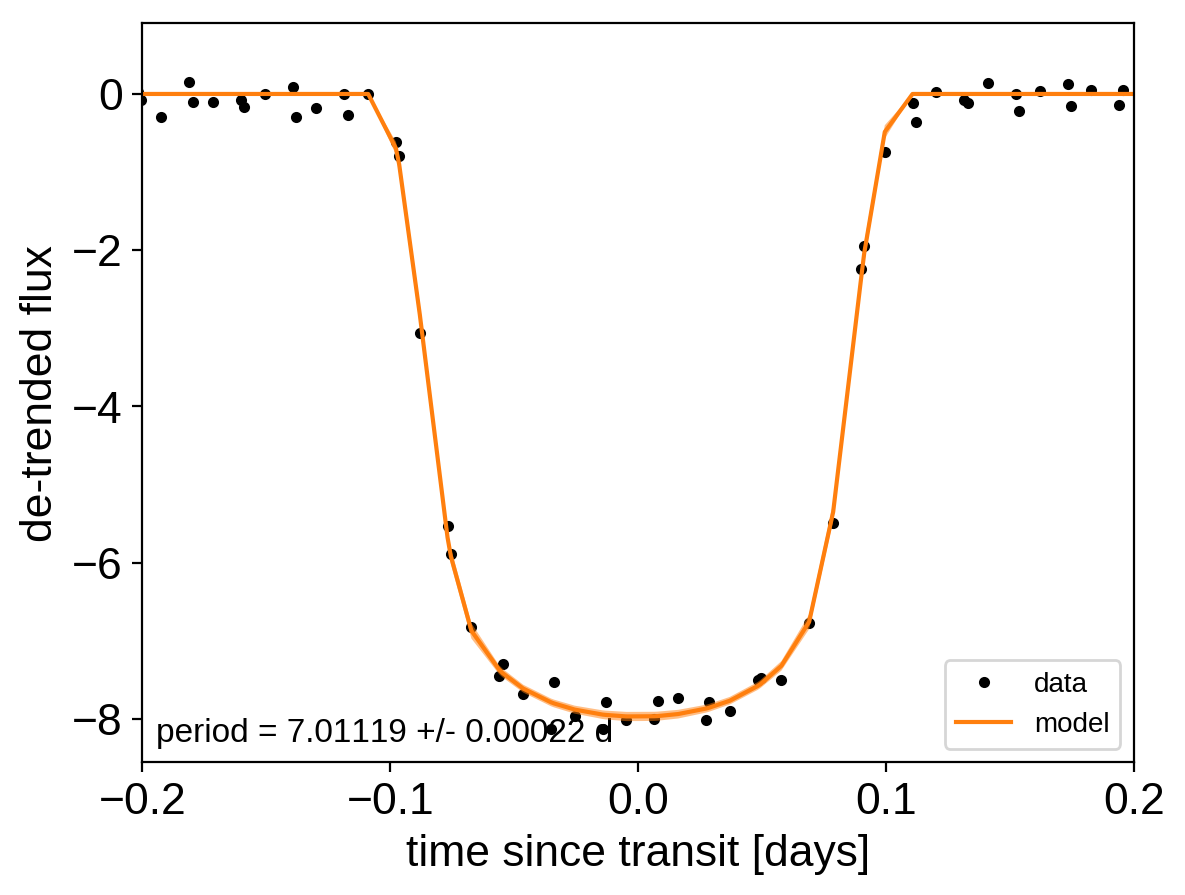

In [17]:
# Compute the GP prediction
gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["light_curves"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                       zorder=1000)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(trace["period"]), np.std(trace["period"]))
plt.annotate(txt, (0, 0), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
plt.xlim(-0.2, 0.2);

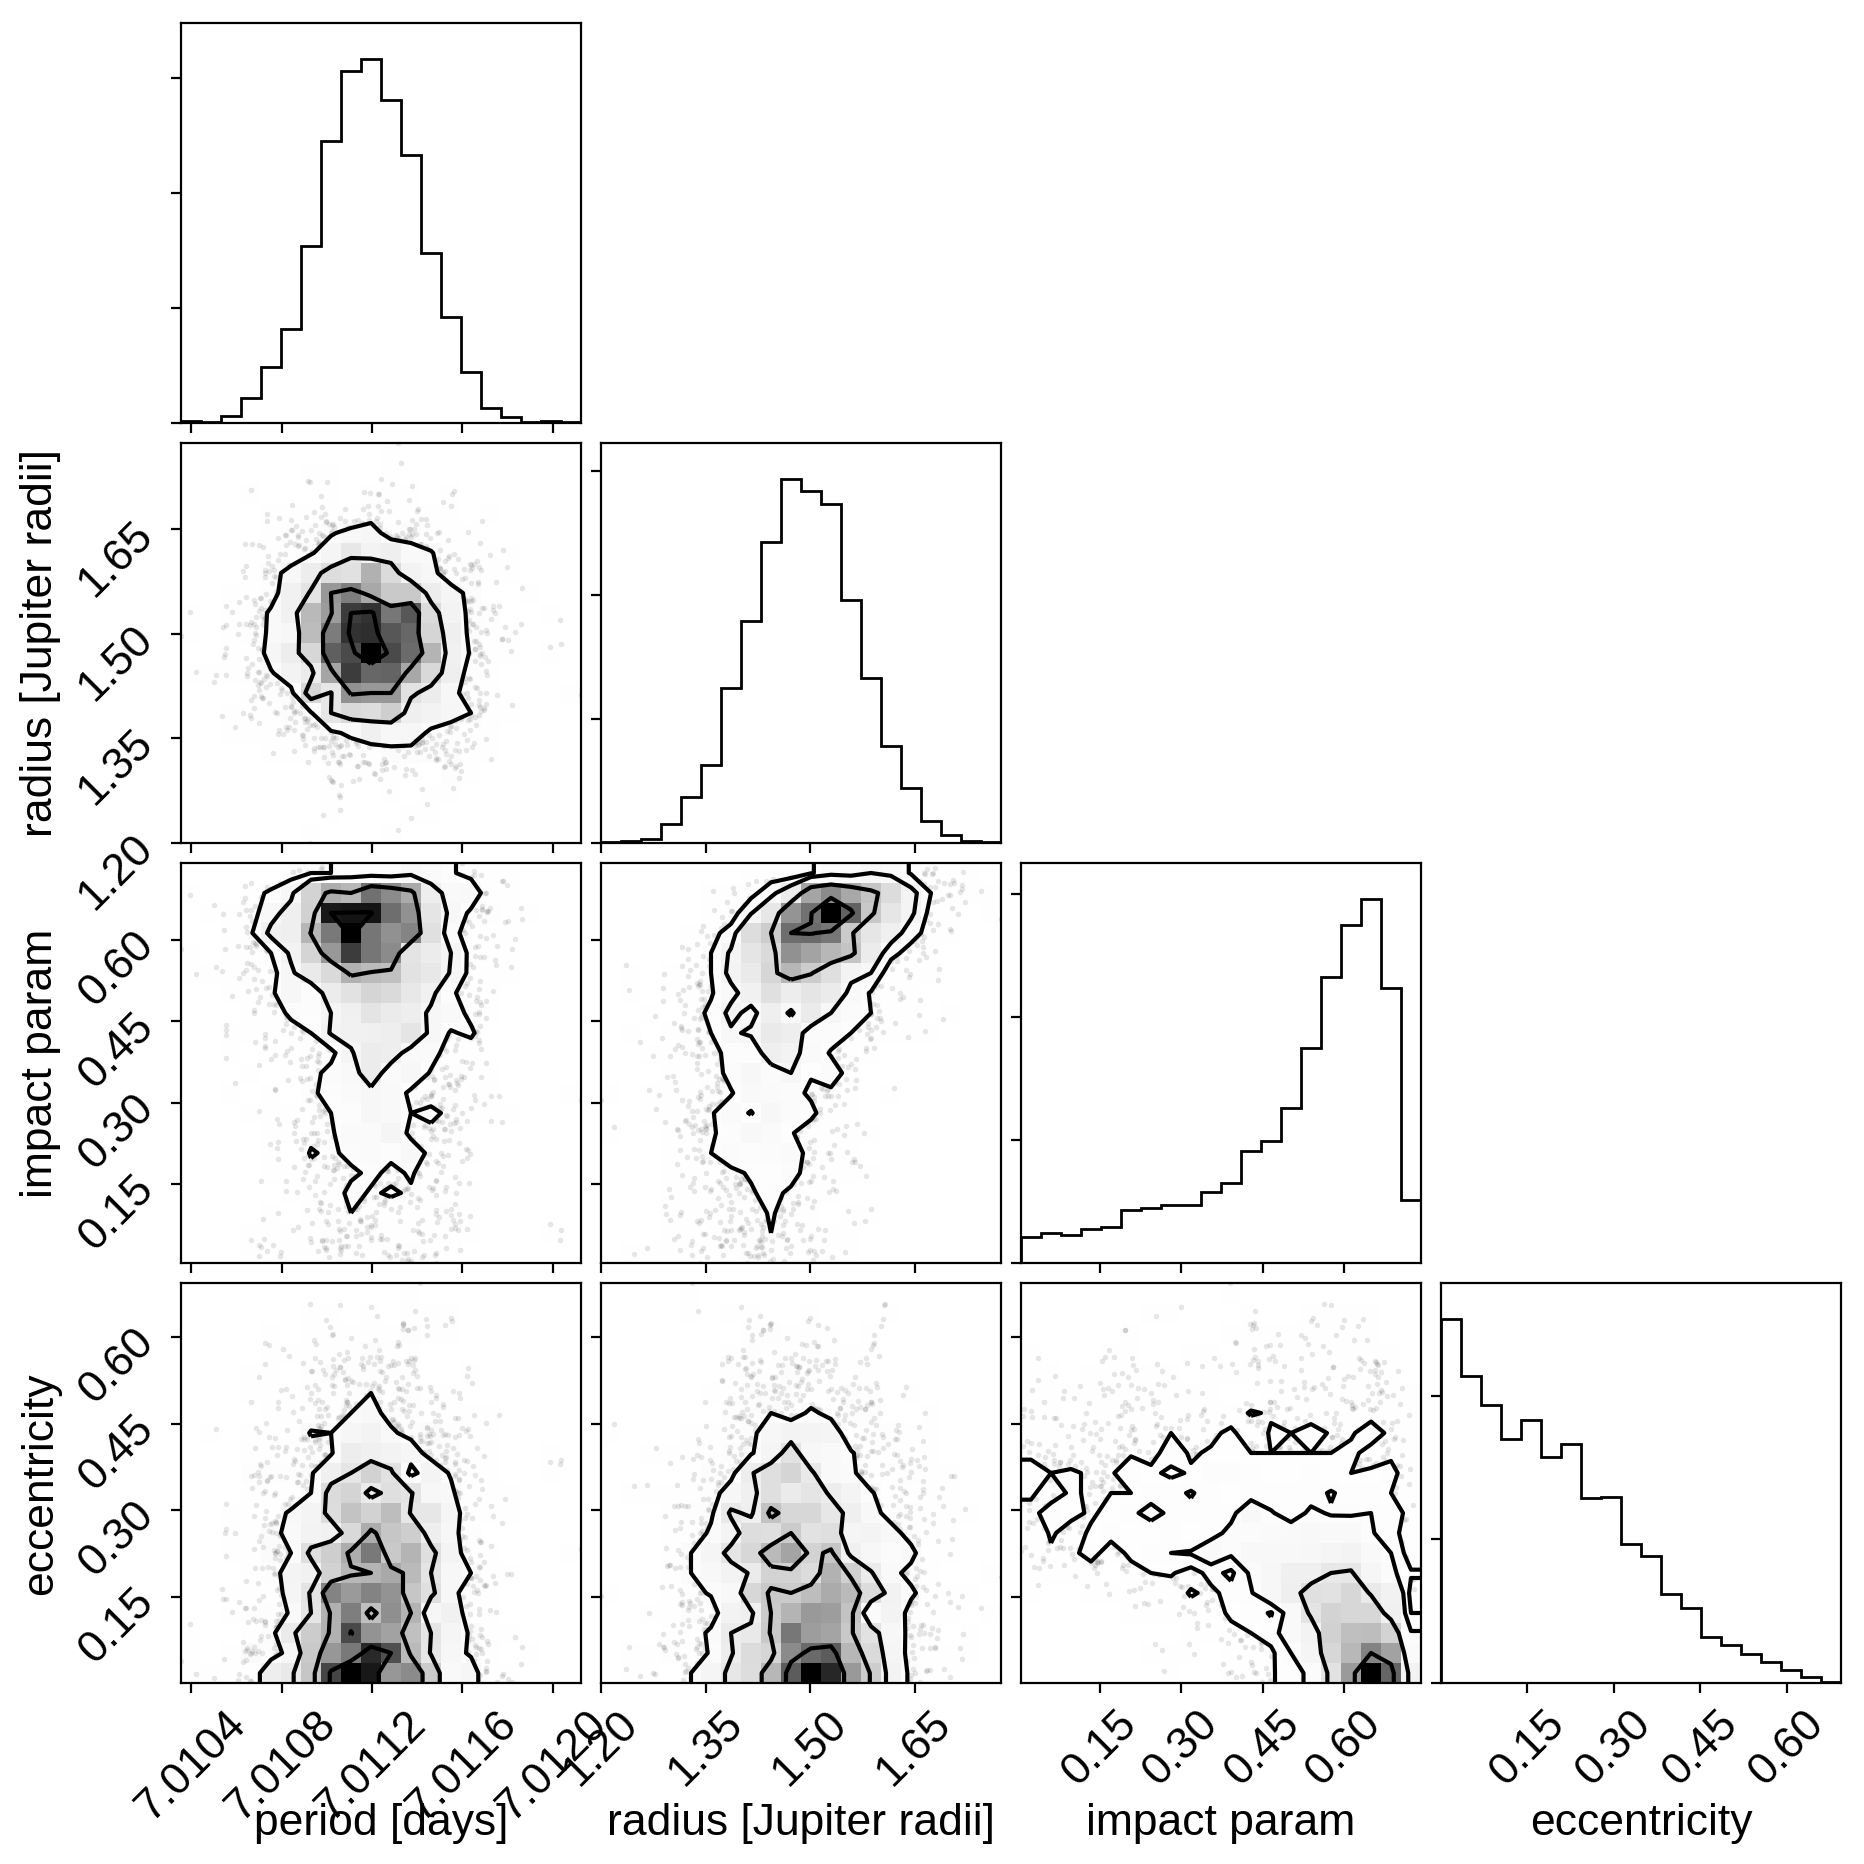

In [18]:
import corner
import astropy.units as u
varnames = ["period", "b", "ecc", "r_pl"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)

# Convert the radius to Earth radii
samples["r_pl"] = (np.array(samples["r_pl"]) * u.R_sun).to(u.R_jupiter).value

corner.corner(
    samples[["period", "r_pl", "b", "ecc"]],
    labels=["period [days]", "radius [Jupiter radii]", "impact param", "eccentricity"]);

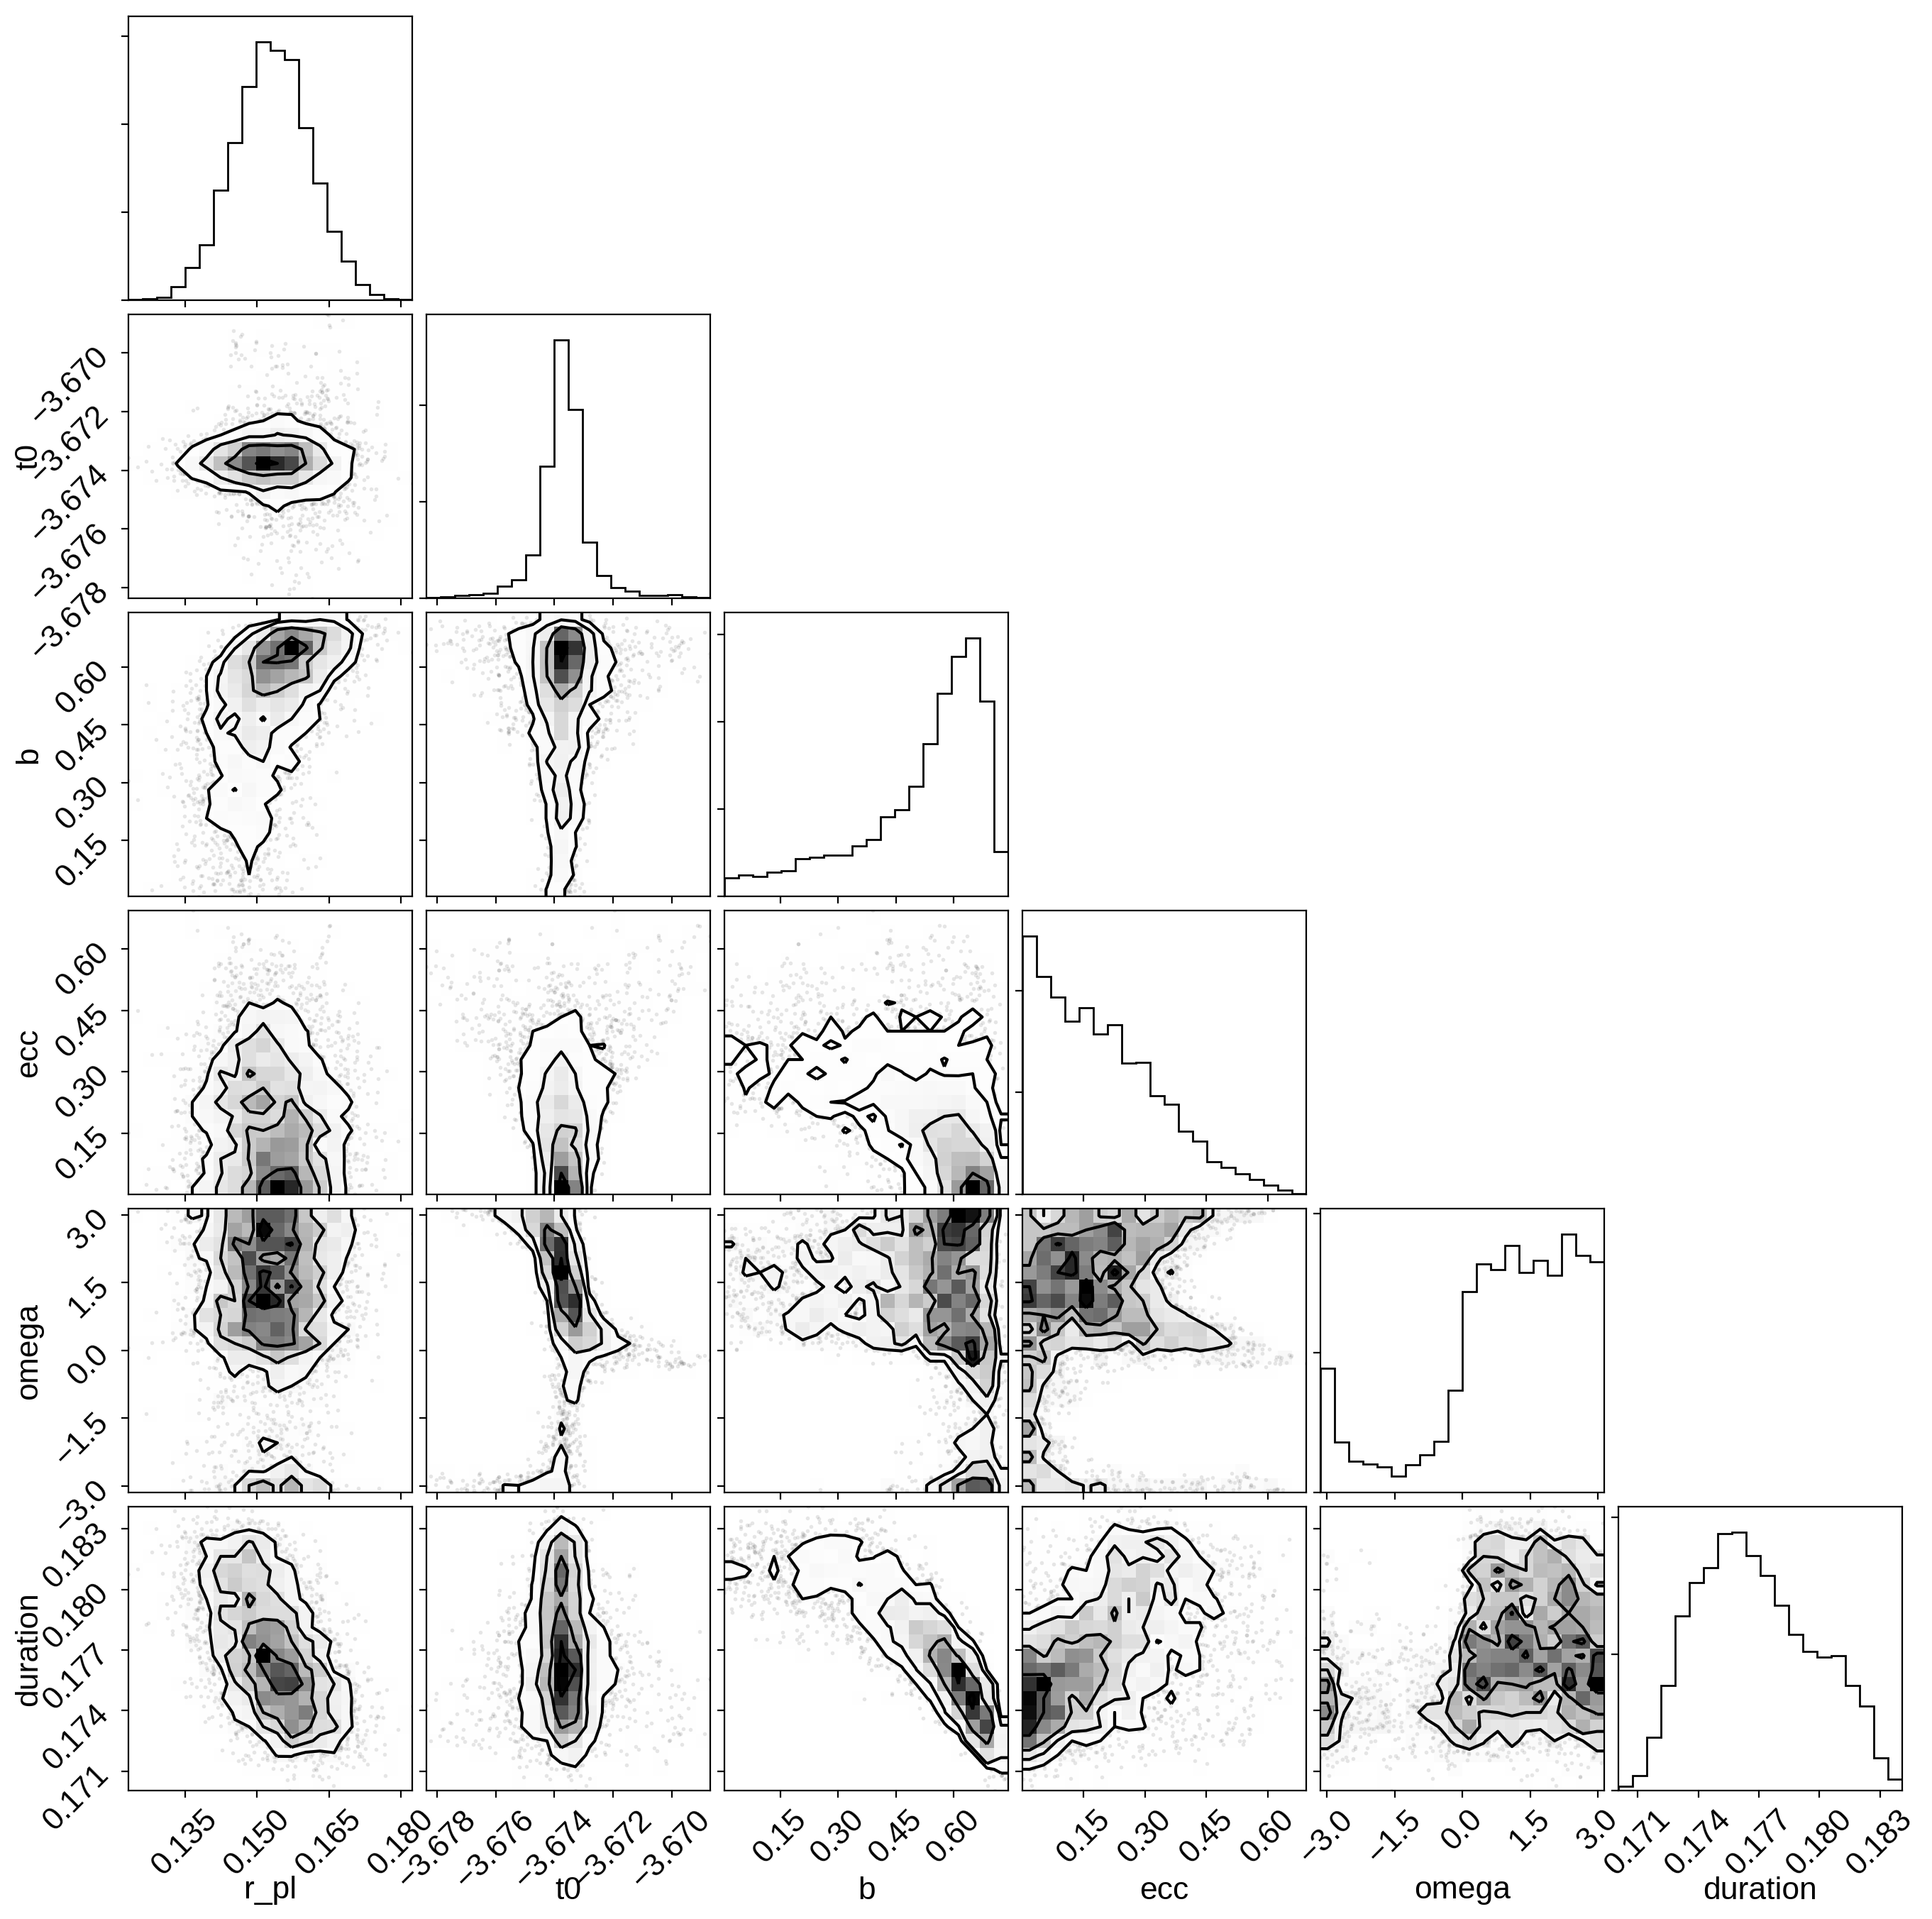

In [19]:
aor = -trace["a"] / trace["r_star"]
e = trace["ecc"]
w = trace["omega"]
i = trace["incl"]
b = trace["b"]
k = trace["r_pl"] / trace["r_star"]
P = trace["period"]

T_tot = P/np.pi * np.arcsin(np.sqrt(1 - b**2) / np.sin(i) / aor)
dur = T_tot * np.sqrt(1 - e**2) / (1 + e * np.sin(w))

samples = pm.trace_to_dataframe(trace, varnames=["r_pl", "t0", "b", "ecc", "omega"])
samples["duration"] = dur
corner.corner(samples);